In [1]:
# !pip install tqdm

In [2]:
import os
import random
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from transformers import ViTForImageClassification
from scipy import stats



label_to_int = {'Goed': 0, 'Matig': 1, 'Redelijk': 2, 'Slecht': 3, 'Zeer_slecht': 4, 'Dood': 5}

class CustomImageDataset1(Dataset):
    def __init__(self, images, labels, transforms=None, samples_per_class=None):
        self.images = images
        self.labels = [label_to_int[label] for label in labels]
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        if self.transforms:
            image = self.transforms(image)

        return image, label

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transforms=None, sampling_factors=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.sampling_factors = sampling_factors if sampling_factors is not None else {label: 1 for label in set(labels)}

    def __len__(self):
        # Calculate total length considering sampling factors
        total_length = 0
        for label in self.labels:
            total_length += self.sampling_factors[label]
        return total_length

    def __getitem__(self, idx):
        # Find the actual image index based on the sampling factor
        actual_idx = idx
        for i, label in enumerate(self.labels):
            if actual_idx < self.sampling_factors[label]:
                break
            actual_idx -= self.sampling_factors[label]


        image = Image.open(self.images[i])
        label = self.labels[i]

        # Remove top 30% of the image
        width, height = image.size
        image = image.crop((0, height * 0.3, width, height))

        # Process image
        if self.transforms:
            image = self.transforms(image)

        return image, label_to_int[label]

def load_images(folder_path):
    print("Loading images...")

    images = []
    labels = []
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            images.append(img_path)
            labels.append(class_folder)
    print("Total images loaded:", len(images))
    return images, labels

def split_dataset(images, labels, train_ratio=0.6, val_ratio=0.2):
    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    dataset = list(zip(images, labels))
    random.shuffle(dataset)
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    train_set = dataset[:train_size]
    val_set = dataset[train_size:train_size + val_size]
    test_set = dataset[train_size + val_size:]
    print(f"Dataset split into {len(train_set)} training, {len(val_set)} validation, and {len(test_set)} test images.")
    return train_set, val_set, test_set

def count_class_distribution(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

def calculate_sampling_factors(train_set):
    label_counts = Counter(label for _, label in train_set)
    min_samples = min(label_counts.values())

    # Calculate sampling factor for each class
    sampling_factors = {label: round(100*(min_samples / count)) for label, count in label_counts.items()}
    return sampling_factors

def create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size):
    # Define transformations
    print("Creating dataloaders...")

    train_transforms = transforms.Compose([
        transforms.RandomCrop(224),  # Specify size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CustomImageDataset([i[0] for i in train_set], [i[1] for i in train_set], transforms=train_transforms, sampling_factors=sampling_factors)
    val_dataset = CustomImageDataset([i[0] for i in val_set], [i[1] for i in val_set], transforms=val_test_transforms)
    test_dataset = CustomImageDataset([i[0] for i in test_set], [i[1] for i in test_set], transforms=val_test_transforms)
    # print('Dataset', train_dataset[0])
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Dataloaders created.")
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

def calculate_samples_per_class(class_distribution):
    min_count = min(class_distribution.values())
    samples_per_class = {label_to_int[cls]: min_count // count for cls, count in class_distribution.items()}
    return samples_per_class



def load_data(folder1):
    images, labels = load_images(folder1)
    train_set, val_set, test_set = split_dataset(images, labels)

    # Print class distribution
    train_class_distribution = count_class_distribution(train_set)
    val_class_distribution = count_class_distribution(val_set)
    test_class_distribution = count_class_distribution(test_set)

    print("Training set class distribution:", train_class_distribution)
    print("Validation set class distribution:", val_class_distribution)
    print("Test set class distribution:", test_class_distribution)

    sampling_factors = calculate_sampling_factors(train_set)
#     sampling_factors = {'rice': 1, 'other': 2, 'sugarcane': 6, 'cassava': 12, 'maize': 10}
#     sampling_factors = {'Goed': 7, 'Matig': 7, 'Redelijk': 7, 'Slecht': 7, 'Zeer Slecht': 7}
    #sampling_factors = {'goed': 30, 'matige': 1, 'Redelijk': 1, 'slecht': 30, 'Zeer_slecht': 30, 'dood': 30}
    print('Sampling factors: ', sampling_factors)
    train_loader, val_loader, test_loader = create_dataloaders(train_set, val_set, test_set, sampling_factors, batch_size=8)

    return train_loader, val_loader, test_loader

In [3]:
def extract_patches(image, patch_size, stride):
    patches = []
    c, height, width = image.size()

    for y in range(0, height - patch_size[1] + 1, stride):
        for x in range(0, width - patch_size[0] + 1, stride):
            patch = image[:, y:y + patch_size[1], x:x + patch_size[0]]
            patches.append(patch)

    return patches

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in progress_bar:

        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)

        #For ViT
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels)

        # loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        # _, predicted = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.logits, 1)

        correct = (predicted == labels).sum().item()
        progress_bar.set_postfix(loss=loss.item(), accuracy=correct/len(labels))

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        # For F1 score calculation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    return avg_loss, accuracy, f1, per_class_f1



def validate_or_test(model, loader, criterion, device, patch_size, stride, desc='Val'):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(loader, desc=desc, leave=False)
    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            batch_preds = []

            for image in images:
                # # Apply sliding window approach
                # patches = extract_patches(image, patch_size, stride)
                # patches = torch.stack(patches).to(device)

                # # Aggregate predictions for each patch
                # patch_outputs = model(patches)
                # logits = patch_outputs.logits  # Extract the logits
                # patch_predictions = torch.mean(logits, dim=0)
                # patch_predictions = torch.mean(patch_outputs, dim=0)
                # batch_preds.append(patch_predictions)

                # Calculate the mode of the patch predictions

                patches = extract_patches(image, patch_size, stride)
                patches = torch.stack(patches).to(device)

                # Aggregate predictions for each patch
                patch_outputs = model(patches)
                logits = patch_outputs.logits  # Extract the logits

                # Calculate mode for each patch prediction
                modes, _ = torch.mode(logits, dim=0)
                batch_preds.append(modes)

            print(batch_preds)
            batch_preds = torch.stack(batch_preds)
            loss = criterion(batch_preds, labels)
            total_loss += loss.item()

            _, predicted = torch.max(batch_preds, 1)
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return avg_loss, accuracy, f1, per_class_f1

import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_and_evaluate(model, train_loader, val_loader, test_loader, model_name, num_epochs=5, patch_size=(224, 224), stride=30):
    # Criterion, Optimizer, and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    global best_val_f1
    global best_model_weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):

        train_loss, train_accuracy, train_f1, train_f1_per_class = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Train F1 Score Per Class ', train_f1_per_class)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy, val_f1, val_f1_per_class = validate_or_test(model, val_loader, criterion, device, patch_size, stride, desc='Val')
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')
        print(f'Val F1 Score Per Class ', val_f1_per_class)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()  # Save the best model weights

        # Save intermediate model weights
        torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}_epoch_{epoch}.pth')

        scheduler.step()

        # Plot train and validation accuracy
        plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train and Validation Accuracy')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_accuracy_epoch_{epoch + 1}.png')
        plt.close()

        # Plot train and validation loss
        plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train and Validation Loss')
        plt.legend()
        plt.show()
        plt.savefig(f'/kaggle/working/train_val_loss_epoch_{epoch + 1}.png')
        plt.close()

    test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(model, test_loader, criterion, device, patch_size, stride, desc='Test')
    print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
    print(f'Test F1 Score Per Class ', test_f1_per_class)

    # After training is complete, load the best model weights
    model.load_state_dict(best_model_weights)

    # Save the best model weights
    torch.save(model.state_dict(), '/kaggle/working/'+f'{model_name}.pth')

    return model


Loading images...
Total images loaded: 2885
Splitting dataset...
Dataset split into 1731 training, 577 validation, and 577 test images.
Training set class distribution: {'Slecht': 561, 'Matig': 390, 'Redelijk': 427, 'Dood': 110, 'Goed': 226, 'Zeer_slecht': 17}
Validation set class distribution: {'Slecht': 187, 'Dood': 41, 'Matig': 151, 'Goed': 55, 'Redelijk': 138, 'Zeer_slecht': 5}
Test set class distribution: {'Matig': 155, 'Goed': 77, 'Slecht': 178, 'Redelijk': 127, 'Dood': 33, 'Zeer_slecht': 7}
Sampling factors:  {'Slecht': 3, 'Matig': 4, 'Redelijk': 4, 'Dood': 15, 'Goed': 8, 'Zeer_slecht': 100}
Creating dataloaders...
Dataloaders created.
1264 73 73


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.1641, Accuracy: 0.5997, F1 Score: 0.5891
Train F1 Score Per Class  [0.62702703 0.43935599 0.48084987 0.3559322  0.90143904 0.71714922]


Val:   1%|▏         | 1/73 [00:00<00:53,  1.35it/s, loss=1.88]

[tensor([-0.5633,  0.9334,  0.6226,  0.8180, -1.7981, -1.5711], device='cuda:0'), tensor([-1.0137,  1.5207,  1.1722,  0.8169, -1.9941, -1.6423], device='cuda:0'), tensor([-0.9746,  0.8197,  1.3196,  1.0005, -1.4692, -1.2533], device='cuda:0'), tensor([-1.1091,  1.1375,  0.9661,  0.8238, -1.4100, -1.3034], device='cuda:0'), tensor([-0.8428,  1.0704,  0.9111,  0.9680, -1.5124, -1.0362], device='cuda:0'), tensor([-1.7416,  0.1682,  0.6338,  1.1698, -1.5564, -0.8372], device='cuda:0'), tensor([-0.9984,  0.1370,  0.4210,  1.0830, -2.0761, -0.9821], device='cuda:0'), tensor([-1.1140,  1.0236,  1.6242,  1.0551, -1.3131, -1.3649], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:01<00:43,  1.63it/s, loss=2.04]

[tensor([-1.0981,  0.9939,  1.0219,  0.8683, -1.4523, -1.4801], device='cuda:0'), tensor([-1.7421,  0.0159, -0.0941,  0.2777, -1.1605, -1.2616], device='cuda:0'), tensor([ 2.4682, -0.6925, -0.1702,  0.2629, -1.4706, -0.5355], device='cuda:0'), tensor([-0.6962,  0.4444,  0.4774,  0.7890, -1.4265, -1.2389], device='cuda:0'), tensor([-0.6938,  1.6023,  0.9706,  0.6539, -1.8255, -1.5972], device='cuda:0'), tensor([-0.7337,  1.5646,  0.7022,  0.7200, -1.5437, -1.6500], device='cuda:0'), tensor([ 1.3062, -0.2490,  0.2688,  0.6792, -1.5055, -1.2330], device='cuda:0'), tensor([-0.4111,  0.9624,  0.9443,  0.9233, -2.1617, -1.6693], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:39,  1.76it/s, loss=1.82]

[tensor([-1.2355,  1.2982,  1.1228,  0.7202, -1.8795, -1.5656], device='cuda:0'), tensor([-0.1471,  0.5036,  0.7285,  0.2006, -0.9684, -1.7451], device='cuda:0'), tensor([-1.2401,  1.0710,  1.7802,  0.9554, -1.4593, -1.3722], device='cuda:0'), tensor([ 0.4327, -0.0745,  0.9869,  1.0321, -2.1841, -1.5096], device='cuda:0'), tensor([-0.4686,  1.1441,  0.4279,  0.6329, -1.6157, -1.4383], device='cuda:0'), tensor([-0.7494,  1.3983,  1.3420,  1.1095, -2.0029, -1.5365], device='cuda:0'), tensor([-7.1212e-04, -2.1541e-01,  1.2395e-01,  4.7770e-01, -1.7114e+00,
        -1.7062e+00], device='cuda:0'), tensor([ 0.7948, -0.3068,  0.1884,  0.3908, -1.9303, -1.4466], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:02<00:37,  1.84it/s, loss=1.94]

[tensor([-0.8924,  0.9293,  1.4974,  1.2328, -1.6233, -1.7136], device='cuda:0'), tensor([-1.3527,  1.3576,  1.5511,  0.7492, -1.7590, -1.1655], device='cuda:0'), tensor([-1.1474,  1.1516,  1.1160,  0.6492, -1.9287, -0.8020], device='cuda:0'), tensor([-0.1202,  0.3684,  0.6083,  0.2694, -1.2053, -1.2847], device='cuda:0'), tensor([ 2.5014, -0.1687, -0.0212,  0.0921, -1.6720, -1.3199], device='cuda:0'), tensor([-1.1006,  1.2303,  1.1536,  0.7165, -2.1636, -0.9876], device='cuda:0'), tensor([-0.9809,  1.5452,  1.1226,  0.7581, -1.6841, -1.5668], device='cuda:0'), tensor([-1.3978,  1.1263,  1.3213,  0.4029, -0.8597, -1.0283], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:36,  1.87it/s, loss=1.63]

[tensor([-1.0717,  0.8880,  1.4542,  0.9487, -1.6463, -1.4627], device='cuda:0'), tensor([-1.4108,  1.0938,  1.7626,  1.0596, -1.6076, -1.3559], device='cuda:0'), tensor([-0.2922,  0.5822,  1.3533,  0.7517, -2.2253, -1.2943], device='cuda:0'), tensor([-1.2545,  1.0635,  1.1813,  0.9248, -1.3100, -1.3709], device='cuda:0'), tensor([-0.8428,  0.9287,  1.6838,  0.9257, -1.7805, -1.6052], device='cuda:0'), tensor([-0.8030,  0.9138,  1.1125,  1.1006, -2.3032, -1.4235], device='cuda:0'), tensor([-1.1970,  0.8429,  0.4885,  0.4016, -1.8830,  0.0263], device='cuda:0'), tensor([-0.3887,  0.6216,  0.2659,  0.4786, -1.3512, -0.1396], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:03<00:35,  1.87it/s, loss=2.29]

[tensor([-1.0987,  1.3116,  1.5648,  0.9863, -1.7374, -1.6271], device='cuda:0'), tensor([-1.0476,  0.8998,  1.3054,  0.8495, -1.6608, -1.4644], device='cuda:0'), tensor([-1.1383,  1.0226,  1.4643,  0.9599, -1.6718, -1.2477], device='cuda:0'), tensor([-1.4336,  1.1471,  0.2281,  0.3125, -1.3174, -0.6900], device='cuda:0'), tensor([-0.8169,  0.8738,  1.7821,  1.2216, -1.6410, -1.5106], device='cuda:0'), tensor([-0.9927,  0.7897,  1.5781,  1.3192, -1.8845, -1.2472], device='cuda:0'), tensor([-0.5534,  0.1953,  1.3285,  1.2443, -1.2988, -1.4073], device='cuda:0'), tensor([-1.2613,  1.0296,  0.9165,  0.6183, -1.2683, -1.1701], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:35,  1.87it/s, loss=1.56]

[tensor([-0.8456,  0.8535,  1.1126,  0.9051, -1.7279, -1.4186], device='cuda:0'), tensor([-0.7465,  0.4146,  0.7723,  0.6523, -1.4723, -0.9212], device='cuda:0'), tensor([-0.5536,  0.8551,  1.7354,  1.0773, -1.4772, -1.7523], device='cuda:0'), tensor([-0.7085,  0.8361,  1.7965,  1.0388, -1.8747, -1.3231], device='cuda:0'), tensor([-1.2912,  1.4008,  1.5441,  0.9667, -1.4930, -1.5924], device='cuda:0'), tensor([-0.7981,  0.8831,  1.4513,  1.0699, -1.6705, -1.6726], device='cuda:0'), tensor([-1.1383,  0.7655,  1.6234,  1.2269, -1.8119, -1.1654], device='cuda:0'), tensor([-1.2747,  1.3062,  1.1935,  0.7560, -1.3120, -1.1762], device='cuda:0')]


Val:  11%|█         | 8/73 [00:04<00:35,  1.85it/s, loss=1.89]

[tensor([-0.9819,  0.8772,  1.2089,  0.6834, -1.8052, -0.9717], device='cuda:0'), tensor([-0.8674,  0.7289,  1.3293,  0.6958, -1.3433, -1.2348], device='cuda:0'), tensor([-1.1457,  1.2424,  0.6766,  0.9069, -1.7862, -1.0834], device='cuda:0'), tensor([-0.8445,  1.6696,  0.6350,  0.6374, -1.3908, -1.6739], device='cuda:0'), tensor([-0.6804,  0.8871,  1.7237,  0.9644, -1.6315, -1.5244], device='cuda:0'), tensor([-0.6736,  1.3778,  0.7395,  0.8706, -1.7930, -1.1638], device='cuda:0'), tensor([-1.4620, -0.3873, -0.0745,  0.0618, -1.8619,  0.0574], device='cuda:0'), tensor([-0.9010,  1.1350,  1.6830,  0.8981, -1.4917, -1.5977], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:34,  1.87it/s, loss=1.92]

[tensor([-1.3725,  1.1480,  1.3177,  0.8106, -1.7466, -0.9195], device='cuda:0'), tensor([-1.2616,  1.4694,  1.2374,  0.8508, -1.7390, -1.4331], device='cuda:0'), tensor([-0.7235,  1.4204,  0.6847,  0.7888, -1.4327, -1.3934], device='cuda:0'), tensor([-0.3581,  0.5988,  0.7859,  0.4564, -1.8273, -1.2311], device='cuda:0'), tensor([ 0.3654,  0.2757,  0.6466,  0.1834, -1.0264, -1.3007], device='cuda:0'), tensor([-1.4453,  1.5566,  0.9855,  0.7014, -1.3620, -1.0834], device='cuda:0'), tensor([-0.9029,  0.7413,  0.8729,  0.9703, -1.6467, -1.4919], device='cuda:0'), tensor([-1.2958,  0.6417,  0.6284,  0.9305, -2.0409, -0.9815], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:05<00:33,  1.87it/s, loss=1.34]

[tensor([-1.5493,  1.4163,  1.2840,  0.7670, -1.3423, -1.4754], device='cuda:0'), tensor([-0.6687,  0.5597,  0.8541,  0.4062, -1.0608, -1.2538], device='cuda:0'), tensor([-1.3267,  0.9650,  0.3122,  0.4655, -1.6728, -1.3496], device='cuda:0'), tensor([-1.4154,  0.7782,  1.5140,  0.9230, -1.6192, -1.3230], device='cuda:0'), tensor([-0.5000,  1.0106,  1.3652,  0.7812, -1.2427, -1.6344], device='cuda:0'), tensor([-0.8411,  0.9904,  1.3082,  0.9260, -1.6117, -1.7177], device='cuda:0'), tensor([-1.0601,  1.2115,  0.4600,  0.5755, -1.4012, -1.3183], device='cuda:0'), tensor([-0.8344,  1.5449,  1.0032,  0.8764, -1.5581, -1.7265], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:06<00:33,  1.87it/s, loss=1.83]

[tensor([-1.3323,  1.4370,  1.2870,  0.8424, -1.2511, -1.6125], device='cuda:0'), tensor([-0.5988,  1.0431,  0.3992,  0.4801, -1.6610, -0.9488], device='cuda:0'), tensor([-1.2075,  0.6367,  1.2829,  1.1495, -1.8175, -0.5929], device='cuda:0'), tensor([-0.7666,  1.0437,  1.2330,  1.0508, -2.3000, -1.5898], device='cuda:0'), tensor([-1.4779,  1.5804,  1.2036,  0.7567, -1.8955, -1.0763], device='cuda:0'), tensor([-1.4237,  1.1604,  1.0472,  1.2461, -1.1048, -1.3279], device='cuda:0'), tensor([-1.0455,  1.0403,  1.8903,  0.7681, -1.5612, -1.5548], device='cuda:0'), tensor([-0.9944,  1.2501,  0.9545,  1.0339, -1.5701, -1.5733], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:06<00:32,  1.85it/s, loss=1.21]

[tensor([-1.2622,  1.3024,  1.5118,  0.8362, -1.6396, -1.4305], device='cuda:0'), tensor([-1.1967,  1.4812,  1.0642,  0.5998, -1.3357, -1.2786], device='cuda:0'), tensor([-1.3691,  1.1722,  1.5857,  0.9265, -1.3293, -1.5796], device='cuda:0'), tensor([-1.2339,  1.4563,  1.1606,  0.8606, -1.5464, -1.6760], device='cuda:0'), tensor([ 0.0917,  0.4643,  0.2916,  0.8264, -1.5052, -1.6522], device='cuda:0'), tensor([-1.2909,  1.2203,  1.7024,  1.0871, -1.7824, -1.4884], device='cuda:0'), tensor([-0.8319,  0.5183,  0.1666,  0.4696, -1.4137, -0.9514], device='cuda:0'), tensor([-0.0292,  0.9296,  0.6359,  0.6419, -2.1256, -1.5693], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:07<00:32,  1.85it/s, loss=1.23]

[tensor([-0.8736,  0.7802,  1.1504,  1.2596, -1.6760, -1.7737], device='cuda:0'), tensor([-1.2719,  1.5051,  1.3376,  0.6891, -1.2093, -1.2167], device='cuda:0'), tensor([-1.2249,  1.3867,  1.4174,  0.7934, -1.8667, -1.1539], device='cuda:0'), tensor([-0.9839,  1.3717,  1.5900,  0.7238, -1.7963, -1.2517], device='cuda:0'), tensor([-1.7023,  1.2417,  1.0427,  0.4840, -0.7431, -1.0832], device='cuda:0'), tensor([-0.7648,  1.0021,  1.4026,  0.6712, -2.0312, -1.2082], device='cuda:0'), tensor([-1.5612,  0.7787,  0.6719,  0.5215, -1.4943, -1.2972], device='cuda:0'), tensor([-0.8094,  1.3199,  1.2049,  0.8641, -1.7633, -1.4610], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:07<00:31,  1.86it/s, loss=1.27]

[tensor([-0.2235,  0.4698,  0.9918,  1.3115, -1.6914, -1.4708], device='cuda:0'), tensor([-0.8936,  1.1076,  1.4028,  0.9383, -1.8348, -1.4538], device='cuda:0'), tensor([-1.3358,  0.5113,  0.6444,  0.7910, -2.0838, -0.2851], device='cuda:0'), tensor([-0.6507,  0.8946,  1.5010,  1.2178, -1.9122, -1.6597], device='cuda:0'), tensor([-1.4972,  0.6489,  0.8445,  1.3836, -1.1648, -1.1258], device='cuda:0'), tensor([-1.2359,  1.3464,  1.2759,  0.7752, -1.0856, -1.2816], device='cuda:0'), tensor([-1.1625,  1.2762,  0.8317,  0.5042, -1.2143, -1.3526], device='cuda:0'), tensor([-0.7947,  1.0927,  1.2421,  1.0545, -1.7803, -1.1264], device='cuda:0')]


Val:  21%|██        | 15/73 [00:08<00:31,  1.87it/s, loss=1.94]

[tensor([-1.5374,  1.4103,  0.6907,  0.7570, -1.8370, -0.8360], device='cuda:0'), tensor([-1.3983,  1.2349,  1.2929,  0.8559, -1.3659, -1.2180], device='cuda:0'), tensor([-1.1035,  1.0929,  1.7709,  0.9087, -1.6682, -1.4264], device='cuda:0'), tensor([-0.9358,  0.8131,  1.3544,  1.4620, -1.8621, -1.6440], device='cuda:0'), tensor([-0.3656,  1.0317,  1.1132,  0.8845, -1.7320, -1.9387], device='cuda:0'), tensor([-1.0901,  1.3422,  1.5027,  0.7575, -1.5200, -1.7048], device='cuda:0'), tensor([-1.4222,  0.7102,  1.2570,  0.9160, -1.7092, -0.7698], device='cuda:0'), tensor([-1.0311,  1.4281,  1.4189,  0.8948, -1.5223, -2.0321], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:08<00:31,  1.83it/s, loss=1.75]

[tensor([-1.2405,  1.1129,  1.3700,  1.2945, -2.1483, -1.2159], device='cuda:0'), tensor([-1.4489,  1.3684,  1.5454,  0.7270, -1.7185, -1.4035], device='cuda:0'), tensor([-0.8988,  0.9513,  1.4584,  1.2608, -1.5890, -1.5270], device='cuda:0'), tensor([-1.4337,  1.0241,  1.3520,  0.7666, -1.8116, -0.7627], device='cuda:0'), tensor([-1.0020,  0.3217,  0.8283,  0.8603, -1.6820, -0.5542], device='cuda:0'), tensor([-1.1865,  0.8142,  1.6434,  1.0305, -1.3528, -1.1188], device='cuda:0'), tensor([-0.7158,  1.1548,  1.4760,  1.3035, -2.0969, -1.3381], device='cuda:0'), tensor([-1.3459,  1.0065,  1.4638,  0.9998, -1.5119, -1.2875], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:09<00:30,  1.84it/s, loss=1.84]

[tensor([-1.4288,  1.3623,  1.4256,  0.8753, -1.6869, -1.3147], device='cuda:0'), tensor([-0.4200,  0.9819,  1.2941,  0.2725, -1.3738, -1.2814], device='cuda:0'), tensor([-1.3377,  1.7233,  0.4585,  0.6063, -1.6277, -1.2479], device='cuda:0'), tensor([-1.4140,  1.0581,  1.1396,  0.7872, -1.2128, -1.2877], device='cuda:0'), tensor([-1.0618, -0.2511,  0.6154,  0.7317, -1.0650,  0.1865], device='cuda:0'), tensor([-1.0003,  0.9317,  1.4261,  0.9538, -1.4217, -1.7272], device='cuda:0'), tensor([ 0.7092, -0.1259,  0.8105,  0.7024, -2.1335, -0.9377], device='cuda:0'), tensor([-0.7360,  1.4283,  0.9810,  0.6640, -1.7145, -1.7140], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:09<00:29,  1.86it/s, loss=1.42]

[tensor([-1.0357,  0.7865,  1.6246,  1.1922, -1.6175, -1.6642], device='cuda:0'), tensor([-0.1504,  0.7965,  0.7931,  0.7818, -1.2449, -1.8315], device='cuda:0'), tensor([-1.6680,  0.7436,  0.9225,  0.5186, -1.4704, -1.0825], device='cuda:0'), tensor([-1.0309,  1.4077,  1.3099,  0.8842, -1.2554, -1.6686], device='cuda:0'), tensor([-0.9483,  0.5563,  1.2136,  0.5688, -1.3715, -1.7711], device='cuda:0'), tensor([-1.1853,  0.8054,  0.8739,  0.7672, -1.4676, -0.7826], device='cuda:0'), tensor([-0.4196,  0.9712,  0.4860,  0.4767, -1.5545, -1.0341], device='cuda:0'), tensor([-1.4783,  1.0507,  1.0488,  1.0518, -1.2514, -1.4343], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:10<00:29,  1.86it/s, loss=1.58]

[tensor([-1.3481,  0.2412,  1.0183,  1.1105, -1.3553, -1.0351], device='cuda:0'), tensor([ 1.2629,  0.1012, -0.1859,  0.3545, -1.9124, -1.0631], device='cuda:0'), tensor([-0.8258,  1.0707,  1.5820,  0.6328, -0.9398, -1.4464], device='cuda:0'), tensor([-0.2883,  0.5739,  1.1394,  1.4018, -1.6281, -1.5311], device='cuda:0'), tensor([-0.3879,  0.9691,  0.9661,  0.7611, -1.9103, -2.0049], device='cuda:0'), tensor([-0.5983,  0.3417,  0.8960,  1.0630, -1.7405, -1.7243], device='cuda:0'), tensor([-1.2578,  1.1409,  1.0450,  1.0555, -1.7737, -1.0438], device='cuda:0'), tensor([-0.9368,  1.0546,  1.1683,  0.6872, -1.2030, -1.2210], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:10<00:28,  1.87it/s, loss=1.73]

[tensor([-1.2206,  1.2861,  1.5235,  1.0338, -1.5898, -1.9199], device='cuda:0'), tensor([-1.5257,  1.1658,  0.2896,  0.4496, -0.9875, -1.0316], device='cuda:0'), tensor([-1.4081,  1.3183,  1.1285,  0.3746, -1.4365, -0.8587], device='cuda:0'), tensor([-0.9565,  0.6125,  1.4082,  0.9894, -1.9976, -1.2306], device='cuda:0'), tensor([-1.0355,  0.9189,  0.9687,  0.8926, -2.1177, -1.3211], device='cuda:0'), tensor([-0.9723,  1.2894,  1.0307,  0.5362, -1.6214, -1.2387], device='cuda:0'), tensor([-0.6204,  0.9654,  1.1430,  1.0154, -2.0847, -1.5399], device='cuda:0'), tensor([-1.1466,  1.5108,  1.4205,  0.7235, -1.4336, -1.5447], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:11<00:27,  1.86it/s, loss=1.66]

[tensor([-0.0773,  0.4952,  1.4952,  1.2304, -1.8585, -1.5375], device='cuda:0'), tensor([-1.2157,  1.2924,  1.0680,  0.9930, -1.6628, -1.1961], device='cuda:0'), tensor([-0.7203,  1.1425,  1.3627,  0.7896, -1.8060, -1.2677], device='cuda:0'), tensor([-1.4107,  1.0134,  1.5189,  1.0832, -1.5477, -1.3031], device='cuda:0'), tensor([-0.7714,  0.9577,  1.6468,  0.9120, -1.8336, -1.4608], device='cuda:0'), tensor([-1.2361,  0.5172,  0.8797,  0.4016, -1.6526, -1.0371], device='cuda:0'), tensor([-1.5794, -0.2799,  0.1327,  1.0860, -1.4630,  0.7346], device='cuda:0'), tensor([-0.5427, -0.1140,  0.0377,  0.9897, -1.0715,  0.1504], device='cuda:0')]


Val:  30%|███       | 22/73 [00:11<00:27,  1.86it/s, loss=1.78]

[tensor([-0.3818,  0.3894,  0.4744,  0.5744, -2.2646, -1.6505], device='cuda:0'), tensor([-1.0889,  1.0940,  1.1572,  1.1141, -1.6256, -1.2863], device='cuda:0'), tensor([-1.2772,  0.8320,  1.3847,  1.1025, -1.5518, -1.3406], device='cuda:0'), tensor([-1.4633,  0.7757,  1.2583,  0.7316, -1.0012, -0.9396], device='cuda:0'), tensor([-0.5437,  0.7983,  1.5710,  1.2619, -1.5967, -1.9792], device='cuda:0'), tensor([-0.6233,  0.4987,  1.4538,  1.1697, -1.2583, -1.6905], device='cuda:0'), tensor([-0.7163,  1.2263,  0.7612,  0.4587, -1.8499, -1.1033], device='cuda:0'), tensor([-1.3948,  0.9621,  1.4676,  1.1945, -1.3491, -1.3358], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:12<00:26,  1.88it/s, loss=1.57]

[tensor([-1.3773,  1.1713,  0.9650,  0.9032, -1.3780, -1.4053], device='cuda:0'), tensor([-1.0787,  1.0833,  0.7951,  1.0207, -1.6198, -1.1653], device='cuda:0'), tensor([-1.0999,  0.6635,  0.5273,  0.7991, -1.2311, -1.4249], device='cuda:0'), tensor([-0.9559,  0.1452,  0.7756,  0.9143, -1.6578, -1.7062], device='cuda:0'), tensor([-0.9051,  1.2999,  1.4694,  0.9534, -1.3987, -1.6743], device='cuda:0'), tensor([-0.2553,  0.7066,  0.6355,  1.5005, -1.6676, -1.5440], device='cuda:0'), tensor([-0.7306,  0.7531,  1.6834,  1.3144, -1.5868, -1.6758], device='cuda:0'), tensor([-1.4142,  1.0556,  1.5814,  0.8481, -1.5927, -1.7788], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:13<00:25,  1.89it/s, loss=2.05]

[tensor([-0.7648,  0.8957,  0.0718,  0.5523, -1.4188, -0.7780], device='cuda:0'), tensor([-1.0191,  0.9110,  0.9044,  0.8875, -1.8072, -1.1728], device='cuda:0'), tensor([-1.0204,  1.1521,  0.6793,  0.9360, -1.3655, -1.9658], device='cuda:0'), tensor([-0.2548,  0.9304,  1.6233,  0.6973, -1.6849, -2.0262], device='cuda:0'), tensor([-1.7279,  1.1227,  1.1825,  0.8663, -1.3535, -1.3629], device='cuda:0'), tensor([-0.7426,  0.6790,  1.4255,  1.2168, -1.2389, -1.8278], device='cuda:0'), tensor([-1.6315,  0.4345,  0.1738,  1.0011, -1.0716, -0.6040], device='cuda:0'), tensor([-1.2425,  0.7034,  1.0018,  0.6496, -1.6788, -0.3246], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:13<00:25,  1.90it/s, loss=1.71]

[tensor([-1.1680,  0.7063,  0.8760,  0.6572, -1.8713, -0.5255], device='cuda:0'), tensor([ 0.3976,  0.5475,  0.5208,  0.7285, -2.1996, -1.1020], device='cuda:0'), tensor([-1.3845,  1.1686,  1.0263,  0.7452, -1.5499, -0.7560], device='cuda:0'), tensor([-1.0347,  0.9461,  1.8657,  0.9907, -1.7200, -1.6532], device='cuda:0'), tensor([-0.1885,  1.2724,  1.1786,  0.7419, -1.9798, -1.6961], device='cuda:0'), tensor([-0.8604,  1.4638,  1.0135,  0.5808, -1.6268, -1.0827], device='cuda:0'), tensor([-1.1307,  1.0310,  0.1728,  0.2206, -2.0048, -0.6621], device='cuda:0'), tensor([-1.5934,  0.7782,  0.4177,  0.3826, -1.8294, -0.8664], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:14<00:24,  1.91it/s, loss=1.64]

[tensor([-0.7978,  1.2713,  0.5953,  0.4553, -2.2869, -0.9597], device='cuda:0'), tensor([-1.0545,  0.9999,  1.3956,  0.3891, -1.7431, -0.9719], device='cuda:0'), tensor([-0.6799,  1.0552,  1.6854,  1.0114, -1.7021, -1.6926], device='cuda:0'), tensor([-0.5165,  1.3292,  1.1599,  0.8842, -1.5718, -1.9801], device='cuda:0'), tensor([-1.0461,  1.7116,  1.0405,  0.7403, -1.5860, -1.6219], device='cuda:0'), tensor([-1.0988,  1.0330,  1.3465,  0.8325, -1.3669, -1.4346], device='cuda:0'), tensor([-0.9173,  1.1066,  1.5889,  0.9563, -1.5207, -1.7523], device='cuda:0'), tensor([-1.0638,  0.7403,  1.3463,  0.7517, -0.7625, -1.4148], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:14<00:24,  1.91it/s, loss=1.3]

[tensor([-0.8951,  0.2683,  0.0282,  0.7069, -1.7173,  0.2333], device='cuda:0'), tensor([-0.9961,  1.4191,  1.4841,  0.8173, -1.5668, -1.6677], device='cuda:0'), tensor([-0.4533,  0.3349,  0.9508,  0.8172, -1.8377, -1.5067], device='cuda:0'), tensor([-1.1151,  1.0309,  0.8439,  0.8373, -1.2240, -1.2516], device='cuda:0'), tensor([-0.4271,  0.6442,  1.2077,  1.0530, -1.7862, -1.7803], device='cuda:0'), tensor([-1.1713,  1.3704,  1.3970,  0.9848, -1.5886, -1.4960], device='cuda:0'), tensor([-1.2941,  0.9458,  1.5073,  1.1207, -1.3463, -1.4177], device='cuda:0'), tensor([-1.2809,  1.3546,  0.7729,  0.9975, -1.5509, -1.1130], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:15<00:23,  1.92it/s, loss=1.49]

[tensor([-0.1241,  0.3303,  1.4764,  1.0154, -1.8875, -1.6639], device='cuda:0'), tensor([-0.9113,  0.4303,  0.7678,  0.7740, -1.5427, -1.2666], device='cuda:0'), tensor([-0.8705,  1.4790,  1.2845,  0.9829, -1.6653, -1.7906], device='cuda:0'), tensor([ 1.4978, -0.4212,  0.1504,  0.2563, -1.6092, -0.4387], device='cuda:0'), tensor([-1.0079,  1.2946,  1.6895,  0.9862, -1.5072, -1.7196], device='cuda:0'), tensor([-1.2298,  1.1247,  1.2151,  0.8479, -1.3963, -1.3201], device='cuda:0'), tensor([-0.3441,  0.7291,  0.6682,  0.3868, -1.7750, -0.8003], device='cuda:0'), tensor([ 0.4683,  1.0278,  1.2965,  0.7707, -1.6351, -2.0106], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:15<00:22,  1.92it/s, loss=1.37]

[tensor([ 0.6746,  0.7583,  0.3287,  0.1825, -1.9180, -0.8042], device='cuda:0'), tensor([-1.1494,  1.3830,  1.4480,  0.7539, -1.4730, -1.6524], device='cuda:0'), tensor([-0.1874,  0.9284,  0.6937,  0.7495, -1.4067, -1.8275], device='cuda:0'), tensor([-0.2602,  0.5995,  0.8404,  0.3179, -1.0239, -1.0644], device='cuda:0'), tensor([-0.1423,  1.2722,  1.0530,  1.0533, -1.4093, -1.8733], device='cuda:0'), tensor([-1.0558,  0.9499,  1.1797,  0.7533, -1.8632, -0.9800], device='cuda:0'), tensor([-0.3727,  0.5250,  0.9388,  0.5426, -1.6522, -0.9832], device='cuda:0'), tensor([-1.3589,  1.5160,  1.2380,  0.7790, -1.5277, -1.3262], device='cuda:0')]


Val:  41%|████      | 30/73 [00:16<00:22,  1.93it/s, loss=1.37]

[tensor([-1.4775,  1.4555,  0.9335,  0.7555, -1.7521, -1.1468], device='cuda:0'), tensor([-0.7923,  0.8683,  1.5573,  1.2968, -1.5185, -1.5698], device='cuda:0'), tensor([-1.3412,  1.2172,  0.9164,  0.7532, -1.6051, -1.2029], device='cuda:0'), tensor([-1.5622,  0.9057,  0.9386,  0.9376, -1.2977, -0.5353], device='cuda:0'), tensor([-1.4227,  0.4764,  0.8418,  1.1499, -1.6354, -0.9428], device='cuda:0'), tensor([-0.6728,  0.7310,  0.9437,  0.7959, -1.6671, -1.8864], device='cuda:0'), tensor([-0.1763,  0.4356,  0.5855,  0.4850, -1.5232, -0.7043], device='cuda:0'), tensor([-1.0315,  0.7664,  0.9263,  1.2808, -1.7238, -0.9431], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:16<00:21,  1.93it/s, loss=1.52]

[tensor([-1.6041,  0.4511,  0.8888,  0.4756, -1.6705, -0.2833], device='cuda:0'), tensor([-0.1946,  1.0831,  1.2264,  0.8720, -2.0418, -1.3617], device='cuda:0'), tensor([-1.3576,  0.3229,  0.8866,  0.7258, -1.5981, -0.3866], device='cuda:0'), tensor([-1.2082,  1.2827,  1.5788,  0.8307, -1.5231, -1.5735], device='cuda:0'), tensor([-0.8720,  1.4764,  1.0006,  0.5069, -1.5610, -1.8170], device='cuda:0'), tensor([-1.3023,  0.0687, -0.0727,  0.5797, -1.4042,  0.6299], device='cuda:0'), tensor([ 0.5502,  1.2596,  0.7793,  0.4642, -2.1404, -1.6663], device='cuda:0'), tensor([-1.5590,  1.3412,  1.3176,  1.0898, -1.5974, -1.6574], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:17<00:21,  1.93it/s, loss=1.53]

[tensor([-1.2994,  0.8352,  0.8701,  0.6913, -1.6118, -1.0955], device='cuda:0'), tensor([-0.6133,  1.3292,  1.3137,  1.0682, -1.6555, -1.9553], device='cuda:0'), tensor([-1.1177,  1.4511,  1.5188,  0.8982, -1.6906, -1.5722], device='cuda:0'), tensor([-1.2338,  1.2593,  1.2088,  0.7759, -1.4835, -1.6328], device='cuda:0'), tensor([-1.4151,  0.8639,  1.4477,  1.1059, -1.6166, -1.4147], device='cuda:0'), tensor([-1.2079,  1.5866,  1.0528,  0.4851, -1.2854, -1.3310], device='cuda:0'), tensor([-1.4044, -0.5413, -0.5665, -0.1219, -1.5573,  1.8904], device='cuda:0'), tensor([ 0.6831, -0.1439,  0.1896,  0.3236, -1.1969, -1.4901], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:17<00:20,  1.94it/s, loss=1.71]

[tensor([-0.6510,  1.0326,  1.4745,  0.9618, -1.6876, -1.5532], device='cuda:0'), tensor([-1.2601,  1.4241,  1.2052,  0.8823, -1.3165, -1.7558], device='cuda:0'), tensor([-1.0903,  1.5685,  0.9815,  0.9244, -1.7102, -1.3959], device='cuda:0'), tensor([-1.6584,  0.1357, -0.0439,  0.3096, -1.0767,  0.6902], device='cuda:0'), tensor([-0.9444,  1.1794,  1.0888,  0.7769, -1.2911, -1.6304], device='cuda:0'), tensor([-0.8845,  0.6786,  0.9040,  0.8632, -1.3699, -1.4932], device='cuda:0'), tensor([-1.0111,  0.9985,  0.8958,  1.0136, -1.6557, -1.4514], device='cuda:0'), tensor([-0.1085,  0.5973,  1.0647,  0.9317, -1.6859, -1.7943], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:18<00:20,  1.94it/s, loss=1.51]

[tensor([-1.2083,  0.9216,  1.6143,  1.0357, -1.8035, -1.3067], device='cuda:0'), tensor([-1.0261,  1.0655,  1.5240,  0.8332, -1.8384, -1.7571], device='cuda:0'), tensor([-1.2254,  1.2507,  1.7295,  0.9132, -1.4296, -1.7268], device='cuda:0'), tensor([-0.4714,  0.6703,  1.6434,  0.8266, -1.7889, -1.3525], device='cuda:0'), tensor([-0.3828, -0.1635,  0.3843,  0.8414, -1.9360, -0.8188], device='cuda:0'), tensor([-1.5621,  1.3443,  1.4199,  0.7652, -1.5430, -1.3942], device='cuda:0'), tensor([ 0.6781, -0.4714,  0.0320,  0.4991, -1.8571, -1.1034], device='cuda:0'), tensor([-0.9324,  1.3862,  1.4848,  0.9040, -2.0187, -1.9150], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:18<00:19,  1.94it/s, loss=2.31]

[tensor([-1.1055,  1.2791,  1.2274,  1.0481, -1.4380, -1.9122], device='cuda:0'), tensor([-1.3918,  0.9390,  1.4099,  0.6175, -1.5506, -0.7493], device='cuda:0'), tensor([-0.9742,  0.9833,  1.1858,  1.4143, -1.9631, -1.5564], device='cuda:0'), tensor([-0.2446,  0.5467,  1.2796,  1.2430, -1.7880, -1.4273], device='cuda:0'), tensor([-0.0892,  0.5316,  0.6720,  0.3300, -1.3636, -0.7776], device='cuda:0'), tensor([-1.2483,  1.0212,  1.0598,  0.8901, -1.4882, -0.7036], device='cuda:0'), tensor([-0.7786,  1.0206,  1.2991,  0.9864, -1.8675, -1.9609], device='cuda:0'), tensor([-1.6272,  1.3349,  0.4799,  0.4358, -1.1820, -0.6544], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:19<00:18,  1.95it/s, loss=1.77]

[tensor([-0.7784,  0.7854,  1.4998,  1.1615, -1.5204, -1.6715], device='cuda:0'), tensor([ 2.4896, -0.0358,  0.2563,  0.2208, -1.9186, -1.1706], device='cuda:0'), tensor([-1.6200,  1.2152,  1.0693,  1.2135, -1.1287, -1.4982], device='cuda:0'), tensor([-0.6455,  1.3096,  0.9358,  0.7474, -1.3870, -1.7349], device='cuda:0'), tensor([-0.2982,  0.6660,  1.6288,  1.1688, -1.8573, -1.6639], device='cuda:0'), tensor([-0.9310,  1.0329,  0.8743,  0.6856, -1.1440, -2.1558], device='cuda:0'), tensor([-1.2099,  1.4336,  1.3223,  0.6203, -1.8314, -1.1104], device='cuda:0'), tensor([-1.3050,  1.4108,  1.5098,  0.8093, -1.3930, -1.9081], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:19<00:18,  1.95it/s, loss=1.86]

[tensor([-1.3392,  0.6891,  0.6844,  1.1508, -1.5860, -0.8163], device='cuda:0'), tensor([-1.3588,  1.1306,  0.7204,  0.8307, -1.6304, -1.2376], device='cuda:0'), tensor([-0.3040,  0.7715, -0.0073,  0.7003, -1.8201, -0.6239], device='cuda:0'), tensor([-1.1014,  1.3955,  1.5612,  0.8371, -1.4686, -1.6946], device='cuda:0'), tensor([-0.6434,  0.7022,  1.2321,  1.2818, -1.7261, -1.9712], device='cuda:0'), tensor([-0.7560,  1.2781,  0.9539,  0.6102, -1.4991, -1.3095], device='cuda:0'), tensor([-0.9905,  1.3797,  1.3430,  0.7449, -1.7253, -1.5552], device='cuda:0'), tensor([-0.3859, -0.2505,  0.3579,  0.6624, -2.0292, -0.7240], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:20<00:17,  1.96it/s, loss=1.61]

[tensor([-2.0946, -0.1434, -0.1847,  0.4046, -1.2987,  0.5945], device='cuda:0'), tensor([-0.6618,  0.4650,  0.9356,  0.5462, -0.8256, -1.0030], device='cuda:0'), tensor([-1.0896,  1.0493,  1.2903,  0.8937, -1.1927, -1.1705], device='cuda:0'), tensor([-0.3495,  0.6071,  1.6881,  0.8043, -1.7319, -1.7389], device='cuda:0'), tensor([-1.3502,  0.8041,  1.4555,  0.7690, -1.8527, -1.0126], device='cuda:0'), tensor([-0.1550,  0.6295,  0.4338,  0.7185, -1.0644, -1.1024], device='cuda:0'), tensor([-0.9169,  0.9530,  0.5681,  0.4467, -1.1000, -1.1473], device='cuda:0'), tensor([ 0.0422,  1.1491,  0.9970,  0.6481, -1.8043, -1.8127], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:20<00:17,  1.95it/s, loss=1.56]

[tensor([-0.6665,  1.2097,  1.3785,  0.9330, -1.7248, -1.9933], device='cuda:0'), tensor([-1.2355,  0.3289, -0.1981,  0.4249, -1.3464,  0.7475], device='cuda:0'), tensor([ 1.8346, -0.0094, -0.2132,  0.2218, -1.9158, -1.0608], device='cuda:0'), tensor([-1.0021,  1.2877,  1.4784,  1.0599, -2.0471, -1.5246], device='cuda:0'), tensor([ 0.0597,  0.4243,  0.9058,  0.6805, -2.1176, -1.8489], device='cuda:0'), tensor([ 0.1100,  0.0425,  1.5330,  0.9145, -1.6684, -1.3804], device='cuda:0'), tensor([-1.1952,  0.6544,  0.4532,  0.7899, -0.7282, -1.8188], device='cuda:0'), tensor([-1.6262,  1.1091,  1.4059,  0.9816, -1.4033, -1.0114], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:21<00:16,  1.95it/s, loss=1.79]

[tensor([-0.5625,  1.4228,  1.0765,  0.9731, -1.7345, -1.5750], device='cuda:0'), tensor([-1.4837,  1.4355,  0.9308,  0.6625, -1.1172, -1.2519], device='cuda:0'), tensor([-1.1918,  1.2390,  1.2477,  0.7393, -1.4329, -1.4178], device='cuda:0'), tensor([-0.8220,  0.9804,  1.6930,  0.5180, -1.5562, -1.7365], device='cuda:0'), tensor([-0.4608,  1.3673,  0.6252,  0.9836, -1.3431, -1.8095], device='cuda:0'), tensor([-1.3751,  0.5148,  0.7261,  0.5716, -1.6565, -0.2236], device='cuda:0'), tensor([-1.0858,  0.6269,  1.6455,  1.0257, -1.9798, -1.3059], device='cuda:0'), tensor([-0.2328,  0.2258,  0.4172,  0.2680, -0.4215, -0.9512], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:21<00:16,  1.96it/s, loss=1.7]

[tensor([-0.9445,  1.3700,  0.5466,  1.1935, -1.1709, -1.7450], device='cuda:0'), tensor([-1.3860,  0.5328,  0.7719,  1.3868, -1.9723, -0.8174], device='cuda:0'), tensor([-1.3528,  0.9015,  0.6196,  0.6607, -1.7598, -1.1588], device='cuda:0'), tensor([ 1.2957, -0.4128, -0.4871,  0.4875, -1.4863, -0.5505], device='cuda:0'), tensor([-0.9801,  1.4623,  1.1550,  0.8425, -1.3137, -1.7688], device='cuda:0'), tensor([-1.2144,  0.9236,  1.7556,  1.0990, -1.3329, -1.4957], device='cuda:0'), tensor([-0.2047,  0.5254,  0.2417,  0.3638, -1.2461, -1.3579], device='cuda:0'), tensor([ 0.0284,  0.4359,  1.5478,  0.5708, -1.5729, -1.2828], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:22<00:15,  1.94it/s, loss=1.6]

[tensor([-1.2237,  0.7312,  1.0065,  0.7861, -1.7155, -0.7480], device='cuda:0'), tensor([-1.1579,  1.4017,  0.9475,  0.9040, -1.8495, -1.1607], device='cuda:0'), tensor([ 2.1234, -0.0454,  0.3997,  0.3287, -2.0751, -0.7985], device='cuda:0'), tensor([-1.4914,  1.2787,  1.2102,  0.6646, -1.5332, -1.7034], device='cuda:0'), tensor([-1.2932,  0.9951,  0.7708,  1.2084, -1.4527, -1.1371], device='cuda:0'), tensor([-0.2553,  0.2315,  0.3783,  0.8067, -1.5891, -1.5722], device='cuda:0'), tensor([ 0.2777,  0.6959,  0.7100,  0.9050, -1.7658, -1.5953], device='cuda:0'), tensor([ 0.2746,  0.2844,  1.0174,  0.9432, -1.9881, -1.5711], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:22<00:15,  1.92it/s, loss=1.37]

[tensor([-1.5487,  1.2046,  1.1691,  0.9770, -1.6267, -1.1765], device='cuda:0'), tensor([-1.4407,  0.9772,  0.8274,  0.4416, -1.3157, -1.1525], device='cuda:0'), tensor([-1.2426,  1.1536,  1.3657,  0.8614, -2.1544, -0.8150], device='cuda:0'), tensor([-0.9497,  0.6613,  1.4471,  1.1790, -2.1502, -1.2267], device='cuda:0'), tensor([-1.1721,  1.0583,  1.3034,  0.8328, -1.2017, -1.3112], device='cuda:0'), tensor([-0.2176, -0.3491, -0.0525,  0.4031, -2.0858, -1.5311], device='cuda:0'), tensor([-0.8669,  0.6017,  1.5977,  1.4568, -1.7239, -1.4273], device='cuda:0'), tensor([ 0.2570,  0.1639,  0.8461,  1.1980, -1.6248, -1.7092], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:23<00:15,  1.91it/s, loss=1.66]

[tensor([ 0.2480, -0.1288,  0.4830,  0.9033, -1.6285, -1.6668], device='cuda:0'), tensor([ 0.6704,  0.4896,  0.9325,  0.6921, -1.5807, -1.5700], device='cuda:0'), tensor([-1.6087,  1.2802,  1.2532,  0.9629, -1.6451, -1.5202], device='cuda:0'), tensor([-1.6498,  0.7449,  0.7147,  1.0918, -1.6531, -0.9061], device='cuda:0'), tensor([-0.9902,  0.1801,  0.1918,  0.0944, -0.9607, -0.6828], device='cuda:0'), tensor([-1.5453,  1.2757,  1.4145,  0.8130, -1.7210, -1.1976], device='cuda:0'), tensor([-0.5022, -0.5825,  0.5642,  0.5965, -2.1763, -0.5204], device='cuda:0'), tensor([-0.2340,  1.1577,  0.7521,  0.1054, -1.7805, -0.5007], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:23<00:14,  1.93it/s, loss=1.74]

[tensor([-0.1207,  0.3822,  0.4174,  0.6625, -2.3545, -0.8461], device='cuda:0'), tensor([-1.2951,  0.4195,  0.2319,  0.5629, -1.0255, -1.0678], device='cuda:0'), tensor([-1.4597,  1.1414,  0.3607,  0.6961, -1.5539, -0.5565], device='cuda:0'), tensor([-0.7744,  0.9348,  1.1797,  0.6981, -1.2808, -1.7840], device='cuda:0'), tensor([-0.7364,  0.7785,  1.8729,  1.0101, -1.6466, -1.4402], device='cuda:0'), tensor([-1.2920, -0.6169, -0.6243,  0.1040, -1.5368,  1.9922], device='cuda:0'), tensor([-1.1594,  1.5415,  0.6304,  0.5527, -1.9156, -1.2521], device='cuda:0'), tensor([-1.3518,  1.1953,  1.3736,  1.0477, -1.7082, -0.9222], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:24<00:14,  1.93it/s, loss=1.5]

[tensor([-0.3864,  0.6439,  1.6486,  1.0827, -1.6597, -1.7336], device='cuda:0'), tensor([-0.5494,  1.0493,  0.8049,  0.5818, -1.9064, -1.3199], device='cuda:0'), tensor([-1.1271,  1.0139,  1.4390,  1.1536, -1.3651, -2.0107], device='cuda:0'), tensor([-1.3516,  0.1468,  0.7132,  0.5757, -1.8523, -0.6136], device='cuda:0'), tensor([-1.4266,  0.9840,  0.5393,  0.6012, -1.6765, -0.1982], device='cuda:0'), tensor([-0.8582,  1.2338,  1.1418,  0.8056, -1.2233, -1.6485], device='cuda:0'), tensor([ 0.1762,  0.2166,  1.3317,  1.0064, -1.9307, -1.3638], device='cuda:0'), tensor([-0.2021,  0.7322,  1.4445,  0.6680, -1.3737, -1.5637], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:24<00:13,  1.90it/s, loss=1.87]

[tensor([ 2.8350, -0.5285, -0.2795,  0.1048, -1.5995, -0.4103], device='cuda:0'), tensor([-0.4665,  0.8598,  0.7647,  1.1521, -1.9077, -1.4775], device='cuda:0'), tensor([-1.1180,  0.7878,  1.0095,  1.1261, -1.4698, -1.4689], device='cuda:0'), tensor([-1.0635,  1.2509,  1.5661,  1.0443, -1.3109, -1.6680], device='cuda:0'), tensor([-0.6769,  1.5405,  1.2923,  0.8635, -1.7428, -1.6880], device='cuda:0'), tensor([-1.0014,  0.7812,  0.6742,  0.7530, -1.7038, -1.2333], device='cuda:0'), tensor([ 0.4463,  0.5626,  0.6684,  0.6034, -1.3352, -1.9277], device='cuda:0'), tensor([-0.9367,  0.9278,  1.1424,  1.2791, -1.7100, -1.2367], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:25<00:13,  1.92it/s, loss=1.53]

[tensor([-0.7564,  0.8967,  1.7987,  0.8547, -1.8106, -1.6195], device='cuda:0'), tensor([-0.6093,  1.1537,  1.3818,  1.0282, -1.7128, -1.7620], device='cuda:0'), tensor([-1.2743,  1.5993,  0.9570,  0.7298, -1.5116, -1.1550], device='cuda:0'), tensor([-1.0601,  1.5831,  1.0204,  0.7510, -1.7234, -1.4857], device='cuda:0'), tensor([-1.0495,  0.4103,  0.1081,  1.1677, -1.2899, -1.0912], device='cuda:0'), tensor([ 2.3887, -0.2889,  0.0162,  0.1876, -1.5891, -1.4934], device='cuda:0'), tensor([-0.0636,  1.2657,  1.0669,  0.7328, -2.0421, -1.8124], device='cuda:0'), tensor([-1.2527,  1.0108,  1.6402,  0.8862, -1.5377, -1.2914], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:25<00:12,  1.91it/s, loss=1.57]

[tensor([-0.9093,  1.1133,  1.4354,  1.0672, -1.3946, -1.5854], device='cuda:0'), tensor([-0.0104,  0.7971,  0.7232,  0.6164, -1.7519, -1.6689], device='cuda:0'), tensor([-1.6119,  0.8888,  1.1447,  0.7314, -1.0768, -0.8332], device='cuda:0'), tensor([-1.0565,  0.8189,  1.3134,  0.6991, -1.7159, -1.1454], device='cuda:0'), tensor([-1.0962,  1.6888,  1.1682,  0.5220, -1.1584, -1.1384], device='cuda:0'), tensor([ 0.3017, -0.0899,  0.6103,  0.7097, -1.6290, -1.9141], device='cuda:0'), tensor([-1.3240,  0.6588,  0.8487,  0.7264, -1.3988, -0.6689], device='cuda:0'), tensor([-0.7179,  0.9262,  1.2379,  1.4011, -1.6096, -1.5315], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:26<00:12,  1.91it/s, loss=1.42]

[tensor([-0.7212,  1.0946,  1.1580,  0.8929, -2.0758, -1.4222], device='cuda:0'), tensor([-0.6625,  0.7938,  1.5501,  1.2486, -1.6790, -1.6309], device='cuda:0'), tensor([-1.0379,  0.9905,  1.1046,  0.8267, -1.1339, -1.1523], device='cuda:0'), tensor([-1.1305,  1.4564,  1.2380,  0.6576, -2.0102, -1.1440], device='cuda:0'), tensor([-1.0052,  1.1297,  1.6376,  0.9079, -1.4994, -1.6269], device='cuda:0'), tensor([-1.2856,  0.3362,  0.2759,  1.3155, -1.5185, -0.4694], device='cuda:0'), tensor([-0.8912,  0.9377,  0.5393,  0.7623, -1.3666, -0.6791], device='cuda:0'), tensor([-1.2491,  1.4919,  1.4507,  1.0962, -1.6373, -1.4291], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:26<00:11,  1.91it/s, loss=1.24]

[tensor([-0.8437,  0.7803,  1.6254,  0.9140, -1.7815, -1.3937], device='cuda:0'), tensor([-1.2661,  0.5862,  0.9550,  1.4351, -2.1893, -0.6043], device='cuda:0'), tensor([-0.8197,  1.1649,  1.0768,  0.6477, -1.7538, -1.0000], device='cuda:0'), tensor([-0.6659,  1.0748,  0.9408,  1.2420, -1.6220, -1.4398], device='cuda:0'), tensor([-1.1188,  1.5036,  1.5536,  0.7448, -1.7707, -1.5321], device='cuda:0'), tensor([-0.9308,  0.9241,  0.2115,  0.7094, -2.2226, -0.4109], device='cuda:0'), tensor([-0.6707,  0.8870,  0.2498,  1.1020, -1.7577, -0.4596], device='cuda:0'), tensor([-1.2694, -0.0519, -0.1913, -0.0803, -2.1582,  1.8709], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:27<00:10,  1.92it/s, loss=1.39]

[tensor([-1.1320,  1.1303,  1.5012,  0.9156, -1.7385, -1.1853], device='cuda:0'), tensor([-0.3727,  0.0754,  0.7646,  0.9564, -1.5735, -1.8207], device='cuda:0'), tensor([-0.9030,  0.8975,  0.6386,  0.7608, -1.0006, -1.5483], device='cuda:0'), tensor([-1.4972,  0.8415,  0.9429,  0.6552, -1.8287, -1.0752], device='cuda:0'), tensor([-1.4733,  0.7867,  1.1753,  0.7299, -1.7851, -0.6956], device='cuda:0'), tensor([-1.4054,  1.3724,  0.3382,  0.1373, -1.4626, -0.5051], device='cuda:0'), tensor([ 0.7019,  0.3924,  0.6255,  0.3339, -1.9266, -0.9348], device='cuda:0'), tensor([-0.7653,  1.1347,  1.3696,  0.6761, -1.4782, -1.2912], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:28<00:10,  1.94it/s, loss=1.26]

[tensor([-1.3510,  0.8302,  0.2850,  0.9445, -1.5604, -0.9854], device='cuda:0'), tensor([-0.8897,  1.1321,  1.1364,  0.7568, -1.8560, -1.3763], device='cuda:0'), tensor([-1.2311,  0.8956,  1.2575,  1.0122, -2.1857, -0.8282], device='cuda:0'), tensor([-0.7531,  1.3352,  1.1630,  0.6827, -1.8457, -1.4682], device='cuda:0'), tensor([ 1.0834,  0.3585,  0.8766,  0.3177, -1.5278, -1.3399], device='cuda:0'), tensor([ 0.7467, -0.1111,  0.3664,  0.4680, -2.0064, -1.7966], device='cuda:0'), tensor([-0.4760,  1.1397,  1.5176,  1.0020, -2.0237, -1.7650], device='cuda:0'), tensor([-1.3673,  0.6908,  1.0300,  0.7477, -1.6525, -1.5844], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:28<00:09,  1.94it/s, loss=1.32]

[tensor([-1.2386,  1.0742,  1.0728,  0.8202, -1.8321, -0.7481], device='cuda:0'), tensor([-0.8994,  1.3282,  1.2298,  1.0924, -1.8846, -1.3699], device='cuda:0'), tensor([-1.1948,  1.0583,  1.1965,  0.7758, -1.5271, -0.9973], device='cuda:0'), tensor([-0.9675,  0.9931,  0.3836,  0.9603, -1.9658, -0.6779], device='cuda:0'), tensor([-0.9265,  0.6874,  1.6245,  1.2113, -1.6588, -1.1898], device='cuda:0'), tensor([-1.6223,  0.0577,  0.0840,  0.2775, -1.2871,  0.3996], device='cuda:0'), tensor([-0.6951,  1.6760,  1.0368,  0.7407, -1.4460, -1.7689], device='cuda:0'), tensor([-1.6859,  0.3126,  0.4944,  0.6664, -1.8710,  1.0245], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:29<00:09,  1.94it/s, loss=1.55]

[tensor([-0.9085,  0.8027,  1.6243,  0.4043, -0.7678, -1.4080], device='cuda:0'), tensor([-0.0206,  1.4245,  1.0472,  0.8123, -1.6639, -2.1485], device='cuda:0'), tensor([-0.2309,  1.0721,  1.1372,  0.8996, -1.3605, -1.9819], device='cuda:0'), tensor([-0.8216,  0.9236,  1.4140,  0.8362, -1.9544, -1.2087], device='cuda:0'), tensor([-1.5923,  1.2636,  0.8662,  0.5281, -1.1146, -1.0001], device='cuda:0'), tensor([-0.7064,  1.1870,  1.3465,  0.8098, -1.8825, -1.5361], device='cuda:0'), tensor([-0.7809,  1.0079,  1.4922,  0.6623, -1.2188, -1.4188], device='cuda:0'), tensor([-0.8206,  1.6349,  1.1059,  0.7299, -1.7533, -1.5757], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:29<00:08,  1.94it/s, loss=1.46]

[tensor([-1.1883,  1.4289,  1.3395,  0.5349, -1.2413, -1.0999], device='cuda:0'), tensor([-1.0674,  1.2378,  0.6544,  0.9111, -0.7964, -1.7291], device='cuda:0'), tensor([-1.3110,  0.7686,  1.4654,  1.1028, -1.8186, -1.2452], device='cuda:0'), tensor([-0.8754,  1.5519,  1.4002,  0.9334, -1.3724, -1.8273], device='cuda:0'), tensor([-1.1722,  1.6104,  1.2231,  0.8245, -1.5458, -1.5701], device='cuda:0'), tensor([-1.2706,  0.4259,  0.9737,  0.9021, -1.9182, -0.6288], device='cuda:0'), tensor([-1.0516,  1.4394,  0.8911,  0.9287, -1.6546, -1.4659], device='cuda:0'), tensor([-0.9112,  1.2716,  1.1221,  0.6430, -1.0647, -1.3234], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:30<00:08,  1.94it/s, loss=1.39]

[tensor([-1.4794,  1.3936,  1.1629,  0.6988, -1.3872, -1.0169], device='cuda:0'), tensor([-0.8386,  1.3577,  1.3647,  0.7458, -1.8438, -1.6166], device='cuda:0'), tensor([ 0.1790,  0.3277,  0.5740,  0.3850, -1.3900, -1.0748], device='cuda:0'), tensor([ 1.5267, -0.4078,  0.1218,  0.4480, -1.8455, -1.2465], device='cuda:0'), tensor([-0.9609,  0.8952,  1.3524,  0.5928, -1.2983, -1.2907], device='cuda:0'), tensor([-0.8493,  0.9537,  1.2595,  0.8543, -1.5114, -1.4036], device='cuda:0'), tensor([-0.1215,  1.0368,  0.5118,  0.2767, -1.1002, -1.5726], device='cuda:0'), tensor([-1.2028,  0.8524,  0.9622,  1.0736, -1.6463, -1.0070], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:30<00:07,  1.93it/s, loss=1.93]

[tensor([-1.4351,  0.8083,  1.0532,  1.5237, -1.5182, -1.1369], device='cuda:0'), tensor([-1.1155,  1.3175,  1.3939,  1.0037, -1.7498, -1.7576], device='cuda:0'), tensor([-1.2317,  1.0305,  0.8581,  0.6134, -1.3969, -1.2156], device='cuda:0'), tensor([-1.3734,  0.1743, -0.3291,  0.3181,  0.5462, -0.7081], device='cuda:0'), tensor([-1.3316,  1.0860,  1.6085,  1.0558, -1.5710, -1.3690], device='cuda:0'), tensor([-1.5690,  0.8873,  1.1757,  0.8993, -1.2002, -1.6433], device='cuda:0'), tensor([-1.0818,  1.4534,  1.3491,  0.5620, -1.8559, -1.1363], device='cuda:0'), tensor([-1.0167,  1.0450,  1.5421,  0.6036, -0.8609, -1.6329], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:31<00:07,  1.92it/s, loss=1.37]

[tensor([-0.6275,  0.5444,  0.4120,  1.5827, -1.4594, -1.6363], device='cuda:0'), tensor([-1.2356,  1.5536,  1.4264,  0.5692, -1.6586, -1.4383], device='cuda:0'), tensor([-0.9815,  1.0250,  0.5841,  1.0820, -1.7328, -1.4881], device='cuda:0'), tensor([-0.8957,  1.3781,  1.0343,  0.8175, -1.7745, -1.2425], device='cuda:0'), tensor([-0.8590,  1.3562,  0.7300,  0.5515, -1.7143, -1.2661], device='cuda:0'), tensor([-0.5325,  0.7246,  0.7172,  0.6497, -1.3177, -2.0308], device='cuda:0'), tensor([-1.2824,  1.4767,  0.9657,  0.7797, -1.7666, -1.3295], device='cuda:0'), tensor([-0.8501,  0.5444,  1.5579,  1.0916, -1.5387, -1.8476], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:31<00:06,  1.93it/s, loss=2]

[tensor([-0.7454,  0.4960,  0.9072,  1.0701, -1.3176, -1.4385], device='cuda:0'), tensor([-0.5068,  0.9775,  1.7184,  1.1291, -1.6209, -1.9380], device='cuda:0'), tensor([-0.4719,  0.9574,  0.9591,  1.1529, -2.0463, -1.3821], device='cuda:0'), tensor([-1.2471,  0.8287,  1.2391,  0.7948, -0.9860, -1.1845], device='cuda:0'), tensor([-1.2488,  1.1776,  1.1498,  0.7944, -1.0538, -1.3274], device='cuda:0'), tensor([-0.9904,  1.0616,  1.4334,  1.1185, -1.6667, -1.6681], device='cuda:0'), tensor([-1.1500,  1.1236,  1.0138,  0.8452, -2.2342, -0.7388], device='cuda:0'), tensor([-1.0488,  1.2319,  1.2023,  0.9914, -1.6047, -1.3028], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:32<00:06,  1.94it/s, loss=1.95]

[tensor([-1.1858,  0.3888,  1.0309,  0.9792, -1.4126, -1.3402], device='cuda:0'), tensor([-0.5260,  0.8042,  0.9572,  0.6714, -1.1570, -1.6465], device='cuda:0'), tensor([-0.9447,  1.3042,  0.7367,  0.6721, -1.3641, -1.8071], device='cuda:0'), tensor([-1.0142,  0.9845,  1.3138,  0.8911, -1.4799, -1.2757], device='cuda:0'), tensor([-1.5333,  1.1285,  1.1565,  0.6164, -1.4512, -1.0243], device='cuda:0'), tensor([-0.4820,  0.6100,  0.1890,  0.1601, -1.0786, -0.4893], device='cuda:0'), tensor([-0.1881,  1.0065,  1.2296,  0.3134, -1.6122, -1.4186], device='cuda:0'), tensor([-0.5675, -0.9333, -0.7890, -0.4874, -1.9566,  0.6649], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:32<00:05,  1.94it/s, loss=1.62]

[tensor([-0.8624,  1.2818,  0.9786,  0.4038, -0.8457, -1.2353], device='cuda:0'), tensor([-0.9547,  1.1384,  1.2913,  0.5958, -1.5204, -1.6459], device='cuda:0'), tensor([ 0.0095,  1.1406,  1.3917,  0.4993, -1.7296, -1.5221], device='cuda:0'), tensor([-0.4174,  0.2996,  0.6554,  0.4306, -0.4291, -1.7791], device='cuda:0'), tensor([-0.8849,  1.2390,  1.2360,  0.8799, -1.9393, -1.0108], device='cuda:0'), tensor([-1.2539,  1.0327,  1.1135,  0.6234, -1.5094, -0.9874], device='cuda:0'), tensor([-0.9411,  1.0463,  1.1495,  1.1549, -1.8146, -1.2912], device='cuda:0'), tensor([-1.0272,  0.4514,  0.4972,  0.9072, -2.2333, -1.1449], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:33<00:05,  1.94it/s, loss=1.18]

[tensor([-0.5617,  1.0760,  1.5418,  0.9210, -1.8339, -1.7634], device='cuda:0'), tensor([-1.0148,  1.3570,  1.5468,  0.8240, -1.5350, -1.6367], device='cuda:0'), tensor([-0.8248,  0.1928, -0.0929,  0.4387, -2.0882, -1.1346], device='cuda:0'), tensor([-0.9747,  0.6338,  0.7647,  0.5511, -1.9373, -0.2900], device='cuda:0'), tensor([-1.3104,  1.0976,  1.1319,  0.8065, -1.2968, -1.6178], device='cuda:0'), tensor([ 0.6590, -0.9155, -0.6110,  0.3801, -1.7364,  0.1451], device='cuda:0'), tensor([-1.1009,  1.1612,  1.6519,  0.7665, -1.3382, -1.5831], device='cuda:0'), tensor([ 0.0534,  0.3607,  0.5388,  0.5449, -1.5589, -1.1351], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:33<00:04,  1.95it/s, loss=1.04]

[tensor([-0.0582,  0.4716,  0.6040,  1.3090, -1.5493, -1.4091], device='cuda:0'), tensor([-1.3977,  1.2379,  1.4607,  1.0605, -1.4139, -1.8268], device='cuda:0'), tensor([-0.8740,  1.0714,  1.4216,  0.6294, -0.9925, -1.7513], device='cuda:0'), tensor([-0.8326,  1.2744,  0.9064,  0.8016, -1.0531, -1.5506], device='cuda:0'), tensor([ 1.7483, -0.3359,  0.1273,  0.4603, -1.4267, -1.5403], device='cuda:0'), tensor([-1.1553,  0.6773,  0.6914,  0.6802, -1.4926, -1.2028], device='cuda:0'), tensor([-0.5204,  0.9970,  1.0175,  1.0960, -1.5077, -1.8876], device='cuda:0'), tensor([-1.8186,  1.1268,  0.7886,  0.6014, -1.0665, -1.0492], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:34<00:04,  1.93it/s, loss=1.38]

[tensor([-0.8438,  1.2614,  1.2557,  0.7249, -1.7195, -1.4136], device='cuda:0'), tensor([-0.5816,  1.4105,  0.6688,  0.7631, -1.6010, -1.6266], device='cuda:0'), tensor([-0.7844,  0.5619,  0.8207,  0.8878, -1.5219, -1.8367], device='cuda:0'), tensor([-1.0783,  0.3193,  0.7278,  0.9637, -1.5455, -0.6017], device='cuda:0'), tensor([-1.3497,  0.9136,  0.9024,  0.8196, -1.8963, -1.0403], device='cuda:0'), tensor([-0.2338,  0.4612,  1.2022,  1.0305, -2.3081, -0.6003], device='cuda:0'), tensor([-0.9704,  1.3136,  1.1715,  1.0744, -1.2029, -2.0531], device='cuda:0'), tensor([-0.7822,  0.2664,  1.1017,  1.2477, -1.5498, -0.9903], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:34<00:03,  1.92it/s, loss=1.66]

[tensor([-0.0540,  0.7589,  0.6397,  0.7536, -1.1941, -0.7435], device='cuda:0'), tensor([-0.8641, -0.2010, -0.0596,  0.2026, -1.7071,  0.3629], device='cuda:0'), tensor([-0.3300,  0.2619,  1.4538,  1.1015, -1.7926, -1.3871], device='cuda:0'), tensor([-1.1955,  1.0877,  1.0219,  0.9419, -1.9162, -1.5027], device='cuda:0'), tensor([-0.9255,  0.8306,  1.8537,  0.9201, -2.1553, -1.3278], device='cuda:0'), tensor([-1.2802,  1.1711,  1.3914,  1.1584, -1.9798, -1.6544], device='cuda:0'), tensor([-0.4988,  1.0909,  1.6654,  0.8391, -1.8693, -1.7169], device='cuda:0'), tensor([-1.1864,  1.1898,  1.2981,  1.0731, -1.8528, -1.4813], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:35<00:03,  1.92it/s, loss=2.06]

[tensor([-0.7429,  0.3464, -0.0061,  0.0908,  0.1468, -1.5408], device='cuda:0'), tensor([-1.5804,  1.1335,  1.3557,  0.8874, -1.5735, -1.4176], device='cuda:0'), tensor([-1.0824,  0.5298,  0.6311,  0.4406, -1.7446,  0.0378], device='cuda:0'), tensor([-0.3813,  1.0649,  1.0439,  0.7768, -1.5181, -1.8401], device='cuda:0'), tensor([-0.7670,  0.9866,  0.9568,  0.4449, -1.4073, -1.2254], device='cuda:0'), tensor([-1.3127,  1.3469,  1.4107,  0.7675, -1.8558, -1.0156], device='cuda:0'), tensor([-1.4028,  1.1343,  1.0912,  1.0065, -1.8133, -1.1979], device='cuda:0'), tensor([ 0.4966,  0.4754,  0.7800,  0.3192, -1.6470, -1.1847], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:35<00:02,  1.92it/s, loss=1.5]

[tensor([-0.7639,  1.5068,  1.4750,  0.7313, -1.6428, -1.7234], device='cuda:0'), tensor([-1.4401,  1.0722,  0.9926,  1.2631, -1.7936, -1.6302], device='cuda:0'), tensor([-0.9115,  0.9981,  1.9602,  0.7258, -1.8776, -1.4549], device='cuda:0'), tensor([-0.8992,  0.3473,  0.2814,  0.5591, -1.8449,  0.1364], device='cuda:0'), tensor([-1.0636,  0.7588,  1.4884,  1.0350, -2.1523, -1.0836], device='cuda:0'), tensor([-1.1892,  0.7830,  1.4322,  0.8537, -1.3781, -1.5276], device='cuda:0'), tensor([ 2.6708, -0.6665, -0.3524,  0.0608, -1.4761, -0.5600], device='cuda:0'), tensor([-1.0793,  0.8438,  0.9946,  1.1366, -1.6507, -1.1226], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:36<00:02,  1.91it/s, loss=1.64]

[tensor([-1.4131, -0.4650,  0.1385,  0.5779, -2.2369,  0.6918], device='cuda:0'), tensor([ 2.8106, -0.4440, -0.1300,  0.2719, -1.7535, -0.8334], device='cuda:0'), tensor([-0.7270,  0.9124,  1.4721,  1.0575, -1.8353, -1.7766], device='cuda:0'), tensor([-1.4519,  0.9942,  1.1588,  0.8372, -1.3992, -1.0182], device='cuda:0'), tensor([-0.9272,  1.3458,  1.4282,  0.8817, -1.5705, -1.6812], device='cuda:0'), tensor([ 1.6434,  0.3906,  0.5119,  0.4806, -2.1441, -1.7432], device='cuda:0'), tensor([-0.9603,  1.5992,  1.0919,  0.7383, -1.6769, -1.4297], device='cuda:0'), tensor([-1.2384,  0.9372,  1.4562,  0.8106, -1.7108, -1.1959], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:36<00:01,  1.92it/s, loss=1.47]

[tensor([-0.9993,  1.0456,  0.5171,  0.5338, -0.7674, -1.0693], device='cuda:0'), tensor([-0.9060,  0.1014,  0.1138,  0.3755, -0.8730, -1.3125], device='cuda:0'), tensor([-0.3310,  0.0467,  0.5674,  0.3526, -1.5021, -1.3278], device='cuda:0'), tensor([-0.8518,  1.2310,  1.1586,  0.8917, -1.5336, -1.6098], device='cuda:0'), tensor([-0.9413,  0.9515,  0.5254,  1.1352, -0.9963, -1.5780], device='cuda:0'), tensor([-1.3510,  1.4091,  1.5648,  0.7213, -1.4490, -1.5129], device='cuda:0'), tensor([-0.8406,  0.8639,  0.7350,  0.6097, -1.6119, -0.8283], device='cuda:0'), tensor([-1.2608,  1.2136,  1.0021,  0.7169, -1.6222, -1.0193], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:37<00:01,  1.91it/s, loss=1.47]

[tensor([-1.0730,  0.5019,  0.3261,  0.4884, -1.6575, -0.7772], device='cuda:0'), tensor([-0.6321,  1.0758,  1.0703,  0.7771, -1.3090, -1.6986], device='cuda:0'), tensor([-1.4512,  1.1619,  0.6565,  0.9205, -1.0979, -1.3600], device='cuda:0'), tensor([-0.8500,  1.2055,  1.3583,  0.7919, -1.6703, -1.5986], device='cuda:0'), tensor([-1.3218,  1.2334,  1.2522,  1.2572, -1.7460, -1.2785], device='cuda:0'), tensor([-1.0522,  1.3165,  1.0517,  0.9022, -1.5679, -1.9922], device='cuda:0'), tensor([-0.9649,  0.6854,  1.0008,  1.2325, -1.7699, -1.2691], device='cuda:0'), tensor([-0.7820,  1.2386,  1.0620,  0.4626, -2.3053, -1.6342], device='cuda:0')]


[tensor([-0.8857,  1.1051,  1.0162,  0.7188, -1.6653, -1.3805], device='cuda:0'), tensor([-1.1803,  1.1492,  1.1532,  1.0247, -1.5218, -1.8396], device='cuda:0'), tensor([-1.5571,  0.8935,  0.9891,  0.6965, -1.0491, -1.0708], device='cuda:0'), tensor([-0.6264,  0.6874,  0.2937,  0.2336, -1.6917, -0.6446], device='cuda:0'), tensor([-0.6700,  1.0349,  0.9085,  0.6753, -1.7556, -1.4358], device='cuda:0'), tensor([-1.5092,  1.1743,  1.4235,  0.8413, -1.4669, -1.2469], device='cuda:0'), tensor([ 0.7367, -0.0131,  0.2142,  0.2513, -1.1768, -1.0775], device='cuda:0'), tensor([-1.2627,  0.0617,  0.0659,  0.3252, -1.4507,  0.4239], device='cuda:0')]
[tensor([-1.0856,  1.6317,  1.1510,  0.8196, -1.6546, -1.5533], device='cuda:0')]


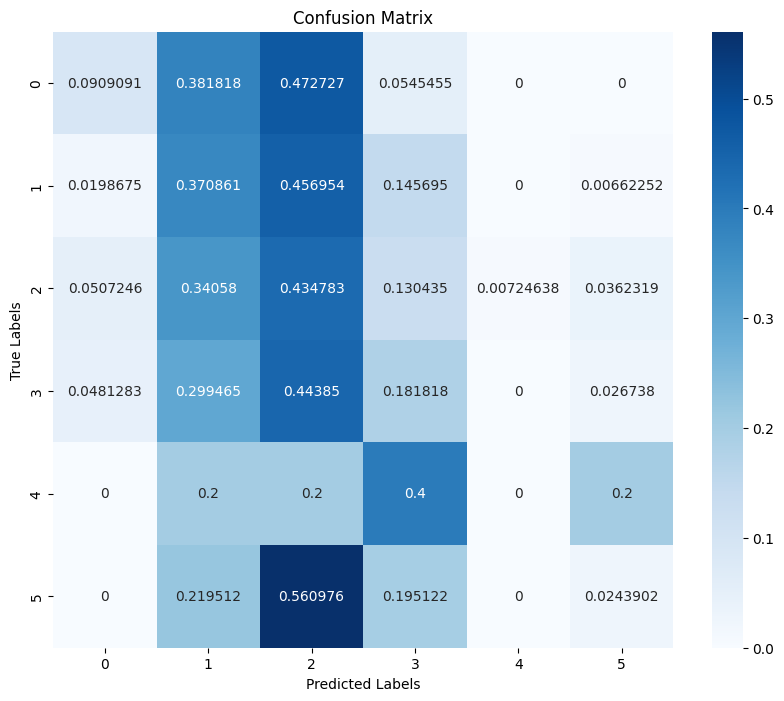

Epoch 1, Validation Loss: 1.6112, Accuracy: 0.2704, F1 Score: 0.2528
Val F1 Score Per Class  [0.12658228 0.32844575 0.3        0.24817518 0.         0.03703704]


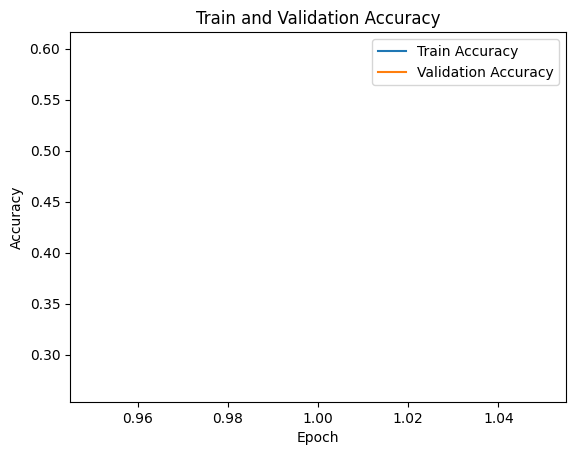

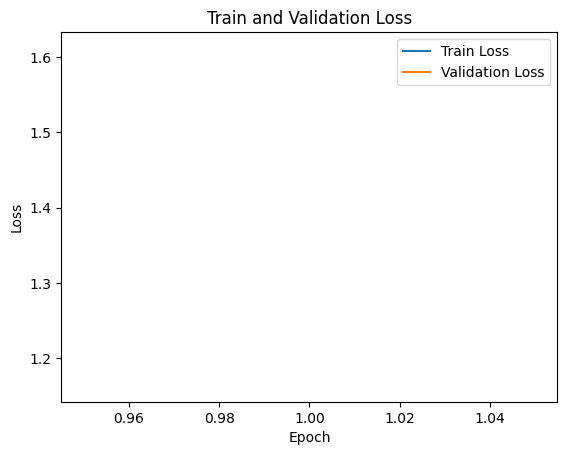

Epoch 2, Train Loss: 0.4077, Accuracy: 0.8878, F1 Score: 0.8868
Train F1 Score Per Class  [0.96060853 0.78473581 0.80737589 0.77228953 0.99970597 0.98496693]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.17it/s, loss=2.18]

[tensor([-1.5195,  2.4092, -0.9401,  0.3989, -1.5849, -1.7007], device='cuda:0'), tensor([-1.2014,  3.0703, -0.0683, -0.1419, -1.9968, -1.8386], device='cuda:0'), tensor([-1.4750,  0.4244, -0.0453,  1.3281, -2.1152, -0.9803], device='cuda:0'), tensor([-1.2419,  2.0817, -0.9262,  1.1810, -1.6873, -1.5179], device='cuda:0'), tensor([-1.5926,  1.6310, -1.0670,  1.1716, -1.8056, -1.2576], device='cuda:0'), tensor([-1.5969,  2.4588,  1.1039,  0.4353, -1.7904, -1.8971], device='cuda:0'), tensor([-0.6469, -0.3040, -1.3796,  2.0768, -1.8775, -1.3227], device='cuda:0'), tensor([-1.9167,  1.3539,  0.5085,  1.6021, -1.7467, -1.7962], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.13it/s, loss=2.25]

[tensor([-1.1130,  1.3428,  1.2119,  0.2345, -2.2836, -2.2947], device='cuda:0'), tensor([-2.1296,  0.5326, -0.9459,  0.2458, -1.0741, -1.6538], device='cuda:0'), tensor([-0.4241,  0.7386, -0.0875,  1.7192, -2.0202, -2.2257], device='cuda:0'), tensor([-0.5921,  0.3480, -0.2223,  1.9019, -1.9093, -1.6899], device='cuda:0'), tensor([-0.7717,  3.0746, -0.3791, -0.4917, -1.7930, -1.6817], device='cuda:0'), tensor([-0.4629,  1.8578, -0.4081,  0.8991, -1.9692, -2.4250], device='cuda:0'), tensor([ 2.7753, -1.0094, -0.6740,  0.1470, -1.5748, -1.1756], device='cuda:0'), tensor([-0.5529,  1.9002, -0.0876,  0.9930, -2.0862, -2.3495], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.15it/s, loss=2.04]

[tensor([-1.6602e+00,  2.3372e+00, -4.5682e-01,  1.7453e-03, -1.8648e+00,
        -2.3360e+00], device='cuda:0'), tensor([-0.1853,  2.2086, -0.6386, -0.5238, -1.2830, -1.7297], device='cuda:0'), tensor([-1.4942,  0.2366,  1.9168,  0.7915, -1.8330, -1.7542], device='cuda:0'), tensor([-0.4290, -0.8558,  0.5602,  0.0960, -2.3024, -1.8956], device='cuda:0'), tensor([-1.0956,  2.5163, -0.9265,  0.9198, -1.1678, -1.5136], device='cuda:0'), tensor([-1.4444,  1.9096, -0.5147,  0.9206, -1.9192, -1.4437], device='cuda:0'), tensor([-0.4178, -1.3012, -0.5126,  0.0997, -2.1699, -2.1215], device='cuda:0'), tensor([-0.8642, -0.5444,  0.4476,  0.1232, -1.5877, -2.1921], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.15it/s, loss=2.19]

[tensor([-1.3927,  0.5042,  2.0150,  1.5810, -1.9626, -2.4815], device='cuda:0'), tensor([-1.6701,  1.8480,  0.5670, -0.5058, -1.6280, -1.6100], device='cuda:0'), tensor([-1.3050,  2.2867, -1.0734, -0.0613, -1.7665, -0.5004], device='cuda:0'), tensor([-0.9006,  0.5051,  0.7754,  0.2451, -1.5586, -2.1190], device='cuda:0'), tensor([ 3.4611, -0.4237, -0.6027,  0.0625, -1.6389, -1.6968], device='cuda:0'), tensor([-0.9729,  1.2910, -0.4812, -0.0380, -2.2251, -1.2962], device='cuda:0'), tensor([-0.5900,  3.2276, -0.6389, -0.1150, -1.6173, -1.5049], device='cuda:0'), tensor([-1.6081,  1.5928,  1.5363, -0.2818, -1.4306, -1.6873], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.16it/s, loss=1.55]

[tensor([-2.0172,  0.5615, -0.3307,  1.2018, -2.3033, -1.8820], device='cuda:0'), tensor([-1.7748,  0.5861,  2.3756,  0.5771, -1.8651, -1.9942], device='cuda:0'), tensor([-0.6895,  0.0326,  1.0300,  0.0666, -2.3701, -2.0869], device='cuda:0'), tensor([-1.3251,  2.1449, -0.5851,  1.5380, -1.9857, -1.8801], device='cuda:0'), tensor([-1.2781,  0.4350,  2.9097,  0.4552, -2.1296, -1.9205], device='cuda:0'), tensor([-1.0684,  1.1992,  0.0699,  0.9316, -2.4400, -1.7429], device='cuda:0'), tensor([-1.4627,  2.1424, -0.6350,  0.1881, -1.9170, -0.7420], device='cuda:0'), tensor([-0.7773,  0.6734, -1.0794,  1.0199, -1.6673, -0.1993], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.13it/s, loss=2.97]

[tensor([-1.1768,  0.1214,  2.9629,  0.2145, -1.9731, -2.3203], device='cuda:0'), tensor([-1.0677,  0.9617,  2.8041, -0.4832, -1.4918, -1.9827], device='cuda:0'), tensor([-1.3966,  2.0732, -0.6913,  0.4103, -2.0583, -1.6162], device='cuda:0'), tensor([-1.5835,  1.8613, -0.1112,  0.9196, -1.8734, -2.2109], device='cuda:0'), tensor([-1.0625,  0.2309,  3.0186,  0.1897, -1.8318, -1.9736], device='cuda:0'), tensor([-1.3540,  0.1725, -1.1708,  1.3345, -1.9739, -0.8694], device='cuda:0'), tensor([-0.8225, -0.7710,  1.5050,  1.9645, -2.0965, -1.4738], device='cuda:0'), tensor([-1.0597,  1.8759, -1.2130,  0.4922, -1.2334, -1.4178], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.14it/s, loss=1.89]

[tensor([-1.2226,  0.7710,  0.1255,  1.3703, -1.8211, -1.8884], device='cuda:0'), tensor([-1.2072,  2.1098,  1.0529, -0.3901, -1.4594, -1.5070], device='cuda:0'), tensor([ 0.0392, -0.3446,  2.9865,  0.0144, -1.4101, -2.0406], device='cuda:0'), tensor([-1.5267,  0.0965,  1.3750,  1.5068, -2.1640, -1.8549], device='cuda:0'), tensor([-1.5323,  1.7847,  1.7936, -0.3312, -1.6294, -2.2036], device='cuda:0'), tensor([-1.2431,  2.6149,  0.4290, -0.3859, -1.6430, -1.6638], device='cuda:0'), tensor([-1.4665, -0.2648,  2.5371,  1.4330, -2.0326, -1.8366], device='cuda:0'), tensor([-0.9595,  2.5639, -0.4173,  0.9207, -2.2497, -1.7247], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=2.25]

[tensor([-0.8187,  2.0396,  0.3301,  0.2717, -1.7798, -1.8788], device='cuda:0'), tensor([-0.8701,  0.3264,  0.6949,  1.2799, -1.9284, -1.4672], device='cuda:0'), tensor([-1.2046,  1.5500, -0.7289,  1.6770, -1.7955, -1.6068], device='cuda:0'), tensor([-0.7641,  3.0866, -0.7671, -0.1170, -1.2172, -1.6457], device='cuda:0'), tensor([-1.4062,  0.4934,  1.4993,  0.3586, -1.8652, -1.8916], device='cuda:0'), tensor([-0.9325,  3.1559, -0.8442,  0.0730, -1.0845, -1.4426], device='cuda:0'), tensor([-1.5413, -0.2566,  0.4703,  1.2726, -2.3301, -1.7544], device='cuda:0'), tensor([-1.1532,  0.4373,  2.9421,  0.1624, -1.5660, -1.8869], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.16it/s, loss=2.89]

[tensor([-1.6342,  1.1782, -1.2864,  0.7174, -1.9262, -0.7319], device='cuda:0'), tensor([-1.1992,  2.9660, -0.0273, -0.0939, -1.7257, -1.3951], device='cuda:0'), tensor([-0.5317,  2.7614, -0.8443,  0.3273, -1.2813, -1.9941], device='cuda:0'), tensor([-0.8313,  1.3208,  1.0831, -0.1434, -1.8212, -1.9931], device='cuda:0'), tensor([ 0.1135, -0.3401,  0.1561,  1.0551, -1.2546, -1.9270], device='cuda:0'), tensor([-1.2349,  2.9794, -0.5321,  0.1783, -1.3603, -1.7775], device='cuda:0'), tensor([-1.3877,  0.9761, -1.2940,  0.9420, -1.8677, -0.9349], device='cuda:0'), tensor([ 0.2009, -0.7230, -0.9871,  1.5943, -2.5250, -2.1853], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=1.6]

[tensor([-1.1635,  3.2701, -0.2984, -0.0705, -1.1544, -1.8164], device='cuda:0'), tensor([-1.1765,  0.5189,  0.7337,  0.8677, -1.2965, -1.8605], device='cuda:0'), tensor([-0.9225,  3.1506, -1.0931,  0.0562, -1.8554, -1.3592], device='cuda:0'), tensor([-0.6477,  0.3677,  0.3815, -0.5407, -2.2284, -1.1469], device='cuda:0'), tensor([-0.7978,  2.3484,  0.0533,  0.4554, -1.5607, -1.7435], device='cuda:0'), tensor([-0.7985,  1.6422, -0.1500,  1.6239, -1.9762, -2.7344], device='cuda:0'), tensor([-1.3459,  2.4097, -0.2495, -0.1574, -1.4578, -1.3641], device='cuda:0'), tensor([-1.4126,  2.4213, -0.6738,  0.7403, -1.4773, -2.1499], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.16it/s, loss=2.18]

[tensor([-1.6783,  2.4473,  0.4055,  0.3328, -1.7031, -2.1390], device='cuda:0'), tensor([-0.1760,  1.1140, -1.3924,  0.9004, -1.5564, -0.9793], device='cuda:0'), tensor([-1.5733,  0.3057,  0.7213,  2.2228, -2.0210, -1.8275], device='cuda:0'), tensor([-0.9412,  1.5115,  0.2319,  1.8952, -2.5042, -2.2353], device='cuda:0'), tensor([-1.7840e+00,  3.1167e+00, -5.9751e-01, -2.5903e-04, -1.6529e+00,
        -9.8143e-01], device='cuda:0'), tensor([-1.3725,  1.0257, -0.9324,  1.5429, -1.8802, -1.4301], device='cuda:0'), tensor([-1.6290,  1.2926,  2.4296, -0.0767, -1.5809, -2.0273], device='cuda:0'), tensor([-0.7508,  1.1927, -1.4808,  1.6376, -1.7640, -1.8642], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=1.42]

[tensor([-1.2539,  0.8650,  1.2979, -0.2213, -1.7478, -1.9987], device='cuda:0'), tensor([-1.2884,  2.3124, -0.2756,  0.5008, -1.5259, -1.5064], device='cuda:0'), tensor([-1.5241,  0.6433,  2.0479,  0.7843, -1.6764, -2.5449], device='cuda:0'), tensor([-1.4234,  2.8970, -0.4740,  0.1167, -1.6227, -1.8633], device='cuda:0'), tensor([ 0.1021,  0.1003, -0.5899,  0.5954, -1.7677, -2.6094], device='cuda:0'), tensor([-1.1258,  0.0127,  3.1409,  0.3768, -1.8694, -1.9990], device='cuda:0'), tensor([-0.6024,  1.0740, -1.2604,  0.4695, -2.0940, -1.2928], device='cuda:0'), tensor([ 1.0986,  0.7877, -0.7607,  0.3034, -2.0607, -2.1734], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.16it/s, loss=1.42]

[tensor([-1.1280,  0.8946, -0.0361,  2.4176, -2.1341, -2.2005], device='cuda:0'), tensor([-1.0068,  2.1439,  0.9389,  0.1809, -1.4913, -2.1051], device='cuda:0'), tensor([-1.4706,  2.5812,  0.2815,  0.1853, -1.9910, -1.9297], device='cuda:0'), tensor([-1.3935,  2.6496,  1.1899, -0.5346, -1.5708, -1.6387], device='cuda:0'), tensor([-1.0059,  1.3424, -1.7559,  0.2038, -0.8726, -0.6070], device='cuda:0'), tensor([-1.3667,  0.7805,  1.1363,  0.4341, -2.2921, -2.1924], device='cuda:0'), tensor([-1.2878,  1.8865, -1.4956,  0.9172, -1.5769, -1.7057], device='cuda:0'), tensor([-1.0011,  3.0798, -0.5377,  0.1215, -1.6114, -1.8782], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.17it/s, loss=0.868]

[tensor([-0.8992,  0.3713,  2.7140,  0.0648, -1.7210, -2.2168], device='cuda:0'), tensor([-0.9861,  1.4167,  0.1787,  0.1790, -2.1698, -1.9236], device='cuda:0'), tensor([-1.5625,  0.1676, -0.9021,  0.0173, -2.3920,  0.5385], device='cuda:0'), tensor([-1.0254,  1.3989,  0.5813,  0.5266, -2.3331, -2.3246], device='cuda:0'), tensor([-1.7681,  0.6787, -0.2066,  2.3076, -1.2088, -1.8446], device='cuda:0'), tensor([-1.4619,  2.9449,  0.0721,  0.5665, -1.4786, -2.0215], device='cuda:0'), tensor([-0.0591, -0.1185, -0.9118,  0.2840, -2.3867, -1.9711], device='cuda:0'), tensor([-1.0332,  2.0820, -0.2265,  0.5496, -2.1498, -1.9403], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:26,  2.17it/s, loss=2.02]

[tensor([-1.3633,  3.1252, -0.7342,  0.2910, -1.5261, -1.0551], device='cuda:0'), tensor([-1.8627,  2.8016, -0.2551,  0.2487, -1.4387, -1.5619], device='cuda:0'), tensor([-0.9171,  0.7813,  2.9984, -0.4929, -1.3045, -1.6608], device='cuda:0'), tensor([-0.1192, -0.8395, -0.3981,  2.8347, -1.8914, -1.7134], device='cuda:0'), tensor([-1.2244,  1.7419, -0.0123,  0.9705, -2.0348, -2.5490], device='cuda:0'), tensor([-1.3455,  3.1697, -0.5094, -0.2700, -1.4929, -1.8395], device='cuda:0'), tensor([-1.6727,  0.7753,  0.2406,  1.3968, -2.0716, -1.2421], device='cuda:0'), tensor([-1.3542,  2.2374,  1.1024,  0.1411, -1.7592, -2.8244], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=1.77]

[tensor([-1.2325,  0.7453,  0.0828,  2.2396, -2.2656, -1.9291], device='cuda:0'), tensor([-1.2399,  3.0361, -0.1414, -0.1368, -1.6584, -1.7234], device='cuda:0'), tensor([-1.0531,  1.1327, -0.4176,  2.3550, -1.6082, -1.7020], device='cuda:0'), tensor([-1.5875,  2.3861,  0.7071,  0.2359, -1.9063, -1.4449], device='cuda:0'), tensor([-0.9289,  0.8335, -0.3554,  2.4503, -1.6625, -1.5758], device='cuda:0'), tensor([-1.7752,  1.0025,  2.0729,  0.6123, -1.7196, -2.0887], device='cuda:0'), tensor([-0.7397, -0.2538,  0.7969,  2.1151, -2.3996, -2.1476], device='cuda:0'), tensor([-1.8042,  1.0766,  1.2817, -0.0361, -1.6835, -1.9998], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:25,  2.16it/s, loss=2.59]

[tensor([-1.6822,  2.6234,  0.6876, -0.0440, -1.6351, -2.0877], device='cuda:0'), tensor([ 0.3392,  0.4545, -0.4251,  0.6808, -2.0464, -1.2004], device='cuda:0'), tensor([-0.8047,  3.2062, -0.9536, -0.2313, -1.4169, -1.1677], device='cuda:0'), tensor([-0.9670,  2.8589, -0.6269,  0.3815, -1.7215, -1.8063], device='cuda:0'), tensor([-1.8334, -0.2043, -0.5880,  1.7850, -2.3572,  0.1381], device='cuda:0'), tensor([-1.2878,  0.2954,  0.1434,  1.4299, -1.7135, -2.4200], device='cuda:0'), tensor([ 3.5491, -0.9686, -0.3992, -0.2237, -1.6310, -1.1156], device='cuda:0'), tensor([-0.4841,  2.7256, -0.9283, -0.2516, -1.6073, -1.7706], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.16it/s, loss=1.74]

[tensor([-1.0008, -0.6095,  0.1909,  2.2882, -2.0233, -1.8174], device='cuda:0'), tensor([-0.5568,  0.6657, -0.8566,  1.9155, -1.2249, -2.0973], device='cuda:0'), tensor([-1.7955,  1.7003,  1.0828,  0.2826, -2.0009, -2.1695], device='cuda:0'), tensor([-0.9907,  2.0601, -0.7136,  1.1537, -1.7652, -1.9889], device='cuda:0'), tensor([-1.6665, -0.2582,  0.4220, -0.1112, -1.3577, -2.5894], device='cuda:0'), tensor([-0.8250,  0.8924,  0.4499,  0.9061, -1.6760, -2.1455], device='cuda:0'), tensor([-0.4598,  0.8002, -0.3360,  0.8922, -1.9894, -1.5962], device='cuda:0'), tensor([-1.4747,  1.4631, -0.1540,  0.5970, -1.3310, -1.8744], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.16it/s, loss=1.9]

[tensor([-1.9286,  0.4090, -0.1236,  1.0459, -1.8249, -0.9443], device='cuda:0'), tensor([ 1.0013,  1.0288, -1.0592,  0.5427, -2.2073, -2.2697], device='cuda:0'), tensor([-0.2168,  0.5295,  1.5174,  0.2826, -1.2659, -2.1674], device='cuda:0'), tensor([-1.4704,  0.3117, -0.1009,  2.5651, -1.5498, -2.0379], device='cuda:0'), tensor([-0.8392,  2.8136, -0.2759,  0.1400, -2.0976, -2.0624], device='cuda:0'), tensor([ 0.6003, -0.8360, -0.6348, -0.1156, -2.0799, -2.1465], device='cuda:0'), tensor([-0.9379,  2.7825, -0.2856,  0.5693, -1.7266, -1.2970], device='cuda:0'), tensor([-0.9134,  1.2600,  0.3105,  0.5084, -1.7224, -1.9697], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=1.85]

[tensor([-1.5558,  1.8458,  1.4026,  0.5418, -1.8200, -2.6571], device='cuda:0'), tensor([-1.4355,  2.5965, -0.0841, -0.2586, -1.3315, -1.7365], device='cuda:0'), tensor([-1.2255,  0.9664,  1.2500,  0.1636, -1.8369, -2.2054], device='cuda:0'), tensor([-8.6251e-01, -6.4929e-01,  1.8969e-03,  2.1653e+00, -2.7416e+00,
        -1.3396e+00], device='cuda:0'), tensor([ 0.4223,  0.0784, -0.0703, -0.2100, -2.0264, -2.1743], device='cuda:0'), tensor([-9.4190e-01,  2.8923e+00, -9.2449e-01, -1.4775e-04, -1.5454e+00,
        -1.0797e+00], device='cuda:0'), tensor([-0.8789,  1.6329, -0.0445,  0.9098, -2.0428, -2.4136], device='cuda:0'), tensor([-1.2002,  1.3384, -0.1945,  0.3768, -1.6742, -2.7398], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.17it/s, loss=2.58]

[tensor([-1.0614,  0.4996,  0.4567,  1.0660, -2.3272, -1.9208], device='cuda:0'), tensor([-1.1061,  3.2055, -0.5005,  0.3418, -1.6867, -1.5141], device='cuda:0'), tensor([-0.9387,  2.5971, -0.2032, -0.0845, -2.3435, -1.4375], device='cuda:0'), tensor([-1.2894,  0.1788,  3.1431,  0.2399, -1.5706, -1.9571], device='cuda:0'), tensor([-1.0929,  2.0845,  0.4741,  0.5169, -2.1027, -2.2705], device='cuda:0'), tensor([-1.2139,  0.6416,  0.0612,  0.1409, -2.2659, -1.9188], device='cuda:0'), tensor([-1.1316, -0.2801, -0.4810,  3.0731, -1.4013, -1.6066], device='cuda:0'), tensor([-1.0208,  0.2864, -0.2822,  1.8780, -1.6926, -0.8837], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.16it/s, loss=2.18]

[tensor([-1.2132,  2.1270, -0.8963,  0.6594, -1.8727, -1.6265], device='cuda:0'), tensor([-0.5396,  1.0494, -0.1858,  0.6905, -2.0469, -1.9483], device='cuda:0'), tensor([-2.1102,  0.8255,  0.7530,  0.7189, -1.5926, -1.2433], device='cuda:0'), tensor([-1.8857,  0.7774,  1.1099,  0.1459, -1.8322, -2.0506], device='cuda:0'), tensor([-1.2131,  1.1167,  1.7562,  1.1197, -1.8462, -2.4521], device='cuda:0'), tensor([-0.3459, -0.0537,  0.3405,  2.0532, -1.6787, -2.8329], device='cuda:0'), tensor([-0.4428,  2.7696, -0.6738, -0.1536, -1.7871, -1.1569], device='cuda:0'), tensor([-1.4604,  0.3104,  0.7648,  1.6253, -1.6848, -2.1182], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.16it/s, loss=1.61]

[tensor([-1.4632,  1.0317, -1.2170,  0.6883, -1.1750, -0.9187], device='cuda:0'), tensor([-1.1174,  0.4818, -0.8775,  1.6438, -1.7920, -1.2929], device='cuda:0'), tensor([-0.5062,  0.2651, -1.1132,  2.0435, -1.0840, -2.0580], device='cuda:0'), tensor([-1.3181,  2.1934, -1.4805,  1.1541, -1.7129, -0.5497], device='cuda:0'), tensor([-1.3095,  2.5972,  0.0986,  0.5463, -1.7437, -2.0750], device='cuda:0'), tensor([-0.8370,  0.0172, -0.7208,  3.0251, -1.5613, -1.5290], device='cuda:0'), tensor([-0.9260,  0.0622,  2.2866,  1.2716, -1.7593, -2.1697], device='cuda:0'), tensor([-1.9913,  1.2741,  2.1429, -0.0104, -1.6112, -2.1370], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.16it/s, loss=2.13]

[tensor([-0.6773,  0.3943, -2.0442,  1.0658, -1.4622, -0.5259], device='cuda:0'), tensor([-0.5057,  1.0315, -0.1446,  0.8611, -2.1107, -2.1273], device='cuda:0'), tensor([-0.8689,  1.6242, -0.4787,  1.4708, -1.7276, -2.6473], device='cuda:0'), tensor([-0.7910,  1.2979,  2.2106, -0.8646, -1.3682, -2.2141], device='cuda:0'), tensor([-2.0864,  1.8011,  1.2822,  0.1322, -1.5802, -2.0065], device='cuda:0'), tensor([-1.3036,  0.1238,  1.3328,  0.4242, -1.6146, -2.3734], device='cuda:0'), tensor([-2.0380,  0.3972, -1.3638,  1.7322, -1.3138,  0.0605], device='cuda:0'), tensor([-0.9041,  2.3423, -1.1537,  1.0055, -2.1276, -1.1434], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.16it/s, loss=2.43]

[tensor([-1.1786,  1.7643, -0.1802,  1.3628, -2.1846, -1.1713], device='cuda:0'), tensor([-0.1199,  1.7118, -0.3398,  0.5140, -2.1196, -1.6578], device='cuda:0'), tensor([-1.3194,  2.4870,  1.1166,  0.0303, -1.9162, -2.1679], device='cuda:0'), tensor([-1.1143,  0.2848,  3.1257,  0.0688, -1.7520, -2.0768], device='cuda:0'), tensor([-0.5383,  2.4678,  0.1149, -0.0067, -2.0210, -2.3005], device='cuda:0'), tensor([-0.9077,  3.0976, -0.4317, -0.4913, -1.3626, -0.8851], device='cuda:0'), tensor([-1.2998,  2.6385, -1.4209, -0.2222, -2.2430, -1.0120], device='cuda:0'), tensor([-1.3510,  1.7504, -1.6232,  0.3689, -1.9401, -0.4486], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.16it/s, loss=2.04]

[tensor([-0.4558,  2.1986, -1.3518, -0.5154, -1.7963, -0.6223], device='cuda:0'), tensor([-1.2358,  2.1685,  0.6635, -0.5497, -1.5248, -1.0093], device='cuda:0'), tensor([-1.4053,  2.6989,  0.8764,  0.4819, -1.7716, -2.0730], device='cuda:0'), tensor([-0.9462,  1.3272, -0.4989,  0.1116, -1.8361, -2.4472], device='cuda:0'), tensor([ 0.0297,  2.6288, -0.7533,  0.0095, -1.7421, -2.1500], device='cuda:0'), tensor([-1.7522,  0.6309,  1.1514,  1.1922, -1.7159, -2.1551], device='cuda:0'), tensor([-1.0461,  1.0975,  1.4691,  0.5472, -1.9195, -2.3120], device='cuda:0'), tensor([ 0.2561, -0.7820,  1.6051,  0.0133, -1.3726, -1.6426], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.15it/s, loss=1.58]

[tensor([-1.5433,  1.1358, -1.0981,  1.8246, -1.5841, -1.3476], device='cuda:0'), tensor([-1.1202,  3.1206,  0.1681, -0.4095, -1.4711, -1.9737], device='cuda:0'), tensor([-0.8677,  0.1156,  0.1137,  0.5535, -1.9180, -2.0961], device='cuda:0'), tensor([-1.3688,  0.6408, -0.1112,  1.5031, -1.5041, -1.8511], device='cuda:0'), tensor([-1.1270,  0.2743,  2.4521,  0.3667, -1.7999, -2.1825], device='cuda:0'), tensor([-1.6287,  2.4157,  0.5977,  0.2948, -1.6533, -2.1100], device='cuda:0'), tensor([-1.4447,  0.1904,  1.1495,  1.9120, -1.7597, -2.1223], device='cuda:0'), tensor([-1.4030,  2.0252, -0.7426,  0.9058, -1.9306, -1.6900], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:12<00:20,  2.16it/s, loss=1.62]

[tensor([-0.1014, -0.4619,  2.7553, -0.0068, -1.6713, -2.0427], device='cuda:0'), tensor([-1.1557, -0.0110,  1.4380,  1.0039, -2.0151, -1.9394], device='cuda:0'), tensor([-0.5947, -0.0704,  0.5743,  1.4240, -2.0505, -2.8921], device='cuda:0'), tensor([-0.9015, -0.6208, -0.3071,  1.7535, -2.5525, -0.2571], device='cuda:0'), tensor([-1.4105,  2.2616,  1.2807, -0.2522, -1.2670, -1.7906], device='cuda:0'), tensor([-1.5087,  2.6211,  0.1987,  0.0676, -1.6242, -1.7362], device='cuda:0'), tensor([-0.8820,  0.7062,  0.5856,  0.5937, -2.3067, -1.4816], device='cuda:0'), tensor([-0.9573,  1.4666,  1.6481, -0.4021, -1.8763, -2.1025], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.16it/s, loss=1.52]

[tensor([ 2.9092, -0.0491, -0.8342, -0.4463, -1.7891, -0.8492], device='cuda:0'), tensor([-1.6981,  1.4282,  0.6472, -0.3091, -1.6979, -2.1053], device='cuda:0'), tensor([-0.4036,  1.4072, -0.9716,  1.1164, -1.5147, -2.6413], device='cuda:0'), tensor([-0.9809,  0.8025,  0.5423,  0.6962, -1.5147, -1.6949], device='cuda:0'), tensor([-0.5510,  2.7220, -0.5313,  0.5882, -1.4138, -2.0451], device='cuda:0'), tensor([-1.4291,  0.6521, -0.7362,  1.9817, -2.0396, -1.1319], device='cuda:0'), tensor([-1.2792,  1.7205,  0.5481,  0.4898, -1.9603, -1.9360], device='cuda:0'), tensor([-1.6889,  2.7835,  0.5315, -0.1092, -1.4336, -1.7403], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=2.31]

[tensor([-1.3406,  3.0721, -0.5751, -0.1059, -1.5061, -1.1799], device='cuda:0'), tensor([-1.5643,  0.5226,  1.4267,  1.8431, -1.8719, -2.2710], device='cuda:0'), tensor([-1.7693,  2.2362, -0.7771,  0.4434, -1.9622, -0.7264], device='cuda:0'), tensor([-1.8109,  3.0049, -0.2722,  0.2707, -1.3589, -1.0292], device='cuda:0'), tensor([-1.5103,  0.1641, -0.5421,  1.3776, -1.4378, -1.4214], device='cuda:0'), tensor([ 1.6991, -0.5307, -0.2878, -0.4870, -1.6467, -2.5423], device='cuda:0'), tensor([-0.4247, -0.1992,  0.1459,  1.1021, -1.6911, -0.9283], device='cuda:0'), tensor([ 1.7254, -0.1824, -0.5744,  0.4117, -2.0904, -1.9423], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.17it/s, loss=1.62]

[tensor([-1.6465, -0.1747, -0.2545,  2.4902, -1.9940, -0.8800], device='cuda:0'), tensor([-0.6526, -0.7462, -0.5410,  2.0480, -2.4064, -1.9258], device='cuda:0'), tensor([-1.4468, -0.3757, -2.2950,  0.9192, -1.4331,  0.1864], device='cuda:0'), tensor([-0.2753,  1.7645,  0.0267,  0.1921, -2.3649, -2.3152], device='cuda:0'), tensor([-0.1352,  1.0264,  1.3049, -0.4068, -1.9907, -2.7651], device='cuda:0'), tensor([-0.9949, -0.1986, -1.4878,  1.5638, -1.3482, -0.5694], device='cuda:0'), tensor([ 0.9749,  2.1753, -1.7617, -0.3417, -1.8242, -1.1493], device='cuda:0'), tensor([-1.3094,  2.1488, -0.3830,  0.6191, -1.6568, -2.2202], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.17it/s, loss=2.04]

[tensor([-1.1769,  2.0248,  0.2893, -0.0323, -1.9773, -1.9728], device='cuda:0'), tensor([-0.4222,  1.0880,  1.8425,  0.5777, -1.9685, -2.6447], device='cuda:0'), tensor([-1.0609,  2.9065,  0.0496,  0.1230, -1.8703, -1.9825], device='cuda:0'), tensor([-1.6021,  2.1210,  0.7520, -0.2245, -1.2235, -2.0664], device='cuda:0'), tensor([-2.0052,  1.0683,  0.7076,  0.2715, -1.7030, -1.6721], device='cuda:0'), tensor([-1.1952,  3.0590, -0.5673, -0.2197, -1.4986, -1.5858], device='cuda:0'), tensor([-1.3534, -0.7672, -1.4316, -0.3817, -1.4278,  3.6289], device='cuda:0'), tensor([-0.6540, -0.1339, -0.3480,  1.0386, -1.0721, -1.9084], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.16it/s, loss=2.01]

[tensor([-0.8221,  2.2007,  0.9944,  0.1899, -2.0517, -2.2156], device='cuda:0'), tensor([ 0.1073,  0.7145, -1.2164,  0.0857, -1.3791, -1.7198], device='cuda:0'), tensor([-0.9494,  2.1571, -0.1134,  0.1497, -2.3920, -2.5000], device='cuda:0'), tensor([-1.6391,  0.6976, -1.7990,  1.4146, -1.0597,  0.3072], device='cuda:0'), tensor([-0.9174,  2.1980, -0.0800,  0.6496, -1.6057, -1.9472], device='cuda:0'), tensor([-1.8587,  0.8225, -0.3612,  0.5679, -1.8718, -2.0689], device='cuda:0'), tensor([-1.2819,  1.0632, -0.8440,  2.0497, -1.8420, -1.5141], device='cuda:0'), tensor([ 1.2377, -0.6602, -0.7006,  0.8228, -2.0458, -2.0528], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.16it/s, loss=2.06]

[tensor([-1.7052,  2.1052,  0.1727,  0.3629, -2.0113, -1.7588], device='cuda:0'), tensor([-1.4216,  1.5907,  1.5192, -0.1198, -1.7943, -2.1161], device='cuda:0'), tensor([-0.8206,  0.8695,  2.8391, -0.5088, -1.3660, -2.1691], device='cuda:0'), tensor([-1.6543,  1.1473,  1.3910,  0.0911, -2.1729, -1.6552], device='cuda:0'), tensor([-0.5137,  0.1547,  0.0319,  2.4866, -1.9647, -1.7785], device='cuda:0'), tensor([-1.8559e+00,  1.8208e+00,  1.7442e+00,  7.8216e-04, -1.6536e+00,
        -1.9485e+00], device='cuda:0'), tensor([ 3.1407, -0.8249, -1.3655,  0.1214, -2.0078, -0.5422], device='cuda:0'), tensor([-0.8349,  2.7899,  0.4092, -0.3548, -1.8018, -2.0883], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.16it/s, loss=1.99]

[tensor([-1.2501,  0.9523, -0.1074,  0.8428, -1.9453, -2.8752], device='cuda:0'), tensor([-1.4731,  1.8604,  1.3737, -0.3445, -1.7495, -1.5367], device='cuda:0'), tensor([-0.1520,  0.3052,  0.0424,  1.7345, -2.6695, -2.2487], device='cuda:0'), tensor([ 0.8141, -0.9443, -0.5078,  1.1831, -2.0049, -1.3264], device='cuda:0'), tensor([-0.4924,  0.4494, -0.0262,  1.0013, -1.5791, -1.5823], device='cuda:0'), tensor([-1.1605,  1.0045, -1.4474,  1.6606, -1.6341, -0.4793], device='cuda:0'), tensor([ 0.5912, -0.9725,  0.4820,  0.6780, -2.1125, -2.2365], device='cuda:0'), tensor([-1.5187,  2.7857,  0.5806,  0.1135, -1.7332, -1.8165], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.17it/s, loss=1.82]

[tensor([-1.3899,  0.7547,  0.7189,  0.2877, -1.7203, -1.7384], device='cuda:0'), tensor([ 2.1440, -0.9104, -0.6369, -0.2379, -2.1328, -1.9249], device='cuda:0'), tensor([-1.8930e+00,  1.0871e+00,  7.5854e-04,  8.8499e-01, -1.4971e+00,
        -2.1325e+00], device='cuda:0'), tensor([-1.4164,  2.3012, -0.0785,  0.5628, -1.8435, -2.0041], device='cuda:0'), tensor([-0.7380, -0.4625,  0.7149,  2.2296, -1.9037, -2.6109], device='cuda:0'), tensor([-1.6046,  3.0411,  0.3799, -0.1099, -0.8933, -2.0476], device='cuda:0'), tensor([-1.4301,  2.2798, -0.3416,  0.2446, -2.0379, -1.1620], device='cuda:0'), tensor([-1.3427,  2.5641,  1.1550, -0.4680, -1.4172, -2.3743], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.16it/s, loss=2.75]

[tensor([-1.3934,  1.1980, -1.3221,  0.9706, -1.5506, -0.9424], device='cuda:0'), tensor([-1.1176,  2.9585, -0.7304,  0.2270, -1.3664, -1.2140], device='cuda:0'), tensor([ 2.6441, -0.8265, -0.7835,  0.3881, -1.9805, -1.3842], device='cuda:0'), tensor([-1.2699,  1.2135,  2.8893, -0.3354, -1.6790, -2.2264], device='cuda:0'), tensor([-1.2498,  1.0375,  1.5189,  0.1898, -1.5250, -2.0692], device='cuda:0'), tensor([-0.8386,  2.1922, -0.1395,  0.1856, -1.6527, -2.1826], device='cuda:0'), tensor([-1.0491,  3.0037, -0.1691, -0.2037, -1.7158, -1.7885], device='cuda:0'), tensor([-1.6819,  2.0814, -0.0471,  1.5267, -1.7809, -1.9002], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=2.48]

[tensor([-1.9818, -0.0456, -1.8566,  0.4126, -0.9539,  1.8468], device='cuda:0'), tensor([-0.9488,  0.3066,  1.3142,  0.8633, -1.1501, -2.0144], device='cuda:0'), tensor([-1.8164,  2.5052, -0.1894,  1.1972, -1.4213, -1.9391], device='cuda:0'), tensor([-0.2580, -0.4965,  2.6742, -0.1041, -1.8740, -2.1433], device='cuda:0'), tensor([-1.3919,  0.4178,  2.6997, -0.1578, -1.8861, -1.0669], device='cuda:0'), tensor([-0.7780,  0.8806, -0.4021,  1.4378, -1.7942, -1.9038], device='cuda:0'), tensor([-1.1691,  2.2520, -1.0497,  0.2725, -1.5358, -1.3515], device='cuda:0'), tensor([-1.2764,  3.2860, -0.5152, -0.0216, -1.3750, -1.7378], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.16it/s, loss=2.17]

[tensor([-0.3338,  1.9478,  0.8724,  0.3442, -1.9955, -2.9061], device='cuda:0'), tensor([-1.4571,  0.7628, -1.6467,  1.2964, -1.0570,  0.1900], device='cuda:0'), tensor([ 3.3113, -0.6637, -1.1365,  0.1861, -1.4847, -1.5059], device='cuda:0'), tensor([-1.3609,  2.5420,  0.6681,  0.5726, -1.8420, -2.3204], device='cuda:0'), tensor([ 1.3297, -0.2679, -0.8746,  0.2255, -1.9756, -1.8173], device='cuda:0'), tensor([-0.4714, -0.7155,  3.0994,  0.4961, -1.7645, -1.7268], device='cuda:0'), tensor([-0.9651,  2.1153, -0.8551,  1.0152, -1.2518, -2.5399], device='cuda:0'), tensor([-1.6919,  0.4805,  2.5177,  0.6413, -1.7184, -2.1556], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=2.36]

[tensor([-1.2830,  3.1237, -0.5497,  0.1797, -1.2513, -1.8697], device='cuda:0'), tensor([-1.5730,  2.4227, -0.7523,  0.5920, -1.5462, -1.4279], device='cuda:0'), tensor([-1.5862,  2.6502,  0.6456,  0.1571, -1.8198, -1.9715], device='cuda:0'), tensor([-0.9392,  0.2745,  3.0953, -0.4410, -1.3999, -2.1143], device='cuda:0'), tensor([-0.4169,  2.8712, -0.9447,  0.2814, -1.2596, -1.8627], device='cuda:0'), tensor([-1.9245,  0.0635, -1.4657,  0.9946, -2.0400,  0.2923], device='cuda:0'), tensor([-1.6683,  1.9398,  0.9268,  0.4661, -2.2982, -2.1945], device='cuda:0'), tensor([ 0.3931, -0.1105,  0.4201,  1.0521, -0.7528, -2.0248], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:18<00:14,  2.16it/s, loss=2.09]

[tensor([-0.9020,  0.2755, -0.9023,  2.8081, -1.3536, -1.9359], device='cuda:0'), tensor([-1.1905, -0.4017, -0.8137,  2.7934, -2.2096, -0.9139], device='cuda:0'), tensor([-1.3496,  2.5869, -0.5785,  0.5785, -1.7866, -1.4941], device='cuda:0'), tensor([-0.1191,  0.2273, -1.5437,  2.4902, -1.7573, -1.0909], device='cuda:0'), tensor([-1.1100,  3.0587, -0.1499,  0.4574, -1.5342, -2.1096], device='cuda:0'), tensor([-1.2962,  0.0045,  2.7832,  0.6538, -1.5065, -2.1362], device='cuda:0'), tensor([-0.9776,  2.0499, -0.5534,  0.2024, -1.3479, -2.0512], device='cuda:0'), tensor([-0.1817,  0.4536,  2.6940, -0.2676, -2.0997, -2.0999], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=1.83]

[tensor([-1.2043, -0.1793,  2.5114,  0.3634, -1.8986, -1.2622], device='cuda:0'), tensor([-0.9646,  2.0024, -0.7196,  0.4607, -1.7381, -1.4478], device='cuda:0'), tensor([ 2.2102,  0.4439,  0.2317, -0.6741, -2.1923, -1.3327], device='cuda:0'), tensor([-1.5295,  3.0780, -0.3149,  0.0394, -1.4510, -1.8206], device='cuda:0'), tensor([-0.6698,  0.1719, -1.1756,  2.3676, -1.9249, -1.3666], device='cuda:0'), tensor([-1.3375,  2.6424, -1.0797,  1.0891, -1.5104, -1.2123], device='cuda:0'), tensor([-0.4014,  1.1841, -0.3905,  0.5457, -1.8905, -2.1917], device='cuda:0'), tensor([-1.0551,  0.8554,  2.1812, -0.2041, -1.8067, -2.1561], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:14,  2.14it/s, loss=1.93]

[tensor([-1.5245,  1.6276, -0.6332,  1.9907, -1.8352, -2.0060], device='cuda:0'), tensor([-1.4472,  1.7510,  0.7945, -0.7811, -1.3838, -1.3692], device='cuda:0'), tensor([-1.6094,  1.8449, -0.0132,  0.7644, -1.9773, -1.6129], device='cuda:0'), tensor([-0.5160,  0.6284,  0.5376,  1.6297, -2.4221, -2.5292], device='cuda:0'), tensor([-1.5012,  2.4285,  0.1678,  0.6101, -2.0199, -2.1545], device='cuda:0'), tensor([-1.3707,  1.1490, -0.6871,  1.0134, -2.2931, -2.0285], device='cuda:0'), tensor([-0.4042, -0.2514, -0.2555,  2.9641, -1.6910, -1.9741], device='cuda:0'), tensor([-0.7520, -0.2554,  0.4698,  1.3931, -1.8792, -2.3297], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.14it/s, loss=2.04]

[tensor([-1.0351,  2.2537, -1.0116,  1.1577, -1.0268, -1.7874], device='cuda:0'), tensor([-0.0438,  0.5376,  0.4125,  0.8578, -2.0897, -2.2552], device='cuda:0'), tensor([-1.9079,  2.1512, -0.0907,  0.0601, -1.7253, -1.7503], device='cuda:0'), tensor([-1.7280,  1.3223,  0.3274,  0.5792, -2.0032, -1.7959], device='cuda:0'), tensor([-0.7330, -0.2440, -0.4969,  1.0825,  0.0214, -1.4230], device='cuda:0'), tensor([-1.7623,  2.1301,  1.4184,  0.3712, -1.7443, -2.1554], device='cuda:0'), tensor([-0.1129, -0.8595, -0.2165,  0.5983, -2.5265,  0.4195], device='cuda:0'), tensor([-0.4440,  2.6564, -0.6991, -0.3935, -1.6229, -0.6121], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.15it/s, loss=2.01]

[tensor([-0.8288,  1.2089, -1.8482,  1.0311, -2.1327, -0.9853], device='cuda:0'), tensor([-1.0752,  0.0832, -0.5439,  1.8935, -1.1830, -2.0959], device='cuda:0'), tensor([-1.2782,  1.7204, -1.0811,  1.6745, -1.5066, -0.9375], device='cuda:0'), tensor([-1.0750,  1.7470,  1.5873, -0.6141, -1.4878, -2.0831], device='cuda:0'), tensor([-1.0700,  0.0582,  2.8232,  0.4104, -1.7579, -1.7492], device='cuda:0'), tensor([-1.5998, -0.6705, -1.6865,  0.4196, -1.6875,  2.4782], device='cuda:0'), tensor([-1.0692,  3.0517, -0.8862,  0.0069, -1.2761, -1.3294], device='cuda:0'), tensor([-1.6453,  0.1441, -0.5247,  2.2063, -2.2091, -1.4035], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.15it/s, loss=1.76]

[tensor([-0.9650,  1.1817,  0.9536,  0.3181, -1.9718, -2.3610], device='cuda:0'), tensor([-0.9570,  1.2687, -0.3473,  0.3303, -1.3603, -1.6139], device='cuda:0'), tensor([-1.1721,  0.9497, -0.5633,  1.9928, -1.3265, -2.3398], device='cuda:0'), tensor([-1.3596, -0.5982, -0.2838, -0.0864, -2.3393, -1.4768], device='cuda:0'), tensor([-1.7999,  2.3824, -1.0118,  0.4349, -1.4125, -0.9642], device='cuda:0'), tensor([-1.2670,  2.0617, -0.8156,  0.5463, -1.5785, -1.6116], device='cuda:0'), tensor([-1.1563,  1.7869,  0.6095,  0.8701, -1.9998, -1.9052], device='cuda:0'), tensor([-0.4943,  0.7116,  1.7957,  0.1119, -1.5893, -2.2011], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.29]

[tensor([ 3.8158, -0.7955, -1.1486, -0.3278, -1.1053, -1.1762], device='cuda:0'), tensor([-0.5779,  2.0214, -1.2877,  0.8372, -1.8346, -0.9708], device='cuda:0'), tensor([-1.7435,  1.0401,  0.7732,  0.6523, -1.5167, -2.1130], device='cuda:0'), tensor([-1.1536,  0.5056,  3.1675,  0.3327, -1.8116, -1.9313], device='cuda:0'), tensor([-1.1435,  2.9368,  0.4641, -0.0624, -1.8118, -2.0161], device='cuda:0'), tensor([-0.7177,  0.2439, -1.2440,  0.9277, -2.0619, -1.2521], device='cuda:0'), tensor([ 0.4038,  0.8368, -0.5212,  1.0331, -1.2928, -2.2610], device='cuda:0'), tensor([-1.0088,  1.0436, -0.2671,  0.6992, -2.0395, -1.8497], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=2.65]

[tensor([-0.9528,  0.5474,  3.1268, -0.4258, -1.7232, -1.7386], device='cuda:0'), tensor([-1.2687,  2.8754,  0.6111,  0.2589, -1.8252, -2.1278], device='cuda:0'), tensor([-1.3677,  2.8856, -0.2565,  0.3015, -2.0207, -1.7566], device='cuda:0'), tensor([-1.0335,  3.2656, -0.6089, -0.4271, -1.4965, -1.2295], device='cuda:0'), tensor([-0.1374, -0.2903, -0.8122,  2.9742, -1.6145, -1.7616], device='cuda:0'), tensor([ 2.4685, -0.8699, -0.2672, -0.5199, -1.4710, -1.8423], device='cuda:0'), tensor([-0.5427,  1.9595,  0.6491,  0.0350, -2.1745, -2.1943], device='cuda:0'), tensor([-1.7396,  0.8887,  1.3665,  0.3102, -1.6207, -1.8865], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.16it/s, loss=1.62]

[tensor([-1.5674,  0.9978,  0.9432,  1.5000, -1.6797, -2.2085], device='cuda:0'), tensor([-0.4254,  1.9786, -0.9887, -0.1436, -1.4537, -1.8557], device='cuda:0'), tensor([-1.9687,  1.6767, -0.5011,  1.3773, -1.3829, -1.7142], device='cuda:0'), tensor([-0.8336,  0.1193,  2.1830,  0.0999, -1.9981, -2.0308], device='cuda:0'), tensor([-1.2050,  2.6513,  0.6817,  0.2577, -1.4006, -1.8011], device='cuda:0'), tensor([-0.7849,  0.4473,  0.2877,  0.5805, -1.9554, -2.5551], device='cuda:0'), tensor([-1.3397,  1.1736, -0.9692,  0.8827, -2.0942, -1.3897], device='cuda:0'), tensor([-1.2895,  0.0574,  0.5413,  2.2785, -2.0268, -1.8731], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.16it/s, loss=1.77]

[tensor([-0.9443,  1.9155, -0.1166,  0.7955, -2.2500, -1.6493], device='cuda:0'), tensor([-1.1981,  1.3700,  0.9675,  0.7000, -2.1821, -2.3209], device='cuda:0'), tensor([-1.3756,  1.1078,  0.7526,  0.8233, -1.5728, -1.6878], device='cuda:0'), tensor([-0.7850,  1.7360,  0.1650,  0.9109, -2.5459, -2.1878], device='cuda:0'), tensor([-1.0218,  1.8002,  2.0245, -0.2427, -1.6645, -2.0876], device='cuda:0'), tensor([-1.5307, -0.0335, -1.4750,  2.5501, -1.4503, -0.3805], device='cuda:0'), tensor([-0.8860,  0.4784,  0.0677,  2.3785, -1.9546, -1.3680], device='cuda:0'), tensor([-1.1835,  2.9705,  0.0731,  0.5973, -1.7637, -1.9783], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.17it/s, loss=1.09]

[tensor([-1.4176,  0.8410,  1.9478,  0.8159, -2.2859, -1.7731], device='cuda:0'), tensor([-0.6492, -0.5629, -0.5868,  3.1413, -1.9820, -1.2540], device='cuda:0'), tensor([-1.2044,  2.7919, -0.9757,  0.4494, -1.7776, -0.6179], device='cuda:0'), tensor([-1.3320,  2.0768, -0.4587,  1.9643, -1.8422, -1.8524], device='cuda:0'), tensor([-1.1929,  3.1627,  0.4793, -0.2924, -1.5872, -1.7454], device='cuda:0'), tensor([-0.1059,  1.2347, -2.2304,  0.5493, -1.6004, -0.0378], device='cuda:0'), tensor([ 0.1792,  1.3817, -0.9145,  1.3354, -1.4197, -2.4096], device='cuda:0'), tensor([-0.8677,  1.5880, -0.6887, -0.9072, -1.8794,  0.3150], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.16it/s, loss=1.88]

[tensor([-1.6158,  1.5069,  1.3950, -0.1396, -1.7696, -1.8492], device='cuda:0'), tensor([-0.1274, -0.0321, -0.4729,  2.3730, -1.5714, -2.5485], device='cuda:0'), tensor([-1.3421,  1.8270, -0.7101,  1.2852, -0.9595, -2.0308], device='cuda:0'), tensor([-1.2410,  2.8735, -0.9756,  0.3624, -1.5063, -1.1307], device='cuda:0'), tensor([-1.3073,  0.6807,  2.4411, -0.2847, -1.8783, -1.3516], device='cuda:0'), tensor([-0.8028,  2.5462, -0.7506, -0.2839, -1.6339, -1.7329], device='cuda:0'), tensor([ 0.6031, -0.1318,  0.1304,  0.2708, -2.4155, -1.5501], device='cuda:0'), tensor([-0.8609,  2.0340, -0.3362,  0.6895, -1.8061, -1.3260], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.16it/s, loss=1.66]

[tensor([-1.2347,  0.9352, -0.9478,  2.6000, -1.9115, -1.6737], device='cuda:0'), tensor([-0.9922,  1.5469,  0.2210,  0.0611, -2.0686, -1.7229], device='cuda:0'), tensor([-1.0794,  0.1239,  1.3757,  1.4777, -2.4176, -2.1713], device='cuda:0'), tensor([-1.3824,  2.0812,  0.1503,  0.7307, -1.9005, -2.1082], device='cuda:0'), tensor([ 2.0948, -0.3918, -0.2554, -0.2394, -1.5182, -1.7631], device='cuda:0'), tensor([-0.1810,  0.4832,  0.3334,  1.7488, -2.3461, -2.6860], device='cuda:0'), tensor([ 1.7624, -0.4156,  1.0199,  0.2460, -2.3966, -2.3183], device='cuda:0'), tensor([-1.3453,  0.6662,  0.5291,  1.4680, -1.8745, -2.5855], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.15it/s, loss=1.75]

[tensor([-1.7939,  0.7097,  0.1314,  0.8691, -1.7958, -1.7567], device='cuda:0'), tensor([ 0.8834, -0.4201, -0.0527,  1.1812, -2.2149, -2.3277], device='cuda:0'), tensor([-1.0671,  1.3169, -0.9930,  0.7522, -1.8086, -0.4935], device='cuda:0'), tensor([-0.4555,  0.2071, -0.9705,  2.2980, -2.1752, -1.3583], device='cuda:0'), tensor([-1.4146,  0.1692,  1.8828,  1.6094, -1.7719, -2.0353], device='cuda:0'), tensor([-1.5441,  1.7496, -1.2421,  1.3357, -1.5906, -0.9377], device='cuda:0'), tensor([-0.4193,  1.9957, -0.2112,  0.3449, -1.8771, -2.6279], device='cuda:0'), tensor([-1.7399,  2.3567, -0.1577,  0.1710, -2.0246, -0.6961], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.16it/s, loss=1.66]

[tensor([-1.4444,  0.2377,  1.5107,  1.0556, -1.2938, -2.0280], device='cuda:0'), tensor([ 1.5212e-03,  1.2696e+00,  3.6864e-01,  3.9354e-01, -1.7827e+00,
        -2.8438e+00], device='cuda:0'), tensor([-0.8993,  2.1551,  0.4898,  0.1645, -1.4474, -2.5687], device='cuda:0'), tensor([-1.0220,  0.9354,  2.5651, -0.0187, -1.9881, -2.1511], device='cuda:0'), tensor([-1.4708,  2.1561,  1.2178,  0.0522, -1.8691, -1.8186], device='cuda:0'), tensor([-0.6621,  0.4968,  1.8513,  0.0552, -1.9590, -2.0412], device='cuda:0'), tensor([-0.8368,  0.9780,  1.3036,  0.4981, -1.7809, -2.3120], device='cuda:0'), tensor([-0.5924,  3.0377, -0.4950, -0.3458, -1.5684, -1.4981], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:25<00:07,  2.15it/s, loss=1.48]

[tensor([-1.0719,  2.5019, -0.2323, -0.2914, -1.9886, -1.4182], device='cuda:0'), tensor([-1.3915,  2.5532,  0.6882,  0.4053, -1.3413, -2.1896], device='cuda:0'), tensor([-1.3503, -0.3604,  1.2014,  1.4116, -2.3951, -1.9460], device='cuda:0'), tensor([-1.2784,  2.6093, -0.4464,  0.1795, -1.7764, -2.1947], device='cuda:0'), tensor([-1.6202,  3.0881,  0.2030,  0.1271, -1.5092, -2.0679], device='cuda:0'), tensor([-1.2833, -0.6653, -0.4808,  2.2144, -2.2648, -0.2824], device='cuda:0'), tensor([-1.0138,  2.3882, -1.2662,  0.2418, -1.1832, -1.4484], device='cuda:0'), tensor([-0.5554,  1.4952, -0.9695,  1.4938, -1.6784, -1.7786], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=1.46]

[tensor([-1.4466,  3.1421,  0.0247, -0.0091, -1.4584, -1.4527], device='cuda:0'), tensor([ 0.0199,  1.8468,  0.4630,  0.1420, -2.3366, -2.0428], device='cuda:0'), tensor([ 0.1108,  0.2406,  0.8271,  0.5582, -1.8186, -1.8255], device='cuda:0'), tensor([-0.8995, -0.3877, -0.1503,  0.0663, -2.4120, -2.2661], device='cuda:0'), tensor([-0.6182,  0.0195,  0.6886,  0.8317, -1.8479, -2.0816], device='cuda:0'), tensor([-1.2106,  2.0443, -0.0779,  1.2405, -1.8712, -2.4664], device='cuda:0'), tensor([-1.0688,  2.9279, -1.1175,  0.0034, -1.0313, -1.2428], device='cuda:0'), tensor([-1.4179,  0.8185,  0.0258,  1.7991, -1.9171, -1.8609], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.15it/s, loss=1.79]

[tensor([-1.9019,  1.3275, -0.2042,  1.4555, -1.7614, -2.1913], device='cuda:0'), tensor([-0.8294,  0.8794,  0.1611,  0.1190, -2.2955, -2.5922], device='cuda:0'), tensor([-1.3343,  2.4197, -0.4054, -0.1866, -1.5866, -1.2569], device='cuda:0'), tensor([-1.2445,  1.1439, -0.2190,  0.6982, -0.6877, -1.9436], device='cuda:0'), tensor([-1.8045,  2.1484,  0.8648,  1.2501, -1.9581, -2.3595], device='cuda:0'), tensor([-1.6903,  2.0496,  0.2965,  0.8775, -1.7349, -2.1382], device='cuda:0'), tensor([-1.2115,  2.8101,  0.2907,  0.1108, -1.7274, -1.7708], device='cuda:0'), tensor([-1.2528,  1.6798,  0.8256,  0.4601, -1.5596, -2.2624], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.15it/s, loss=1.43]

[tensor([-1.0330,  0.8917, -0.9053,  2.4038, -1.2995, -2.1002], device='cuda:0'), tensor([-1.4845,  1.1832,  1.5526, -0.0993, -2.2532, -2.3233], device='cuda:0'), tensor([-0.9552,  2.1821, -0.9756,  1.0677, -1.4812, -1.5495], device='cuda:0'), tensor([-0.5432,  2.1755, -1.2717,  0.6098, -1.4839, -1.4631], device='cuda:0'), tensor([ 0.0645,  2.2209, -0.6267, -0.3038, -2.2443, -1.5343], device='cuda:0'), tensor([-0.7216,  1.9715, -0.6590,  0.9324, -1.5036, -2.5495], device='cuda:0'), tensor([-1.0181,  3.0431, -0.4090,  0.3315, -2.0427, -1.6093], device='cuda:0'), tensor([-1.2374,  0.9385,  2.0609, -0.1318, -1.6916, -2.1441], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.14it/s, loss=2.2]

[tensor([-0.9464,  0.0184,  0.1400,  2.5899, -1.4781, -1.7501], device='cuda:0'), tensor([-1.3151,  1.9306,  1.1744,  0.4546, -1.8591, -2.3536], device='cuda:0'), tensor([-0.8271, -0.2483, -0.4748,  1.4804, -1.5954, -1.8796], device='cuda:0'), tensor([-1.7155,  1.9176, -0.4192,  1.1415, -1.0842, -1.2845], device='cuda:0'), tensor([-1.5074,  2.3056, -0.9127,  0.5392, -1.6982, -2.1317], device='cuda:0'), tensor([-0.3683, -0.1733,  1.0126,  0.1578, -2.4485, -2.4624], device='cuda:0'), tensor([-1.5491,  0.7246, -0.4543,  1.1276, -2.6834, -1.3255], device='cuda:0'), tensor([-1.3646,  1.5373, -0.4614,  0.3130, -1.8822, -2.3728], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.14it/s, loss=2.18]

[tensor([ 0.0819, -0.7235,  0.4265,  1.0951, -1.6487, -2.0387], device='cuda:0'), tensor([-1.1311,  2.9604,  0.5934, -0.3523, -1.2843, -1.6565], device='cuda:0'), tensor([-0.2320,  1.7306, -0.1917,  0.5763, -2.1712, -2.2070], device='cuda:0'), tensor([-1.4026,  0.3317, -0.8471,  1.4099, -1.8261, -0.3999], device='cuda:0'), tensor([-1.7718,  1.4511,  1.3569,  0.0504, -1.5385, -1.7307], device='cuda:0'), tensor([ 0.1483,  0.3646, -1.8751,  0.4622, -0.6796,  0.6466], device='cuda:0'), tensor([-0.6678,  1.2187,  0.0087,  0.4888, -1.8265, -1.7078], device='cuda:0'), tensor([ 2.0090, -1.2649, -1.7405, -0.3583, -1.3097,  0.1600], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.13it/s, loss=1.76]

[tensor([-0.7020,  1.0765,  1.1805,  0.2172, -1.6456, -2.3494], device='cuda:0'), tensor([-1.1359,  0.9600,  2.2450, -0.4910, -1.3055, -2.1507], device='cuda:0'), tensor([ 1.0625,  0.6001,  0.0676,  0.3416, -1.9638, -2.2089], device='cuda:0'), tensor([-0.3481,  0.6357, -0.3825,  1.3427, -0.0432, -1.9884], device='cuda:0'), tensor([-1.2227,  1.2341, -0.3245,  1.3505, -2.4712, -1.7163], device='cuda:0'), tensor([-1.2177,  0.9873,  1.5154,  0.5503, -1.8221, -1.9883], device='cuda:0'), tensor([-1.5192,  1.7611,  0.2977,  1.1135, -2.0367, -2.0538], device='cuda:0'), tensor([-1.6328,  2.3641, -0.7607,  0.5359, -1.6796, -1.4078], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.13it/s, loss=1.02]

[tensor([-0.6008,  0.5098,  2.3629,  0.1532, -2.0854, -2.3101], device='cuda:0'), tensor([-1.1615,  1.6102,  2.0015,  0.1202, -1.6941, -2.4106], device='cuda:0'), tensor([-1.4883,  0.9265, -1.7689,  0.7268, -2.3273, -2.0431], device='cuda:0'), tensor([-1.2476,  2.4988,  0.0969,  0.2756, -1.9282, -1.5282], device='cuda:0'), tensor([-1.5423,  2.9267, -0.5152, -0.0733, -1.1959, -1.5075], device='cuda:0'), tensor([ 2.5194, -1.1821, -1.3033,  0.7573, -1.7318, -0.6910], device='cuda:0'), tensor([-1.2502,  0.9361,  2.5971, -0.0719, -1.3937, -2.2534], device='cuda:0'), tensor([-0.6064,  1.2267, -0.2867, -0.2836, -1.5611, -1.7188], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.14it/s, loss=1.12]

[tensor([-0.9702,  0.3093, -1.0133,  2.4153, -1.1706, -1.5877], device='cuda:0'), tensor([-1.4955,  1.9287, -0.1491,  0.6792, -1.4947, -2.7049], device='cuda:0'), tensor([-0.2067,  0.0996,  1.7394, -0.2838, -1.8806, -2.1102], device='cuda:0'), tensor([-1.4363,  2.2257,  0.2147,  0.6836, -1.7573, -1.8526], device='cuda:0'), tensor([-0.2767, -0.6575, -0.4412,  0.4454, -2.3504, -2.4747], device='cuda:0'), tensor([-1.3938,  1.6895,  1.6525, -0.1572, -1.3254, -2.2584], device='cuda:0'), tensor([-0.0471,  0.5343, -0.7544,  2.4166, -1.8071, -2.6207], device='cuda:0'), tensor([-1.9377,  1.2168, -1.3229,  0.6440, -0.8642, -0.9683], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=1.04]

[tensor([-1.4075,  2.8259, -0.0461,  0.0156, -1.7506, -1.9123], device='cuda:0'), tensor([-0.6013,  1.3223, -0.7261,  0.9898, -2.0204, -2.3178], device='cuda:0'), tensor([-1.1242,  1.3976, -0.9965,  0.9796, -1.2726, -2.2173], device='cuda:0'), tensor([-1.0844,  0.6438,  0.8521,  0.7237, -1.8078, -1.9888], device='cuda:0'), tensor([-1.1122,  0.9870, -0.2743,  0.5455, -1.8184, -2.1831], device='cuda:0'), tensor([ 2.3141, -0.9270,  0.0570,  0.0393, -2.5009, -1.4158], device='cuda:0'), tensor([-1.6188,  0.8281,  0.4728,  1.4909, -1.9151, -2.7330], device='cuda:0'), tensor([-1.1551,  0.0743, -0.5223,  2.2471, -1.8213, -0.5564], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.14it/s, loss=2.5]

[tensor([-0.5878,  0.6562,  0.7481,  1.1184, -1.1984, -1.1678], device='cuda:0'), tensor([-0.8717, -0.4873, -1.1123,  0.6792, -1.2364,  0.9263], device='cuda:0'), tensor([-1.3435, -0.0164,  1.5294,  1.5422, -2.2189, -2.1860], device='cuda:0'), tensor([-1.6604,  1.4727, -0.8786,  1.4027, -1.4390, -1.4588], device='cuda:0'), tensor([ 1.8076, -1.2067,  0.7313, -0.1301, -2.7402, -1.7027], device='cuda:0'), tensor([-1.5100,  1.2854,  0.4626,  1.1899, -2.3943, -2.2276], device='cuda:0'), tensor([-0.6163,  0.4254,  3.0234, -0.0067, -1.8511, -2.0418], device='cuda:0'), tensor([-1.4995,  2.5456, -0.2628,  0.5303, -1.7969, -1.8951], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=2.7]

[tensor([-1.1847,  0.2578, -1.5865, -0.6958,  2.3057, -0.9843], device='cuda:0'), tensor([-1.8400,  0.4928,  1.9445,  0.6911, -2.0054, -2.0246], device='cuda:0'), tensor([-1.0315,  0.9891,  0.4796,  0.5177, -1.9653, -1.3064], device='cuda:0'), tensor([-1.1220,  2.6597,  0.1692,  0.1002, -1.7154, -1.8733], device='cuda:0'), tensor([-1.1079,  1.9401, -0.8518,  0.7864, -1.7508, -1.6710], device='cuda:0'), tensor([-1.5547,  1.8403,  1.3139,  0.1905, -2.4813, -1.8745], device='cuda:0'), tensor([-1.9191,  1.2785, -0.6457,  1.8419, -1.7112, -1.5368], device='cuda:0'), tensor([ 0.8514,  1.2029,  0.7286, -0.4889, -1.7044, -1.6711], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.14it/s, loss=2.27]

[tensor([-1.1731,  2.7326,  1.5264, -0.5690, -1.5794, -2.0117], device='cuda:0'), tensor([-1.1235,  0.8272, -0.7178,  2.4905, -1.7125, -2.2707], device='cuda:0'), tensor([-0.9673,  1.5733,  2.1824, -0.5506, -2.3272, -1.8994], device='cuda:0'), tensor([-0.6132,  0.8901, -1.1983,  1.6494, -2.0161, -1.4923], device='cuda:0'), tensor([-1.6626,  0.5012,  1.3107,  1.7688, -2.1614, -1.8378], device='cuda:0'), tensor([-1.3824,  1.4803,  1.1600,  0.5877, -1.6776, -2.4334], device='cuda:0'), tensor([ 3.9390, -0.9661, -0.9126, -0.4671, -1.1185, -0.8384], device='cuda:0'), tensor([-1.2907, -0.2455, -0.4783,  3.0225, -1.6266, -1.4266], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.15it/s, loss=2.16]

[tensor([-1.8830, -0.2753, -0.8594,  0.5802, -2.5226, -0.3009], device='cuda:0'), tensor([ 3.7535, -1.1726, -0.8206, -0.2520, -1.3884, -1.3051], device='cuda:0'), tensor([-0.3923,  0.2244, -0.5072,  2.2546, -1.6767, -2.4877], device='cuda:0'), tensor([-1.5266,  1.7196,  0.4865,  0.1206, -1.7074, -1.7171], device='cuda:0'), tensor([-1.4555,  2.4042,  0.6276,  0.1265, -1.8487, -2.3712], device='cuda:0'), tensor([ 0.4461,  2.0917, -1.1042,  0.0614, -1.6005, -1.7188], device='cuda:0'), tensor([-0.9620,  3.3256, -0.5047, -0.4310, -1.5184, -1.0106], device='cuda:0'), tensor([-0.8069,  0.8038,  0.7565,  0.2848, -1.9079, -2.1689], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.15it/s, loss=2.37]

[tensor([-0.9024,  2.4537, -0.7950, -0.1984, -0.7848, -1.3586], device='cuda:0'), tensor([-0.4530, -0.5552, -1.9252,  0.4903, -0.6558, -0.1767], device='cuda:0'), tensor([-0.5893, -0.3322,  0.9221, -0.1123, -1.6062, -1.8750], device='cuda:0'), tensor([-1.2563,  2.0910, -1.0811,  0.7522, -1.5744, -1.3272], device='cuda:0'), tensor([-0.8554,  1.9260, -0.5143,  1.1728, -1.2872, -2.2475], device='cuda:0'), tensor([-1.1358,  2.3219,  0.0660, -0.5205, -1.4488, -2.1013], device='cuda:0'), tensor([-0.9923,  1.1820, -0.2822,  0.8799, -1.8244, -1.5620], device='cuda:0'), tensor([-0.9683, -0.7428, -1.4156,  0.7755, -1.8867, -0.7640], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.15it/s, loss=1.27]

[tensor([-0.9638,  0.4603, -1.0860,  2.3920, -1.2879, -1.8066], device='cuda:0'), tensor([-0.9623, -0.0863,  0.2659,  1.8331, -1.5321, -2.3587], device='cuda:0'), tensor([-1.3953,  2.3945, -0.8839,  0.5491, -1.1760, -1.5311], device='cuda:0'), tensor([-0.8667,  2.3681,  0.0384, -0.4401, -1.8563, -1.8077], device='cuda:0'), tensor([-1.4122,  0.1281, -0.0122,  2.3374, -1.9278, -2.0670], device='cuda:0'), tensor([-1.8643,  2.5129, -0.6308,  0.1826, -1.3523, -1.6972], device='cuda:0'), tensor([-1.3666,  1.8485, -0.9017,  1.8263, -1.8047, -1.6672], device='cuda:0'), tensor([ 0.1559,  1.9412, -0.6238, -0.5827, -2.0448, -1.8958], device='cuda:0')]


[tensor([-1.1209,  1.3258,  0.1411,  1.0868, -2.0504, -1.9674], device='cuda:0'), tensor([-1.3676,  1.5144, -0.8175,  1.1986, -1.6577, -2.0076], device='cuda:0'), tensor([-1.8909,  1.5138, -0.7001,  1.0645, -1.1120, -2.1165], device='cuda:0'), tensor([-0.8879,  2.9517, -0.5897, -0.3690, -1.4285, -1.2284], device='cuda:0'), tensor([-0.6674,  1.9863, -0.6405, -0.0466, -1.8167, -1.3914], device='cuda:0'), tensor([-1.4643,  2.6146, -0.4484,  0.3817, -2.0493, -1.8129], device='cuda:0'), tensor([ 0.8699, -0.1187,  0.2598,  0.0937, -1.6401, -1.7984], device='cuda:0'), tensor([-1.5878,  0.5563, -1.3596,  1.3948, -1.7135,  0.7989], device='cuda:0')]
[tensor([-1.3233,  3.2368, -0.6707, -0.0534, -1.5343, -1.3831], device='cuda:0')]


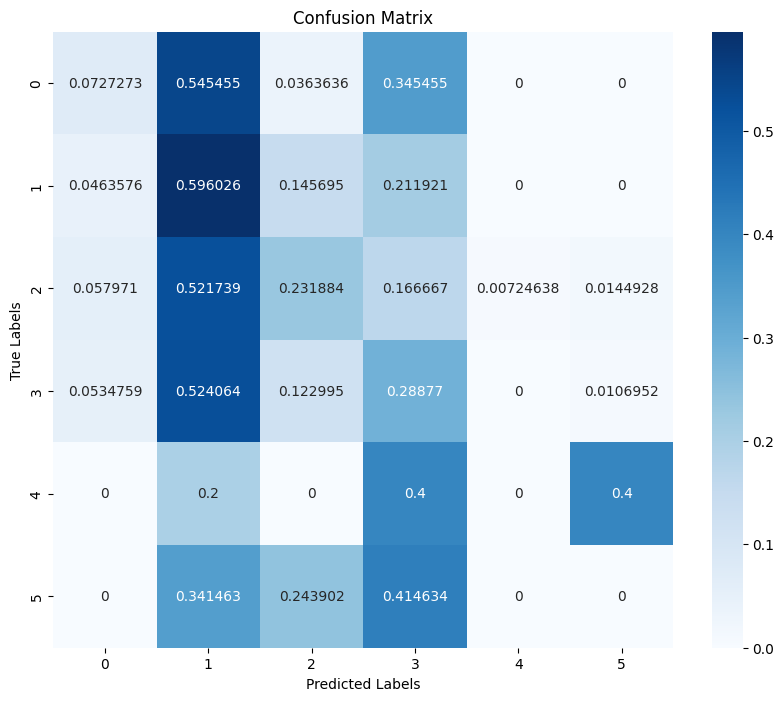

Epoch 2, Validation Loss: 1.9636, Accuracy: 0.3120, F1 Score: 0.2846
Val F1 Score Per Class  [0.0952381  0.39473684 0.28193833 0.32335329 0.         0.        ]


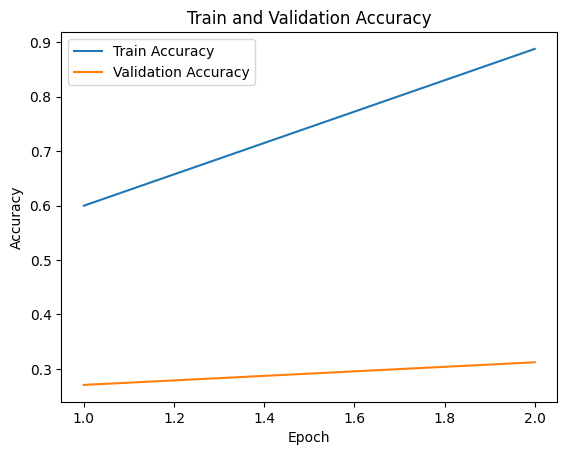

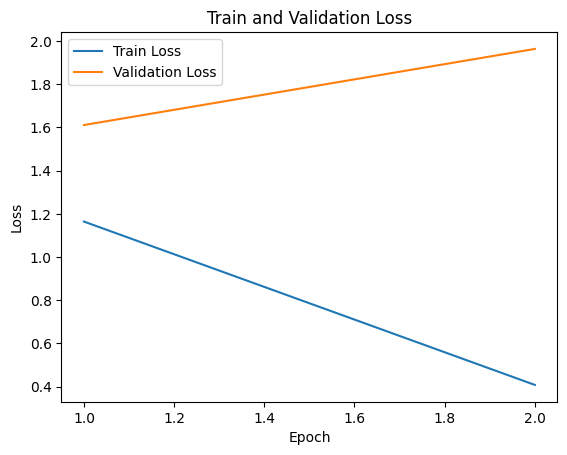

Epoch 3, Train Loss: 0.1238, Accuracy: 0.9724, F1 Score: 0.9724
Train F1 Score Per Class  [0.98618021 0.95694087 0.95096322 0.94439489 1.         0.99424068]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.18it/s, loss=3.44]

[tensor([-1.9764,  3.7801, -0.8005, -0.1704, -1.6915, -1.4406], device='cuda:0'), tensor([-1.4751,  4.1593, -0.8045, -0.8585, -1.6418, -1.6045], device='cuda:0'), tensor([-1.7953,  0.5147, -0.5239,  0.4739, -2.2877, -2.2727], device='cuda:0'), tensor([-1.5489,  0.4124, -1.4168,  2.4515, -2.2787, -1.5432], device='cuda:0'), tensor([-2.0019, -0.7333,  1.1396,  2.0553, -2.5850, -1.6391], device='cuda:0'), tensor([-1.9962,  3.8214, -0.4688, -0.2825, -1.6649, -1.8106], device='cuda:0'), tensor([-2.3631, -0.0800, -1.3032,  1.6994, -2.3267, -1.3790], device='cuda:0'), tensor([-1.8617, -1.0796,  2.2582,  1.1929, -1.7538, -1.5272], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=2.58]

[tensor([-1.3561,  2.6313, -0.4370, -0.8650, -2.5370, -1.6947], device='cuda:0'), tensor([-2.7534,  0.3784, -2.4138,  0.8165, -1.2537, -0.8989], device='cuda:0'), tensor([-0.6948, -1.1121,  0.2792,  2.1020, -2.0345, -2.3146], device='cuda:0'), tensor([-0.3009,  0.0600, -0.6791,  2.4944, -1.9408, -1.9036], device='cuda:0'), tensor([-1.2526,  4.1404, -0.3147, -0.7569, -1.8505, -1.6633], device='cuda:0'), tensor([-1.6462,  3.9523, -0.2120, -0.3875, -1.8773, -1.9078], device='cuda:0'), tensor([ 0.6618, -0.8556,  0.3551,  0.9116, -2.5789, -2.4962], device='cuda:0'), tensor([-0.8931,  3.2179, -1.1449,  0.6515, -2.3250, -1.9960], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=2.39]

[tensor([-2.0552,  0.9678,  1.1261, -0.6969, -2.0870, -2.2265], device='cuda:0'), tensor([-0.8770,  0.6364,  0.9641, -0.6852, -1.4864, -2.3416], device='cuda:0'), tensor([-1.9328, -0.8066,  1.9440,  0.6767, -1.9534, -1.7177], device='cuda:0'), tensor([-1.5674, -0.9527,  1.3304,  0.7084, -2.5286, -2.5797], device='cuda:0'), tensor([-1.0368,  1.2081, -1.2720,  1.7567, -1.4398, -1.9144], device='cuda:0'), tensor([-1.5649,  0.7675, -1.1447,  2.4395, -2.1520, -1.8965], device='cuda:0'), tensor([-1.2928, -1.7631,  0.9448,  1.7867, -2.1361, -2.3348], device='cuda:0'), tensor([-0.1983, -0.9836, -0.3819,  0.0682, -2.1585, -2.4888], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=2.78]

[tensor([-1.9219,  0.1400, -0.3035,  3.4903, -1.8131, -2.1022], device='cuda:0'), tensor([-2.4032,  3.1487,  0.3759, -0.6687, -2.4124, -1.1903], device='cuda:0'), tensor([-1.4736, -0.5735, -1.1039,  2.1187, -2.8111,  0.1084], device='cuda:0'), tensor([-1.3907,  0.1932,  0.2405, -0.1113, -1.8843, -2.5167], device='cuda:0'), tensor([ 1.3476,  0.3491,  0.3085,  0.6481, -2.3265, -3.0753], device='cuda:0'), tensor([-1.6208,  0.3552, -0.8862, -0.3421, -2.7873, -0.5589], device='cuda:0'), tensor([-1.7564,  3.1092, -0.8034, -0.0262, -2.4298, -1.9534], device='cuda:0'), tensor([-2.1647,  0.7437,  1.4672, -1.2803, -0.9617, -0.7649], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=1.94]

[tensor([-2.0831, -1.2650,  1.0649, -0.1068, -2.2681, -2.0365], device='cuda:0'), tensor([-2.6483,  0.9416,  1.9701, -0.2880, -2.3465, -2.2327], device='cuda:0'), tensor([-1.4847, -0.2052,  2.5836, -0.0999, -2.5110, -2.8413], device='cuda:0'), tensor([-1.8851,  3.5717, -0.7249,  0.2594, -1.7339, -1.6997], device='cuda:0'), tensor([-1.5221, -0.6364,  3.7581,  0.0767, -2.0290, -1.7362], device='cuda:0'), tensor([-1.4230,  2.7981, -0.3364, -0.5324, -2.5589, -1.5202], device='cuda:0'), tensor([-2.0946,  0.3352, -0.4308, -0.6476, -2.3146, -1.2275], device='cuda:0'), tensor([-1.0999,  1.2506, -1.1144,  1.6331, -2.3527, -0.3975], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.16it/s, loss=2.73]

[tensor([-1.5365, -0.5506,  4.2183, -0.4832, -1.5918, -1.7196], device='cuda:0'), tensor([-1.4629, -0.0091,  3.8334, -1.0765, -1.6397, -1.5448], device='cuda:0'), tensor([-1.1571, -0.9778,  3.0221,  0.0627, -2.2454, -2.0618], device='cuda:0'), tensor([-2.1101,  3.4360,  0.7213, -0.6327, -1.8052, -1.8581], device='cuda:0'), tensor([-1.4022, -1.1947,  0.6125,  1.7376, -2.2637, -2.7086], device='cuda:0'), tensor([-2.0669, -0.7126, -0.8176,  1.0865, -1.9636, -1.4740], device='cuda:0'), tensor([-0.7547, -1.6099,  0.8994,  2.0657, -2.1414, -1.7813], device='cuda:0'), tensor([-1.5554, -0.3765, -0.0731,  1.4049, -1.5753, -1.5928], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.16it/s, loss=2.44]

[tensor([-0.8772,  0.0516,  0.3871, -0.0739, -1.7676, -1.4924], device='cuda:0'), tensor([-1.7747, -0.1314,  0.1117, -0.4274, -1.5886, -1.5045], device='cuda:0'), tensor([-0.4765, -0.3746,  3.9128, -0.8459, -1.3888, -2.0293], device='cuda:0'), tensor([-2.0332, -0.7424,  1.8595,  0.9524, -2.5203, -1.7690], device='cuda:0'), tensor([-2.2980,  3.3806,  0.3071, -0.3037, -1.8122, -2.1795], device='cuda:0'), tensor([-2.4606,  1.7894, -0.2370,  0.1446, -1.7861, -1.4240], device='cuda:0'), tensor([-1.8670, -1.3771,  0.7137,  1.1559, -2.2791, -0.7681], device='cuda:0'), tensor([-1.7643,  3.1028, -0.8950, -0.8601, -2.0639, -1.6946], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=2.56]

[tensor([-1.6642, -0.0995, -0.1149,  0.4393, -2.1032, -1.1941], device='cuda:0'), tensor([-1.3801, -0.9959,  0.6735,  0.9228, -1.8553, -1.7595], device='cuda:0'), tensor([-1.6128,  0.5617, -1.1455,  2.2519, -2.2067, -1.6904], device='cuda:0'), tensor([-1.5003,  4.0698, -0.5957, -0.2946, -1.6389, -2.1261], device='cuda:0'), tensor([-2.1250,  0.6715,  1.3849, -0.4450, -2.0144, -2.2124], device='cuda:0'), tensor([-1.5125,  0.9198, -0.5601, -0.0229, -2.2557, -2.6673], device='cuda:0'), tensor([-2.0397, -0.9789, -1.2501,  0.0648, -2.6106,  0.1245], device='cuda:0'), tensor([-1.6317, -0.5266,  3.7678, -0.3102, -1.5196, -1.4542], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.16it/s, loss=3.24]

[tensor([-1.5626, -0.8785, -1.5465,  3.2517, -2.1995, -0.1119], device='cuda:0'), tensor([-1.8723,  3.2544,  0.1992, -0.7095, -1.9136, -1.5840], device='cuda:0'), tensor([-1.1006,  3.6850, -0.2929, -0.8461, -1.4097, -1.8246], device='cuda:0'), tensor([-1.0942, -0.5641,  2.4630, -0.4656, -1.8923, -1.3450], device='cuda:0'), tensor([-0.3081, -1.4151,  0.7045,  1.1614, -1.2037, -1.7951], device='cuda:0'), tensor([-2.0828,  2.6331,  0.9488, -0.7256, -2.0830, -2.0078], device='cuda:0'), tensor([-1.4315,  0.8976, -1.4909, -0.0882, -2.1904, -0.7389], device='cuda:0'), tensor([-1.3018, -0.9216, -0.9801,  1.8143, -2.8528, -1.7429], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:28,  2.17it/s, loss=1.99]

[tensor([-1.8142,  3.7186,  0.5983, -0.8703, -1.4949, -1.7572], device='cuda:0'), tensor([-0.8521, -0.8826, -0.0494,  0.8948, -1.3716, -1.3569], device='cuda:0'), tensor([-0.8023,  3.7153, -1.5127, -0.7268, -1.6006, -1.1094], device='cuda:0'), tensor([-2.2396, -0.7269, -0.4427,  1.2211, -1.7697, -0.7802], device='cuda:0'), tensor([-1.6132,  2.4700,  0.7503,  0.1891, -2.0169, -2.2594], device='cuda:0'), tensor([-0.2540, -0.2226, -0.3057,  3.1719, -2.1226, -2.6665], device='cuda:0'), tensor([-2.0250,  3.3628, -1.1645, -0.8527, -1.3551, -1.3910], device='cuda:0'), tensor([-1.4706,  1.7550, -0.9333,  2.9616, -2.2364, -2.6197], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.16it/s, loss=2.63]

[tensor([-2.3166,  1.5733, -0.4080,  0.8016, -2.0823, -1.9297], device='cuda:0'), tensor([-0.3748,  2.2951, -1.9126,  0.1580, -2.1470, -1.0041], device='cuda:0'), tensor([-2.5180, -0.0795,  0.3520,  1.3639, -2.4497, -0.4437], device='cuda:0'), tensor([-1.7899,  1.2072, -0.0054,  1.6169, -2.8229, -2.4389], device='cuda:0'), tensor([-2.0567,  4.0707, -0.3060, -0.7512, -1.9433, -0.8437], device='cuda:0'), tensor([-1.8739,  2.2591, -1.6303,  0.9375, -1.5644, -1.5552], device='cuda:0'), tensor([-2.5503,  1.9107,  1.4459, -0.3811, -1.9043, -2.1021], device='cuda:0'), tensor([-1.6622,  0.9737, -0.3299,  1.5719, -1.8900, -2.7866], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.17it/s, loss=1.28]

[tensor([-2.1173, -0.6549,  2.0390,  0.1992, -2.1137, -2.1960], device='cuda:0'), tensor([-2.1636,  1.8938,  0.4918, -0.1400, -1.9024, -1.8800], device='cuda:0'), tensor([-2.1345, -0.3859,  1.3879,  1.2535, -1.8540, -2.6264], device='cuda:0'), tensor([-1.8142,  3.8597, -1.2363, -0.8695, -1.6424, -1.8083], device='cuda:0'), tensor([-0.9842,  0.9299,  0.2927, -0.6582, -2.0294, -2.8167], device='cuda:0'), tensor([-1.8998, -0.0737,  4.0302,  0.0941, -1.9657, -1.9401], device='cuda:0'), tensor([-1.2850,  2.5917, -1.1046,  0.1653, -1.9430, -1.1984], device='cuda:0'), tensor([-0.9690,  2.7592,  0.7485, -1.3398, -1.7835, -1.7417], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.16it/s, loss=1.58]

[tensor([-1.3679, -0.2596,  0.3736,  2.6633, -2.6142, -2.3106], device='cuda:0'), tensor([-1.8254,  1.6130,  3.1899, -0.9959, -1.4495, -1.9200], device='cuda:0'), tensor([-2.0652,  2.6688,  1.4022, -0.8222, -2.1836, -1.8837], device='cuda:0'), tensor([-1.7318,  3.1487,  1.2740, -1.3258, -1.8950, -1.6229], device='cuda:0'), tensor([-1.9464,  3.9216, -1.0372,  0.1615, -1.5501, -1.0933], device='cuda:0'), tensor([-1.8640, -0.7443,  0.3680,  1.2006, -2.3003, -2.0335], device='cuda:0'), tensor([-1.8719,  1.4756,  1.9783, -0.5346, -2.3571, -1.9371], device='cuda:0'), tensor([-1.9508,  1.4342,  0.2402,  0.4049, -2.1354, -2.3556], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.14it/s, loss=1.52]

[tensor([-2.2906,  1.0206,  1.6957,  0.1342, -1.6754, -2.4538], device='cuda:0'), tensor([-1.8470, -0.0841, -0.3058,  1.0083, -2.6841, -2.1970], device='cuda:0'), tensor([-2.2555, -0.4734, -0.5770, -0.8327, -2.3141,  1.8514], device='cuda:0'), tensor([-2.0321, -0.3641,  1.0823,  1.3991, -2.5109, -2.2196], device='cuda:0'), tensor([-1.6324, -0.3129, -1.2029,  3.8960, -1.3722, -1.1403], device='cuda:0'), tensor([-2.0675,  2.0385,  0.1519,  1.3786, -2.0083, -2.2799], device='cuda:0'), tensor([-1.3849,  2.6255,  1.0117, -1.4506, -2.1449, -1.7493], device='cuda:0'), tensor([-1.0452,  0.7196, -0.7928,  1.0255, -2.5580, -2.0875], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:27,  2.13it/s, loss=2.02]

[tensor([-1.7889,  2.9027, -0.9399,  0.3497, -2.1007, -1.5654], device='cuda:0'), tensor([-2.1957,  2.1711, -1.4120, -0.1389, -1.7539, -1.0761], device='cuda:0'), tensor([-1.7971,  1.2485,  3.0780, -1.0987, -1.7577, -1.7370], device='cuda:0'), tensor([-1.2199, -1.4786,  0.4980,  3.1755, -2.2116, -2.1618], device='cuda:0'), tensor([-1.5292,  1.3099, -1.1370,  2.5495, -2.0346, -2.3514], device='cuda:0'), tensor([-2.0508,  1.8098,  1.1371, -1.2582, -1.8694, -2.2152], device='cuda:0'), tensor([-1.7863, -0.8747, -0.8932,  3.1042, -2.2665, -1.0209], device='cuda:0'), tensor([-2.2693,  3.0544,  0.6919, -0.3240, -1.9159, -2.1196], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.14it/s, loss=1.87]

[tensor([-1.5987, -0.3667, -0.5371,  3.4531, -2.2446, -1.6961], device='cuda:0'), tensor([-2.2865,  3.1171,  0.4080, -0.8115, -2.0026, -1.9755], device='cuda:0'), tensor([-1.4554, -0.2683, -0.8614,  3.3029, -1.7306, -1.8940], device='cuda:0'), tensor([-2.2868,  1.3275,  0.1646, -0.1648, -2.3882, -0.6652], device='cuda:0'), tensor([-1.5397, -0.6096, -0.3218,  1.9133, -2.0984, -2.3395], device='cuda:0'), tensor([-2.1391, -0.5921,  2.7449,  0.5975, -1.6829, -1.7338], device='cuda:0'), tensor([-1.9848, -0.2018,  0.8523,  2.7192, -2.7510, -1.9157], device='cuda:0'), tensor([-2.6695,  0.3464,  1.6566, -0.1908, -1.8377, -1.6591], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.15it/s, loss=2.98]

[tensor([-2.2838,  2.0609, -0.3171,  1.1037, -2.2163, -1.8466], device='cuda:0'), tensor([-0.7611, -0.0771,  0.3275, -0.3288, -1.8672, -1.0899], device='cuda:0'), tensor([-1.5303,  3.6134, -0.2835, -0.9345, -2.0280, -1.5259], device='cuda:0'), tensor([-1.7459,  1.3511,  3.6230, -0.8271, -1.8570, -2.0040], device='cuda:0'), tensor([-2.1558, -0.3670,  2.3552,  0.2790, -1.9475, -1.2910], device='cuda:0'), tensor([-1.7857, -0.3745, -0.9162,  0.6523, -2.3701, -1.9127], device='cuda:0'), tensor([ 3.6252, -1.5637, -0.7310,  0.0322, -1.8740, -0.9772], device='cuda:0'), tensor([-1.6528,  2.2869, -0.6909, -0.7626, -2.2618, -2.1455], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.13it/s, loss=1.94]

[tensor([-1.7069, -0.4164,  0.5351,  3.3265, -2.3934, -2.3307], device='cuda:0'), tensor([ 1.9321, -0.9018, -0.1505,  0.9617, -1.2554, -2.6935], device='cuda:0'), tensor([-2.3359,  1.8041,  2.0896, -0.8469, -1.9188, -1.7904], device='cuda:0'), tensor([-1.2655,  3.2852, -0.3435, -0.5258, -1.8306, -1.8685], device='cuda:0'), tensor([-2.3781, -0.7873,  1.0890,  0.3493, -1.3745, -2.2614], device='cuda:0'), tensor([-0.9601, -0.3841,  1.8975, -0.4995, -1.9203, -1.7129], device='cuda:0'), tensor([-1.1441,  2.0302,  0.4374, -0.0290, -2.7201, -2.2882], device='cuda:0'), tensor([-1.8611,  0.3193, -0.9545,  0.9590, -1.6204, -1.9955], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.13it/s, loss=2.46]

[tensor([-1.2517, -1.0552,  1.1125, -0.1815, -1.7365, -2.4576], device='cuda:0'), tensor([-1.3839,  0.2428, -0.9942,  1.8335, -2.6449, -2.4231], device='cuda:0'), tensor([-1.3776, -0.3879,  3.9489, -0.0971, -1.4446, -1.7355], device='cuda:0'), tensor([-1.2505, -0.5339, -1.0304,  3.8236, -1.3745, -1.5638], device='cuda:0'), tensor([-1.5948,  1.5558,  0.0291,  0.1040, -2.7534, -2.7005], device='cuda:0'), tensor([-1.3433, -0.6838, -1.0763,  2.2788, -2.5244, -2.3969], device='cuda:0'), tensor([-1.5826,  3.1982,  1.0209, -0.6276, -2.0014, -1.6928], device='cuda:0'), tensor([-1.3634,  0.8170,  2.1998, -0.2746, -2.1091, -2.0838], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.14it/s, loss=2.64]

[tensor([-2.2869, -0.7954,  1.9067,  0.5907, -2.2904, -2.1727], device='cuda:0'), tensor([-1.6635,  2.8698, -2.2749, -0.8478, -1.5113, -1.1081], device='cuda:0'), tensor([-2.1888, -0.0638,  1.9370, -0.6050, -2.1309, -0.9283], device='cuda:0'), tensor([-1.2927, -0.1988,  0.5165,  0.0915, -2.8599, -2.0392], device='cuda:0'), tensor([-0.3801, -0.7006, -0.7103, -0.3451, -2.7109, -2.5033], device='cuda:0'), tensor([-1.8160,  0.9260,  0.1918,  0.6220, -2.0485, -1.3262], device='cuda:0'), tensor([-2.1955, -0.2344,  0.1618,  2.0691, -2.3607, -1.9237], device='cuda:0'), tensor([-1.8667,  0.6221,  3.2655, -0.8415, -1.6120, -2.0886], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.14it/s, loss=3.14]

[tensor([-0.8963, -1.0644,  3.2314, -0.6658, -1.6139, -1.5810], device='cuda:0'), tensor([-1.7499,  3.6848, -0.9293, -0.1176, -1.9877, -1.2486], device='cuda:0'), tensor([-1.7233,  0.4402,  3.3963, -0.9115, -2.0589, -1.8683], device='cuda:0'), tensor([-1.9207, -1.3083,  3.0224,  1.2770, -1.8588, -1.9814], device='cuda:0'), tensor([-1.7085, -0.7727, -0.4186,  3.8745, -1.9026, -1.4017], device='cuda:0'), tensor([-2.3362,  0.8238, -0.2568,  0.2155, -2.0354, -1.1373], device='cuda:0'), tensor([-1.4980, -0.8217, -1.1168,  3.8699, -1.5658, -0.9043], device='cuda:0'), tensor([-0.7298, -0.4412, -0.7778,  3.1615, -1.6449, -1.0814], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=2.31]

[tensor([-1.8152, -0.3194, -0.7689,  1.4097, -2.1693, -2.1712], device='cuda:0'), tensor([-1.6629,  1.5758,  0.3195, -0.4360, -1.8761, -1.9315], device='cuda:0'), tensor([-2.0767, -0.4750, -0.9407,  3.2115, -1.6413, -1.5091], device='cuda:0'), tensor([-1.3592, -1.5656, -1.0904,  1.8291, -1.7778, -0.0136], device='cuda:0'), tensor([-1.7310, -0.3894,  1.3272,  1.7700, -2.0489, -2.6786], device='cuda:0'), tensor([-0.6700, -1.0840,  3.1962,  0.6402, -1.6653, -2.5405], device='cuda:0'), tensor([-0.9919,  0.0876, -0.3657,  1.0459, -2.8945, -1.2798], device='cuda:0'), tensor([-2.4138,  0.1828,  0.9455,  0.7274, -1.8989, -1.9847], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.15it/s, loss=1.64]

[tensor([-2.3994,  0.8924, -0.0101,  0.8514, -1.7902, -2.0195], device='cuda:0'), tensor([-1.7919,  0.8240, -0.5751, -0.0896, -2.4714, -1.8467], device='cuda:0'), tensor([-1.2624, -0.0271, -1.4564,  3.8037, -1.1944, -1.6058], device='cuda:0'), tensor([-0.9195,  0.7167, -0.6547, -0.5979, -2.4127, -1.7454], device='cuda:0'), tensor([-1.9086,  2.8644, -0.2931,  0.7795, -2.2165, -2.0098], device='cuda:0'), tensor([-0.6511, -0.9325, -0.9331,  4.0385, -1.4924, -1.4437], device='cuda:0'), tensor([-1.1506, -1.2457,  0.6580,  2.4975, -1.8352, -2.0231], device='cuda:0'), tensor([-2.3782,  0.0559,  2.5808, -0.4737, -1.6740, -1.9819], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.16it/s, loss=2.19]

[tensor([-0.4933, -0.6704, -2.1951,  0.8607, -1.6890, -0.4780], device='cuda:0'), tensor([-1.5110,  0.3282, -0.8783,  1.4137, -2.3755, -2.0561], device='cuda:0'), tensor([-2.0186,  1.4475, -0.3449,  1.9666, -2.1899, -2.6714], device='cuda:0'), tensor([-1.3005,  0.2344,  3.8487, -1.3746, -1.4062, -1.9008], device='cuda:0'), tensor([-2.6191,  0.8403,  2.3904, -0.7877, -1.4079, -1.6778], device='cuda:0'), tensor([-0.7470, -0.7618,  0.3886,  0.1334, -1.8321, -2.7657], device='cuda:0'), tensor([-1.8499,  0.2164, -1.7301,  2.7754, -1.6416, -1.1498], device='cuda:0'), tensor([-0.6727, -0.1116, -1.5249,  3.5608, -2.4083, -1.4025], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.17it/s, loss=2.07]

[tensor([-1.8847,  0.3423,  1.0288,  1.3557, -2.9638, -1.2170], device='cuda:0'), tensor([-1.3489,  1.0205, -0.2411,  1.0045, -2.5316, -1.3521], device='cuda:0'), tensor([-2.0489,  1.1613,  2.7209, -0.3826, -1.9128, -2.0485], device='cuda:0'), tensor([-1.6930, -0.2556,  3.8921, -0.3243, -1.6237, -1.8017], device='cuda:0'), tensor([-1.2682,  0.5338, -0.4037, -0.3900, -2.8266, -2.2492], device='cuda:0'), tensor([-1.4426,  3.5242,  0.0144, -1.3910, -1.5907, -1.0312], device='cuda:0'), tensor([-1.6196, -0.5154, -1.3276,  0.1069, -3.2745, -1.1772], device='cuda:0'), tensor([-1.7062,  0.2123, -1.7982,  0.2647, -2.3801, -0.0119], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=2.35]

[tensor([-1.4199,  3.9382, -0.6768, -0.7519, -1.7486, -0.8787], device='cuda:0'), tensor([-1.8993,  1.6993,  0.5706, -1.1818, -1.7222, -1.3274], device='cuda:0'), tensor([-2.0495,  1.7384,  1.6196,  0.5920, -2.2424, -2.5314], device='cuda:0'), tensor([-2.0736,  2.1991,  0.0244, -0.0858, -1.9051, -2.4306], device='cuda:0'), tensor([-1.3917,  3.5996,  0.0687, -0.6061, -1.8801, -2.2637], device='cuda:0'), tensor([-2.2233, -0.8545,  1.7828,  1.6502, -1.8507, -1.4966], device='cuda:0'), tensor([-0.7442, -1.3081, -0.6896,  0.7329, -2.6013, -2.0973], device='cuda:0'), tensor([ 0.4335, -1.8367,  0.4249,  1.5207, -1.8202, -1.5045], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=2.22]

[tensor([-1.6413, -0.8508, -1.4970,  1.5497, -2.3329, -0.7637], device='cuda:0'), tensor([-1.8278,  2.6275,  1.9784, -0.9964, -1.8166, -2.1374], device='cuda:0'), tensor([-1.1914, -1.1609, -0.7130,  0.9512, -1.9487, -1.7003], device='cuda:0'), tensor([-1.7984, -0.1276, -0.5120,  2.8328, -1.7009, -1.8134], device='cuda:0'), tensor([-1.3212,  0.1629, -1.0136,  3.5184, -1.7676, -2.1181], device='cuda:0'), tensor([-2.2954,  0.3477, -0.3295,  1.2095, -2.0528, -2.4579], device='cuda:0'), tensor([-2.0546, -0.1075, -0.2075,  2.2150, -2.1934, -2.3800], device='cuda:0'), tensor([-1.6980,  3.0125, -1.3316,  0.7863, -1.8818, -1.4790], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.16it/s, loss=2.64]

[tensor([-1.1449, -0.6911,  3.8573, -0.3442, -1.5121, -1.9020], device='cuda:0'), tensor([-2.2512, -0.9597,  0.1467,  2.0722, -2.2700, -1.4209], device='cuda:0'), tensor([-1.6404,  2.7254, -0.7293,  0.0240, -1.7847, -2.3139], device='cuda:0'), tensor([ 0.6682, -1.9936,  0.5427,  0.1042, -2.2268, -0.9846], device='cuda:0'), tensor([-1.7169,  0.2515,  3.2442, -0.8746, -1.3626, -1.7485], device='cuda:0'), tensor([-2.2870,  2.5131, -0.1611, -0.2763, -1.5205, -1.7949], device='cuda:0'), tensor([-1.1539, -0.9226,  2.0178,  0.8907, -2.3008, -1.1775], device='cuda:0'), tensor([-1.4539,  0.4475,  3.1672, -0.7535, -1.5590, -2.0570], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.15it/s, loss=2.6]

[tensor([ 3.6723, -0.6018, -0.6441, -1.3504, -1.7667, -0.7755], device='cuda:0'), tensor([-2.5098,  2.4837, -0.1032, -0.4714, -1.9668, -2.0589], device='cuda:0'), tensor([-1.3440,  2.1686, -1.4445,  0.7513, -1.1151, -2.3361], device='cuda:0'), tensor([-0.6256, -0.0308,  1.6379, -0.0686, -1.6176, -1.4414], device='cuda:0'), tensor([-1.0461,  3.7254, -0.2639, -0.4928, -1.7014, -2.1077], device='cuda:0'), tensor([-1.5084, -2.0158,  1.7897,  1.7762, -2.0787, -0.9869], device='cuda:0'), tensor([-1.5017, -0.6686,  2.5666,  0.1510, -2.0834, -1.6218], device='cuda:0'), tensor([-2.2894,  3.4392, -0.6208, -0.5669, -1.9300, -1.3481], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:20,  2.14it/s, loss=2.63]

[tensor([-2.1376,  2.5715, -0.6525,  0.0781, -1.9945, -2.0198], device='cuda:0'), tensor([-1.6532, -1.3174,  2.3834,  2.4588, -1.9565, -2.1286], device='cuda:0'), tensor([-2.2905,  2.0492,  0.1091,  1.0691, -3.1693, -1.8503], device='cuda:0'), tensor([-2.1864,  1.2541, -0.2808,  0.9721, -1.9520, -1.3051], device='cuda:0'), tensor([-0.9912, -0.6914, -1.2247,  3.9030, -1.6052, -1.8108], device='cuda:0'), tensor([-1.5207, -0.1890,  2.2840, -0.5377, -1.8791, -2.3325], device='cuda:0'), tensor([-0.7577, -0.6637,  1.5247,  0.8523, -1.6992, -1.8702], device='cuda:0'), tensor([-1.1271,  0.2153, -1.4530,  2.3120, -2.2644, -1.5145], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=1.74]

[tensor([-1.6308, -1.3426,  1.0677,  2.4923, -2.1454, -1.4110], device='cuda:0'), tensor([-1.0321, -1.4017, -0.3051,  0.7530, -2.3689, -1.5736], device='cuda:0'), tensor([-1.7773, -1.1390,  1.0664,  0.3808, -1.8427, -1.5873], device='cuda:0'), tensor([-0.6036, -0.7511,  3.6266, -0.2216, -2.0351, -2.1133], device='cuda:0'), tensor([-1.4003,  1.2523,  0.3105, -0.5748, -1.9894, -2.6685], device='cuda:0'), tensor([-1.1658, -0.9045, -2.3160,  0.1952, -1.2814,  2.8373], device='cuda:0'), tensor([-1.3102,  3.7072, -1.2946, -0.1017, -1.6307, -1.3764], device='cuda:0'), tensor([-1.6307, -0.2737, -0.9417,  3.4717, -1.4907, -1.8113], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.15it/s, loss=2.28]

[tensor([-1.7156,  2.2790,  1.7903, -1.3229, -1.7327, -1.1652], device='cuda:0'), tensor([-1.3442,  0.9661,  1.9455, -0.0441, -2.1316, -2.6276], device='cuda:0'), tensor([-1.9277,  2.2493,  0.1543, -0.8022, -2.0689, -2.1966], device='cuda:0'), tensor([-2.2013,  0.9332,  0.3705, -0.1825, -1.6106, -2.0494], device='cuda:0'), tensor([-2.5728, -0.1859,  1.4658,  0.9061, -1.9759, -1.1880], device='cuda:0'), tensor([-1.5411,  4.0864, -0.2057, -1.2268, -1.4980, -1.1539], device='cuda:0'), tensor([-1.5315, -1.0162, -1.4590, -0.5516, -1.7195,  4.3769], device='cuda:0'), tensor([-1.1048,  0.1602, -1.2804,  0.7845, -1.2366, -1.9324], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.15it/s, loss=2.5]

[tensor([-1.7425,  3.7454,  0.0678, -0.6515, -1.9786, -1.7445], device='cuda:0'), tensor([-1.4870,  3.3787, -1.4307, -0.4993, -0.8206, -1.6001], device='cuda:0'), tensor([-1.8957,  1.5219, -0.2282, -0.0413, -2.3900, -2.4943], device='cuda:0'), tensor([-1.9150,  1.1356, -2.0811,  1.7171, -1.4645, -0.2694], device='cuda:0'), tensor([-1.5040,  1.2201, -0.7628,  1.4562, -1.8568, -2.3505], device='cuda:0'), tensor([-1.9483, -0.0572, -0.7959,  1.6566, -2.1591, -1.9462], device='cuda:0'), tensor([-1.9761,  0.0098,  0.2132, -0.1573, -2.2119, -2.0915], device='cuda:0'), tensor([-0.5291, -0.1154,  0.2064, -1.1375, -2.0578, -2.3768], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.14it/s, loss=2.39]

[tensor([-1.7204, -0.0158,  2.9563,  0.1968, -2.5301, -2.0268], device='cuda:0'), tensor([-2.0972,  0.2068,  0.5899,  0.3517, -1.9196, -2.1622], device='cuda:0'), tensor([-1.7716,  1.4748,  3.1902, -1.0052, -1.8346, -2.2121], device='cuda:0'), tensor([ 0.5326, -1.7857,  0.7911, -0.3743, -2.5025, -1.5338], device='cuda:0'), tensor([-2.0258, -0.3133, -0.3242,  3.2985, -2.0307, -1.4798], device='cuda:0'), tensor([-2.3836,  2.0341,  2.6502, -0.6921, -1.9429, -1.8942], device='cuda:0'), tensor([ 1.8768, -1.4929, -0.6096,  0.7993, -2.0350, -1.7337], device='cuda:0'), tensor([-1.5163,  4.0050,  0.1308, -0.7764, -1.8635, -1.8018], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.14it/s, loss=1.93]

[tensor([-1.2288,  0.1318, -1.1442,  1.5141, -1.5732, -2.2173], device='cuda:0'), tensor([-1.7917,  0.8447,  3.2727, -1.2720, -1.7140, -1.0829], device='cuda:0'), tensor([-1.0248,  1.2533, -1.1730,  1.1430, -2.4620, -2.1398], device='cuda:0'), tensor([ 0.1704, -1.6639,  0.5417, -0.6147, -2.0715, -1.7221], device='cuda:0'), tensor([-1.0329, -0.5402,  1.0341,  0.2650, -1.7620, -1.1692], device='cuda:0'), tensor([-1.1012, -1.0830, -1.4691,  2.7969, -1.9988,  0.0303], device='cuda:0'), tensor([-2.0424, -0.5800,  1.2232,  0.1842, -2.0922, -2.7434], device='cuda:0'), tensor([-2.1405,  3.5856, -0.8444, -0.7468, -1.5812, -0.9466], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.14it/s, loss=2.72]

[tensor([-2.1945, -0.3395, -0.9293,  0.8751, -1.9149, -1.5409], device='cuda:0'), tensor([ 4.3209, -1.4649, -0.3366, -0.1612, -1.7490, -1.4267], device='cuda:0'), tensor([-2.2629,  1.4398, -1.3415,  2.3577, -1.2582, -1.7959], device='cuda:0'), tensor([-1.8163,  2.4713,  1.1117, -0.1038, -2.0404, -2.1040], device='cuda:0'), tensor([-0.8309, -1.3373,  2.6184,  1.0705, -2.1765, -2.6843], device='cuda:0'), tensor([-2.0101,  3.5636,  0.1489, -0.6553, -1.3045, -2.2013], device='cuda:0'), tensor([-1.9581,  3.8959, -0.0985, -0.8314, -2.0785, -1.1382], device='cuda:0'), tensor([-1.6288,  4.1216, -0.2580, -1.0291, -1.2899, -1.6653], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.13it/s, loss=3.08]

[tensor([-1.2924, -0.4475, -0.9550,  3.0360, -2.0036, -1.6837], device='cuda:0'), tensor([-1.8381,  3.1760, -1.8670,  0.3687, -1.6872, -1.6035], device='cuda:0'), tensor([-0.6530, -0.7222, -0.9327,  1.3242, -2.4306, -1.5740], device='cuda:0'), tensor([-1.6404,  0.3885,  3.6858, -0.8979, -1.6673, -2.0900], device='cuda:0'), tensor([-1.5527,  1.2716, -1.4404,  1.6784, -2.0353, -2.4961], device='cuda:0'), tensor([-1.8372,  2.1779, -0.3313,  0.1648, -1.9003, -2.2331], device='cuda:0'), tensor([-1.4199,  3.8718, -0.9785, -0.7544, -1.7225, -1.6852], device='cuda:0'), tensor([-1.6012, -0.0496, -0.9314,  3.5021, -1.9924, -2.1199], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=2.64]

[tensor([-2.1543, -0.0261, -2.2962,  1.7095, -1.1449,  0.0343], device='cuda:0'), tensor([-1.7209, -0.5902,  2.2226,  1.0275, -1.3892, -1.7509], device='cuda:0'), tensor([-1.3467, -0.8427,  1.5684,  1.5285, -1.8339, -2.3306], device='cuda:0'), tensor([-1.0114, -0.6323,  4.2069, -0.7383, -1.3912, -1.5746], device='cuda:0'), tensor([-1.7952, -0.7335, -0.2922,  0.6828, -1.9001, -1.4794], device='cuda:0'), tensor([-0.6581, -0.3954, -0.2286,  2.2297, -2.0037, -1.9608], device='cuda:0'), tensor([-1.5067,  3.4008, -1.4472, -0.5169, -1.5995, -1.4280], device='cuda:0'), tensor([-1.4994,  3.3094,  0.4204, -0.4129, -1.7430, -2.2273], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=1.96]

[tensor([-1.8977,  1.8203,  2.3086, -0.1162, -2.2165, -2.6246], device='cuda:0'), tensor([-1.4913, -0.6701, -1.9865,  2.2609, -1.1761,  0.8183], device='cuda:0'), tensor([ 0.3439,  0.7428, -1.4959,  1.8360, -1.9863, -2.1288], device='cuda:0'), tensor([-1.8724,  2.9271, -0.2488,  0.7021, -2.2952, -2.3115], device='cuda:0'), tensor([-1.5034,  0.4856, -0.9551,  1.0501, -2.2252, -2.8368], device='cuda:0'), tensor([-0.8985, -1.6353,  3.6523,  0.3786, -1.7006, -1.5901], device='cuda:0'), tensor([-2.1143,  2.9029, -1.1734,  0.2935, -1.1651, -2.3291], device='cuda:0'), tensor([-1.8874, -0.8112, -0.3245,  3.8692, -1.6436, -1.1946], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=2.29]

[tensor([-2.0508,  3.5134,  0.3287, -0.3231, -1.4759, -2.0840], device='cuda:0'), tensor([-1.5844, -0.0817,  0.1410,  1.3579, -2.2607, -2.1947], device='cuda:0'), tensor([-2.1121,  2.3599,  0.7068, -0.6425, -2.2191, -1.8141], device='cuda:0'), tensor([-1.5025, -0.3093,  3.8349, -1.0225, -1.3677, -1.7863], device='cuda:0'), tensor([-1.1947,  3.8950, -1.3251,  0.1533, -1.1867, -1.7668], device='cuda:0'), tensor([-1.7550, -2.1356,  0.0499,  2.2803, -2.4024, -0.5135], device='cuda:0'), tensor([-1.4961, -0.9136, -0.1670,  3.6586, -2.4543, -1.5566], device='cuda:0'), tensor([-1.4388, -1.0007,  0.6441,  1.4762, -1.0771, -2.0473], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.15it/s, loss=2.15]

[tensor([-1.3229,  0.4864, -1.1390,  3.1919, -1.7529, -2.1702], device='cuda:0'), tensor([-1.3508,  0.0440, -1.5711,  3.4242, -2.4062, -1.4583], device='cuda:0'), tensor([-1.9698,  1.2240, -0.5795,  0.8143, -2.3607, -2.0253], device='cuda:0'), tensor([ 0.9170, -0.1474, -1.9872,  1.9845, -2.0122, -1.1854], device='cuda:0'), tensor([-2.0156,  3.2365, -0.2867,  0.6069, -1.9299, -2.4105], device='cuda:0'), tensor([-2.0312, -0.9878,  2.6165,  0.3988, -1.7749, -1.8214], device='cuda:0'), tensor([-1.4508, -0.3811, -0.8194,  1.4626, -2.0352, -1.6786], device='cuda:0'), tensor([-0.8316, -0.7058,  3.4998, -0.3233, -2.0258, -1.7587], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.15it/s, loss=2.02]

[tensor([-2.1618,  0.9629,  0.3455, -0.5576, -2.3404, -0.4427], device='cuda:0'), tensor([-1.9600,  0.6120, -0.8501, -0.1536, -2.1918, -1.6813], device='cuda:0'), tensor([ 3.0744, -1.2909, -0.9343, -0.5188, -2.2518, -0.1669], device='cuda:0'), tensor([-2.2066,  3.8663, -0.2431, -0.3039, -1.7090, -1.5905], device='cuda:0'), tensor([-1.0123, -0.0298, -1.3087,  3.8196, -1.8614, -1.5860], device='cuda:0'), tensor([-1.7932,  1.5469, -0.0643,  1.3776, -2.0831, -2.6031], device='cuda:0'), tensor([-1.0088,  1.5793, -0.1215, -0.1114, -2.2509, -2.3359], device='cuda:0'), tensor([-1.2087, -0.1551,  0.6783, -0.8332, -2.4112, -1.0621], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.15it/s, loss=2.01]

[tensor([-1.9947,  3.3550, -1.2223,  0.5647, -1.9000, -1.2366], device='cuda:0'), tensor([-2.4378, -0.2441, -1.1123, -0.5641, -1.5822, -1.0415], device='cuda:0'), tensor([-1.7029, -0.3061, -0.8611,  2.3695, -2.7902, -0.5059], device='cuda:0'), tensor([-1.5078, -0.4850, -0.6498,  3.6032, -2.7520, -1.5598], device='cuda:0'), tensor([-2.2631,  0.6515,  1.7838,  0.3841, -2.3084, -2.1614], device='cuda:0'), tensor([-1.8011,  0.0063, -1.4200,  0.6770, -2.5547, -2.6180], device='cuda:0'), tensor([-0.5439, -1.6486, -0.3595,  3.0237, -1.9008, -2.4242], device='cuda:0'), tensor([-0.2988, -0.7605, -0.3804,  1.8197, -1.8283, -2.3698], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.16it/s, loss=2.26]

[tensor([-1.6160,  1.2014,  0.2959,  1.4292, -1.8724, -3.0790], device='cuda:0'), tensor([-0.5122, -0.7126, -0.0919,  0.5675, -2.0578, -2.1178], device='cuda:0'), tensor([-2.5395,  1.6154, -1.1434,  0.6207, -2.1914, -1.6080], device='cuda:0'), tensor([-2.7347,  1.0600, -0.9881,  0.5529, -2.2641, -1.1776], device='cuda:0'), tensor([-1.4654, -1.3715, -0.9734,  1.2971, -0.5609,  0.4168], device='cuda:0'), tensor([-2.5149,  1.3640,  0.0953,  0.9134, -2.2492, -2.0316], device='cuda:0'), tensor([-0.7927, -1.3883,  3.3398, -0.5226, -1.6539, -1.5398], device='cuda:0'), tensor([-0.7494,  3.1272, -0.0251, -1.0855, -1.8375, -1.0656], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.16it/s, loss=2.13]

[tensor([-1.7191,  0.5340,  0.2770, -0.2485, -2.9560, -2.2831], device='cuda:0'), tensor([-1.6402, -0.0496, -2.1142,  1.6559, -1.0998, -1.3105], device='cuda:0'), tensor([-1.8417,  1.2540, -1.5763,  2.1256, -1.6548, -1.1211], device='cuda:0'), tensor([-1.7913,  2.3926,  0.7340, -0.7708, -1.7930, -2.3184], device='cuda:0'), tensor([-1.7030, -0.9608,  3.0918,  0.7363, -1.8548, -1.6419], device='cuda:0'), tensor([-1.7539, -0.8627, -1.5222, -0.2979, -2.1484,  3.5475], device='cuda:0'), tensor([-1.8618,  3.3500,  0.3076, -0.9001, -1.6878, -1.8682], device='cuda:0'), tensor([-2.1346, -0.3484, -1.2392,  0.8743, -2.1435,  0.0562], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=2.19]

[tensor([-1.4097, -0.0097,  3.6863, -0.7930, -1.7829, -1.8417], device='cuda:0'), tensor([-1.3535,  2.0630, -1.5567,  0.6225, -1.5867, -1.1398], device='cuda:0'), tensor([-1.7621,  0.0710, -0.3741,  1.6795, -1.5627, -2.5970], device='cuda:0'), tensor([-0.7385, -1.2990,  3.5197, -1.4744, -1.4806, -1.3757], device='cuda:0'), tensor([-2.6941,  0.6513, -1.4767,  1.8271, -1.9453, -0.9208], device='cuda:0'), tensor([-1.5423,  2.2738, -0.3414, -0.3901, -1.9397, -2.1752], device='cuda:0'), tensor([-1.2502, -0.6287,  0.2813,  2.5745, -2.2836, -2.0440], device='cuda:0'), tensor([-1.0395, -0.7150,  3.9132, -0.3042, -1.3365, -1.8766], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.15it/s, loss=2.63]

[tensor([ 3.7603, -0.8969, -1.2980, -0.3739, -1.3910, -1.0749], device='cuda:0'), tensor([-1.2605,  2.7191,  0.1477,  0.0487, -2.4859, -2.1756], device='cuda:0'), tensor([-2.1705,  0.7373,  1.1326, -0.4654, -1.9858, -1.9165], device='cuda:0'), tensor([-1.8991,  0.5262,  3.7613, -0.2899, -1.8373, -1.9943], device='cuda:0'), tensor([-2.0977,  2.1539,  2.4105,  0.1747, -2.1307, -2.4921], device='cuda:0'), tensor([-1.2877,  0.2257, -1.4189,  1.9202, -1.6549, -1.8541], device='cuda:0'), tensor([-1.5798,  0.4065, -0.1647,  0.5172, -1.3956, -2.1861], device='cuda:0'), tensor([-1.6705,  0.8092, -0.1543,  0.2800, -2.2585, -2.1237], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=2.78]

[tensor([-0.9471, -0.3445,  4.1528, -1.0846, -1.7147, -1.3949], device='cuda:0'), tensor([-1.6039,  1.4888, -1.2288,  0.9323, -2.1150, -1.8105], device='cuda:0'), tensor([-2.1875,  3.8947, -0.4559, -0.5126, -1.8796, -1.3705], device='cuda:0'), tensor([-1.9321,  3.8106, -0.2768, -0.4709, -2.1573, -1.5811], device='cuda:0'), tensor([-0.7957, -0.3707, -0.9811,  3.8215, -2.0141, -1.9554], device='cuda:0'), tensor([ 3.5730, -0.6394, -0.6662, -0.5212, -1.6562, -1.7427], device='cuda:0'), tensor([-1.5174,  0.5541,  2.1356, -0.8445, -1.9493, -2.0832], device='cuda:0'), tensor([-1.7454, -0.2290, -0.3129,  0.4646, -2.2900, -1.8895], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.15it/s, loss=2.6]

[tensor([-1.9238,  0.3374, -0.0217,  2.7277, -1.8415, -2.6166], device='cuda:0'), tensor([-1.0833,  1.4018, -0.9587, -0.2478, -1.9465, -2.3845], device='cuda:0'), tensor([-2.2468,  0.5809,  2.8404, -0.4147, -1.4343, -1.7240], device='cuda:0'), tensor([-1.0096, -0.6882,  4.0655, -0.6984, -1.8386, -1.4798], device='cuda:0'), tensor([-1.6074,  3.2297,  1.6075, -1.2870, -1.4472, -1.5052], device='cuda:0'), tensor([-1.1228, -0.9381,  2.8635,  0.6193, -1.5598, -2.8873], device='cuda:0'), tensor([-2.2165,  1.0002,  0.8738, -0.2656, -2.4364, -1.7748], device='cuda:0'), tensor([-1.5017, -0.5694, -0.4998,  3.9065, -1.9365, -1.9837], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.14it/s, loss=2.49]

[tensor([-1.5520,  0.1963,  1.4926, -0.0475, -2.2624, -1.7847], device='cuda:0'), tensor([-1.4922, -0.4371,  0.8038,  0.9966, -2.3256, -2.5363], device='cuda:0'), tensor([-1.9299,  1.4143,  1.2871, -0.0307, -1.3662, -1.0642], device='cuda:0'), tensor([-1.9385,  3.4653,  0.6083, -0.5381, -2.5270, -1.9899], device='cuda:0'), tensor([-1.9999,  0.9145,  2.1620, -0.7756, -1.9326, -1.7484], device='cuda:0'), tensor([-1.6173, -0.9251, -1.5017,  3.6299, -1.4381, -0.1993], device='cuda:0'), tensor([-1.0441,  0.8878, -0.9186,  0.8111, -2.0106, -1.6447], device='cuda:0'), tensor([-1.6243,  2.0222, -0.6917,  0.0203, -2.1140, -2.0705], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.12it/s, loss=1.58]

[tensor([-1.5454, -0.4182,  2.5171,  0.6297, -2.2251, -1.8582], device='cuda:0'), tensor([-1.2589, -1.1804, -1.2668,  3.7848, -1.8763, -0.6113], device='cuda:0'), tensor([-1.9413, -0.0294,  1.3383,  0.5386, -2.1626, -0.6842], device='cuda:0'), tensor([-1.7729,  1.3927, -0.6799,  2.7498, -1.9789, -2.1307], device='cuda:0'), tensor([-1.7639,  3.2597,  0.4806, -1.2155, -1.7301, -1.9451], device='cuda:0'), tensor([-0.7577,  1.0014, -2.2965,  2.1583, -2.3129, -0.6810], device='cuda:0'), tensor([-0.8365, -0.5605, -0.7433,  3.8140, -1.6245, -1.8836], device='cuda:0'), tensor([-0.3013, -0.1438, -1.3273, -2.1068, -1.7430,  3.3692], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.12it/s, loss=1.73]

[tensor([-2.1672,  0.7570,  0.9848,  0.4713, -2.4400, -1.6691], device='cuda:0'), tensor([-0.3410, -1.2090,  0.3464,  2.2994, -1.7587, -3.0771], device='cuda:0'), tensor([-1.7647,  0.3919, -0.8532,  1.3723, -0.8516, -2.4129], device='cuda:0'), tensor([-1.9326,  0.8792, -1.4181,  0.3888, -1.9760, -0.2938], device='cuda:0'), tensor([-2.1850,  1.6659,  1.1065, -1.0270, -2.0848, -0.9731], device='cuda:0'), tensor([-1.8064,  3.8320, -1.2731, -0.6057, -1.3952, -1.1051], device='cuda:0'), tensor([ 0.6507, -1.5672,  2.1577, -0.1584, -2.1153, -1.3310], device='cuda:0'), tensor([-1.5979,  2.0338, -0.3936,  0.9124, -2.2505, -1.5268], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.11it/s, loss=1.99]

[tensor([-1.4152,  0.7557, -1.2338,  2.7129, -1.6105, -1.8228], device='cuda:0'), tensor([-1.1476,  0.9563,  0.6356, -0.4683, -2.4212, -1.9705], device='cuda:0'), tensor([-2.3300, -0.5254,  1.7458,  1.4716, -2.9217, -1.3783], device='cuda:0'), tensor([-1.3308,  1.8570, -0.5895,  0.6765, -2.4153, -2.1315], device='cuda:0'), tensor([ 4.2489, -1.0326, -0.0994, -0.8613, -1.6537, -1.2655], device='cuda:0'), tensor([-0.7237, -0.4059, -0.6557,  1.1062, -2.6578, -2.4807], device='cuda:0'), tensor([-0.3462, -0.5714,  0.9434,  2.3845, -2.6644, -2.4589], device='cuda:0'), tensor([-1.7731, -0.1519,  3.3759, -0.5675, -1.4048, -2.7157], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.11it/s, loss=1.94]

[tensor([-1.7810, -0.8135,  0.5558,  0.3209, -2.5507, -2.0121], device='cuda:0'), tensor([-2.1108, -0.4472,  0.9190,  1.3331, -2.4842, -2.3429], device='cuda:0'), tensor([-1.8358,  0.8941,  1.9965,  0.0361, -2.4382, -1.8387], device='cuda:0'), tensor([-0.7447, -0.9503, -1.0998,  3.8859, -1.9032, -1.1187], device='cuda:0'), tensor([-1.8814, -0.5960,  0.3899,  3.4419, -2.2450, -1.9551], device='cuda:0'), tensor([-2.1663,  0.3092, -1.5647,  0.8552, -2.4529, -0.7754], device='cuda:0'), tensor([-1.3199,  1.7513,  0.1374, -0.3106, -2.0241, -2.4222], device='cuda:0'), tensor([-2.3104,  1.6157, -1.1638,  0.4397, -2.4565,  0.5606], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.13it/s, loss=2.77]

[tensor([-1.3227, -1.2551,  3.8507,  0.1313, -1.2135, -1.4229], device='cuda:0'), tensor([-1.4676,  3.1907, -0.1229,  0.1016, -1.9208, -2.9347], device='cuda:0'), tensor([-1.5280,  2.0105,  1.0998, -0.2547, -1.6764, -2.9589], device='cuda:0'), tensor([-1.9730,  1.1940,  0.9022, -0.7861, -2.4293, -2.0241], device='cuda:0'), tensor([-2.0156,  3.5040, -0.0551, -0.7419, -1.6897, -1.4233], device='cuda:0'), tensor([-1.0770, -0.2318,  2.9402, -0.1890, -1.6998, -2.0087], device='cuda:0'), tensor([-1.5308, -1.2033, -0.0467,  3.3449, -2.0690, -1.1297], device='cuda:0'), tensor([-1.5535,  3.8008,  0.2069, -0.8173, -1.8664, -1.8599], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=1.28]

[tensor([-1.3998,  3.2295,  1.2320, -1.4971, -1.4624, -1.4369], device='cuda:0'), tensor([-1.4285,  3.6794, -1.3748,  0.1153, -1.1589, -1.6864], device='cuda:0'), tensor([-2.1081, -1.0496,  0.0268,  0.9466, -2.3971, -1.8419], device='cuda:0'), tensor([-1.9661,  3.1747, -0.7714, -0.5398, -1.6203, -2.0160], device='cuda:0'), tensor([-2.1388,  2.9755,  0.2864, -0.1664, -1.9082, -2.0738], device='cuda:0'), tensor([-1.3697, -1.3322, -1.0643,  1.4598, -2.4731,  0.7792], device='cuda:0'), tensor([-1.5518,  2.0979, -1.3189, -0.3315, -1.6123, -1.8623], device='cuda:0'), tensor([-0.3859, -0.2236, -1.6478,  1.7931, -2.4314, -0.9074], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=2.03]

[tensor([-2.0122e+00,  3.7208e+00,  5.8462e-04, -8.0098e-01, -1.6582e+00,
        -1.3599e+00], device='cuda:0'), tensor([-1.4524,  2.2311,  0.2921, -0.9589, -2.0608, -2.0883], device='cuda:0'), tensor([-0.2664,  0.3898,  0.8505,  0.3665, -2.2140, -2.2545], device='cuda:0'), tensor([-1.5681, -0.8067,  2.9776,  0.1108, -1.9322, -2.0945], device='cuda:0'), tensor([-1.5652, -1.3434,  1.2253,  1.9158, -1.9805, -1.6697], device='cuda:0'), tensor([-1.9563,  0.3912,  1.4785, -0.4838, -2.1404, -2.2484], device='cuda:0'), tensor([-1.0620,  3.8421, -1.3172, -0.9706, -1.0572, -1.2975], device='cuda:0'), tensor([-1.3253, -0.1804, -0.2113,  3.0882, -2.2049, -2.1495], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.16it/s, loss=2.59]

[tensor([-1.9336, -0.4875, -1.1468,  3.7462, -1.5175, -2.1055], device='cuda:0'), tensor([-1.4738,  1.6974,  1.1985, -1.1153, -1.7554, -2.0368], device='cuda:0'), tensor([-2.2493,  2.4387, -0.0352, -0.6211, -1.9278, -1.1895], device='cuda:0'), tensor([-1.3138, -0.3339, -1.6622,  2.5046, -0.8071, -1.9666], device='cuda:0'), tensor([-2.4748,  2.0627,  0.0813,  0.6981, -2.1283, -2.5051], device='cuda:0'), tensor([-1.9729, -0.3787,  1.9375,  0.0998, -1.6085, -2.3056], device='cuda:0'), tensor([-2.1356,  2.6277,  0.8974, -0.1121, -2.0073, -1.7542], device='cuda:0'), tensor([-1.4266, -0.8744,  2.9808,  0.5605, -1.7474, -2.2030], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.16it/s, loss=1.75]

[tensor([-0.8275, -0.6981, -1.2423,  3.8340, -1.3956, -1.8382], device='cuda:0'), tensor([-2.2585,  1.7365,  0.1655, -0.6654, -2.3854, -1.7078], device='cuda:0'), tensor([-0.9790,  1.2102, -1.9065,  2.9948, -1.9992, -1.1976], device='cuda:0'), tensor([-1.5420,  0.1370,  0.7990,  2.2122, -2.9804, -2.1889], device='cuda:0'), tensor([-1.6202,  1.5031,  0.3759, -0.3562, -2.9427, -1.8653], device='cuda:0'), tensor([-1.1552,  2.3087, -1.0036, -0.2389, -1.5120, -2.7566], device='cuda:0'), tensor([-2.5840,  0.6517,  0.1011,  0.0697, -2.1810, -1.9256], device='cuda:0'), tensor([-2.0326, -0.7977,  0.5340,  1.9625, -1.6624, -2.3821], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.16it/s, loss=2.53]

[tensor([-0.9650, -0.7243, -0.5702,  3.6812, -1.4059, -1.3403], device='cuda:0'), tensor([-2.0940,  1.4164,  2.5024,  0.9035, -2.1769, -2.7894], device='cuda:0'), tensor([-1.1791, -1.2187, -1.1975,  3.1610, -1.9215, -1.9278], device='cuda:0'), tensor([-1.9980, -0.7366,  1.5257,  0.7004, -1.2997, -1.4965], device='cuda:0'), tensor([-1.8981,  1.8998,  0.2250, -0.3650, -1.7385, -2.6327], device='cuda:0'), tensor([-1.7693, -0.2103,  0.0600,  3.2284, -2.3704, -2.2674], device='cuda:0'), tensor([-2.1320,  1.0346, -1.1676,  0.5685, -2.5551, -1.0845], device='cuda:0'), tensor([-1.5301, -0.1017, -0.8997, -0.1059, -1.9709, -2.2420], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.16it/s, loss=3.02]

[tensor([-1.1472, -1.4980, -0.6228,  3.5492, -1.2385, -1.6651], device='cuda:0'), tensor([-1.6519,  2.6052, -1.1632, -0.1633, -1.6254, -2.0470], device='cuda:0'), tensor([-1.4276,  1.9611, -1.4874,  1.0469, -2.1551, -1.8957], device='cuda:0'), tensor([-1.4575, -0.8933,  2.1855,  0.5992, -2.2142, -1.9379], device='cuda:0'), tensor([-2.3785,  0.4164,  0.7785,  0.3301, -1.6972, -1.5766], device='cuda:0'), tensor([-0.8739, -0.0935, -1.6955,  1.2861, -1.4121,  0.6992], device='cuda:0'), tensor([-1.1958, -0.2165, -0.4352,  0.3652, -2.1317, -1.8009], device='cuda:0'), tensor([ 4.2307, -1.5751, -1.0167, -0.6626, -1.4425, -0.3838], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.18it/s, loss=2.24]

[tensor([-1.6928,  3.3349,  0.3134, -0.7485, -1.5764, -1.7118], device='cuda:0'), tensor([-1.5535,  0.8273,  2.4658, -1.1075, -1.3177, -2.0191], device='cuda:0'), tensor([ 0.1434, -0.8876,  1.5633,  1.0045, -2.6605, -2.7832], device='cuda:0'), tensor([-1.2600, -0.3089, -0.5827,  2.2110,  0.2210, -1.9739], device='cuda:0'), tensor([-1.5132, -0.4895, -0.4109,  2.5229, -2.9428, -1.5114], device='cuda:0'), tensor([-1.8364,  0.0366,  1.9469, -0.0543, -2.2583, -1.7125], device='cuda:0'), tensor([-1.9197,  1.3994,  0.0337,  1.8462, -2.5672, -2.2097], device='cuda:0'), tensor([-1.6214,  2.8695, -1.2037,  0.5617, -2.0772, -1.7809], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.16it/s, loss=0.807]

[tensor([-0.9621, -0.0223,  1.7575, -0.5336, -2.1992, -2.2992], device='cuda:0'), tensor([-1.8008,  0.8721,  1.5905, -1.0402, -1.7236, -2.0594], device='cuda:0'), tensor([-2.1302, -0.4247, -1.8538,  0.3290, -2.6607, -1.4413], device='cuda:0'), tensor([-1.9432,  1.8408,  1.0799, -0.3397, -2.5102, -1.6074], device='cuda:0'), tensor([-2.0997,  1.0888, -0.8947, -0.3601, -1.8853, -1.7883], device='cuda:0'), tensor([-0.2110, -1.2277, -1.3396,  3.2921, -2.0510, -1.4263], device='cuda:0'), tensor([-1.9411, -0.1140,  3.7739, -0.5178, -1.4715, -1.7874], device='cuda:0'), tensor([-1.5169,  1.1749, -1.3095,  0.2331, -1.8871, -1.8069], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.16it/s, loss=1.82]

[tensor([-1.4111,  0.9515, -0.9852,  2.8883, -1.4047, -2.0890], device='cuda:0'), tensor([-2.2530,  1.4185, -0.4899,  0.4212, -1.7011, -2.3604], device='cuda:0'), tensor([-1.3017, -0.6129,  3.2895, -0.9660, -1.7387, -2.2310], device='cuda:0'), tensor([-1.6401,  4.0453, -0.7833, -0.4623, -1.5463, -1.3606], device='cuda:0'), tensor([-0.7401, -0.5042,  2.8116, -0.2895, -2.0865, -2.1235], device='cuda:0'), tensor([-2.3577,  0.4299,  0.9220,  1.1827, -1.6269, -1.9435], device='cuda:0'), tensor([-1.2871,  3.6103, -1.5385,  0.5785, -1.7085, -2.0699], device='cuda:0'), tensor([-2.2416, -1.1173, -0.8131,  2.5325, -1.5169, -1.5436], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.16it/s, loss=1.78]

[tensor([-2.0526,  2.3715,  0.7732, -1.0718, -1.8820, -1.8998], device='cuda:0'), tensor([-1.7248,  3.9386, -0.6271, -0.3696, -2.0051, -2.0490], device='cuda:0'), tensor([-1.6081,  3.2983, -0.0777, -0.6493, -1.8743, -2.7131], device='cuda:0'), tensor([-1.3770, -0.3268,  1.6351, -0.9670, -1.7361, -1.4786], device='cuda:0'), tensor([-1.7707,  0.0628,  0.1518,  2.3780, -2.1514, -2.4585], device='cuda:0'), tensor([-0.5218, -0.2387,  1.4627, -0.3003, -2.9404, -1.8777], device='cuda:0'), tensor([-2.0242,  1.8869,  0.1764,  0.9054, -2.1359, -2.8833], device='cuda:0'), tensor([-1.3524, -0.8746, -0.9092,  3.6383, -1.8204, -1.4493], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.16it/s, loss=2.3]

[tensor([-0.8913,  0.4323,  0.9298,  1.2228, -1.4381, -1.4153], device='cuda:0'), tensor([-1.2764, -1.1751, -0.2523,  0.3881, -1.8823, -0.2586], device='cuda:0'), tensor([-1.5454, -0.8108, -0.6574,  3.9020, -2.1447, -1.5665], device='cuda:0'), tensor([-1.6178, -0.5253, -0.4191,  2.6333, -1.9165, -1.8827], device='cuda:0'), tensor([-1.2793, -1.2091,  2.7024,  1.2190, -2.6136, -1.9625], device='cuda:0'), tensor([-2.5370,  0.2538,  0.0030,  0.8955, -2.2987, -2.1337], device='cuda:0'), tensor([-1.2585, -0.4754,  4.1402, -0.6108, -1.5710, -1.4688], device='cuda:0'), tensor([-1.9214,  0.4796, -0.9228,  2.5083, -2.2551, -2.4504], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.15it/s, loss=2.69]

[tensor([-2.1775,  0.8623, -1.3610,  0.2787,  1.5759, -1.5560], device='cuda:0'), tensor([-2.2427, -0.4966,  2.6822,  0.9994, -2.3030, -2.1740], device='cuda:0'), tensor([-1.4077, -0.4967, -0.2079,  1.9664, -2.6775, -1.1461], device='cuda:0'), tensor([-1.0825,  0.8432, -0.6606,  1.8359, -2.3081, -2.2370], device='cuda:0'), tensor([-1.3182, -0.1821, -0.6452,  1.9560, -2.0680, -1.4410], device='cuda:0'), tensor([-2.3541,  2.3921,  1.7950,  0.2489, -2.6570, -2.2622], device='cuda:0'), tensor([-1.6293, -0.0880, -1.0401,  3.7965, -1.6864, -1.3580], device='cuda:0'), tensor([-0.5114,  0.8007,  0.9431, -0.6161, -1.9799, -1.7609], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.16it/s, loss=2.39]

[tensor([-1.7352,  3.2885,  1.1005, -1.0749, -1.8160, -2.1042], device='cuda:0'), tensor([-2.0066, -0.0934, -0.3452,  1.8807, -2.0169, -2.2454], device='cuda:0'), tensor([-1.4537,  0.3327,  3.8168, -1.3397, -1.6927, -1.2569], device='cuda:0'), tensor([-0.9981, -0.4879, -1.6400,  2.2688, -1.9488, -0.9115], device='cuda:0'), tensor([-2.1024, -1.0210,  0.5744,  1.5926, -2.1740, -1.8713], device='cuda:0'), tensor([-2.1903, -0.7563,  0.0260, -0.2034, -1.8534, -2.0007], device='cuda:0'), tensor([ 2.6464, -1.0315, -1.4717, -0.5286, -1.5173, -1.3171], device='cuda:0'), tensor([-1.5831, -1.0187, -1.0370,  4.0419, -1.6800, -1.1313], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.17it/s, loss=2.04]

[tensor([-1.7434, -1.2206, -1.2009,  0.7511, -1.9344,  0.7643], device='cuda:0'), tensor([ 3.9991, -1.1852, -0.9043,  0.4251, -1.8879, -1.4684], device='cuda:0'), tensor([-1.2514, -0.8081,  0.2186,  0.5309, -2.0303, -2.4824], device='cuda:0'), tensor([-2.2822,  1.4270, -0.4084,  0.0907, -2.0447, -0.9891], device='cuda:0'), tensor([-1.6779,  4.1518, -0.5186, -0.7660, -1.7485, -1.7623], device='cuda:0'), tensor([-0.0981,  0.6349, -1.4483,  1.0948, -2.2019, -2.2213], device='cuda:0'), tensor([-1.4132,  4.2062, -0.1183, -1.0793, -1.7288, -1.3904], device='cuda:0'), tensor([-2.0487, -0.3183,  0.7143,  0.9249, -2.0210, -1.6175], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.16it/s, loss=2.28]

[tensor([-1.1085,  2.7002, -1.4544, -0.1527, -0.6385, -1.2822], device='cuda:0'), tensor([-1.2859, -0.7388, -1.7065,  2.3563, -0.1941, -1.2694], device='cuda:0'), tensor([-1.1743, -1.0035,  0.3084,  0.6484, -1.6543, -1.6064], device='cuda:0'), tensor([-1.8084,  1.5115, -0.9794,  1.4736, -1.7160, -1.8838], device='cuda:0'), tensor([-1.5598,  2.8316, -1.2301,  0.6286, -1.3417, -1.6959], device='cuda:0'), tensor([-2.1670,  2.8634,  0.4268, -1.0459, -1.8702, -1.9738], device='cuda:0'), tensor([-1.7798,  0.1733,  0.7678,  0.4633, -2.2567, -1.8777], device='cuda:0'), tensor([-2.0729,  0.2212, -0.5061, -0.4934, -2.3557,  0.4148], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.15it/s, loss=1.68]

[tensor([-2.0168,  0.1684, -0.3660,  2.2530, -2.0069, -2.0523], device='cuda:0'), tensor([-0.8185, -0.7538, -0.4529,  2.2357, -1.7250, -2.2181], device='cuda:0'), tensor([-1.6170,  2.7493, -1.0554, -0.0866, -1.3441, -1.7218], device='cuda:0'), tensor([-1.4612,  0.9548,  2.9741, -1.3499, -1.7396, -1.8193], device='cuda:0'), tensor([-2.0631, -0.4080,  0.1305,  2.5457, -1.9313, -2.4919], device='cuda:0'), tensor([-2.0791,  3.2148, -1.1262, -0.4592, -1.2533, -1.5970], device='cuda:0'), tensor([-1.3504, -0.1061, -1.3092,  3.7121, -1.6347, -1.5653], device='cuda:0'), tensor([-1.2006,  2.1397,  1.0612, -1.5041, -2.0324, -1.7333], device='cuda:0')]


[tensor([-1.6615,  0.2376,  0.1503,  1.5457, -2.2235, -2.0656], device='cuda:0'), tensor([-1.5588,  1.3282, -1.8163,  0.2929, -1.9432, -2.2742], device='cuda:0'), tensor([-2.7291,  0.4701,  0.4528,  0.2647, -1.8079, -1.6554], device='cuda:0'), tensor([-1.3436,  2.4715,  1.8163, -0.7251, -2.1184, -1.8836], device='cuda:0'), tensor([-1.0073,  0.2783, -1.0760, -0.0260, -2.0704, -1.7366], device='cuda:0'), tensor([-2.4672,  1.0413, -0.6703,  0.5440, -2.1881, -1.6293], device='cuda:0'), tensor([ 0.6280, -0.7497,  0.6970, -0.5264, -1.8669, -1.8624], device='cuda:0'), tensor([-1.7011, -1.0843, -0.4731, -0.0538, -2.2901,  2.0030], device='cuda:0')]
[tensor([-1.9215,  3.9377, -0.6093, -0.1441, -1.9811, -1.6085], device='cuda:0')]


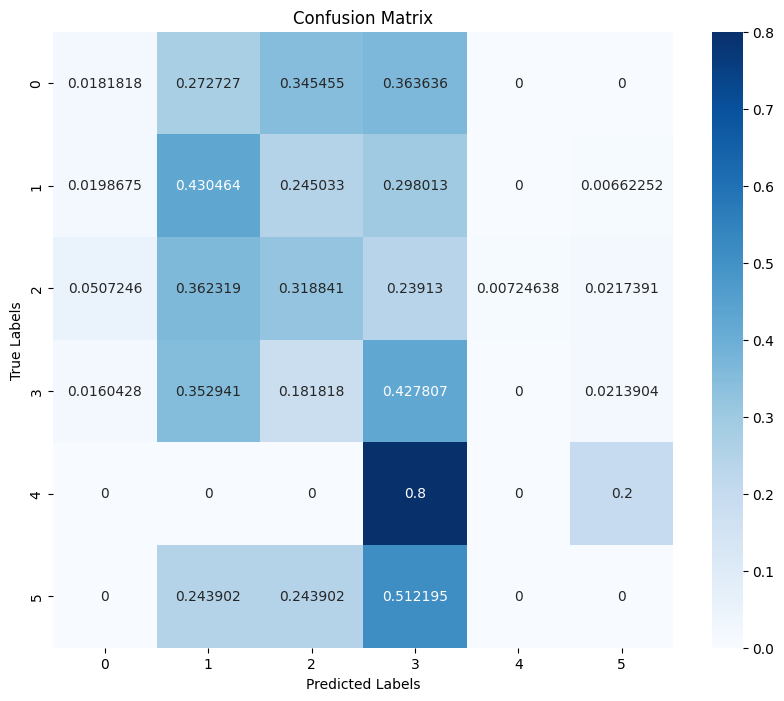

Epoch 3, Validation Loss: 2.2946, Accuracy: 0.3293, F1 Score: 0.3057
Val F1 Score Per Class  [0.02898551 0.36414566 0.31205674 0.41025641 0.         0.        ]


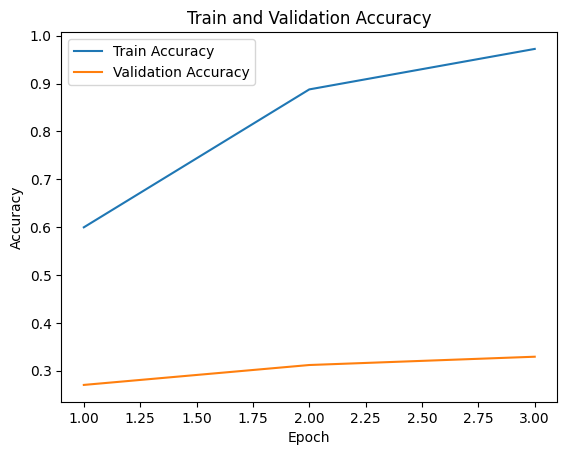

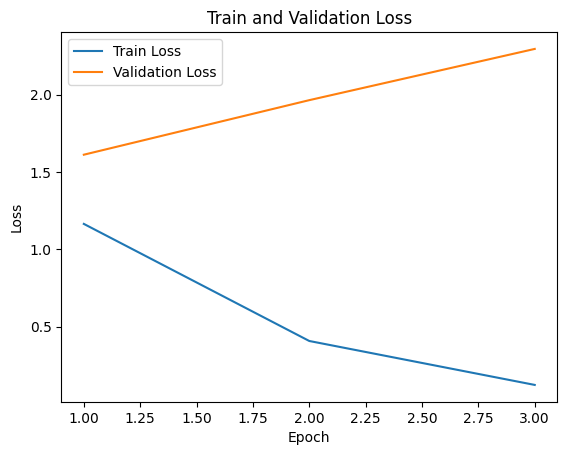

Epoch 4, Train Loss: 0.0641, Accuracy: 0.9848, F1 Score: 0.9848
Train F1 Score Per Class  [0.99279778 0.9769821  0.97216525 0.96940897 1.         0.99636364]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=3.27]

[tensor([-2.2897,  2.9865, -0.8801, -0.8723, -2.7225, -2.1020], device='cuda:0'), tensor([-1.5428,  2.8978, -0.0032, -1.2605, -2.5551, -2.3217], device='cuda:0'), tensor([-1.6869, -0.6561, -0.2929,  2.7892, -2.8801, -2.7349], device='cuda:0'), tensor([-1.5615,  1.3732, -1.7064,  2.0176, -2.4431, -2.0363], device='cuda:0'), tensor([-2.0099, -1.3628,  1.7721,  2.4719, -2.3798, -2.2152], device='cuda:0'), tensor([-2.4831,  0.1783,  0.2253,  3.0170, -2.2436, -2.6133], device='cuda:0'), tensor([-1.9172, -0.0249, -1.5964,  3.5068, -2.8002, -1.2359], device='cuda:0'), tensor([-2.1574, -0.1157,  4.1655, -0.1416, -2.0603, -2.2472], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=2.97]

[tensor([-0.3994, -1.3474, -1.1634,  2.7188, -2.8902, -2.5860], device='cuda:0'), tensor([-2.3401, -0.0254, -2.6356,  1.0233, -1.3132,  1.2629], device='cuda:0'), tensor([-0.0553, -1.7651,  3.2751,  0.4575, -1.7483, -2.4698], device='cuda:0'), tensor([-1.2909,  0.4507, -0.1781,  2.4454, -2.8321, -1.5658], device='cuda:0'), tensor([-1.0211,  4.1214, -0.8883, -0.5745, -2.5277, -1.9284], device='cuda:0'), tensor([-1.9115, -0.0938, -1.3965,  2.8154, -3.1362, -2.4508], device='cuda:0'), tensor([ 3.3869, -1.9853, -0.2178,  0.3022, -1.8277, -1.9544], device='cuda:0'), tensor([ 0.0887, -0.4151, -0.7017,  1.5653, -2.8150, -2.5533], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.14it/s, loss=3.34]

[tensor([-2.0460,  2.3184,  0.9042, -0.8125, -2.2774, -3.0836], device='cuda:0'), tensor([-0.7001,  4.0807, -0.8924, -1.3454, -1.3596, -1.6464], device='cuda:0'), tensor([-1.7107, -1.4487,  4.1219,  0.0875, -2.0035, -1.7015], device='cuda:0'), tensor([-0.6075, -1.7887,  0.9129,  0.5260, -2.5696, -2.6793], device='cuda:0'), tensor([-1.3054,  1.3810, -1.4626,  1.3857, -2.2317, -2.3513], device='cuda:0'), tensor([-1.0975,  0.0049, -1.1542,  4.1163, -2.7015, -2.2800], device='cuda:0'), tensor([-1.3007, -2.2279,  0.8136,  0.2255, -1.8651, -2.4874], device='cuda:0'), tensor([ 4.5006, -1.0738, -0.6232, -1.2435, -1.8208, -1.6216], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:31,  2.16it/s, loss=2.39]

[tensor([-1.9407, -1.1311,  2.2364,  2.0957, -2.4258, -3.0511], device='cuda:0'), tensor([-2.8520,  0.2338, -0.5388,  0.9185, -2.7529, -1.7216], device='cuda:0'), tensor([-1.9358, -0.7132, -1.1269,  0.1414, -2.9301, -1.1315], device='cuda:0'), tensor([-1.5906,  0.2598,  0.9190,  0.0387, -2.0872, -2.4867], device='cuda:0'), tensor([ 4.6140, -1.1084, -0.2251, -0.2616, -1.9768, -1.7688], device='cuda:0'), tensor([-1.8006, -0.5738, -1.4621,  0.1350, -3.2723, -1.2914], device='cuda:0'), tensor([-1.1775,  4.3988, -1.2168, -0.8405, -2.1153, -1.7348], device='cuda:0'), tensor([-2.3987,  4.0362, -0.6081, -1.1755, -1.7257, -0.5784], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.17it/s, loss=3.11]

[tensor([-1.6445, -1.4644, -1.4991,  2.9763, -2.8452, -1.8465], device='cuda:0'), tensor([-2.4378, -1.2529,  0.9647,  2.5835, -2.5459, -2.6655], device='cuda:0'), tensor([-1.0961, -1.6690,  3.2350, -1.2885, -2.5867, -2.2390], device='cuda:0'), tensor([-2.1637, -0.8597, -1.2637,  3.4537, -2.4667, -2.2047], device='cuda:0'), tensor([-1.8367,  0.1439,  4.1987, -0.0348, -2.3109, -2.4495], device='cuda:0'), tensor([-1.1973, -0.9554, -0.3960,  3.8617, -3.2453, -2.1573], device='cuda:0'), tensor([-1.7242,  1.7657, -0.6671, -0.8054, -2.8942, -1.0940], device='cuda:0'), tensor([-1.5345,  0.7620, -1.0462,  1.5789, -2.4964, -1.0117], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:30,  2.18it/s, loss=3.39]

[tensor([-1.5042, -1.1092,  4.3715,  0.0720, -2.2958, -2.6283], device='cuda:0'), tensor([-1.5997, -1.0096,  3.9605, -0.7495, -1.9432, -2.1586], device='cuda:0'), tensor([-1.3733,  0.6570,  1.5179, -0.2611, -2.6727, -3.1756], device='cuda:0'), tensor([-1.8184,  4.3361, -0.8987, -0.3383, -1.6694, -1.8317], device='cuda:0'), tensor([-0.6758, -1.3587,  2.2256,  0.0174, -2.4338, -2.8762], device='cuda:0'), tensor([-1.2946, -2.3831, -0.3391,  2.5576, -1.9988, -2.2357], device='cuda:0'), tensor([-0.4170, -2.1658,  3.9780,  0.8822, -1.7960, -2.2296], device='cuda:0'), tensor([-1.4908, -0.3193, -1.2625,  0.2241, -2.2718, -2.0171], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.18it/s, loss=2.32]

[tensor([-1.3147,  1.3135,  0.8107, -1.0999, -2.4215, -1.5035], device='cuda:0'), tensor([-1.3767, -1.5237,  2.9619, -0.4103, -1.7432, -1.6537], device='cuda:0'), tensor([ 1.3380, -0.9953,  2.7848, -1.3906, -1.6379, -2.1529], device='cuda:0'), tensor([-2.5353, -0.7358,  1.5806,  0.1941, -2.9629, -2.0052], device='cuda:0'), tensor([-2.4806,  1.5746,  1.1567, -0.1563, -2.4173, -3.3173], device='cuda:0'), tensor([-1.9326,  0.0658,  1.9526, -1.4327, -1.8437, -1.5694], device='cuda:0'), tensor([-1.9968, -1.1103,  4.2772, -0.4524, -2.1221, -0.8014], device='cuda:0'), tensor([-1.6517,  1.8762, -1.4169,  0.5743, -2.8943, -2.7957], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:29,  2.17it/s, loss=3.89]

[tensor([-0.6454, -1.7055,  1.8067,  0.7526, -2.5496, -2.3648], device='cuda:0'), tensor([-1.0970, -1.0167,  1.4873,  0.4439, -2.4490, -2.2202], device='cuda:0'), tensor([-1.1177, -0.6466, -1.2243,  4.4593, -2.4859, -1.9277], device='cuda:0'), tensor([-1.4779,  4.0062, -0.9499, -0.4627, -1.9959, -2.6625], device='cuda:0'), tensor([-1.5901, -1.0911,  3.9370, -0.0265, -1.8024, -2.4051], device='cuda:0'), tensor([-1.1565,  4.2365, -0.9216, -0.3920, -1.8623, -2.2648], device='cuda:0'), tensor([-2.2957, -0.9684, -0.5005,  0.3060, -3.3346, -2.3747], device='cuda:0'), tensor([-1.7937, -0.7441,  4.0379,  0.0379, -1.9960, -2.0186], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.17it/s, loss=3.75]

[tensor([-1.9683,  0.2307, -1.7997,  0.1677, -3.0155, -0.2559], device='cuda:0'), tensor([-1.9387, -0.4053,  2.2613,  0.5269, -2.7002, -2.8938], device='cuda:0'), tensor([-0.7757,  4.4510, -1.0946, -0.6935, -1.5168, -2.0365], device='cuda:0'), tensor([-1.2973, -1.0612,  3.4789, -0.1032, -1.7471, -2.4231], device='cuda:0'), tensor([-0.4492, -1.0452, -0.5573,  2.3135, -1.3928, -2.4702], device='cuda:0'), tensor([-1.8354,  3.3037, -0.1467, -0.8305, -2.3840, -1.9901], device='cuda:0'), tensor([-2.5310,  0.2188, -1.8593, -0.0178, -2.2337, -1.4908], device='cuda:0'), tensor([-1.4752, -2.2028, -0.6452,  3.0221, -2.7153, -2.1507], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:28,  2.18it/s, loss=2.24]

[tensor([-1.5424,  4.2392, -0.2013, -1.0139, -1.2102, -1.7377], device='cuda:0'), tensor([-2.0300, -0.2479,  0.2695,  1.0821, -2.1704, -2.5611], device='cuda:0'), tensor([-1.1314,  1.1628, -1.4665, -1.0013, -2.2234, -2.4419], device='cuda:0'), tensor([-0.6644, -2.0419,  0.5261, -0.0297, -2.4196, -0.3991], device='cuda:0'), tensor([-1.4999,  4.0328, -0.5472, -0.3770, -1.7559, -2.1185], device='cuda:0'), tensor([-0.7052,  0.1438,  1.0014,  2.4733, -2.6150, -3.6554], device='cuda:0'), tensor([-2.2774,  2.9337, -2.1153, -0.6087, -1.7980, -1.7707], device='cuda:0'), tensor([-1.8065,  3.3943, -1.2944,  0.7975, -2.3869, -2.5417], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.18it/s, loss=3.13]

[tensor([-2.4166,  1.2572, -0.1293,  1.3224, -2.5045, -2.2405], device='cuda:0'), tensor([-0.3274,  1.0190, -1.6101, -0.1513, -2.5309, -2.1585], device='cuda:0'), tensor([-2.4540,  0.0564,  1.2930,  1.4547, -2.5412, -2.0138], device='cuda:0'), tensor([-1.3081, -1.5061,  0.2354,  3.3967, -2.9386, -2.3791], device='cuda:0'), tensor([-2.7972,  3.4227, -1.0058, -0.2883, -2.7565, -0.6553], device='cuda:0'), tensor([-0.9725, -0.8120, -1.3516,  4.2112, -1.6705, -2.1147], device='cuda:0'), tensor([-2.5006, -0.1805,  2.2304, -0.1974, -2.0640, -2.6181], device='cuda:0'), tensor([-1.3554, -0.7660, -1.1942,  2.8414, -1.6199, -2.5686], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:27,  2.18it/s, loss=2.36]

[tensor([-1.6264, -1.5827,  4.0370, -0.2250, -1.6290, -2.4831], device='cuda:0'), tensor([-1.2798, -0.0298,  0.3808,  1.8774, -2.3326, -2.5426], device='cuda:0'), tensor([-2.1121,  1.2985,  2.1122,  0.8296, -2.3651, -3.2497], device='cuda:0'), tensor([-1.8529,  0.3024, -1.6710,  0.9488, -2.3286, -2.7623], device='cuda:0'), tensor([-1.1954, -1.1427, -1.5786,  0.7092, -2.2542, -3.1529], device='cuda:0'), tensor([-1.5634, -0.8815,  3.6685,  0.5777, -2.7039, -2.6697], device='cuda:0'), tensor([-0.9457, -1.1713, -2.0876,  3.3220, -2.3595, -1.8845], device='cuda:0'), tensor([ 0.9179, -1.2043, -0.1934, -0.4951, -2.4621, -2.1300], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:05<00:27,  2.18it/s, loss=1.87]

[tensor([-1.5076, -1.2476,  3.3699,  0.8177, -2.3089, -2.5905], device='cuda:0'), tensor([-2.4883,  3.7197,  0.9077, -0.4988, -1.7297, -2.2092], device='cuda:0'), tensor([-2.1695,  3.2659, -0.4066, -0.3122, -2.8387, -1.9669], device='cuda:0'), tensor([-2.2630,  1.9041,  1.5021, -1.3442, -2.4516, -1.9456], device='cuda:0'), tensor([-1.8502,  3.6156, -1.4066, -0.2425, -1.9378, -1.8792], device='cuda:0'), tensor([-1.3889, -1.5758,  0.3994, -0.4481, -2.2328, -1.9831], device='cuda:0'), tensor([-2.4523,  2.3962, -1.2031, -0.3033, -2.5090, -2.0274], device='cuda:0'), tensor([-1.6271,  4.2359,  0.0490, -0.8143, -2.5099, -2.1958], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.18it/s, loss=2.13]

[tensor([ 2.9339, -1.8098, -0.9302, -0.1058, -2.0207, -1.9085], device='cuda:0'), tensor([-0.6505,  0.5126, -1.1372, -0.5801, -2.7245, -1.2994], device='cuda:0'), tensor([-2.1999, -0.8193,  0.1957, -1.7551, -2.4737,  3.0952], device='cuda:0'), tensor([-1.3411, -1.2472,  0.1499,  1.1759, -2.7796, -2.8882], device='cuda:0'), tensor([-2.0793, -0.8709, -1.4516,  4.3362, -1.6617, -1.2079], device='cuda:0'), tensor([-2.1027,  4.0856,  0.1424,  0.1344, -2.2717, -2.1126], device='cuda:0'), tensor([-1.9072,  3.4449, -0.5522, -1.3025, -2.3120, -2.1177], device='cuda:0'), tensor([-1.5605,  1.4729, -0.9399,  1.0109, -2.8442, -2.2851], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:26,  2.18it/s, loss=2.78]

[tensor([-1.8109,  0.6059, -1.1648,  3.3355, -2.4576, -2.2578], device='cuda:0'), tensor([-2.1734,  1.1384, -1.3342, -0.0541, -2.3363, -1.8269], device='cuda:0'), tensor([-0.8517, -0.6477,  4.4874, -1.2054, -1.8734, -1.6158], device='cuda:0'), tensor([-1.1288, -1.7803,  0.0450,  4.2093, -2.3927, -1.8758], device='cuda:0'), tensor([-1.8131, -0.1696, -1.1150,  3.0533, -2.7318, -2.4395], device='cuda:0'), tensor([-1.1124,  3.9008, -0.1562, -0.9692, -2.2188, -2.7957], device='cuda:0'), tensor([-2.3361, -0.6421,  0.4027,  0.6108, -3.1567, -1.5811], device='cuda:0'), tensor([-1.9381, -0.1875,  3.8479, -0.3987, -1.9602, -2.7248], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.17it/s, loss=2.02]

[tensor([-1.7201, -0.5722, -0.8012,  4.3225, -2.3898, -1.6159], device='cuda:0'), tensor([-1.7540,  3.6170,  0.5020, -1.5745, -2.2851, -2.1559], device='cuda:0'), tensor([-2.0951,  0.3250, -0.7581,  2.6610, -2.2933, -2.4257], device='cuda:0'), tensor([-2.6555,  2.6731, -0.5168, -0.1137, -2.6507, -1.2052], device='cuda:0'), tensor([-1.0471, -1.8536,  0.3830,  1.3561, -2.3212, -2.6911], device='cuda:0'), tensor([-2.2552, -0.4047,  3.9783, -0.2104, -1.7298, -2.4168], device='cuda:0'), tensor([-0.9744, -2.0778, -0.2492,  3.5950, -3.0254, -2.2984], device='cuda:0'), tensor([-2.6747, -0.2060,  0.4262, -0.6679, -2.3796, -1.8330], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:25,  2.18it/s, loss=2.97]

[tensor([-2.3218,  2.7225,  0.7414, -0.5062, -2.9246, -2.0649], device='cuda:0'), tensor([-1.5063,  2.6462, -0.7782, -0.6887, -2.2432, -1.7400], device='cuda:0'), tensor([-1.5831,  0.8840,  2.8341, -0.8319, -2.4741, -2.4039], device='cuda:0'), tensor([-1.3104,  3.7285,  0.6716, -0.9309, -2.3800, -3.0683], device='cuda:0'), tensor([-2.0645, -2.3386, -0.0116,  2.4039, -2.1550, -0.1226], device='cuda:0'), tensor([-1.0179, -1.5440,  0.3735,  1.6214, -2.4210, -2.8957], device='cuda:0'), tensor([ 4.9002, -2.0473, -0.7227, -0.8980, -1.4703, -0.2510], device='cuda:0'), tensor([-1.9359,  2.3233, -1.4448,  0.2789, -2.4854, -2.2444], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.16it/s, loss=2.34]

[tensor([-1.5021, -1.6332,  0.3598,  3.5253, -2.4510, -2.6514], device='cuda:0'), tensor([ 2.0976, -1.4521, -0.8441,  2.2610, -1.5618, -2.6320], device='cuda:0'), tensor([-2.5699,  2.0743,  2.0506, -1.1266, -2.6050, -1.9040], device='cuda:0'), tensor([-1.5273,  3.2351,  0.4172, -0.1697, -2.2483, -2.5726], device='cuda:0'), tensor([-2.0033, -2.1562,  2.1419,  1.1359, -1.4736, -2.0790], device='cuda:0'), tensor([-0.6581, -0.9124, -1.8223,  1.1106, -1.9198, -1.2344], device='cuda:0'), tensor([-1.6976,  2.8194, -0.4958, -0.4277, -2.5778, -2.0765], device='cuda:0'), tensor([-2.1666,  1.1082, -1.4528,  1.0584, -2.1476, -2.3955], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.16it/s, loss=2.05]

[tensor([-1.8219, -0.3251, -0.0523,  0.5239, -2.1475, -2.6533], device='cuda:0'), tensor([ 0.1981, -1.4225, -0.7246, -0.3545, -2.3947, -2.5466], device='cuda:0'), tensor([-1.7205, -1.0323,  2.3557,  2.5207, -2.0961, -2.1908], device='cuda:0'), tensor([-1.1117, -1.1380, -0.7477,  4.6511, -1.7540, -1.9724], device='cuda:0'), tensor([-1.5482,  2.3457, -0.2795,  0.0823, -3.2637, -3.1108], device='cuda:0'), tensor([ 3.0757, -1.6918, -1.7344, -0.0052, -1.8922, -1.5837], device='cuda:0'), tensor([-1.6921, -0.8272,  0.4485,  1.8984, -2.8726, -2.3886], device='cuda:0'), tensor([-0.8857,  1.0844, -0.1024,  0.0813, -2.3612, -2.3451], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=3.31]

[tensor([-1.7107, -1.5212,  2.4715,  1.3669, -2.3365, -2.8844], device='cuda:0'), tensor([-1.9578,  2.9359, -2.6691,  0.4365, -1.6607, -1.7996], device='cuda:0'), tensor([-1.4536, -1.2660,  3.4051,  0.0071, -2.1226, -1.9659], device='cuda:0'), tensor([ 0.9866, -2.3645,  1.4282, -0.0445, -2.4937, -2.0961], device='cuda:0'), tensor([ 0.3872, -0.9846, -0.5383, -0.1441, -2.7571, -2.6033], device='cuda:0'), tensor([-1.4421,  4.2906, -0.9546, -0.7466, -2.0949, -1.3971], device='cuda:0'), tensor([-0.4757, -2.0511,  1.3746,  2.3081, -2.5860, -2.7278], device='cuda:0'), tensor([-2.0268,  0.5491,  3.0621, -0.9084, -2.2101, -2.7409], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.17it/s, loss=3.25]

[tensor([-0.5062, -1.3590,  4.4728, -1.0425, -1.7053, -1.8111], device='cuda:0'), tensor([-2.0747,  0.2705,  0.9779,  1.3193, -3.0533, -3.0048], device='cuda:0'), tensor([-1.9649,  1.6051,  2.4774, -1.0788, -2.2931, -2.3288], device='cuda:0'), tensor([-1.3455, -1.6979,  3.1571,  1.5576, -2.5467, -2.9628], device='cuda:0'), tensor([-1.6347, -0.3779,  3.5135, -0.1620, -2.4594, -2.8797], device='cuda:0'), tensor([-2.0502, -1.1504,  1.3234, -0.4760, -2.5916, -2.1953], device='cuda:0'), tensor([-1.4286, -1.2425, -0.8165,  4.6260, -1.8116, -1.6707], device='cuda:0'), tensor([-1.6580, -0.6004, -0.6536,  3.2725, -1.8932, -1.4547], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.17it/s, loss=1.82]

[tensor([-1.7045, -0.6045, -0.4544,  4.2428, -2.3184, -2.4089], device='cuda:0'), tensor([-1.8201, -1.6837,  0.2517,  2.0875, -2.3606, -1.7792], device='cuda:0'), tensor([-2.0766, -1.0550,  0.9370,  0.6701, -2.3645, -2.2006], device='cuda:0'), tensor([-1.3379, -1.8510, -1.8526,  1.9348, -2.0556, -0.2780], device='cuda:0'), tensor([-1.5185, -0.1560,  3.2750,  0.6359, -2.3099, -2.8051], device='cuda:0'), tensor([ 1.2728, -2.2868,  2.0779,  0.9221, -1.6186, -2.8573], device='cuda:0'), tensor([-1.2147,  0.0539, -1.4030,  0.1819, -3.0759, -1.6091], device='cuda:0'), tensor([-1.9914, -1.3077,  0.2732,  3.5317, -1.9697, -2.2778], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.16it/s, loss=2.21]

[tensor([-2.0724,  0.4754,  0.1555,  0.8698, -2.3689, -2.7388], device='cuda:0'), tensor([-2.0519, -1.1206, -0.5528,  1.9055, -2.4681, -1.0306], device='cuda:0'), tensor([-1.3289, -0.8784, -1.3602,  4.2255, -1.4803, -2.3492], device='cuda:0'), tensor([-2.0022,  0.6756, -1.6387,  0.9337, -2.4306, -2.2677], device='cuda:0'), tensor([-1.9169,  1.5061, -0.3528,  1.1526, -2.5717, -2.8783], device='cuda:0'), tensor([-0.9124, -1.4375, -0.9098,  4.5072, -1.6961, -1.3521], device='cuda:0'), tensor([-0.1183, -2.0301,  2.5256, -0.0390, -1.9360, -2.0048], device='cuda:0'), tensor([-2.5208, -1.8005,  4.0792, -0.1592, -2.0242, -2.0256], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=2.62]

[tensor([-1.2022, -1.1029, -1.7455,  3.4373, -1.9795, -1.3434], device='cuda:0'), tensor([-0.6500, -1.5474, -0.3823,  1.1278, -3.3108, -2.2752], device='cuda:0'), tensor([-1.1777, -1.3116,  0.0189,  3.7592, -2.2057, -2.7979], device='cuda:0'), tensor([-0.0413, -1.6254,  3.1139, -0.9439, -1.8194, -2.8553], device='cuda:0'), tensor([-2.2201,  1.0748,  3.1763, -1.3860, -1.7971, -2.2271], device='cuda:0'), tensor([-1.2298, -1.3239, -0.3953, -0.2291, -1.9540, -3.2028], device='cuda:0'), tensor([-2.4543, -0.3955,  0.0693,  1.2301, -1.9335, -0.9285], device='cuda:0'), tensor([-0.7757,  4.0120, -1.1041, -0.6145, -2.3972, -1.5443], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=3.03]

[tensor([-2.0448,  1.2055, -0.3502,  1.7816, -3.1971, -1.8064], device='cuda:0'), tensor([ 1.0191, -0.2609, -1.4573, -0.3478, -2.8972, -1.4704], device='cuda:0'), tensor([-1.1242, -0.5194,  2.4885,  0.0164, -2.4624, -2.9787], device='cuda:0'), tensor([-1.3227, -1.3112,  4.5480, -0.7030, -1.7723, -2.1501], device='cuda:0'), tensor([-0.5138, -1.5417,  0.5066,  0.7607, -2.8264, -3.1084], device='cuda:0'), tensor([-1.4629,  3.3279,  0.1364, -1.9714, -1.8869, -1.4959], device='cuda:0'), tensor([-1.4369,  4.2699, -1.6238, -1.3619, -2.3520, -1.2689], device='cuda:0'), tensor([-1.9950,  2.7781, -1.9754,  0.4724, -2.8331, -0.9847], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:21,  2.16it/s, loss=3.03]

[tensor([-1.7288,  3.3636, -1.6624, -0.3837, -2.6376, -1.2937], device='cuda:0'), tensor([-1.7818, -0.4946,  3.6437, -1.2333, -1.5992, -1.7011], device='cuda:0'), tensor([-1.8830,  2.2699,  2.7171, -0.8946, -2.0430, -2.8097], device='cuda:0'), tensor([-1.4576, -0.6252, -0.3143, -0.3617, -2.3465, -3.5110], device='cuda:0'), tensor([-0.9663,  2.8887, -1.3034,  0.5325, -2.5908, -2.5684], device='cuda:0'), tensor([-2.0228, -0.6031,  3.4053,  0.1056, -2.1287, -2.1979], device='cuda:0'), tensor([-0.4045, -0.7610,  1.2809, -1.1054, -2.2294, -2.1966], device='cuda:0'), tensor([-0.5543, -2.1599,  0.3127,  2.7166, -2.0154, -1.5678], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=3.05]

[tensor([-1.0500, -1.3655, -1.7889,  2.6648, -2.2830,  0.1754], device='cuda:0'), tensor([-2.0201,  3.7848,  0.2507, -0.8599, -2.0668, -2.4738], device='cuda:0'), tensor([-1.3916, -0.9715, -0.0873,  1.0849, -2.2073, -2.0006], device='cuda:0'), tensor([-1.6344, -1.5684, -0.4293,  4.2907, -1.8155, -1.8114], device='cuda:0'), tensor([-0.7988, -0.9772, -1.0312,  0.6458, -1.9650, -2.1517], device='cuda:0'), tensor([-2.4698, -0.2333,  1.1056,  1.2668, -2.4493, -3.0662], device='cuda:0'), tensor([-1.5004, -0.6856,  0.9894,  1.5356, -2.6143, -3.0767], device='cuda:0'), tensor([-2.6664,  0.4238, -1.5831,  2.1687, -2.8525, -1.5266], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:12<00:20,  2.16it/s, loss=2.33]

[tensor([ 0.8607, -1.2218,  3.1090, -0.9557, -1.6473, -2.3194], device='cuda:0'), tensor([-2.1761, -1.3551,  0.1820,  2.6766, -2.5339, -2.1223], device='cuda:0'), tensor([-0.4695, -1.4293, -0.1709,  2.8737, -2.6583, -3.1329], device='cuda:0'), tensor([-1.0593, -1.8775,  3.6099,  0.1036, -2.3310, -1.6335], device='cuda:0'), tensor([-2.4526,  1.2120,  3.4436, -1.2692, -2.0663, -1.8760], device='cuda:0'), tensor([-2.1945, -0.9854,  2.1657,  0.3290, -1.7811, -1.4464], device='cuda:0'), tensor([-1.0946, -0.6589,  2.2997,  0.3373, -2.5345, -1.4805], device='cuda:0'), tensor([-1.0773, -1.4567,  4.2957, -0.0969, -1.9196, -1.6563], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.17it/s, loss=2.25]

[tensor([ 3.5987, -0.1926,  0.1291, -1.8096, -2.0648, -1.1216], device='cuda:0'), tensor([-2.3904, -0.4312,  2.1527,  0.0703, -2.7168, -2.7382], device='cuda:0'), tensor([-1.1225, -0.9362, -1.1903,  4.4936, -2.2641, -2.5051], device='cuda:0'), tensor([-0.9165,  0.0792,  1.6202, -0.0613, -2.1377, -1.8964], device='cuda:0'), tensor([-1.8327,  4.0538, -0.5445, -0.1517, -1.8221, -2.3886], device='cuda:0'), tensor([-1.7167, -1.7559,  1.8451,  1.4477, -2.9048, -1.9632], device='cuda:0'), tensor([-1.7511, -0.5176,  2.1778,  0.8929, -2.3577, -2.2277], device='cuda:0'), tensor([-2.8348,  0.0894, -0.5837,  0.1758, -2.2779, -1.7901], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=3.87]

[tensor([-2.2004,  2.2923, -1.1711,  0.4068, -2.6596, -2.6847], device='cuda:0'), tensor([-2.0970, -0.9793,  2.6920,  1.1041, -2.5281, -2.2527], device='cuda:0'), tensor([-2.3779,  3.4750,  0.1462, -0.6170, -2.8224, -1.5677], device='cuda:0'), tensor([-2.6336,  2.4203, -0.3010,  0.1879, -1.7642, -0.9601], device='cuda:0'), tensor([-1.1726, -1.4339, -0.2889,  4.3014, -1.7636, -2.3389], device='cuda:0'), tensor([-1.2352, -2.1798,  2.1737,  0.5855, -2.3186, -1.8473], device='cuda:0'), tensor([-0.6296, -1.7544,  1.3283,  2.1317, -1.8851, -1.9907], device='cuda:0'), tensor([ 4.4250, -1.7190, -0.8692, -0.5185, -1.6062, -1.4788], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=1.86]

[tensor([-1.7967, -1.8270,  0.1245,  3.5350, -2.3076, -1.0452], device='cuda:0'), tensor([-1.0581, -1.7969, -0.7822,  3.5651, -2.5299, -2.2467], device='cuda:0'), tensor([-1.6265, -1.2695, -0.1871,  1.8851, -2.5916, -1.4680], device='cuda:0'), tensor([-0.1485,  1.3020,  3.2207, -1.1361, -2.7508, -2.6731], device='cuda:0'), tensor([ 1.9036, -1.1374,  0.3817, -0.2960, -2.7653, -3.2707], device='cuda:0'), tensor([-1.6679, -0.8465, -2.3597,  2.4117, -2.0235,  0.3284], device='cuda:0'), tensor([-0.8704,  2.8044, -2.1243, -0.2780, -2.2145, -1.6878], device='cuda:0'), tensor([-2.2818,  0.7116, -0.3012,  1.9857, -2.7552, -2.9377], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=2.37]

[tensor([-2.1414,  0.7710,  2.7621, -1.2499, -2.3293, -1.6857], device='cuda:0'), tensor([-0.8773,  1.1686,  1.4593, -0.3175, -2.4531, -3.1805], device='cuda:0'), tensor([-1.2562,  0.4393,  2.6787, -0.1358, -2.6752, -2.7037], device='cuda:0'), tensor([-1.9257, -0.6722,  1.5921,  1.1634, -2.2845, -2.3156], device='cuda:0'), tensor([-2.5200, -1.6448,  1.3813,  2.1583, -1.9677, -1.6731], device='cuda:0'), tensor([-1.5661,  4.4961, -0.7816, -0.9101, -1.8265, -1.5071], device='cuda:0'), tensor([-1.3359, -1.7095, -1.3346, -0.5717, -1.8349,  4.9178], device='cuda:0'), tensor([-1.0421, -1.7231, -0.5536,  0.2969, -1.7418, -2.2377], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.15it/s, loss=2.82]

[tensor([-1.8918,  3.0044,  0.3141,  0.7094, -2.6480, -2.6488], device='cuda:0'), tensor([-1.0022, -0.0546, -0.8138,  1.6889, -2.0974, -3.0827], device='cuda:0'), tensor([-1.8590,  3.2588, -0.5443, -0.7403, -2.7663, -2.9308], device='cuda:0'), tensor([-2.0819,  0.4822, -1.4596,  3.6838, -1.9235, -1.7640], device='cuda:0'), tensor([ 0.5954, -1.0148, -1.0100,  2.6699, -2.3250, -2.8446], device='cuda:0'), tensor([-2.1119, -0.6787,  0.3397, -0.2414, -2.2024, -1.9762], device='cuda:0'), tensor([-1.8798, -1.4978,  0.0494,  2.2777, -3.0998, -2.6000], device='cuda:0'), tensor([-0.1459, -1.8796,  0.2818,  2.1885, -2.9557, -2.1218], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.16it/s, loss=2.44]

[tensor([-1.2595, -1.3021,  2.7376,  0.3257, -2.8698, -2.7538], device='cuda:0'), tensor([-2.1946, -1.6020,  1.4049,  1.3295, -2.2505, -2.2189], device='cuda:0'), tensor([-0.5429, -1.0870,  4.3209, -0.9224, -2.0178, -2.4012], device='cuda:0'), tensor([-1.2208, -1.0767,  0.1472, -0.5886, -2.8077, -1.9556], device='cuda:0'), tensor([-1.6710, -1.1512,  0.1868,  3.7937, -2.1639, -2.3253], device='cuda:0'), tensor([-2.0839, -1.2401,  3.6665, -0.6525, -2.0743, -2.1054], device='cuda:0'), tensor([ 1.7049, -2.1341,  0.4577,  1.6240, -1.9757, -2.6778], device='cuda:0'), tensor([-0.6003, -1.0297, -1.0020,  2.1620, -3.0982, -2.6835], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.17it/s, loss=1.82]

[tensor([-1.1484, -0.3628, -1.1201, -0.5629, -1.6410, -2.4214], device='cuda:0'), tensor([-1.7316,  0.5910,  2.1339, -1.5889, -2.1728, -1.6279], device='cuda:0'), tensor([ 0.9320, -1.6593, -1.3176,  0.6033, -2.4809, -2.0642], device='cuda:0'), tensor([ 1.6484, -2.2120,  0.0423, -0.3882, -2.1076, -1.8644], device='cuda:0'), tensor([-1.5062, -0.2019,  2.3346, -0.2654, -1.8620, -1.6596], device='cuda:0'), tensor([-1.3047, -1.1392, -0.4423,  3.7678, -2.1874, -1.4918], device='cuda:0'), tensor([-1.1391, -2.1033,  2.6490,  1.6874, -2.1026, -2.5357], device='cuda:0'), tensor([-2.2445,  3.8817, -0.7298, -1.5123, -1.7618, -0.6898], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.17it/s, loss=2.08]

[tensor([-2.4255,  1.3490, -0.5387,  0.2251, -1.9471, -1.7355], device='cuda:0'), tensor([ 4.6393, -1.6013, -0.4421, -0.5592, -2.0290, -1.9197], device='cuda:0'), tensor([-1.9013, -0.6413, -1.4273,  4.1693, -1.6851, -2.1770], device='cuda:0'), tensor([-1.6374,  1.2432,  2.4238, -0.8791, -2.4194, -2.1731], device='cuda:0'), tensor([-1.3640, -1.9556,  2.8780,  1.0964, -2.5764, -2.9894], device='cuda:0'), tensor([-2.2147,  3.6358,  0.2268, -0.7691, -1.2605, -2.5570], device='cuda:0'), tensor([-2.3784,  2.8501,  0.3213, -0.5538, -2.9133, -1.1164], device='cuda:0'), tensor([-1.7165, -0.8843,  0.2607, -0.3337, -2.2676, -2.8954], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.16it/s, loss=3.02]

[tensor([-2.2142, -0.5970, -0.1218,  2.7290, -2.3304, -2.0732], device='cuda:0'), tensor([-2.1933,  1.4444, -0.1622, -0.8810, -1.6861, -2.3799], device='cuda:0'), tensor([-0.4141, -1.0068, -1.3849,  2.6802, -2.1728, -2.3723], device='cuda:0'), tensor([-1.8660,  0.2608,  4.5180, -1.2601, -1.7597, -1.9229], device='cuda:0'), tensor([ 0.1157, -0.3375, -1.3706, -0.1958, -2.1074, -2.9865], device='cuda:0'), tensor([-1.3687, -0.5391,  0.3755, -0.6773, -1.4811, -2.3679], device='cuda:0'), tensor([-1.7028,  2.3523, -0.7080, -0.4733, -2.6479, -2.2594], device='cuda:0'), tensor([-2.1880,  0.2536,  0.1538,  1.5937, -2.5607, -2.7115], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=3.09]

[tensor([-1.8797, -1.2061, -2.0130,  3.4853, -1.5824, -0.5184], device='cuda:0'), tensor([-2.1658,  1.0372,  0.4345,  1.2657, -1.9210, -2.5607], device='cuda:0'), tensor([-0.8222, -0.9054,  1.2500,  2.7784, -2.2892, -2.9337], device='cuda:0'), tensor([-1.1547, -1.2886,  4.4736, -0.6438, -1.9392, -2.0996], device='cuda:0'), tensor([-1.1956, -1.1278,  4.6117, -0.5489, -1.7306, -1.2775], device='cuda:0'), tensor([-0.7573, -1.0625, -0.6258,  2.8780, -1.9164, -2.5250], device='cuda:0'), tensor([-1.7817,  2.2261, -1.9550,  0.0998, -1.7854, -1.7259], device='cuda:0'), tensor([-1.9407,  3.9503, -0.2178, -0.6756, -1.9947, -2.4675], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.16it/s, loss=2.85]

[tensor([-1.2313,  0.2812,  2.5381,  0.2020, -2.6682, -3.2196], device='cuda:0'), tensor([-1.8198, -0.4484, -2.1336,  1.6428, -1.4690,  0.7798], device='cuda:0'), tensor([ 3.0438, -1.2649, -1.4897, -0.0294, -1.8669, -2.0063], device='cuda:0'), tensor([-1.7013,  2.8650, -1.0811, -0.5342, -2.6849, -2.4981], device='cuda:0'), tensor([-0.1004,  0.1966, -1.3878,  1.8360, -3.0345, -2.5497], device='cuda:0'), tensor([-0.5432, -1.7068,  4.4640, -0.1540, -1.7448, -1.9060], device='cuda:0'), tensor([-0.8791, -0.7378, -1.3296,  3.4096, -1.6873, -2.8627], device='cuda:0'), tensor([-2.1703, -0.6471,  4.1586,  0.5602, -1.9750, -1.8827], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=2.12]

[tensor([-2.2042,  3.2928, -1.0245,  0.0600, -1.8387, -2.8172], device='cuda:0'), tensor([-2.0098, -0.2167,  0.8679,  0.1189, -2.4419, -2.2058], device='cuda:0'), tensor([-2.3784,  0.3918, -0.0834,  1.2972, -2.3312, -2.8145], device='cuda:0'), tensor([-0.8580, -1.5464,  4.7321, -0.9422, -1.5019, -1.7150], device='cuda:0'), tensor([-1.2142,  1.8028, -1.5984,  1.3987, -1.9750, -2.9575], device='cuda:0'), tensor([-2.6121, -1.8856, -0.0335,  2.7723, -3.1466, -1.6750], device='cuda:0'), tensor([-2.3879,  1.0122,  1.5497, -0.6654, -2.7211, -2.4760], device='cuda:0'), tensor([-0.3003, -1.1457,  1.9739,  0.8711, -1.1382, -2.5238], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:18<00:14,  2.15it/s, loss=2.52]

[tensor([-0.8323, -1.5455, -0.6559,  4.5924, -1.7093, -1.8790], device='cuda:0'), tensor([-0.8404, -1.2376, -1.4302,  4.4237, -2.2662, -1.6992], device='cuda:0'), tensor([-1.9607, -0.2275, -1.1380,  2.3934, -2.6702, -2.5029], device='cuda:0'), tensor([ 0.0337, -0.8413, -1.8419,  3.3699, -2.0351, -1.8507], device='cuda:0'), tensor([-1.7070,  1.5440,  0.1180, -0.3026, -2.0483, -2.8842], device='cuda:0'), tensor([-1.8847, -1.3793,  3.3528,  0.5611, -1.8379, -2.4139], device='cuda:0'), tensor([-1.1482, -1.0346,  0.4409,  0.1305, -2.4819, -2.6057], device='cuda:0'), tensor([-0.0685, -1.6809,  3.9031, -0.7158, -1.8406, -1.6816], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.15it/s, loss=2.84]

[tensor([-2.1250,  0.2491,  2.7806, -0.3367, -2.6659, -1.5598], device='cuda:0'), tensor([-1.7980,  0.1637, -1.1886, -0.4875, -2.3632, -2.0580], device='cuda:0'), tensor([ 5.1225, -1.3741, -0.9655, -1.0194, -1.3941, -0.0780], device='cuda:0'), tensor([-2.5259,  3.6338, -1.3064, -0.7868, -2.0082, -1.7378], device='cuda:0'), tensor([-0.6899, -1.2464, -1.5085,  4.4484, -1.9998, -1.5111], device='cuda:0'), tensor([-1.8030, -0.3119, -1.0806,  3.2147, -2.0438, -3.0995], device='cuda:0'), tensor([ 0.0424,  0.8856, -0.9242,  0.2371, -2.4540, -2.8277], device='cuda:0'), tensor([ 0.0309, -1.1092,  1.0349, -0.8121, -2.5809, -1.8937], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.15it/s, loss=2.41]

[tensor([-1.4976, -0.7783, -1.0114,  3.4794, -2.3497, -1.9750], device='cuda:0'), tensor([-2.3531, -0.2506, -0.8186, -0.5085, -1.6837, -1.5347], device='cuda:0'), tensor([-2.1756, -1.6720, -0.0684,  3.4351, -2.7198, -0.8469], device='cuda:0'), tensor([-0.8953, -0.8120, -0.5558,  4.3742, -2.3387, -2.7088], device='cuda:0'), tensor([-1.9275,  3.0598,  1.0656, -0.7336, -2.5089, -2.3203], device='cuda:0'), tensor([-1.9162,  0.2067, -1.1649,  1.3771, -2.9276, -2.5285], device='cuda:0'), tensor([-0.3082, -2.1307,  0.4934,  3.4789, -1.9745, -2.7932], device='cuda:0'), tensor([-0.8610, -1.3617,  0.7915, -0.3679, -1.6199, -3.0826], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.15it/s, loss=2.92]

[tensor([-1.3735,  0.8768,  2.3124, -0.1117, -2.2914, -3.3286], device='cuda:0'), tensor([-0.7664, -2.1174,  2.8779,  0.7447, -2.1251, -1.7382], device='cuda:0'), tensor([-2.6416,  0.4061, -0.9971,  2.6265, -2.5578, -2.3208], device='cuda:0'), tensor([-2.4689, -1.1983, -1.7005,  1.4911, -2.8535, -0.4059], device='cuda:0'), tensor([-1.2020, -1.3732, -0.6801,  2.0145, -0.5898, -0.9684], device='cuda:0'), tensor([-2.7173,  2.2954,  0.4958,  0.6250, -2.3109, -2.8347], device='cuda:0'), tensor([-0.0116, -1.6816,  2.6140,  0.6638, -2.1596, -2.3870], device='cuda:0'), tensor([-1.0048,  4.0319, -0.5698, -1.2980, -2.0825, -1.1580], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.16it/s, loss=2.72]

[tensor([ 3.9993, -1.3314, -1.6967, -0.2682, -2.1750, -1.8001], device='cuda:0'), tensor([-1.8355,  0.1466, -2.4635,  1.6229, -1.2594, -1.3656], device='cuda:0'), tensor([-1.7576,  0.8871, -1.6096,  2.3926, -2.3978, -1.7090], device='cuda:0'), tensor([-0.5674, -0.0113,  0.2766, -1.5667, -1.8728, -3.2832], device='cuda:0'), tensor([-1.6465, -0.8751,  4.6257, -0.1817, -1.6845, -1.9254], device='cuda:0'), tensor([-1.3240, -1.9286, -1.8406,  0.2368, -1.8687,  4.1601], device='cuda:0'), tensor([-1.6360,  4.0786, -0.9557, -0.5224, -2.1241, -2.1924], device='cuda:0'), tensor([-2.3448, -0.5669, -0.8387,  2.6532, -2.8800, -1.2373], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=2.08]

[tensor([-1.4110, -1.1245,  4.2925, -0.7202, -1.8984, -2.4129], device='cuda:0'), tensor([-1.5339,  0.2512, -1.0230,  2.1301, -1.5599, -1.4246], device='cuda:0'), tensor([-1.9535, -0.4006,  0.2356,  3.5590, -1.9646, -3.0156], device='cuda:0'), tensor([-1.3920, -1.1895,  4.4940, -1.1893, -1.7447, -1.6350], device='cuda:0'), tensor([-2.4655,  0.1179, -2.0701,  1.1685, -1.8061, -0.7558], device='cuda:0'), tensor([-1.8246, -0.0730, -1.3744,  1.4298, -2.2076, -2.5418], device='cuda:0'), tensor([-1.8139,  0.5420,  2.5772, -0.5950, -2.4316, -2.6113], device='cuda:0'), tensor([-1.2358,  0.0809,  3.3157, -0.9509, -1.7744, -2.5643], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.11]

[tensor([ 3.4527, -1.6395, -1.7250, -0.4262, -1.6179, -1.2742], device='cuda:0'), tensor([ 0.8393,  0.0476, -1.7684,  0.7570, -2.8196, -2.1933], device='cuda:0'), tensor([-2.2064, -0.8793, -0.1763,  0.6377, -1.9946, -2.3586], device='cuda:0'), tensor([-2.1828, -0.4091,  3.1739,  1.7118, -2.4166, -2.5858], device='cuda:0'), tensor([-1.7570,  2.5006,  1.0737, -0.1926, -2.2187, -3.2332], device='cuda:0'), tensor([-0.6957, -1.3318, -0.8749,  0.4849, -2.0881, -2.0075], device='cuda:0'), tensor([-1.5016, -0.7529, -0.2739,  1.2716, -1.7421, -2.6617], device='cuda:0'), tensor([-1.7827, -0.7476, -0.8589,  2.5023, -2.2367, -2.3030], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=2.9]

[tensor([-1.0030, -0.7525,  4.8964, -0.8680, -1.9071, -1.5901], device='cuda:0'), tensor([-1.5593, -0.0659, -1.3606,  1.0144, -3.0356, -2.6556], device='cuda:0'), tensor([-2.1197,  3.3827, -0.1139, -0.5454, -2.2535, -2.2108], device='cuda:0'), tensor([-1.2766,  3.8272, -0.6802, -1.1200, -2.5219, -1.6193], device='cuda:0'), tensor([-0.5137, -1.6279, -1.1413,  4.0564, -2.1016, -2.3110], device='cuda:0'), tensor([ 5.2774, -1.2871, -0.8757, -1.2617, -1.1308, -1.0750], device='cuda:0'), tensor([-1.1857, -1.1506,  2.7248,  0.5563, -2.6088, -2.6849], device='cuda:0'), tensor([-1.6585, -1.3635,  0.2678,  3.1308, -2.4994, -2.5273], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.15it/s, loss=2.32]

[tensor([-1.4397, -0.9086,  0.0691,  3.4058, -1.7333, -2.8471], device='cuda:0'), tensor([-0.1840,  1.1823, -1.1018, -0.3571, -2.6435, -2.5226], device='cuda:0'), tensor([-2.0271, -0.5228,  3.1319, -0.4575, -1.5997, -2.1176], device='cuda:0'), tensor([-1.4442,  1.1590,  0.3229, -1.1275, -2.4903, -2.1177], device='cuda:0'), tensor([-1.7311,  4.0839,  0.9995, -1.2331, -1.6508, -1.8230], device='cuda:0'), tensor([ 1.7212, -1.6016,  1.6306, -1.2840, -1.7945, -1.9167], device='cuda:0'), tensor([-2.1926,  1.4345, -0.0787, -0.9809, -2.2815, -1.8615], device='cuda:0'), tensor([-0.8734, -1.5213, -0.2169,  4.4110, -2.0414, -2.1713], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=2.6]

[tensor([-1.7007, -0.8936,  0.5370,  1.7439, -2.8556, -2.2380], device='cuda:0'), tensor([-1.0030, -1.0662,  0.7369,  0.2750, -2.2185, -2.5710], device='cuda:0'), tensor([-2.3121,  1.8288,  1.1474, -0.2714, -1.9317, -1.9077], device='cuda:0'), tensor([-1.8008,  1.9816, -0.0306,  0.2141, -3.3574, -2.4005], device='cuda:0'), tensor([-1.8243, -0.1943,  3.7226, -1.2687, -2.0316, -2.3702], device='cuda:0'), tensor([-1.6604, -1.4778, -1.3664,  3.5660, -1.6423, -0.4964], device='cuda:0'), tensor([-0.7760,  0.6056, -0.8122,  1.0627, -2.6932, -1.7941], device='cuda:0'), tensor([-1.3041,  0.6866, -0.8384,  2.3641, -3.1952, -2.8572], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=2.16]

[tensor([-1.0356, -1.0853,  4.1760,  0.2685, -2.0057, -2.4432], device='cuda:0'), tensor([-0.8790, -2.0620, -1.1655,  4.2430, -2.3687, -0.6551], device='cuda:0'), tensor([-2.1337,  3.7323,  0.6173, -0.6312, -2.2663, -1.7536], device='cuda:0'), tensor([-1.6504, -1.1376,  0.5110,  2.7907, -2.5543, -2.2650], device='cuda:0'), tensor([-2.1040,  4.2169, -0.2565, -0.8985, -2.4133, -1.8731], device='cuda:0'), tensor([-0.4133, -1.3863, -2.4895,  2.9931, -2.1052,  0.1294], device='cuda:0'), tensor([-1.4567,  2.0894, -1.1620,  1.0915, -2.4493, -2.4018], device='cuda:0'), tensor([-0.0626, -0.9664, -1.1113, -2.1789, -2.0021,  4.1482], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.16it/s, loss=1.62]

[tensor([-2.5558,  0.8815,  2.1971, -0.3210, -2.6524, -1.8256], device='cuda:0'), tensor([ 0.9902, -2.1473,  1.2997,  2.6367, -1.9127, -3.1342], device='cuda:0'), tensor([-1.7120, -1.0173, -0.3677,  3.6730, -1.0696, -3.0030], device='cuda:0'), tensor([-1.9357, -0.0289, -2.0970,  0.9349, -1.9272, -1.6338], device='cuda:0'), tensor([-1.8669,  0.6585,  3.9514, -1.1619, -1.9892, -1.6511], device='cuda:0'), tensor([-1.3419,  1.7845, -1.8681, -0.2442, -2.3512, -2.3343], device='cuda:0'), tensor([ 2.2736, -1.7341,  0.8238,  0.1710, -2.3172, -1.9262], device='cuda:0'), tensor([-1.5597,  4.1184, -0.8622, -0.5123, -1.8241, -1.4956], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.16it/s, loss=1.82]

[tensor([-1.8524, -0.4885, -0.7042,  3.8317, -2.0245, -2.0768], device='cuda:0'), tensor([-1.3893, -0.5840,  1.7372,  1.5593, -3.0565, -2.3327], device='cuda:0'), tensor([-2.1685, -0.6581,  2.2808,  0.5233, -2.3254, -2.5374], device='cuda:0'), tensor([-1.5039,  1.2790, -1.3856,  1.0336, -3.1463, -1.7294], device='cuda:0'), tensor([ 3.7167, -1.0964, -0.2421, -0.9502, -1.8486, -1.7239], device='cuda:0'), tensor([ 0.5149, -1.3475, -0.2106, -0.6913, -3.0479, -3.0638], device='cuda:0'), tensor([ 1.5460, -2.1122, -0.0079,  0.9203, -3.1429, -1.6776], device='cuda:0'), tensor([-2.3762, -1.3151,  1.7367,  0.3977, -1.6205, -3.1184], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:24<00:08,  2.15it/s, loss=2.77]

[tensor([-1.8732, -1.5395, -0.6700,  2.2308, -2.8531, -1.8965], device='cuda:0'), tensor([-0.8640, -1.2016, -0.3465,  3.4785, -2.7669, -2.4703], device='cuda:0'), tensor([-1.8946,  2.4203, -0.9371,  0.9626, -2.5482, -2.2763], device='cuda:0'), tensor([-0.6129, -1.2783, -1.0949,  4.3525, -2.4121, -1.5519], device='cuda:0'), tensor([-1.0126, -1.7244,  2.9828,  1.0270, -2.2498, -2.5527], device='cuda:0'), tensor([-2.9527,  0.2058, -1.5639,  1.9453, -2.5062, -1.1230], device='cuda:0'), tensor([-1.3119, -0.6367, -0.3132,  0.1854, -2.7046, -3.2862], device='cuda:0'), tensor([-2.7443,  1.0080,  1.8596, -1.1753, -2.5983, -1.5529], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.15it/s, loss=2.8]

[tensor([-1.5208, -1.0058,  4.2136,  0.1631, -1.6627, -2.0967], device='cuda:0'), tensor([-1.5015,  3.1116, -0.7383,  0.3350, -2.5239, -2.9089], device='cuda:0'), tensor([-1.4042, -0.1499,  2.2808, -1.2160, -2.0891, -3.0410], device='cuda:0'), tensor([-1.5040, -1.1814,  3.0534, -0.9531, -2.3972, -2.2017], device='cuda:0'), tensor([-1.8529,  0.0444,  0.5321,  0.0794, -2.0929, -2.1985], device='cuda:0'), tensor([-0.1052, -1.3436,  2.4331, -0.1182, -2.4406, -2.2708], device='cuda:0'), tensor([-1.8301, -0.6413, -0.7820,  3.5980, -2.4689, -0.6591], device='cuda:0'), tensor([-1.0091,  4.4386, -0.7041, -0.8647, -1.8386, -2.1519], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:25<00:07,  2.15it/s, loss=2.54]

[tensor([-1.5052,  4.1927, -0.5544, -1.4059, -1.9484, -1.5914], device='cuda:0'), tensor([-1.5177, -0.8490, -1.6183,  3.8014, -1.6245, -2.0316], device='cuda:0'), tensor([-2.1059, -1.6496,  0.0375,  1.8991, -3.0594, -2.1388], device='cuda:0'), tensor([-1.6593,  3.1463, -0.1764,  0.3734, -2.6922, -3.2577], device='cuda:0'), tensor([-2.2270,  3.4399, -1.6970,  0.2574, -2.0727, -1.9116], device='cuda:0'), tensor([-1.8224, -1.7850, -0.2579,  3.4289, -2.5061, -1.1785], device='cuda:0'), tensor([-1.6927,  1.6791, -1.4118, -0.7418, -1.8574, -2.0068], device='cuda:0'), tensor([-1.5130,  0.4282, -1.9531,  1.3382, -2.0957,  0.1496], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=2.33]

[tensor([-1.8267,  3.3852,  0.4058, -1.1121, -2.2956, -1.6695], device='cuda:0'), tensor([-1.4101, -1.3693,  0.7603,  0.9941, -3.0679, -2.9472], device='cuda:0'), tensor([-0.2683,  0.9414,  1.3799,  0.0393, -2.5461, -2.6490], device='cuda:0'), tensor([-0.7349, -2.0280,  2.9399,  0.0749, -1.8485, -2.5008], device='cuda:0'), tensor([-1.4499, -0.9472, -0.6455,  3.4988, -2.3103, -1.5072], device='cuda:0'), tensor([-1.3610,  3.1135, -0.0106, -0.7215, -2.1348, -2.5665], device='cuda:0'), tensor([-1.1435,  4.2437, -1.4472, -1.0666, -1.0006, -1.6667], device='cuda:0'), tensor([-2.0207,  1.1808, -0.1484,  1.9457, -2.6058, -2.8094], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.14it/s, loss=2.78]

[tensor([-2.8205,  0.6392, -0.8412,  2.9234, -2.3787, -2.6950], device='cuda:0'), tensor([-0.7051, -1.2984,  2.8317, -0.1959, -2.2746, -2.5628], device='cuda:0'), tensor([-2.3016,  3.0775, -0.6016, -0.8755, -2.5905, -1.4542], device='cuda:0'), tensor([-0.7050, -1.5930, -1.2926,  3.6225, -1.1121, -2.2950], device='cuda:0'), tensor([-2.8660, -0.5496,  2.2901, -0.4441, -2.4311, -2.4794], device='cuda:0'), tensor([-1.6514,  0.7503,  1.6081,  0.8449, -2.3647, -2.9078], device='cuda:0'), tensor([-2.0169,  1.3933,  3.0857,  0.0956, -2.5498, -2.7560], device='cuda:0'), tensor([-1.9725,  1.7400, -0.4467,  0.5112, -2.1761, -3.2796], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=1.41]

[tensor([-1.1486, -0.9220, -0.3293,  4.1110, -1.9001, -2.9150], device='cuda:0'), tensor([-2.4029,  1.1524, -0.2461,  0.8762, -3.3639, -2.3481], device='cuda:0'), tensor([-0.8360, -0.4106, -2.1154,  3.9005, -2.0765, -1.4630], device='cuda:0'), tensor([-1.0472,  0.8054, -0.6898, -0.2656, -3.0891, -2.3782], device='cuda:0'), tensor([-1.5179,  2.7912,  0.1599, -1.1083, -3.2222, -2.0044], device='cuda:0'), tensor([-0.9975, -0.2755, -1.2561,  0.5521, -1.8599, -3.4574], device='cuda:0'), tensor([-2.4717,  0.7754,  2.1642,  0.0299, -2.8450, -2.5933], device='cuda:0'), tensor([-0.8270, -1.6105,  4.1716, -0.9434, -1.7428, -1.8592], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=2.4]

[tensor([-1.2299, -1.4963, -0.7041,  4.2537, -1.6382, -1.6377], device='cuda:0'), tensor([-1.8479,  1.4197,  2.1004, -0.2191, -2.1836, -3.4025], device='cuda:0'), tensor([-1.1694, -1.9792, -0.8224,  1.0225, -2.8179, -2.6304], device='cuda:0'), tensor([-2.1173, -0.2544,  0.0188,  2.6699, -1.7141, -1.9676], device='cuda:0'), tensor([-1.8445,  2.0899,  2.8858, -0.9825, -2.0379, -2.8522], device='cuda:0'), tensor([-1.3644, -0.3355,  1.2433,  1.2684, -2.8174, -3.3726], device='cuda:0'), tensor([-2.0893, -0.6144,  0.1040,  2.6556, -3.2234, -2.0937], device='cuda:0'), tensor([-1.9104, -0.4145, -1.1780,  0.0575, -2.1860, -2.5925], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=3.07]

[tensor([-0.7889, -1.7292,  0.1557,  2.1868, -1.4479, -2.6292], device='cuda:0'), tensor([-1.4886, -0.1107,  3.3817, -1.4150, -1.8493, -2.2822], device='cuda:0'), tensor([-0.3879,  0.9766, -1.1054,  0.5006, -2.6704, -2.8399], device='cuda:0'), tensor([-1.7878, -0.6623,  0.0249,  3.1205, -2.6356, -2.0521], device='cuda:0'), tensor([-2.8635,  0.4902, -0.2680,  0.0055, -2.4409, -1.4760], device='cuda:0'), tensor([-0.8132,  0.5010, -1.8076, -0.2355, -1.9478,  1.6193], device='cuda:0'), tensor([-1.0687,  1.6567, -0.8167, -0.5703, -2.4490, -2.4088], device='cuda:0'), tensor([ 0.0806, -2.0437, -2.1588, -0.4740, -1.5105,  0.1204], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.14it/s, loss=2.63]

[tensor([-2.0036,  3.9101, -0.0853, -1.0000, -1.9823, -1.9064], device='cuda:0'), tensor([-1.2638, -0.7927,  2.8717, -1.7570, -1.6467, -2.3452], device='cuda:0'), tensor([-0.4629,  0.1207,  2.2449, -0.4473, -2.7075, -2.8062], device='cuda:0'), tensor([-0.2585, -0.1102, -0.8431,  1.8610, -0.3115, -2.7433], device='cuda:0'), tensor([-1.9855,  0.0065,  0.6168,  1.1171, -2.9295, -2.3027], device='cuda:0'), tensor([-2.0648, -0.1465,  2.5422,  0.1466, -1.9562, -2.1824], device='cuda:0'), tensor([-1.4344, -0.8352, -0.2287,  3.1912, -2.9396, -2.2873], device='cuda:0'), tensor([-2.4802,  1.1075, -0.1793, -0.3485, -2.8238, -0.5115], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.14it/s, loss=1.92]

[tensor([-0.4403, -1.0904,  3.6334, -0.9345, -2.2058, -2.5672], device='cuda:0'), tensor([-1.8550,  0.5584,  2.0975, -1.1383, -2.2011, -3.0822], device='cuda:0'), tensor([-2.3533, -1.2440, -1.7175,  0.5436, -3.3074, -1.2824], device='cuda:0'), tensor([-1.8409,  0.2040,  2.6906, -0.2561, -2.8154, -2.0031], device='cuda:0'), tensor([-2.0828,  0.2508, -0.9139,  2.2721, -2.1967, -2.1691], device='cuda:0'), tensor([ 0.1797, -2.1564, -1.4671,  2.9765, -2.3999, -0.5717], device='cuda:0'), tensor([-2.1642, -0.1557,  1.3187, -0.3662, -2.1431, -2.9196], device='cuda:0'), tensor([-1.9610, -1.4735,  1.4352, -1.1274, -1.5581, -1.5583], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.14it/s, loss=1.52]

[tensor([-0.7822, -0.9689, -1.1785,  4.5083, -1.4465, -2.1025], device='cuda:0'), tensor([-1.9343, -1.2252, -0.4055,  3.1196, -2.1336, -3.1811], device='cuda:0'), tensor([-0.7323,  2.0732, -0.6410, -1.0800, -2.7861, -3.0320], device='cuda:0'), tensor([-1.8258,  3.9429, -1.5281,  0.0869, -1.9155, -1.3027], device='cuda:0'), tensor([-0.8994, -0.7419,  3.7252, -0.8698, -1.9425, -2.7498], device='cuda:0'), tensor([-1.8651,  3.6829,  0.1853, -0.5541, -1.6913, -2.4109], device='cuda:0'), tensor([ 0.1471, -1.2410, -1.2789,  3.2070, -2.2807, -3.1227], device='cuda:0'), tensor([-2.3364, -1.1619, -0.3798,  3.4443, -1.2869, -1.7362], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=2.01]

[tensor([-2.1130,  0.9191,  1.5487, -0.4152, -2.5776, -1.9876], device='cuda:0'), tensor([-1.8312,  0.3558, -1.4532,  2.4520, -3.2468, -2.2170], device='cuda:0'), tensor([-1.1897,  1.0033, -1.3236, -0.1244, -2.0719, -3.5261], device='cuda:0'), tensor([-1.4640, -0.7553,  3.3512, -0.4038, -2.0550, -2.2909], device='cuda:0'), tensor([-1.7492,  0.3837, -0.0556,  2.0261, -2.5542, -2.9398], device='cuda:0'), tensor([ 2.8647, -1.4056,  1.6191, -0.6502, -2.3705, -2.1309], device='cuda:0'), tensor([-1.7551, -1.8246,  1.7449,  1.7916, -2.3306, -3.1155], device='cuda:0'), tensor([-1.7521, -0.4802,  0.4893,  2.9097, -2.4620, -2.9237], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=2.35]

[tensor([-1.2631,  0.1823,  0.9309,  1.1496, -2.2374, -1.5941], device='cuda:0'), tensor([-0.9006, -1.5670,  0.3904,  1.5359, -1.7310, -2.0926], device='cuda:0'), tensor([-1.8795, -1.9258,  1.0410,  2.2886, -3.0281, -2.3472], device='cuda:0'), tensor([-2.1958,  1.0781,  0.5534,  0.0071, -1.9653, -3.0108], device='cuda:0'), tensor([ 1.0354, -1.6899,  2.4140, -0.3607, -3.3724, -2.2899], device='cuda:0'), tensor([-2.1260, -0.9525,  2.3694,  0.5620, -2.9664, -2.4068], device='cuda:0'), tensor([-1.3313, -0.6848,  4.4249, -0.6383, -1.9422, -1.8182], device='cuda:0'), tensor([-1.2714, -0.4082, -1.6870,  3.8818, -2.6016, -2.2806], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.12it/s, loss=2.82]

[tensor([-2.4295, -0.4699, -0.9559,  0.6897,  1.9728, -1.7444], device='cuda:0'), tensor([-1.8227, -0.9269,  4.0929, -0.2854, -2.1550, -2.4731], device='cuda:0'), tensor([-1.2212, -1.4513,  1.7523,  0.0144, -2.3565, -1.1286], device='cuda:0'), tensor([-1.6221,  3.0391, -0.6212, -0.3177, -2.0668, -2.6360], device='cuda:0'), tensor([-1.7237,  1.9973, -1.0952,  1.3486, -2.3191, -2.0035], device='cuda:0'), tensor([-1.7951,  1.4549,  2.8177, -0.3631, -2.6437, -2.8824], device='cuda:0'), tensor([-1.6452, -0.9221, -1.0273,  4.4231, -2.0564, -1.8656], device='cuda:0'), tensor([-0.4475, -0.3185,  2.9228, -1.0498, -2.0023, -2.3235], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=2.8]

[tensor([-1.7727,  2.2738,  2.4145, -1.0318, -2.6166, -2.5008], device='cuda:0'), tensor([-1.8954, -1.2141, -0.2579,  3.9839, -2.4143, -2.6210], device='cuda:0'), tensor([-0.3129, -0.8708,  4.0467, -1.6649, -2.4733, -1.9356], device='cuda:0'), tensor([-0.3735, -0.6466, -1.7517,  3.1985, -2.1845, -1.8577], device='cuda:0'), tensor([-1.6825, -1.0832,  4.2464,  0.0847, -2.0631, -2.0552], device='cuda:0'), tensor([-1.5593, -1.1683, -0.1505,  2.1656, -2.4125, -3.2775], device='cuda:0'), tensor([ 5.0325, -1.2445, -1.5182, -0.8317, -1.2281, -1.2468], device='cuda:0'), tensor([-1.9757, -1.7618, -0.7724,  4.0121, -2.0674, -1.1762], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.12it/s, loss=1.92]

[tensor([-1.7808, -1.6013,  2.0814,  2.1020, -2.5175, -1.4408], device='cuda:0'), tensor([ 4.7194, -1.8223, -1.0174, -0.5313, -1.7550, -1.4354], device='cuda:0'), tensor([-0.7032, -1.7590,  0.2303,  2.6697, -2.4296, -2.8945], device='cuda:0'), tensor([-1.7475, -1.2045,  0.5280,  0.6828, -2.3506, -1.3513], device='cuda:0'), tensor([-1.5023,  1.9669, -0.5989, -0.5885, -2.5955, -2.7524], device='cuda:0'), tensor([ 0.0613, -0.6519, -1.7060,  2.6049, -2.4005, -2.0137], device='cuda:0'), tensor([-1.4692,  4.4077, -0.6400, -1.1027, -2.4071, -1.5479], device='cuda:0'), tensor([-0.5146, -1.2169,  1.6549, -0.5749, -2.2884, -2.0824], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.11it/s, loss=2.89]

[tensor([-1.3276,  3.6534, -1.2462, -0.3891, -1.1742, -1.4571], device='cuda:0'), tensor([-0.1750, -1.3452, -1.9361, -0.2211, -0.5293, -1.2987], device='cuda:0'), tensor([-1.2696, -1.9636,  2.3027, -0.1166, -2.0601, -2.0503], device='cuda:0'), tensor([-1.7770, -0.0668, -1.5747,  3.2531, -2.0667, -2.3346], device='cuda:0'), tensor([-1.0761, -1.3591, -0.7939,  4.4040, -1.6310, -1.9658], device='cuda:0'), tensor([-1.7390,  1.6797, -0.5311, -0.8230, -2.7394, -2.7089], device='cuda:0'), tensor([-1.7148,  0.5834,  1.7951, -0.2427, -2.4324, -2.3436], device='cuda:0'), tensor([-2.0828, -0.3823,  1.4404, -0.2537, -2.6883, -0.8550], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.13it/s, loss=1.31]

[tensor([-1.8272, -0.7956, -0.9201,  3.4089, -2.2899, -2.7665], device='cuda:0'), tensor([-1.0145, -1.0925, -1.0280,  4.2910, -1.6044, -2.1923], device='cuda:0'), tensor([-2.0755,  0.1396, -0.7233,  0.9009, -2.1537, -2.4643], device='cuda:0'), tensor([-0.4782,  1.3186,  0.4528, -1.3335, -2.1728, -2.4683], device='cuda:0'), tensor([-2.8831, -1.3349,  0.0759,  2.6304, -2.2979, -1.9134], device='cuda:0'), tensor([-2.8405, -0.3775, -0.9067,  2.1006, -2.0544, -2.3075], device='cuda:0'), tensor([-2.1625, -0.1570, -0.5916,  2.2209, -2.4157, -2.9106], device='cuda:0'), tensor([-0.7984,  0.0051, -1.4034, -1.0567, -2.6442, -2.3122], device='cuda:0')]


[tensor([-1.8810,  0.8675,  0.3492,  0.4950, -2.4334, -2.8580], device='cuda:0'), tensor([-1.7698, -0.0930, -1.8614,  2.9917, -2.2809, -2.6461], device='cuda:0'), tensor([-2.8845,  2.3634,  1.5747,  0.5464, -2.6779, -3.0805], device='cuda:0'), tensor([-1.4093,  2.7443,  0.9550, -0.4166, -2.5991, -2.2081], device='cuda:0'), tensor([-1.0775,  1.4644, -0.8047, -0.4720, -2.7710, -2.7420], device='cuda:0'), tensor([-2.3392,  2.1674, -1.2699, -0.4533, -2.8716, -2.0872], device='cuda:0'), tensor([ 1.5313, -1.4419,  1.3085, -0.0658, -1.9520, -2.4277], device='cuda:0'), tensor([-2.2070, -1.2984, -1.2026,  0.8365, -2.0256,  1.4622], device='cuda:0')]
[tensor([-1.9864,  3.0854, -1.1815, -0.1779, -2.6178, -2.2825], device='cuda:0')]


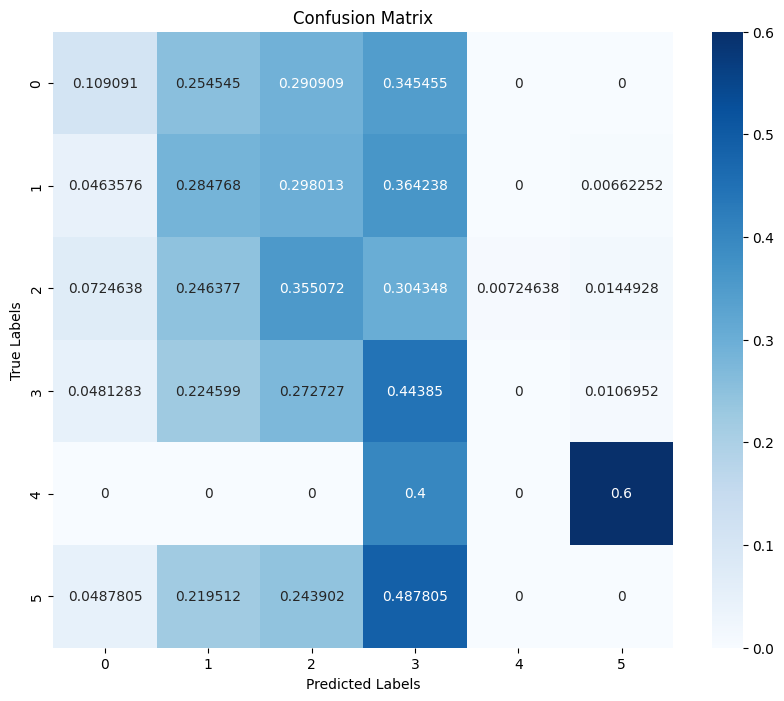

Epoch 4, Validation Loss: 2.5677, Accuracy: 0.3137, F1 Score: 0.2974
Val F1 Score Per Class  [0.13483146 0.29351536 0.3171521  0.40686275 0.         0.        ]


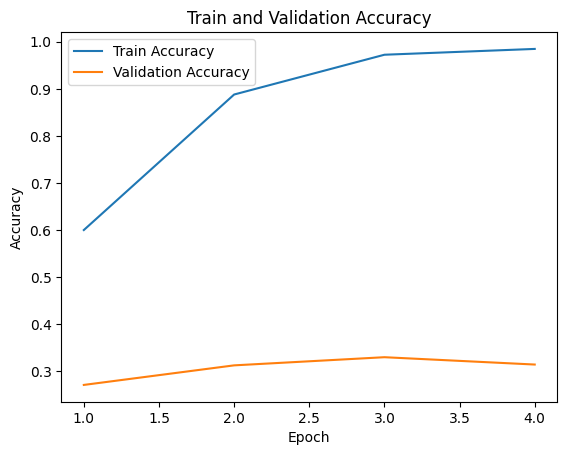

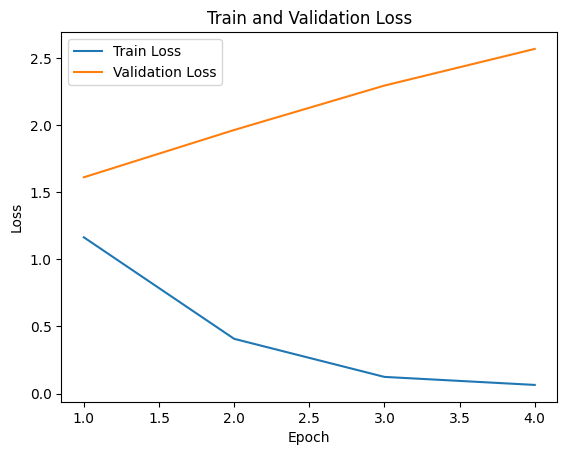

Epoch 5, Train Loss: 0.0531, Accuracy: 0.9862, F1 Score: 0.9862
Train F1 Score Per Class  [0.99004975 0.98105939 0.9774392  0.9739182  0.99911739 0.99484692]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=4.04]

[tensor([-2.2072,  3.0873, -1.4313,  1.0196, -1.9133, -2.4939], device='cuda:0'), tensor([-1.8783,  2.4173,  0.5531, -1.3122, -3.2512, -2.5735], device='cuda:0'), tensor([-2.1298,  1.3450,  0.8951,  1.0966, -3.3006, -3.1115], device='cuda:0'), tensor([-1.6630, -0.1040, -2.2017,  2.4183, -2.3003, -1.9778], device='cuda:0'), tensor([-1.7006, -1.3248, -0.2799,  4.3279, -2.4919, -1.8309], device='cuda:0'), tensor([-2.4091, -0.5161, -0.8998,  3.7849, -2.7962, -2.5171], device='cuda:0'), tensor([-1.2290, -0.9130, -2.3057,  2.9370, -1.9799, -0.3761], device='cuda:0'), tensor([-1.5071, -1.4364,  5.0352, -0.3815, -1.8838, -1.5351], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.10it/s, loss=2.56]

[tensor([-0.4944, -1.1847, -1.1592,  0.5689, -3.3805, -1.3499], device='cuda:0'), tensor([-2.4435, -1.5059, -1.7451, -0.9580, -1.8961, -0.3702], device='cuda:0'), tensor([ 0.1378, -2.3474,  2.8142,  0.1977, -2.0768, -2.2951], device='cuda:0'), tensor([-1.3423, -0.9931, -0.5359,  3.7347, -2.2569, -1.5834], device='cuda:0'), tensor([-1.1946,  4.8226, -1.2601, -0.8913, -2.4898, -1.4192], device='cuda:0'), tensor([-2.3839,  2.7447, -0.1149,  0.0121, -2.8021, -2.8762], device='cuda:0'), tensor([ 1.3583, -2.5208, -0.9025,  2.2618, -2.4384, -1.7665], device='cuda:0'), tensor([ 2.8248, -1.2457, -0.9272,  0.1582, -3.2391, -2.0081], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.14it/s, loss=3.16]

[tensor([-2.1385,  2.9337, -0.5292, -0.2220, -2.6362, -3.1949], device='cuda:0'), tensor([-1.4022,  3.8685, -0.6216, -1.1507, -1.9406, -1.9532], device='cuda:0'), tensor([-1.5216, -1.9520,  4.7192,  0.0883, -2.0167, -1.5442], device='cuda:0'), tensor([-1.1798, -2.3710,  2.3710,  0.5067, -2.8315, -2.1904], device='cuda:0'), tensor([-1.6230,  3.7369, -1.3043,  0.4614, -2.3616, -2.6777], device='cuda:0'), tensor([-0.5349, -0.5481, -1.4637,  4.0906, -3.3293, -2.6866], device='cuda:0'), tensor([-0.5775, -2.3255,  0.0283,  0.4393, -2.3221, -2.3313], device='cuda:0'), tensor([ 0.2828, -2.0765, -0.9679,  1.2184, -2.6207, -2.7323], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.15it/s, loss=2.34]

[tensor([-1.8124, -1.7758,  1.8293,  3.2106, -2.3837, -2.0915], device='cuda:0'), tensor([-3.3351,  0.6615,  2.2320, -1.0898, -3.1356, -0.9069], device='cuda:0'), tensor([-1.3022, -0.9774, -1.9703,  0.0351, -2.8052,  1.2199], device='cuda:0'), tensor([-1.7389,  0.0159,  1.0222,  0.3216, -2.3454, -2.6708], device='cuda:0'), tensor([ 1.8844, -1.4362,  0.4431,  0.9042, -2.8405, -3.2453], device='cuda:0'), tensor([-1.2809, -1.0836, -1.3872,  1.6009, -3.4828, -1.4734], device='cuda:0'), tensor([-1.8447,  0.9385, -1.0199,  0.1688, -3.1489, -2.2860], device='cuda:0'), tensor([-2.4751, -0.6968,  0.2982, -0.5933, -1.8475,  0.2377], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=3.24]

[tensor([-1.6658, -2.3778, -0.7866,  3.3966, -2.4608, -1.1116], device='cuda:0'), tensor([-2.4232, -1.1312,  0.8923,  2.9715, -3.2829, -2.3168], device='cuda:0'), tensor([-1.3887, -1.1865,  4.8773, -1.0731, -2.1082, -2.1559], device='cuda:0'), tensor([-2.1983, -0.2118, -1.3109,  0.9788, -2.7017, -2.2097], device='cuda:0'), tensor([-1.8060, -1.9128,  2.9567,  1.6757, -2.7736, -2.1375], device='cuda:0'), tensor([-1.5847, -1.3448, -1.0392,  3.6838, -3.6382, -1.6700], device='cuda:0'), tensor([-2.3539,  0.2868, -1.8652, -0.8064, -3.1303,  0.1107], device='cuda:0'), tensor([-0.7501,  0.3079, -2.0266,  1.8061, -2.4488, -0.7037], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=3.82]

[tensor([-1.9062, -1.6113,  4.3322,  0.5634, -2.4308, -2.4674], device='cuda:0'), tensor([-1.6956, -0.0481,  4.5369, -1.7916, -2.0463, -2.1154], device='cuda:0'), tensor([-1.6700, -0.0717,  2.4383,  0.6032, -3.1556, -3.3609], device='cuda:0'), tensor([-1.8437, -0.2076, -0.9955,  4.0131, -2.0939, -2.6017], device='cuda:0'), tensor([-1.7454, -1.7136,  1.4191,  3.6516, -2.5764, -2.7443], device='cuda:0'), tensor([-2.0138, -2.0156,  0.3765,  1.7394, -2.4514, -1.3612], device='cuda:0'), tensor([-1.2944, -2.1070,  4.3650,  1.1014, -2.1189, -2.0879], device='cuda:0'), tensor([ 0.0156, -2.1215, -0.3910,  0.8782, -2.5417, -1.8376], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=1.86]

[tensor([-0.4218, -0.1863,  0.2700, -1.0463, -1.9268, -0.9355], device='cuda:0'), tensor([-1.4576, -1.9497,  0.7651, -0.1919, -1.9476, -1.5068], device='cuda:0'), tensor([-1.1223, -1.7250,  2.4200,  2.0558, -2.2809, -2.7692], device='cuda:0'), tensor([-1.9924, -2.0769,  1.5641,  1.2811, -2.9281, -2.0375], device='cuda:0'), tensor([-2.6645,  0.7384,  0.9125, -0.4700, -2.6622, -3.1574], device='cuda:0'), tensor([-2.4264,  0.4211,  0.0790, -0.4985, -2.4381, -2.3247], device='cuda:0'), tensor([-1.8566, -2.4335,  1.7506, -0.0263, -2.2919, -0.8301], device='cuda:0'), tensor([-0.6024, -0.0245, -1.5557,  2.1360, -3.2513, -1.6438], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=4.02]

[tensor([-1.5808, -2.0554,  1.5119,  0.9688, -2.3532, -1.4227], device='cuda:0'), tensor([-1.5710, -1.6902,  3.4914,  0.3095, -2.2057, -1.6954], device='cuda:0'), tensor([-1.3057, -0.7565, -2.0067,  4.2746, -2.7340, -1.5508], device='cuda:0'), tensor([-1.1922,  4.6693, -1.3372, -0.5943, -1.9002, -2.3773], device='cuda:0'), tensor([-1.7404, -0.4849,  4.8025, -0.7372, -1.8491, -2.0335], device='cuda:0'), tensor([-0.2990, -0.4611, -1.4416,  1.0356, -2.4401, -2.6909], device='cuda:0'), tensor([-1.4431, -2.4516, -0.8989,  0.6058, -2.9419,  0.4759], device='cuda:0'), tensor([-1.7707, -0.9839,  4.6726, -0.5291, -1.8937, -1.6377], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.15it/s, loss=3.55]

[tensor([-1.2564, -0.4422, -1.0699, -0.3871, -3.5885, -1.6884], device='cuda:0'), tensor([-2.4634,  0.8029,  0.2263, -0.3126, -3.1541, -2.8242], device='cuda:0'), tensor([-0.6318,  1.7339, -1.2525,  1.7301, -1.3443, -2.5894], device='cuda:0'), tensor([-0.9012, -1.4881,  4.5639, -0.6087, -1.8573, -1.7952], device='cuda:0'), tensor([-0.2661, -1.4797, -1.1575,  2.9325, -1.5551, -1.8335], device='cuda:0'), tensor([-2.3607,  0.6672, -0.6408,  1.1344, -2.3848, -3.0205], device='cuda:0'), tensor([-1.3439, -0.2704, -2.1273,  1.7077, -3.1456, -1.8747], device='cuda:0'), tensor([-1.7849, -1.9602, -1.0206,  1.3780, -3.2433, -1.9047], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=2.57]

[tensor([-2.2580,  2.9715,  2.0563, -1.6503, -2.0707, -2.4089], device='cuda:0'), tensor([-1.8838, -1.7676, -0.4696,  0.9491, -2.1506, -2.3268], device='cuda:0'), tensor([ 4.8215, -0.4591, -1.5305, -1.3480, -1.8824, -1.3562], device='cuda:0'), tensor([-2.0994, -1.6740,  1.5397,  1.4590, -2.6988, -2.7571], device='cuda:0'), tensor([-2.0933,  2.8235, -0.6783,  0.1649, -2.2748, -2.4805], device='cuda:0'), tensor([ 1.9406, -1.8209,  0.8455,  1.3269, -2.8151, -3.2245], device='cuda:0'), tensor([-1.8766,  1.3027, -2.5904, -0.0946, -2.0688, -2.5247], device='cuda:0'), tensor([-1.7041,  1.4491, -1.4897,  2.9352, -3.0866, -3.2620], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.17it/s, loss=2.12]

[tensor([-2.9062,  0.5384, -0.7342,  1.4590, -2.3004, -2.2971], device='cuda:0'), tensor([ 0.8950,  2.0041, -1.2807, -0.2806, -3.1819, -2.5134], device='cuda:0'), tensor([-1.7025, -1.8892,  1.3414,  3.3972, -2.9676, -1.6379], device='cuda:0'), tensor([-1.8869,  0.2078, -0.0192,  2.7247, -3.4759, -2.6331], device='cuda:0'), tensor([-2.8952,  3.5386, -1.4795, -0.2944, -3.1533, -1.0381], device='cuda:0'), tensor([ 1.8567, -1.6647, -1.8096,  0.5966, -2.1371, -1.3833], device='cuda:0'), tensor([-2.9758,  0.8992,  1.1636, -0.7111, -2.6159, -2.0759], device='cuda:0'), tensor([ 2.7719, -0.6953, -2.0849,  0.1317, -2.6213, -2.5835], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=2.66]

[tensor([-1.9101, -1.9328,  4.0370, -0.7808, -2.0520, -1.7653], device='cuda:0'), tensor([-1.4322, -0.7108, -0.0748, -0.2140, -2.5662, -2.5385], device='cuda:0'), tensor([-1.9667, -0.0539,  4.5580, -0.4613, -2.1446, -2.5235], device='cuda:0'), tensor([-1.9715,  1.2489, -1.8414,  2.2084, -3.0525, -3.3166], device='cuda:0'), tensor([-0.2206, -1.0186, -0.9798,  1.7222, -2.6744, -3.4749], device='cuda:0'), tensor([-1.7752, -1.2731,  4.4275,  0.5272, -2.5410, -2.4140], device='cuda:0'), tensor([-1.4445,  0.3305, -2.0846,  0.2594, -2.0495, -0.9712], device='cuda:0'), tensor([-1.7458, -0.3111,  2.5031, -0.2583, -2.8656, -2.6058], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.12it/s, loss=2.31]

[tensor([-0.9851, -2.3900,  1.2906,  3.4830, -2.5808, -2.4251], device='cuda:0'), tensor([-2.1098, -0.6540, -0.5107,  3.8188, -2.0381, -1.9931], device='cuda:0'), tensor([-2.2985,  2.9742,  0.2048, -0.1590, -3.3768, -2.7089], device='cuda:0'), tensor([-2.6879,  0.1723,  0.7105, -1.0640, -3.0954, -2.0102], device='cuda:0'), tensor([-2.0074,  2.7512, -2.7020, -0.3649, -1.6749, -0.0591], device='cuda:0'), tensor([-1.8406, -1.2731, -0.5595,  1.3918, -2.5088, -1.6824], device='cuda:0'), tensor([-2.2383,  1.5453, -1.9745, -0.7502, -3.2765, -1.5338], device='cuda:0'), tensor([-1.8854,  4.4502, -0.6881, -1.1354, -2.2950, -2.2832], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.13it/s, loss=2.37]

[tensor([-1.1647, -1.5276, -1.5966, -0.6723, -2.5701, -1.9359], device='cuda:0'), tensor([-2.1828,  0.0298, -0.5947,  1.6685, -2.9964, -2.6715], device='cuda:0'), tensor([-1.7727, -2.2366, -0.8170,  0.0260, -1.7728,  4.3802], device='cuda:0'), tensor([-1.7018, -0.4390,  2.1294,  0.2892, -2.6728, -2.4179], device='cuda:0'), tensor([-1.9703, -1.1799, -1.6193,  4.4584, -1.5249, -1.3857], device='cuda:0'), tensor([-2.0450,  0.0764, -2.1576,  3.6546, -2.2919, -0.9719], device='cuda:0'), tensor([-0.3783, -2.0262, -0.2288,  0.7713, -2.8127, -0.9536], device='cuda:0'), tensor([-1.3203, -0.5779, -1.9558,  3.7140, -2.4799, -1.6291], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.13it/s, loss=3.22]

[tensor([-2.2741,  1.9657, -1.6730,  0.6330, -2.6076, -1.7382], device='cuda:0'), tensor([-1.7442,  0.3332, -1.2930, -0.2357, -2.1717, -1.7172], device='cuda:0'), tensor([-1.6155, -0.6645,  3.8780, -0.8157, -2.2030, -1.7253], device='cuda:0'), tensor([-1.3725, -1.9283, -0.6260,  4.2186, -2.7661, -1.8843], device='cuda:0'), tensor([-1.5310,  0.3785, -1.5299,  4.1851, -2.4466, -2.6571], device='cuda:0'), tensor([-2.0634,  1.9032, -0.0965, -0.7592, -2.6885, -3.0504], device='cuda:0'), tensor([-2.2809, -0.8835,  1.3538, -0.3863, -3.0893, -2.0774], device='cuda:0'), tensor([-2.0763,  0.2342,  3.7735, -1.0864, -2.3713, -2.2665], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.13it/s, loss=2.16]

[tensor([-1.1673, -1.1846, -1.4876,  4.9557, -2.3794, -1.4994], device='cuda:0'), tensor([-2.8266,  1.4101,  1.2655, -0.9513, -2.6998, -2.2987], device='cuda:0'), tensor([-1.7885, -1.0576, -0.7058,  4.4693, -2.2955, -2.6768], device='cuda:0'), tensor([-2.7793,  1.1250, -0.4638, -0.0140, -3.0747, -1.1150], device='cuda:0'), tensor([-1.7448, -2.1689, -0.8277,  0.7260, -2.4301, -2.2164], device='cuda:0'), tensor([-2.6838, -2.0202,  1.0889,  2.6593, -2.0291, -1.3177], device='cuda:0'), tensor([-1.2509, -1.5856, -1.1785,  3.0432, -3.6901, -1.3521], device='cuda:0'), tensor([-1.8337, -2.1304,  2.5557, -1.0915, -2.2476, -0.9485], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=2.29]

[tensor([-1.9991, -1.5015, -0.2197, -0.1128, -3.7572, -2.6693], device='cuda:0'), tensor([-1.2224,  1.2802,  0.4090, -0.3910, -2.4803, -2.0865], device='cuda:0'), tensor([-1.5121, -0.4456,  2.1492, -1.2922, -3.1105, -2.6787], device='cuda:0'), tensor([-1.5185, -0.1228, -0.3041,  0.6523, -2.5379, -2.7690], device='cuda:0'), tensor([-1.6485, -2.8060, -0.3181,  0.1085, -1.9544,  1.0502], device='cuda:0'), tensor([-1.1653, -2.2231, -0.7687,  2.2148, -2.5926, -2.2641], device='cuda:0'), tensor([ 4.0843, -1.9644,  0.0292, -1.1452, -2.1280, -1.2858], device='cuda:0'), tensor([-2.1276,  1.3667, -1.4361, -0.1091, -2.6446, -2.3435], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=2.51]

[tensor([-1.9658, -1.8452,  2.7085,  1.5353, -2.5875, -2.5967], device='cuda:0'), tensor([ 1.0528, -2.1448,  0.3428,  1.8188, -1.4983, -2.8572], device='cuda:0'), tensor([-2.6285, -1.4005, -0.4270,  0.0387, -2.8668, -1.3579], device='cuda:0'), tensor([-1.5272,  2.8296, -0.0598, -1.1957, -2.1778, -2.7350], device='cuda:0'), tensor([-2.1835, -1.4713,  0.4259,  1.2514, -1.1264, -1.6407], device='cuda:0'), tensor([ 2.7112, -1.0648, -1.8239, -1.0879, -2.2059,  0.0361], device='cuda:0'), tensor([-0.9728,  2.8861, -1.0004, -1.1201, -2.4850, -2.2006], device='cuda:0'), tensor([-2.8523,  1.9719, -0.0764,  1.8286, -2.3750, -2.5388], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.15it/s, loss=1.95]

[tensor([-2.8790, -1.4192,  2.6237,  0.5489, -2.0638, -1.7025], device='cuda:0'), tensor([ 3.7744, -2.1766, -1.3803, -0.5021, -2.3266, -1.4128], device='cuda:0'), tensor([-1.4411, -1.1535,  4.2364,  0.3308, -1.8099, -2.1578], device='cuda:0'), tensor([-1.6694, -1.2055, -0.8911,  4.1705, -1.8396, -2.2828], device='cuda:0'), tensor([-1.9107, -0.3762,  1.0286,  1.0985, -3.4991, -3.1613], device='cuda:0'), tensor([-0.5072, -1.6509, -1.5123,  4.5535, -2.3113, -2.3518], device='cuda:0'), tensor([-1.5988,  0.3145, -1.3008,  2.8138, -3.1444, -1.9138], device='cuda:0'), tensor([-0.9586, -0.7146,  0.9416, -0.6934, -2.5018, -2.3985], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=3.18]

[tensor([-1.9093, -1.5619,  0.3566,  3.2448, -2.4964, -2.2004], device='cuda:0'), tensor([-2.5281, -1.1092, -2.3108, -0.1883, -1.4297,  1.3664], device='cuda:0'), tensor([-1.3475, -1.8857, -0.5255,  1.3657, -2.7917, -0.7120], device='cuda:0'), tensor([ 1.2234, -2.6658,  2.0092, -0.4860, -2.5181, -2.2607], device='cuda:0'), tensor([-1.2472,  0.0427, -0.2566, -0.7162, -3.7405, -2.6839], device='cuda:0'), tensor([-1.6853,  4.0006, -0.9743, -1.2621, -2.4053, -1.4575], device='cuda:0'), tensor([-7.0408e-01, -1.4332e+00, -4.3968e-04,  1.4999e-01, -3.3553e+00,
        -1.9302e+00], device='cuda:0'), tensor([-1.8134, -0.3002, -0.0369,  1.9834, -2.8282, -3.2264], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.17it/s, loss=3.18]

[tensor([-1.1375, -2.1032,  3.5144,  0.4805, -2.4637, -1.5312], device='cuda:0'), tensor([-2.0747,  0.7525, -1.5507,  0.4844, -3.1453, -1.7953], device='cuda:0'), tensor([-2.0490, -0.0669,  3.0504,  0.1736, -3.2619, -2.4248], device='cuda:0'), tensor([-2.3643, -0.6334,  2.3999,  1.0245, -3.0003, -2.9906], device='cuda:0'), tensor([-1.6669, -0.7621,  3.9328,  0.1411, -2.6183, -2.7306], device='cuda:0'), tensor([-2.2348, -1.4026,  0.8783, -0.3964, -2.5711, -1.6945], device='cuda:0'), tensor([-1.7839, -1.6446, -1.2362,  4.7120, -1.8340, -1.6609], device='cuda:0'), tensor([-1.0389, -1.0923, -1.2820,  4.0510, -1.4254, -1.4517], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.18it/s, loss=1.89]

[tensor([-1.4791, -0.1212, -2.1308,  3.9138, -2.9957, -2.0224], device='cuda:0'), tensor([-1.5718, -1.3282, -0.7911,  3.3941, -2.0075, -2.2682], device='cuda:0'), tensor([-2.1860, -1.5803,  4.0088,  0.0273, -1.8859, -1.4860], device='cuda:0'), tensor([-1.3711, -2.0781, -2.2236,  1.2403, -1.5710,  0.4028], device='cuda:0'), tensor([-1.4088, -1.4116,  0.8515,  3.0728, -2.6086, -2.8142], device='cuda:0'), tensor([ 0.4210, -2.4559,  3.8948,  0.3837, -1.9631, -2.6897], device='cuda:0'), tensor([-1.4705,  1.5763, -1.8036, -0.2891, -3.4729, -1.4642], device='cuda:0'), tensor([-2.2165, -1.8790, -0.1556,  1.9892, -2.0753, -2.0766], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.17it/s, loss=2.67]

[tensor([-2.2685,  0.2464, -1.0285,  2.3069, -2.2696, -2.8420], device='cuda:0'), tensor([-2.0356, -1.5284, -0.4841,  2.0235, -2.7705, -1.8862], device='cuda:0'), tensor([-2.0199,  0.4245, -2.0499,  2.9214, -1.7661, -2.3178], device='cuda:0'), tensor([-1.7990, -1.8714, -1.9539,  1.7591, -3.5710, -1.0286], device='cuda:0'), tensor([-1.7717, -0.3460, -1.0053,  3.5768, -2.8049, -2.4593], device='cuda:0'), tensor([-1.2961, -1.2656, -1.6339,  4.8899, -2.0158, -1.7436], device='cuda:0'), tensor([-1.7778, -2.1840,  3.4795,  0.6960, -2.0288, -2.1016], device='cuda:0'), tensor([-2.8519, -1.6592,  4.2317, -0.8583, -2.1418, -1.7254], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.17it/s, loss=1.98]

[tensor([ 0.7881, -1.4760, -2.2408,  0.6109, -2.4377, -1.8202], device='cuda:0'), tensor([-1.9601, -0.3576, -1.4262,  0.5047, -2.3200, -0.7199], device='cuda:0'), tensor([-1.2463, -1.3135, -1.0238,  4.7237, -2.3373, -2.5587], device='cuda:0'), tensor([-0.7694, -1.8055,  3.7138, -0.8019, -1.9617, -2.4453], device='cuda:0'), tensor([-3.0939,  0.6475,  2.1725, -0.4906, -2.1998, -2.6578], device='cuda:0'), tensor([-2.0717, -1.3903,  1.2664,  2.7270, -2.0916, -2.6918], device='cuda:0'), tensor([-2.2110,  0.2628, -1.8812,  2.5746, -1.9048, -2.2445], device='cuda:0'), tensor([-1.0149,  3.8384, -1.3781, -0.4371, -3.0359, -1.6880], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.16it/s, loss=3.04]

[tensor([-1.4970, -0.8296, -0.5486,  3.8996, -3.1212, -1.4480], device='cuda:0'), tensor([-1.6960,  0.7611, -0.6366,  2.5074, -3.2452, -1.5122], device='cuda:0'), tensor([-2.0837,  1.7882,  0.6504, -0.7377, -3.4319, -2.8344], device='cuda:0'), tensor([-1.8784, -1.6846,  3.9887,  1.1260, -2.6469, -2.3323], device='cuda:0'), tensor([-1.5953, -0.4044, -0.3812,  1.2995, -3.4107, -2.4554], device='cuda:0'), tensor([-1.7310,  3.3671, -1.1308, -2.4071, -2.2849,  0.0526], device='cuda:0'), tensor([-1.5005,  4.4471, -1.9715, -1.3673, -3.0139, -1.4937], device='cuda:0'), tensor([-1.8255,  1.6460, -2.7932, -0.5459, -2.6673, -0.6891], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.16it/s, loss=2.91]

[tensor([-1.8207,  2.7809, -1.7208,  0.6479, -2.9890, -1.4056], device='cuda:0'), tensor([-2.4877, -0.2744, -0.3004, -1.5455, -2.6940, -0.0261], device='cuda:0'), tensor([-2.4437, -0.2571,  3.5013,  0.9575, -2.8421, -2.8859], device='cuda:0'), tensor([-2.2252,  2.5421,  1.8007, -0.9348, -2.5889, -2.8091], device='cuda:0'), tensor([-1.9726,  4.0042, -0.9460,  0.1784, -3.0808, -2.6811], device='cuda:0'), tensor([-2.4450, -1.0234,  0.8354,  1.9111, -1.9068, -1.8520], device='cuda:0'), tensor([-1.5110, -1.6985,  1.2777,  0.5822, -2.6090, -2.5115], device='cuda:0'), tensor([ 2.1591, -3.0578, -0.1996,  1.0332, -1.8039, -0.4983], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=2.65]

[tensor([-2.4948, -1.2759, -1.5233,  0.3259, -1.1675,  1.3222], device='cuda:0'), tensor([-2.1719,  0.3170,  2.4616, -0.9416, -2.4612, -2.6318], device='cuda:0'), tensor([-1.2037, -1.8342,  0.5840,  1.4926, -2.6475, -1.7704], device='cuda:0'), tensor([-1.9759, -0.8602, -0.5901,  3.6719, -1.8409, -2.1860], device='cuda:0'), tensor([-0.9310, -1.0116, -1.5748,  3.6622, -2.1497, -2.2768], device='cuda:0'), tensor([-2.6292,  0.7577, -1.1232,  2.5430, -2.7459, -2.7245], device='cuda:0'), tensor([-2.6361, -1.0430,  1.6439, -1.0474, -3.0325, -1.5613], device='cuda:0'), tensor([-1.8164,  4.5646, -1.2822, -0.5886, -2.3804, -1.4786], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.16it/s, loss=2.55]

[tensor([-0.5562, -1.6015,  2.6061,  0.8800, -2.5500, -2.4281], device='cuda:0'), tensor([-1.8396, -1.3469,  0.2650,  3.1280, -2.6928, -2.5310], device='cuda:0'), tensor([-2.2286, -0.0217,  0.7921, -0.0648, -3.0107, -2.7217], device='cuda:0'), tensor([-1.2004, -2.0224,  3.4388, -0.2408, -2.2204, -1.7027], device='cuda:0'), tensor([-2.6840,  1.1258,  2.9719, -1.1489, -2.2221, -1.8987], device='cuda:0'), tensor([-2.3678, -1.0597,  3.0833, -0.9648, -2.2597, -1.4851], device='cuda:0'), tensor([-1.4073, -1.0513,  1.2462,  2.0070, -2.9695, -1.7976], device='cuda:0'), tensor([-1.2319, -1.5310,  4.4608, -0.4621, -2.0056, -1.9197], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.16it/s, loss=2.8]

[tensor([ 3.8959, -1.4584, -0.7675, -1.3274, -2.3204, -0.9253], device='cuda:0'), tensor([-2.7228, -0.5808,  1.4324, -0.3776, -2.6282, -2.1948], device='cuda:0'), tensor([-0.9433, -0.6958, -1.6523,  4.3382, -2.2587, -2.6529], device='cuda:0'), tensor([-0.8267, -0.2744,  2.8898, -0.4877, -2.0995, -1.9324], device='cuda:0'), tensor([-1.9173,  1.7896,  1.5548, -0.2054, -2.6145, -2.7828], device='cuda:0'), tensor([-2.0070, -1.8376,  0.8972,  1.8245, -2.9595, -1.8515], device='cuda:0'), tensor([-1.7926, -1.7178,  0.7094,  2.8916, -2.6378, -2.0256], device='cuda:0'), tensor([-3.0694,  2.7741, -0.7215, -0.5260, -2.3272, -1.6887], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=3.89]

[tensor([-2.1029,  2.7350, -1.1912, -0.1537, -2.6650, -2.0562], device='cuda:0'), tensor([-1.8636, -1.5833,  3.1226,  1.7434, -2.3843, -2.0326], device='cuda:0'), tensor([-2.1340,  2.5986, -1.7509, -0.7029, -3.3576, -0.3491], device='cuda:0'), tensor([-2.6584, -0.3032, -0.8081,  1.8259, -1.9861,  0.8854], device='cuda:0'), tensor([-2.4376, -1.6298, -0.1789,  3.1078, -1.9513, -1.9021], device='cuda:0'), tensor([-0.8044, -2.2496,  4.4222, -0.8339, -1.6860, -2.1144], device='cuda:0'), tensor([-0.6835, -1.7847, -1.0039,  2.7238, -1.5856,  0.0487], device='cuda:0'), tensor([-0.2696, -1.5522, -1.3389,  2.3508, -2.5367, -1.9944], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.16it/s, loss=2.71]

[tensor([-1.6194, -2.3705,  3.1021,  0.3682, -2.5967, -1.4883], device='cuda:0'), tensor([-0.8978, -2.4870, -0.8809,  4.2488, -2.5950, -1.7524], device='cuda:0'), tensor([-1.3709, -2.2406,  0.7547,  3.6368, -2.7555, -1.8953], device='cuda:0'), tensor([-1.1783, -1.0867,  2.3734,  0.8129, -3.1178, -3.1583], device='cuda:0'), tensor([-1.6438, -0.4881,  0.5734, -1.0115, -2.6418, -2.7244], device='cuda:0'), tensor([-1.1073, -2.2792, -2.0972,  0.5147, -0.9502,  3.8817], device='cuda:0'), tensor([-0.7349,  3.9419, -1.9279, -0.1691, -2.4442, -1.9975], device='cuda:0'), tensor([-2.1852,  0.5730, -0.7299,  2.3388, -2.9722, -3.4629], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.17it/s, loss=1.32]

[tensor([-2.2944,  2.0642,  0.8399, -0.5820, -2.9484, -2.3546], device='cuda:0'), tensor([-1.3250, -0.3521,  1.7285,  1.0342, -3.0489, -3.0234], device='cuda:0'), tensor([-2.4339,  1.6532,  0.1125,  0.1442, -3.0004, -2.9767], device='cuda:0'), tensor([-2.4406, -0.8005, -0.1120,  0.3040, -2.0364, -2.0094], device='cuda:0'), tensor([-2.1813, -2.2721,  2.2079, -0.7647, -2.1902, -1.0281], device='cuda:0'), tensor([-0.4135, -0.2043, -2.6989,  0.8674, -2.1175, -1.3931], device='cuda:0'), tensor([-1.5994, -1.9472, -1.4781,  0.1494, -2.6423,  3.2395], device='cuda:0'), tensor([-0.9003, -1.7558, -1.0140,  2.1251, -1.3375, -2.3144], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.17it/s, loss=2.88]

[tensor([-1.8472, -1.2283,  0.9927,  1.2617, -3.0889, -2.8266], device='cuda:0'), tensor([-1.6146,  0.3114, -2.4318,  0.8263, -1.9017, -2.3177], device='cuda:0'), tensor([-2.2506,  2.4032, -0.1829, -0.6135, -2.8339, -2.8908], device='cuda:0'), tensor([ 1.5938, -1.1660, -1.3071,  0.7084, -2.4491, -1.0139], device='cuda:0'), tensor([-1.6051,  2.5877, -1.3290,  0.3225, -2.1772, -2.5032], device='cuda:0'), tensor([-2.6037,  0.5411,  1.9364,  1.4108, -2.4165, -2.7793], device='cuda:0'), tensor([-2.5021, -0.8176,  0.5297,  0.2376, -2.8216, -2.2835], device='cuda:0'), tensor([ 0.8711, -2.4218,  1.0915,  1.4624, -3.1540, -2.1552], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.17it/s, loss=2.33]

[tensor([-2.0088, -0.9370,  2.7120,  0.9103, -3.3159, -2.9377], device='cuda:0'), tensor([-2.5322, -1.7180,  3.4288,  0.9133, -2.5071, -2.4671], device='cuda:0'), tensor([-0.8759, -1.1979,  4.8609, -0.8830, -1.9312, -2.1044], device='cuda:0'), tensor([ 0.9402, -2.0941,  0.4450, -0.3823, -3.0133, -1.6489], device='cuda:0'), tensor([ 0.2090, -1.5532, -0.8689,  1.7472, -2.5458, -2.9656], device='cuda:0'), tensor([-1.7749, -1.2255,  4.9563, -1.1995, -1.9484, -1.4081], device='cuda:0'), tensor([-0.6770, -2.3795,  1.5368,  2.1411, -2.8560, -1.9807], device='cuda:0'), tensor([-2.0852, -0.6094,  2.2248, -0.3810, -3.0266, -2.7594], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.17it/s, loss=2.65]

[tensor([-2.4568, -0.9312, -1.3560,  3.1524, -2.6480, -3.0436], device='cuda:0'), tensor([-2.0112, -0.5879,  4.5005, -1.6128, -1.8711, -1.0224], device='cuda:0'), tensor([ 0.4637, -1.4266, -1.7748,  2.7086, -3.1351, -2.3054], device='cuda:0'), tensor([-0.3457, -2.3360,  3.7534, -0.6067, -2.2237, -1.8590], device='cuda:0'), tensor([-0.7488,  0.1362,  0.9714, -0.6741, -2.2872, -1.0578], device='cuda:0'), tensor([-1.0936, -1.8858, -0.3263,  3.8888, -2.2841, -1.4352], device='cuda:0'), tensor([ 0.4990, -2.5869,  0.6231,  1.7145, -2.6957, -2.4749], device='cuda:0'), tensor([-1.7255,  4.2686, -0.3767, -0.9443, -1.7157, -1.7239], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.16it/s, loss=2.33]

[tensor([-2.6909, -1.4165, -0.4300,  0.7587, -2.6753, -1.8282], device='cuda:0'), tensor([ 5.2514, -1.5996, -0.5167, -0.8971, -1.7636, -1.7768], device='cuda:0'), tensor([-1.9568, -1.1090, -1.4847,  4.5751, -1.7124, -1.7206], device='cuda:0'), tensor([-2.1920,  3.0826,  1.6597, -0.6298, -2.3688, -2.5495], device='cuda:0'), tensor([-1.2343, -2.5379,  0.6504,  1.2908, -2.8897, -3.3049], device='cuda:0'), tensor([-2.1270,  4.1386,  0.0497, -0.3238, -1.9142, -2.8678], device='cuda:0'), tensor([-2.7853,  2.2181, -0.1530, -0.5760, -3.5760, -0.8294], device='cuda:0'), tensor([-1.6439, -0.6153,  1.0694, -1.1037, -2.2111, -2.6999], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.16it/s, loss=3.79]

[tensor([-2.3219, -0.8779, -1.2259,  3.6232, -2.2268, -1.0997], device='cuda:0'), tensor([-2.8347,  1.8533, -1.4335,  0.2160, -2.3314, -2.1154], device='cuda:0'), tensor([ 3.3322, -1.8572, -1.7571,  1.2173, -1.7926, -1.5072], device='cuda:0'), tensor([-1.9698, -0.3924,  4.9231, -0.7638, -2.1269, -2.4255], device='cuda:0'), tensor([-2.0539, -0.9976, -0.8862,  2.3771, -2.5603, -2.5187], device='cuda:0'), tensor([-2.0706,  1.5000, -0.8546,  0.2210, -2.5422, -2.2579], device='cuda:0'), tensor([-2.0504,  2.4094,  1.1278, -1.3703, -2.4187, -2.3010], device='cuda:0'), tensor([-2.4983,  0.3218,  0.3464,  1.6465, -2.9220, -3.5266], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.16it/s, loss=2.99]

[tensor([-2.5699, -0.4267, -2.2287,  2.1174, -1.9660,  0.3611], device='cuda:0'), tensor([-2.1102, -0.7364,  0.9993,  2.1422, -1.6692, -2.3765], device='cuda:0'), tensor([-2.0930,  0.7702,  0.9620, -0.1703, -2.4585, -2.6108], device='cuda:0'), tensor([-1.9637, -1.6154,  4.5459, -0.8707, -2.1427, -1.7594], device='cuda:0'), tensor([-1.3544, -1.0717,  4.9065, -0.9773, -1.8447, -1.0921], device='cuda:0'), tensor([-0.9977, -1.3710, -0.7509,  3.8180, -2.5923, -2.3612], device='cuda:0'), tensor([-1.6473, -0.3554, -2.0780,  2.0668, -1.9629,  0.4334], device='cuda:0'), tensor([-1.6861,  4.6024, -0.8116, -0.9044, -2.0852, -2.4257], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=2.65]

[tensor([-1.7258, -0.3546,  0.1408,  3.6932, -3.3495, -2.7275], device='cuda:0'), tensor([-1.4922, -1.4152, -2.3338,  0.8551, -1.2194,  2.0703], device='cuda:0'), tensor([ 4.2824, -0.6445, -1.7684, -0.5876, -2.0287, -2.0659], device='cuda:0'), tensor([-2.3563,  2.0086, -1.6356,  1.1412, -3.3291, -2.5832], device='cuda:0'), tensor([-0.9870, -0.9850,  0.5852,  1.8395, -2.8126, -3.4573], device='cuda:0'), tensor([-0.8787, -2.2389,  4.4957, -0.2177, -1.8820, -1.6600], device='cuda:0'), tensor([-2.3350,  2.2690, -2.0295,  1.6455, -1.8715, -3.1109], device='cuda:0'), tensor([-2.1952, -1.6161,  0.6780,  3.6136, -2.4114, -1.9609], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=2.75]

[tensor([-2.2070,  3.1000, -1.2308,  0.8228, -2.1396, -3.2507], device='cuda:0'), tensor([-0.9940, -1.6885, -0.3237,  4.1887, -1.7694, -1.9154], device='cuda:0'), tensor([-2.3833,  1.6031,  2.3720, -1.1910, -2.9610, -2.0668], device='cuda:0'), tensor([-1.1586, -1.5936,  5.1014, -1.2956, -1.5891, -1.6369], device='cuda:0'), tensor([-1.4516,  3.6299, -1.8689,  0.3539, -1.3726, -2.3724], device='cuda:0'), tensor([-2.6485, -1.9462,  2.1985,  0.7256, -2.9423, -1.6169], device='cuda:0'), tensor([-2.0267, -1.7572,  0.0291,  3.5127, -2.9033, -1.9920], device='cuda:0'), tensor([ 0.0559, -1.7603,  1.5065,  0.9047, -0.5978, -2.1247], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.15it/s, loss=2.81]

[tensor([-1.1044, -1.8963, -1.2050,  4.5567, -1.9216, -2.3589], device='cuda:0'), tensor([-1.1868, -1.7065, -1.3990,  4.4959, -2.6678, -1.6282], device='cuda:0'), tensor([-2.0302,  1.4933, -1.8356,  1.8589, -3.1101, -2.4613], device='cuda:0'), tensor([ 0.1114, -0.3346, -2.3403,  0.7531, -1.4008,  0.0837], device='cuda:0'), tensor([-2.1539, -0.0252, -0.4193,  2.2541, -2.8662, -2.5174], device='cuda:0'), tensor([-1.8898, -1.6903,  3.7890,  0.6319, -2.0984, -2.3682], device='cuda:0'), tensor([-1.6011, -1.5728, -0.0207,  0.7628, -2.8012, -1.9232], device='cuda:0'), tensor([-0.6905, -1.7708,  4.4767, -0.5344, -2.2718, -1.6710], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.15it/s, loss=1.98]

[tensor([-2.2100, -0.9060,  0.4888, -0.8852, -3.0861,  1.2921], device='cuda:0'), tensor([-1.9017,  1.2968, -1.5823,  0.3258, -2.7251, -2.1107], device='cuda:0'), tensor([ 4.9383, -1.1055, -0.8471, -1.2050, -2.0045,  0.0750], device='cuda:0'), tensor([-2.1275,  1.4995, -1.0575,  0.5508, -1.4321, -2.2024], device='cuda:0'), tensor([-1.1218, -1.1775, -1.6391,  3.4431, -2.7751, -2.0311], device='cuda:0'), tensor([-0.4494, -0.3783, -0.8520,  2.9342, -2.2504, -2.8872], device='cuda:0'), tensor([-1.3046,  0.4554, -1.0930, -0.2101, -3.1106, -2.8948], device='cuda:0'), tensor([-1.6896, -1.5412,  3.1992, -0.7668, -2.6258, -2.4719], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:14,  2.14it/s, loss=2.23]

[tensor([-2.7071, -1.4156, -1.3908,  1.0339, -2.7657, -0.4219], device='cuda:0'), tensor([-2.2812,  0.6669, -0.7165, -1.5554, -2.3541, -1.2466], device='cuda:0'), tensor([-2.1722, -1.5495, -0.5759,  2.1404, -3.1077, -0.1866], device='cuda:0'), tensor([-0.9344, -1.5725, -0.4275,  4.7327, -2.7612, -2.1246], device='cuda:0'), tensor([-2.5651,  1.1244,  2.9491, -0.4854, -2.4278, -2.6360], device='cuda:0'), tensor([ 1.4093, -0.9561, -2.0026, -0.6117, -2.9073, -1.2914], device='cuda:0'), tensor([-1.0959, -2.5269,  0.7563,  3.8976, -2.5211, -2.3015], device='cuda:0'), tensor([-1.6636, -2.2110, -0.1871,  1.4290, -2.1179, -2.4978], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.14it/s, loss=2.74]

[tensor([-1.4748, -1.2563,  0.7470,  1.0214, -2.4887, -3.0417], device='cuda:0'), tensor([-0.4202, -2.0393,  3.3722, -0.6438, -1.5663, -1.6583], device='cuda:0'), tensor([-3.1878, -0.0830, -0.8956, -0.5270, -3.0275, -1.9115], device='cuda:0'), tensor([-2.7586,  0.0672, -1.1320,  0.3396, -2.8128, -0.3119], device='cuda:0'), tensor([-1.4800, -1.5168, -1.6329,  1.0414, -0.7141,  1.1313], device='cuda:0'), tensor([-3.3136,  0.7315, -0.1031,  1.2541, -2.8891, -2.3942], device='cuda:0'), tensor([-0.8482, -1.6579,  3.9869, -0.1409, -2.0846, -1.2718], device='cuda:0'), tensor([-0.4133,  2.4095,  1.0499, -2.2414, -2.3181, -0.6812], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.13it/s, loss=2.56]

[tensor([ 5.0419, -1.3071, -1.6459, -0.8271, -2.1922, -1.1342], device='cuda:0'), tensor([-2.1608, -1.7073, -0.8695,  2.5473, -1.6655, -0.3493], device='cuda:0'), tensor([-2.4734,  1.1086, -1.4252,  1.2854, -3.0871, -0.9930], device='cuda:0'), tensor([-2.0723, -0.2891,  0.5157, -1.0052, -2.1174, -2.7854], device='cuda:0'), tensor([-1.2812, -2.1200,  3.4616,  0.9548, -2.1366, -1.6604], device='cuda:0'), tensor([-1.2969, -2.0457, -2.0779,  1.0136, -2.4406,  4.3372], device='cuda:0'), tensor([-2.4271,  3.1926, -0.8361,  0.2901, -2.9758, -2.7362], device='cuda:0'), tensor([-2.6932,  0.1110, -1.6639, -0.3990, -2.6848, -0.0737], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.13it/s, loss=1.9]

[tensor([-1.6750, -1.8008,  2.5863,  0.8105, -2.7155, -2.7801], device='cuda:0'), tensor([-1.8318,  0.1560, -0.8701,  0.1757, -2.3182, -1.9074], device='cuda:0'), tensor([-2.2309, -0.3841,  0.2303,  1.5213, -2.3902, -2.9740], device='cuda:0'), tensor([-1.0267, -2.4529,  4.1851, -0.9229, -1.8648, -0.3867], device='cuda:0'), tensor([-2.6902,  0.2834, -2.3945,  0.2535, -2.4311,  0.4017], device='cuda:0'), tensor([-1.5394, -0.1867, -1.6896,  0.2661, -1.9003, -2.3051], device='cuda:0'), tensor([-1.8213, -1.1067,  2.0225,  1.4814, -2.8678, -2.2704], device='cuda:0'), tensor([-1.4213, -1.5156,  3.7362,  0.1363, -2.2194, -2.4685], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.12it/s, loss=1.99]

[tensor([ 4.6673, -1.8109, -2.0542, -0.7524, -1.7970, -0.8864], device='cuda:0'), tensor([ 4.3429, -1.3079, -1.6813, -0.1802, -2.4659, -1.4635], device='cuda:0'), tensor([-1.9701, -0.7250,  1.3050, -0.6028, -1.9868, -2.1173], device='cuda:0'), tensor([-2.8046, -0.3122,  2.1533,  0.7993, -2.9945, -2.2666], device='cuda:0'), tensor([-1.3441,  1.5591,  2.6383, -0.8366, -2.3630, -2.7758], device='cuda:0'), tensor([ 3.2118, -1.4531, -1.5285, -0.8284, -2.6412, -1.3871], device='cuda:0'), tensor([-1.2234, -1.4750, -0.3860,  1.1017, -1.4151, -2.7518], device='cuda:0'), tensor([-1.8804, -1.4610, -1.3641,  4.1005, -2.3634, -1.5677], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.11it/s, loss=2.76]

[tensor([-0.9167, -1.2320,  5.1385, -1.0131, -2.2255, -1.4239], device='cuda:0'), tensor([-2.3721, -1.1509, -0.3367,  2.1039, -3.3801, -2.9732], device='cuda:0'), tensor([-2.7741,  3.9554, -0.4726, -0.8850, -2.5682, -2.1412], device='cuda:0'), tensor([-1.9949,  1.9450, -0.4736, -0.0125, -3.4961, -2.6644], device='cuda:0'), tensor([-1.3322, -1.6773, -1.4818,  4.3093, -2.4303, -2.0966], device='cuda:0'), tensor([ 5.2583, -1.8162, -0.7092, -0.9078, -1.4230, -1.3460], device='cuda:0'), tensor([-2.3454,  0.1357,  1.9112,  0.8269, -2.6104, -3.0213], device='cuda:0'), tensor([-2.6448, -1.4263,  0.7735,  2.2922, -2.4233, -2.0380], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.11it/s, loss=3.16]

[tensor([-1.8539, -1.5418,  1.9299,  1.4822, -2.0764, -2.5406], device='cuda:0'), tensor([-1.4186,  2.5282, -1.2063, -0.5565, -2.5037, -3.1595], device='cuda:0'), tensor([-1.3877, -0.8475,  4.4384, -1.3084, -1.4910, -1.5640], device='cuda:0'), tensor([-1.2473, -2.3483,  0.6087,  3.0064, -2.6330, -1.4704], device='cuda:0'), tensor([-1.9969,  3.9290,  0.1017, -0.3361, -2.0300, -1.9852], device='cuda:0'), tensor([-0.8828, -1.6901,  4.7523, -0.3040, -1.6739, -2.3440], device='cuda:0'), tensor([-1.2358, -2.1421,  2.1356,  1.3233, -2.7152, -1.6487], device='cuda:0'), tensor([-1.6379, -1.4395, -0.6092,  4.6593, -2.3241, -1.7637], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.10it/s, loss=2.27]

[tensor([-1.5976,  0.0174,  1.7601,  0.8253, -2.8544, -2.0995], device='cuda:0'), tensor([-1.4202, -1.9044, -0.6449,  2.6013, -2.5354, -2.3577], device='cuda:0'), tensor([-1.1366, -0.9903,  0.0035,  2.3071, -2.0406, -1.4393], device='cuda:0'), tensor([-0.6559,  0.5914,  1.2114, -0.4613, -4.2475, -2.6004], device='cuda:0'), tensor([-1.6452, -1.0013,  4.7031, -0.6924, -2.2369, -2.1172], device='cuda:0'), tensor([-2.0649, -1.2810, -2.3638,  3.0640, -1.9880,  0.4240], device='cuda:0'), tensor([-1.7290, -1.2398, -0.2087,  3.7137, -2.5671, -1.4591], device='cuda:0'), tensor([-2.1091,  1.9101, -0.4970,  0.6093, -3.0574, -2.9619], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.11it/s, loss=2.23]

[tensor([-1.0816, -2.0567,  3.8536,  1.0071, -2.2453, -2.2870], device='cuda:0'), tensor([-1.3937, -1.9350, -1.5661,  4.3843, -2.2707, -0.0775], device='cuda:0'), tensor([-1.4412,  0.3717, -0.6352,  0.2351, -2.7212, -0.7799], device='cuda:0'), tensor([-1.9324, -1.2978,  0.8388,  2.6028, -2.8530, -2.8989], device='cuda:0'), tensor([-2.4862,  1.5561,  1.5911, -1.3652, -2.7175, -2.5332], device='cuda:0'), tensor([-0.2921, -0.0399, -3.2078,  1.2166, -2.8524,  0.5749], device='cuda:0'), tensor([-0.9681, -0.4176, -1.2916,  4.6659, -1.8112, -2.2032], device='cuda:0'), tensor([-1.0419, -0.3381, -0.8555, -2.6086, -2.1480,  4.4615], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.13it/s, loss=2.53]

[tensor([-2.6215, -0.8552,  2.2503,  0.6229, -3.0047, -1.6137], device='cuda:0'), tensor([-0.7388, -1.9579,  1.6606,  2.9889, -2.3610, -3.4131], device='cuda:0'), tensor([-1.3922, -1.0787, -1.3641,  3.3529,  0.2330, -2.6717], device='cuda:0'), tensor([-1.8728,  3.9954, -2.0132, -0.4535, -2.0588, -1.3012], device='cuda:0'), tensor([-2.0723, -2.0023,  1.1215, -1.1101, -2.9543,  1.2879], device='cuda:0'), tensor([-1.6366,  4.4526, -2.1337, -1.5653, -1.6917, -0.7634], device='cuda:0'), tensor([ 0.2103, -2.1358, -0.2634,  2.8516, -2.5951, -2.0358], device='cuda:0'), tensor([-1.7426,  4.0543, -1.2585,  0.0388, -2.4061, -1.7472], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.13it/s, loss=2.14]

[tensor([-0.6619, -0.0154, -0.6971,  1.1127, -2.6819, -2.6013], device='cuda:0'), tensor([-0.9140,  0.4083,  1.5935, -1.1844, -2.7118, -2.3606], device='cuda:0'), tensor([-2.7301, -0.0034, -0.3688,  0.5176, -2.9583,  0.7787], device='cuda:0'), tensor([-2.2587,  1.3108, -1.7332,  0.1253, -3.3930, -1.9306], device='cuda:0'), tensor([ 3.1061, -1.0853, -0.3681, -0.9175, -1.9300, -2.4602], device='cuda:0'), tensor([-0.4541, -2.5832, -1.2715,  3.3007, -2.7813, -2.1773], device='cuda:0'), tensor([-0.3463, -2.0247,  1.4854,  3.0500, -3.2172, -2.5692], device='cuda:0'), tensor([-1.2954, -2.2550,  3.7244, -0.4902, -2.2885, -2.5199], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.13it/s, loss=2.56]

[tensor([-2.3426, -1.4282,  2.7725, -0.0579, -3.1201, -2.1413], device='cuda:0'), tensor([-1.2994, -2.3261,  2.4534,  1.6365, -3.6319, -2.7107], device='cuda:0'), tensor([-2.1333,  2.1920, -1.1009, -0.1982, -3.0150, -0.9341], device='cuda:0'), tensor([-1.2749, -0.8852, -1.7003,  4.4054, -2.6492, -0.7831], device='cuda:0'), tensor([-1.4303, -2.0276,  1.4945,  1.5621, -2.8331, -2.0205], device='cuda:0'), tensor([-1.6477, -0.9182, -1.8471,  1.4074, -2.7321,  0.2205], device='cuda:0'), tensor([-1.4520,  3.6549,  0.3421, -1.1936, -2.6388, -2.5710], device='cuda:0'), tensor([-2.9078,  1.1826, -1.0697, -0.2478, -3.0900, -0.5376], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.14it/s, loss=3.24]

[tensor([-1.3558, -1.9425,  4.6591,  0.0317, -1.6271, -1.9096], device='cuda:0'), tensor([-0.8066,  3.3353, -0.5367, -0.1268, -2.5505, -3.2339], device='cuda:0'), tensor([-1.5638,  2.6460,  0.2430, -0.4632, -2.1663, -3.5556], device='cuda:0'), tensor([-0.8934, -2.1413,  3.8742, -0.2734, -2.7649, -1.8714], device='cuda:0'), tensor([-2.3325,  2.6316,  0.8523, -0.8377, -2.4952, -2.1197], device='cuda:0'), tensor([-0.7622, -1.3024,  2.5903, -0.5785, -2.3623, -2.1319], device='cuda:0'), tensor([-1.7138, -1.7792, -0.6754,  4.3797, -1.9283, -1.5370], device='cuda:0'), tensor([-1.7322,  4.8316, -0.4248, -0.9655, -1.9938, -2.3097], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.13it/s, loss=2.83]

[tensor([-1.1927, -0.0321,  2.3998, -2.2510, -2.6269, -1.1948], device='cuda:0'), tensor([-1.6817, -0.4420, -2.0186,  3.0517, -1.5042, -1.9969], device='cuda:0'), tensor([-2.3207, -1.2691, -0.2324,  0.8346, -2.7658, -1.8991], device='cuda:0'), tensor([-0.8599, -0.3903, -1.0096,  1.9707, -3.0143, -2.8367], device='cuda:0'), tensor([-2.1886,  3.9440, -2.0211,  0.6891, -1.9329, -1.7092], device='cuda:0'), tensor([-1.6495, -2.3619, -0.6252,  1.2127, -2.7541,  0.8015], device='cuda:0'), tensor([-1.8512,  3.6892, -1.4709, -0.7690, -2.3816, -2.2900], device='cuda:0'), tensor([-0.4231, -0.2243, -2.1447,  1.5934, -1.2830,  0.1270], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.14it/s, loss=2.19]

[tensor([-1.5874,  4.1909, -0.5145, -1.2719, -1.8570, -1.2769], device='cuda:0'), tensor([-1.7731,  0.2430,  1.2708, -0.5823, -2.8424, -2.3191], device='cuda:0'), tensor([-1.0453,  1.2904,  0.9417,  0.6965, -2.9895, -2.8281], device='cuda:0'), tensor([ 1.8602, -2.1469,  0.2442, -0.2277, -2.0385, -2.3397], device='cuda:0'), tensor([-0.2821, -2.3580, -1.1223,  3.5638, -2.2558, -1.3606], device='cuda:0'), tensor([-1.2392, -1.4683,  0.4382,  1.4615, -2.4263, -2.4946], device='cuda:0'), tensor([-0.5541,  3.9687, -1.7930, -1.1318, -1.3912, -1.7791], device='cuda:0'), tensor([-1.4891, -0.4323, -0.4575,  2.9174, -2.7014, -2.4786], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.15it/s, loss=2.68]

[tensor([-2.5168, -0.4565, -0.9037,  3.6280, -2.2465, -2.6266], device='cuda:0'), tensor([-1.5537, -1.1306,  1.9707, -0.4237, -2.0164, -2.3106], device='cuda:0'), tensor([-2.5989,  2.3919, -1.3679, -0.2990, -2.5083, -1.2851], device='cuda:0'), tensor([-1.3715, -1.2211, -2.1398,  3.6754, -1.3359, -2.1352], device='cuda:0'), tensor([-2.4000, -0.2752, -1.0259,  2.3713, -2.7693, -2.5666], device='cuda:0'), tensor([-2.7629, -0.5489,  2.0807,  1.6640, -2.5035, -2.5523], device='cuda:0'), tensor([-2.1740,  0.2209,  3.2107, -0.8535, -2.6612, -2.1210], device='cuda:0'), tensor([-1.9041,  1.9181,  0.1322,  1.0697, -2.2992, -3.4750], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.15it/s, loss=1.65]

[tensor([-1.3974, -1.2387, -1.2857,  4.8858, -1.5287, -1.7237], device='cuda:0'), tensor([-2.4782,  0.2834,  0.9512,  0.7971, -3.4123, -2.6749], device='cuda:0'), tensor([-0.7156,  0.0700, -2.4459,  3.8947, -2.6831, -1.7346], device='cuda:0'), tensor([-1.3007, -0.7195, -1.8418,  2.7399, -3.0444, -1.6688], device='cuda:0'), tensor([-2.1335,  1.3038,  0.1232, -0.0371, -3.0646, -2.1798], device='cuda:0'), tensor([-1.0008, -0.2014, -2.0525,  0.4421, -1.8616, -2.4258], device='cuda:0'), tensor([-2.4830, -0.4854,  0.4563,  1.7332, -3.1208, -2.7352], device='cuda:0'), tensor([-2.2226, -1.2497,  3.8245, -0.4730, -2.4067, -2.5135], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=2.86]

[tensor([-1.6055, -0.9799, -0.9601,  4.2900, -2.0392, -1.5397], device='cuda:0'), tensor([-2.1683, -0.5786,  2.2735,  1.3357, -2.7478, -2.9720], device='cuda:0'), tensor([-1.1681, -1.3072, -1.1864, -0.2663, -2.3086, -2.3380], device='cuda:0'), tensor([-1.9523, -1.3615,  1.7822,  1.0831, -2.2718, -1.8558], device='cuda:0'), tensor([-1.9472, -0.3686,  4.4135, -0.3864, -2.2855, -2.5775], device='cuda:0'), tensor([-2.0524, -0.8910,  0.4169,  2.2893, -3.5179, -2.3842], device='cuda:0'), tensor([-2.1173, -0.5602, -0.8946,  2.8674, -3.5060, -2.0628], device='cuda:0'), tensor([-1.5018,  3.0131, -0.2488, -0.8081, -2.6175, -2.8120], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=3.08]

[tensor([-1.8901, -1.8953, -0.0357,  2.5164, -2.0811, -2.0416], device='cuda:0'), tensor([-1.4801, -0.4189,  3.4238, -1.6428, -1.7597, -2.1606], device='cuda:0'), tensor([ 2.4367, -0.7426, -1.4013,  0.5058, -2.6680, -2.8367], device='cuda:0'), tensor([-0.6089, -1.3355,  1.3399, -0.2201, -2.5838,  0.0837], device='cuda:0'), tensor([-2.3431, -0.9138, -0.9786,  0.8812, -2.5250, -1.2414], device='cuda:0'), tensor([-1.5121, -0.4858, -1.8431,  1.0682, -2.2707,  1.3861], device='cuda:0'), tensor([-0.9682,  0.9240, -1.4404,  0.2142, -2.5342, -1.5154], device='cuda:0'), tensor([-1.5791, -2.3325, -0.9424, -0.9150, -2.5307,  0.8974], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.15it/s, loss=1.8]

[tensor([-1.5941, -1.1497,  0.1270,  1.0852, -2.7717, -2.4823], device='cuda:0'), tensor([-1.8765, -0.0207,  3.3989, -1.8350, -1.8973, -1.8110], device='cuda:0'), tensor([-0.2766,  1.3862, -0.8038, -0.6075, -2.9861, -2.5081], device='cuda:0'), tensor([-1.0765, -0.9765, -1.0529,  2.4951,  1.5248, -2.2498], device='cuda:0'), tensor([-1.7489, -0.8771,  0.9891,  1.1810, -3.3336, -2.1257], device='cuda:0'), tensor([-2.2537, -0.7908, -0.0458,  2.0094, -2.3928, -1.9774], device='cuda:0'), tensor([-1.9132, -0.4441,  0.3188,  2.3067, -3.0709, -2.4713], device='cuda:0'), tensor([-2.8353,  2.4029, -1.3445,  0.6280, -2.0953, -1.3569], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.16it/s, loss=1.08]

[tensor([-0.7232, -0.5320,  3.8818, -0.1444, -2.5291, -2.5599], device='cuda:0'), tensor([-2.3550, -0.9132,  0.8551,  0.3453, -3.0825, -2.8498], device='cuda:0'), tensor([-2.2800, -0.0988, -2.5579,  1.1676, -3.0932, -0.8590], device='cuda:0'), tensor([-2.4262,  1.6983, -0.6579,  0.3231, -3.3130, -1.3756], device='cuda:0'), tensor([-2.7403,  2.0577, -1.2688,  0.7398, -2.3904, -1.9616], device='cuda:0'), tensor([ 0.3643, -1.8189, -1.6712,  3.1747, -2.0066, -1.5211], device='cuda:0'), tensor([-2.1517, -0.9703,  4.2384,  0.1076, -2.3689, -2.3959], device='cuda:0'), tensor([-1.3970, -1.8010, -0.7495, -0.5685, -2.0819, -1.6379], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=1.42]

[tensor([-0.6267, -1.6484, -1.0729,  4.7364, -1.6274, -2.1288], device='cuda:0'), tensor([-2.3305, -0.3018, -1.3148,  4.0537, -2.5518, -2.8049], device='cuda:0'), tensor([-0.6740, -1.0569,  2.1344, -0.6301, -2.6417, -2.2966], device='cuda:0'), tensor([-2.2017, -0.1292,  0.0197,  0.4337, -2.2918, -0.1199], device='cuda:0'), tensor([ 1.5207, -1.7769,  1.2106, -0.2610, -1.8842, -2.1179], device='cuda:0'), tensor([-1.7214,  0.3857,  3.6113, -1.2533, -1.8390, -2.2433], device='cuda:0'), tensor([-0.9658, -0.1477, -1.5981,  3.1301, -2.7980, -2.8108], device='cuda:0'), tensor([-2.3725, -1.4233,  0.3967,  2.5391, -2.2096, -2.0566], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=2.56]

[tensor([-2.2584,  0.6510,  0.8080, -1.1172, -2.6564, -2.3043], device='cuda:0'), tensor([-2.1962,  3.5980, -1.3319,  1.0305, -2.9627, -2.7379], device='cuda:0'), tensor([-1.3833,  0.2464, -2.2109,  2.5995, -2.2654, -3.2710], device='cuda:0'), tensor([-1.7972, -1.6329,  1.7527,  0.4460, -2.2461, -1.4061], device='cuda:0'), tensor([-1.4735,  1.0957,  0.3592,  0.5081, -2.6115, -3.0526], device='cuda:0'), tensor([-0.9452, -2.3258,  2.8327,  0.3498, -2.9123, -1.3919], device='cuda:0'), tensor([-1.8409, -1.5770,  3.7731,  0.9108, -2.4395, -2.9193], device='cuda:0'), tensor([-1.5199, -1.4517, -0.8989,  4.4839, -2.4845, -1.8178], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.15it/s, loss=2.3]

[tensor([-0.9024, -0.4223,  1.4961,  1.0702, -2.1895, -1.7462], device='cuda:0'), tensor([-1.6911, -1.3765,  2.1074, -0.4739, -2.2707, -1.8053], device='cuda:0'), tensor([-2.3878, -1.7191,  0.4203,  2.6615, -2.6736, -2.1384], device='cuda:0'), tensor([-2.5666,  0.4287, -0.1929,  1.3614, -2.4517, -2.7852], device='cuda:0'), tensor([ 1.0010, -2.8888,  2.8391, -0.4887, -2.9163, -1.7786], device='cuda:0'), tensor([-2.5602, -1.1193,  0.4526,  1.2250, -3.8228, -1.9682], device='cuda:0'), tensor([-1.5356, -1.2169,  4.8901, -0.6492, -1.8897, -1.6485], device='cuda:0'), tensor([-1.4917, -0.0689, -1.5612,  4.0404, -3.0690, -1.8158], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.15it/s, loss=2.9]

[tensor([-2.4158,  1.2303, -1.5889, -0.3087, -0.0302, -2.0624], device='cuda:0'), tensor([-2.5086, -0.7359,  2.5148,  0.8730, -3.0513, -2.6036], device='cuda:0'), tensor([-1.5573, -1.1935, -0.7635,  1.6287, -3.0103, -0.5905], device='cuda:0'), tensor([-0.2395,  1.6776, -1.2697,  1.1775, -2.0267, -2.4764], device='cuda:0'), tensor([-1.5372,  0.1786, -2.0801,  2.8225, -2.7558, -1.8526], device='cuda:0'), tensor([-2.4237,  2.2333,  0.5962,  0.8638, -3.3812, -3.0512], device='cuda:0'), tensor([-2.2003, -0.1677, -1.6831,  4.3158, -2.2473, -1.6460], device='cuda:0'), tensor([ 1.0512, -1.4035,  1.9180, -0.6619, -2.2747, -1.9749], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.14it/s, loss=3.01]

[tensor([-2.0034,  2.9565,  0.4249, -1.5350, -2.2089, -2.4293], device='cuda:0'), tensor([-1.7635,  0.9677, -1.1372,  3.7569, -2.7866, -3.1415], device='cuda:0'), tensor([-1.5453, -1.1249,  5.1165, -1.1491, -1.8377, -1.2795], device='cuda:0'), tensor([-1.1251, -0.4993, -2.2635,  2.0429, -2.2755, -0.1317], device='cuda:0'), tensor([-0.1067, -1.6540, -0.1235,  0.2618, -2.6443, -2.8166], device='cuda:0'), tensor([-1.4036, -1.3190,  4.4665, -0.5560, -2.5217, -2.3128], device='cuda:0'), tensor([ 3.4362, -1.7547, -0.8156, -0.6205, -2.8487, -1.6127], device='cuda:0'), tensor([-1.7174, -2.0776, -1.0983,  4.6905, -2.2184, -1.2728], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.15it/s, loss=2.26]

[tensor([-1.4360, -2.2817,  1.4653, -0.3353, -2.5299,  1.1232], device='cuda:0'), tensor([ 4.1551, -2.1037, -1.1940, -0.4084, -2.0134, -1.6234], device='cuda:0'), tensor([-0.9772, -1.6018, -1.1183,  3.8372, -2.4502, -2.3989], device='cuda:0'), tensor([-1.7320, -1.1252, -1.8558, -0.3139, -2.4648,  2.2815], device='cuda:0'), tensor([-2.1173, -0.4580, -0.9854,  1.7181, -3.0512, -3.0030], device='cuda:0'), tensor([-0.6749, -0.7899, -1.7299,  2.3346, -2.4150, -1.7377], device='cuda:0'), tensor([-1.4817,  4.9473, -0.6947, -1.4797, -2.2986, -1.5395], device='cuda:0'), tensor([-2.1654, -1.8694,  1.2214,  0.6546, -2.8829, -1.9392], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.15it/s, loss=3]

[tensor([-1.2256,  3.1053, -1.3750, -0.4856, -0.8945, -1.0708], device='cuda:0'), tensor([-1.4528, -1.4871, -1.1862,  2.1869, -0.2360, -1.9581], device='cuda:0'), tensor([-1.0654, -2.3892,  2.1957,  0.6524, -2.0629, -1.8837], device='cuda:0'), tensor([-1.7304,  1.4287, -2.0563,  2.4639, -2.4946, -1.6705], device='cuda:0'), tensor([-1.7731, -0.6031, -1.2377,  3.9010, -1.7708, -2.5876], device='cuda:0'), tensor([-2.0675,  0.6997, -0.2256, -0.7942, -2.6182, -2.5568], device='cuda:0'), tensor([-1.4741, -0.2840, -0.8691,  1.3603, -2.7277, -1.1820], device='cuda:0'), tensor([-1.4186, -1.9572, -0.8280, -0.7332, -1.6981,  3.6778], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.15it/s, loss=1.73]

[tensor([-1.9788,  2.5341,  0.5760,  0.0114, -2.9673, -2.8009], device='cuda:0'), tensor([-0.5420, -1.8326, -1.2599,  4.7763, -1.8815, -1.5462], device='cuda:0'), tensor([-2.0208, -0.5360, -1.8303, -0.3101, -1.7688, -1.2080], device='cuda:0'), tensor([-0.9794, -0.8597,  2.8675, -0.8942, -2.6885, -1.8584], device='cuda:0'), tensor([-2.5654, -1.1695, -1.0035,  3.0599, -1.9479, -2.3610], device='cuda:0'), tensor([-2.4600,  0.7264, -1.6142,  0.6496, -1.6597, -2.2718], device='cuda:0'), tensor([-1.9446, -1.7403, -1.1925,  3.3540, -2.3713, -2.1446], device='cuda:0'), tensor([-0.7003, -1.5276,  1.8802, -1.4574, -3.4192, -1.4747], device='cuda:0')]


[tensor([-1.4658, -1.0768,  0.2962,  3.3944, -2.9658, -2.3240], device='cuda:0'), tensor([-1.8958,  0.2489, -2.0302,  3.6345, -2.4527, -1.9999], device='cuda:0'), tensor([-2.6602,  3.0070,  0.7366, -0.6001, -2.2168, -2.6179], device='cuda:0'), tensor([-1.2717,  0.3241,  0.8465, -1.2396, -2.7158, -1.7127], device='cuda:0'), tensor([-0.8897,  1.2157,  0.3253,  0.1618, -2.9618, -2.2096], device='cuda:0'), tensor([-1.6330,  2.1223, -0.6369,  1.7893, -3.2168, -3.1166], device='cuda:0'), tensor([ 1.8950, -1.7909,  0.2341,  0.5899, -2.0488, -2.5247], device='cuda:0'), tensor([-2.0047, -0.7743, -1.7951,  1.5210, -2.4253,  0.9811], device='cuda:0')]
[tensor([-1.8918,  3.0219, -1.2457,  0.3103, -2.9913, -2.4652], device='cuda:0')]


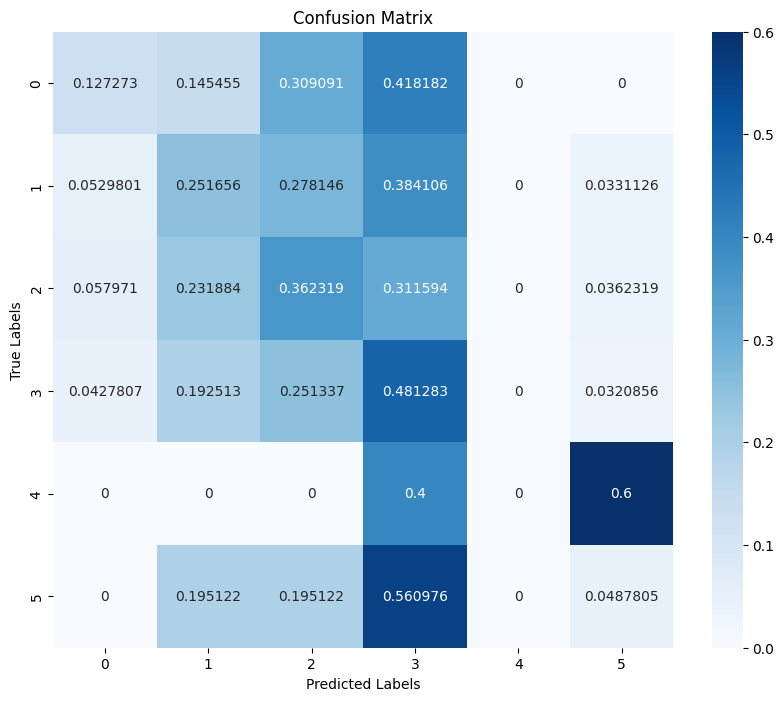

Epoch 5, Validation Loss: 2.6201, Accuracy: 0.3241, F1 Score: 0.3091
Val F1 Score Per Class  [0.1627907  0.27838828 0.33112583 0.42253521 0.         0.06451613]


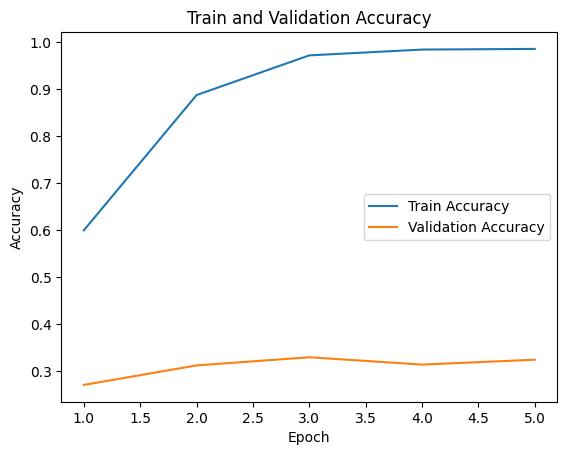

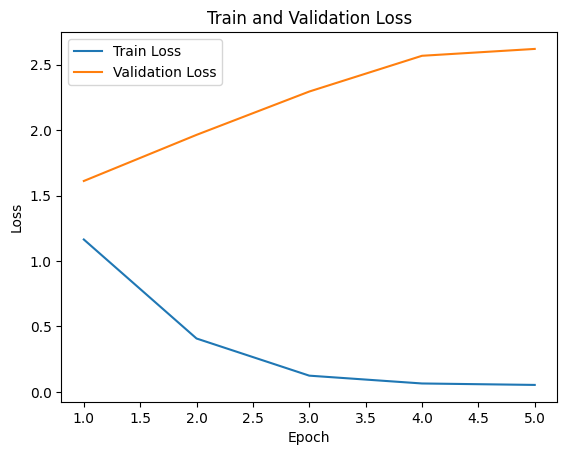

Epoch 6, Train Loss: 0.0297, Accuracy: 0.9930, F1 Score: 0.9930
Train F1 Score Per Class  [0.99446903 0.98941969 0.99093302 0.98572278 1.         0.99697153]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.12it/s, loss=4.05]

[tensor([-2.3262,  0.3122, -1.5834,  2.4219, -2.1780, -2.5509], device='cuda:0'), tensor([-0.8769, -0.4282,  1.8608, -1.5278, -3.4621, -3.0684], device='cuda:0'), tensor([-1.9618, -0.1400, -0.3859,  1.9063, -3.8351, -3.5706], device='cuda:0'), tensor([-1.3901, -0.4625, -2.6500,  4.1775, -2.1743, -1.8771], device='cuda:0'), tensor([-1.7042, -1.2100, -0.9081,  4.8696, -2.5653, -1.7175], device='cuda:0'), tensor([-2.0165, -1.2945, -0.2837,  4.7856, -2.5679, -2.9288], device='cuda:0'), tensor([-1.8368, -1.6059, -1.2656,  4.1621, -3.1918, -0.7247], device='cuda:0'), tensor([-2.1875, -1.6852,  0.2466,  3.0506, -2.4604, -1.6044], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:34,  2.09it/s, loss=3.7]

[tensor([ 3.4519, -1.7737,  0.3156, -0.7151, -3.1066, -1.6141], device='cuda:0'), tensor([-2.6953, -1.0033, -2.7424,  1.5598, -1.6993,  2.0314], device='cuda:0'), tensor([-1.5090, -1.4806, -0.4701,  3.1149, -3.0718, -2.1853], device='cuda:0'), tensor([-1.5688, -1.1891, -0.8671,  4.4208, -2.3460, -1.5602], device='cuda:0'), tensor([ 3.0467, -0.1799, -1.8289,  0.0685, -3.4382, -2.4588], device='cuda:0'), tensor([-0.5013, -0.3026, -1.3827,  0.8528, -3.8740, -3.2852], device='cuda:0'), tensor([-0.9768, -1.1860, -1.4978,  4.4827, -2.8520, -2.6684], device='cuda:0'), tensor([ 2.9587, -1.7917, -1.2712,  1.1065, -3.2149, -1.9955], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.12it/s, loss=3.29]

[tensor([-1.9864,  2.4750, -1.4002,  0.0255, -3.4358, -3.8376], device='cuda:0'), tensor([-1.8884,  0.7707,  0.4549, -0.5025, -2.2440, -2.6010], device='cuda:0'), tensor([-1.5641, -1.6570,  5.3451, -0.3891, -2.0135, -1.6336], device='cuda:0'), tensor([ 1.4117, -2.3135,  2.9094, -1.1227, -3.0202, -2.2649], device='cuda:0'), tensor([-0.2702, -0.2958, -2.3750,  2.6172, -2.7801, -2.2752], device='cuda:0'), tensor([-0.9543, -1.5736, -0.9279,  4.9236, -2.9634, -2.8014], device='cuda:0'), tensor([-0.3282, -2.2458, -0.0234,  0.1729, -2.7854, -2.0569], device='cuda:0'), tensor([ 4.4693, -1.9936, -0.0719, -1.5170, -2.0201, -1.6970], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.13it/s, loss=3.79]

[tensor([-2.2048, -1.1609,  1.7981,  3.1634, -3.1211, -3.3445], device='cuda:0'), tensor([-1.0691, -0.9460,  5.3389, -1.6047, -2.0178, -2.0771], device='cuda:0'), tensor([-1.3233, -1.1946, -2.1109,  4.7420, -3.0097, -0.9472], device='cuda:0'), tensor([-1.9293, -0.0979,  1.4464, -0.1084, -2.6735, -2.5529], device='cuda:0'), tensor([ 4.4133, -1.6253,  0.8143,  0.2287, -2.3646, -3.0844], device='cuda:0'), tensor([-1.2902, -1.5500, -1.3433,  2.6034, -3.1393, -1.3277], device='cuda:0'), tensor([ 0.0941,  0.9632, -1.2226, -0.5201, -3.4325, -3.8227], device='cuda:0'), tensor([-3.0054, -0.7033,  4.1125, -0.6685, -2.1782, -1.3730], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=4.39]

[tensor([-2.7952, -1.4721, -0.6482,  3.0918, -3.0272, -2.9126], device='cuda:0'), tensor([-2.2281, -2.4487,  2.2177,  2.5503, -3.1788, -2.9310], device='cuda:0'), tensor([-1.1993, -1.2854,  4.8094, -1.2901, -2.4791, -2.2990], device='cuda:0'), tensor([-1.8855, -2.5540, -0.0311,  3.6278, -3.1033, -2.8326], device='cuda:0'), tensor([-1.4479, -1.8659,  4.4054, -0.4989, -2.9560, -2.0497], device='cuda:0'), tensor([ 0.6108, -2.2789, -0.1915,  1.7668, -3.2971, -3.0029], device='cuda:0'), tensor([-2.1133, -0.5603, -1.8836, -0.2922, -3.1588, -1.5611], device='cuda:0'), tensor([-1.1322, -0.7299, -2.2064,  4.0811, -2.3786, -0.7948], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=4.56]

[tensor([-1.0998, -1.7670,  4.9342, -0.5716, -2.6582, -2.7019], device='cuda:0'), tensor([-1.0013, -0.5705,  4.9300, -1.9457, -2.4159, -2.0830], device='cuda:0'), tensor([-1.6765, -0.0699, -1.0782,  4.6844, -2.9425, -2.8366], device='cuda:0'), tensor([-2.1710,  3.5776,  1.1103, -1.0117, -2.8171, -2.9833], device='cuda:0'), tensor([-1.3091, -1.4745,  3.9749,  0.7548, -3.2376, -2.9617], device='cuda:0'), tensor([-3.1970,  0.2001,  0.7265, -0.9127, -3.6175, -2.6032], device='cuda:0'), tensor([-2.6729, -1.7914,  2.0072,  1.3909, -2.7032, -2.1630], device='cuda:0'), tensor([-1.6490, -1.9926, -0.8302,  3.6476, -2.9739, -2.2285], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.13it/s, loss=2.15]

[tensor([-0.5188,  0.3271,  0.4288, -1.3098, -2.3467, -1.6756], device='cuda:0'), tensor([-0.6887, -1.9452,  1.1492,  1.8399, -2.9575, -2.3642], device='cuda:0'), tensor([ 0.4117, -2.1824,  3.5984, -0.6329, -2.3279, -2.4135], device='cuda:0'), tensor([-2.1857, -1.9741,  0.7952,  2.1615, -3.2978, -2.2125], device='cuda:0'), tensor([-2.2867,  0.4413,  0.5583, -1.6303, -2.9179, -3.6574], device='cuda:0'), tensor([-0.8410, -0.1695, -0.6681, -1.8399, -2.5543, -2.1011], device='cuda:0'), tensor([-1.9409, -2.3599,  3.7093, -0.7939, -2.8923, -0.5164], device='cuda:0'), tensor([-1.3938,  2.1425, -1.1032, -0.0249, -4.0886, -2.9080], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.12it/s, loss=3.77]

[tensor([-0.1305, -2.4148,  1.1524,  2.0905, -2.8536, -2.6628], device='cuda:0'), tensor([-1.7401, -1.9731, -0.0073,  2.2735, -2.7210, -1.4686], device='cuda:0'), tensor([-0.5277, -2.1234, -1.0181,  5.0055, -2.8191, -1.5312], device='cuda:0'), tensor([-1.2555,  5.1450, -1.9373, -0.6337, -2.2432, -2.3835], device='cuda:0'), tensor([-1.6377, -1.6146,  3.9501, -1.0054, -2.5787, -2.6697], device='cuda:0'), tensor([ 0.5234, -0.6165, -1.4218,  1.0884, -2.6846, -2.9773], device='cuda:0'), tensor([-2.2629, -1.4640, -1.6645,  2.9075, -3.4238,  0.0063], device='cuda:0'), tensor([-0.6209, -1.8967,  4.9686, -0.5796, -2.0626, -2.1891], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.13it/s, loss=3.68]

[tensor([-1.9465, -1.5760, -1.9845,  4.6149, -2.6282, -0.7200], device='cuda:0'), tensor([-0.3957, -1.2619,  2.6134, -1.3716, -3.0549, -3.3260], device='cuda:0'), tensor([-1.7119,  3.3540,  0.8111, -0.8544, -2.3900, -2.6130], device='cuda:0'), tensor([-0.9080, -1.2077,  0.6023,  1.0001, -2.8223, -2.7679], device='cuda:0'), tensor([-0.1038, -2.4156, -0.8629,  3.8193, -1.5568, -2.7224], device='cuda:0'), tensor([-2.5252,  1.9639,  1.8572,  0.5294, -3.4400, -3.5442], device='cuda:0'), tensor([-1.8793, -0.5996, -2.1624,  4.6940, -2.8078, -1.0104], device='cuda:0'), tensor([-0.8633, -3.5199,  1.5825,  2.3068, -3.3722, -2.2986], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:30,  2.10it/s, loss=2.22]

[tensor([-1.8172,  4.5677, -0.2693, -1.0724, -2.0972, -2.8049], device='cuda:0'), tensor([-2.1753, -1.5819,  0.2949,  1.6705, -2.4601, -2.3523], device='cuda:0'), tensor([-0.7908,  1.3870, -3.1742,  2.2758, -3.2688, -1.7106], device='cuda:0'), tensor([-2.0019, -1.5058,  1.3736,  0.7116, -3.2345, -3.1565], device='cuda:0'), tensor([-1.8681,  3.9413, -0.3755, -0.0536, -2.8081, -2.4520], device='cuda:0'), tensor([-1.2303, -0.4482, -1.7867,  4.4123, -2.9772, -3.2014], device='cuda:0'), tensor([-2.2176,  0.3521, -1.2165,  0.0663, -3.1372, -2.9251], device='cuda:0'), tensor([-0.9300, -0.0669, -1.1229,  2.2137, -3.3663, -3.3521], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:29,  2.08it/s, loss=3.46]

[tensor([-1.7336, -1.1100,  1.8152,  1.1739, -3.3645, -3.3459], device='cuda:0'), tensor([-0.6737,  0.1541, -1.8750,  4.2487, -3.1884, -2.4608], device='cuda:0'), tensor([-2.2180, -1.0758,  0.0269,  4.6381, -3.1345, -2.2719], device='cuda:0'), tensor([ 0.9039, -1.7693,  2.5181, -0.0456, -3.5171, -3.0272], device='cuda:0'), tensor([-2.9403,  2.9987,  0.1657, -0.1921, -3.4687, -2.3967], device='cuda:0'), tensor([ 3.4620, -2.3385, -1.0656,  1.4415, -2.7294, -2.0108], device='cuda:0'), tensor([-2.2429, -0.3884,  5.0159, -1.6437, -2.1392, -2.1738], device='cuda:0'), tensor([-0.8290, -0.7332, -2.1049,  4.4968, -2.4109, -2.1875], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:29,  2.08it/s, loss=3.23]

[tensor([ 0.1087, -2.0374,  4.9996, -1.0099, -2.0810, -2.0309], device='cuda:0'), tensor([-2.1172, -1.3024,  0.8843,  1.0735, -3.1070, -3.2432], device='cuda:0'), tensor([-2.4966,  0.3277,  2.7414, -0.3639, -2.7067, -2.8450], device='cuda:0'), tensor([-1.6931, -0.2432, -0.9000,  0.7747, -3.5639, -3.4639], device='cuda:0'), tensor([ 3.7960, -1.1870, -0.8177, -0.9735, -2.2193, -3.0914], device='cuda:0'), tensor([-1.3189, -1.5969,  5.1768, -0.2578, -2.4331, -2.1703], device='cuda:0'), tensor([-0.5504,  0.1775, -1.8897,  1.2485, -3.4337, -1.6181], device='cuda:0'), tensor([ 1.7296, -1.7718,  0.9215, -1.5222, -2.7364, -2.2883], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.08it/s, loss=2.9]

[tensor([-1.6559, -2.5131,  0.3911,  2.6256, -3.1765, -2.6263], device='cuda:0'), tensor([-2.1770, -0.2018,  4.9084, -0.8886, -2.2042, -2.4174], device='cuda:0'), tensor([-2.3551,  2.1599,  2.4555, -0.2690, -3.8769, -3.0189], device='cuda:0'), tensor([-1.9049,  0.0421,  3.8626, -1.6102, -2.6306, -2.2598], device='cuda:0'), tensor([-2.2384,  1.0126, -2.4858,  2.1858, -3.1905, -2.1448], device='cuda:0'), tensor([-0.8990, -2.6902,  2.8421, -0.2706, -3.0279, -2.2603], device='cuda:0'), tensor([-2.5660,  4.3350, -0.9904, -0.2501, -2.8890, -1.4547], device='cuda:0'), tensor([-1.0972, -1.0218,  1.5691,  0.5711, -3.5700, -3.6561], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:28,  2.10it/s, loss=2.35]

[tensor([ 4.7227, -1.9134,  0.3955, -1.7932, -2.6144, -0.1351], device='cuda:0'), tensor([-0.8999, -0.4936,  0.2779, -0.1661, -3.2426, -2.5913], device='cuda:0'), tensor([-1.9097, -2.5531,  0.2357, -0.5883, -2.8185,  0.3949], device='cuda:0'), tensor([-1.2413, -0.3690,  1.8829, -0.2774, -3.3723, -3.2171], device='cuda:0'), tensor([-2.2526, -1.1936, -1.5899,  4.9321, -2.0452, -1.1140], device='cuda:0'), tensor([-1.7424,  0.2204, -1.8017,  3.2935, -2.8249, -2.0347], device='cuda:0'), tensor([-1.5391, -0.5789, -1.4756, -1.0234, -2.7825, -2.7880], device='cuda:0'), tensor([-0.7124, -1.1014, -1.5511,  3.8708, -3.2623, -2.2610], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.11it/s, loss=3.41]

[tensor([-1.1281, -0.6538, -0.0047,  2.6177, -3.5244, -3.4751], device='cuda:0'), tensor([-0.7363, -1.5412, -0.4487, -0.2779, -3.3616, -3.1065], device='cuda:0'), tensor([-0.8523, -1.0726,  5.3725, -1.5124, -2.0539, -1.5326], device='cuda:0'), tensor([-1.1215, -2.0983, -0.7175,  5.0404, -2.8696, -2.3248], device='cuda:0'), tensor([-0.7496, -1.4092, -0.8147,  3.1954, -2.5694, -3.5562], device='cuda:0'), tensor([-1.8776,  4.3703, -1.1789, -0.4673, -3.0658, -3.2343], device='cuda:0'), tensor([-2.7825, -1.2428,  0.6317,  1.0463, -3.5321, -2.2335], device='cuda:0'), tensor([-0.3307, -1.7023,  1.6068, -0.9325, -2.0269, -2.6644], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.12it/s, loss=2.02]

[tensor([ 0.3457, -1.9893, -1.4993,  4.6769, -3.3549, -1.9529], device='cuda:0'), tensor([-2.0320, -2.1915,  3.8841, -1.7054, -2.8590, -2.7157], device='cuda:0'), tensor([-1.7893, -1.2174, -0.7527,  4.4287, -2.9231, -3.0418], device='cuda:0'), tensor([-2.4081,  0.1081,  1.0366,  0.2419, -3.2039, -1.5181], device='cuda:0'), tensor([-2.6160, -1.0836, -1.0868,  4.0717, -2.9656, -2.7025], device='cuda:0'), tensor([-2.0827, -1.7543,  4.8182,  0.1765, -1.8809, -2.0790], device='cuda:0'), tensor([-0.7512, -1.8323,  0.5606,  3.3445, -3.4890, -3.0155], device='cuda:0'), tensor([-2.0850, -2.2744,  1.7963, -1.2621, -2.7882, -1.3283], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:08<00:26,  2.10it/s, loss=2.96]

[tensor([-0.3668, -2.0612, -1.2415,  2.4466, -4.1123, -2.2436], device='cuda:0'), tensor([-1.6359,  0.4340,  2.6295, -1.4322, -2.5701, -2.4366], device='cuda:0'), tensor([-1.8956,  5.0750, -1.8864,  0.0563, -2.4549, -1.4467], device='cuda:0'), tensor([-2.7710,  3.6115, -0.1424,  0.4317, -3.2980, -2.8298], device='cuda:0'), tensor([-2.6245, -1.6787, -0.9393,  3.0201, -2.7219, -1.0569], device='cuda:0'), tensor([-1.0168, -2.4513, -0.6883,  2.0375, -3.1595, -1.4501], device='cuda:0'), tensor([ 3.7141, -2.4107, -0.4711,  0.1349, -2.5889, -0.5199], device='cuda:0'), tensor([-1.4653, -0.1418,  1.1873, -0.9541, -2.9561, -3.5419], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:26,  2.09it/s, loss=2.28]

[tensor([-1.9514, -2.2716,  0.5740,  3.5062, -2.9530, -2.5274], device='cuda:0'), tensor([ 0.3088, -1.8491,  0.2407,  1.7761, -2.6698, -3.9474], device='cuda:0'), tensor([-2.1506, -0.8284,  0.3916, -1.3863, -4.0529, -1.3766], device='cuda:0'), tensor([-1.7460,  5.3037, -1.2579, -0.6756, -2.0838, -1.8296], device='cuda:0'), tensor([-1.8085, -2.1131,  3.9849, -0.4578, -1.5717, -2.2944], device='cuda:0'), tensor([-1.3802, -0.7282, -0.4690,  1.4135, -3.1499, -2.5851], device='cuda:0'), tensor([-1.7302,  1.4306, -1.1830, -0.4914, -3.2916, -2.6654], device='cuda:0'), tensor([-2.5619,  1.3546, -1.1228,  3.2747, -2.9354, -2.9256], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:09<00:25,  2.09it/s, loss=2.43]

[tensor([-2.6720,  1.6614,  0.5192, -0.7676, -2.9185, -3.0411], device='cuda:0'), tensor([ 3.4098, -1.7651, -1.5834, -1.3543, -3.1920, -1.7969], device='cuda:0'), tensor([-1.6471,  0.0042,  0.0636,  3.1367, -2.5748, -3.4582], device='cuda:0'), tensor([-1.6995, -1.6478, -0.5189,  4.2630, -2.4181, -1.9895], device='cuda:0'), tensor([-0.9091, -1.0277,  0.1699,  1.7420, -3.7493, -3.1346], device='cuda:0'), tensor([-0.0779, -1.9698, -1.7516,  1.2562, -2.6720, -2.0511], device='cuda:0'), tensor([-1.4494, -0.5954, -0.5874,  3.0422, -3.2854, -2.7856], device='cuda:0'), tensor([-1.7915,  0.8866, -0.7568, -0.0428, -3.2507, -1.7112], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:25,  2.10it/s, loss=4.07]

[tensor([ 0.1583, -2.6548,  2.3276,  0.5567, -2.4943, -2.8440], device='cuda:0'), tensor([-2.4400, -0.3573, -2.9547, -0.8321, -2.5728, -1.6545], device='cuda:0'), tensor([-1.8569, -1.7971,  2.4857,  0.8490, -2.4516, -1.1673], device='cuda:0'), tensor([ 3.1576, -2.5019,  0.6930, -0.7748, -2.9434, -2.4530], device='cuda:0'), tensor([ 3.6162, -1.4199,  1.4693, -1.1412, -3.1145, -3.1137], device='cuda:0'), tensor([-2.0401,  3.4232, -1.2099, -0.3016, -3.2341, -1.6165], device='cuda:0'), tensor([ 1.9473, -2.3745,  0.0046,  0.3083, -3.5092, -2.5422], device='cuda:0'), tensor([-2.4954, -0.7480,  4.0381, -0.9433, -2.5333, -2.4417], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.09it/s, loss=3.71]

[tensor([-1.2148, -1.9028,  5.0234, -0.6747, -2.6221, -1.8748], device='cuda:0'), tensor([-1.6562,  0.8063, -0.8071,  0.5643, -3.7513, -3.3426], device='cuda:0'), tensor([-2.4495,  2.0045, -0.8546,  1.1629, -3.5944, -2.4019], device='cuda:0'), tensor([-1.0708, -2.3943,  3.9884,  0.2942, -2.4469, -2.7246], device='cuda:0'), tensor([-2.2526, -0.3148, -0.5771,  3.4607, -3.7462, -2.2024], device='cuda:0'), tensor([-2.2663, -1.1012,  0.0970,  0.5909, -3.1383, -2.5551], device='cuda:0'), tensor([-2.0745, -2.0390, -0.8526,  4.1610, -2.3174, -1.4029], device='cuda:0'), tensor([-1.0978, -1.2396, -0.9659,  3.7257, -2.7477, -0.9347], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:24,  2.07it/s, loss=1.77]

[tensor([-0.9351, -1.7733,  0.2625,  3.5034, -3.6604, -3.0727], device='cuda:0'), tensor([-0.0633, -2.7181,  0.7394,  2.3298, -2.6704, -2.5010], device='cuda:0'), tensor([-3.5518, -1.0616, -0.6276,  0.8002, -3.1020, -0.9066], device='cuda:0'), tensor([-2.5214, -1.9002, -0.9960,  4.0319, -2.7223, -0.9683], device='cuda:0'), tensor([-1.4120, -2.0696, -0.2667,  2.6188, -2.6524, -3.2681], device='cuda:0'), tensor([-1.2997, -2.1598,  2.7618,  2.1055, -2.6578, -2.8440], device='cuda:0'), tensor([-0.5459, -1.3337, -1.4792,  2.2285, -3.2262, -2.4657], device='cuda:0'), tensor([-2.2122, -1.8473,  4.2139,  0.0428, -2.4553, -2.3110], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:24,  2.06it/s, loss=2.05]

[tensor([-0.2610, -0.7595, -1.3379,  1.8883, -3.7709, -3.2446], device='cuda:0'), tensor([-1.0853, -2.6892,  2.1614,  0.1820, -3.2243, -2.7786], device='cuda:0'), tensor([-0.1912, -1.7586, -0.8943,  3.0230, -2.4170, -2.9959], device='cuda:0'), tensor([-2.3372,  1.6554, -2.9556,  1.6221, -3.6797,  0.4543], device='cuda:0'), tensor([-1.3518, -0.7416,  0.1296,  2.6990, -3.0713, -3.1109], device='cuda:0'), tensor([-0.0696, -2.1507, -1.2197,  4.9723, -2.2821, -2.1382], device='cuda:0'), tensor([ 0.2434, -2.6278,  0.7423,  1.0516, -2.5066, -2.7508], device='cuda:0'), tensor([-2.2166, -1.5069,  5.1966, -1.4729, -1.8737, -1.9115], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:23,  2.06it/s, loss=2.27]

[tensor([ 1.0043, -1.5766, -2.7959,  0.5877, -2.3140, -1.7188], device='cuda:0'), tensor([ 1.1944, -1.6708,  1.0790, -1.0162, -3.5104, -2.3092], device='cuda:0'), tensor([-0.8534, -1.6051, -1.6342,  5.0525, -2.0748, -2.4161], device='cuda:0'), tensor([ 0.6744, -1.8301,  3.0249, -1.6023, -1.8172, -2.1869], device='cuda:0'), tensor([-2.6391,  1.0757,  4.0323, -1.1170, -2.3706, -3.0875], device='cuda:0'), tensor([ 2.2441, -1.9133, -0.3041,  0.0034, -2.7905, -3.0087], device='cuda:0'), tensor([-2.1973, -0.5867, -2.3609,  4.5681, -1.6090, -1.1963], device='cuda:0'), tensor([-1.6755,  2.9129, -2.3565,  1.0271, -3.8449, -1.5962], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:23,  2.07it/s, loss=2.63]

[tensor([-1.8464, -0.9128, -1.4891,  4.6760, -3.0456, -0.8338], device='cuda:0'), tensor([-1.1753, -0.8098, -0.4402,  0.5513, -3.1745, -2.2968], device='cuda:0'), tensor([-0.5255, -0.3562, -0.2430,  0.4935, -3.2969, -2.9560], device='cuda:0'), tensor([-1.5095, -2.2342,  3.6917,  0.9088, -2.8386, -2.6324], device='cuda:0'), tensor([ 3.2995, -2.1975,  1.2327, -0.2628, -2.7802, -2.3272], device='cuda:0'), tensor([-0.8442,  1.3165,  1.3265, -2.3583, -2.5317, -2.0142], device='cuda:0'), tensor([-2.3385,  3.9278, -2.4898, -0.2955, -3.6688, -1.5118], device='cuda:0'), tensor([-2.4367,  1.5504, -2.7940,  2.2228, -3.1272, -0.0879], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:22,  2.08it/s, loss=4.01]

[tensor([ 2.8855,  0.0049, -1.4596, -0.1826, -3.8093, -2.9727], device='cuda:0'), tensor([ 0.6205, -1.1999,  2.8617, -1.9183, -2.5489, -1.8803], device='cuda:0'), tensor([-2.3338, -0.6643,  3.8659,  0.7849, -3.0698, -3.1191], device='cuda:0'), tensor([-1.6717,  2.4533,  0.9906, -0.2645, -3.2328, -3.5295], device='cuda:0'), tensor([ 0.2138, -1.8569,  2.4705, -0.8685, -3.1765, -3.3813], device='cuda:0'), tensor([-2.4417, -2.0728,  1.2760,  0.8759, -2.2931, -1.1825], device='cuda:0'), tensor([-1.4092, -1.6596,  1.9622,  2.3198, -2.8746, -3.2597], device='cuda:0'), tensor([ 0.3451, -3.0561, -0.2874,  1.6971, -2.5497, -2.2757], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:22,  2.07it/s, loss=3.21]

[tensor([-2.6211, -0.2076, -1.9385,  2.5361, -3.2226,  1.2789], device='cuda:0'), tensor([-1.4658,  0.8211,  2.7090, -1.2261, -3.0315, -3.3528], device='cuda:0'), tensor([-1.3904, -1.5287, -0.7900,  2.2084, -2.7686, -2.2703], device='cuda:0'), tensor([-0.8907, -2.7486,  0.2859,  1.7425, -2.3332, -2.6643], device='cuda:0'), tensor([ 1.4143, -1.9363, -0.4329, -1.1424, -2.5575, -2.4000], device='cuda:0'), tensor([-2.6123,  0.3293, -0.0598,  1.1690, -2.9915, -3.4051], device='cuda:0'), tensor([-1.6915, -1.5835,  3.8429, -1.3426, -2.8224, -1.8156], device='cuda:0'), tensor([-2.1994, -0.4988, -1.5853,  2.5116, -2.9480, -2.3276], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.07it/s, loss=2.92]

[tensor([ 0.7314, -2.0239,  2.7030, -0.6109, -2.7364, -2.4325], device='cuda:0'), tensor([-1.8872, -1.5401,  0.0302,  3.8747, -2.8864, -2.8387], device='cuda:0'), tensor([-1.2701, -1.0198,  1.7599,  0.6772, -3.3847, -3.5544], device='cuda:0'), tensor([-1.9430, -1.5599,  2.8825,  0.8712, -3.1642, -1.9746], device='cuda:0'), tensor([-1.0487, -0.7434,  5.2464, -1.4211, -1.8420, -1.9380], device='cuda:0'), tensor([ 0.8371, -1.2791,  2.0060, -1.1097, -3.3755, -2.2723], device='cuda:0'), tensor([-1.2322, -1.7437,  1.2606,  2.6622, -2.9442, -1.7469], device='cuda:0'), tensor([-0.4139, -1.9374,  3.6927,  0.1488, -2.9529, -2.6421], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:21,  2.09it/s, loss=3.3]

[tensor([ 5.0528, -2.1055, -0.7127, -0.5469, -1.8872, -1.1231], device='cuda:0'), tensor([-0.8217, -0.8687,  4.2610, -1.0788, -3.1560, -2.9262], device='cuda:0'), tensor([ 1.5950, -1.8484, -0.5162,  1.1759, -2.5349, -3.3158], device='cuda:0'), tensor([-1.1701, -0.4460,  1.7086,  0.1873, -2.4488, -1.8945], device='cuda:0'), tensor([ 0.3554,  2.8917, -1.9357,  0.3537, -2.9713, -2.9478], device='cuda:0'), tensor([-2.0656, -1.7174, -0.7318,  4.7107, -2.6619, -1.5638], device='cuda:0'), tensor([-1.8794, -1.3960,  1.5842,  2.3079, -2.9083, -2.1805], device='cuda:0'), tensor([-1.9806,  1.0479,  2.4564, -1.6070, -2.5015, -2.9250], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.10it/s, loss=3.69]

[tensor([-1.7034, -0.0792,  1.6395, -0.9541, -3.7300, -3.6860], device='cuda:0'), tensor([-2.0596, -1.7089,  1.5439,  2.2941, -2.9130, -2.2521], device='cuda:0'), tensor([-2.3728, -0.3075, -1.9296,  3.3489, -3.3153, -1.9692], device='cuda:0'), tensor([-2.4933, -0.8359, -0.1379,  3.1598, -2.4750, -1.1045], device='cuda:0'), tensor([-0.8239, -1.4094, -0.3215,  4.4492, -2.7985, -2.9977], device='cuda:0'), tensor([-1.0238, -2.0219,  4.7547, -1.0541, -2.3843, -2.2768], device='cuda:0'), tensor([-0.8735, -1.8109, -1.0097,  3.3483, -2.0571, -1.5644], device='cuda:0'), tensor([-0.4832, -2.0747, -1.1934,  3.7800, -2.4181, -1.8879], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:20,  2.07it/s, loss=3.09]

[tensor([-2.3440, -2.1654,  1.8266,  2.1987, -2.8858, -2.3071], device='cuda:0'), tensor([-0.8091, -2.6658, -0.5679,  2.4109, -3.3548, -2.8645], device='cuda:0'), tensor([-1.9082, -1.1834, -1.8645,  4.9053, -2.5131, -1.2475], device='cuda:0'), tensor([-0.7758, -1.8142,  0.2146,  1.0673, -3.6396, -3.0687], device='cuda:0'), tensor([ 3.1066, -1.7375,  1.7696, -1.8297, -2.3555, -2.6598], device='cuda:0'), tensor([-1.7340, -0.8514, -2.7501,  2.9856, -2.1863,  1.2292], device='cuda:0'), tensor([-0.6425, -0.2680, -0.4624, -0.8481, -2.7824, -3.2837], device='cuda:0'), tensor([-1.7504, -1.2705, -0.9448,  5.2962, -2.4360, -2.4998], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:15<00:19,  2.08it/s, loss=3.27]

[tensor([-2.0789, -0.2120,  1.1687, -1.0483, -3.1240, -2.7313], device='cuda:0'), tensor([-0.2857, -1.4299,  0.4558,  1.0314, -3.1832, -3.9319], device='cuda:0'), tensor([-2.4842, -0.5662, -0.5982,  0.5708, -3.3947, -3.2385], device='cuda:0'), tensor([-1.0270, -1.6629,  5.0208, -0.9744, -1.7975, -2.1253], device='cuda:0'), tensor([-1.4537, -2.1621,  4.6711, -0.9020, -2.0888, -1.7084], device='cuda:0'), tensor([-1.8666,  3.7264,  0.4746, -1.4865, -3.6579, -2.9766], device='cuda:0'), tensor([-1.9800, -1.2126, -1.6144,  0.0164, -3.0724,  4.6893], device='cuda:0'), tensor([ 1.4448, -2.6354, -0.0073,  0.9485, -2.1405, -2.9149], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:19,  2.07it/s, loss=3.7]

[tensor([-2.2210, -0.6669,  1.2031,  1.2576, -3.5090, -2.9574], device='cuda:0'), tensor([ 5.1791, -1.9799, -0.7643,  0.4835, -2.1153, -2.7504], device='cuda:0'), tensor([-2.4199,  0.7509, -0.2649, -0.5010, -3.5211, -3.6441], device='cuda:0'), tensor([-2.3269, -0.1894, -2.9955,  0.5044, -2.3045,  2.9044], device='cuda:0'), tensor([-0.0460, -1.5441, -0.5445,  4.0546, -3.1252, -3.1304], device='cuda:0'), tensor([-2.7771, -0.3824, -0.7786,  0.2904, -1.9434, -2.0478], device='cuda:0'), tensor([-0.7283, -2.4647,  3.6060,  0.8796, -2.7486, -2.5879], device='cuda:0'), tensor([ 1.5034, -2.4247, -0.1654,  2.9454, -2.8538, -2.7464], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:16<00:18,  2.10it/s, loss=2.53]

[tensor([-3.1389,  0.1362,  1.1729,  0.9053, -3.4892, -2.9047], device='cuda:0'), tensor([-2.0105, -1.7781,  4.6144, -0.2725, -2.5657, -2.2877], device='cuda:0'), tensor([-0.6353, -1.6721,  4.7659, -1.1633, -2.4870, -2.1980], device='cuda:0'), tensor([ 0.1945, -1.4909, -0.1361,  0.6434, -3.9212, -2.6472], device='cuda:0'), tensor([-1.4351, -0.1529, -1.7639,  4.0286, -2.8749, -2.0331], device='cuda:0'), tensor([-1.0612, -1.5566,  5.3385, -1.3225, -1.9696, -1.8363], device='cuda:0'), tensor([ 3.7408, -2.5280,  0.7060,  0.0708, -2.8779, -2.1860], device='cuda:0'), tensor([ 2.8186, -1.1307,  1.9113, -1.4284, -2.7670, -2.4359], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.13it/s, loss=2.79]

[tensor([-0.6826, -1.7221, -1.3849,  4.4199, -2.7008, -3.2965], device='cuda:0'), tensor([-1.6628, -0.7103,  3.9940, -2.3716, -2.3922, -0.7280], device='cuda:0'), tensor([ 5.0114, -1.9258, -1.4704, -0.6067, -2.8378, -2.0097], device='cuda:0'), tensor([ 1.2758, -2.6295,  3.2131, -0.0748, -2.7438, -2.5656], device='cuda:0'), tensor([-1.5425, -0.9314,  0.3448,  0.2728, -2.4141, -1.1964], device='cuda:0'), tensor([-1.9793, -1.4448, -2.0525,  4.0289, -2.3775, -0.3787], device='cuda:0'), tensor([ 2.4557, -2.2793,  1.0519, -0.1376, -2.9877, -2.7382], device='cuda:0'), tensor([-2.8416,  2.8817, -1.2075,  1.7211, -3.1552, -2.5992], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:17<00:17,  2.13it/s, loss=3.18]

[tensor([-2.8188, -0.8272, -1.4668,  2.4499, -3.2059, -1.8843], device='cuda:0'), tensor([ 5.1272, -2.0029, -0.1207, -0.3610, -2.2023, -2.0284], device='cuda:0'), tensor([-3.0527, -1.8134,  0.1097,  3.4170, -2.4457, -3.0829], device='cuda:0'), tensor([-1.9890,  3.5933, -1.1410, -0.4356, -2.4997, -2.7063], device='cuda:0'), tensor([-0.8259, -1.1362, -1.0094,  4.6640, -2.9519, -3.1328], device='cuda:0'), tensor([-1.5047,  4.7073, -0.7311, -0.6255, -1.8166, -3.0069], device='cuda:0'), tensor([-1.3611,  0.0954,  4.2104, -1.2780, -3.7568, -2.5064], device='cuda:0'), tensor([-1.4400, -0.0063,  4.2635, -1.6610, -2.6926, -3.3493], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.12it/s, loss=3.63]

[tensor([-1.6754, -1.3605, -0.9209,  5.0071, -2.3895, -2.1326], device='cuda:0'), tensor([-1.5399,  3.1890, -2.0094, -0.7088, -2.7446, -2.5589], device='cuda:0'), tensor([ 3.0087, -1.5492, -2.1796,  1.1138, -2.8445, -1.4758], device='cuda:0'), tensor([-1.7233, -0.2876,  5.3034, -1.5674, -2.2640, -2.2265], device='cuda:0'), tensor([-0.5803, -0.7195,  1.4020, -1.9366, -2.0848, -1.9754], device='cuda:0'), tensor([-0.3297, -1.1211,  1.0669, -1.0035, -3.1200, -3.4799], device='cuda:0'), tensor([-2.0924,  0.8866, -0.3388,  1.3118, -3.6284, -3.5689], device='cuda:0'), tensor([-2.3054, -0.6686, -0.5487, -0.3187, -3.5566, -1.6772], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:18<00:16,  2.14it/s, loss=3.42]

[tensor([-2.1712, -0.2278, -2.6305,  4.3571, -2.2008, -1.5186], device='cuda:0'), tensor([-2.0603, -1.3111,  0.4657,  1.6864, -1.4569, -2.6765], device='cuda:0'), tensor([-2.5438, -0.0536, -1.2101,  2.8826, -2.7189, -2.7583], device='cuda:0'), tensor([-1.5650, -1.6355,  5.0945, -0.5246, -2.4468, -2.2246], device='cuda:0'), tensor([-1.9948, -1.0429,  4.8904, -0.8565, -2.8324, -1.8153], device='cuda:0'), tensor([-0.8473, -1.4958, -1.2640,  4.2052, -2.7213, -2.3244], device='cuda:0'), tensor([-1.9615, -0.5327, -2.3490,  4.0370, -2.1766, -1.0112], device='cuda:0'), tensor([-0.3548,  4.3043, -1.9998, -0.4201, -2.3404, -2.5616], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.13it/s, loss=3.57]

[tensor([-1.1827, -1.3162,  1.6768,  2.6236, -3.5044, -3.7215], device='cuda:0'), tensor([-1.5512, -1.3809, -2.0533,  3.8838, -1.6835, -0.4194], device='cuda:0'), tensor([ 3.8537, -1.3313, -1.9154, -0.3527, -2.3748, -2.3571], device='cuda:0'), tensor([-1.1636, -1.3032,  0.6415,  0.8800, -3.7540, -3.8575], device='cuda:0'), tensor([-0.7804, -0.9660,  0.0783,  2.3486, -3.5224, -3.3171], device='cuda:0'), tensor([-1.6730, -1.7407,  5.1275, -0.2162, -2.1887, -1.6919], device='cuda:0'), tensor([ 2.3112, -1.7851, -1.1738,  1.2811, -2.6305, -3.7660], device='cuda:0'), tensor([-2.1718, -1.3738,  4.9399,  0.4149, -2.4638, -2.5765], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:19<00:15,  2.11it/s, loss=2.1]

[tensor([-2.3006,  4.0938, -0.0244, -0.9357, -3.0212, -3.0374], device='cuda:0'), tensor([-2.2278, -0.8384, -0.5399,  3.7024, -2.8731, -2.6517], device='cuda:0'), tensor([-2.3819,  0.3768,  2.7912, -0.9718, -3.3301, -2.7892], device='cuda:0'), tensor([-0.8194, -1.6196,  5.4779, -1.3540, -1.7025, -1.6029], device='cuda:0'), tensor([-0.8100,  0.4751, -1.7872,  3.3912, -2.2892, -3.4477], device='cuda:0'), tensor([-2.8332, -1.3362, -0.9646,  3.2085, -2.7100, -0.9171], device='cuda:0'), tensor([-2.2832, -1.7748,  1.4217,  2.6330, -3.8707, -2.4169], device='cuda:0'), tensor([-1.1896, -1.5330,  1.5903,  0.9034, -0.5998, -2.4580], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:15,  2.10it/s, loss=2.52]

[tensor([-0.3196, -2.6891, -1.1061,  4.0132, -2.3493, -2.7975], device='cuda:0'), tensor([-1.6518, -2.1548, -0.9019,  4.9015, -2.9390, -1.8256], device='cuda:0'), tensor([-1.7194, -1.5976, -0.8469,  0.7864, -3.1773, -2.5056], device='cuda:0'), tensor([ 0.2953, -0.6066, -2.0974,  2.5679, -3.4088, -2.2451], device='cuda:0'), tensor([-1.8362,  1.3295, -0.6158,  1.7837, -3.2214, -3.4879], device='cuda:0'), tensor([-1.9764, -1.3491,  4.3983,  0.4107, -2.1141, -2.5314], device='cuda:0'), tensor([-0.3535, -0.8355, -1.2445,  4.2055, -2.8757, -2.5982], device='cuda:0'), tensor([-0.3901, -2.0375,  4.2654, -0.6372, -2.3458, -2.1894], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:20<00:14,  2.09it/s, loss=1.82]

[tensor([-2.8528,  0.7320,  0.1254, -0.9063, -3.6672, -1.4190], device='cuda:0'), tensor([-2.2860, -0.7921,  0.4916, -1.1010, -3.1432, -2.7281], device='cuda:0'), tensor([ 5.5015, -1.9213, -0.7227, -0.8148, -2.1790, -1.1774], device='cuda:0'), tensor([-2.6130,  1.1876,  0.8103,  0.7687, -3.0248, -3.6862], device='cuda:0'), tensor([-1.2041, -1.2712, -2.0260,  5.0508, -2.7347, -1.9305], device='cuda:0'), tensor([-1.4243,  3.1909, -0.5247,  0.7312, -3.0572, -3.1312], device='cuda:0'), tensor([-0.4237, -0.5605, -0.8809,  1.9145, -3.5669, -3.1691], device='cuda:0'), tensor([ 3.2467, -1.6754, -0.1430, -1.9719, -2.6576, -1.6022], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.10it/s, loss=2.8]

[tensor([ 0.9390, -2.3898,  1.0581, -0.2524, -3.1566, -1.6939], device='cuda:0'), tensor([-2.1288, -1.7440,  2.5861, -1.4815, -2.4501, -2.0540], device='cuda:0'), tensor([-0.2960, -2.0546,  3.5923, -0.7544, -2.7377, -1.8138], device='cuda:0'), tensor([-1.4785, -2.0859,  0.0478,  4.3725, -3.5360, -2.4657], device='cuda:0'), tensor([-2.5329,  3.4601,  0.0456,  1.2878, -3.0569, -3.0560], device='cuda:0'), tensor([ 3.2903, -0.9685, -2.4446, -0.3195, -3.4554, -2.0278], device='cuda:0'), tensor([-0.0340, -2.5045,  0.2839,  3.2759, -3.3023, -2.9767], device='cuda:0'), tensor([ 0.6490, -1.1692, -0.9060, -1.0678, -3.5855, -3.1551], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.08it/s, loss=3.11]

[tensor([ 0.6138,  1.4397, -1.4782,  0.5070, -2.8414, -3.3540], device='cuda:0'), tensor([ 1.5404, -2.7427,  2.5809,  0.4697, -2.6254, -2.6938], device='cuda:0'), tensor([-2.9792, -1.0744,  2.8587,  0.4364, -3.1888, -2.7545], device='cuda:0'), tensor([-1.9868, -1.0906,  2.5167,  0.5392, -3.7694, -2.1695], device='cuda:0'), tensor([-1.5229, -1.7802, -1.3583,  1.7554,  0.2780,  0.2775], device='cuda:0'), tensor([-2.1573,  0.1411,  0.8163,  0.4763, -3.2952, -3.0933], device='cuda:0'), tensor([-0.8087, -2.0739,  4.2959, -0.5248, -2.3754, -1.9474], device='cuda:0'), tensor([-0.0578,  3.1149,  1.1873, -2.4509, -2.3884, -1.4626], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.05it/s, loss=2.63]

[tensor([ 1.8719, -1.7658, -1.7250,  0.4843, -3.1503, -2.2356], device='cuda:0'), tensor([-2.2841, -0.4897, -2.7722,  2.1101, -2.0547, -1.4308], device='cuda:0'), tensor([-1.8148, -1.7618,  0.0674,  2.2328, -3.7168, -1.5169], device='cuda:0'), tensor([-1.4643, -0.4065,  0.4021, -1.9475, -2.9810, -2.8104], device='cuda:0'), tensor([-1.5669, -2.3733,  4.1513,  0.8668, -2.2823, -1.7968], device='cuda:0'), tensor([-1.1598, -1.8963, -1.7325,  0.1632, -3.0156,  4.8074], device='cuda:0'), tensor([-1.6945,  0.2248, -0.3894,  2.2214, -3.7437, -3.5955], device='cuda:0'), tensor([-2.3425, -1.6475, -1.6235,  0.3117, -2.9359, -0.1348], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:13,  2.05it/s, loss=1.35]

[tensor([-1.0733, -1.6135,  2.3331, -0.5119, -3.1288, -2.8615], device='cuda:0'), tensor([-0.1616, -1.2709,  1.3287, -1.1782, -1.8358, -2.6733], device='cuda:0'), tensor([-2.5103, -0.4583, -0.6449,  2.2566, -2.9399, -3.3063], device='cuda:0'), tensor([-1.9606, -1.6649,  2.3735, -1.2942, -2.7379, -1.9807], device='cuda:0'), tensor([-1.6032, -1.0539, -1.6479,  3.8964, -2.9468, -1.8877], device='cuda:0'), tensor([-2.5811,  1.3294,  1.0017, -1.3028, -2.5155, -2.5804], device='cuda:0'), tensor([-2.1316, -0.6072,  0.6508,  1.8480, -3.0265, -2.7121], device='cuda:0'), tensor([-1.1342, -1.5709,  1.2126, -0.4780, -2.6346, -3.1122], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:22<00:12,  2.05it/s, loss=1.62]

[tensor([ 5.9682, -1.2254, -1.4575, -1.1140, -1.4593, -0.8379], device='cuda:0'), tensor([-0.8549, -1.6632, -1.7571,  4.2401, -3.2049, -1.4250], device='cuda:0'), tensor([-2.1806, -0.9717,  3.0669, -0.9985, -2.3876, -2.1834], device='cuda:0'), tensor([-1.0250, -0.7955,  4.4732, -0.2778, -3.0610, -2.7930], device='cuda:0'), tensor([ 2.4153, -1.3975,  1.7588, -0.7639, -2.4743, -2.9913], device='cuda:0'), tensor([-1.7798, -0.5921, -2.9022,  3.0788, -2.9144, -1.3346], device='cuda:0'), tensor([-1.7096, -2.0847,  2.5765,  0.8956, -1.9837, -3.0591], device='cuda:0'), tensor([-1.8000, -1.6176, -0.7247,  4.6569, -2.6024, -2.2388], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:12,  2.06it/s, loss=3.31]

[tensor([-1.3801, -1.7202,  5.3664, -0.9154, -2.3082, -1.3054], device='cuda:0'), tensor([-2.1872,  1.0696, -1.4160,  1.6243, -3.1102, -2.6613], device='cuda:0'), tensor([-2.1366,  5.2542, -1.4494, -0.5251, -2.2371, -1.6452], device='cuda:0'), tensor([ 2.5008, -1.0476, -0.3330, -0.6500, -4.0677, -3.0441], device='cuda:0'), tensor([-0.5598, -2.1806, -1.2285,  4.7949, -2.7697, -1.9849], device='cuda:0'), tensor([ 5.7250, -1.3432, -0.3572, -1.6755, -1.6070, -1.1674], device='cuda:0'), tensor([-1.1818, -1.2724,  0.6635,  0.9935, -3.5391, -3.6183], device='cuda:0'), tensor([-2.9686, -0.5070,  2.1727,  0.8825, -2.9875, -2.5781], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:23<00:11,  2.06it/s, loss=2.55]

[tensor([-0.9763, -2.6666,  3.7048, -0.1932, -2.1502, -2.5034], device='cuda:0'), tensor([ 2.7522, -0.6197, -1.0951, -0.9538, -3.3788, -3.1597], device='cuda:0'), tensor([-3.0839, -0.4127,  1.3829, -0.9230, -2.5005, -2.3432], device='cuda:0'), tensor([-0.7372, -1.9474,  3.6461, -0.6384, -3.1946, -1.9956], device='cuda:0'), tensor([-2.4425,  2.7162,  2.5837, -1.1644, -2.6716, -2.4784], device='cuda:0'), tensor([-0.8903, -1.8438,  1.2235, -1.6498, -2.6064, -2.6215], device='cuda:0'), tensor([-2.5954,  0.8034, -0.2960,  0.2872, -3.8103, -0.2472], device='cuda:0'), tensor([-1.6935, -2.0018,  0.6631,  3.6015, -2.5611, -2.2299], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:11,  2.07it/s, loss=3.36]

[tensor([ 1.7866, -2.1996,  2.9490, -1.0564, -2.3304, -2.3980], device='cuda:0'), tensor([ 0.3243, -2.2901, -0.6273, -0.4554, -3.0311, -2.2433], device='cuda:0'), tensor([-2.5498, -0.8181,  2.0759,  1.5139, -2.6295, -1.8318], device='cuda:0'), tensor([ 1.0438, -1.0440,  0.9832, -0.2237, -4.0385, -2.6698], device='cuda:0'), tensor([-1.4962, -1.0938,  4.5680, -0.5814, -2.6776, -2.4737], device='cuda:0'), tensor([-1.1910, -1.9029, -1.2360,  5.0182, -2.0539, -1.3034], device='cuda:0'), tensor([-1.9214, -0.8527, -0.1101,  3.7728, -2.7189, -0.9358], device='cuda:0'), tensor([-1.7982, -0.3163,  0.6474,  0.5479, -3.5732, -3.5200], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:24<00:10,  2.07it/s, loss=3.03]

[tensor([-1.1763, -2.1299,  3.7044,  0.7783, -2.9578, -2.9208], device='cuda:0'), tensor([-0.8345, -2.4816, -1.1671,  4.8783, -2.6899, -1.0828], device='cuda:0'), tensor([-2.3885,  0.7025, -2.0117,  2.0576, -3.0040, -0.3151], device='cuda:0'), tensor([-1.0971, -1.4479, -0.7079,  4.9615, -2.8409, -2.3280], device='cuda:0'), tensor([-1.1323, -0.5001,  3.9984, -1.2173, -2.5246, -2.7865], device='cuda:0'), tensor([ 0.9307, -1.5170, -1.8617,  1.6784, -3.8253, -2.2483], device='cuda:0'), tensor([-0.1998, -1.6306, -1.1893,  3.2542, -2.9972, -2.5872], device='cuda:0'), tensor([ 1.4724, -0.6127, -0.7009, -2.7220, -2.9432,  2.8437], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:10,  2.09it/s, loss=2.97]

[tensor([-2.3652, -0.9765,  3.8146,  0.0759, -3.0026, -1.9518], device='cuda:0'), tensor([-1.2504, -0.7630, -1.4300,  5.1311, -2.5214, -2.2004], device='cuda:0'), tensor([ 1.2136,  0.0369, -2.2377,  0.3604, -1.4229, -3.3261], device='cuda:0'), tensor([-2.0400,  1.2440, -1.6737,  0.4027, -3.1630, -2.4836], device='cuda:0'), tensor([-2.6475, -0.6302,  0.7037,  1.1596, -3.8178, -0.8531], device='cuda:0'), tensor([-1.4227,  0.7414, -1.2855, -0.8067, -3.3442, -3.1811], device='cuda:0'), tensor([ 1.6372, -2.6225,  0.2640,  2.1108, -2.7992, -1.8033], device='cuda:0'), tensor([-1.8688,  4.4148, -1.1790, -0.3837, -2.4228, -1.9221], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:25<00:09,  2.09it/s, loss=2.07]

[tensor([-0.6035, -0.3607, -2.0991,  2.7277, -2.9733, -2.3893], device='cuda:0'), tensor([-0.7225, -2.1308,  0.5666,  2.0046, -2.8562, -3.0173], device='cuda:0'), tensor([-2.0405, -0.2659,  2.5632, -0.6522, -4.1470, -1.5090], device='cuda:0'), tensor([ 3.2558, -1.8608, -1.9877,  0.1192, -2.9901, -2.2957], device='cuda:0'), tensor([ 2.5345, -1.0691,  0.5610, -1.3544, -2.2254, -2.4517], device='cuda:0'), tensor([ 2.4613, -2.2851, -1.3693,  0.8129, -2.9818, -2.4348], device='cuda:0'), tensor([ 1.7955, -2.3073,  1.0326,  1.5717, -3.4879, -3.2286], device='cuda:0'), tensor([-2.6152,  0.0048,  0.6957, -0.9512, -2.6689, -3.3057], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:09,  2.08it/s, loss=3.87]

[tensor([-2.9977, -1.0020,  0.6282,  1.3475, -3.1759, -2.0239], device='cuda:0'), tensor([ 4.2871, -2.8283,  1.0653,  0.0440, -2.5322, -2.3426], device='cuda:0'), tensor([-1.7419, -0.4444, -0.8192,  4.0727, -3.5179, -2.2097], device='cuda:0'), tensor([-0.8545, -1.4057, -1.4927,  5.0902, -2.4763, -1.5402], device='cuda:0'), tensor([-1.4954, -2.4807,  3.3406,  0.1029, -2.9950, -2.3908], device='cuda:0'), tensor([-2.4113,  3.3903, -1.2839,  0.3130, -3.3262, -1.7888], device='cuda:0'), tensor([ 0.5074, -1.3817,  3.6831,  0.1048, -3.1560, -3.4375], device='cuda:0'), tensor([-3.1446,  0.8598,  2.1982, -1.5183, -3.4048, -1.2340], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:26<00:08,  2.06it/s, loss=2.22]

[tensor([-2.0842, -1.5907,  3.7513,  0.0873, -2.2481, -2.2534], device='cuda:0'), tensor([ 1.0825e+00,  6.9021e-04,  3.0551e-01, -5.1901e-02, -3.5046e+00,
        -4.3606e+00], device='cuda:0'), tensor([-1.5698,  1.5915,  1.2466,  0.2371, -2.8426, -3.9758], device='cuda:0'), tensor([-0.5192, -1.3401,  1.6125, -0.2680, -3.6643, -2.5320], device='cuda:0'), tensor([-1.0897, -1.2729,  4.2169, -0.6445, -2.8729, -2.6188], device='cuda:0'), tensor([-0.0435, -1.7411,  2.5097, -0.3907, -2.5767, -2.6185], device='cuda:0'), tensor([-1.7872, -1.0703, -0.8255,  4.7295, -2.4050, -2.1288], device='cuda:0'), tensor([-1.2855,  5.2220, -0.8711, -0.9537, -2.2413, -2.1332], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:08,  2.05it/s, loss=3.09]

[tensor([-1.9419,  1.1963,  2.9828, -2.2603, -2.6093, -1.3698], device='cuda:0'), tensor([-1.2961, -0.7181, -1.8223,  3.5920, -2.4150, -2.3005], device='cuda:0'), tensor([-1.7595, -1.5948,  5.0859, -0.9082, -2.3167, -2.0248], device='cuda:0'), tensor([ 0.9156, -2.0167, -0.1069,  1.4053, -3.1023, -3.5377], device='cuda:0'), tensor([-2.3541,  2.3205,  0.5343,  0.1006, -3.0978, -3.2108], device='cuda:0'), tensor([-2.5595, -1.6287,  0.6840,  2.2534, -3.6539, -1.6389], device='cuda:0'), tensor([-1.8068, -0.3440, -1.6201, -0.1553, -2.5633, -2.6694], device='cuda:0'), tensor([-2.0716, -0.6533, -1.6394,  3.4874, -2.8314, -2.2265], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:27<00:07,  2.07it/s, loss=2.18]

[tensor([-0.8586,  1.5749,  1.1378, -1.2583, -2.9259, -2.7287], device='cuda:0'), tensor([ 0.2116, -1.5696,  2.7240, -1.3248, -3.0921, -2.6202], device='cuda:0'), tensor([-1.0070,  0.7688,  1.6519,  0.3771, -3.1852, -2.9644], device='cuda:0'), tensor([-0.1820, -2.3775, -1.1274, -0.4004, -2.9571, -2.7775], device='cuda:0'), tensor([-1.6635, -1.8424, -0.7945,  4.5786, -2.6327, -2.1568], device='cuda:0'), tensor([-2.4649, -0.5389,  2.4037,  0.3693, -3.0844, -2.6205], device='cuda:0'), tensor([ 0.1005,  3.1141, -2.3089, -0.6292, -2.1587, -2.9319], device='cuda:0'), tensor([-1.4119, -0.9570, -0.9461,  4.0378, -2.6198, -2.6300], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.08it/s, loss=2.74]

[tensor([-1.8976,  0.4369, -1.5238,  4.7132, -2.6414, -2.7648], device='cuda:0'), tensor([-0.7941, -1.8208,  3.2299, -0.3909, -2.6315, -3.3990], device='cuda:0'), tensor([-2.0782,  2.4930, -0.5088, -0.7381, -2.9107, -2.7617], device='cuda:0'), tensor([-0.8124, -1.1959, -1.3234,  3.6539, -2.4475, -3.0717], device='cuda:0'), tensor([-2.3630, -1.1336, -0.5932,  0.2653, -3.3637, -2.9578], device='cuda:0'), tensor([-2.8071, -0.7032,  0.3854,  3.9191, -2.7322, -2.7216], device='cuda:0'), tensor([-2.6936,  1.9746,  0.5899, -0.1003, -3.1048, -2.9937], device='cuda:0'), tensor([-2.0236, -0.5403,  3.9372, -0.2908, -2.4443, -2.8864], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:28<00:06,  2.08it/s, loss=2.09]

[tensor([-1.3651, -1.3232, -1.1124,  4.5857, -2.2712, -2.9880], device='cuda:0'), tensor([-1.5552, -1.4763,  1.1182,  0.1461, -3.8338, -2.9837], device='cuda:0'), tensor([-1.2881, -0.4124, -2.1089,  3.5490, -2.7201, -2.3482], device='cuda:0'), tensor([-1.2028, -1.2894, -1.5568,  4.4383, -3.2585, -2.1358], device='cuda:0'), tensor([ 0.9125, -1.3873,  1.8026, -0.5683, -3.6271, -3.1789], device='cuda:0'), tensor([ 3.9796, -0.8808, -1.1787,  0.9663, -2.3872, -3.3984], device='cuda:0'), tensor([-2.6961,  0.7461, -0.3087, -0.6937, -3.2245, -2.6699], device='cuda:0'), tensor([-1.2141, -1.9210,  4.6265, -0.5845, -2.2929, -2.0493], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.09it/s, loss=3.55]

[tensor([-0.4428, -1.6601, -0.5122,  4.1142, -2.0771, -2.3989], device='cuda:0'), tensor([-1.9313, -0.7620,  3.5920,  1.7303, -3.3628, -3.4684], device='cuda:0'), tensor([-1.1888, -1.3857, -1.1638,  4.5233, -3.0001, -2.8249], device='cuda:0'), tensor([-2.4774, -0.9556,  2.1024,  1.0493, -2.4271, -1.8176], device='cuda:0'), tensor([-2.5674,  0.0955,  4.0497,  0.0219, -2.9398, -2.7007], device='cuda:0'), tensor([-1.4011, -1.8920, -0.4999,  4.3435, -3.1749, -2.5991], device='cuda:0'), tensor([-2.1309, -1.0858,  1.1844,  2.2389, -3.9363, -3.0047], device='cuda:0'), tensor([-1.9336, -0.8304, -1.0948,  1.0436, -2.9010, -3.3506], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:29<00:05,  2.11it/s, loss=3.37]

[tensor([-1.1590, -1.8615,  0.3571,  1.7740, -2.8731, -2.9090], device='cuda:0'), tensor([-1.6925,  0.1806,  1.3140, -0.9340, -2.3111, -3.1038], device='cuda:0'), tensor([ 3.7262, -1.2827, -0.5868,  0.3295, -3.0840, -2.6069], device='cuda:0'), tensor([-1.6842, -0.4670, -0.5897,  3.4897, -3.1615, -1.7364], device='cuda:0'), tensor([-2.5330, -1.5258,  2.0981,  0.5419, -2.6758, -1.7754], device='cuda:0'), tensor([-1.5821, -0.8571, -2.3759,  1.2291, -1.8140,  3.3755], device='cuda:0'), tensor([-0.4997,  0.4342, -1.8505,  1.7190, -3.1429, -2.1071], device='cuda:0'), tensor([ 0.2925, -2.4887, -1.1701, -0.9203, -2.7789, -0.5087], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:29<00:05,  2.11it/s, loss=2.5]

[tensor([-1.6735, -0.7117, -0.0930,  2.0518, -2.3746, -3.0676], device='cuda:0'), tensor([-1.0024, -0.6096,  5.0069, -1.5681, -1.7152, -2.2743], device='cuda:0'), tensor([ 0.9243, -1.1975, -0.7532,  2.1280, -3.0843, -3.1414], device='cuda:0'), tensor([-1.5088, -1.0649, -1.4356,  4.3017, -0.0823, -2.0441], device='cuda:0'), tensor([-1.6581, -0.7647, -1.1937,  4.9230, -2.7831, -2.0927], device='cuda:0'), tensor([-2.0296, -1.8033,  1.7221,  0.1512, -2.4474, -2.0998], device='cuda:0'), tensor([ 0.2360, -2.4951,  0.8412,  1.6582, -3.3927, -2.6713], device='cuda:0'), tensor([-2.2762,  1.2792, -1.5389,  2.9172, -2.8341, -2.4590], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:30<00:04,  2.10it/s, loss=2.7]

[tensor([-0.9442, -1.2674,  4.9061, -1.0484, -2.3533, -2.3884], device='cuda:0'), tensor([-1.8786, -1.2310,  3.6382,  0.0862, -2.8320, -2.8792], device='cuda:0'), tensor([-1.7046, -0.8670, -2.3731,  3.1501, -3.5769, -2.3575], device='cuda:0'), tensor([-1.8648, -0.5776,  2.3735,  0.9157, -3.7819, -2.6817], device='cuda:0'), tensor([-1.1699, -1.4693,  3.5862, -0.9193, -2.4666, -3.2324], device='cuda:0'), tensor([ 0.6631, -2.2439, -2.3855,  3.0656, -2.6303, -0.2595], device='cuda:0'), tensor([-2.0207, -0.5737,  4.8519, -0.8930, -2.8412, -2.7358], device='cuda:0'), tensor([ 2.1114, -1.6831, -0.1992, -0.5551, -2.1319, -2.0922], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:30<00:04,  2.10it/s, loss=1.39]

[tensor([-0.9724, -1.0229, -0.8237,  4.8288, -2.8125, -3.0269], device='cuda:0'), tensor([-0.7288, -1.4620,  0.7873, -0.1639, -2.6939, -3.8499], device='cuda:0'), tensor([-1.3913,  1.8580, -1.1443,  1.7703, -3.3197, -3.1385], device='cuda:0'), tensor([-1.7481, -0.1780, -1.9766,  4.4809, -2.3358, -1.7564], device='cuda:0'), tensor([-0.2476, -1.4672, -0.1526,  0.0175, -2.8103, -2.8776], device='cuda:0'), tensor([-1.7078, -1.3356,  1.0814,  0.4987, -3.3024, -2.4475], device='cuda:0'), tensor([ 0.4940, -1.4107, -1.5739,  3.2098, -2.9206, -3.1021], device='cuda:0'), tensor([-2.2960, -1.3259,  2.4103, -0.6489, -2.6653, -2.1693], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:31<00:03,  2.09it/s, loss=3.63]

[tensor([-1.1402, -0.9759,  4.9284, -1.1711, -2.6276, -2.4724], device='cuda:0'), tensor([-1.0584, -0.1262, -1.3097,  1.6402, -3.6606, -3.1652], device='cuda:0'), tensor([-1.4590,  3.7692, -2.0609, -0.0882, -2.9925, -3.4633], device='cuda:0'), tensor([-1.5102, -1.3619, -1.4253,  1.9409, -3.4355, -2.8516], device='cuda:0'), tensor([-2.0216,  2.3808, -0.8741,  0.3720, -2.9967, -3.4279], device='cuda:0'), tensor([-1.3053, -0.8908,  4.0162, -0.6338, -3.5610, -1.9058], device='cuda:0'), tensor([-1.7464, -2.4173,  0.6503,  2.4028, -3.0736, -3.7521], device='cuda:0'), tensor([-1.1833, -1.4441, -0.8486,  2.2199, -4.0482, -2.9131], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:31<00:03,  2.07it/s, loss=2.61]

[tensor([-1.1447, -0.6434,  1.5818,  1.3149, -2.3694, -1.2877], device='cuda:0'), tensor([-2.3180,  0.2297,  3.1539, -1.2008, -2.9620, -2.1479], device='cuda:0'), tensor([-2.1059, -2.7318, -0.7070,  1.7104, -2.9901, -0.9034], device='cuda:0'), tensor([-1.8076, -1.7643,  0.8566,  3.0198, -2.5592, -2.7726], device='cuda:0'), tensor([-0.9894, -1.1400,  4.9672, -0.8577, -3.0311, -1.5542], device='cuda:0'), tensor([-1.0266, -2.0762,  2.8341,  0.5475, -3.8106, -2.0924], device='cuda:0'), tensor([ 0.2981, -2.0450,  4.3836, -0.7065, -2.4222, -2.2172], device='cuda:0'), tensor([-1.2374, -0.7231, -1.7348,  3.7266, -3.8401, -2.4061], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:32<00:02,  2.08it/s, loss=2.97]

[tensor([-1.9987, -0.3150, -0.7649,  1.3464, -0.7086, -3.3800], device='cuda:0'), tensor([-2.3203, -1.1905,  3.0653,  0.1691, -3.5305, -3.2797], device='cuda:0'), tensor([-1.1041, -2.0817,  2.2308,  0.8203, -2.8854, -1.8165], device='cuda:0'), tensor([-0.1826,  0.0236, -1.3164,  2.1536, -2.7426, -2.9494], device='cuda:0'), tensor([-1.5337, -0.3589, -2.2435,  3.4732, -2.3911, -1.3314], device='cuda:0'), tensor([-1.9942,  4.5176, -0.7637, -0.3383, -3.2458, -1.8588], device='cuda:0'), tensor([-2.4364, -1.7345, -0.3075,  4.1009, -2.6385, -2.4271], device='cuda:0'), tensor([-0.1433, -1.2151, -0.1016,  2.2631, -2.6903, -2.5731], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:32<00:02,  2.10it/s, loss=2.55]

[tensor([-1.5912,  1.4694,  3.2880, -1.5457, -2.9008, -3.0821], device='cuda:0'), tensor([-1.7146, -2.3229,  0.4380,  1.9337, -3.0743, -3.5283], device='cuda:0'), tensor([ 0.4395, -1.2587,  4.5735, -2.1343, -2.7897, -1.6403], device='cuda:0'), tensor([-0.4091, -1.1631, -1.8547,  2.1337, -3.3460, -0.8583], device='cuda:0'), tensor([-1.9169, -1.8146, -0.9529,  3.7075, -3.3786, -2.8830], device='cuda:0'), tensor([-1.1698, -1.7897,  1.0081,  0.4200, -3.7233, -3.0200], device='cuda:0'), tensor([ 6.0034, -1.2906, -1.0988, -1.0695, -1.7477, -1.3367], device='cuda:0'), tensor([-1.8022, -2.7290, -0.5550,  2.1586, -2.5401, -1.7003], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.10it/s, loss=3.74]

[tensor([-2.4833, -1.1054, -0.3665,  2.8331, -3.9024, -0.8861], device='cuda:0'), tensor([ 5.3932, -1.9916, -1.1013, -0.5641, -1.9801, -1.4737], device='cuda:0'), tensor([-1.8922, -1.5216, -0.6719,  3.4977, -2.8780, -2.6855], device='cuda:0'), tensor([ 0.5764, -0.8172, -0.8450, -1.7739, -3.5662,  1.7013], device='cuda:0'), tensor([-0.1730, -1.4608, -0.6001,  2.3784, -3.6052, -3.9812], device='cuda:0'), tensor([ 5.0925, -1.7358, -1.3699,  0.0769, -1.7613, -2.0684], device='cuda:0'), tensor([-1.3786,  3.9737,  0.4610, -1.7574, -3.1140, -2.4784], device='cuda:0'), tensor([-1.0393, -1.9791,  3.3810, -0.2532, -2.5929, -2.0141], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:33<00:01,  2.11it/s, loss=3.24]

[tensor([-1.3058,  3.1038, -1.4110,  0.5372, -1.4440, -2.2381], device='cuda:0'), tensor([ 4.9933, -1.0838, -1.5875, -0.3734, -1.6321, -2.1292], device='cuda:0'), tensor([-0.9185, -2.5379, -0.3527,  2.4488, -2.2239, -2.1938], device='cuda:0'), tensor([-1.4323, -1.4129, -1.6494,  3.4353, -2.9853, -2.5445], device='cuda:0'), tensor([-0.6451, -1.3332, -1.0776,  4.2346, -1.9177, -3.0854], device='cuda:0'), tensor([-1.9607,  0.1932, -0.4542, -1.2438, -3.0569, -2.9839], device='cuda:0'), tensor([-1.3905, -1.3598, -0.1941,  2.2268, -2.7151, -1.4825], device='cuda:0'), tensor([-1.9537, -1.7003, -1.4036,  2.4055, -3.5123, -0.9382], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.12it/s, loss=1.68]

[tensor([-1.3710, -1.3485, -1.0335,  4.9279, -2.4736, -2.4028], device='cuda:0'), tensor([-0.4730, -1.8859, -0.9612,  5.0698, -1.9198, -2.1843], device='cuda:0'), tensor([-1.5453, -1.1804, -0.5579,  0.0329, -2.8948, -3.3391], device='cuda:0'), tensor([-0.6533, -0.4229,  3.8074, -1.8681, -2.7556, -1.6788], device='cuda:0'), tensor([-0.8810, -2.0604,  0.5528,  2.5457, -3.0221, -3.2347], device='cuda:0'), tensor([-1.9841, -0.2102, -0.3587,  1.5385, -2.4709, -3.1880], device='cuda:0'), tensor([-1.5487, -0.6776, -1.6166,  4.9294, -2.5674, -2.5358], device='cuda:0'), tensor([ 1.5848, -1.6129,  2.8356, -1.8709, -3.3156, -1.5718], device='cuda:0')]


[tensor([-1.6640, -1.2088, -0.1093,  2.6898, -3.1498, -2.5590], device='cuda:0'), tensor([-1.7829,  0.5406, -1.9702,  3.0955, -3.0474, -3.0537], device='cuda:0'), tensor([-2.5934,  4.7173, -1.2513, -0.2055, -2.2110, -2.4462], device='cuda:0'), tensor([-1.8591, -0.3537,  2.4772, -0.4715, -2.6716, -1.7055], device='cuda:0'), tensor([-0.4940, -0.2821, -0.5412,  2.4096, -3.2791, -3.2448], device='cuda:0'), tensor([-1.9948, -0.1109, -1.8478,  3.0435, -3.0535, -2.1617], device='cuda:0'), tensor([ 1.5169, -1.5480, -0.3943, -0.0668, -2.3560, -2.1622], device='cuda:0'), tensor([-2.2663, -1.3938, -2.3809,  2.0439, -2.4325,  2.2245], device='cuda:0')]
[tensor([-1.3634,  0.2206, -1.1228,  0.9423, -3.5896, -3.6369], device='cuda:0')]


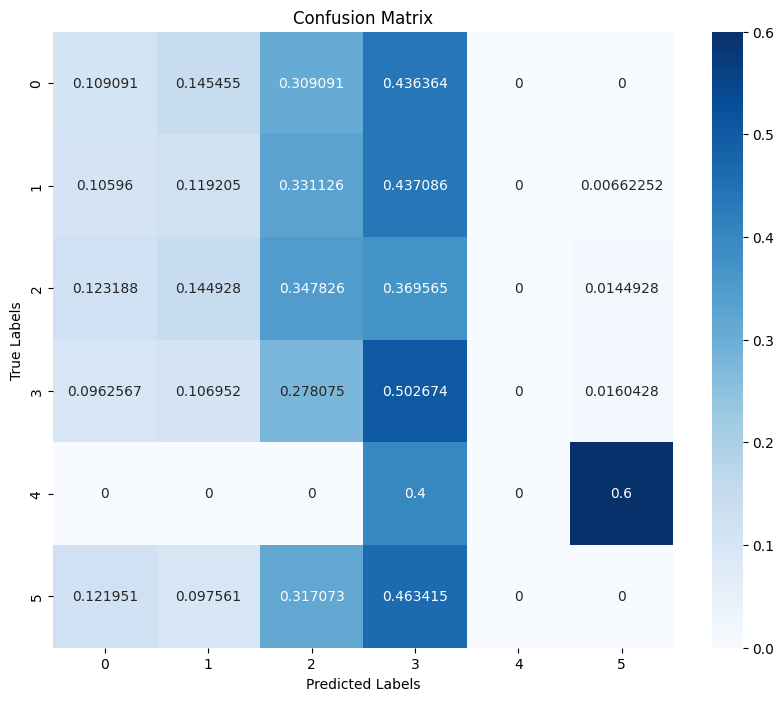

Epoch 6, Validation Loss: 2.9354, Accuracy: 0.2877, F1 Score: 0.2621
Val F1 Score Per Class  [0.1025641  0.16289593 0.30188679 0.42437923 0.         0.        ]


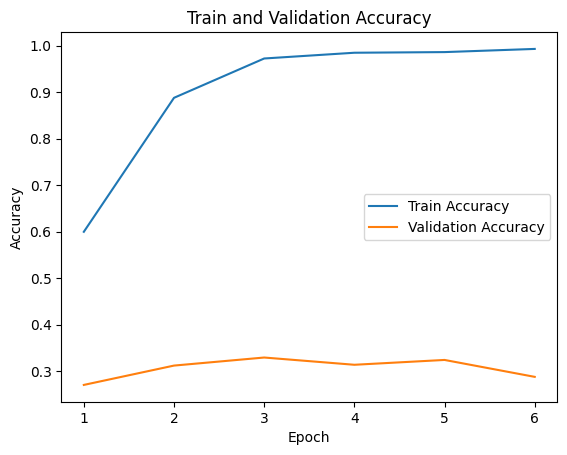

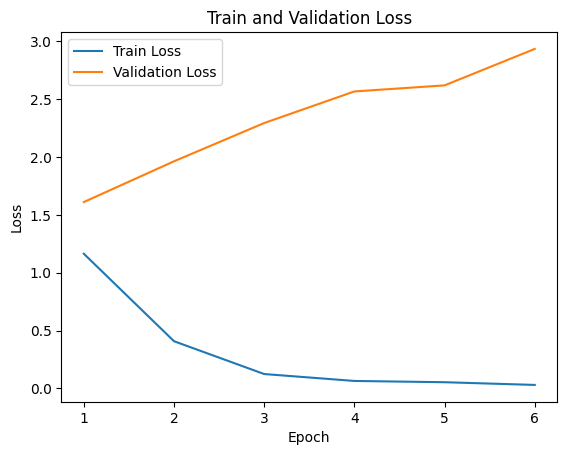

Epoch 7, Train Loss: 0.0274, Accuracy: 0.9930, F1 Score: 0.9930
Train F1 Score Per Class  [0.99529997 0.98910256 0.98887588 0.98544699 1.         0.99878714]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=4.24]

[tensor([-2.8190,  2.5721, -1.2187,  0.6950, -2.7167, -2.6752], device='cuda:0'), tensor([-2.4905,  3.0914,  0.1656, -1.3511, -2.8344, -2.7728], device='cuda:0'), tensor([-0.7967, -0.0629, -0.8820,  1.2582, -3.9929, -3.6974], device='cuda:0'), tensor([-1.6123, -0.8686, -2.5682,  4.3766, -2.3919, -1.4019], device='cuda:0'), tensor([-2.9019, -0.9114,  0.8560,  3.1665, -3.1991, -2.0520], device='cuda:0'), tensor([-3.3862,  2.2514, -0.1391,  0.7546, -2.9762, -3.0123], device='cuda:0'), tensor([-2.1386, -1.9985, -2.2290,  2.5159, -3.1615,  0.1444], device='cuda:0'), tensor([-2.4757, -1.8831,  4.8460,  0.8221, -2.1436, -1.9771], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.12it/s, loss=2.25]

[tensor([-1.0548,  4.7057, -1.8290, -1.0433, -2.7477, -2.1796], device='cuda:0'), tensor([-2.9739,  1.7269, -3.0963,  0.7647, -0.8163, -0.7806], device='cuda:0'), tensor([-0.2643, -1.6187,  1.7729,  0.7823, -3.3723, -2.7988], device='cuda:0'), tensor([-1.8163, -0.9851, -0.1824,  4.0618, -3.0019, -1.9862], device='cuda:0'), tensor([-1.0728,  5.5365, -1.5770, -1.2124, -2.1492, -1.9160], device='cuda:0'), tensor([-2.2404,  0.8237, -1.3930,  0.6340, -3.3943, -3.4031], device='cuda:0'), tensor([-0.9467, -1.8642, -1.0038,  4.6975, -3.0029, -2.6925], device='cuda:0'), tensor([ 0.1474,  0.1343, -1.4891,  1.8503, -4.1612, -3.6242], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=3.06]

[tensor([-3.2510, -0.8251,  2.5827, -0.3242, -2.6884, -3.0363], device='cuda:0'), tensor([-1.1759,  1.1607,  0.9185, -1.8440, -1.8073, -2.9112], device='cuda:0'), tensor([-2.0137, -1.4573,  5.5140, -0.6406, -1.8919, -1.9325], device='cuda:0'), tensor([-1.0358, -0.8797,  0.5899, -1.7330, -3.0018, -2.8571], device='cuda:0'), tensor([-1.7369,  1.7748, -2.0895,  2.4587, -2.2597, -2.8756], device='cuda:0'), tensor([-1.4936, -0.6479, -1.4672,  4.5254, -3.5198, -3.3381], device='cuda:0'), tensor([-1.7837, -1.4035, -0.2024, -0.1750, -2.8168, -3.1490], device='cuda:0'), tensor([ 0.3556, -0.1716, -0.9719, -0.6949, -2.7597, -2.5409], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=2.85]

[tensor([-2.5086, -1.4530,  1.0814,  3.3062, -2.9448, -2.8331], device='cuda:0'), tensor([-3.7213,  1.7294,  0.2590, -0.9137, -3.1829, -0.8918], device='cuda:0'), tensor([-1.7345, -1.2430, -2.1456,  3.2684, -3.4620, -0.5036], device='cuda:0'), tensor([-1.8200,  0.0304,  1.5916, -0.4481, -2.5435, -2.8774], device='cuda:0'), tensor([ 2.4087, -0.7900,  0.5987,  0.6800, -3.0537, -3.8871], device='cuda:0'), tensor([-1.7561, -1.7286, -1.1515,  1.6612, -3.3960, -1.0172], device='cuda:0'), tensor([-2.0532,  4.2089, -0.9104, -1.0392, -2.8405, -3.1426], device='cuda:0'), tensor([-3.3506,  0.3508,  2.1986, -0.9006, -2.1676, -1.4722], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=3.27]

[tensor([-1.9357, -1.5958, -1.0555,  5.1271, -2.4226, -2.6067], device='cuda:0'), tensor([-3.1274, -0.9129,  2.4437,  1.3672, -3.2666, -3.1619], device='cuda:0'), tensor([-1.9720, -0.0875,  3.7703, -1.7750, -2.2327, -2.4392], device='cuda:0'), tensor([-2.7675, -0.1019, -0.1847,  0.2138, -2.9169, -3.0898], device='cuda:0'), tensor([-1.9713, -1.3906,  5.4738, -0.6931, -2.4576, -2.2989], device='cuda:0'), tensor([-1.7818, -0.6056, -0.2242,  1.2143, -4.1590, -2.7129], device='cuda:0'), tensor([-2.5621,  1.1263, -0.3084, -1.1397, -3.6208, -1.5768], device='cuda:0'), tensor([-1.0140, -0.4726, -1.7143,  3.4565, -2.5851, -1.3566], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=3.83]

[tensor([-1.9767, -1.0338,  5.7895, -0.9725, -2.0477, -2.3074], device='cuda:0'), tensor([-2.2625,  0.3286,  4.1711, -1.9850, -2.2410, -2.3774], device='cuda:0'), tensor([-2.2647,  0.0761,  3.0962, -0.5824, -3.5605, -3.6824], device='cuda:0'), tensor([-1.5915,  5.0932, -1.5048, -0.7680, -2.5311, -1.9687], device='cuda:0'), tensor([-0.9710, -1.4259,  4.8795, -1.2147, -2.2116, -2.2513], device='cuda:0'), tensor([-1.3576, -1.8049, -0.7191, -0.8302, -3.4428, -1.8777], device='cuda:0'), tensor([-0.9048, -2.7061,  2.7009,  3.1171, -2.6683, -2.9667], device='cuda:0'), tensor([-2.0308, -2.2655,  0.6226,  1.3263, -2.6416, -2.9664], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=2.85]

[tensor([-0.8791,  1.6207,  0.5728, -0.9864, -3.5808, -2.3869], device='cuda:0'), tensor([-1.7952, -1.6431,  2.3478, -0.7015, -2.5290, -1.3871], device='cuda:0'), tensor([-0.9073,  0.5149,  4.1822, -1.7238, -2.1605, -2.9185], device='cuda:0'), tensor([-2.6459, -2.1847,  2.5307,  1.9199, -3.4984, -2.5747], device='cuda:0'), tensor([-2.6946,  3.6260,  2.2361, -1.6581, -2.5341, -3.6128], device='cuda:0'), tensor([-1.7754,  1.0251, -2.3588, -1.9550, -1.8145, -1.3243], device='cuda:0'), tensor([-2.2860, -2.3458,  4.6585, -0.7906, -2.6019, -1.3581], device='cuda:0'), tensor([-1.3233,  1.7508, -1.6747, -1.0838, -3.6705, -2.1356], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=4.12]

[tensor([-1.9423, -1.2869,  0.6600,  0.7966, -3.0194, -2.4448], device='cuda:0'), tensor([-2.2958, -1.9079,  2.5377,  0.7569, -2.6402, -2.3265], device='cuda:0'), tensor([-1.5371, -1.1780, -1.4082,  5.3136, -2.9742, -2.0868], device='cuda:0'), tensor([-1.2228,  5.6707, -1.8102, -0.8917, -1.7481, -2.2818], device='cuda:0'), tensor([-2.2449,  1.0102,  4.5207, -1.9397, -2.1453, -2.5687], device='cuda:0'), tensor([-0.8496,  2.6747, -1.2867,  0.1300, -2.9008, -3.2737], device='cuda:0'), tensor([-1.5423, -1.6973, -0.5954, -0.6716, -3.7738, -1.8050], device='cuda:0'), tensor([-2.2402, -1.2764,  5.1113, -0.3242, -2.1054, -2.0712], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.11it/s, loss=3.97]

[tensor([-2.2009, -1.7616, -1.7431,  3.6962, -3.8031, -1.3556], device='cuda:0'), tensor([-2.6827,  2.5290,  1.8159, -0.9568, -3.4971, -3.5203], device='cuda:0'), tensor([-0.3044,  4.2755, -2.7137,  0.0982, -1.2902, -1.9584], device='cuda:0'), tensor([-1.4597, -2.0889,  3.0542,  1.0177, -2.7345, -2.9055], device='cuda:0'), tensor([-0.9538, -1.0598, -0.3898,  1.8499, -1.9053, -3.0040], device='cuda:0'), tensor([-1.9554,  1.7855, -1.2260,  0.1671, -3.0319, -3.1291], device='cuda:0'), tensor([-2.5405, -0.5968, -1.7312,  4.1796, -3.2813, -1.6897], device='cuda:0'), tensor([-2.3556, -2.5754,  0.4483, -0.4943, -3.4704, -1.7208], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.11it/s, loss=2.83]

[tensor([-2.3189,  4.5133, -1.7838, -1.3627, -1.3432, -2.5350], device='cuda:0'), tensor([-2.0399, -1.9405,  1.3870,  0.3687, -2.4860, -3.0050], device='cuda:0'), tensor([-1.2060,  4.9683, -1.7755, -0.6252, -2.3138, -2.7491], device='cuda:0'), tensor([-2.9053,  1.8017,  1.6435, -0.1160, -2.7470, -2.4228], device='cuda:0'), tensor([-1.6884,  4.7445,  0.1024, -0.8318, -2.6494, -2.5244], device='cuda:0'), tensor([-1.2600, -0.5307,  1.1214,  3.0070, -3.3974, -4.1195], device='cuda:0'), tensor([-1.6344,  2.4630, -2.8534,  0.7970, -2.1192, -2.8642], device='cuda:0'), tensor([-1.9751,  4.9671, -1.5531,  0.1506, -2.7119, -2.7733], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:29,  2.13it/s, loss=3.69]

[tensor([-2.6402, -0.9614,  0.9841,  2.6577, -2.7372, -3.2969], device='cuda:0'), tensor([-1.0726,  1.7724, -1.9496,  1.0079, -3.3883, -2.9509], device='cuda:0'), tensor([-2.2288, -0.4969,  0.2339,  2.0051, -3.8405, -1.5757], device='cuda:0'), tensor([-2.3546, -0.6154, -0.5863,  4.4764, -3.6663, -2.6930], device='cuda:0'), tensor([-3.0774,  3.3407, -0.6885, -0.7120, -3.4580, -1.5972], device='cuda:0'), tensor([-1.1949,  2.4537, -1.9588,  0.5852, -3.4856, -3.2820], device='cuda:0'), tensor([-3.4516,  2.7811,  2.2414, -1.2427, -2.5816, -3.0198], device='cuda:0'), tensor([-1.4568, -0.4172, -1.1709,  3.4303, -2.4279, -3.3755], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.13it/s, loss=3.46]

[tensor([-1.7884, -1.4425,  5.5866, -1.0125, -1.9336, -2.4735], device='cuda:0'), tensor([-2.0255, -1.1807, -0.1100,  2.1835, -3.2220, -3.2518], device='cuda:0'), tensor([-2.9909,  0.2675,  4.4546, -0.4282, -2.4197, -3.4915], device='cuda:0'), tensor([-2.7333,  0.2903, -1.9011, -0.6577, -3.4490, -3.7609], device='cuda:0'), tensor([ 4.3448, -0.4142, -2.0642, -1.5520, -1.5274, -2.0368], device='cuda:0'), tensor([-1.8890, -1.0420,  5.5804, -0.8424, -2.3093, -2.3177], device='cuda:0'), tensor([-1.3420, -0.0757, -2.4103,  1.4965, -2.6106, -1.7770], device='cuda:0'), tensor([-1.0031, -0.3917,  2.9310, -0.2757, -2.8455, -3.0558], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.12it/s, loss=3.19]

[tensor([-1.9288,  0.2925,  3.2291, -0.3828, -2.9236, -3.6567], device='cuda:0'), tensor([-3.2202, -0.2120,  2.4748,  1.6789, -2.6550, -2.3396], device='cuda:0'), tensor([-2.5847e+00,  1.4743e-01,  2.5384e+00, -2.6332e-04, -3.7889e+00,
        -3.0059e+00], device='cuda:0'), tensor([-2.4417,  3.1823,  0.8778, -1.5600, -2.8518, -2.5927], device='cuda:0'), tensor([-2.4251,  4.6393, -2.4723, -0.6915, -2.3600,  0.3757], device='cuda:0'), tensor([-2.3859, -1.6973,  1.0174, -0.5956, -2.9679, -2.0986], device='cuda:0'), tensor([-2.5620,  3.5192, -1.8125,  0.8212, -3.2167, -2.6900], device='cuda:0'), tensor([-0.2979, -0.1484, -0.3174,  0.9784, -3.3179, -4.1443], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.13it/s, loss=2.09]

[tensor([-1.7593,  1.9158, -1.2030, -0.9291, -2.8066, -2.5651], device='cuda:0'), tensor([-2.3329,  2.5815, -0.7344, -0.2612, -3.4043, -2.9950], device='cuda:0'), tensor([-1.5870, -2.3813, -0.1909, -1.6542, -2.0781,  5.1827], device='cuda:0'), tensor([-2.0226,  1.9489,  1.4073, -0.8891, -2.8706, -3.6370], device='cuda:0'), tensor([-2.4386, -0.8003, -2.2056,  4.5122, -1.3466, -1.5385], device='cuda:0'), tensor([-2.2857,  4.1758, -1.8303,  0.7665, -2.4886, -2.3916], device='cuda:0'), tensor([ 0.8131, -0.0249, -2.0904, -0.6906, -3.1390, -2.9313], device='cuda:0'), tensor([-1.2881,  0.6261, -1.4941,  3.0638, -3.9850, -3.1764], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.13it/s, loss=3.69]

[tensor([-2.2135,  4.7096, -1.0040, -0.3594, -2.8861, -2.3698], device='cuda:0'), tensor([-1.8574,  3.9695, -1.8214, -1.0714, -1.6411, -1.7024], device='cuda:0'), tensor([-2.1322,  0.3720,  4.5288, -1.6481, -2.6628, -2.2777], device='cuda:0'), tensor([-1.7489, -1.4523, -1.0415,  4.8253, -3.2297, -2.3144], device='cuda:0'), tensor([-2.0656, -0.7674, -0.4505,  4.3456, -3.0721, -3.5902], device='cuda:0'), tensor([-2.1375,  4.3506, -0.7161, -1.0728, -2.9063, -3.5234], device='cuda:0'), tensor([-3.1515, -2.2129,  2.5027,  1.7818, -3.6631, -1.9752], device='cuda:0'), tensor([-2.2034,  0.4242,  4.4011, -0.6623, -2.6698, -4.0033], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.13it/s, loss=2.56]

[tensor([-2.3139, -1.0614, -0.9775,  5.1447, -2.8995, -2.5825], device='cuda:0'), tensor([-2.5060,  4.5579,  0.5382, -1.5255, -2.7794, -2.5306], device='cuda:0'), tensor([-1.6715, -0.8642, -1.4609,  4.7898, -2.7223, -2.8283], device='cuda:0'), tensor([-3.2216, -0.0910,  0.8379,  0.0799, -3.0983, -1.7490], device='cuda:0'), tensor([-2.3047, -1.9980,  0.1880,  1.5922, -2.8118, -2.5759], device='cuda:0'), tensor([-2.7143, -1.1710,  5.1935, -0.1737, -2.1803, -2.2715], device='cuda:0'), tensor([-2.6251, -0.2654, -0.5244,  4.6921, -3.3127, -2.7089], device='cuda:0'), tensor([-2.4689, -0.0923,  3.7443, -1.8759, -3.1041, -2.8314], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=3.4]

[tensor([-2.8035, -0.6929,  1.4002,  0.6016, -3.8305, -3.0600], device='cuda:0'), tensor([-1.6565,  2.4880,  2.2923, -1.6286, -2.5653, -2.6403], device='cuda:0'), tensor([-2.1497,  0.4489,  2.5884, -1.3046, -2.8630, -3.0082], device='cuda:0'), tensor([-2.9928, -0.7904, -0.5920,  2.9836, -3.9254, -3.3382], device='cuda:0'), tensor([-2.3266, -2.8574, -0.1588,  3.1133, -2.4073, -1.0535], device='cuda:0'), tensor([-2.0742, -0.8977, -0.7711, -1.0324, -3.2823, -2.5420], device='cuda:0'), tensor([-0.0746, -1.2754,  0.7385, -2.1301, -1.8781,  1.9959], device='cuda:0'), tensor([-1.2427, -1.6540, -1.4284,  3.2082, -2.5688, -2.5852], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=2.29]

[tensor([-2.8541, -1.4128,  0.9416,  0.7023, -3.2037, -3.2708], device='cuda:0'), tensor([ 0.3137, -1.2848, -1.1068,  3.7158, -1.9540, -3.0229], device='cuda:0'), tensor([-2.6529,  4.3343, -0.6928, -1.3428, -3.2331, -1.3060], device='cuda:0'), tensor([-2.2666,  0.0675, -1.0747,  3.3789, -3.2044, -3.8686], device='cuda:0'), tensor([-2.8017, -1.2295,  2.1935, -0.4746, -1.0659, -2.0688], device='cuda:0'), tensor([-0.8993,  0.7988, -0.9989, -1.1712, -2.7153, -2.3411], device='cuda:0'), tensor([-1.0088,  0.8316, -0.0827, -0.2474, -3.4635, -3.4741], device='cuda:0'), tensor([-2.9061,  0.5146, -0.9759,  1.7692, -2.3070, -2.4956], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.17it/s, loss=2.74]

[tensor([-2.3359, -1.7182, -1.0004,  4.3753, -2.7602, -2.1084], device='cuda:0'), tensor([-1.7493e-01, -2.0616e-03, -1.7501e+00, -6.5562e-01, -2.9224e+00,
        -3.9119e+00], device='cuda:0'), tensor([-1.9262, -0.0429,  4.9829, -0.3877, -2.1763, -2.8878], device='cuda:0'), tensor([-2.0778, -1.0400, -1.4360,  4.4810, -2.3884, -2.0102], device='cuda:0'), tensor([-2.1495,  4.9354, -1.3264, -0.3573, -3.2044, -2.8431], device='cuda:0'), tensor([-1.9065,  4.1722, -2.0352,  0.4316, -2.7194, -2.7476], device='cuda:0'), tensor([-2.6226, -1.8816,  0.0223,  1.5104, -3.3812, -0.4805], device='cuda:0'), tensor([-1.6887,  0.1480,  2.1324, -0.9901, -2.6948, -2.5384], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=3.77]

[tensor([-2.1353, -2.4674,  4.1143,  1.1194, -2.4773, -2.8039], device='cuda:0'), tensor([-2.0269,  2.0685, -3.3614, -0.5789, -1.7607, -0.7258], device='cuda:0'), tensor([-1.9463, -2.0156,  2.5849,  1.3342, -2.6994, -1.8577], device='cuda:0'), tensor([-0.8526, -1.9775,  4.0963, -0.5160, -2.8915, -3.1500], device='cuda:0'), tensor([-1.6501, -0.2480,  0.6011,  0.9514, -3.0723, -3.2605], device='cuda:0'), tensor([-2.5021,  1.9760, -0.9440,  0.3812, -3.3405, -3.0638], device='cuda:0'), tensor([-3.3190, -0.6088, -0.9915,  2.3395, -2.7777, -2.4070], device='cuda:0'), tensor([-2.9718, -0.0769,  3.2947, -0.0317, -3.3716, -3.1818], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.13it/s, loss=4.43]

[tensor([-1.5072, -1.5526,  3.8762, -0.6968, -3.5335, -2.3397], device='cuda:0'), tensor([-2.3435,  5.2308, -1.1640, -0.6473, -2.5034, -1.6648], device='cuda:0'), tensor([-2.7984,  3.1675,  2.1746, -1.7574, -2.8800, -2.3008], device='cuda:0'), tensor([-2.1037, -1.3352,  5.4370, -0.1020, -2.1726, -2.4183], device='cuda:0'), tensor([-1.7640, -1.8610, -0.4339,  5.0445, -2.9501, -2.3885], device='cuda:0'), tensor([-2.6534, -0.3421, -1.1621, -0.3936, -2.7339, -1.5172], device='cuda:0'), tensor([-1.9848, -2.0269, -0.4426,  4.9305, -2.4875, -2.5322], device='cuda:0'), tensor([-1.4695, -1.0619, -0.2420,  3.6647, -2.7248, -1.8041], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=1.99]

[tensor([-2.4205,  1.4166, -0.4102,  2.9611, -3.5955, -3.3825], device='cuda:0'), tensor([-2.1330, -0.5707,  0.1416,  0.5541, -2.1467, -2.1131], device='cuda:0'), tensor([-2.9162, -0.8765, -2.5999, -0.7833, -2.7941, -0.6521], device='cuda:0'), tensor([-2.0708, -1.6749, -0.5011,  4.3210, -2.8818, -1.3968], device='cuda:0'), tensor([-2.0953, -0.9124,  2.0518, -0.1954, -3.0006, -3.4861], device='cuda:0'), tensor([-0.6077, -2.8200,  2.1449,  3.0487, -2.6420, -3.1271], device='cuda:0'), tensor([-1.6230, -0.6712, -0.6357,  0.7413, -3.1872, -1.9738], device='cuda:0'), tensor([-3.2443, -0.5690,  3.7891, -0.3019, -2.4766, -2.8235], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.14it/s, loss=1.94]

[tensor([-2.0171,  3.3631, -1.8807, -0.5371, -1.8569, -3.1361], device='cuda:0'), tensor([-2.0569, -0.1996, -1.1659,  2.7541, -3.4700, -3.3311], device='cuda:0'), tensor([-1.9094, -0.5291, -1.4795,  4.4294, -1.8194, -2.5851], device='cuda:0'), tensor([-2.4976,  3.3076, -2.5437, -0.3017, -2.7896, -1.5130], device='cuda:0'), tensor([-2.5248, -0.0827,  1.0894,  2.0423, -3.6766, -3.2983], device='cuda:0'), tensor([-1.0418, -0.8496, -2.2644,  5.0094, -2.2160, -2.7045], device='cuda:0'), tensor([-1.2271, -2.3661,  0.9152,  1.2751, -2.4560, -2.7551], device='cuda:0'), tensor([-2.9916, -0.1608,  2.6788, -1.5520, -2.2720, -2.8381], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:23,  2.13it/s, loss=2.34]

[tensor([-0.6284, -0.9940, -2.7383,  1.8427, -2.5682, -2.8989], device='cuda:0'), tensor([-2.4588, -1.5379,  0.5079,  1.3188, -2.9012, -2.9450], device='cuda:0'), tensor([-1.5069, -1.1560, -1.2087,  4.3519, -2.5146, -3.2848], device='cuda:0'), tensor([-1.2253, -0.9287,  5.3267, -1.4434, -1.9841, -2.9018], device='cuda:0'), tensor([-3.2586,  2.6663,  0.8060, -1.2038, -2.0696, -2.4679], device='cuda:0'), tensor([-1.4619,  1.1151, -1.1145, -0.9600, -2.1322, -3.5185], device='cuda:0'), tensor([-2.7966, -0.2347, -2.5025,  3.4732, -2.0033, -1.1941], device='cuda:0'), tensor([-1.4055, -1.6197, -1.4478,  3.3461, -3.7446, -2.8496], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.13it/s, loss=3.11]

[tensor([-2.1663, -0.7409, -0.4396,  4.0445, -3.9239, -1.7820], device='cuda:0'), tensor([-2.2628,  3.0498, -1.0100,  0.7479, -3.1286, -2.0807], device='cuda:0'), tensor([-1.5231,  4.7451, -1.4630, -1.1191, -2.1106, -2.6437], device='cuda:0'), tensor([-2.1180, -0.9023,  5.6112, -0.7109, -2.1073, -2.3301], device='cuda:0'), tensor([-0.8099, -1.6065,  2.8434, -0.0204, -2.9554, -3.7092], device='cuda:0'), tensor([-1.4744,  5.2233, -0.4176, -1.6980, -2.2148, -1.7631], device='cuda:0'), tensor([-2.6521,  1.3377, -2.1445, -0.6696, -3.9436, -2.5789], device='cuda:0'), tensor([-2.1727,  0.4531, -2.3972,  3.6756, -3.2016, -1.2006], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:22,  2.14it/s, loss=3.62]

[tensor([-1.1413,  5.0055, -1.6432, -1.0428, -2.9415, -1.5012], device='cuda:0'), tensor([-2.3371, -0.2048,  3.3936, -1.2508, -3.0214, -1.6329], device='cuda:0'), tensor([-2.2785,  2.7591,  1.4877, -0.5397, -3.1244, -3.3462], device='cuda:0'), tensor([-1.6362, -0.4092,  3.8509, -1.1164, -2.7601, -3.3769], device='cuda:0'), tensor([-1.7711,  2.0518, -0.6121, -0.4705, -3.4813, -4.0386], device='cuda:0'), tensor([-2.5755, -1.7950,  5.2692,  0.4124, -2.2481, -1.6621], device='cuda:0'), tensor([-1.0748, -1.9628,  1.2565,  0.5673, -2.9193, -3.2788], device='cuda:0'), tensor([-1.8358, -2.1968,  1.7548,  1.2516, -2.4532, -2.3249], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.13it/s, loss=2.06]

[tensor([-1.5738, -0.8248, -2.6475, -0.5382, -2.1571,  4.0541], device='cuda:0'), tensor([-2.1923,  3.1838,  2.8065, -1.9935, -2.3895, -2.6848], device='cuda:0'), tensor([-1.9129, -1.1662, -1.3435,  1.8706, -2.8416, -2.4310], device='cuda:0'), tensor([-2.2997, -0.3913, -1.0218,  2.4357, -1.7618, -2.5040], device='cuda:0'), tensor([-2.3666,  2.4972, -1.2884, -0.1355, -2.7708, -2.6643], device='cuda:0'), tensor([-2.6410,  4.0791,  0.1051,  0.1553, -2.8642, -3.4824], device='cuda:0'), tensor([-2.6567,  0.1149,  2.4016, -1.6690, -2.5328, -2.7742], device='cuda:0'), tensor([-2.9149,  2.3450, -1.5962,  1.0582, -3.1238, -3.0151], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.13it/s, loss=2.71]

[tensor([-1.1402, -0.7075,  4.6010, -1.4388, -2.4700, -2.4254], device='cuda:0'), tensor([-2.2845, -2.0390,  2.0751,  2.4042, -3.3897, -3.1091], device='cuda:0'), tensor([-2.2553, -0.9054,  1.4398,  0.5337, -3.3572, -3.0304], device='cuda:0'), tensor([-0.9280, -2.3343,  2.7287,  0.4835, -3.2645, -1.6615], device='cuda:0'), tensor([-2.4925,  0.6129,  4.4368, -0.4683, -2.7195, -3.0107], device='cuda:0'), tensor([-2.4742,  5.0590, -0.3515, -1.6651, -1.8136, -1.2451], device='cuda:0'), tensor([-1.6711, -1.8559,  3.4885,  0.3865, -2.6730, -1.6962], device='cuda:0'), tensor([-1.5021,  0.0378,  3.8202, -1.0572, -2.4440, -2.7138], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.14it/s, loss=3.23]

[tensor([ 3.6325, -1.8291, -0.1856, -0.9293, -2.7285, -1.4098], device='cuda:0'), tensor([-2.6894, -0.4351,  2.3029, -1.2600, -2.6444, -2.4843], device='cuda:0'), tensor([-0.2562, -1.2214, -1.3160,  4.4610, -2.6217, -3.2682], device='cuda:0'), tensor([-1.3516, -0.9157,  3.5000, -0.0785, -2.3299, -2.4672], device='cuda:0'), tensor([ 0.3221,  3.1286, -2.6208, -0.1298, -2.0770, -3.0264], device='cuda:0'), tensor([-2.5373, -1.8775,  2.0313,  0.9814, -3.3679, -2.2353], device='cuda:0'), tensor([-2.6187, -0.1290,  3.5705, -0.4618, -2.9497, -2.5708], device='cuda:0'), tensor([-2.7569,  4.5057, -0.7464, -0.8162, -2.0470, -1.9368], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.14it/s, loss=3.91]

[tensor([-2.1453,  4.5368, -1.1433, -0.3547, -3.0578, -3.4320], device='cuda:0'), tensor([-3.1989, -0.8584,  2.2345,  0.7107, -3.0881, -2.5604], device='cuda:0'), tensor([-2.1778,  4.4704, -1.5286,  0.3387, -3.4060, -2.1585], device='cuda:0'), tensor([-3.0816,  1.4815, -0.6556,  1.8355, -2.6586, -1.9499], device='cuda:0'), tensor([-1.0085, -0.8100, -2.5003,  1.2820, -1.4934, -2.8933], device='cuda:0'), tensor([-1.6395, -1.2405,  4.3846, -0.8917, -2.3996, -3.0239], device='cuda:0'), tensor([-1.4361, -1.4799,  1.7821,  1.5709, -2.7608, -2.2072], device='cuda:0'), tensor([-0.8547, -0.0294, -2.4518,  2.9063, -2.9657, -1.1846], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=2.17]

[tensor([-1.4831, -2.5511,  1.4827,  3.7191, -2.6155, -2.0618], device='cuda:0'), tensor([-1.3447, -1.8650, -1.1478,  1.2256, -3.8399, -3.5079], device='cuda:0'), tensor([-1.6189, -2.1830,  0.4790,  3.8049, -3.0506, -2.2929], device='cuda:0'), tensor([-0.4557, -1.8107,  1.7985,  0.4748, -3.2681, -2.9316], device='cuda:0'), tensor([-0.5726, -1.1844,  1.4194, -0.9954, -3.0630, -4.0479], device='cuda:0'), tensor([-2.3115, -0.7263, -2.5031,  1.7117, -2.7527, -1.0892], device='cuda:0'), tensor([-0.9053,  5.0734, -1.5991, -1.2183, -2.2573, -2.6529], device='cuda:0'), tensor([-2.1340, -1.0784, -0.6651,  4.9437, -2.7932, -3.5489], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=2.03]

[tensor([-2.9582,  1.2606,  1.5596, -1.5667, -2.5673, -1.1771], device='cuda:0'), tensor([-0.6434,  0.2499,  0.2916,  1.4789, -3.0632, -4.0997], device='cuda:0'), tensor([-2.8380,  0.4494, -1.5017,  2.1843, -3.1510, -3.5162], device='cuda:0'), tensor([-2.3283, -1.3831,  0.1352,  2.1185, -3.2011, -3.0453], device='cuda:0'), tensor([-2.5495, -2.1558,  3.6013, -1.3236, -2.3803, -1.7266], device='cuda:0'), tensor([-1.0446,  2.2647, -3.3495, -0.5872, -2.7051, -1.1595], device='cuda:0'), tensor([-2.9703, -0.1844,  3.2261, -0.9735, -3.3844, -0.5604], device='cuda:0'), tensor([-0.8434, -0.8657, -1.9081, -0.2477, -1.3718, -2.8816], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.15it/s, loss=2.31]

[tensor([-1.9991,  1.0239, -1.2118,  1.5241, -3.3552, -3.3472], device='cuda:0'), tensor([-1.0876, -0.4234, -1.4981,  0.5959, -2.0074, -2.6430], device='cuda:0'), tensor([-2.2876, -0.0439, -0.3079, -0.6383, -3.0750, -3.3946], device='cuda:0'), tensor([-2.8029,  3.1440, -2.1169,  0.5418, -2.5031, -1.3695], device='cuda:0'), tensor([-1.6643,  0.9893, -1.8256,  1.3231, -2.5890, -3.2457], device='cuda:0'), tensor([-3.0116,  1.0568, -0.0934,  0.1945, -2.7776, -2.7837], device='cuda:0'), tensor([-2.4754,  0.1158,  0.4184,  1.6165, -3.4009, -3.8650], device='cuda:0'), tensor([ 1.2382, -2.1771,  0.1809,  3.1483, -3.2506, -3.2774], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.21]

[tensor([-2.3450, -0.5719,  3.5437,  0.7892, -3.1863, -3.6888], device='cuda:0'), tensor([-2.7937, -1.3386,  3.0686,  0.1174, -3.0014, -3.1019], device='cuda:0'), tensor([-2.0345,  1.0380,  4.5087, -1.8104, -2.1667, -2.7705], device='cuda:0'), tensor([-0.6542, -2.3421,  1.6704,  0.4071, -3.4131, -2.6963], device='cuda:0'), tensor([-1.8317,  0.2837, -1.3489,  3.6797, -3.2594, -2.7517], device='cuda:0'), tensor([-2.2770,  0.3090,  5.1724, -1.6227, -2.4617, -1.9775], device='cuda:0'), tensor([ 4.6991, -1.7559,  0.6861, -0.8312, -2.7089, -2.0757], device='cuda:0'), tensor([-1.1573,  2.2359,  0.5053, -0.6428, -3.7438, -3.1436], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.14it/s, loss=2.58]

[tensor([-1.6542, -0.8377, -1.4266,  4.8837, -2.5667, -3.3059], device='cuda:0'), tensor([-2.3336,  2.0377,  2.3652, -2.6475, -2.6149, -1.6386], device='cuda:0'), tensor([-0.4942, -0.1731, -2.5779,  0.8818, -3.2590, -2.8763], device='cuda:0'), tensor([ 1.1923, -2.5198,  0.1145,  0.0998, -3.5302, -3.4527], device='cuda:0'), tensor([-1.4372, -0.7934,  2.4035, -0.4732, -2.4164, -1.6745], device='cuda:0'), tensor([-1.5097, -1.6028, -0.6163,  4.6461, -2.6846, -2.0909], device='cuda:0'), tensor([-1.9472,  0.2994, -0.4437,  0.6722, -3.2922, -3.9414], device='cuda:0'), tensor([-1.0929,  4.4502, -2.8062, -1.0977, -1.6125, -0.9659], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.15it/s, loss=2.73]

[tensor([-2.5828,  3.1397, -2.3384,  1.1451, -2.7063, -2.1406], device='cuda:0'), tensor([ 5.5503, -2.0120, -0.3671, -0.5282, -2.2484, -2.3833], device='cuda:0'), tensor([-2.1804,  1.5309, -1.9099, -0.1101, -1.8743, -3.3155], device='cuda:0'), tensor([-2.0547,  2.9406, -0.3315, -0.4960, -2.8292, -3.0851], device='cuda:0'), tensor([-0.9213, -2.0303,  0.4137,  2.1042, -2.9597, -4.2311], device='cuda:0'), tensor([-1.8223,  4.9202, -1.5123, -0.6367, -0.9843, -2.7315], device='cuda:0'), tensor([-3.1209,  1.4828,  1.1316, -0.1772, -3.8635, -2.1154], device='cuda:0'), tensor([-2.3808,  4.5461, -0.4991, -1.3325, -2.1333, -2.4410], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.15it/s, loss=4.61]

[tensor([-2.0820, -1.1351, -1.3189,  3.3595, -2.7187, -2.0049], device='cuda:0'), tensor([-1.9106,  4.2822, -2.2394, -1.0716, -1.8390, -1.5311], device='cuda:0'), tensor([-1.4498, -0.8752, -1.4862,  3.2863, -3.7127, -2.5351], device='cuda:0'), tensor([-2.1056, -0.2255,  5.7039, -1.3039, -2.1825, -2.3944], device='cuda:0'), tensor([-1.3394,  4.6280, -1.7873, -1.6325, -1.8995, -1.7897], device='cuda:0'), tensor([-2.1224,  0.9866, -0.4423, -0.4134, -2.7661, -2.6920], device='cuda:0'), tensor([-2.1284,  3.1030, -0.4227, -1.5694, -2.9266, -2.4921], device='cuda:0'), tensor([-2.7191,  4.0518, -0.5495, -0.1734, -2.6265, -2.0699], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=3.87]

[tensor([-2.1182,  0.3493, -3.2484,  0.7874, -1.2219,  0.3152], device='cuda:0'), tensor([-2.5463, -0.4390,  2.2507,  0.2882, -1.5125, -2.3107], device='cuda:0'), tensor([-1.5587, -1.5364, -0.0107,  5.1097, -2.3137, -2.6317], device='cuda:0'), tensor([-1.9472, -1.1903,  5.3616, -1.0941, -2.1345, -2.4006], device='cuda:0'), tensor([-1.3108, -1.4721,  4.9911, -1.1571, -2.5961, -1.9162], device='cuda:0'), tensor([-1.3955, -1.2876, -0.4144,  2.5779, -3.2456, -3.0783], device='cuda:0'), tensor([-2.4059,  1.3333, -2.5878,  2.2884, -3.1350, -1.2716], device='cuda:0'), tensor([ 9.5800e-04,  4.4249e+00, -2.5937e+00, -6.0320e-01, -1.6434e+00,
        -2.6790e+00], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=2.22]

[tensor([-1.9644, -0.0243,  4.9035, -0.6356, -2.4911, -3.2389], device='cuda:0'), tensor([-2.1325, -1.0436, -2.1290,  2.3429, -1.4991, -0.2167], device='cuda:0'), tensor([ 0.0051,  0.0666, -2.3543,  2.0060, -2.5956, -3.3067], device='cuda:0'), tensor([-2.4286,  2.8351, -1.0679,  1.0102, -3.3672, -3.8300], device='cuda:0'), tensor([-1.9183, -1.0216,  0.5212,  1.8807, -3.0330, -3.7440], device='cuda:0'), tensor([-1.1843, -2.6389,  3.8131,  0.7715, -2.3365, -2.6640], device='cuda:0'), tensor([-1.4594, -0.3938, -2.1239,  2.0357, -1.1373, -3.1719], device='cuda:0'), tensor([-3.0219, -0.2911,  3.2143,  0.7872, -2.6272, -3.0464], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=3.33]

[tensor([-2.0265,  4.4251, -2.6882, -0.8118, -0.9195, -1.8702], device='cuda:0'), tensor([-2.2423, -1.4902, -0.9318,  4.9438, -2.8324, -1.4534], device='cuda:0'), tensor([-3.0759,  3.2763, -0.0064, -0.3236, -2.8490, -2.4246], device='cuda:0'), tensor([-1.6709, -1.3989,  5.4293, -1.6567, -1.6228, -1.8766], device='cuda:0'), tensor([-0.6156,  0.9568, -2.3335,  1.8535, -1.9442, -3.3250], device='cuda:0'), tensor([-2.9075, -2.0828,  3.0743,  0.9625, -2.9182, -1.9669], device='cuda:0'), tensor([-2.6044, -1.6694,  2.3680,  1.3221, -3.6760, -2.9793], device='cuda:0'), tensor([-0.5771, -1.4841,  0.8601,  0.7820, -0.7149, -2.3959], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.16it/s, loss=2.74]

[tensor([-1.5330, -1.1515, -1.2369,  5.2264, -2.1667, -3.2063], device='cuda:0'), tensor([-1.6375, -1.7191, -1.5837,  4.4231, -3.6256, -2.4629], device='cuda:0'), tensor([-2.6045, -0.7787, -0.7436,  3.2352, -3.3060, -3.0888], device='cuda:0'), tensor([ 0.3967,  0.1902, -2.8303,  1.3892, -3.0199, -1.4235], device='cuda:0'), tensor([-2.4797,  0.4581,  0.0389,  1.9560, -3.2338, -2.8870], device='cuda:0'), tensor([-2.5347, -0.9973,  5.1151, -0.3712, -1.9291, -2.2545], device='cuda:0'), tensor([-1.3642,  0.5705, -1.6434,  0.4187, -3.3285, -3.0184], device='cuda:0'), tensor([-0.9672, -2.0141,  2.9311,  0.5655, -2.8895, -2.4709], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=2.84]

[tensor([-2.8712,  1.3015, -1.7252,  0.3320, -3.1927, -1.5265], device='cuda:0'), tensor([-1.9205, -1.6159, -0.8727,  4.5793, -3.3061, -2.7644], device='cuda:0'), tensor([ 4.4352, -1.3129, -0.7167, -2.1879, -2.5510, -1.3532], device='cuda:0'), tensor([-2.4068,  0.9220, -1.7307, -0.2839, -1.9988, -2.0642], device='cuda:0'), tensor([-1.5699, -0.9637, -2.3872,  3.9594, -2.6240, -2.2869], device='cuda:0'), tensor([-0.4703,  1.8985, -3.3860,  0.1356, -1.3014, -0.0942], device='cuda:0'), tensor([-1.5802,  2.3475, -0.9143, -0.2554, -3.3307, -3.3789], device='cuda:0'), tensor([-1.4939,  3.9265, -0.1486, -2.1921, -2.7170, -1.3517], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.17it/s, loss=1.93]

[tensor([-2.4862,  1.5122, -2.2612,  2.3790, -2.9252, -2.6442], device='cuda:0'), tensor([-2.8925, -0.9325, -1.0655, -1.7058, -2.2185, -1.5141], device='cuda:0'), tensor([-2.7494, -1.4602,  0.2716,  2.1946, -3.3541, -1.1948], device='cuda:0'), tensor([-1.5764, -1.8686,  0.5187,  3.5964, -3.6333, -3.2134], device='cuda:0'), tensor([-2.4932, -0.0380,  3.0878,  0.6385, -3.1448, -3.1437], device='cuda:0'), tensor([-1.9248, -0.6380, -2.3157,  0.6310, -3.5468, -2.6224], device='cuda:0'), tensor([-1.1496, -2.5122,  1.5026,  1.6899, -3.0086, -3.4474], device='cuda:0'), tensor([ 0.0648, -0.0243, -1.8767, -0.7517, -2.3959, -2.9493], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.16it/s, loss=2.93]

[tensor([ 0.0738,  1.3985, -1.3497,  0.7579, -2.5034, -3.4944], device='cuda:0'), tensor([-0.5877, -2.5546,  0.6227,  2.2412, -2.7005, -2.9812], device='cuda:0'), tensor([-3.3934, -0.6654, -1.3896,  0.1644, -3.2670, -2.5705], device='cuda:0'), tensor([-3.2303,  1.7966, -1.0668,  1.4036, -3.4734, -2.2401], device='cuda:0'), tensor([-1.7134, -1.1929, -1.3142,  0.9568, -0.3106, -0.3727], device='cuda:0'), tensor([-2.6692,  5.2957,  0.1199, -1.2485, -2.6676, -2.1767], device='cuda:0'), tensor([-2.0985, -0.6862,  3.4819, -0.2083, -2.6907, -2.2942], device='cuda:0'), tensor([-0.8985,  3.6171,  0.5697, -1.9177, -2.5208, -1.4983], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.15it/s, loss=2.57]

[tensor([-2.0397, -0.6786, -0.8077,  0.0252, -3.5355, -2.4708], device='cuda:0'), tensor([-2.0348,  1.1248, -2.6501,  0.5921, -1.5171, -2.0248], device='cuda:0'), tensor([-2.8963,  3.0944, -1.1015,  0.3444, -3.1166, -2.4812], device='cuda:0'), tensor([-1.5786,  1.7122, -0.4536, -1.5922, -2.4285, -3.3241], device='cuda:0'), tensor([-1.7732, -1.3254,  5.6781, -0.8527, -1.8553, -1.7760], device='cuda:0'), tensor([-2.7298,  0.8150, -1.3518, -0.6349, -3.9348,  1.3919], device='cuda:0'), tensor([-3.1648,  1.9283,  2.4165, -0.4208, -3.3976, -2.7745], device='cuda:0'), tensor([-2.2713,  1.1236, -2.3456, -0.4657, -3.0365, -0.7395], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.14it/s, loss=2.32]

[tensor([-1.9747, -0.4302,  5.0113, -1.5318, -2.2178, -2.4715], device='cuda:0'), tensor([-1.5418,  0.8402, -0.7337,  0.7176, -1.3965, -1.2001], device='cuda:0'), tensor([-2.5213,  0.9161, -2.0497,  3.8224, -2.0913, -2.5748], device='cuda:0'), tensor([-1.0928, -2.1224,  2.8390, -0.9468, -3.1683, -2.2893], device='cuda:0'), tensor([-2.8975, -1.2028, -1.5130,  3.9037, -2.3815, -1.4046], device='cuda:0'), tensor([-1.3671,  2.5046, -2.9228, -1.0929, -1.2274, -1.4130], device='cuda:0'), tensor([-2.3305, -0.1603,  0.4567,  0.4376, -3.3554, -2.5794], device='cuda:0'), tensor([-2.0539, -0.4200,  3.7987, -0.6462, -2.3704, -3.2508], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.14it/s, loss=1.72]

[tensor([ 5.7632, -0.9746, -1.8357, -1.0193, -1.6645, -1.3088], device='cuda:0'), tensor([-1.6405, -1.5626,  0.1070,  4.3085, -3.6978, -2.6976], device='cuda:0'), tensor([-2.2460, -1.6784,  3.3356,  0.1516, -2.3748, -2.6217], device='cuda:0'), tensor([-2.8434,  2.5421,  2.5522, -0.9530, -2.8958, -3.0019], device='cuda:0'), tensor([-1.6621,  3.1903,  1.0663, -1.1973, -2.9609, -3.9975], device='cuda:0'), tensor([-0.9230,  0.6459, -2.1178,  0.0572, -3.0999, -3.2252], device='cuda:0'), tensor([-1.8649, -1.8707,  2.2621,  0.6319, -1.6007, -3.5849], device='cuda:0'), tensor([-2.4509, -1.8407, -0.2921,  4.2912, -2.9719, -1.9348], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=2.45]

[tensor([-1.2452, -1.4481,  5.7745, -1.2882, -2.4146, -1.6633], device='cuda:0'), tensor([-2.1792,  4.4204, -1.8517,  0.0493, -2.2161, -2.2437], device='cuda:0'), tensor([-2.5039,  5.2066, -0.8330, -1.1863, -2.6796, -2.0626], device='cuda:0'), tensor([-2.6335,  3.0294, -0.0392, -0.3622, -3.7784, -3.6097], device='cuda:0'), tensor([-2.1043, -1.1353, -1.2169,  1.6816, -3.2643, -2.8007], device='cuda:0'), tensor([ 1.9561,  1.8845, -2.0330, -1.7879, -1.9237, -1.7256], device='cuda:0'), tensor([-2.2593, -1.0671,  2.6292,  0.7560, -3.1233, -3.0391], device='cuda:0'), tensor([-2.7058, -0.8735,  0.2369,  1.9560, -2.9163, -2.9529], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.14it/s, loss=2.8]

[tensor([-2.7452,  0.2698,  3.1690, -0.5139, -2.5280, -3.3134], device='cuda:0'), tensor([-0.7410,  2.2358, -1.8022, -0.5184, -2.5103, -3.0929], device='cuda:0'), tensor([-2.6339, -0.4750,  3.1588,  0.0859, -2.1954, -3.1138], device='cuda:0'), tensor([-1.9241,  0.5794,  3.3232, -1.5197, -3.0390, -2.3799], device='cuda:0'), tensor([-1.8901,  5.3188, -1.0705, -0.7517, -2.3995, -1.6794], device='cuda:0'), tensor([-1.0724, -1.1420, -0.9137,  2.8230, -2.7219, -2.7701], device='cuda:0'), tensor([-2.4263,  3.5281, -2.1469, -0.0275, -3.2563, -0.7052], device='cuda:0'), tensor([-2.9293, -1.2729, -0.1957,  3.1447, -2.9492, -2.4639], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=2.63]

[tensor([-1.2013, -0.6111,  0.5786,  0.3256, -3.3332, -2.9078], device='cuda:0'), tensor([-1.7151, -0.2467,  0.4218, -0.8223, -3.0623, -3.1863], device='cuda:0'), tensor([-2.7968, -0.4869,  2.6030,  1.3660, -2.6305, -2.4535], device='cuda:0'), tensor([-1.7572,  1.1978,  0.5541, -0.2607, -4.5028, -2.9767], device='cuda:0'), tensor([-2.3738, -1.6913,  4.9751, -0.8596, -2.2535, -1.9974], device='cuda:0'), tensor([-1.9839, -0.8908, -1.9163,  4.9522, -2.3088, -1.5368], device='cuda:0'), tensor([-2.0969, -1.5411,  0.8587,  3.1913, -3.0307, -1.0454], device='cuda:0'), tensor([-2.6652,  1.5459, -0.9548, -0.1997, -3.1868, -3.2072], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.16it/s, loss=1.94]

[tensor([-1.8327, -1.2886,  3.7518,  0.3152, -2.9734, -2.9750], device='cuda:0'), tensor([-1.7144, -2.3132, -1.3090,  4.9744, -2.6616, -1.1187], device='cuda:0'), tensor([-3.0518,  0.5419,  1.1441,  0.2145, -2.8449, -2.3581], device='cuda:0'), tensor([-2.1225, -0.3513, -0.8807,  4.0166, -3.1956, -3.2775], device='cuda:0'), tensor([-2.4969,  3.3108,  0.7177, -1.3757, -3.4893, -2.7079], device='cuda:0'), tensor([-0.0590, -0.3785, -3.0374,  2.3705, -2.8297, -1.7543], device='cuda:0'), tensor([-2.0523, -0.4609, -1.2104,  3.8317, -3.3689, -2.2882], device='cuda:0'), tensor([-1.3001, -0.0395, -0.9650, -2.8753, -2.6756,  3.9088], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.17it/s, loss=2.62]

[tensor([-2.8285,  1.5139,  1.0270, -0.6584, -3.3448, -2.5630], device='cuda:0'), tensor([-1.3837, -1.7037,  0.2493,  4.7629, -2.4954, -3.4826], device='cuda:0'), tensor([-1.1251,  1.3546, -2.0767, -0.3748,  0.0572, -3.6702], device='cuda:0'), tensor([-2.0806,  2.6365, -2.0477,  0.0949, -2.4954, -1.6320], device='cuda:0'), tensor([-2.8142,  1.7653,  2.0396, -1.1019, -3.0860, -1.4022], device='cuda:0'), tensor([-1.6950,  5.3613, -2.0870, -1.2128, -1.9777, -1.8912], device='cuda:0'), tensor([ 2.0069, -2.7967,  2.2005,  0.3311, -2.3719, -2.4113], device='cuda:0'), tensor([-1.7500,  4.6091, -0.5663, -0.7389, -2.8076, -2.2254], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.17it/s, loss=2.14]

[tensor([-1.7975,  3.8634, -2.4458,  1.0070, -2.4827, -2.4732], device='cuda:0'), tensor([-1.3662, -0.6796,  1.2878,  1.0889, -3.5381, -3.2306], device='cuda:0'), tensor([-2.1288, -0.5051, -1.2613, -0.0123, -4.1353, -1.1336], device='cuda:0'), tensor([-1.2841,  1.3438, -1.4658,  1.1284, -2.7840, -3.1162], device='cuda:0'), tensor([ 3.4157, -1.1711,  0.3978, -1.3997, -2.4738, -2.3986], device='cuda:0'), tensor([-0.8224, -0.9068, -1.1717,  2.4110, -4.0230, -4.0958], device='cuda:0'), tensor([-0.8081, -1.8517,  2.9213,  2.3515, -3.7473, -2.5832], device='cuda:0'), tensor([-2.5952, -0.7496, -0.6202,  1.0814, -2.5625, -3.5782], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.17it/s, loss=3.17]

[tensor([-1.7970, -1.9302,  1.8489,  1.5784, -2.9942, -2.4560], device='cuda:0'), tensor([ 0.6854, -2.4235,  3.4175,  1.2427, -3.4028, -3.4312], device='cuda:0'), tensor([-2.0273, -1.3848,  0.5526,  0.4593, -3.1450, -2.3797], device='cuda:0'), tensor([-1.5292, -1.5668, -1.2900,  5.2578, -2.6875, -1.7045], device='cuda:0'), tensor([-2.5378, -2.0298,  2.7798,  0.6755, -2.9492, -2.3263], device='cuda:0'), tensor([-2.4230,  0.4972, -2.4091,  0.4361, -3.1237, -0.3869], device='cuda:0'), tensor([-1.7467,  4.0501,  0.5673, -1.1251, -2.4778, -3.3894], device='cuda:0'), tensor([-2.1452,  2.6453,  0.6229, -2.2823, -2.6636, -2.1123], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.17it/s, loss=3.84]

[tensor([-1.9000, -1.1901,  5.6817, -0.8222, -1.8184, -1.9957], device='cuda:0'), tensor([-0.6815,  3.1441, -1.0170, -1.1674, -2.7481, -3.7581], device='cuda:0'), tensor([-1.0701,  4.3613, -0.7734, -0.8574, -1.8913, -3.4366], device='cuda:0'), tensor([-2.5953,  0.7448,  1.1976, -1.2502, -3.0355, -2.4212], device='cuda:0'), tensor([-1.6831,  5.1871, -1.1803, -1.3410, -1.8598, -1.6969], device='cuda:0'), tensor([-1.0274, -0.8953,  3.4778, -1.1754, -2.3249, -2.3379], device='cuda:0'), tensor([-2.6232, -1.5633, -0.1706,  2.4976, -2.9380, -2.2065], device='cuda:0'), tensor([-1.3015,  5.1776, -0.5983, -1.1253, -2.6100, -2.7404], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.16it/s, loss=3.64]

[tensor([-2.4436,  0.7025,  4.0995, -1.7753, -2.6237, -1.9932], device='cuda:0'), tensor([-1.4596, -0.6214, -3.1996,  3.5157, -0.6443, -1.5653], device='cuda:0'), tensor([-2.8746, -1.3450,  4.3270, -0.4648, -2.9517, -1.6799], device='cuda:0'), tensor([-2.7233,  0.9384,  1.8964, -0.2404, -3.0772, -3.6056], device='cuda:0'), tensor([-2.3386,  4.9963, -1.8187, -0.2534, -2.3707, -2.5060], device='cuda:0'), tensor([-1.7419, -2.8344, -0.0214,  0.3472, -3.1254,  0.2334], device='cuda:0'), tensor([-2.3027, -1.0241, -0.8730,  1.9144, -3.4881, -3.4613], device='cuda:0'), tensor([-1.0426, -0.7189, -2.1805,  4.3224, -2.8079, -1.7833], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.16it/s, loss=2.18]

[tensor([-1.5338,  4.9447, -0.3181, -1.0995, -2.0653, -2.3539], device='cuda:0'), tensor([-1.4638, -1.4264,  1.5995,  0.4749, -3.4526, -3.6486], device='cuda:0'), tensor([-1.0225,  0.3610,  2.5123, -0.3407, -3.3620, -3.1360], device='cuda:0'), tensor([-0.5129, -1.1385, -0.2701, -1.1108, -2.6586, -2.6883], device='cuda:0'), tensor([-2.7120, -1.4390,  0.1628,  3.3485, -2.8313, -1.8039], device='cuda:0'), tensor([-2.4837,  3.9697, -1.0307,  0.9848, -2.6280, -2.5593], device='cuda:0'), tensor([-0.4591,  4.3848, -2.7395, -1.0598, -1.1089, -2.2458], device='cuda:0'), tensor([-2.1025,  0.1363, -0.1270,  3.0717, -2.7950, -3.2498], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.16it/s, loss=3.83]

[tensor([-2.9474, -0.6784, -1.6585,  3.8025, -2.7305, -3.1383], device='cuda:0'), tensor([-1.1926, -0.8275,  1.8750, -0.5804, -2.3352, -3.4519], device='cuda:0'), tensor([-2.3530,  4.7661, -0.6267, -1.0081, -2.4494, -1.8928], device='cuda:0'), tensor([-0.9580,  0.6322, -3.4593,  0.9790,  0.1960, -1.8891], device='cuda:0'), tensor([-3.3272, -0.2991, -0.5362,  0.3963, -3.3807, -3.1053], device='cuda:0'), tensor([-1.6685, -1.4283,  5.0788, -0.0341, -2.4012, -2.7475], device='cuda:0'), tensor([-2.9913, -0.2755,  2.8853,  0.4160, -3.2592, -3.1664], device='cuda:0'), tensor([-1.9329, -1.1406,  5.3943, -0.6344, -1.7537, -2.3430], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.16it/s, loss=1.87]

[tensor([-1.9602,  0.9759, -1.6515,  1.9272, -2.3686, -3.5774], device='cuda:0'), tensor([-2.3989, -0.6887, -0.7973,  0.3153, -3.9943, -3.5884], device='cuda:0'), tensor([-0.3519,  2.0504, -2.5130,  3.0014, -2.7362, -3.0061], device='cuda:0'), tensor([-1.5478, -1.7212, -0.6157,  4.9381, -3.0745, -2.4005], device='cuda:0'), tensor([-2.5628, -0.5452,  1.0643,  0.1783, -3.2944, -2.1982], device='cuda:0'), tensor([-0.3143,  0.1052, -1.7459,  0.6915, -1.8847, -4.4074], device='cuda:0'), tensor([-3.1333,  0.2559,  0.0713, -0.2980, -3.5543, -2.7523], device='cuda:0'), tensor([-2.4473, -0.6272,  3.7581, -1.1256, -2.3403, -2.9147], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.16it/s, loss=4.11]

[tensor([-1.5293, -0.6462, -1.0756,  3.8864, -2.2274, -2.2248], device='cuda:0'), tensor([-1.8825,  5.2598, -0.4131, -0.7414, -2.4846, -2.9610], device='cuda:0'), tensor([-0.7528, -1.9281, -1.0416,  3.2881, -2.8269, -3.2000], device='cuda:0'), tensor([-2.6237, -1.6981,  0.2410,  2.6053, -1.5935, -2.0798], device='cuda:0'), tensor([-2.6330,  3.6437, -0.7199, -0.5391, -2.6438, -3.0537], device='cuda:0'), tensor([-2.0766, -0.1197, -0.6803,  3.8222, -3.8444, -3.4306], device='cuda:0'), tensor([-3.0170, -0.6455, -0.2092,  2.5092, -3.9118, -1.7417], device='cuda:0'), tensor([-2.0258, -0.2529, -1.8660,  3.8397, -2.5084, -3.5996], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.13it/s, loss=2.79]

[tensor([-2.2605, -1.7406, -0.5979,  2.0842, -2.2864, -2.7633], device='cuda:0'), tensor([-1.5608,  0.1085,  0.4186, -1.8652, -2.1942, -2.7971], device='cuda:0'), tensor([-1.0797, -0.8469, -2.0313,  4.4996, -2.5716, -2.8158], device='cuda:0'), tensor([ 0.0579, -1.5476, -0.1858,  0.6614, -3.5627, -2.2671], device='cuda:0'), tensor([-2.8268, -0.6248,  0.2047, -0.1876, -2.4228, -2.2567], device='cuda:0'), tensor([-1.3142e+00, -2.3500e-03, -2.0099e+00,  6.2124e-01, -2.4099e+00,
         1.5771e+00], device='cuda:0'), tensor([-1.8095,  3.3309, -1.4538, -0.9107, -3.0997, -2.2450], device='cuda:0'), tensor([ 3.1496, -1.7109, -2.5768, -1.4863, -1.8871,  1.5134], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.12it/s, loss=2.43]

[tensor([-2.4421, -0.2454,  0.8195, -0.1416, -2.9991, -2.6794], device='cuda:0'), tensor([-1.7194,  2.7767,  0.6878, -1.7434, -1.7249, -2.6227], device='cuda:0'), tensor([-1.5506,  0.6876,  1.4207, -1.1686, -3.4856, -2.8456], device='cuda:0'), tensor([-1.7598, -0.8473, -0.5439,  3.1832, -0.2235, -2.7010], device='cuda:0'), tensor([-2.0443, -1.8985,  1.5007,  2.5873, -3.3841, -3.2317], device='cuda:0'), tensor([-2.4077, -1.6902,  1.8629,  0.4814, -2.6494, -2.7026], device='cuda:0'), tensor([-2.4520,  0.8527,  0.5537,  0.6900, -3.6899, -3.3932], device='cuda:0'), tensor([-2.4343,  2.8810, -1.6936,  0.6619, -2.7254, -2.2350], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.13it/s, loss=0.772]

[tensor([-0.5180,  0.6820,  2.9766, -1.4087, -2.4314, -3.2440], device='cuda:0'), tensor([-2.3709,  1.4834,  3.9961, -1.8226, -2.4053, -2.6653], device='cuda:0'), tensor([-2.7733, -1.0775, -2.5243,  0.8204, -4.0653, -1.5057], device='cuda:0'), tensor([-2.9272,  2.6569,  0.9760, -0.2577, -3.6486, -2.1308], device='cuda:0'), tensor([-2.5839,  0.6112, -1.6111, -0.0574, -2.1041, -2.9065], device='cuda:0'), tensor([-0.3724, -2.0177, -1.8755,  3.5470, -3.0487, -1.3838], device='cuda:0'), tensor([-3.1866,  0.2196,  3.4174, -0.5665, -2.2749, -2.9873], device='cuda:0'), tensor([-1.3305, -2.0874, -1.3911,  0.0827, -2.1336, -2.1193], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=1.03]

[tensor([-1.0334, -0.6944, -1.5814,  3.3264, -2.7834, -3.5253], device='cuda:0'), tensor([-3.1865,  1.6962, -0.4436,  0.3792, -2.4650, -3.6629], device='cuda:0'), tensor([-2.2779,  1.5976, -0.7651, -1.1284, -3.0021, -2.9622], device='cuda:0'), tensor([-1.1830,  2.3599, -1.9187,  0.8949, -2.8686, -2.8656], device='cuda:0'), tensor([ 1.1155, -1.4386,  0.0831, -0.7685, -2.1866, -2.9566], device='cuda:0'), tensor([-2.4390,  1.6353,  0.4472, -0.4284, -2.3533, -2.3607], device='cuda:0'), tensor([-1.0966,  1.2863, -1.8696,  1.8989, -2.6876, -4.1350], device='cuda:0'), tensor([-2.6892,  1.5057,  0.9183, -0.7073, -2.1493, -3.1665], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.14it/s, loss=1.69]

[tensor([-2.3053,  3.2414, -0.1375, -1.5706, -2.9800, -2.8159], device='cuda:0'), tensor([-2.3140,  2.8882, -1.6701,  1.0982, -3.0069, -3.6307], device='cuda:0'), tensor([-0.3822,  0.5089, -2.7898,  0.6054, -2.0418, -3.1678], device='cuda:0'), tensor([-2.0002, -0.2533, -1.6093, -0.5359, -2.9046, -2.1268], device='cuda:0'), tensor([-2.1590,  1.1853, -0.9643,  0.6437, -2.6550, -3.5103], device='cuda:0'), tensor([-0.3942, -0.9171,  1.0113, -0.9700, -3.7936, -1.3742], device='cuda:0'), tensor([-2.6243, -0.6053,  2.4444,  0.9390, -3.3344, -3.8599], device='cuda:0'), tensor([-2.6614,  0.0066,  0.1295,  0.8025, -3.5443, -2.8766], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=3.83]

[tensor([-1.5017,  0.3489,  1.4485,  0.8442, -2.6777, -2.0895], device='cuda:0'), tensor([-0.0759, -1.3657, -1.4877, -1.2508, -2.1238,  3.2957], device='cuda:0'), tensor([-2.2954, -0.0212,  3.8230, -0.5309, -3.1191, -3.0493], device='cuda:0'), tensor([-2.7440, -1.1029,  0.9861,  1.2288, -2.5811, -3.3618], device='cuda:0'), tensor([-0.3040, -2.4129,  4.4121, -0.7724, -2.8801, -2.0394], device='cuda:0'), tensor([-2.9365, -1.0347,  3.1049, -0.4402, -3.5613, -1.8204], device='cuda:0'), tensor([-1.7387, -1.5303,  5.4763, -0.5704, -2.3079, -2.0008], device='cuda:0'), tensor([-2.2415,  1.9600, -2.2902,  1.6950, -3.3369, -2.4675], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=3.68]

[tensor([-2.1601,  1.3362, -1.7675, -0.4627,  4.3955, -2.0486], device='cuda:0'), tensor([-2.3223, -1.7410,  0.3929,  0.9621, -2.8294, -3.0224], device='cuda:0'), tensor([-1.8163, -1.3250,  1.9694, -0.1002, -3.2160, -1.7212], device='cuda:0'), tensor([-1.5524, -0.1056, -0.8429,  2.1073, -2.9046, -3.6985], device='cuda:0'), tensor([-1.7263,  0.0432, -1.6681,  3.8540, -2.5764, -2.2065], device='cuda:0'), tensor([-2.5107,  3.5303,  0.6378, -0.0410, -3.6874, -3.3662], device='cuda:0'), tensor([-2.4305,  2.0693, -1.7961,  3.5910, -2.5813, -2.6323], device='cuda:0'), tensor([ 1.2475, -1.0604, -1.0184,  2.1319, -2.6289, -2.2317], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.14it/s, loss=3.75]

[tensor([-2.3436,  3.9179,  0.5009, -1.6477, -2.2563, -3.0374], device='cuda:0'), tensor([-2.2066, -1.5063, -0.3307,  4.3631, -2.5363, -3.1109], device='cuda:0'), tensor([-1.9822,  0.1648,  4.5126, -2.0420, -2.1882, -2.3463], device='cuda:0'), tensor([-1.5111, -1.7432, -2.1792,  2.5155, -2.5176, -0.8077], device='cuda:0'), tensor([-0.3777, -1.8268,  0.5388,  3.3366, -3.4813, -3.3712], device='cuda:0'), tensor([-2.6451, -0.0140,  4.3804, -0.8271, -2.5467, -3.0173], device='cuda:0'), tensor([ 5.5497, -0.3379, -2.2875, -0.7171, -1.6901, -1.7742], device='cuda:0'), tensor([-2.2688, -1.4771, -1.7292,  5.0321, -2.9114, -2.1186], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.14it/s, loss=2.59]

[tensor([ 1.8507, -0.9646, -2.0198,  0.4161, -3.9097, -2.2665], device='cuda:0'), tensor([ 5.0888, -1.7372, -1.4940, -0.6020, -2.0949, -2.0138], device='cuda:0'), tensor([-1.6380, -1.7991, -0.7772,  3.8597, -3.0365, -3.1035], device='cuda:0'), tensor([-2.6591, -0.0892, -0.0601, -0.0876, -2.6390, -0.7287], device='cuda:0'), tensor([-2.4746,  0.6965,  0.2606, -1.0164, -3.2575, -3.9518], device='cuda:0'), tensor([ 0.3485, -0.7239, -2.3129,  1.6921, -2.8480, -3.2452], device='cuda:0'), tensor([-1.5411,  5.5243, -0.8483, -1.1550, -2.6002, -2.0103], device='cuda:0'), tensor([-2.6948, -1.4203,  1.6377,  0.7771, -2.9775, -2.3707], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.15it/s, loss=3.84]

[tensor([-1.1683,  3.8963, -2.1521, -0.3094, -0.8186, -1.7763], device='cuda:0'), tensor([-0.9399, -0.7027, -2.5684,  0.8937,  1.0901, -1.5768], device='cuda:0'), tensor([-1.8152, -2.4902,  3.0656,  0.0796, -2.1709, -2.3038], device='cuda:0'), tensor([-1.8551,  2.0855, -2.0681,  1.7548, -2.5511, -3.0133], device='cuda:0'), tensor([-0.8858, -0.5443, -1.9710,  4.4537, -1.6546, -2.7836], device='cuda:0'), tensor([-2.0471,  4.5648, -0.4205, -1.6237, -2.4866, -2.8145], device='cuda:0'), tensor([-2.0697,  0.2008,  0.6510,  0.7712, -3.5136, -1.8540], device='cuda:0'), tensor([-2.2078, -2.2140, -0.9741,  0.5167, -3.9209,  0.5820], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.16it/s, loss=1.54]

[tensor([-1.3893, -0.4315, -1.4211,  3.6928, -2.2398, -2.7968], device='cuda:0'), tensor([-1.0052, -1.9902, -0.7680,  5.1150, -2.5096, -2.5575], device='cuda:0'), tensor([-1.5159,  0.8915, -2.3764, -0.9304, -0.9558, -2.4154], device='cuda:0'), tensor([-1.7804, -0.6982,  5.3832, -1.7780, -2.1410, -2.0202], device='cuda:0'), tensor([-2.2185, -1.5108, -0.9297,  3.8271, -2.2637, -3.2823], device='cuda:0'), tensor([-2.8662,  1.2601, -1.5311,  0.0995, -1.7506, -2.5772], device='cuda:0'), tensor([-1.6727,  2.5372, -1.0544,  1.4655, -2.9675, -3.8173], device='cuda:0'), tensor([-1.5190,  1.5741, -0.3728, -1.9436, -2.7650, -2.8017], device='cuda:0')]


[tensor([-1.9235, -0.4963,  0.9064,  1.7870, -3.0612, -3.3963], device='cuda:0'), tensor([-2.3353,  2.9669, -2.7828,  1.3415, -3.1409, -2.9932], device='cuda:0'), tensor([-3.2410,  2.6909,  2.1438, -0.6106, -2.7758, -3.2034], device='cuda:0'), tensor([-1.6897,  0.7325,  1.6018, -0.9201, -3.0895, -2.9509], device='cuda:0'), tensor([-0.9641,  2.0276, -0.8501, -0.3435, -3.2930, -3.1854], device='cuda:0'), tensor([-2.8899,  0.1145, -0.4978,  1.5264, -3.4301, -2.9793], device='cuda:0'), tensor([ 1.4468, -1.4508,  0.5056, -0.5056, -2.3532, -2.8471], device='cuda:0'), tensor([-2.2484, -1.2091, -0.3019,  2.9122, -3.0912,  0.0529], device='cuda:0')]
[tensor([-2.3925,  1.6425, -1.0167, -0.2972, -3.4226, -3.0003], device='cuda:0')]


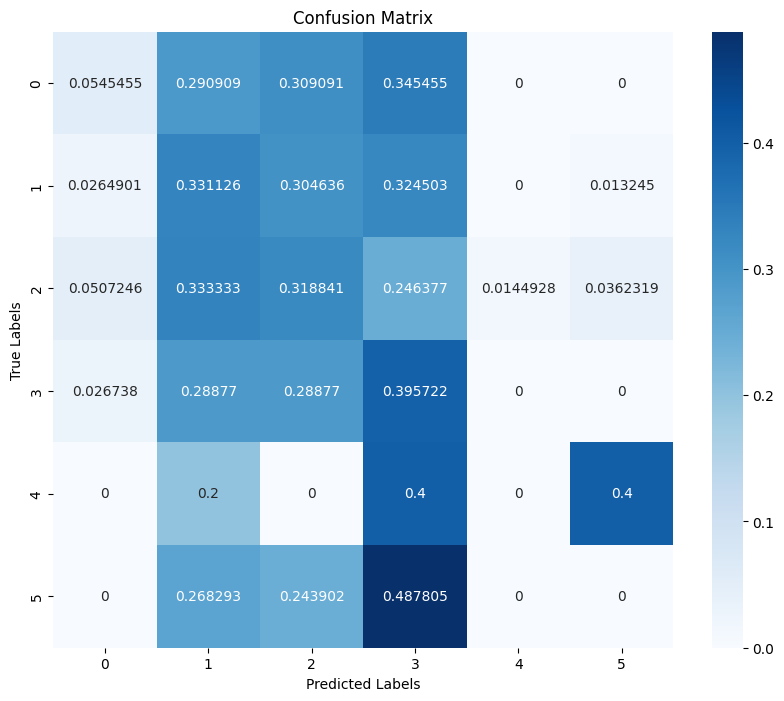

Epoch 7, Validation Loss: 2.8765, Accuracy: 0.2964, F1 Score: 0.2800
Val F1 Score Per Class  [0.08108108 0.30395137 0.28478964 0.38441558 0.         0.        ]


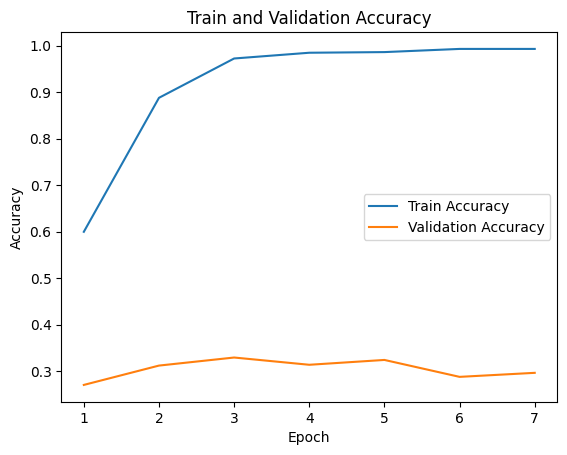

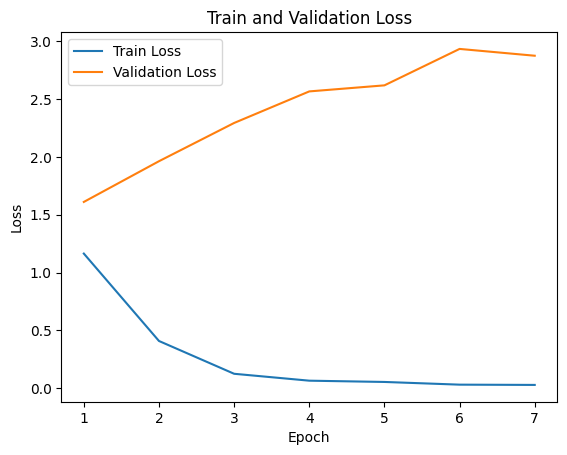

Epoch 8, Train Loss: 0.0168, Accuracy: 0.9956, F1 Score: 0.9956
Train F1 Score Per Class  [0.99833979 0.99391221 0.99298246 0.99166667 1.         0.99666969]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.17it/s, loss=4.74]

[tensor([-2.1120,  4.1203, -2.2284,  0.5988, -2.5191, -3.1629], device='cuda:0'), tensor([-1.4949,  3.8439, -1.7295, -1.2333, -3.1141, -3.3465], device='cuda:0'), tensor([-2.1976, -1.0716,  0.0272,  1.2238, -4.1068, -3.2130], device='cuda:0'), tensor([-1.6189,  0.1269, -2.8585,  4.1980, -2.7240, -1.9365], device='cuda:0'), tensor([-2.6533,  0.4547, -1.2815,  3.4791, -3.2986, -2.5540], device='cuda:0'), tensor([-2.2212, -0.7887, -0.6566,  5.1075, -2.8338, -3.6548], device='cuda:0'), tensor([-2.8042, -1.0337, -1.2456,  3.0432, -3.9341, -2.4482], device='cuda:0'), tensor([-2.0756, -2.5895,  1.3874,  3.9338, -2.6252, -2.1397], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=2.55]

[tensor([-0.7982,  0.8113, -2.0067,  0.0572, -3.9444, -2.9544], device='cuda:0'), tensor([-3.2037,  0.0396, -2.8232,  1.4362, -2.6706, -2.8880], device='cuda:0'), tensor([-1.9127, -1.9764,  4.0684,  1.4778, -2.8742, -2.6783], device='cuda:0'), tensor([-2.1527,  0.2180, -0.4231,  3.5510, -3.4422, -2.8386], device='cuda:0'), tensor([-0.5210,  5.3448, -1.9682, -0.8137, -2.6017, -2.9028], device='cuda:0'), tensor([-0.6414,  1.8190, -1.8327,  0.7476, -3.3990, -3.9747], device='cuda:0'), tensor([-0.8699, -2.2247, -0.7133,  4.9712, -2.8046, -3.0014], device='cuda:0'), tensor([ 2.5475, -0.5447, -2.6753,  1.2837, -3.3940, -2.7418], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:33,  2.12it/s, loss=3.53]

[tensor([-1.8537, -0.6124, -1.4379, -0.5193, -3.4754, -3.9207], device='cuda:0'), tensor([-1.2173,  1.7661,  0.5507, -1.9525, -1.5807, -3.0638], device='cuda:0'), tensor([-2.5602, -1.4839,  4.9206, -0.7824, -2.7302, -2.5238], device='cuda:0'), tensor([-1.5744, -2.0307,  0.5702,  4.6569, -3.3360, -3.4368], device='cuda:0'), tensor([-1.1664,  0.3370, -1.9389,  2.1096, -3.0172, -3.6156], device='cuda:0'), tensor([-1.0449, -0.5252, -1.7114,  4.5463, -3.9256, -3.7379], device='cuda:0'), tensor([-1.5244, -2.2391,  0.2440,  2.0467, -3.5734, -3.3107], device='cuda:0'), tensor([ 0.3066, -1.6993, -1.5812,  1.0345, -3.1557, -3.6846], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=3.01]

[tensor([-2.3256, -1.5290,  0.6359,  3.8993, -3.0368, -4.0746], device='cuda:0'), tensor([-3.0028,  1.3809, -0.5693,  0.8390, -3.6823, -3.3829], device='cuda:0'), tensor([-1.7918, -1.2651, -2.0333,  1.1660, -3.6094, -1.3943], device='cuda:0'), tensor([-1.8853, -0.2850,  1.0007, -0.3902, -2.3907, -2.9890], device='cuda:0'), tensor([ 5.7320, -1.5573, -0.6569, -0.5089, -1.9931, -2.4981], device='cuda:0'), tensor([-1.8262, -0.0900, -2.2164,  1.8860, -3.6594, -1.9367], device='cuda:0'), tensor([-1.6906,  5.3693, -1.3815, -1.2362, -2.8555, -2.8305], device='cuda:0'), tensor([-2.7554,  1.3407,  2.9446, -2.1447, -1.4329, -1.2052], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.13it/s, loss=3.77]

[tensor([-3.1977, -0.6167,  2.6346, -0.7563, -2.9897, -3.5416], device='cuda:0'), tensor([-2.7471, -1.9476,  1.0419,  3.9049, -3.4346, -3.6540], device='cuda:0'), tensor([-2.0737, -1.7999,  4.3881,  0.5679, -3.1633, -3.8981], device='cuda:0'), tensor([-1.1582,  0.0992, -2.0322,  2.3121, -3.3816, -4.1278], device='cuda:0'), tensor([-2.1668, -1.4278,  4.0762,  1.4768, -3.3876, -3.2451], device='cuda:0'), tensor([-1.6194, -0.9954, -0.1897,  1.5124, -4.0551, -3.5876], device='cuda:0'), tensor([-2.2299,  1.5124, -0.8015, -1.0521, -3.4281, -2.0443], device='cuda:0'), tensor([-0.8119, -0.5760, -2.0499,  3.6728, -2.3542, -1.7655], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=4.89]

[tensor([-1.7487, -0.9478,  5.6527, -1.4296, -2.5300, -2.9082], device='cuda:0'), tensor([-2.0305, -0.5562,  4.9477, -0.4066, -3.1287, -3.2364], device='cuda:0'), tensor([-2.0977,  0.7062,  0.5536,  0.7709, -3.6115, -3.8454], device='cuda:0'), tensor([-2.4054,  0.7148, -1.3966,  2.9712, -3.3483, -2.9992], device='cuda:0'), tensor([-1.0432, -2.1126,  5.6530, -0.7070, -2.4472, -2.1439], device='cuda:0'), tensor([-2.6534, -0.9610, -0.0626,  3.3724, -3.2382, -2.6163], device='cuda:0'), tensor([-2.2716, -2.4137,  4.3453,  1.4041, -2.6821, -2.6469], device='cuda:0'), tensor([-1.8468, -1.6702, -0.0956,  1.0893, -2.8723, -3.2132], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=3.12]

[tensor([-2.1333,  0.3988,  1.2289, -0.5628, -3.6449, -2.3973], device='cuda:0'), tensor([-2.3591, -0.4813, -1.0248,  2.2219, -2.9922, -3.1996], device='cuda:0'), tensor([ 1.5408, -1.6698,  2.5429, -1.7556, -2.2950, -2.3274], device='cuda:0'), tensor([-2.3808, -1.8534,  0.5038,  3.6982, -4.0081, -3.0738], device='cuda:0'), tensor([-2.4809,  3.4224,  0.4545, -1.5606, -2.7098, -3.5364], device='cuda:0'), tensor([-2.0650,  0.5300, -1.6349,  0.6989, -3.2195, -1.3783], device='cuda:0'), tensor([-2.2811, -2.4281,  4.7895,  0.3065, -2.9512, -1.7998], device='cuda:0'), tensor([-3.1051,  2.9715, -1.1838, -0.0456, -4.0127, -2.8026], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=4.63]

[tensor([-0.4046, -1.2825, -0.7961,  2.0294, -3.1332, -3.5554], device='cuda:0'), tensor([-1.9008, -2.2816,  3.5221, -0.1527, -2.5238, -2.2569], device='cuda:0'), tensor([-1.1849, -0.7881, -1.9944,  5.4382, -3.0943, -2.6096], device='cuda:0'), tensor([-1.7986,  5.7737, -1.4664, -0.8975, -2.3939, -2.6531], device='cuda:0'), tensor([-2.2010, -1.1449,  3.7043, -0.6962, -2.8644, -3.6807], device='cuda:0'), tensor([-1.6797,  2.5477, -1.3979,  1.8088, -3.3386, -3.6983], device='cuda:0'), tensor([-3.2345, -2.0296, -0.0110, -0.2848, -4.3444, -2.0503], device='cuda:0'), tensor([-2.4993, -1.4084,  4.9295, -0.5238, -2.2246, -1.8002], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.15it/s, loss=3.77]

[tensor([-2.8742, -0.8900, -1.6106, -0.6695, -3.6555, -1.7003], device='cuda:0'), tensor([-1.8625,  3.2514,  0.0358, -0.0292, -3.7965, -4.3672], device='cuda:0'), tensor([-1.0657,  1.1824, -0.6505,  1.2801, -3.0366, -4.2385], device='cuda:0'), tensor([-1.4733, -2.3087,  1.6098,  2.7388, -2.8461, -3.3415], device='cuda:0'), tensor([-0.9111, -2.2643, -0.0288,  2.2371, -1.9332, -2.7087], device='cuda:0'), tensor([-2.8694,  3.8430,  0.3470, -0.7791, -3.2646, -2.9213], device='cuda:0'), tensor([-3.2382,  0.0944, -0.9981,  2.9243, -3.5503, -2.9799], device='cuda:0'), tensor([-1.4963, -2.2326,  0.4163,  2.0677, -3.7172, -3.3377], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=2.02]

[tensor([-1.9479,  5.5260, -1.6967, -0.8519, -2.4727, -2.2270], device='cuda:0'), tensor([-2.2772, -1.2805,  1.7346,  0.6676, -2.4059, -2.9722], device='cuda:0'), tensor([-0.9166,  5.7989, -1.7435, -1.2069, -2.5041, -2.0090], device='cuda:0'), tensor([-2.2595,  0.5376,  0.9493,  2.1990, -3.2868, -4.5752], device='cuda:0'), tensor([-1.9839,  4.4702,  0.2230, -0.6132, -2.6722, -2.7604], device='cuda:0'), tensor([-2.3449, -0.4588,  0.1595,  2.7848, -3.5654, -3.7118], device='cuda:0'), tensor([-2.5710, -0.8850, -1.4993,  1.2785, -3.3747, -3.5025], device='cuda:0'), tensor([-1.8964,  3.5081, -1.8144,  1.1836, -2.9638, -3.2873], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=4.38]

[tensor([-2.1831,  2.9364, -1.4479,  1.5618, -2.8850, -3.5939], device='cuda:0'), tensor([-0.5461,  5.3324, -1.8734, -0.8347, -2.7571, -1.7219], device='cuda:0'), tensor([-2.6264, -0.9642,  1.1428,  3.5115, -3.7272, -2.4344], device='cuda:0'), tensor([-2.3203, -0.6777,  0.4413,  4.0373, -3.7953, -3.7690], device='cuda:0'), tensor([-2.1718,  5.7093, -1.4711, -0.8789, -2.9948, -2.1694], device='cuda:0'), tensor([-1.6988, -0.9108, -1.7966,  3.9656, -3.4684, -2.7030], device='cuda:0'), tensor([-3.0931,  1.2661,  3.5832, -1.1642, -2.8376, -3.2507], device='cuda:0'), tensor([-2.2677, -0.5297, -0.5460,  1.0363, -2.9254, -4.0533], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.13it/s, loss=2.81]

[tensor([-1.5030, -1.9628,  4.5290, -0.7954, -2.6735, -3.0832], device='cuda:0'), tensor([-2.2566,  1.1935,  1.5796,  1.4357, -3.5484, -3.8927], device='cuda:0'), tensor([-3.1705,  0.4230,  2.8077,  1.3281, -2.8665, -4.0081], device='cuda:0'), tensor([-2.2844,  5.0692, -1.3789, -0.9417, -2.7461, -2.9762], device='cuda:0'), tensor([ 2.7644, -2.0798, -3.0357, -0.7686, -2.0993, -2.9661], device='cuda:0'), tensor([-1.7762, -1.8470,  5.6340, -0.4467, -2.3401, -2.2979], device='cuda:0'), tensor([-0.8534, -0.9918, -1.9182,  3.2836, -3.2688, -3.1813], device='cuda:0'), tensor([ 1.0390, -1.1729,  1.1911, -0.6123, -3.3389, -3.4482], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.14it/s, loss=2.6]

[tensor([-2.2837, -1.6219, -0.2353,  4.8499, -3.3003, -3.1818], device='cuda:0'), tensor([-2.0805,  5.3686, -0.2064, -1.1479, -2.4091, -2.3236], device='cuda:0'), tensor([-2.4875,  2.4718,  1.9324,  0.1493, -4.1923, -3.7789], device='cuda:0'), tensor([-2.4779,  0.5428,  3.3234, -1.2637, -3.3761, -3.4727], device='cuda:0'), tensor([-2.2372,  5.4801, -1.5912, -1.0526, -2.1603, -2.0708], device='cuda:0'), tensor([-1.9518, -2.0456,  2.1783, -0.2975, -3.1097, -2.9697], device='cuda:0'), tensor([-2.8724,  4.3056,  0.3501, -1.2389, -3.0018, -2.5908], device='cuda:0'), tensor([-1.7091,  1.0652, -1.0498,  0.6109, -3.4640, -3.9025], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.13it/s, loss=2.67]

[tensor([ 1.3373, -1.7988, -1.7060,  0.6055, -3.0414, -2.7334], device='cuda:0'), tensor([-2.2156,  0.5050, -1.8525,  0.5287, -4.1094, -2.9971], device='cuda:0'), tensor([-2.0491, -2.0187, -0.2148, -1.5325, -2.5736, -0.1219], device='cuda:0'), tensor([-1.9028, -1.1494, -0.1749,  3.7353, -3.9514, -3.7045], device='cuda:0'), tensor([-2.3927, -1.2042, -1.4301,  5.3590, -2.3505, -2.7657], device='cuda:0'), tensor([-2.6448,  0.5434, -1.1810,  4.0607, -2.9067, -3.0637], device='cuda:0'), tensor([-1.9635,  2.5607, -1.6014, -1.4260, -3.4704, -3.0461], device='cuda:0'), tensor([-0.4522, -0.8093, -1.4129,  2.6337, -4.1356, -2.9772], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.13it/s, loss=4.23]

[tensor([-1.7478,  4.8978, -1.3454, -0.3878, -2.8185, -2.3703], device='cuda:0'), tensor([-1.7980,  0.7746, -0.1095, -0.9781, -3.0816, -3.7363], device='cuda:0'), tensor([-1.4051, -0.7694,  4.5070, -0.7740, -2.9559, -2.9024], device='cuda:0'), tensor([-1.5172, -2.5872, -0.6600,  4.7475, -3.1426, -2.9154], device='cuda:0'), tensor([-0.8018, -0.6284, -1.2772,  3.7117, -2.7543, -4.0957], device='cuda:0'), tensor([-2.2635,  1.6516, -0.7891, -1.4004, -3.1627, -3.7563], device='cuda:0'), tensor([-3.3780, -1.7356,  0.9467,  1.1229, -3.8104, -2.3666], device='cuda:0'), tensor([-1.9853, -1.4085,  5.0010, -0.8590, -2.9000, -3.3350], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.12it/s, loss=2.36]

[tensor([-1.9131, -0.2745, -1.3844,  5.4361, -2.9908, -3.0035], device='cuda:0'), tensor([-2.2398,  4.9571,  0.2142, -1.8445, -2.9224, -2.6009], device='cuda:0'), tensor([-2.4194, -0.3107, -0.0927,  2.6365, -3.6040, -4.0074], device='cuda:0'), tensor([-2.9719,  1.6885, -0.7904,  0.2783, -3.7642, -2.4124], device='cuda:0'), tensor([-2.7559, -2.4106,  1.8855,  3.8118, -3.3196, -3.5443], device='cuda:0'), tensor([-2.9139, -0.9987,  3.8646,  1.1819, -2.5976, -3.1806], device='cuda:0'), tensor([-2.1441, -0.8181, -0.3469,  4.9119, -3.3284, -3.4801], device='cuda:0'), tensor([-1.5828, -1.5883,  5.8435, -1.0895, -2.2975, -2.2726], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=3.62]

[tensor([-2.8030,  2.8164, -1.4908,  0.5999, -3.7627, -2.8878], device='cuda:0'), tensor([-1.8914,  0.7639,  1.3090, -1.1945, -2.7422, -2.6660], device='cuda:0'), tensor([-1.9492,  5.5053, -0.5273, -1.3733, -2.4282, -2.2666], device='cuda:0'), tensor([-3.0635,  1.3983,  0.0376, -0.0991, -3.4786, -3.3888], device='cuda:0'), tensor([-3.0088, -1.5428,  5.0827,  0.2758, -2.4710, -2.5485], device='cuda:0'), tensor([-1.5154, -1.2115, -1.1055,  0.0631, -3.7822, -2.8385], device='cuda:0'), tensor([-0.2573, -1.7190,  2.9602, -1.7007, -2.5368, -2.7265], device='cuda:0'), tensor([-0.7501, -1.1780, -2.4210,  3.9124, -2.6836, -2.9586], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.14it/s, loss=1.75]

[tensor([-2.4273, -1.1864, -0.7893,  5.1245, -3.2762, -3.3084], device='cuda:0'), tensor([-0.6125, -1.9428,  0.8229,  2.1031, -3.1476, -3.9053], device='cuda:0'), tensor([-3.1784,  2.9416, -1.0475, -0.6665, -3.8508, -1.5875], device='cuda:0'), tensor([-2.3921,  2.0400,  1.0930, -0.4636, -3.2877, -3.4373], device='cuda:0'), tensor([-2.0349, -1.6443,  0.3113,  2.9416, -1.8080, -3.8578], device='cuda:0'), tensor([-0.2778, -1.3399,  1.1077, -1.1048, -2.3987, -2.5112], device='cuda:0'), tensor([-0.8338, -0.5008,  0.2767, -0.9807, -3.4350, -2.7535], device='cuda:0'), tensor([-2.9465, -0.1073, -0.1651,  2.2384, -3.3892, -4.0107], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.14it/s, loss=2.28]

[tensor([-2.2433, -2.4997,  2.5768,  0.5441, -3.0553, -3.2715], device='cuda:0'), tensor([ 1.0606, -0.1824, -0.8215, -1.1615, -3.1749, -3.0231], device='cuda:0'), tensor([-1.8157, -1.0623,  5.5805, -0.4841, -1.8970, -2.6935], device='cuda:0'), tensor([-1.7142, -1.5959, -1.1404,  5.4555, -2.3144, -2.3537], device='cuda:0'), tensor([-1.4042,  2.3277, -1.6697,  1.1739, -3.5751, -3.7129], device='cuda:0'), tensor([ 1.6273, -0.6677, -2.5212,  1.5389, -2.8707, -3.5711], device='cuda:0'), tensor([-1.6551, -0.5990, -1.7449,  1.6156, -3.5416, -3.4743], device='cuda:0'), tensor([-1.3626,  0.1750,  3.5288, -1.3438, -3.3430, -2.9678], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.14it/s, loss=3.73]

[tensor([-2.5706, -2.2140,  2.7397,  2.2105, -3.2048, -3.0952], device='cuda:0'), tensor([-2.4005,  3.3366, -2.6713, -0.7998, -2.4275, -1.8331], device='cuda:0'), tensor([-1.8252, -1.7863,  5.2252, -0.9559, -2.5123, -1.8433], device='cuda:0'), tensor([-1.5969, -2.5471,  2.1868,  0.2673, -3.2696, -2.8941], device='cuda:0'), tensor([-1.2257,  3.7732,  0.2181, -1.2918, -3.2399, -3.8119], device='cuda:0'), tensor([-1.6509,  5.1195, -1.6053, -1.1840, -2.8146, -1.7369], device='cuda:0'), tensor([-1.6442, -1.7957,  1.4298,  1.7421, -3.5563, -4.0380], device='cuda:0'), tensor([-3.2410, -0.4514,  3.5695, -0.0636, -3.1874, -3.2029], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.15it/s, loss=4.84]

[tensor([-1.6375, -2.9553,  3.0299,  2.5945, -2.8923, -2.3001], device='cuda:0'), tensor([-1.6718,  4.1055, -2.0949,  0.5991, -3.1373, -3.4213], device='cuda:0'), tensor([-2.7736,  4.2571,  0.9612, -0.6582, -3.3922, -2.5824], device='cuda:0'), tensor([-1.9678, -2.3421,  4.7184,  1.2224, -2.7479, -3.2326], device='cuda:0'), tensor([-2.6350, -1.2903,  5.0508, -0.1765, -2.8976, -2.6089], device='cuda:0'), tensor([-1.4408, -0.6225, -1.2106, -0.8832, -3.2058, -3.5940], device='cuda:0'), tensor([-1.5855, -2.0264, -0.5348,  5.6763, -2.4200, -2.4968], device='cuda:0'), tensor([-1.4411, -1.4777, -0.7001,  4.6341, -2.2058, -1.8175], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=2.45]

[tensor([-1.6379,  4.3062, -1.5400,  0.4030, -3.0797, -3.4681], device='cuda:0'), tensor([-1.0627, -0.9124, -0.6558,  2.5871, -2.7761, -3.4291], device='cuda:0'), tensor([-2.5618, -2.2685,  3.4160,  1.3350, -3.1801, -2.6420], device='cuda:0'), tensor([-3.2725,  0.2650, -1.0212, -0.8636, -2.8264, -2.8463], device='cuda:0'), tensor([-1.3484, -1.4085, -0.8077,  4.1656, -3.0312, -3.4512], device='cuda:0'), tensor([-1.7008, -2.3500,  3.3841,  2.2345, -2.6835, -3.3956], device='cuda:0'), tensor([-1.8522,  1.4664, -1.7486,  1.4227, -3.6125, -2.9439], device='cuda:0'), tensor([-2.7235, -1.7547,  0.4576,  2.7606, -2.8642, -3.1499], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.14it/s, loss=1.96]

[tensor([-0.6394,  0.1879, -2.2654,  1.3152, -2.8424, -3.0771], device='cuda:0'), tensor([-1.7249, -1.1816, -0.6975,  2.3043, -3.8559, -3.7055], device='cuda:0'), tensor([-1.2038, -0.9141, -1.6945,  4.8506, -1.7882, -2.7747], device='cuda:0'), tensor([-2.8512,  1.9098, -1.9613,  1.2276, -3.3309, -3.1338], device='cuda:0'), tensor([-2.3188,  3.3520, -1.4866,  1.3985, -3.5387, -3.1876], device='cuda:0'), tensor([-0.9872, -1.5432, -1.5262,  5.6204, -2.4890, -2.8176], device='cuda:0'), tensor([-1.1844, -2.5052,  0.1458,  4.8004, -2.6022, -2.7991], device='cuda:0'), tensor([-2.5874, -1.0033,  4.1075, -0.5872, -2.4116, -3.4526], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=2.25]

[tensor([ 1.4308, -0.7575, -2.4912, -0.3647, -3.0983, -2.9312], device='cuda:0'), tensor([-1.1755, -1.7963,  0.7906,  0.5534, -3.2534, -3.3911], device='cuda:0'), tensor([-1.3185, -0.9935, -1.7576,  4.3495, -2.3347, -3.4200], device='cuda:0'), tensor([-0.6458, -0.8960,  5.1505, -1.5911, -2.4715, -3.4210], device='cuda:0'), tensor([-2.0510,  3.8461,  2.0004, -1.6652, -2.6168, -3.7645], device='cuda:0'), tensor([ 0.7741, -2.1243, -1.2583,  2.8028, -2.7218, -4.0330], device='cuda:0'), tensor([-2.7685,  0.2235, -2.2060,  3.1633, -2.1910, -2.2278], device='cuda:0'), tensor([-1.3569,  3.6164, -1.7317, -0.3359, -4.2597, -1.9402], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=3.65]

[tensor([-2.2553, -0.4743,  0.2592,  2.5548, -4.6991, -1.5453], device='cuda:0'), tensor([-1.0462,  1.0924, -1.8023,  0.9373, -3.0585, -2.7388], device='cuda:0'), tensor([-2.7639,  1.4287, -1.0365,  0.4543, -3.4958, -3.6289], device='cuda:0'), tensor([-2.0485, -0.9147,  4.2402, -1.0884, -2.3738, -3.1290], device='cuda:0'), tensor([-1.0121, -2.2123, -0.3864,  1.5117, -3.4979, -4.0242], device='cuda:0'), tensor([-1.1553,  5.2089, -0.4655, -2.1838, -2.3070, -2.0163], device='cuda:0'), tensor([-2.6239,  4.5367, -2.4854, -1.1075, -4.3468, -2.0161], device='cuda:0'), tensor([-2.5885,  4.5007, -1.7499,  0.0892, -3.4836, -1.4138], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=3.88]

[tensor([-1.2237,  3.2406, -1.8599, -0.8429, -3.6397, -2.9795], device='cuda:0'), tensor([-1.5194, -0.7311,  4.3448, -1.7310, -2.5481, -2.1705], device='cuda:0'), tensor([-2.4847, -0.2813, -0.1441,  3.5924, -3.5500, -3.6339], device='cuda:0'), tensor([-2.2835,  4.5710, -0.3761, -1.2657, -2.8489, -3.2626], device='cuda:0'), tensor([-1.2522,  5.5382, -0.8528, -1.2031, -2.8064, -2.9962], device='cuda:0'), tensor([-2.3516, -1.6144,  2.5492,  0.3777, -2.5122, -3.1766], device='cuda:0'), tensor([-1.7442, -1.6030,  1.1471,  2.8692, -3.3283, -3.4407], device='cuda:0'), tensor([-1.5474, -1.9020,  5.4231, -0.4198, -2.3086, -2.3841], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.14it/s, loss=2.81]

[tensor([-2.7783,  0.5212, -1.2127,  1.0263, -3.0348, -2.4066], device='cuda:0'), tensor([-1.8211,  5.2738,  0.4192, -1.3829, -2.5008, -2.9877], device='cuda:0'), tensor([-1.6034, -0.9493, -1.2505,  0.3347, -3.4214, -2.1508], device='cuda:0'), tensor([-2.0732, -1.2095, -1.0096,  3.6597, -1.9329, -2.6072], device='cuda:0'), tensor([-0.6769, -1.1109, -2.0517,  3.0253, -3.2185, -2.7315], device='cuda:0'), tensor([-2.8404,  2.8386,  2.0351, -0.3039, -3.1356, -3.8382], device='cuda:0'), tensor([-3.1520, -1.2384,  3.1460, -0.0721, -3.3810, -3.6183], device='cuda:0'), tensor([-2.2620,  2.3887, -1.7223,  1.0155, -3.3826, -3.7117], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.15it/s, loss=2.49]

[tensor([ 0.5083, -1.8249,  3.1199, -0.6828, -2.6764, -2.8034], device='cuda:0'), tensor([-1.6542, -2.0938, -0.2110,  1.3262, -3.2987, -3.2689], device='cuda:0'), tensor([-0.6811, -0.5265,  0.2203,  2.4962, -3.5741, -4.0866], device='cuda:0'), tensor([-2.2378, -2.3015,  2.5591,  3.3234, -3.0778, -2.8530], device='cuda:0'), tensor([-1.9680,  1.4235,  4.1597, -1.4932, -2.6281, -2.7899], device='cuda:0'), tensor([-1.6077,  2.6958, -1.9390,  0.6647, -2.6517, -3.1987], device='cuda:0'), tensor([-1.7558, -2.0087,  2.4278,  1.8171, -3.0979, -2.2317], device='cuda:0'), tensor([-1.6838, -1.6494,  4.6825,  0.0560, -2.9155, -3.4694], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.14it/s, loss=3.08]

[tensor([ 4.7814, -2.1508, -0.5288, -0.9334, -2.0345, -1.1202], device='cuda:0'), tensor([-2.6058,  2.0145,  0.4977, -1.4391, -3.1244, -3.4474], device='cuda:0'), tensor([-1.0374,  0.4905, -1.9696,  3.1757, -2.8536, -3.8581], device='cuda:0'), tensor([-1.0718, -1.1531,  4.2419, -0.7528, -2.2750, -2.1330], device='cuda:0'), tensor([-1.4556,  1.1382, -1.4876,  2.0223, -3.5034, -3.9678], device='cuda:0'), tensor([-2.9421, -0.1686,  0.9119,  0.0885, -3.8239, -2.6227], device='cuda:0'), tensor([-2.0970, -1.0214,  3.4284, -0.6602, -2.8712, -2.4940], device='cuda:0'), tensor([-2.4888,  5.0647, -0.8515, -0.9350, -2.7246, -3.0400], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.11it/s, loss=4.77]

[tensor([-1.7059,  5.7627, -0.8956, -1.3965, -2.4824, -2.2264], device='cuda:0'), tensor([-1.5813, -2.7653,  3.2714,  2.9251, -2.6793, -2.5978], device='cuda:0'), tensor([-2.7655,  4.0589, -1.6856, -0.1377, -3.9835, -2.1228], device='cuda:0'), tensor([-2.8120,  1.7986, -0.9468,  0.8215, -2.9641, -2.2631], device='cuda:0'), tensor([-1.1895, -1.1021, -1.5182,  5.3398, -2.2875, -2.9987], device='cuda:0'), tensor([-1.6138, -1.8324,  4.7778, -0.4563, -2.5173, -2.7656], device='cuda:0'), tensor([-1.8259, -2.4811,  0.5141,  1.6907, -2.4904, -2.0463], device='cuda:0'), tensor([-0.1255, -1.5257, -2.0191,  3.1233, -2.3784, -2.3997], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.12it/s, loss=2.11]

[tensor([-1.8806, -2.5777,  1.0689,  3.3953, -2.8935, -2.3225], device='cuda:0'), tensor([-1.4806,  0.9202, -1.6196,  0.0453, -4.0374, -3.1051], device='cuda:0'), tensor([-2.1802, -2.0275,  4.3925,  0.7995, -2.9320, -2.6327], device='cuda:0'), tensor([-1.7833, -1.1358,  5.3095,  0.5537, -3.1487, -3.1859], device='cuda:0'), tensor([-0.8712,  0.0674,  1.9969, -2.0449, -2.8898, -3.8634], device='cuda:0'), tensor([-1.4906, -1.4662, -2.7842,  3.7389, -2.2962, -0.3316], device='cuda:0'), tensor([-0.7098,  4.9181, -1.3266, -1.3524, -2.8110, -3.2531], device='cuda:0'), tensor([-2.2386,  3.8711, -1.1470,  1.3940, -3.1194, -3.4997], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=2.67]

[tensor([-1.9540,  1.6483, -0.4444, -0.0055, -3.6222, -3.4040], device='cuda:0'), tensor([-1.0484, -1.3057,  2.1748,  0.7555, -3.4744, -3.8509], device='cuda:0'), tensor([-2.2871,  3.5659, -0.8600, -0.3651, -3.7383, -3.2942], device='cuda:0'), tensor([-2.0901, -1.6072,  0.8481,  0.8474, -2.8504, -2.9526], device='cuda:0'), tensor([-2.6962, -0.5413,  4.5964, -1.4608, -2.4787, -2.4597], device='cuda:0'), tensor([-1.7772,  5.7948, -1.0074, -1.1034, -2.6514, -1.8213], device='cuda:0'), tensor([-2.8433, -1.4745, -1.1233,  2.0946, -3.6172, -0.9097], device='cuda:0'), tensor([ 2.0398, -2.1553, -0.6553, -0.7841, -1.6431, -3.8291], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.16it/s, loss=3.44]

[tensor([-2.2345, -0.5198, -0.6149,  2.6271, -3.7060, -3.2496], device='cuda:0'), tensor([ 1.2529,  0.5189, -2.0889,  0.0095, -2.6105, -3.5316], device='cuda:0'), tensor([-2.3067,  2.5654, -0.8944, -0.4537, -3.6644, -2.9200], device='cuda:0'), tensor([-2.9535,  3.0127, -2.0665, -0.8696, -2.4954, -0.6564], device='cuda:0'), tensor([-0.8698,  0.2866, -2.1785,  2.3242, -2.7354, -3.6379], device='cuda:0'), tensor([-2.9806,  0.9877,  3.2454, -0.4096, -2.9526, -3.5164], device='cuda:0'), tensor([-1.8271, -1.6131,  2.5696,  0.3749, -3.3783, -3.9004], device='cuda:0'), tensor([ 0.9626, -2.2801,  0.0645,  2.2085, -3.1226, -3.5299], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=2.8]

[tensor([-1.8159, -1.1789,  5.3070, -0.6267, -2.8870, -3.1253], device='cuda:0'), tensor([-2.3310, -2.0469, -0.2163,  2.1221, -3.3187, -3.5576], device='cuda:0'), tensor([-2.2831,  0.9217,  1.8073, -1.8159, -2.6639, -3.3408], device='cuda:0'), tensor([-2.0770, -1.0693,  5.3399, -1.3442, -2.9733, -2.2086], device='cuda:0'), tensor([-2.2599, -0.4792, -0.9894,  4.8729, -3.1402, -3.0501], device='cuda:0'), tensor([-1.7290, -1.2933,  5.5852, -1.6597, -2.3804, -2.6082], device='cuda:0'), tensor([-0.9471, -2.5124, -0.0481,  4.5555, -3.0940, -2.9166], device='cuda:0'), tensor([-0.6972,  0.6236,  1.3221, -0.1801, -3.9792, -4.3559], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.16it/s, loss=3.69]

[tensor([-1.4294, -0.4080, -1.5855,  3.8120, -2.8570, -4.3341], device='cuda:0'), tensor([-2.0609,  1.6809, -0.5424, -2.4188, -2.9349, -1.8269], device='cuda:0'), tensor([-0.7547, -1.6839, -2.2651,  3.7310, -3.1981, -3.3327], device='cuda:0'), tensor([-1.3246, -1.9348,  4.2423,  0.9997, -3.2805, -2.5468], device='cuda:0'), tensor([-1.5499, -1.2691,  2.1312, -0.8513, -2.0428, -1.8123], device='cuda:0'), tensor([-2.5203, -1.2124, -0.8970,  2.3800, -3.3904, -1.8445], device='cuda:0'), tensor([-2.0511, -0.1586, -0.3878,  0.9499, -3.4301, -4.0145], device='cuda:0'), tensor([-2.4437,  3.5956, -1.8924,  0.3045, -3.3326, -1.9608], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.17it/s, loss=3.05]

[tensor([-2.7453, -1.2408, -1.1478,  4.2879, -3.2295, -2.6493], device='cuda:0'), tensor([ 0.0651, -2.6404,  0.5077,  3.4220, -3.3349, -3.0922], device='cuda:0'), tensor([-2.4662, -1.2160, -1.2463,  1.5231, -2.8819, -3.1499], device='cuda:0'), tensor([-2.2340,  0.8546,  2.1975, -0.2277, -3.2042, -4.0291], device='cuda:0'), tensor([-1.7596, -2.0832, -0.1905,  2.8451, -2.8249, -3.2089], device='cuda:0'), tensor([-2.2342e+00,  3.6128e+00, -9.4153e-01,  1.9594e-03, -2.1171e+00,
        -3.7900e+00], device='cuda:0'), tensor([-2.0863,  3.1551, -0.5659, -0.2705, -3.9201, -3.6745], device='cuda:0'), tensor([-2.2381,  5.0587, -1.1702, -0.8547, -2.5545, -3.3113], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.15it/s, loss=3.99]

[tensor([-1.7687, -0.9489, -0.2333,  2.3101, -3.6775, -3.9939], device='cuda:0'), tensor([-2.0068,  5.5488, -1.7702, -0.7925, -2.2007, -2.2822], device='cuda:0'), tensor([-1.5239, -0.9371, -2.2898,  4.3951, -3.9204, -2.8000], device='cuda:0'), tensor([-1.6024, -1.3957,  5.2402, -1.1340, -2.6909, -3.1939], device='cuda:0'), tensor([-1.3498,  1.7539, -2.7494,  0.8934, -3.3500, -2.8570], device='cuda:0'), tensor([-2.0157,  3.7310, -1.4413, -0.7417, -3.0957, -3.1935], device='cuda:0'), tensor([-1.7078,  3.6149,  0.2183, -0.9811, -3.9081, -4.1418], device='cuda:0'), tensor([-1.9442, -1.0500, -1.4293,  4.0645, -3.6598, -2.7660], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=3.24]

[tensor([-2.4953,  0.8780, -2.2378,  4.1773, -2.8546, -1.8659], device='cuda:0'), tensor([-2.1610, -0.7871,  3.4628, -0.4109, -1.6349, -2.7698], device='cuda:0'), tensor([-2.1223, -1.4946,  2.5834,  2.0035, -2.8330, -3.2932], device='cuda:0'), tensor([-1.8458, -1.6543,  5.6072, -0.4410, -2.5675, -2.5836], device='cuda:0'), tensor([-1.6314, -1.6398,  5.2697, -1.2843, -2.4166, -0.8303], device='cuda:0'), tensor([-0.6797, -1.3703, -0.2026,  2.2657, -3.4952, -4.0358], device='cuda:0'), tensor([-2.4102,  0.8167, -2.3885, -0.6533, -2.9554, -2.1115], device='cuda:0'), tensor([-1.5259,  4.0743, -0.9631,  0.3712, -2.6269, -3.5057], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=2.39]

[tensor([-2.0565, -0.4758,  1.4931,  0.0721, -3.6261, -2.6110], device='cuda:0'), tensor([-1.7870, -0.7155, -2.2310,  2.9956, -1.9100, -1.1791], device='cuda:0'), tensor([ 0.3380, -0.9478, -2.3232,  1.7555, -2.9383, -3.4274], device='cuda:0'), tensor([-1.7001,  1.6305, -2.0895,  3.4346, -3.5123, -3.5621], device='cuda:0'), tensor([-0.9768, -0.9603, -0.8587,  1.6284, -3.4575, -4.2841], device='cuda:0'), tensor([-1.7126, -2.0789,  5.6613, -0.7224, -2.1734, -2.0492], device='cuda:0'), tensor([-0.9278,  0.0686, -2.0760,  1.3069, -1.7316, -4.0030], device='cuda:0'), tensor([-3.1129,  0.4039,  2.3901,  2.3597, -3.3374, -3.5662], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=3.41]

[tensor([-3.2903,  1.1164, -0.7360,  1.4273, -3.1923, -3.8662], device='cuda:0'), tensor([-3.3587,  3.6533, -1.1741,  0.4165, -3.4771, -3.0518], device='cuda:0'), tensor([-2.6965,  1.3232, -1.0854,  0.3404, -3.0169, -3.6453], device='cuda:0'), tensor([-1.6693, -2.0655,  5.5283, -1.2001, -1.9177, -2.3369], device='cuda:0'), tensor([-0.9615,  2.2088, -2.6729,  1.8920, -1.9302, -3.5374], device='cuda:0'), tensor([-2.2482, -1.4975,  5.3449, -1.1756, -2.7092, -2.1559], device='cuda:0'), tensor([-3.2322, -0.7875,  0.2547,  2.1918, -4.2098, -3.4330], device='cuda:0'), tensor([-0.6626, -1.5341,  1.5706,  0.6059,  0.0796, -2.9583], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.15it/s, loss=2.72]

[tensor([-1.4678, -1.5626, -1.3569,  5.5819, -2.4476, -3.2348], device='cuda:0'), tensor([-1.3144, -1.4890, -1.2268,  5.4551, -3.3516, -2.9043], device='cuda:0'), tensor([-2.1325,  1.9601, -1.4547,  2.1142, -3.3701, -3.3908], device='cuda:0'), tensor([-1.3152, -1.2936, -1.0627,  5.6233, -3.1231, -2.4174], device='cuda:0'), tensor([-1.8106,  1.1790,  0.2572, -0.1614, -2.8976, -3.8012], device='cuda:0'), tensor([-2.0354, -2.1666,  4.3921,  0.8098, -2.2944, -3.0082], device='cuda:0'), tensor([-1.0262,  0.0306, -2.1424,  1.0715, -2.9302, -2.8646], device='cuda:0'), tensor([-0.7503, -2.1540,  2.6391,  0.9933, -3.1666, -3.5308], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.15it/s, loss=3.73]

[tensor([-3.0815,  3.5336, -1.1439, -0.5012, -3.3508, -2.1248], device='cuda:0'), tensor([-1.9037, -1.1566, -1.5095,  1.4992, -2.8366, -2.9950], device='cuda:0'), tensor([ 6.0412, -1.4728, -0.9042, -1.2038, -2.3422, -1.4084], device='cuda:0'), tensor([-1.8528,  4.5707, -1.4199, -0.3370, -2.3520, -2.6297], device='cuda:0'), tensor([-1.2293, -0.5820, -1.7276,  4.6314, -3.0948, -3.6363], device='cuda:0'), tensor([-2.1456, -1.1988, -0.8706,  4.1306, -3.1898, -3.6027], device='cuda:0'), tensor([ 0.8580, -0.1586, -0.7836,  0.6270, -3.7088, -4.3694], device='cuda:0'), tensor([-0.6353,  0.0445, -1.3423,  0.5887, -3.8973, -3.1521], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.15it/s, loss=2.3]

[tensor([-1.2320,  1.2566, -2.6758,  2.6028, -2.8953, -3.3615], device='cuda:0'), tensor([-2.6642, -0.8248, -1.3813, -1.1333, -2.4247, -2.3848], device='cuda:0'), tensor([-1.8467, -1.2737,  0.0954,  4.7844, -3.5636, -3.0822], device='cuda:0'), tensor([-1.4911, -1.5270, -0.6410,  5.6523, -3.3400, -2.5863], device='cuda:0'), tensor([-2.4688,  0.4656,  2.8650,  0.0869, -3.3107, -3.6342], device='cuda:0'), tensor([-1.8563, -2.3173, -1.5562,  4.1214, -3.3412, -2.5830], device='cuda:0'), tensor([-1.6041, -2.3564,  2.7562,  2.1325, -3.1832, -3.2159], device='cuda:0'), tensor([-0.8026, -1.7153, -1.5485,  4.6055, -2.8566, -3.1606], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.16it/s, loss=3.45]

[tensor([-1.4039, -1.1405,  0.6279, -0.0538, -3.2096, -3.8071], device='cuda:0'), tensor([ 1.2210, -3.0499, -0.2631,  1.3891, -2.4015, -3.0688], device='cuda:0'), tensor([-2.7441, -1.4941, -1.4765,  4.5044, -3.3286, -2.7877], device='cuda:0'), tensor([-1.0368, -1.0920, -0.6209,  1.1909, -4.2237, -3.6078], device='cuda:0'), tensor([-1.8464, -1.7308, -0.8907,  1.9613,  0.8374, -2.1353], device='cuda:0'), tensor([-3.1187,  4.2755, -0.2720,  0.1312, -3.5573, -3.1853], device='cuda:0'), tensor([-1.8910, -1.1792,  4.3189,  0.6020, -2.7695, -2.1025], device='cuda:0'), tensor([-0.4759,  3.4517,  1.2382, -1.8255, -2.8818, -2.4021], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.16it/s, loss=3.23]

[tensor([-2.3669,  2.4448,  0.2121, -0.9650, -4.3244, -2.8690], device='cuda:0'), tensor([-2.1818, -0.2729, -2.5578,  2.9221, -2.1066, -2.3100], device='cuda:0'), tensor([-2.0928,  1.1504, -1.8794,  3.8301, -3.1449, -2.9613], device='cuda:0'), tensor([-1.3747,  1.8380, -1.6805, -0.2153, -3.0061, -3.5277], device='cuda:0'), tensor([-2.1389, -2.2031,  4.7313,  1.2172, -2.5982, -2.3788], device='cuda:0'), tensor([-1.6835, -1.7331, -1.8237,  5.1793, -3.2343, -1.1446], device='cuda:0'), tensor([-2.8660,  1.6241,  1.4391, -0.4691, -3.5265, -3.1116], device='cuda:0'), tensor([-2.4830, -0.6579, -2.3792,  3.2570, -3.3155, -2.0026], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=2.11]

[tensor([-2.5148, -1.1579,  3.1031,  1.1530, -3.2441, -3.8095], device='cuda:0'), tensor([-0.8805,  1.8551, -1.8476,  1.0507, -2.1968, -2.6073], device='cuda:0'), tensor([-2.0000, -1.2979, -1.3636,  4.6654, -2.6248, -3.2640], device='cuda:0'), tensor([-1.7876, -2.0299,  5.7248, -0.7284, -2.4485, -1.8384], device='cuda:0'), tensor([-2.4836,  0.1160, -1.5040,  3.7605, -2.9630, -2.6223], device='cuda:0'), tensor([-2.4728,  1.1793, -2.1033,  1.7376, -3.2539, -3.6940], device='cuda:0'), tensor([-2.7554, -0.8778,  4.3568,  0.6993, -3.1284, -2.4475], device='cuda:0'), tensor([-2.0527, -0.2410,  2.1785,  0.8367, -2.8727, -3.5606], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.61]

[tensor([ 6.1344, -1.5736, -2.0052, -0.3479, -1.6016, -1.6557], device='cuda:0'), tensor([-2.7432,  2.1960, -0.0237,  1.1456, -4.0843, -3.6153], device='cuda:0'), tensor([-2.3047, -1.1410,  2.6664, -0.4415, -2.6351, -2.6676], device='cuda:0'), tensor([-1.8364,  1.8726,  2.3101, -1.1025, -2.8876, -3.5885], device='cuda:0'), tensor([-2.2159,  3.9157,  0.3321, -1.0955, -2.8654, -3.4616], device='cuda:0'), tensor([-2.4791, -0.8649, -1.9350,  3.6983, -3.1807, -2.2535], device='cuda:0'), tensor([-1.5294, -1.9624,  2.1284,  0.3468, -1.8323, -4.2586], device='cuda:0'), tensor([-1.5150,  0.8393, -1.6479,  1.9319, -3.2880, -3.3532], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=4.5]

[tensor([-1.6191, -1.5923,  6.0653, -1.1934, -2.2344, -1.6965], device='cuda:0'), tensor([-2.1369,  3.9919, -1.3387,  0.6160, -3.1914, -3.2192], device='cuda:0'), tensor([-2.0491,  5.5364, -1.1637, -0.9088, -2.5716, -2.3419], device='cuda:0'), tensor([-1.6403,  5.5662, -1.2009, -1.2938, -3.0174, -2.9271], device='cuda:0'), tensor([-0.2548, -1.8059, -2.1963,  4.0297, -3.0371, -2.9164], device='cuda:0'), tensor([ 4.3682, -0.6072, -1.9400, -1.4150, -1.9439, -0.6438], device='cuda:0'), tensor([-1.8557, -1.4306,  2.7499,  0.9353, -3.1517, -3.3094], device='cuda:0'), tensor([-2.2810, -1.1285,  5.6281, -0.6552, -2.3226, -2.2803], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.14it/s, loss=2.9]

[tensor([-2.1540, -1.4038,  0.4572,  1.4302, -2.9455, -3.5364], device='cuda:0'), tensor([ 1.0527,  0.5769, -1.9924, -0.2614, -2.9288, -3.4424], device='cuda:0'), tensor([-2.5543, -0.3695,  5.0702, -1.3842, -2.5614, -2.6372], device='cuda:0'), tensor([-2.5022,  0.4548,  3.9681, -0.5163, -3.3138, -2.6058], device='cuda:0'), tensor([-2.2834,  5.1356,  0.3462, -1.5873, -2.5586, -2.2554], device='cuda:0'), tensor([-0.3596, -2.1381, -0.5468,  2.2337, -3.1389, -4.0036], device='cuda:0'), tensor([-3.0687,  4.7871, -1.3566, -0.1549, -3.2904, -2.5133], device='cuda:0'), tensor([-1.5068, -1.8402, -1.0280,  5.6675, -2.6146, -2.4319], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=2.7]

[tensor([ 0.1987,  0.4272, -0.4054,  0.3224, -3.5731, -3.0478], device='cuda:0'), tensor([-0.9176, -1.3419, -1.8955,  4.4377, -3.5310, -2.9864], device='cuda:0'), tensor([-2.9104, -0.1503,  3.5941, -0.0552, -2.4633, -2.3037], device='cuda:0'), tensor([-1.9173,  4.5446, -1.0162, -0.1738, -3.7646, -3.1109], device='cuda:0'), tensor([-1.8439, -1.7696,  4.5891,  0.0681, -2.8859, -3.0113], device='cuda:0'), tensor([-1.8773, -0.5015, -2.0825,  4.8488, -2.5983, -2.2906], device='cuda:0'), tensor([-2.4818, -1.0557,  1.3361,  3.1485, -3.3717, -1.4699], device='cuda:0'), tensor([-2.3011,  4.6799, -1.2436,  0.7235, -3.1171, -3.4040], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=2.22]

[tensor([-1.8956, -1.6269,  3.5604,  1.7870, -3.2524, -3.2230], device='cuda:0'), tensor([-0.9830, -1.9117, -1.7803,  5.5206, -2.8939, -2.0062], device='cuda:0'), tensor([-2.7590,  3.8527,  0.4067, -1.0696, -3.0965, -2.0282], device='cuda:0'), tensor([-2.0405,  1.2784, -1.7737,  2.4775, -3.6706, -3.5246], device='cuda:0'), tensor([-2.0214,  3.1002, -0.2380, -0.3607, -3.7302, -3.3130], device='cuda:0'), tensor([ 1.2520, -0.5741, -2.5585,  3.2044, -3.2474, -3.2028], device='cuda:0'), tensor([-1.6077, -1.5745, -1.1461,  5.5503, -3.0107, -2.3655], device='cuda:0'), tensor([ 2.0742,  1.7740, -2.2500, -2.0359, -2.8930, -0.1171], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.14it/s, loss=2.45]

[tensor([-2.7547, -0.6142, -0.5537,  1.7795, -3.7238, -2.1028], device='cuda:0'), tensor([-1.9364, -1.3341,  0.7748,  4.8112, -2.9334, -3.5016], device='cuda:0'), tensor([-1.4112, -0.0950, -1.1262,  1.1921, -2.3081, -3.8896], device='cuda:0'), tensor([-1.7990,  3.7151, -2.2126, -0.6005, -2.4116, -1.7056], device='cuda:0'), tensor([-3.2429,  0.4982,  3.2711, -0.1522, -3.3565, -2.2186], device='cuda:0'), tensor([-1.8181,  5.5269, -2.0472, -1.4229, -1.8261, -2.2053], device='cuda:0'), tensor([ 3.3277, -2.4833,  0.4976, -0.0615, -2.4602, -2.1365], device='cuda:0'), tensor([-1.8966,  4.8535, -0.9685, -0.6741, -2.5074, -2.2743], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.15it/s, loss=1.66]

[tensor([-1.8484,  1.0701, -1.5301,  3.8048, -3.0449, -3.8805], device='cuda:0'), tensor([-1.0974, -1.3405,  0.9629,  1.5252, -3.4940, -3.5826], device='cuda:0'), tensor([-2.9197, -0.8686,  0.0919,  1.4165, -4.7333, -1.5051], device='cuda:0'), tensor([-1.0854, -0.1752, -2.1912,  2.7530, -3.4238, -3.5704], device='cuda:0'), tensor([ 0.7523, -1.5509,  2.1753, -1.4347, -2.5857, -2.3852], device='cuda:0'), tensor([ 0.4758, -0.9627, -1.3791,  1.6727, -3.5195, -4.2327], device='cuda:0'), tensor([-0.2197, -1.7538,  0.5615,  2.9815, -3.7979, -3.4992], device='cuda:0'), tensor([-3.0735,  1.0824,  1.3419, -1.3357, -2.5447, -3.2595], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.15it/s, loss=2.78]

[tensor([-2.7014, -1.1089,  4.4133, -0.1236, -3.1475, -2.3674], device='cuda:0'), tensor([-1.7981, -1.5101,  1.6123,  2.2926, -4.0029, -4.2200], device='cuda:0'), tensor([-2.4906, -1.2108,  2.7008,  1.0125, -3.2657, -2.8056], device='cuda:0'), tensor([-1.2679, -1.5822, -1.1557,  5.2673, -3.3107, -2.4500], device='cuda:0'), tensor([-1.6708, -2.4431,  1.4442,  3.5863, -2.8405, -3.0684], device='cuda:0'), tensor([-2.0440, -0.0628, -2.5695,  4.1463, -3.3991, -1.7666], device='cuda:0'), tensor([-1.1745,  4.6719, -0.3616, -1.1537, -2.6422, -3.7029], device='cuda:0'), tensor([-2.9923,  1.0847, -1.5321,  0.6056, -4.0383, -1.2822], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.16it/s, loss=3.7]

[tensor([-1.9938, -1.4762,  5.6399, -0.4680, -1.6724, -2.2410], device='cuda:0'), tensor([ 0.8000,  3.9245, -1.2913, -1.2298, -2.6746, -3.5920], device='cuda:0'), tensor([ 0.5056, -0.2304, -0.6019, -0.3392, -3.0494, -4.3282], device='cuda:0'), tensor([-2.3060, -0.5229,  1.7004,  1.2991, -3.8798, -3.9240], device='cuda:0'), tensor([-1.8434,  5.3466, -0.7749, -1.2007, -2.5245, -2.7609], device='cuda:0'), tensor([-1.5869, -1.3674,  3.1175, -0.6528, -3.0060, -2.6652], device='cuda:0'), tensor([-2.9700, -1.3047,  2.8124, -0.5735, -2.6683, -3.1905], device='cuda:0'), tensor([-1.3746,  4.6025, -0.8859, -0.7254, -3.0614, -3.2055], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.16it/s, loss=4.28]

[tensor([-2.4846, -0.2948,  2.7795, -1.7541, -2.5083, -2.2284], device='cuda:0'), tensor([-1.3581, -0.8748, -2.7328,  4.8422, -1.7078, -2.4268], device='cuda:0'), tensor([-2.5330, -2.2180,  4.4359, -0.1636, -3.3491, -3.1714], device='cuda:0'), tensor([-2.5308,  1.6574, -0.9287, -0.1464, -3.1863, -4.2284], device='cuda:0'), tensor([-1.6463,  5.1730, -1.7258, -0.3692, -2.6452, -3.3941], device='cuda:0'), tensor([-2.1827, -2.2592, -0.9670,  3.5214, -3.8742, -0.7000], device='cuda:0'), tensor([-1.8239, -0.2758, -1.7658,  0.2959, -3.1394, -3.7133], device='cuda:0'), tensor([-2.1991,  4.0511, -1.1853,  0.5052, -3.1449, -2.5913], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.16it/s, loss=1.94]

[tensor([-2.1493,  4.5636, -0.0327, -0.8493, -2.5437, -3.0306], device='cuda:0'), tensor([-1.0650, -0.9497, -1.5499,  0.7048, -3.5781, -4.3377], device='cuda:0'), tensor([-0.7271,  0.8156,  1.9523, -0.6627, -3.6162, -3.2075], device='cuda:0'), tensor([-1.4420, -2.4773,  3.4588,  0.1419, -2.7541, -3.4085], device='cuda:0'), tensor([-2.6946, -1.2720,  0.3030,  2.8734, -2.7933, -3.1574], device='cuda:0'), tensor([-2.3739, -1.8461, -0.8816,  0.9984, -3.2528, -3.4018], device='cuda:0'), tensor([-0.8639,  3.6367, -2.0304, -1.1715, -2.6884, -3.3689], device='cuda:0'), tensor([-1.8657, -0.4306, -0.8108,  3.7116, -3.1302, -3.4128], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.17it/s, loss=2.83]

[tensor([-2.6212, -1.5084, -0.4016,  1.9552, -3.0940, -3.6046], device='cuda:0'), tensor([-0.0768, -1.9846,  0.0291,  0.0225, -2.9098, -4.2427], device='cuda:0'), tensor([-1.8029,  5.2469, -1.4159, -1.0946, -2.5209, -2.1878], device='cuda:0'), tensor([ 0.5023, -0.5640, -2.9418,  4.0595, -1.7719, -3.0944], device='cuda:0'), tensor([-2.7541, -1.6164, -0.8058,  0.7343, -3.3652, -3.9542], device='cuda:0'), tensor([-2.1112, -1.7827,  3.9256,  1.3291, -2.7364, -3.3126], device='cuda:0'), tensor([-2.4100,  4.7321, -0.0792, -1.0434, -2.4391, -2.5194], device='cuda:0'), tensor([-2.1685, -0.7935,  5.0071, -0.6274, -2.0965, -2.9751], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.16it/s, loss=2.75]

[tensor([-1.1603, -1.4363, -1.2923,  5.3906, -2.4806, -3.0081], device='cuda:0'), tensor([-1.8813, -0.8559, -1.1013, -0.8715, -4.2220, -3.5967], device='cuda:0'), tensor([ 2.2273,  1.0120, -2.8731,  0.0413, -2.8237, -2.3534], device='cuda:0'), tensor([-1.8998, -1.0333, -1.2443,  3.9499, -4.0318, -2.8158], device='cuda:0'), tensor([-2.5272,  3.7311,  0.4995, -0.6442, -3.3651, -2.7349], device='cuda:0'), tensor([ 5.0961, -0.1927, -2.3112, -0.6017, -1.8162, -3.4183], device='cuda:0'), tensor([-2.5583,  4.4374, -1.2724, -0.3590, -3.0905, -3.3579], device='cuda:0'), tensor([-2.3607, -1.4761,  1.7666,  0.9239, -3.3296, -4.1433], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=2.84]

[tensor([-1.2190, -0.7685, -1.2581,  4.6836, -2.6832, -2.7740], device='cuda:0'), tensor([-2.3805,  2.9242, -0.5148,  1.5240, -3.5618, -3.8642], device='cuda:0'), tensor([-0.3134, -1.3375, -0.4700, -1.1754, -3.1656, -4.0140], device='cuda:0'), tensor([-2.6755, -0.7179,  1.9409,  0.2493, -2.3086, -2.4054], device='cuda:0'), tensor([-2.6352,  3.8855,  0.1548, -0.1075, -3.3176, -3.5771], device='cuda:0'), tensor([-1.7754,  3.2700,  0.0477,  0.1177, -3.6572, -3.9795], device='cuda:0'), tensor([-2.5727, -1.3751,  1.3610,  2.1879, -4.1182, -3.3121], device='cuda:0'), tensor([-2.3620,  0.3901, -1.4794, -0.4628, -2.9460, -3.8591], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.16it/s, loss=2.69]

[tensor([-0.6034, -2.2701, -0.9639,  4.0214, -2.5329, -3.0461], device='cuda:0'), tensor([-1.2371,  2.1632,  1.4352, -1.6175, -2.1550, -3.0127], device='cuda:0'), tensor([-1.2596, -0.7813, -1.8587,  4.3769, -2.9901, -3.2068], device='cuda:0'), tensor([-2.3175, -1.2295,  1.9302,  1.1981, -3.0647, -1.8141], device='cuda:0'), tensor([-3.2255, -0.6755, -0.3157,  1.6147, -3.1589, -2.4735], device='cuda:0'), tensor([-1.6409,  0.5484, -1.8653,  1.3619, -2.1453, -0.5370], device='cuda:0'), tensor([-0.9285,  5.3277, -1.6796, -1.2454, -2.5136, -1.7928], device='cuda:0'), tensor([-1.6561, -1.4439,  0.1092,  1.7649, -3.5140, -0.3264], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.16it/s, loss=2.55]

[tensor([-2.4717,  2.4390,  1.8322, -1.4847, -2.5330, -2.5017], device='cuda:0'), tensor([-1.5577, -0.1231,  3.1359, -1.6517, -1.9278, -3.3212], device='cuda:0'), tensor([-1.7618,  2.2770, -0.6400, -0.4691, -3.8284, -3.6302], device='cuda:0'), tensor([-1.3191, -0.7697, -0.3483,  2.3918,  0.5714, -3.1286], device='cuda:0'), tensor([-1.6338, -1.1035,  2.4272,  1.5324, -4.0190, -3.9687], device='cuda:0'), tensor([-2.1083, -1.3300,  4.2326, -0.5190, -2.7101, -2.7532], device='cuda:0'), tensor([-2.2093, -0.1761,  0.3833,  1.0999, -3.9033, -3.8519], device='cuda:0'), tensor([-1.9968,  3.5779, -0.8666, -0.4914, -3.3587, -3.4947], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.15it/s, loss=0.945]

[tensor([-1.1194, -0.3918,  3.1834, -0.7373, -3.0512, -3.2876], device='cuda:0'), tensor([-2.3824, -1.8976,  2.0690, -0.3190, -3.3260, -3.9904], device='cuda:0'), tensor([-2.3612,  0.3800, -2.9931,  3.2557, -3.8076, -3.1250], device='cuda:0'), tensor([-2.7049,  3.8375,  0.5077, -0.3452, -3.3611, -2.7910], device='cuda:0'), tensor([-2.4564,  1.1265, -0.8405, -1.0038, -2.7348, -3.3006], device='cuda:0'), tensor([-0.9046, -2.2409, -1.5844,  4.2795, -3.2829, -1.5899], device='cuda:0'), tensor([-2.5908,  0.1577,  2.0945,  0.1343, -3.2882, -3.0368], device='cuda:0'), tensor([ 0.1246, -1.4079, -1.6548,  1.7365, -2.9418, -3.7546], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.16it/s, loss=1.79]

[tensor([-1.7595, -1.0349, -1.1402,  5.5308, -2.6592, -2.9587], device='cuda:0'), tensor([-2.5982,  1.2017, -1.1785,  1.3763, -2.7493, -4.1485], device='cuda:0'), tensor([-1.9430,  1.0694,  1.8424, -1.0958, -2.9116, -3.7462], device='cuda:0'), tensor([-2.3747,  2.2299, -1.1547,  0.9376, -3.1498, -2.9556], device='cuda:0'), tensor([-1.4264, -2.0039,  2.0629,  2.0968, -2.8533, -3.3663], device='cuda:0'), tensor([-2.2712, -0.2355,  1.3899,  0.0897, -2.5653, -3.6239], device='cuda:0'), tensor([-0.6078, -0.7457, -2.1266,  4.8106, -3.1529, -3.4540], device='cuda:0'), tensor([-2.1923, -0.2261,  4.0058, -0.8862, -2.1646, -3.2210], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.16it/s, loss=2.69]

[tensor([-1.8105,  0.0700,  0.5379, -0.4255, -4.1031, -4.0574], device='cuda:0'), tensor([-0.8735,  1.0045, -1.2913,  1.8509, -3.5685, -3.7882], device='cuda:0'), tensor([-1.8245,  1.5156, -0.7820, -0.8058, -3.4154, -4.0008], device='cuda:0'), tensor([-1.9899, -1.6271, -1.0824,  4.3586, -3.1674, -2.1835], device='cuda:0'), tensor([-2.3410, -0.8137, -0.5144,  2.5769, -2.6981, -3.8027], device='cuda:0'), tensor([-2.4334, -0.4107,  3.1332, -0.4469, -3.7325, -2.2033], device='cuda:0'), tensor([-2.0144, -0.2152,  1.7422,  0.8983, -3.3304, -4.5913], device='cuda:0'), tensor([-1.3249, -1.5152, -1.3261,  5.5660, -2.8882, -2.2681], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.16it/s, loss=3.72]

[tensor([-1.3860, -0.2578,  1.5043,  1.7192, -2.8812, -2.3222], device='cuda:0'), tensor([-2.5951, -1.4121,  2.9472,  1.2392, -2.7912, -2.6631], device='cuda:0'), tensor([-1.9540, -2.1368,  0.5090,  4.7891, -3.5112, -3.2923], device='cuda:0'), tensor([-2.2321, -0.2353, -1.3999,  3.1921, -2.7614, -3.3907], device='cuda:0'), tensor([-1.8749, -1.8095,  5.6656, -0.7685, -2.9226, -2.0092], device='cuda:0'), tensor([-2.9225, -1.3010,  2.1357,  0.1273, -3.8355, -3.4755], device='cuda:0'), tensor([-1.6358, -1.9785,  5.3021, -0.3942, -2.5066, -2.0995], device='cuda:0'), tensor([-1.7013,  1.3340, -2.7697,  2.6232, -3.4802, -2.3117], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.16it/s, loss=3.87]

[tensor([-2.1307,  3.6860, -2.5836,  0.0439, -0.8814, -2.8499], device='cuda:0'), tensor([-3.1480, -0.8454,  2.4690,  0.1572, -3.5820, -3.2062], device='cuda:0'), tensor([-1.3656, -1.3618,  2.7369,  0.1112, -3.4131, -2.1855], device='cuda:0'), tensor([-1.5271,  0.6341, -1.6415,  1.8676, -3.2840, -3.1054], device='cuda:0'), tensor([-1.9171,  0.2899, -1.7567,  4.0464, -2.7539, -2.1526], device='cuda:0'), tensor([-2.3208,  5.4047, -0.6240, -0.8869, -3.2914, -1.9780], device='cuda:0'), tensor([-3.3854, -0.2880, -1.1374,  3.9962, -3.1108, -3.0142], device='cuda:0'), tensor([ 1.1569, -0.8173, -1.4158,  0.9788, -2.8628, -2.8411], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.16it/s, loss=3.94]

[tensor([-1.8623,  3.2396,  1.0137, -1.4946, -2.6192, -3.6142], device='cuda:0'), tensor([-1.9175, -0.8094, -0.7758,  3.5875, -3.1766, -4.4541], device='cuda:0'), tensor([-1.8648, -0.1215,  4.9804, -2.1472, -2.4603, -2.6065], device='cuda:0'), tensor([-1.0859, -0.2787, -2.1479,  3.2316, -2.9027, -1.8578], device='cuda:0'), tensor([-1.9508, -1.5963, -0.7613,  3.9917, -3.5532, -3.1880], device='cuda:0'), tensor([-2.6981, -0.6911,  3.3073, -0.5155, -3.0177, -3.2710], device='cuda:0'), tensor([ 6.2063, -1.0763, -1.5814, -0.7502, -1.6803, -1.5443], device='cuda:0'), tensor([-1.8830, -1.7068, -1.6564,  5.5622, -2.9745, -2.3569], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.17it/s, loss=2.24]

[tensor([-2.2443, -2.2159,  0.6382,  2.3112, -3.5242, -1.7157], device='cuda:0'), tensor([ 5.6509, -1.6278, -1.8165, -0.0897, -2.2821, -1.8757], device='cuda:0'), tensor([-2.6543, -1.7395, -0.1027,  4.3786, -3.1128, -2.9846], device='cuda:0'), tensor([-2.0645, -1.3717, -1.9555,  3.3704, -2.8045, -2.2878], device='cuda:0'), tensor([-2.0868,  5.2055, -1.3267, -0.5571, -3.0759, -3.4082], device='cuda:0'), tensor([ 2.2551, -0.6843, -2.5945,  1.6764, -2.7339, -3.5304], device='cuda:0'), tensor([-1.4047,  5.7574, -1.5413, -1.0926, -2.5937, -1.8913], device='cuda:0'), tensor([-2.3473, -0.7026,  1.1329,  3.4309, -3.2602, -3.3551], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.17it/s, loss=3.3]

[tensor([-1.2750,  4.0563, -1.6367, -0.8592, -1.3617, -2.1453], device='cuda:0'), tensor([-1.3725, -0.4840, -2.3547,  1.8694, -2.9090, -3.3716], device='cuda:0'), tensor([-0.0959, -2.7866, -0.2170,  2.6661, -2.7393, -2.9080], device='cuda:0'), tensor([-1.2978,  1.6395, -2.2179,  0.8120, -3.1427, -3.4209], device='cuda:0'), tensor([-1.3170, -0.4106, -1.7276,  4.8837, -2.0877, -3.3129], device='cuda:0'), tensor([-1.6405,  4.6277, -1.1224, -1.4390, -2.7285, -2.7910], device='cuda:0'), tensor([-1.6202,  1.0354, -0.0197,  1.4113, -3.4746, -2.8085], device='cuda:0'), tensor([-3.0501, -2.1990,  1.6843, -0.5282, -3.9075, -1.2346], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.17it/s, loss=2.55]

[tensor([-0.7703, -1.9614,  2.3332,  1.8419, -2.8783, -3.8595], device='cuda:0'), tensor([-1.3423, -1.8971, -0.4593,  5.3299, -2.5632, -2.8241], device='cuda:0'), tensor([-0.7979,  0.1302, -2.1669, -0.1841, -1.9798, -3.0900], device='cuda:0'), tensor([-1.6778, -1.0539,  5.2851, -1.9582, -2.4120, -2.2922], device='cuda:0'), tensor([-1.5662, -1.9647,  1.9169,  1.8683, -2.7078, -4.2546], device='cuda:0'), tensor([-1.6067,  2.8263, -1.5155, -0.0953, -2.2961, -2.9223], device='cuda:0'), tensor([-1.1353, -1.4566, -1.5980,  5.4162, -2.5686, -2.4651], device='cuda:0'), tensor([-1.4911,  1.9458, -1.4806, -1.9563, -3.0897, -3.0133], device='cuda:0')]


[tensor([-1.8999, -0.2432, -0.2337,  2.1152, -3.4399, -3.4719], device='cuda:0'), tensor([-1.2216,  1.3938, -1.7959,  1.3325, -3.3421, -3.8745], device='cuda:0'), tensor([-2.9187,  1.9534,  2.4439, -0.3889, -3.0439, -4.0502], device='cuda:0'), tensor([-1.5694,  0.1951,  1.2434,  0.4910, -3.5326, -3.2707], device='cuda:0'), tensor([-1.0785,  3.1531, -0.7504, -0.5335, -3.4754, -3.0137], device='cuda:0'), tensor([-2.6995, -0.0869, -1.3181,  0.0080, -3.6583, -3.2603], device='cuda:0'), tensor([ 1.8559, -1.6846,  0.8103, -0.1648, -2.1922, -3.0663], device='cuda:0'), tensor([-2.4774, -0.9509, -1.2723,  1.8338, -3.2304,  0.5782], device='cuda:0')]
[tensor([-1.8800,  4.9038, -1.8355, -0.3880, -3.0944, -3.0206], device='cuda:0')]


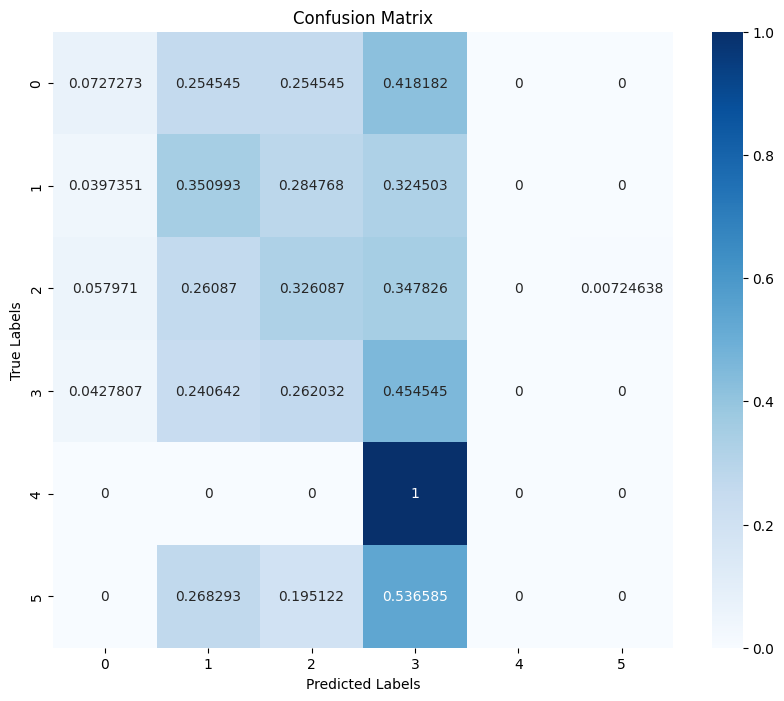

Epoch 8, Validation Loss: 3.0965, Accuracy: 0.3241, F1 Score: 0.3029
Val F1 Score Per Class  [0.09876543 0.34193548 0.3030303  0.40572792 0.         0.        ]


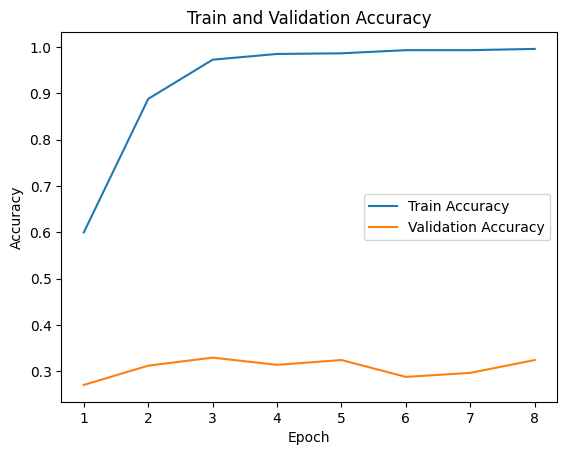

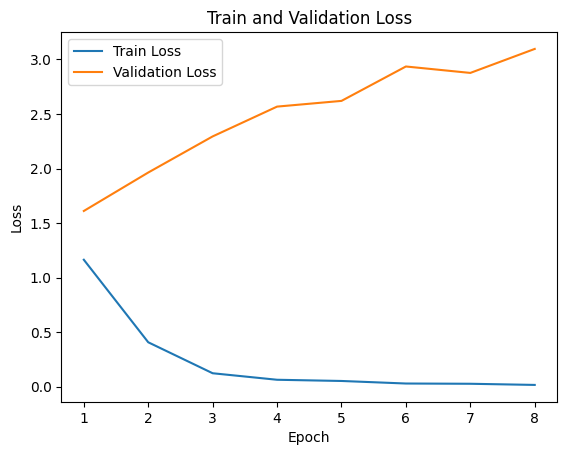

Epoch 9, Train Loss: 0.0111, Accuracy: 0.9971, F1 Score: 0.9971
Train F1 Score Per Class  [0.99640586 0.99614891 0.99619772 0.99465241 1.         0.99939394]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=4.57]

[tensor([-3.0166,  2.9415, -2.9123,  1.1947, -3.2924, -2.2792], device='cuda:0'), tensor([-1.6868,  4.6972, -0.5830, -1.2369, -3.4556, -2.6767], device='cuda:0'), tensor([-1.3587, -1.7478, -0.9581,  0.9338, -4.7268, -2.6011], device='cuda:0'), tensor([-2.0481, -0.3762, -3.1171,  4.3277, -2.8654, -1.8806], device='cuda:0'), tensor([-3.3050,  0.2247,  0.1770, -0.7638, -3.7304, -0.3152], device='cuda:0'), tensor([-3.2856,  1.7981, -1.2794, -0.7932, -2.8034, -3.0152], device='cuda:0'), tensor([-2.1961, -1.9021, -1.4980,  4.4580, -3.5073, -1.1467], device='cuda:0'), tensor([-1.9791, -2.6662,  5.3635,  0.8176, -2.4525, -1.8960], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=3.14]

[tensor([-2.5865, -0.5106, -2.0489, -0.0900, -3.7687,  0.3055], device='cuda:0'), tensor([-3.0772, -0.1843, -2.0016,  0.2624, -2.0415, -2.5337], device='cuda:0'), tensor([-0.7397, -2.9856,  3.1503,  1.0102, -3.0862, -2.7538], device='cuda:0'), tensor([-1.8551, -0.6083, -0.7534,  4.5469, -3.5659, -2.7715], device='cuda:0'), tensor([-1.1430,  3.0800, -1.2725, -0.8472, -4.0227, -3.9443], device='cuda:0'), tensor([-1.1731,  3.5013, -1.3222, -0.6007, -4.0865, -3.6817], device='cuda:0'), tensor([ 0.0189, -2.2643, -2.1253,  5.0841, -2.8335, -2.4792], device='cuda:0'), tensor([ 5.1082, -0.2917, -2.3339, -1.1113, -2.9380, -1.9797], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.14it/s, loss=3.06]

[tensor([-2.2200,  1.3670, -0.4252, -1.3389, -3.7150, -4.6434], device='cuda:0'), tensor([-1.6949,  0.4620,  0.8778, -1.7364, -2.1394, -2.4773], device='cuda:0'), tensor([-1.5505, -1.7214,  5.9307, -1.4496, -1.9439, -1.5056], device='cuda:0'), tensor([-2.0088, -1.9126, -0.5903, -0.7572, -4.3730, -3.5466], device='cuda:0'), tensor([-0.7275,  0.1135, -2.3522,  3.7494, -3.0665, -3.2061], device='cuda:0'), tensor([-0.8059, -0.1065, -2.2352,  2.7834, -4.3810, -3.5636], device='cuda:0'), tensor([-1.6661, -2.0002, -0.6752,  4.0194, -3.2899, -2.1771], device='cuda:0'), tensor([-1.1722, -1.4598, -0.6915, -0.2942, -3.3897, -2.8840], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.15it/s, loss=3.63]

[tensor([-2.0160, -0.2889, -0.8526,  3.9331, -3.4705, -3.5815], device='cuda:0'), tensor([-2.7181,  1.1803,  0.4927, -2.3837, -2.8254, -2.0934], device='cuda:0'), tensor([-1.6176, -1.9206, -2.3806,  0.7127, -3.8465,  0.8937], device='cuda:0'), tensor([-1.6870, -0.7333,  1.8798, -0.9182, -2.4556, -2.3124], device='cuda:0'), tensor([ 5.8571, -1.2658, -1.1010, -0.5986, -2.1119, -2.2168], device='cuda:0'), tensor([-2.2401, -1.8303, -2.5834,  2.4157, -4.1889, -0.5627], device='cuda:0'), tensor([-1.3460,  5.6296, -1.3316, -1.3936, -2.9678, -2.5916], device='cuda:0'), tensor([-2.5996,  1.0246,  2.3103, -2.4701, -1.6871, -0.6001], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.16it/s, loss=3.8]

[tensor([-2.0062, -1.3196, -1.5442,  3.9001, -2.9362, -3.1598], device='cuda:0'), tensor([-2.2500, -1.0090,  4.1353, -0.6210, -3.6514, -3.6428], device='cuda:0'), tensor([-0.3870, -1.3196,  3.1509, -2.8775, -2.3754, -2.4662], device='cuda:0'), tensor([-1.9412,  1.3580, -1.8847,  2.0955, -3.7822, -3.9460], device='cuda:0'), tensor([-1.4964, -2.3825,  3.5449, -0.7171, -2.8020, -2.4989], device='cuda:0'), tensor([-2.0596, -0.9602,  3.8258, -1.3694, -3.8656, -2.5024], device='cuda:0'), tensor([-2.5728,  0.8121, -1.2309, -1.1451, -3.5798, -0.8385], device='cuda:0'), tensor([-1.3612, -0.8498, -2.3094,  3.3048, -2.8794, -0.8260], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=3.78]

[tensor([-1.7519, -0.7820,  6.0994, -2.0790, -2.1144, -2.2681], device='cuda:0'), tensor([-1.7487, -0.4496,  4.7621, -2.0750, -2.4123, -2.9879], device='cuda:0'), tensor([-1.6624, -0.3767,  0.4562, -1.2011, -3.7261, -3.8605], device='cuda:0'), tensor([-2.1277,  0.0520, -1.2747,  1.1599, -3.3189, -3.5508], device='cuda:0'), tensor([-0.6956, -2.6570,  4.4785, -0.9181, -3.2418, -3.1257], device='cuda:0'), tensor([-0.4025, -2.8271, -0.8583,  0.8953, -3.5856, -1.3005], device='cuda:0'), tensor([-0.2136, -3.4249,  3.1632,  1.6414, -2.9270, -3.2955], device='cuda:0'), tensor([-1.6450, -2.2925, -1.4255,  3.3487, -3.0139, -3.2048], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.14it/s, loss=3.02]

[tensor([-1.7369,  0.8277,  2.1321, -0.8357, -3.3748, -1.9860], device='cuda:0'), tensor([-1.6920, -0.4253,  0.2912, -0.3919, -3.5524, -2.3617], device='cuda:0'), tensor([-0.5026, -1.6477,  5.3388, -1.6325, -1.9080, -2.2737], device='cuda:0'), tensor([-1.9929, -2.8690,  0.9011,  2.3282, -3.6571, -2.7289], device='cuda:0'), tensor([-2.0366,  5.4198,  0.1029, -1.8387, -2.6930, -2.8366], device='cuda:0'), tensor([-2.2334, -0.7170, -0.5294, -0.9552, -2.6405, -1.1020], device='cuda:0'), tensor([-1.8617, -2.4658,  5.6818, -1.1551, -2.9865, -1.3666], device='cuda:0'), tensor([-2.4675,  0.7429, -1.9333, -0.3801, -3.5131, -3.2407], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=5.1]

[tensor([-0.8092, -2.1037, -1.8230,  2.3625, -3.3713, -3.1506], device='cuda:0'), tensor([-1.7364, -2.3341,  2.2512, -0.3393, -2.6665, -2.2571], device='cuda:0'), tensor([-1.0771, -1.2243, -2.1147,  5.6345, -3.3775, -2.3383], device='cuda:0'), tensor([-1.8285,  6.1081, -1.5444, -1.0546, -2.5646, -2.5204], device='cuda:0'), tensor([-1.8745, -1.5453,  4.8540, -2.5136, -2.3002, -2.6730], device='cuda:0'), tensor([-1.4806e+00,  1.5756e+00, -1.0787e+00,  2.9303e-03, -3.7787e+00,
        -4.4020e+00], device='cuda:0'), tensor([-2.1813, -2.9314,  1.4908, -1.3453, -3.5903, -1.7347], device='cuda:0'), tensor([-1.6330, -1.4304,  5.4127, -1.0538, -2.3259, -2.3738], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.16it/s, loss=4.42]

[tensor([-2.8943, -0.8323, -0.9730,  0.0361, -3.9436, -1.1258], device='cuda:0'), tensor([ 0.2184,  2.8583, -0.8018, -1.2828, -3.5819, -4.0440], device='cuda:0'), tensor([-0.1074,  1.5264, -1.8804,  1.4113, -2.5748, -3.9669], device='cuda:0'), tensor([-1.0653, -2.2610,  1.4015, -0.0267, -2.8995, -2.0936], device='cuda:0'), tensor([-0.9470, -2.2902, -0.6922,  1.3369, -2.4396, -2.4819], device='cuda:0'), tensor([-2.6571,  3.9957, -0.1374, -0.6084, -3.4984, -2.7738], device='cuda:0'), tensor([-2.7529, -1.3507, -1.6770,  5.1347, -3.3734, -2.4538], device='cuda:0'), tensor([-0.3652, -2.6738, -1.1288,  3.4521, -3.8889, -2.8795], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=1.55]

[tensor([-2.2882,  1.4394, -0.8385, -2.4809, -2.2338, -2.5329], device='cuda:0'), tensor([-2.3063, -1.6777,  2.3674,  0.8837, -3.2102, -2.7272], device='cuda:0'), tensor([-1.0004,  3.1506, -1.8261, -2.2455, -2.4792, -2.0362], device='cuda:0'), tensor([-1.2170, -0.9942, -0.2019, -0.5491, -3.9527, -2.9998], device='cuda:0'), tensor([-2.1676,  4.5339,  1.1827, -0.9937, -3.2697, -3.0049], device='cuda:0'), tensor([-0.0908,  0.5640,  1.3049,  0.3233, -4.2227, -4.0330], device='cuda:0'), tensor([-1.9895, -1.1265, -2.7020,  0.6050, -4.3703, -3.3144], device='cuda:0'), tensor([-2.3921,  2.3418, -1.0897,  2.0151, -4.1854, -3.9870], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.14it/s, loss=5.03]

[tensor([-2.1211, -1.5355, -0.4359,  3.5320, -3.2123, -3.1914], device='cuda:0'), tensor([-1.2080,  5.9327, -1.9482, -0.9569, -2.7497, -1.5318], device='cuda:0'), tensor([-2.0318, -1.8547,  3.7613, -0.7407, -3.5009, -1.4000], device='cuda:0'), tensor([-2.1689, -1.4309, -1.0371,  4.6885, -3.9289, -2.9589], device='cuda:0'), tensor([-2.3667,  5.8010, -0.8410, -1.5450, -2.8032, -1.5558], device='cuda:0'), tensor([-0.6955, -0.9119, -3.0794,  2.9130, -3.4717, -2.2491], device='cuda:0'), tensor([-2.3660,  0.4298,  5.3381, -2.3378, -2.3017, -2.2037], device='cuda:0'), tensor([-1.3559,  0.3624, -2.2288,  2.6239, -3.4629, -4.1594], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=4.25]

[tensor([-0.8829, -1.7807,  5.1701, -1.5572, -2.5956, -2.7256], device='cuda:0'), tensor([-1.9650, -1.3639, -0.9707,  4.1913, -3.2632, -3.1590], device='cuda:0'), tensor([-2.5940, -0.3914,  5.1258, -1.5375, -2.2760, -3.3647], device='cuda:0'), tensor([-0.7223, -0.6486, -1.7914, -0.9915, -3.3776, -3.2328], device='cuda:0'), tensor([ 4.7945, -1.8618, -2.8836, -0.0896, -2.1555, -2.6347], device='cuda:0'), tensor([-1.6615, -1.7067,  6.2205, -0.9858, -2.3126, -1.7398], device='cuda:0'), tensor([-1.7946,  1.2679, -2.0559,  0.3612, -3.4584, -2.5964], device='cuda:0'), tensor([-0.7188, -1.1503,  1.6307, -1.2600, -3.3156, -2.1366], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.15it/s, loss=2.14]

[tensor([-2.3418, -1.1342, -1.4469,  0.4109, -4.3164, -3.8673], device='cuda:0'), tensor([-2.9472,  3.3720,  1.3349, -1.0410, -2.8917, -2.9055], device='cuda:0'), tensor([-2.5481,  0.9670,  0.9335, -1.5966, -4.3122, -3.2876], device='cuda:0'), tensor([-2.1764,  4.4566,  1.2618, -2.4563, -2.8916, -2.2050], device='cuda:0'), tensor([-2.8135,  5.4187, -0.6943, -1.3278, -3.1531, -1.9711], device='cuda:0'), tensor([-2.4383, -1.7041,  0.8870, -0.7805, -3.8639, -2.3255], device='cuda:0'), tensor([-2.9992,  3.0386,  1.0764, -1.8625, -3.0443, -2.0009], device='cuda:0'), tensor([-2.0410,  1.6613, -1.1781,  0.0585, -3.6642, -3.4981], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=1.64]

[tensor([-2.3053, -2.1288,  0.6508, -2.3923, -3.3061, -1.4789], device='cuda:0'), tensor([-2.0090, -1.4581, -1.5749,  0.0356, -3.6972, -2.7003], device='cuda:0'), tensor([-1.6770, -2.3169, -1.2846, -2.1961, -2.3062,  3.9993], device='cuda:0'), tensor([-1.7162,  1.2444,  2.8892, -2.2217, -3.2444, -2.5212], device='cuda:0'), tensor([-2.8002, -0.9571, -2.0646,  4.1542, -2.0306, -2.0876], device='cuda:0'), tensor([-2.4530,  2.0935, -0.4629,  2.0223, -3.1703, -3.5229], device='cuda:0'), tensor([-1.9635, -0.5865, -1.4278, -0.4152, -3.4718, -3.1212], device='cuda:0'), tensor([-1.9992, -0.1870, -1.3072,  3.3818, -4.0236, -3.2100], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:27,  2.15it/s, loss=3.82]

[tensor([-2.1262,  3.9856, -1.3725, -0.3615, -3.6236, -3.1256], device='cuda:0'), tensor([-1.4932,  0.2497, -0.1332, -2.4029, -2.7840, -2.5339], device='cuda:0'), tensor([-1.5748, -1.0061,  5.8150, -2.1367, -2.0955, -1.6586], device='cuda:0'), tensor([-1.4715, -3.0879,  0.5239,  4.4417, -3.2466, -2.8384], device='cuda:0'), tensor([-1.3598, -1.1104, -1.8246,  5.0173, -3.1075, -2.8870], device='cuda:0'), tensor([-2.6210,  2.6001, -0.6804, -1.7162, -3.0561, -3.5188], device='cuda:0'), tensor([-2.7565, -1.5767,  1.8043, -0.6094, -3.7072, -2.3118], device='cuda:0'), tensor([-1.8778,  1.5664,  1.6902, -2.3411, -2.8850, -3.3521], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=2.55]

[tensor([-1.4489, -1.4454, -1.5037,  5.6701, -3.3981, -2.4831], device='cuda:0'), tensor([-2.0820,  4.6686,  0.7027, -2.5383, -2.8696, -2.1374], device='cuda:0'), tensor([-2.3949, -0.6665, -1.8159,  3.9490, -3.2831, -3.1632], device='cuda:0'), tensor([-3.1368,  2.8124,  0.0208, -0.6053, -4.0327, -2.2725], device='cuda:0'), tensor([-0.8862, -2.9141, -0.5678, -0.0979, -3.1785, -3.1471], device='cuda:0'), tensor([-2.6063,  0.0876,  5.5523, -1.7866, -2.3280, -2.2580], device='cuda:0'), tensor([-2.2032, -2.0627,  0.1828,  3.4522, -4.3974, -3.2409], device='cuda:0'), tensor([-2.3576, -0.4343,  5.0379, -2.2349, -2.9024, -1.8100], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.15it/s, loss=2.97]

[tensor([-1.9766,  0.3307,  1.3608, -2.0738, -3.2352, -2.6202], device='cuda:0'), tensor([-1.2246,  2.2370,  0.3109, -1.6161, -3.1323, -2.2794], device='cuda:0'), tensor([-1.7939,  2.2066,  2.4902, -2.7476, -2.6175, -2.8967], device='cuda:0'), tensor([-2.2531,  3.3379,  0.3871, -1.3396, -3.7175, -3.4519], device='cuda:0'), tensor([-2.1454e+00, -3.2339e+00,  5.4549e-04,  4.0331e+00, -2.3768e+00,
        -1.6406e+00], device='cuda:0'), tensor([-1.6803, -2.4750, -1.1534, -0.3664, -3.5301, -1.5833], device='cuda:0'), tensor([ 3.3256, -1.8677,  0.5587, -2.8001, -3.0495, -1.5018], device='cuda:0'), tensor([-1.5592, -1.0826, -2.4987,  1.8559, -2.9222, -2.4834], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=1.38]

[tensor([-3.4103, -1.1697,  2.9857, -0.5982, -3.3899, -3.2285], device='cuda:0'), tensor([ 1.0743, -2.8479, -0.7611,  2.4748, -2.4316, -3.4455], device='cuda:0'), tensor([-2.9651, -1.0726, -2.7038, -0.8370, -4.1629,  0.1078], device='cuda:0'), tensor([-1.9738,  0.2343, -0.7215, -0.3222, -3.4363, -3.9782], device='cuda:0'), tensor([-2.7288, -2.4842,  0.2741, -0.9536, -1.7540, -2.2486], device='cuda:0'), tensor([-1.5010, -1.2467,  2.1630, -1.6296, -3.0867, -1.8870], device='cuda:0'), tensor([-1.2180,  0.3530, -0.1953, -1.4639, -3.6248, -2.6040], device='cuda:0'), tensor([-3.3584, -0.6382, -0.4977,  0.8570, -2.9039, -3.0936], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.16it/s, loss=1.59]

[tensor([-2.4973, -2.3616,  0.2620,  0.5763, -2.9121, -3.5584], device='cuda:0'), tensor([ 2.8719, -1.7784, -1.9992,  1.5126, -3.1117, -2.8657], device='cuda:0'), tensor([-1.7921, -0.7299,  5.8850, -1.3190, -2.0132, -2.5336], device='cuda:0'), tensor([-1.9430, -2.9878, -0.5560,  4.3136, -2.8193, -2.7627], device='cuda:0'), tensor([-1.0985,  4.6461, -2.1167, -1.0510, -3.7483, -3.1444], device='cuda:0'), tensor([ 1.0111, -1.6379, -2.5351,  1.3468, -3.2427, -2.8527], device='cuda:0'), tensor([-2.3368, -1.6696, -1.0028,  4.1610, -3.8310, -2.3260], device='cuda:0'), tensor([-1.5263,  0.0892,  1.3808, -1.4255, -2.5544, -2.1609], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=3.72]

[tensor([-2.3253, -1.8224,  2.0476,  0.4089, -3.7879, -3.8945], device='cuda:0'), tensor([-2.6624,  2.5238, -2.7548,  1.0786, -2.4210, -2.7304], device='cuda:0'), tensor([-1.7058, -2.4180,  2.5923, -0.0222, -2.8001, -1.8103], device='cuda:0'), tensor([ 0.1323, -2.9572,  3.9524, -1.6069, -3.1988, -2.4701], device='cuda:0'), tensor([ 0.2590,  0.2881,  0.2776, -2.1629, -3.5019, -3.1404], device='cuda:0'), tensor([-1.9917,  5.3372, -0.8356, -1.3790, -3.0232, -1.5878], device='cuda:0'), tensor([-2.7883, -1.2569,  0.1916,  1.9084, -3.7096, -2.7755], device='cuda:0'), tensor([-1.9726, -0.6545,  4.9334, -1.3709, -2.7231, -2.9285], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.16it/s, loss=4.43]

[tensor([-0.7606, -2.8647,  4.9805, -0.4033, -2.2661, -1.9433], device='cuda:0'), tensor([-1.7234,  0.3665, -2.6454,  2.5962, -3.3828, -3.0918], device='cuda:0'), tensor([-2.7741,  2.0774,  3.7960, -2.2023, -3.1535, -2.3089], device='cuda:0'), tensor([-1.6039, -2.2911,  6.0167, -0.8073, -2.4329, -2.2401], device='cuda:0'), tensor([-0.9455, -1.8517,  5.3460, -0.9297, -2.7469, -2.9538], device='cuda:0'), tensor([-2.0379,  0.5148, -1.3961, -1.6701, -3.2454, -2.0063], device='cuda:0'), tensor([-1.1144, -2.3320, -1.0936,  5.7788, -2.4223, -2.5964], device='cuda:0'), tensor([-1.3904, -1.7734, -0.9106,  4.5155, -2.4544, -1.3177], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.16it/s, loss=2]

[tensor([-2.1348,  1.2961, -2.2116,  3.4582, -3.5464, -3.2446], device='cuda:0'), tensor([-2.3413,  0.3783, -0.6644, -0.2610, -3.7202, -2.2586], device='cuda:0'), tensor([-2.0134, -1.7887,  3.4098, -0.7320, -2.8074, -2.9427], device='cuda:0'), tensor([-2.1953, -2.1964, -0.9792,  4.3484, -2.8697, -1.9339], device='cuda:0'), tensor([-1.3398, -1.6655, -0.4722,  2.8844, -3.1721, -3.5084], device='cuda:0'), tensor([ 1.5368, -3.6103,  1.3061,  2.3334, -2.7880, -3.2915], device='cuda:0'), tensor([-1.7676,  1.3102, -1.2961, -0.0499, -3.6919, -2.6115], device='cuda:0'), tensor([-2.3303, -1.4063,  5.2071, -1.2111, -2.3566, -2.6696], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.16it/s, loss=2.38]

[tensor([-0.7764, -0.4616, -0.9312, -0.3058, -3.3107, -3.0151], device='cuda:0'), tensor([-2.6507, -1.0269,  2.1689, -0.1267, -4.0219, -2.6631], device='cuda:0'), tensor([-0.6567, -1.4460, -2.2721,  4.0326, -2.0229, -2.4452], device='cuda:0'), tensor([-3.0104, -0.9885, -0.9291,  2.0705, -3.7334, -3.6427], device='cuda:0'), tensor([-2.7204,  0.6708,  0.1471,  1.3941, -3.7778, -3.0233], device='cuda:0'), tensor([-1.4461, -1.0610, -2.2507,  5.7703, -2.7169, -2.3493], device='cuda:0'), tensor([-1.1663, -2.5006,  3.4714,  0.0278, -3.1047, -2.5508], device='cuda:0'), tensor([-1.9061, -1.5684,  5.9043, -2.1466, -1.9611, -2.0365], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=2.32]

[tensor([-1.2782, -1.5278, -2.4120,  2.7436, -2.6190, -0.3167], device='cuda:0'), tensor([ 0.8726, -0.9509, -1.2732, -0.9335, -3.5348, -2.0466], device='cuda:0'), tensor([-1.0280, -1.6535, -1.9637,  5.4857, -2.4449, -2.7291], device='cuda:0'), tensor([-0.3510, -1.8973,  2.7994, -2.2919, -2.4605, -3.0019], device='cuda:0'), tensor([-2.5183,  2.3168,  3.3349, -2.1326, -2.5995, -2.9316], device='cuda:0'), tensor([-2.2414, -1.7723, -1.3408,  0.8832, -2.9942, -3.7304], device='cuda:0'), tensor([-2.5766, -0.9477, -2.4647,  4.4736, -2.1075, -1.0151], device='cuda:0'), tensor([-1.1210,  0.3889, -2.3401,  1.6678, -4.7588, -2.9035], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.14it/s, loss=3.56]

[tensor([-2.8715, -0.1165,  1.1686,  1.5283, -4.5721, -1.5669], device='cuda:0'), tensor([-1.0822,  0.5359, -1.7067,  3.0465, -3.5153, -2.2953], device='cuda:0'), tensor([-2.7924,  0.7736, -1.2057, -0.0144, -4.3026, -3.3494], device='cuda:0'), tensor([-1.9137, -1.0746,  5.0996, -1.6730, -2.0579, -2.6531], device='cuda:0'), tensor([ 0.4201, -2.3403, -0.3254,  0.0996, -3.4755, -3.6078], device='cuda:0'), tensor([-1.5445,  5.0821, -0.1529, -2.6612, -2.5257, -1.7092], device='cuda:0'), tensor([-2.3178,  5.5724, -2.1863, -1.7184, -3.6654, -1.4623], device='cuda:0'), tensor([-2.5350,  2.3779, -2.1106,  0.5815, -4.2764, -2.0817], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.14it/s, loss=3.46]

[tensor([-2.0057,  1.8895, -1.1487, -1.4296, -4.4728, -1.3209], device='cuda:0'), tensor([-1.3117, -0.9089,  0.8165, -2.4645, -3.2204, -1.7940], device='cuda:0'), tensor([-2.2234, -1.1471,  2.5067,  0.1752, -3.3098, -3.5630], device='cuda:0'), tensor([-1.1915,  1.4457, -0.0202, -1.8872, -2.9881, -3.5217], device='cuda:0'), tensor([-1.0599,  4.9640, -1.9676, -1.2829, -2.9845, -2.9827], device='cuda:0'), tensor([-2.5924, -2.3982,  3.8614, -0.6926, -2.7568, -2.1972], device='cuda:0'), tensor([ 0.2626, -2.0757, -0.4576, -0.6862, -3.7373, -2.3582], device='cuda:0'), tensor([-0.9032, -2.6499,  3.4677, -0.6529, -2.6327, -2.4230], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.15it/s, loss=2.5]

[tensor([-1.4965, -0.4098, -2.8380,  1.8654, -2.7707,  1.4393], device='cuda:0'), tensor([-1.7646,  3.8606,  1.7854, -2.0643, -2.8411, -3.3331], device='cuda:0'), tensor([-1.7747, -0.8480, -1.4054,  1.3005, -3.7724, -2.7841], device='cuda:0'), tensor([-1.8388, -0.9068, -2.1684,  3.4874, -3.1291, -2.5514], device='cuda:0'), tensor([-1.5175, -1.6320, -1.7770,  0.8048, -3.0326, -2.7316], device='cuda:0'), tensor([-2.6792,  2.9034, -0.8225,  0.2021, -3.6785, -4.6020], device='cuda:0'), tensor([-2.4123, -1.3406,  2.1935, -1.8344, -3.6078, -3.0754], device='cuda:0'), tensor([-2.5050,  5.2756, -1.9619, -0.5552, -2.6436, -1.7889], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.15it/s, loss=3.29]

[tensor([-0.4011, -2.2266,  4.7857, -0.9451, -2.4191, -2.6450], device='cuda:0'), tensor([-1.8695, -2.3792, -1.9024,  1.8922, -3.6251, -3.2170], device='cuda:0'), tensor([-1.6447,  0.1069, -0.6893,  0.1141, -4.0889, -3.9646], device='cuda:0'), tensor([-1.8065, -2.9230,  3.2031,  0.7995, -3.2900, -1.9666], device='cuda:0'), tensor([-1.4198,  0.5130,  4.1592, -2.6180, -2.0327, -2.2563], device='cuda:0'), tensor([-1.9957,  2.7164, -0.4693, -1.2069, -2.8351, -2.0693], device='cuda:0'), tensor([-1.7126, -2.5448,  3.8958,  0.2188, -3.1342, -1.7128], device='cuda:0'), tensor([-1.3191, -1.6610,  5.9823, -1.2591, -2.2648, -2.1065], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.16it/s, loss=4.2]

[tensor([ 4.2300, -2.1906, -0.8811, -0.8418, -2.6778, -0.8351], device='cuda:0'), tensor([-2.4268,  3.5855,  0.2764, -1.5853, -2.8304, -3.0532], device='cuda:0'), tensor([-1.2605, -1.5284, -2.3130,  3.4489, -3.3330, -3.5037], device='cuda:0'), tensor([-1.2793, -1.1026,  4.5602, -0.8652, -2.5489, -2.0579], device='cuda:0'), tensor([-0.3326,  0.8891, -0.2427,  0.5787, -3.5644, -4.0699], device='cuda:0'), tensor([-2.1941, -1.1953,  5.3680, -1.4062, -3.1156, -1.7581], device='cuda:0'), tensor([-1.7461, -1.5819,  4.6242, -1.0605, -2.7634, -1.7106], device='cuda:0'), tensor([-2.1024,  5.9272, -1.0450, -1.5961, -2.2514, -2.0442], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=5.52]

[tensor([-2.1346,  4.7376,  0.6238, -2.0487, -3.2131, -3.3946], device='cuda:0'), tensor([-2.0081, -2.5229,  4.4627,  1.5388, -2.9081, -3.0058], device='cuda:0'), tensor([-2.6476,  4.7017, -2.1707, -2.0633, -3.3582, -0.5423], device='cuda:0'), tensor([-2.7030,  0.8227, -1.2624,  0.0385, -2.7558, -1.0609], device='cuda:0'), tensor([-1.1569, -1.4864, -1.9806,  5.2995, -2.3251, -2.6502], device='cuda:0'), tensor([-0.8321, -2.5272,  2.5648, -1.1102, -3.0644, -2.6643], device='cuda:0'), tensor([-0.3383, -2.5987,  1.2754,  0.8623, -2.2411, -1.5735], device='cuda:0'), tensor([ 6.4908, -0.8858, -1.9021, -1.2822, -1.7519, -1.0185], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.17it/s, loss=2.16]

[tensor([-1.9503, -2.9227,  1.3371,  2.7740, -3.0283, -1.8508], device='cuda:0'), tensor([-1.1927, -3.2383,  1.2098,  2.0466, -4.6573, -3.6065], device='cuda:0'), tensor([-1.8935, -2.3158,  3.2890,  1.1383, -3.2092, -2.9493], device='cuda:0'), tensor([-0.7607,  0.1781,  2.5627, -1.0960, -4.1445, -3.7079], device='cuda:0'), tensor([ 1.6152, -0.9563, -0.8110, -2.2309, -3.3631, -2.9231], device='cuda:0'), tensor([-2.1431, -0.8087, -2.4337,  0.1020, -2.5910,  0.2734], device='cuda:0'), tensor([-0.7052,  5.2560, -1.9635, -1.5059, -2.3637, -1.8892], device='cuda:0'), tensor([-2.6130,  2.2022, -1.5595,  1.4912, -3.0340, -3.5060], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.17it/s, loss=4.62]

[tensor([-2.5172,  1.1730,  1.3938, -2.6030, -3.2021, -1.9769], device='cuda:0'), tensor([-1.1848, -1.3289,  4.2227, -1.1918, -3.0585, -3.2155], device='cuda:0'), tensor([-2.3073,  5.8584, -1.1875, -1.7876, -3.0204, -2.4961], device='cuda:0'), tensor([-1.1483, -2.0481,  3.7366, -1.8461, -2.3548, -2.9459], device='cuda:0'), tensor([-2.4514,  0.0252,  5.3807, -2.6176, -2.0296, -1.2295], device='cuda:0'), tensor([-1.2630,  3.6916, -3.1575, -0.6265, -3.1252, -2.3039], device='cuda:0'), tensor([-2.5148, -1.6264,  0.0330, -1.7946, -2.9118,  3.0915], device='cuda:0'), tensor([ 4.3757, -1.9422,  0.0889, -1.1661, -1.1674, -2.5783], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.17it/s, loss=3.27]

[tensor([-2.1205, -0.8051,  0.8553, -0.7106, -3.6159, -4.1216], device='cuda:0'), tensor([ 2.1048, -0.9349, -2.9142, -0.0126, -1.9460, -2.1819], device='cuda:0'), tensor([-2.7149,  0.5795, -0.6724, -0.6491, -3.6429, -3.5603], device='cuda:0'), tensor([-1.8039,  0.4027, -1.9267, -1.4828, -3.0735,  4.2596], device='cuda:0'), tensor([-0.9784,  1.1265, -2.7992,  1.4650, -3.1867, -3.1993], device='cuda:0'), tensor([-3.0681, -0.6155, -0.0450, -0.7831, -3.2998, -2.8553], device='cuda:0'), tensor([-2.3441,  0.4732,  3.0868, -2.4545, -2.8479, -2.6669], device='cuda:0'), tensor([-1.3544, -1.6623, -1.2425,  2.4376, -3.6245, -3.3139], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.49]

[tensor([-2.5661,  0.2028,  3.6344, -1.6876, -3.0995, -3.3120], device='cuda:0'), tensor([-2.1239, -2.1766,  1.5193, -0.9137, -3.1980, -3.1347], device='cuda:0'), tensor([-1.4089, -0.7919,  5.1631, -2.3669, -2.2759, -2.5311], device='cuda:0'), tensor([-1.9987, -1.3812,  4.8474, -1.4691, -3.3754, -2.4791], device='cuda:0'), tensor([-1.4014, -1.9311, -2.0603,  4.7005, -3.2009, -2.4157], device='cuda:0'), tensor([-1.7671,  0.2570,  1.3838, -2.9258, -2.6649, -1.9826], device='cuda:0'), tensor([ 4.7036, -2.3490, -1.4132, -0.8103, -2.4951, -2.1282], device='cuda:0'), tensor([-0.6420, -0.3089, -0.1038, -2.3679, -3.9416, -3.3445], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.14it/s, loss=2.91]

[tensor([-1.7835, -0.7770, -1.9174,  3.0336, -3.2797, -4.3936], device='cuda:0'), tensor([-1.8744, -0.3433,  1.1750, -3.4421, -2.3624, -0.7144], device='cuda:0'), tensor([-1.0928, -1.6326, -2.4449,  4.0040, -3.5629, -2.9259], device='cuda:0'), tensor([-0.3078, -2.9958,  3.2541, -1.5217, -2.9567, -2.2991], device='cuda:0'), tensor([-1.6359, -0.4748,  1.8760, -1.3253, -2.5027, -1.9813], device='cuda:0'), tensor([-2.4560, -1.1235, -2.0366,  4.1563, -3.2882, -1.4855], device='cuda:0'), tensor([-1.2135, -1.8831,  0.7792, -1.0319, -3.5993, -3.2876], device='cuda:0'), tensor([-2.5540,  0.7451, -2.0720,  0.1371, -3.1400, -2.7337], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.14it/s, loss=3.43]

[tensor([-2.8307, -0.6153, -1.5809, -0.9117, -3.4381, -2.4003], device='cuda:0'), tensor([ 6.7169, -1.4513, -1.0983, -1.1142, -1.9345, -1.5964], device='cuda:0'), tensor([-2.5973,  0.6580, -1.8363,  0.8767, -2.8633, -3.2602], device='cuda:0'), tensor([-2.5317,  2.5368, -0.9467,  0.0036, -2.9170, -3.5177], device='cuda:0'), tensor([-1.2973, -2.6835,  0.9063, -0.5947, -3.0615, -3.2892], device='cuda:0'), tensor([-2.5069,  4.5054, -1.4794, -1.1704, -2.0841, -3.2232], device='cuda:0'), tensor([-2.3493,  5.3421, -0.1572, -1.5156, -3.0643, -2.2494], device='cuda:0'), tensor([-2.2704,  3.8535, -0.3912, -2.0823, -2.6460, -2.9881], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=4.24]

[tensor([-1.9233,  0.0735, -2.3129,  2.5451, -3.0150, -2.5204], device='cuda:0'), tensor([-2.1487,  5.5162, -2.3747, -1.6887, -2.3479, -2.2514], device='cuda:0'), tensor([-0.7996, -1.7546, -1.8008,  5.1800, -3.8261, -2.4834], device='cuda:0'), tensor([-1.4657, -1.9985,  4.9423, -1.8700, -3.0328, -2.6950], device='cuda:0'), tensor([-1.9814,  0.6848, -0.8407, -2.0597, -2.5624, -1.8009], device='cuda:0'), tensor([-1.6138,  0.9554, -1.4593, -1.0605, -2.8218, -2.8485], device='cuda:0'), tensor([-1.9485,  2.8768, -0.4532, -0.6273, -3.8551, -3.9110], device='cuda:0'), tensor([-2.2962, -0.7214, -2.1427, -0.1160, -3.4429, -2.2910], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.15it/s, loss=4.06]

[tensor([-3.0031,  0.4581, -2.8156,  1.8745, -2.7634, -0.9972], device='cuda:0'), tensor([-1.8536, -0.4012,  3.9850, -0.7936, -1.6656, -2.4769], device='cuda:0'), tensor([-1.8574, -0.4172,  0.3394,  2.9885, -3.1596, -3.7603], device='cuda:0'), tensor([-1.2140, -1.8058,  5.9373, -1.6953, -2.0897, -1.8473], device='cuda:0'), tensor([-1.7137, -1.6618,  5.7434, -1.5032, -2.4621, -1.2786], device='cuda:0'), tensor([-0.4465, -2.0192, -0.1738,  1.0838, -3.4512, -4.0425], device='cuda:0'), tensor([-1.8789,  0.0611, -2.1577,  2.0336, -3.1773, -2.1439], device='cuda:0'), tensor([-1.6552,  5.6142, -1.5007, -0.6591, -2.2881, -2.6568], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=2.23]

[tensor([-1.5218, -1.6644,  5.6337, -1.6724, -2.4731, -2.2440], device='cuda:0'), tensor([-1.9993, -1.0186, -2.7956,  3.6220, -1.7471,  0.1568], device='cuda:0'), tensor([ 0.1563, -0.3376, -2.7219,  0.7962, -3.2080, -3.0540], device='cuda:0'), tensor([-1.7226, -1.5231, -0.3553,  0.7801, -4.3624, -4.0408], device='cuda:0'), tensor([ 1.2903, -0.6456, -2.5621,  2.1347, -3.7808, -3.3005], device='cuda:0'), tensor([-1.4424, -2.9048,  4.5867, -0.5691, -2.6630, -2.6481], device='cuda:0'), tensor([-1.5053,  0.2590, -2.7791,  1.6710, -2.1416, -3.2453], device='cuda:0'), tensor([-3.0579,  0.2254,  0.9159,  0.9022, -3.0648, -3.4413], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=3.49]

[tensor([-2.8124,  3.5512, -1.9192, -0.2547, -3.2913, -3.4242], device='cuda:0'), tensor([-3.0621, -0.8102, -1.6518,  3.0898, -3.6476, -2.6992], device='cuda:0'), tensor([-2.9028,  1.1371, -0.6915, -1.6256, -3.0408, -2.5798], device='cuda:0'), tensor([-0.6271, -2.3264,  5.8357, -1.9251, -1.9284, -1.8154], device='cuda:0'), tensor([-0.7155,  1.5960, -3.0894,  2.0939, -2.2619, -3.4051], device='cuda:0'), tensor([-2.0807, -1.4758,  5.6366, -2.0459, -2.5278, -1.4207], device='cuda:0'), tensor([-1.2182, -2.3903,  1.7548, -0.9269, -3.7337, -2.7238], device='cuda:0'), tensor([-0.3902, -1.5524,  2.4050, -0.2295, -1.0679, -2.7440], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.16it/s, loss=2.99]

[tensor([-1.1524, -1.7656, -1.3837,  5.7157, -2.8457, -3.0785], device='cuda:0'), tensor([-1.5619, -1.5550, -2.1918,  4.1594, -4.4976, -3.0076], device='cuda:0'), tensor([-2.0085,  0.7679, -1.7290,  1.1297, -3.6748, -3.1213], device='cuda:0'), tensor([-0.0857, -1.2067, -2.8210,  3.1847, -3.2538, -2.4334], device='cuda:0'), tensor([-2.0462,  2.0256,  1.1018, -1.9794, -2.6895, -3.1559], device='cuda:0'), tensor([-1.8519, -1.7185,  6.0377, -1.0573, -2.1949, -2.3636], device='cuda:0'), tensor([-1.4296, -1.3721, -1.8845,  0.5596, -3.2491, -2.6319], device='cuda:0'), tensor([ 0.1401, -2.2831,  4.4303, -0.9404, -2.8285, -3.0573], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=2.95]

[tensor([-3.2477, -1.8865,  2.0426, -0.0461, -3.5405, -0.9921], device='cuda:0'), tensor([-1.6222, -0.3966, -2.1418,  2.9545, -3.1841, -3.4221], device='cuda:0'), tensor([ 5.7086, -1.2484, -1.0666, -1.7707, -2.6372, -0.3910], device='cuda:0'), tensor([-2.2152,  4.5103, -1.6394, -0.0524, -2.8376, -2.8616], device='cuda:0'), tensor([-1.5414, -1.0284, -2.6840,  5.3058, -3.2130, -2.0931], device='cuda:0'), tensor([-1.4661, -0.4177, -2.8242,  1.6748, -3.4220, -3.0941], device='cuda:0'), tensor([-0.3582,  0.2986, -1.4360,  2.2018, -4.2002, -3.9190], device='cuda:0'), tensor([-1.9321,  0.7954,  0.1180, -2.1890, -3.5703, -0.2758], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.17it/s, loss=2.61]

[tensor([-1.9810,  3.7683, -2.0006, -0.3546, -3.4363, -2.7705], device='cuda:0'), tensor([-2.6905, -0.6934, -1.1520, -1.9174, -3.3522, -2.4108], device='cuda:0'), tensor([-1.6618, -1.1409, -0.6065,  3.7917, -4.4647, -2.7284], device='cuda:0'), tensor([-0.7536, -2.1560, -0.7191,  2.7005, -3.9427, -3.1525], device='cuda:0'), tensor([-2.3913,  3.2996,  1.6390, -0.9282, -3.3138, -3.6690], device='cuda:0'), tensor([-1.6919, -2.6976, -1.0155,  2.6691, -3.7457, -2.8876], device='cuda:0'), tensor([-1.4740, -3.5914,  1.3503,  3.8285, -3.4034, -2.9696], device='cuda:0'), tensor([ 2.0458, -1.8034, -0.8178, -0.7648, -2.4066, -2.9722], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.17it/s, loss=3.82]

[tensor([ 1.1983, -1.4617, -0.2991,  0.8130, -2.4143, -3.4350], device='cuda:0'), tensor([-0.0373, -2.7298,  2.5644, -0.1150, -2.4426, -2.3212], device='cuda:0'), tensor([-3.3102, -1.3181,  2.9077, -1.6210, -3.5905, -2.9948], device='cuda:0'), tensor([-2.9538, -1.8312,  4.0053, -0.3055, -3.5133, -1.7485], device='cuda:0'), tensor([-1.7851, -2.1866,  1.0611,  0.8049, -0.8476, -1.5329], device='cuda:0'), tensor([-2.8194,  0.9186,  4.1706, -1.7764, -3.1007, -2.7527], device='cuda:0'), tensor([-1.3020, -1.7377,  4.4025,  0.3078, -2.5306, -2.2818], device='cuda:0'), tensor([-1.0861,  4.0073, -0.5105, -2.2308, -2.9197, -0.6508], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.16it/s, loss=2.95]

[tensor([ 3.7749, -0.5878, -1.8334, -1.3525, -3.6419, -1.8436], device='cuda:0'), tensor([-1.9743,  0.7651, -2.7633,  2.2930, -2.5121, -2.7513], device='cuda:0'), tensor([-2.7342,  2.0497, -1.9095,  2.9541, -3.8221, -2.3331], device='cuda:0'), tensor([-1.8612, -0.6480,  0.5498, -1.7806, -2.4612, -3.0801], device='cuda:0'), tensor([-0.6722, -2.8053,  4.1388, -0.9120, -2.9139, -1.6992], device='cuda:0'), tensor([-1.9181, -1.7881, -1.9421, -1.2175, -2.8159,  4.0772], device='cuda:0'), tensor([-2.9216,  1.0836,  2.4863, -1.4353, -3.4830, -2.3484], device='cuda:0'), tensor([-2.3660, -1.2595, -1.8425,  0.3887, -3.6306, -0.4330], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=2.65]

[tensor([-1.6066, -2.0360,  3.4391, -0.9441, -3.3701, -2.4619], device='cuda:0'), tensor([-0.4995,  1.0808, -2.3750, -0.6809, -2.2945, -2.0628], device='cuda:0'), tensor([-3.3063, -0.8424, -1.7649,  3.3040, -3.1453, -3.6867], device='cuda:0'), tensor([-1.3736, -2.0464,  6.0843, -1.7059, -2.0167, -1.3076], device='cuda:0'), tensor([-2.2882, -0.7291, -2.8454,  4.6426, -2.8750, -2.0782], device='cuda:0'), tensor([-1.4411,  0.4572, -2.7562,  1.1887, -1.7998, -2.6431], device='cuda:0'), tensor([-1.9047, -1.6208,  4.6803, -0.7441, -3.0007, -1.9495], device='cuda:0'), tensor([-1.6276, -1.7569,  4.5258, -0.9779, -2.3927, -2.8368], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.2]

[tensor([ 2.0320, -2.1697, -2.3156,  1.7467, -2.8885, -2.2539], device='cuda:0'), tensor([-1.8447, -0.9183,  3.0756,  1.3446, -4.0104, -3.1365], device='cuda:0'), tensor([-1.9237, -1.5510,  5.1045, -1.5140, -2.3370, -2.2253], device='cuda:0'), tensor([-2.2110,  1.2920,  3.5642, -1.3563, -3.2356, -3.0333], device='cuda:0'), tensor([-1.5294,  1.9181,  4.1725, -2.4045, -2.6230, -3.0767], device='cuda:0'), tensor([ 0.7503, -0.2262, -2.3617, -0.9898, -3.6198, -2.9988], device='cuda:0'), tensor([-0.4363, -2.0202, -0.5960,  1.0985, -2.3238, -2.9569], device='cuda:0'), tensor([-2.2694, -1.7286, -1.0647,  4.1889, -3.7075, -2.8891], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.16it/s, loss=4.53]

[tensor([-1.2005, -1.4190,  6.2555, -1.7509, -2.2847, -1.6394], device='cuda:0'), tensor([-2.4479,  4.1935, -2.0130, -0.2882, -3.1763, -2.9359], device='cuda:0'), tensor([-2.1045,  5.7597, -1.0520, -1.5397, -2.7394, -2.6181], device='cuda:0'), tensor([-1.6648,  4.6791, -1.2423, -1.5921, -3.4048, -3.3113], device='cuda:0'), tensor([-1.4274, -2.3501, -1.1739,  5.7705, -2.9652, -2.2142], device='cuda:0'), tensor([-0.8339, -1.2868,  0.1604, -0.3989, -2.6664, -1.5028], device='cuda:0'), tensor([-1.2190, -1.8569,  1.4018,  0.2599, -3.6915, -3.2083], device='cuda:0'), tensor([-2.0435, -1.6000,  5.8710, -1.1167, -1.9936, -1.6826], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.15it/s, loss=4.67]

[tensor([-2.0179, -1.3804,  5.4972, -1.3762, -1.9505, -2.3455], device='cuda:0'), tensor([-1.5728,  3.0373, -1.3798, -0.5797, -3.0667, -3.2905], device='cuda:0'), tensor([-1.9680, -1.1802,  5.5769, -1.7456, -1.9668, -1.7983], device='cuda:0'), tensor([-1.7065, -1.2899,  5.8232, -1.8871, -2.7312, -1.9495], device='cuda:0'), tensor([-2.1338,  4.2265,  1.9910, -2.0292, -2.9375, -2.9707], device='cuda:0'), tensor([ 5.1753, -1.8525, -1.4427, -1.6555, -2.6299, -1.7377], device='cuda:0'), tensor([-2.6369,  0.7897,  3.8529, -2.1032, -3.3873, -1.8047], device='cuda:0'), tensor([-2.2208, -2.4399,  0.5264,  3.4292, -3.2734, -2.4840], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.14it/s, loss=2.38]

[tensor([ 2.1516, -0.7256, -1.0210, -0.5858, -3.7242, -2.7165], device='cuda:0'), tensor([-1.2591, -2.1285,  0.6167,  0.6116, -4.0142, -3.1514], device='cuda:0'), tensor([-2.9549,  0.2095,  3.2930, -0.3073, -2.4807, -2.5471], device='cuda:0'), tensor([-1.9478,  0.9524,  1.7309, -1.6006, -4.1776, -2.7044], device='cuda:0'), tensor([-2.0889,  0.6060,  1.7637, -2.0006, -2.6307, -2.8319], device='cuda:0'), tensor([-2.0808,  0.2384, -3.3801,  2.8312, -3.2093, -0.9562], device='cuda:0'), tensor([-2.7780, -1.7910,  2.3254,  2.9661, -3.4894, -1.6505], device='cuda:0'), tensor([-2.5749,  4.7357, -0.9751, -1.2331, -3.5883, -3.4916], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.14it/s, loss=2.5]

[tensor([-1.3116, -2.1420,  5.5592, -0.5377, -2.6108, -2.5754], device='cuda:0'), tensor([-1.1384, -2.1312, -1.5813,  5.8844, -3.1092, -1.8282], device='cuda:0'), tensor([-2.6056,  2.4348,  2.5498, -1.8748, -2.9109, -0.9294], device='cuda:0'), tensor([-2.8606,  1.5787, -1.8825,  3.4222, -3.9001, -2.9088], device='cuda:0'), tensor([-1.7472,  1.1717,  1.1709, -2.3887, -2.8444, -3.0081], device='cuda:0'), tensor([ 5.0871,  0.1414, -2.8021, -1.6096, -3.0100, -1.5480], device='cuda:0'), tensor([ 0.2402, -1.9130, -1.1439,  4.5123, -3.1656, -3.0015], device='cuda:0'), tensor([-0.7710,  0.8643, -0.6882, -3.1675, -3.1062,  0.9008], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.14it/s, loss=2.55]

[tensor([-1.4730, -0.7186,  4.8136, -2.3088, -2.8102, -0.5704], device='cuda:0'), tensor([-0.6711, -2.2993, -0.4466,  4.6273, -2.4977, -3.7255], device='cuda:0'), tensor([-1.5122,  0.1276, -2.3608,  0.7823, -1.6040, -3.5888], device='cuda:0'), tensor([-2.1296,  1.1294, -1.7499, -0.1278, -3.4088, -2.5692], device='cuda:0'), tensor([-2.0792, -1.5117,  5.6923, -1.4095, -2.5728, -1.6263], device='cuda:0'), tensor([-2.1173,  5.6768, -2.2360, -1.7671, -1.8538, -1.6445], device='cuda:0'), tensor([ 3.7786, -2.6002,  1.1768, -0.3746, -2.5923, -2.3322], device='cuda:0'), tensor([-1.8812,  5.6152, -1.1422, -1.1147, -2.8887, -2.1763], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.16it/s, loss=3.59]

[tensor([-2.2032,  1.7755, -1.9707,  2.0095, -3.6815, -3.0416], device='cuda:0'), tensor([-0.3241, -0.6096, -0.9121,  1.2818, -3.8158, -3.7872], device='cuda:0'), tensor([-1.9527, -1.6741,  4.9069, -1.5339, -3.5110, -1.2469], device='cuda:0'), tensor([-1.0165, -0.5810, -1.1499,  0.7230, -3.8214, -2.8067], device='cuda:0'), tensor([ 4.0820, -1.3339,  0.1712, -1.9885, -2.6444, -1.9866], device='cuda:0'), tensor([ 0.3659, -2.1754, -1.0995,  5.0144, -3.1687, -3.4902], device='cuda:0'), tensor([-1.0371, -2.0650,  0.8915,  2.6654, -4.6087, -3.2901], device='cuda:0'), tensor([-2.6153, -1.0177,  5.2063, -1.4028, -2.2406, -2.8660], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.15it/s, loss=4.19]

[tensor([-2.2742, -2.2888,  5.1247, -0.0994, -2.7489, -1.9412], device='cuda:0'), tensor([-1.4377, -0.9145,  3.6200, -2.0389, -4.0880, -3.3332], device='cuda:0'), tensor([-1.8013, -0.8529,  3.2487, -0.2492, -3.6386, -2.0878], device='cuda:0'), tensor([-1.8151, -1.9089, -1.9247,  5.4027, -3.2989, -1.8287], device='cuda:0'), tensor([-0.3369, -3.0638,  1.2363, -0.4614, -3.7096, -2.4980], device='cuda:0'), tensor([-2.1073, -1.9201, -1.8688, -2.3373, -3.1746, -0.3223], device='cuda:0'), tensor([-1.7020,  3.8741,  1.6127, -2.0014, -3.0357, -3.6758], device='cuda:0'), tensor([-2.8731, -0.0302,  2.5146, -2.5495, -3.5765,  0.2980], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.15it/s, loss=4.26]

[tensor([-1.5162, -1.8562,  6.0281, -1.0327, -1.8403, -1.8086], device='cuda:0'), tensor([ 3.7223,  0.9138, -1.8288, -1.3217, -2.9681, -3.1730], device='cuda:0'), tensor([ 3.6225, -2.0669, -0.5893, -1.9175, -2.7889, -3.0812], device='cuda:0'), tensor([-1.9465, -1.3541,  1.8361, -0.6809, -3.6748, -2.4046], device='cuda:0'), tensor([-1.3388,  5.1598, -1.3686, -1.5305, -2.2793, -1.7916], device='cuda:0'), tensor([-0.9169, -1.9709,  3.6813, -1.5985, -2.2138, -2.0345], device='cuda:0'), tensor([-2.6786, -1.7331,  3.0605, -0.6266, -3.0779, -2.6497], device='cuda:0'), tensor([-1.2527,  4.9881, -0.2273, -1.6697, -3.1664, -3.2768], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.16it/s, loss=3.67]

[tensor([-2.1263,  0.0266,  3.9036, -2.8125, -2.8552, -2.4115], device='cuda:0'), tensor([-1.7078, -0.7662, -2.8435,  5.1183, -2.0105, -2.1594], device='cuda:0'), tensor([-1.0355, -2.6254,  2.8888, -1.9275, -2.8695, -1.8152], device='cuda:0'), tensor([-1.9077,  2.3660, -1.3769, -0.3563, -3.3390, -4.0234], device='cuda:0'), tensor([-2.4748,  5.7040, -0.5876, -1.2796, -2.4448, -2.5188], device='cuda:0'), tensor([-0.4525, -3.7463,  0.1592,  1.3993, -4.1099, -1.2693], device='cuda:0'), tensor([-2.4266, -0.1563, -1.8515,  0.6903, -3.5711, -3.8811], device='cuda:0'), tensor([-2.0004,  1.6249, -2.0200,  0.4201, -3.0364, -2.5751], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.16it/s, loss=2.79]

[tensor([-1.7474,  4.7159, -1.4678, -1.2541, -2.4241, -2.2778], device='cuda:0'), tensor([ 0.4725,  0.6926, -1.2835, -1.7216, -3.9048, -3.5818], device='cuda:0'), tensor([-0.7202, -0.5284,  3.6626, -1.2000, -3.5393, -2.9435], device='cuda:0'), tensor([ 0.5473, -2.0042, -0.6319, -1.2877, -2.5274, -2.3708], device='cuda:0'), tensor([-2.3504, -1.8236,  0.1413,  1.5550, -3.5188, -2.4346], device='cuda:0'), tensor([-2.4295, -0.7149,  2.5067, -1.4309, -3.0924, -3.1395], device='cuda:0'), tensor([-1.1045,  5.0824, -2.3028, -1.0771, -2.3704, -3.0690], device='cuda:0'), tensor([-2.1171,  0.1462, -1.6127,  3.9664, -3.1323, -3.0614], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.16it/s, loss=2.97]

[tensor([-3.1442, -0.3568, -0.9269,  1.2480, -3.0825, -3.3836], device='cuda:0'), tensor([-0.5624, -0.7028,  0.7428, -1.2559, -3.5683, -3.5001], device='cuda:0'), tensor([-2.1266,  5.5423, -1.0097, -1.6487, -2.5564, -1.6845], device='cuda:0'), tensor([-1.2398, -0.9530, -2.7541,  3.8039, -1.9041, -2.1584], device='cuda:0'), tensor([-2.5714, -1.5326,  0.1285, -1.0877, -3.4210, -3.2341], device='cuda:0'), tensor([-2.1138, -0.1165,  1.2573,  2.1380, -3.4520, -4.1811], device='cuda:0'), tensor([-2.2225,  2.3480,  3.8600, -2.3066, -2.7558, -2.8683], device='cuda:0'), tensor([-2.0314, -0.1638,  5.0381, -1.5068, -2.3246, -2.9404], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.17it/s, loss=2.49]

[tensor([-1.6052, -1.4034, -1.8065,  4.4723, -2.7546, -3.1004], device='cuda:0'), tensor([-1.7953, -1.4369, -1.1449, -1.9569, -4.2025, -2.3207], device='cuda:0'), tensor([-0.8215, -0.6371, -2.9349,  5.1046, -3.1492, -2.3441], device='cuda:0'), tensor([-1.3956, -1.9639, -1.4087,  4.3639, -4.0724, -2.4139], device='cuda:0'), tensor([-2.5608,  1.9775,  1.4764, -0.4407, -4.3051, -3.0057], device='cuda:0'), tensor([ 5.1706, -0.7863, -2.6342, -0.3458, -1.9333, -2.5438], device='cuda:0'), tensor([-1.7737, -1.3078,  1.2956, -1.9992, -2.8340, -2.9473], device='cuda:0'), tensor([ 0.7334, -1.8512,  4.0700, -1.9456, -2.6226, -2.2685], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:05,  2.17it/s, loss=2.74]

[tensor([-0.4297, -0.9205, -2.4279,  2.5987, -3.0714, -2.2563], device='cuda:0'), tensor([-2.4215,  0.8817,  2.8909, -0.8539, -3.4241, -3.8826], device='cuda:0'), tensor([-0.5388, -1.2541, -1.6209, -0.7567, -3.1208, -3.4592], device='cuda:0'), tensor([-2.6849, -1.9553,  0.3894,  0.5892, -2.0691, -1.9251], device='cuda:0'), tensor([-1.9795,  2.3900, -1.0638, -0.9326, -3.1971, -3.3355], device='cuda:0'), tensor([-2.2910, -2.0404,  0.0270,  3.7351, -4.1539, -3.5614], device='cuda:0'), tensor([-2.3600, -2.6058,  0.1971,  3.2091, -4.0099, -2.2508], device='cuda:0'), tensor([-1.9185,  0.8913, -1.5854,  0.1693, -2.8759, -3.5110], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.18it/s, loss=2.95]

[tensor([-0.1410, -2.5044, -1.4556,  0.4241, -2.6496, -2.9858], device='cuda:0'), tensor([-1.7416,  3.1441, -0.5229, -2.0208, -1.9747, -1.8285], device='cuda:0'), tensor([-1.7446, -1.0573, -2.6343,  5.0073, -2.6561, -2.3387], device='cuda:0'), tensor([-2.3569, -2.1214,  3.9293, -0.1975, -2.2691, -1.1722], device='cuda:0'), tensor([-2.7313, -1.5066,  2.2009, -0.3680, -2.8003, -1.5609], device='cuda:0'), tensor([-1.6127,  0.7843, -2.0666,  0.2879, -2.9071,  0.4677], device='cuda:0'), tensor([-1.0102,  4.0443, -1.3269, -1.9313, -2.9620, -2.5691], device='cuda:0'), tensor([ 1.0069, -1.5335, -2.3544, -1.1784, -2.5158,  1.1163], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.19it/s, loss=2.59]

[tensor([-2.3337,  0.9531,  1.6777, -1.7897, -2.8692, -2.7217], device='cuda:0'), tensor([-1.6398,  0.0083,  3.9801, -2.6754, -1.9113, -2.0955], device='cuda:0'), tensor([-0.2614, -0.9192,  2.6019, -1.5732, -3.8530, -2.7564], device='cuda:0'), tensor([-1.2889, -0.5229, -0.8075,  2.9185, -0.4738, -2.5588], device='cuda:0'), tensor([-2.2322, -1.5559,  1.6198,  1.4738, -3.7736, -3.1150], device='cuda:0'), tensor([-2.1670, -1.1427,  5.0615, -1.0895, -2.8048, -2.2963], device='cuda:0'), tensor([-2.3019, -0.5433,  4.6672, -1.0192, -3.8086, -2.6026], device='cuda:0'), tensor([-2.4523,  4.8519, -2.1679, -0.1890, -3.0396, -2.1341], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.18it/s, loss=1.19]

[tensor([-0.4949, -1.7154,  5.7932, -1.6354, -2.2924, -1.7465], device='cuda:0'), tensor([-2.5560, -0.1600,  3.6844, -2.1723, -2.8923, -2.5698], device='cuda:0'), tensor([-2.2466,  0.0120, -2.7128, -0.6079, -4.2599, -0.8776], device='cuda:0'), tensor([-2.7457,  1.8183,  0.2847, -0.1638, -4.1358, -2.8451], device='cuda:0'), tensor([-2.7092,  0.9424, -0.2888, -0.9994, -2.8897, -3.4480], device='cuda:0'), tensor([-0.5391, -2.3510, -2.1708,  2.6007, -3.4249, -1.4357], device='cuda:0'), tensor([-2.3221, -0.7898,  5.7022, -1.8309, -2.2606, -2.3434], device='cuda:0'), tensor([ 0.2510, -2.1192, -2.1140,  1.2740, -2.6301, -2.7740], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.18it/s, loss=1.98]

[tensor([-1.2628, -1.3078, -1.7894,  5.6151, -2.5952, -2.9088], device='cuda:0'), tensor([-2.4552,  2.7509, -0.6610, -1.6203, -3.3893, -3.9280], device='cuda:0'), tensor([-1.7081,  0.4448,  1.4671, -1.5810, -3.1218, -3.6478], device='cuda:0'), tensor([-2.6962,  0.3953,  0.4963, -0.0401, -2.6840, -2.7783], device='cuda:0'), tensor([-0.7107, -1.6528,  3.1589, -0.8783, -2.8015, -2.7843], device='cuda:0'), tensor([-2.2811, -1.7554, -0.7983,  0.8453, -2.7771, -2.1652], device='cuda:0'), tensor([-0.9505, -1.6744, -2.3562,  4.7091, -3.2283, -3.4305], device='cuda:0'), tensor([-2.3353, -0.5693,  3.0441, -0.8783, -2.3624, -2.6404], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.17it/s, loss=1.39]

[tensor([-1.8871,  0.6878,  1.6273, -2.0464, -3.4124, -3.0151], device='cuda:0'), tensor([-0.9703,  1.5438, -0.5455, -1.4944, -3.5913, -3.3576], device='cuda:0'), tensor([-1.2749, -1.0486, -1.9855,  0.7752, -2.8182, -3.8791], device='cuda:0'), tensor([-2.2569, -1.6170,  2.2853, -1.1585, -3.1049, -0.6131], device='cuda:0'), tensor([-1.8031, -1.0762, -1.2595,  2.8905, -2.8344, -3.7786], device='cuda:0'), tensor([ 1.1767, -2.7221,  3.7087, -1.4205, -3.1768, -1.4555], device='cuda:0'), tensor([-2.2360,  2.0592,  1.1005,  0.2799, -3.9801, -4.6339], device='cuda:0'), tensor([-1.1972, -1.8012, -2.0121,  5.2169, -2.7337, -2.0992], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.16it/s, loss=3.07]

[tensor([-1.7224, -0.5926,  1.4756,  2.1170, -3.0585, -2.0173], device='cuda:0'), tensor([ 0.1867, -1.4891, -1.3889, -0.5863, -2.3168,  0.6946], device='cuda:0'), tensor([-1.3531, -2.8366, -0.5447, -1.3587, -3.4101, -0.7665], device='cuda:0'), tensor([-2.3038, -2.1650,  3.3460,  0.4025, -2.6765, -3.0902], device='cuda:0'), tensor([ 1.0175, -2.8249,  4.3536, -1.6242, -2.8598, -1.8830], device='cuda:0'), tensor([-2.1359, -1.7930,  5.1855, -1.5230, -3.1302, -1.7727], device='cuda:0'), tensor([-0.6550, -1.7547,  5.3671, -1.3796, -2.6318, -2.3470], device='cuda:0'), tensor([-1.9774, -0.2136, -2.3191,  4.4022, -3.9116, -2.2499], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.16it/s, loss=3.27]

[tensor([-2.7072,  2.0417, -2.1897,  0.1595,  0.5317, -2.3645], device='cuda:0'), tensor([-2.4359, -1.1684,  5.5736, -1.2482, -2.8123, -2.6414], device='cuda:0'), tensor([-1.3188, -2.1627,  3.8455,  0.0592, -3.0067, -1.4020], device='cuda:0'), tensor([-1.1496,  1.5883, -1.6133,  0.9933, -2.9817, -3.2582], device='cuda:0'), tensor([-1.8340, -0.9049, -1.7244,  3.7304, -3.5228, -1.1175], device='cuda:0'), tensor([-2.5805,  3.0247,  2.6382, -1.6101, -3.6690, -2.8498], device='cuda:0'), tensor([-3.4267, -1.0131, -2.1226,  3.9684, -3.3513, -2.0319], device='cuda:0'), tensor([ 1.3256, -1.5763, -0.6729,  1.1125, -2.7439, -2.4388], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.16it/s, loss=3.32]

[tensor([-2.0185,  3.2811,  1.9711, -2.2055, -2.8695, -2.7767], device='cuda:0'), tensor([-2.3177, -0.1768, -0.9739,  2.1954, -3.3987, -3.6740], device='cuda:0'), tensor([-1.5374, -0.2697,  4.5709, -2.8433, -2.5479, -2.0069], device='cuda:0'), tensor([-0.4498, -1.7579, -2.5367,  2.6118, -3.1830, -1.1774], device='cuda:0'), tensor([ 2.7790e+00, -2.6287e+00, -6.8946e-01, -4.7109e-04, -3.3427e+00,
        -2.5060e+00], device='cuda:0'), tensor([-2.6219,  0.0190,  3.3435, -1.3342, -3.0962, -3.6554], device='cuda:0'), tensor([ 5.3311, -0.5361, -2.5182, -0.7412, -2.1198, -1.6963], device='cuda:0'), tensor([-1.9098, -2.1520, -2.4495,  2.3216, -3.9134, -1.6948], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.16it/s, loss=2.24]

[tensor([-1.5709, -2.7844,  4.8170, -0.9872, -2.7372, -0.6085], device='cuda:0'), tensor([-0.5731, -1.8855, -1.5718,  4.8805, -3.8810, -2.8809], device='cuda:0'), tensor([-1.7912, -2.3991, -0.7359, -0.2706, -2.5690, -2.5422], device='cuda:0'), tensor([-2.0357, -1.0803,  0.3634, -1.3212, -2.7829, -1.2908], device='cuda:0'), tensor([-2.6387,  4.2543, -1.5994, -0.6055, -3.5266, -3.4830], device='cuda:0'), tensor([ 1.4198, -1.4809, -2.7054,  1.6925, -3.3442, -2.7757], device='cuda:0'), tensor([-1.5724,  6.1700, -1.4735, -1.4339, -2.7204, -1.6493], device='cuda:0'), tensor([-1.8226, -1.3203,  0.6683,  2.5042, -3.4045, -3.1205], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.13it/s, loss=3.28]

[tensor([-1.4826,  4.4656, -1.9319, -0.9764, -2.1487, -2.2444], device='cuda:0'), tensor([-1.7722, -1.3904, -2.0284,  1.9097, -0.9597, -2.2662], device='cuda:0'), tensor([-0.2493, -2.9891, -1.0710,  2.8318, -3.0096, -2.1099], device='cuda:0'), tensor([-1.6413, -0.2056, -2.9773,  3.4396, -3.1534, -2.0850], device='cuda:0'), tensor([-0.9220, -1.1888, -2.3148,  5.3489, -2.5050, -2.6108], device='cuda:0'), tensor([-2.0307,  3.5958, -0.8681, -2.3153, -2.6119, -2.4533], device='cuda:0'), tensor([-1.5272, -0.1383, -0.1165,  1.7697, -3.5003, -2.1055], device='cuda:0'), tensor([-2.7346, -2.6441,  0.2542, -0.0318, -3.6023,  0.1279], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.14it/s, loss=1.74]

[tensor([-2.0268, -1.2117, -0.9806,  1.1285, -2.1198, -2.2633], device='cuda:0'), tensor([-0.9732, -2.2393, -0.8440,  5.1892, -2.8138, -3.0719], device='cuda:0'), tensor([-1.7458,  0.0921, -2.2172, -1.0550, -2.2162, -2.4921], device='cuda:0'), tensor([-1.3952, -0.6999,  5.3410, -2.7959, -2.2316, -1.8456], device='cuda:0'), tensor([-2.4299, -1.8158, -0.4905,  2.4946, -3.1497, -4.0608], device='cuda:0'), tensor([-2.1054,  0.9403, -2.5688, -1.0320, -2.2721, -1.5985], device='cuda:0'), tensor([-0.0096, -1.6330, -2.0769,  1.9108, -3.3287, -2.3206], device='cuda:0'), tensor([-0.5678, -0.2894, -0.2036, -2.6674, -3.9405, -2.0863], device='cuda:0')]


[tensor([-1.9429,  0.1908, -0.7318,  2.8412, -3.6274, -3.2072], device='cuda:0'), tensor([-1.0880, -1.0561, -2.8520,  3.3393, -2.9222, -3.0186], device='cuda:0'), tensor([-2.8260,  1.1396,  0.4500, -0.7713, -3.4229, -3.6880], device='cuda:0'), tensor([-1.7884, -1.3607,  4.8812, -1.1228, -3.0533, -2.1396], device='cuda:0'), tensor([-0.9387,  3.6919, -1.5224, -0.4501, -3.9540, -2.9306], device='cuda:0'), tensor([-2.9793,  4.7717, -1.7622, -0.2573, -3.3631, -2.7636], device='cuda:0'), tensor([ 3.1387, -1.7316, -0.0664, -0.7814, -2.2446, -3.0326], device='cuda:0'), tensor([-2.0856, -1.8105, -1.7738,  0.6183, -2.8086,  3.3885], device='cuda:0')]
[tensor([-2.1998,  5.7312, -1.3698, -1.1688, -3.1117, -2.4570], device='cuda:0')]


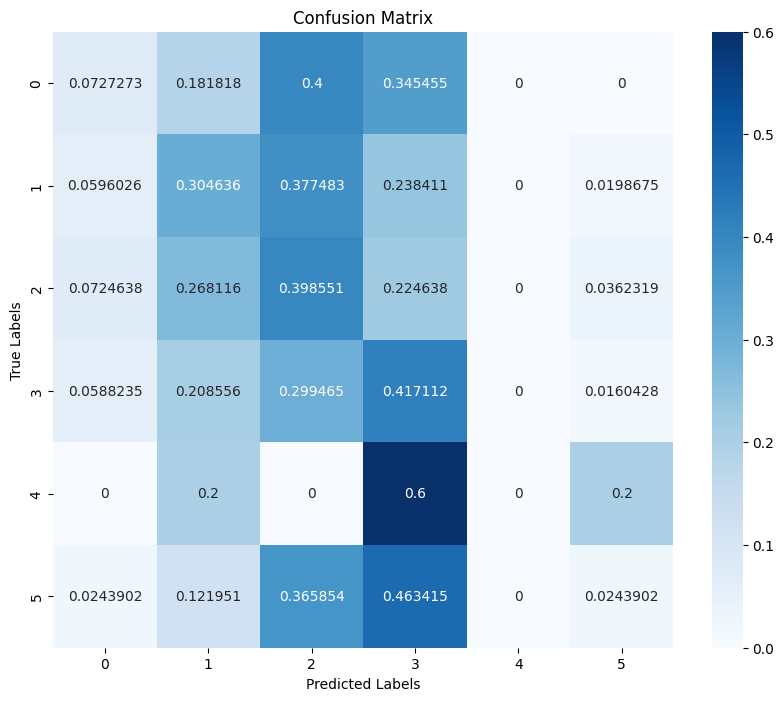

Epoch 9, Validation Loss: 3.2053, Accuracy: 0.3189, F1 Score: 0.3067
Val F1 Score Per Class  [0.08888889 0.3183391  0.32069971 0.41823056 0.         0.03703704]


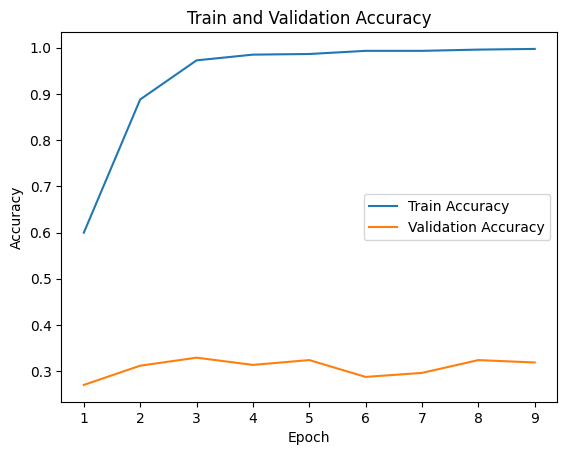

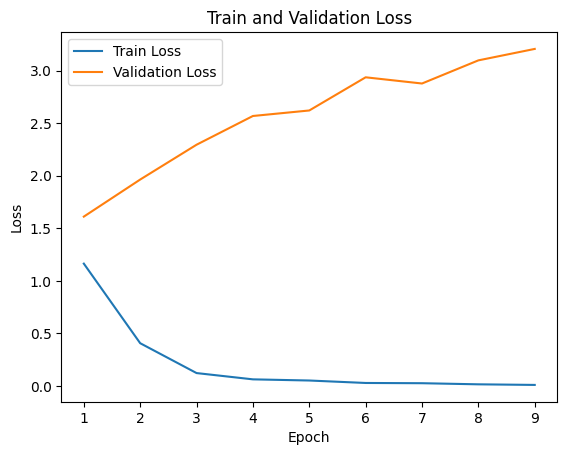

Epoch 10, Train Loss: 0.0177, Accuracy: 0.9954, F1 Score: 0.9954
Train F1 Score Per Class  [0.99723604 0.99071406 0.99413834 0.99078752 1.         0.99939394]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.17it/s, loss=4.25]

[tensor([-2.5260, -1.1393, -1.9395,  4.0644, -3.0366, -3.1810], device='cuda:0'), tensor([-2.2427,  3.3855, -0.7066, -1.2598, -3.8665, -4.0439], device='cuda:0'), tensor([-1.6406, -1.1646, -2.4287,  2.8146, -4.7111, -2.0161], device='cuda:0'), tensor([-1.6500, -1.3804, -2.6298,  4.2688, -3.4142, -1.7046], device='cuda:0'), tensor([-2.8440, -0.5661,  1.2642,  1.3129, -4.4384, -2.9309], device='cuda:0'), tensor([-3.1002, -1.1253, -0.8563,  4.3571, -3.8253, -3.2106], device='cuda:0'), tensor([-2.3292, -1.3922, -2.6605,  3.2280, -3.9372,  0.3741], device='cuda:0'), tensor([-2.5011, -2.3049,  1.2666,  3.6201, -3.0167, -1.9176], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.12it/s, loss=3.1]

[tensor([-1.6393, -1.6738, -2.7293,  4.1563, -4.1159, -2.3756], device='cuda:0'), tensor([-3.6826, -0.3800, -2.5994, -1.0197, -2.1375, -1.0697], device='cuda:0'), tensor([-1.0380, -1.9750,  2.7794,  1.0547, -4.1850, -3.1754], device='cuda:0'), tensor([-1.7187, -0.9842, -0.6810,  4.7137, -3.4718, -3.0017], device='cuda:0'), tensor([-1.0524,  6.1923, -1.5942, -1.6597, -2.6760, -1.8696], device='cuda:0'), tensor([ 0.8460,  0.3564, -0.5879, -0.0159, -3.9603, -4.1117], device='cuda:0'), tensor([-0.4914, -1.8790, -1.6205,  3.1651, -3.6070, -3.2864], device='cuda:0'), tensor([ 4.4563, -0.3770, -2.5665,  0.8241, -3.5937, -3.0480], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.14it/s, loss=3.58]

[tensor([-2.4660, -0.6468,  1.0889, -1.7089, -3.2667, -3.1286], device='cuda:0'), tensor([-1.0737,  1.7096, -0.0347, -1.4129, -2.6435, -2.8836], device='cuda:0'), tensor([-2.4208, -1.5807,  5.4214, -1.0753, -3.0465, -2.2695], device='cuda:0'), tensor([-1.2106, -2.1720, -0.8477,  2.6248, -4.1362, -3.3944], device='cuda:0'), tensor([-1.1490, -0.4812, -2.5263,  5.2195, -2.6176, -2.8360], device='cuda:0'), tensor([-1.5975,  1.7926, -2.1503,  1.8156, -4.0956, -3.6715], device='cuda:0'), tensor([-0.9154, -2.6791, -1.3089,  4.6171, -3.5436, -3.0206], device='cuda:0'), tensor([ 0.1370, -2.3328,  0.0787, -0.4473, -3.8263, -3.0970], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=4]

[tensor([-1.7258, -2.2591, -0.4043,  5.3657, -2.9209, -2.4750], device='cuda:0'), tensor([-2.7878, -1.3336,  4.5009, -1.8668, -3.0662, -2.3878], device='cuda:0'), tensor([-1.7477, -0.2622, -1.8178, -0.2710, -3.9848, -0.4908], device='cuda:0'), tensor([-2.0320, -0.4621,  1.9461, -0.5561, -2.7152, -2.6781], device='cuda:0'), tensor([ 5.6948, -2.1449, -0.6318,  0.5171, -2.4556, -3.0034], device='cuda:0'), tensor([-1.7998, -1.7858,  1.7214, -0.0835, -4.9639, -2.3498], device='cuda:0'), tensor([-1.3355,  5.8256, -1.1168, -1.4564, -3.0245, -2.7659], device='cuda:0'), tensor([-3.2032,  1.1664,  1.6144, -2.1469, -1.4110,  0.0826], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=4.13]

[tensor([-2.9160, -0.5023, -1.1612,  2.5325, -3.8375, -3.2502], device='cuda:0'), tensor([-2.4927, -2.4442,  3.7420, -0.2477, -3.8125, -3.0042], device='cuda:0'), tensor([-1.2527, -1.9125,  5.1490, -1.6512, -2.6746, -2.5414], device='cuda:0'), tensor([-1.9824, -0.7039, -1.7528,  4.3855, -2.9828, -2.9816], device='cuda:0'), tensor([-1.8744, -1.5995,  6.0333, -0.9601, -2.6536, -2.1826], device='cuda:0'), tensor([-2.3416,  0.5329,  0.0281, -1.0682, -4.4517, -2.5093], device='cuda:0'), tensor([-2.5495e+00,  4.2682e-01, -3.3684e-03, -1.2098e+00, -4.2028e+00,
        -2.3522e+00], device='cuda:0'), tensor([-1.3712, -0.7350, -2.5481,  4.5921, -3.1378, -1.5499], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=4.12]

[tensor([-1.8282, -1.8478,  6.3568, -1.2143, -2.4366, -2.6621], device='cuda:0'), tensor([-1.8190, -1.7115,  6.1624, -1.4123, -2.3411, -1.3576], device='cuda:0'), tensor([-1.7641,  0.2192,  3.4292, -1.9131, -4.0130, -3.5836], device='cuda:0'), tensor([-2.9299,  2.6394, -1.4762,  0.4368, -4.0036, -3.2283], device='cuda:0'), tensor([-2.1992, -1.9252,  5.5643, -1.3059, -2.4932, -2.4764], device='cuda:0'), tensor([-1.3606, -2.5471, -0.7674,  2.9292, -4.3655, -2.4978], device='cuda:0'), tensor([-0.7073, -3.3632,  2.8674,  1.8710, -3.4996, -3.3420], device='cuda:0'), tensor([-1.6344, -2.4268, -0.6246,  2.0399, -2.8779, -3.2350], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=2.25]

[tensor([-1.9156, -0.5987,  1.0076, -1.1074, -3.7243, -2.2876], device='cuda:0'), tensor([-0.6939, -2.0640,  5.1586, -1.0825, -2.2852, -1.8157], device='cuda:0'), tensor([-0.8051, -1.4946,  4.8490, -1.1113, -2.6404, -2.9514], device='cuda:0'), tensor([-3.2261, -2.3055,  0.0089,  2.3947, -4.2091, -2.7633], device='cuda:0'), tensor([-2.6627, -0.3899, -0.0212,  0.1892, -3.1532, -4.7384], device='cuda:0'), tensor([-2.5208, -0.4235, -1.9588,  0.3310, -3.5889,  0.0466], device='cuda:0'), tensor([-2.0817, -2.2450,  5.6196, -1.3522, -2.8548, -1.0359], device='cuda:0'), tensor([-2.3517,  3.0695, -1.9478,  0.2218, -4.9885, -2.9778], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.16it/s, loss=5.58]

[tensor([-0.2107, -2.9221,  3.8841, -1.1078, -2.8131, -2.8084], device='cuda:0'), tensor([-2.0071, -2.3149,  4.2597, -0.1165, -2.6793, -2.3426], device='cuda:0'), tensor([-1.2936, -0.4047, -2.7367,  5.3279, -3.8959, -2.8129], device='cuda:0'), tensor([-1.7200,  5.7702, -1.3722, -0.9341, -2.8709, -3.2126], device='cuda:0'), tensor([-1.9464, -1.6454,  5.5039, -1.6405, -2.9644, -2.9045], device='cuda:0'), tensor([-2.0247,  1.1493, -0.7668,  1.9730, -3.7961, -3.9162], device='cuda:0'), tensor([-2.3796, -2.3757, -1.0450,  0.3376, -4.6413,  1.1113], device='cuda:0'), tensor([-2.1347, -1.7032,  5.7005, -1.0696, -2.1483, -1.8951], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.17it/s, loss=4.32]

[tensor([-2.5926, -1.3790, -2.2969, -0.1105, -3.8674, -1.5926], device='cuda:0'), tensor([-1.9473,  1.7014,  2.3007, -1.3556, -3.1871, -3.3183], device='cuda:0'), tensor([-0.4527,  4.3876, -1.5296, -0.6386, -2.5515, -4.0136], device='cuda:0'), tensor([-0.7192, -2.6070,  2.8777,  0.5532, -2.6466, -2.9593], device='cuda:0'), tensor([-1.5904, -2.2612,  0.3686,  3.2937, -2.8139, -2.7661], device='cuda:0'), tensor([-2.8227,  2.9584, -0.3965,  0.3552, -3.5350, -3.8300], device='cuda:0'), tensor([-3.4634,  1.6143, -2.7537,  0.9257, -3.7782, -1.5674], device='cuda:0'), tensor([-1.6496, -2.6524,  0.0835,  1.2614, -4.0206, -2.9366], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:28,  2.17it/s, loss=2.2]

[tensor([-2.0950,  1.9055, -2.0804, -1.2538, -2.8043, -3.5651], device='cuda:0'), tensor([-2.3729, -1.2366,  1.2088,  1.0995, -3.4591, -3.3608], device='cuda:0'), tensor([-1.0237,  5.6014, -2.0477, -1.6057, -3.0384, -2.5606], device='cuda:0'), tensor([-1.6022, -2.4808, -0.4836,  4.6521, -2.9587, -3.0637], device='cuda:0'), tensor([-1.8590,  4.9976,  0.0677, -1.2080, -2.8463, -2.8841], device='cuda:0'), tensor([-0.8520, -0.3468,  2.2966, -0.3088, -4.4588, -4.2626], device='cuda:0'), tensor([-2.5434,  4.1216, -3.1620, -0.3801, -2.9347, -2.4985], device='cuda:0'), tensor([-1.8797,  4.2560, -1.6585,  0.4352, -3.5889, -3.5970], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.18it/s, loss=5.04]

[tensor([-2.5621, -1.9207, -0.2609,  2.4434, -3.4621, -3.4805], device='cuda:0'), tensor([-0.2631,  3.2824, -3.0608,  0.8335, -3.6943, -2.6950], device='cuda:0'), tensor([-1.9862, -2.4527, -0.0457,  4.8250, -3.7946, -1.6373], device='cuda:0'), tensor([-1.9685, -1.7970, -0.5042,  4.5601, -4.2146, -3.5036], device='cuda:0'), tensor([-2.5726,  5.7679, -1.5094, -1.0711, -3.0484, -1.5142], device='cuda:0'), tensor([-1.2568, -1.5882, -2.5930,  4.4243, -3.7996, -2.2770], device='cuda:0'), tensor([-3.4558, -0.6565,  1.8939, -1.2612, -3.3037, -2.7277], device='cuda:0'), tensor([-0.4136, -1.4195, -2.1772,  5.3981, -3.1032, -3.1678], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.17it/s, loss=2.62]

[tensor([-1.5335, -2.0878,  5.9218, -1.1799, -2.0924, -2.8848], device='cuda:0'), tensor([-2.9015, -0.6795, -0.6915,  3.2258, -3.7521, -3.2261], device='cuda:0'), tensor([-2.4794, -1.7970,  0.9425,  3.2128, -3.4330, -3.7252], device='cuda:0'), tensor([-1.6725,  0.3679, -2.3233, -0.5085, -2.9623, -3.8335], device='cuda:0'), tensor([ 1.8637, -0.6734, -2.5788, -0.7689, -3.1646, -3.7913], device='cuda:0'), tensor([-2.2000, -1.8881,  5.5257,  0.2670, -2.9176, -2.6745], device='cuda:0'), tensor([-1.6140, -1.8565, -2.7873,  3.4895, -3.4502, -1.5005], device='cuda:0'), tensor([-1.5453, -0.2375,  1.6558, -0.9918, -3.3363, -3.6197], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.17it/s, loss=1.69]

[tensor([-1.0633, -0.4773, -0.8606,  1.5210, -4.4650, -4.5086], device='cuda:0'), tensor([-3.1674,  3.1344,  0.7908,  0.0602, -3.4947, -3.0062], device='cuda:0'), tensor([-2.4343,  1.2225, -1.0155, -0.1289, -4.7607, -3.8335], device='cuda:0'), tensor([-2.3631, -0.4344,  5.1247, -1.8825, -3.2713, -3.0389], device='cuda:0'), tensor([-2.9038,  2.4025, -2.0664, -0.1557, -3.4715, -2.0614], device='cuda:0'), tensor([-2.4046, -2.2091,  1.4482, -0.7728, -3.5225, -2.4999], device='cuda:0'), tensor([-2.8732,  4.1422, -1.4724, -0.4330, -3.7032, -3.2535], device='cuda:0'), tensor([-1.5037,  3.4151, -1.7231,  0.7575, -3.8225, -4.2071], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.17it/s, loss=2.1]

[tensor([-1.5142, -2.8599, -0.5548, -1.5135, -3.8113,  0.8754], device='cuda:0'), tensor([-2.8454,  0.1225, -1.1770,  0.0521, -4.1766, -2.8403], device='cuda:0'), tensor([-2.6638, -2.8081,  3.4210,  0.2876, -2.7260, -1.1989], device='cuda:0'), tensor([-1.8243, -1.3388,  3.5921, -1.1769, -4.2447, -2.9190], device='cuda:0'), tensor([-2.6840, -0.5813, -2.0087,  5.1032, -3.0696, -1.7493], device='cuda:0'), tensor([-2.5561,  0.5103, -2.2899,  3.0178, -3.6779, -2.8226], device='cuda:0'), tensor([-1.7186,  2.8430, -2.4428, -0.2980, -3.6246, -2.4846], device='cuda:0'), tensor([-2.2197, -0.0145, -1.7389,  3.2068, -4.5097, -2.9486], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:26,  2.17it/s, loss=4.17]

[tensor([-2.4529,  0.7991,  1.6592, -0.3060, -4.0074, -3.7653], device='cuda:0'), tensor([-1.8801,  0.9456,  0.8895, -1.6009, -3.2063, -2.8437], device='cuda:0'), tensor([-1.8483, -1.0631,  6.0186, -1.4797, -2.5560, -1.7060], device='cuda:0'), tensor([-1.7387, -1.9212, -1.1656,  5.5752, -3.7413, -2.9719], device='cuda:0'), tensor([-1.9762, -1.4649, -1.0309,  4.7739, -3.4660, -3.9227], device='cuda:0'), tensor([-0.5076, -0.8521, -1.2641, -1.2742, -2.9885, -3.8418], device='cuda:0'), tensor([-3.3930, -1.2081,  1.9152,  1.3211, -4.3688, -2.5898], device='cuda:0'), tensor([-2.7816,  0.0535,  3.4083, -0.3544, -3.4887, -4.4531], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.16it/s, loss=2.87]

[tensor([-1.7917, -1.3655, -1.5009,  5.2066, -3.8606, -2.6513], device='cuda:0'), tensor([-2.8165,  3.6992, -0.1264, -1.9055, -3.5642, -3.2319], device='cuda:0'), tensor([-2.3257,  2.4801, -0.1715,  0.2403, -4.3168, -4.6621], device='cuda:0'), tensor([-2.9425,  0.1486,  3.7122, -0.9072, -3.4580, -1.9997], device='cuda:0'), tensor([-2.4318, -2.2798, -0.8643,  4.8221, -3.4542, -3.4285], device='cuda:0'), tensor([-2.3088, -1.2665,  6.0771, -1.3344, -2.3881, -2.2565], device='cuda:0'), tensor([-1.6875, -2.4364,  0.0305,  2.0976, -4.3480, -2.9144], device='cuda:0'), tensor([-2.4381, -1.5137, -1.1055, -0.8263, -3.0853, -2.8732], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:25,  2.17it/s, loss=3.21]

[tensor([-3.4347,  1.2572, -0.9864,  1.6382, -4.7922, -3.6561], device='cuda:0'), tensor([-1.1454,  3.3945,  0.1384, -1.4015, -3.3587, -2.7189], device='cuda:0'), tensor([-1.5216,  0.3809,  3.1253, -2.3551, -2.5685, -2.8222], device='cuda:0'), tensor([-3.1613,  1.7035, -0.5309,  1.7837, -4.6794, -3.3893], device='cuda:0'), tensor([-2.5138, -2.1312, -0.9848,  3.3984, -3.3552, -2.4426], device='cuda:0'), tensor([-1.6960, -2.0445, -1.4852,  0.5543, -3.7649, -2.8003], device='cuda:0'), tensor([ 0.4485, -2.2286, -0.8862,  0.6115, -3.3927, -1.7994], device='cuda:0'), tensor([-1.4396, -1.0488, -3.5665,  2.5642, -3.0891, -2.7931], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.17it/s, loss=2.1]

[tensor([-2.1119, -2.4648, -0.1704,  4.5645, -3.2965, -3.0026], device='cuda:0'), tensor([-0.0316, -2.3207,  0.0498,  2.6102, -3.2706, -4.0721], device='cuda:0'), tensor([-3.3594,  2.2746, -1.0276, -1.1114, -4.0156, -0.7235], device='cuda:0'), tensor([-2.2620,  1.1581, -0.1306,  2.8997, -4.1306, -3.8960], device='cuda:0'), tensor([-1.7791, -2.7239,  4.3207, -0.7535, -1.6099, -2.8940], device='cuda:0'), tensor([-0.1689, -2.2123, -2.2004,  1.7259, -3.8317, -1.3461], device='cuda:0'), tensor([ 1.0001, -1.2496,  0.2004, -0.7842, -3.9469, -2.9616], device='cuda:0'), tensor([-2.0932, -2.2131, -1.0642,  2.6414, -3.0054, -3.2292], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.18it/s, loss=1.53]

[tensor([-2.6065, -1.7246, -0.5514,  0.7294, -3.1896, -3.2055], device='cuda:0'), tensor([ 3.4880, -2.2104, -0.9132, -0.2539, -3.5090, -2.6350], device='cuda:0'), tensor([-1.8150, -1.4695,  4.7378,  0.0725, -2.7327, -2.9866], device='cuda:0'), tensor([-1.9399, -2.3120, -0.3291,  5.2479, -2.8976, -2.4854], device='cuda:0'), tensor([-0.8589,  3.3961, -0.9095, -0.8520, -4.1313, -3.9668], device='cuda:0'), tensor([-1.0846, -1.2190, -1.5134,  2.3479, -3.9357, -3.7273], device='cuda:0'), tensor([-1.5038,  0.1775, -2.3935,  1.7352, -3.5968, -1.9356], device='cuda:0'), tensor([-1.4623, -0.1161,  0.3261, -1.4799, -4.4986, -3.0620], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.18it/s, loss=4.35]

[tensor([-2.3891, -2.3896,  0.4754,  3.6213, -3.4903, -3.3219], device='cuda:0'), tensor([-2.6060,  3.6798, -3.4069, -0.8546, -2.1423, -1.5055], device='cuda:0'), tensor([-2.1038, -2.0199,  2.5941,  1.2996, -3.5508, -2.4167], device='cuda:0'), tensor([-1.6179, -2.4227,  4.7507, -0.5143, -3.6431, -2.9765], device='cuda:0'), tensor([ 0.9535,  1.3262,  0.1774, -1.3734, -4.4162, -3.9691], device='cuda:0'), tensor([-1.9474,  4.7169, -1.5729, -1.1084, -3.1171, -1.8054], device='cuda:0'), tensor([-2.0964, -1.8929,  1.7779, -0.4659, -3.8419, -3.2758], device='cuda:0'), tensor([-3.1000, -1.2655,  3.6763,  0.5162, -3.4137, -3.4098], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:23,  2.18it/s, loss=4.34]

[tensor([-0.3531, -2.6273,  5.6308, -1.2990, -2.4965, -1.8217], device='cuda:0'), tensor([-1.9065,  3.3353, -1.6059,  0.2461, -3.6877, -3.1663], device='cuda:0'), tensor([-2.8065,  2.0518,  3.1777, -1.9229, -3.6024, -2.9357], device='cuda:0'), tensor([-2.6430, -2.7105,  2.2642,  2.8837, -3.0970, -3.2172], device='cuda:0'), tensor([-2.5404, -1.6602,  4.5959, -0.3025, -4.0041, -3.4218], device='cuda:0'), tensor([-1.5176, -1.7852,  0.2740, -0.4958, -4.0009, -2.2457], device='cuda:0'), tensor([-1.9261, -2.1596, -1.2967,  5.8051, -2.6125, -2.3893], device='cuda:0'), tensor([-1.5978, -1.5117, -1.2386,  4.6068, -2.5941, -1.0919], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.17it/s, loss=2.28]

[tensor([-2.8363,  0.3153,  0.0741,  1.6317, -4.1060, -4.1871], device='cuda:0'), tensor([-2.1331, -0.5512, -1.3604,  2.3139, -1.8164, -2.6686], device='cuda:0'), tensor([-2.9960, -1.4687, -0.3920,  5.0337, -3.7281, -3.0060], device='cuda:0'), tensor([-2.0881, -0.8663, -2.3730,  1.6259, -2.5152, -1.4743], device='cuda:0'), tensor([-1.1730, -1.3826, -0.5263,  3.4174, -3.7671, -4.3308], device='cuda:0'), tensor([-0.4685, -3.1307,  2.3578,  2.3163, -3.4211, -3.5986], device='cuda:0'), tensor([-2.0027, -0.2639, -1.5805,  1.9288, -4.0291, -2.8859], device='cuda:0'), tensor([-2.5985, -2.2384,  0.8201,  3.7912, -3.0909, -2.7232], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:22,  2.18it/s, loss=2.87]

[tensor([-1.2395, -0.1190, -1.2096,  1.7477, -2.8307, -3.5222], device='cuda:0'), tensor([-1.2132, -1.5657, -0.7780,  3.4462, -3.5154, -2.8166], device='cuda:0'), tensor([-1.5364, -1.1088, -1.6769,  5.2190, -2.0645, -2.7518], device='cuda:0'), tensor([-2.8889,  2.8303, -2.1833,  0.2083, -4.4181, -2.6784], device='cuda:0'), tensor([-2.6039,  1.2136, -1.5715,  2.2404, -4.0978, -3.1731], device='cuda:0'), tensor([-1.1486, -1.7794, -1.8163,  5.9470, -2.3258, -2.4858], device='cuda:0'), tensor([-1.6576, -1.9327,  5.7264, -0.8280, -2.5640, -2.4273], device='cuda:0'), tensor([-2.5790, -2.0688,  5.9162, -1.3029, -2.5623, -1.9459], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.17it/s, loss=2.3]

[tensor([ 1.1103, -1.1218, -2.5596,  0.7019, -3.2696, -2.4569], device='cuda:0'), tensor([ 2.7070, -2.2991,  0.7943, -0.4473, -3.7231, -2.7061], device='cuda:0'), tensor([-0.9395, -2.0069, -1.0169,  5.3864, -3.0331, -3.2312], device='cuda:0'), tensor([-0.3598, -1.9113,  5.2056, -1.6556, -2.1670, -3.6346], device='cuda:0'), tensor([-2.9469,  3.1820,  2.2228, -1.8557, -2.8411, -3.7719], device='cuda:0'), tensor([-2.3565, -1.5715,  0.3206,  3.1073, -2.8660, -3.3306], device='cuda:0'), tensor([-2.0713, -1.5579, -1.6211,  5.7528, -2.4571, -1.6162], device='cuda:0'), tensor([-1.1484,  4.2390, -2.4076, -0.5159, -4.1673, -1.0835], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.17it/s, loss=3.62]

[tensor([-2.4673,  0.1799,  3.1814,  1.1130, -4.4682, -2.4497], device='cuda:0'), tensor([-1.5908,  1.3993,  0.4322,  0.1230, -4.2771, -3.1805], device='cuda:0'), tensor([-1.7969,  0.6207,  0.7472,  1.6357, -4.7864, -3.8158], device='cuda:0'), tensor([-2.3315, -1.9614,  4.4870, -0.3385, -2.7151, -3.5457], device='cuda:0'), tensor([-0.4944, -2.2457,  2.6008, -0.2802, -3.3939, -4.0900], device='cuda:0'), tensor([-1.4153,  5.5237, -1.3360, -2.1300, -2.7156, -1.9918], device='cuda:0'), tensor([-2.3340,  4.7392, -2.7204, -1.5271, -4.5524, -1.9328], device='cuda:0'), tensor([-2.1634,  5.3253, -2.4194, -0.8648, -3.4639, -0.6560], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:11<00:21,  2.17it/s, loss=3.16]

[tensor([-0.7763,  5.1547, -2.1980, -1.3591, -3.4011, -1.5538], device='cuda:0'), tensor([-1.7626, -1.3635,  3.9479, -2.1742, -3.0534, -2.3163], device='cuda:0'), tensor([-2.6572,  1.8630,  0.4232,  0.4221, -3.8511, -4.0282], device='cuda:0'), tensor([ 0.2886, -2.2991,  1.6678, -1.2431, -3.6073, -4.5982], device='cuda:0'), tensor([-0.7016,  5.5740, -1.8692, -0.7651, -3.1693, -2.7960], device='cuda:0'), tensor([-2.2311, -2.6002,  0.1764,  0.4757, -2.9562, -2.5434], device='cuda:0'), tensor([-1.2976, -2.5957,  1.4767,  0.9268, -3.8743, -3.3454], device='cuda:0'), tensor([ 0.0308, -3.1063,  1.3800, -0.5902, -3.3552, -2.8666], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.18it/s, loss=3.33]

[tensor([-1.3116,  0.1968, -3.4166,  1.5905, -3.4958, -0.9153], device='cuda:0'), tensor([-1.5214,  3.4036,  1.7741, -2.0788, -2.7237, -3.6173], device='cuda:0'), tensor([-1.5222, -0.5429, -0.3876,  0.1490, -4.0161, -2.2372], device='cuda:0'), tensor([-2.0727, -1.7967, -1.3576,  3.8917, -2.6632, -2.6411], device='cuda:0'), tensor([-0.8769, -1.6811, -2.3815,  1.7301, -3.1954, -1.9985], device='cuda:0'), tensor([-3.0492, -1.1199, -0.2569,  2.4007, -3.9642, -4.0259], device='cuda:0'), tensor([-2.9037, -2.0471,  3.2888, -0.2273, -3.4136, -3.0400], device='cuda:0'), tensor([-2.8216,  3.3310, -1.6604,  0.6947, -3.9695, -4.2167], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:12<00:20,  2.18it/s, loss=3.11]

[tensor([-0.2707, -1.5630,  2.0926, -0.4568, -3.1625, -3.6018], device='cuda:0'), tensor([-1.3034, -2.5243,  5.4293, -0.0873, -2.6440, -2.6469], device='cuda:0'), tensor([ 1.0836, -1.7704, -1.1224,  3.2017, -3.7785, -3.7376], device='cuda:0'), tensor([-1.8393, -1.8617,  1.0521,  0.7657, -3.6228, -2.5898], device='cuda:0'), tensor([-1.9471, -0.8413,  5.8079, -1.1800, -2.5035, -2.7315], device='cuda:0'), tensor([-2.2692,  1.3488,  0.9600, -1.4853, -2.9578, -3.4781], device='cuda:0'), tensor([-1.5642, -1.9666,  3.4299,  0.5071, -3.3055, -1.6438], device='cuda:0'), tensor([-0.2626, -1.8239,  5.2713, -0.9478, -2.2698, -2.5941], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.18it/s, loss=4.47]

[tensor([ 5.2380, -1.5573, -0.9101, -1.1543, -2.5691, -1.6007], device='cuda:0'), tensor([-3.3136, -1.3280,  2.4082, -0.7708, -3.1919, -3.3259], device='cuda:0'), tensor([-0.7390,  0.6206, -2.3034,  3.1618, -3.0513, -4.0666], device='cuda:0'), tensor([-1.3607, -1.2321,  2.2635, -0.1020, -2.8599, -2.1393], device='cuda:0'), tensor([-1.9760,  5.3630, -1.6564, -0.0956, -3.3989, -3.1432], device='cuda:0'), tensor([-2.1845, -1.5393,  5.4225, -0.4827, -3.3355, -2.7593], device='cuda:0'), tensor([-1.4525, -1.7741,  5.1786, -0.8262, -3.1044, -2.2909], device='cuda:0'), tensor([-2.9473,  2.4474,  0.8641, -1.5331, -2.8359, -3.0866], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.18it/s, loss=4.41]

[tensor([-1.7609,  4.0692,  0.2306, -2.0051, -3.6732, -3.2498], device='cuda:0'), tensor([-1.8195, -2.6351,  3.0019,  3.6336, -3.3875, -3.2069], device='cuda:0'), tensor([-3.1509,  2.9329, -1.8779, -0.5240, -4.3519, -1.3788], device='cuda:0'), tensor([-2.7331,  0.1348, -0.4538, -0.6564, -2.7965, -0.8749], device='cuda:0'), tensor([-1.0945, -1.4083, -2.5515,  5.1352, -2.7225, -2.5884], device='cuda:0'), tensor([-0.5757, -1.6543,  5.2236, -1.2678, -2.8967, -3.3630], device='cuda:0'), tensor([-0.2407, -2.8179,  1.0884,  1.3815, -2.7352, -1.7332], device='cuda:0'), tensor([ 0.3457,  0.1673, -2.8784,  2.2089, -3.8827, -1.4203], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.18it/s, loss=2.27]

[tensor([-2.3491, -2.4339,  0.8738,  4.0220, -3.2432, -2.2496], device='cuda:0'), tensor([ 0.4138, -1.8792, -1.4042, -0.3206, -4.1516, -3.2071], device='cuda:0'), tensor([-2.0786, -2.2812,  4.5965,  0.3236, -3.3505, -2.8150], device='cuda:0'), tensor([-0.3238, -3.1332,  2.4501,  1.3523, -3.9418, -3.1181], device='cuda:0'), tensor([-1.2987, -1.3294,  1.3522, -0.8301, -3.8761, -4.6122], device='cuda:0'), tensor([-1.4388, -1.0278, -2.9177, -0.1591, -1.7558,  2.9405], device='cuda:0'), tensor([ 0.1390,  4.8473, -1.9225, -1.7522, -2.9194, -3.0282], device='cuda:0'), tensor([-2.1584,  0.0662, -0.9119,  3.4012, -4.2870, -4.7489], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.18it/s, loss=3.38]

[tensor([-2.5999,  1.6169,  1.0326, -2.0040, -3.2349, -0.9274], device='cuda:0'), tensor([-0.8358, -0.5263,  3.0093, -0.5974, -3.6104, -4.3753], device='cuda:0'), tensor([-2.0817,  0.5754, -2.2565,  0.8547, -4.4853, -4.1493], device='cuda:0'), tensor([-2.0166, -1.6362,  3.4742, -0.2689, -2.5875, -2.9640], device='cuda:0'), tensor([-2.0217, -2.1988,  5.2891, -1.4052, -2.4724, -2.4880], device='cuda:0'), tensor([-1.7222,  6.1215, -1.7917, -1.0797, -2.8051, -1.7481], device='cuda:0'), tensor([-1.6232, -1.4215, -1.5146, -0.9567, -2.4844,  6.8523], device='cuda:0'), tensor([-2.4813, -2.4520, -0.4525,  0.9841, -2.1943, -3.8079], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.18it/s, loss=3.98]

[tensor([-1.9297,  0.4875,  1.9313,  1.2630, -4.3969, -3.9093], device='cuda:0'), tensor([-1.2823,  1.7586, -3.3519,  0.1398, -2.3231, -3.8033], device='cuda:0'), tensor([-2.4333,  0.4209,  0.4625, -1.4494, -3.7138, -3.6846], device='cuda:0'), tensor([-2.2827,  0.2664, -3.1556, -1.0347, -3.0021,  3.0005], device='cuda:0'), tensor([-2.0118, -0.1271, -1.9126,  2.9892, -3.3481, -3.8739], device='cuda:0'), tensor([-2.8315, -0.2799,  4.5885,  0.1302, -2.9018, -3.6127], device='cuda:0'), tensor([-1.8408, -1.6588, -0.4099,  2.7070, -3.5923, -3.6007], device='cuda:0'), tensor([ 1.0641, -2.3096, -1.4857,  4.0276, -3.5712, -3.0772], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.17it/s, loss=3.81]

[tensor([-1.9165, -0.6527,  4.5265, -0.6766, -3.9992, -3.3776], device='cuda:0'), tensor([-2.2827, -2.3939,  2.7081,  0.1225, -2.8990, -2.9198], device='cuda:0'), tensor([-1.7404, -1.2037,  5.9561, -1.6416, -2.4516, -2.7075], device='cuda:0'), tensor([-2.0743, -0.7214,  5.4588, -1.3650, -2.8993, -2.0305], device='cuda:0'), tensor([-1.7785, -0.5713, -1.8315,  4.8088, -3.7424, -3.1428], device='cuda:0'), tensor([-1.7563, -1.5436,  6.2696, -1.4299, -2.3537, -2.2208], device='cuda:0'), tensor([ 5.1977, -1.9213, -1.7258, -0.0789, -2.9273, -2.4970], device='cuda:0'), tensor([-1.7053, -1.3868,  1.8656,  1.2975, -4.3576, -4.3555], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.17it/s, loss=2.94]

[tensor([-1.4449, -1.4152, -1.6238,  5.2724, -3.6252, -4.1204], device='cuda:0'), tensor([-2.0963, -0.5019,  4.7272, -2.7283, -2.6231, -0.9731], device='cuda:0'), tensor([-0.8656, -1.4479, -1.9263,  2.2093, -4.3795, -3.0118], device='cuda:0'), tensor([-0.2363, -2.6323,  2.5348, -0.4684, -3.8759, -2.4153], device='cuda:0'), tensor([-1.4197, -1.5026,  0.1367, -0.2451, -2.5515, -2.2402], device='cuda:0'), tensor([-2.0093, -1.6651, -0.7685,  3.3036, -3.7468, -1.1650], device='cuda:0'), tensor([ 2.9361, -1.5657, -1.7392,  0.7121, -4.7828, -3.0030], device='cuda:0'), tensor([-2.1777,  5.6507, -2.5666, -0.9691, -2.4560, -1.2478], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.17it/s, loss=1.83]

[tensor([-2.0960,  0.3211, -0.9586, -0.6621, -3.6337, -3.1740], device='cuda:0'), tensor([-0.1211, -1.9643,  0.0639,  0.4549, -3.7228, -3.2907], device='cuda:0'), tensor([-2.5272, -0.6354, -2.1323,  5.2049, -2.8645, -3.1702], device='cuda:0'), tensor([-1.5018, -0.5631,  2.1796, -0.0549, -3.4163, -3.6237], device='cuda:0'), tensor([-1.8155, -1.7220,  4.3103,  0.9543, -3.3925, -4.1290], device='cuda:0'), tensor([-2.2369,  3.0407, -1.1407, -1.0573, -2.0575, -3.8703], device='cuda:0'), tensor([-2.6132,  1.5829,  3.0942, -1.7708, -4.1830, -3.2169], device='cuda:0'), tensor([-2.3777, -0.4677, -1.3233,  0.7691, -3.4794, -4.1536], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.17it/s, loss=4.08]

[tensor([-1.2754, -1.4970, -2.0069,  5.4517, -3.0863, -2.3864], device='cuda:0'), tensor([-2.4444,  3.3652, -1.6725, -0.0112, -2.6325, -2.5313], device='cuda:0'), tensor([-1.7154, -0.8234, -1.9181,  2.6111, -4.7096, -2.7685], device='cuda:0'), tensor([-2.2254, -0.5751,  5.5201, -1.3816, -3.3963, -3.6259], device='cuda:0'), tensor([-2.4696, -0.8512, -1.7409, -1.2760, -3.6742, -1.9604], device='cuda:0'), tensor([-2.3398, -0.4837,  0.2530, -0.7260, -2.8290, -3.3854], device='cuda:0'), tensor([-1.7840,  4.6068,  0.7374, -1.5531, -3.4388, -4.0321], device='cuda:0'), tensor([-2.4944, -0.3899, -2.4380,  5.0092, -3.8449, -1.7424], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.17it/s, loss=3.8]

[tensor([-1.8444, -1.2213, -3.2859,  3.9866, -3.1373, -0.4192], device='cuda:0'), tensor([-2.2225, -1.6355,  4.7962, -0.1232, -1.8939, -2.2567], device='cuda:0'), tensor([-2.1694, -1.4360,  4.2882,  1.7720, -2.9533, -3.7699], device='cuda:0'), tensor([-0.9661, -1.5710,  5.7983, -1.9642, -2.2700, -1.9968], device='cuda:0'), tensor([-1.7451, -1.7637,  5.6696, -1.3129, -2.5270, -1.1659], device='cuda:0'), tensor([ 0.2584, -2.5148, -0.3435,  2.8107, -3.9331, -3.8652], device='cuda:0'), tensor([-2.9147,  1.7646, -2.2759,  1.5205, -3.5829, -2.3915], device='cuda:0'), tensor([-0.7128,  2.9960, -0.5664, -1.4301, -3.1763, -3.5186], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:17<00:15,  2.17it/s, loss=3.16]

[tensor([-0.4481,  1.7533,  1.9938, -2.2277, -3.2091, -3.6232], device='cuda:0'), tensor([-1.9869, -1.4710, -2.1813,  3.8259, -2.2964, -0.9850], device='cuda:0'), tensor([ 1.8915, -1.1596, -2.1427,  0.0037, -3.1052, -3.2342], device='cuda:0'), tensor([-1.9515,  0.5699, -1.0752, -0.5017, -4.0571, -4.2817], device='cuda:0'), tensor([-1.3816, -0.8380, -0.4565,  0.0451, -4.4561, -4.7048], device='cuda:0'), tensor([-1.5381, -2.2058,  6.0538, -1.1251, -2.3560, -2.0850], device='cuda:0'), tensor([-1.2473, -1.5038, -1.9622,  4.8072, -1.8951, -3.4521], device='cuda:0'), tensor([-2.5249, -2.1321,  0.7898,  2.3419, -3.2586, -2.9817], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=3.89]

[tensor([-2.8136,  1.7410, -1.8044,  1.9132, -3.6129, -3.6906], device='cuda:0'), tensor([-2.3709, -1.4086, -2.1250,  5.4192, -3.0636, -2.2698], device='cuda:0'), tensor([-3.4794,  0.6004, -2.3119,  0.6046, -3.5751, -3.3312], device='cuda:0'), tensor([-1.0894, -2.0635,  6.2128, -1.8698, -1.7615, -1.7246], device='cuda:0'), tensor([-1.0850, -0.1136, -2.4332,  4.9376, -1.7551, -3.6008], device='cuda:0'), tensor([-2.1051, -1.8889,  5.3364, -1.8919, -2.9299, -1.7848], device='cuda:0'), tensor([-2.7288, -2.0256,  3.0455,  0.3608, -4.3191, -3.4274], device='cuda:0'), tensor([-0.9875, -2.5394,  2.3687,  0.3338, -1.4912, -2.9717], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:18<00:14,  2.15it/s, loss=3.25]

[tensor([-1.5264, -1.6965, -1.6771,  6.0557, -2.4891, -2.6440], device='cuda:0'), tensor([-1.5535, -1.9469, -2.1205,  5.6411, -3.8396, -2.0220], device='cuda:0'), tensor([-2.2565, -1.0317, -0.1460,  1.7113, -3.7218, -3.1307], device='cuda:0'), tensor([-0.4633,  0.0808, -3.1937,  3.2860, -3.7663, -1.9167], device='cuda:0'), tensor([-2.3685,  0.6457,  0.5124,  0.6928, -3.2213, -4.1246], device='cuda:0'), tensor([-1.8409, -1.5640,  6.1211, -0.9064, -2.3081, -2.6109], device='cuda:0'), tensor([ 0.1495, -1.9333,  1.8535, -0.4602, -3.7496, -3.2727], device='cuda:0'), tensor([-0.2775, -2.2363,  5.4906, -1.2726, -2.1053, -2.0308], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=3.12]

[tensor([-3.2983, -0.3283, -1.6659,  0.4418, -3.8635, -1.6638], device='cuda:0'), tensor([-1.6778, -0.6625, -1.4574,  2.3976, -3.7395, -3.7748], device='cuda:0'), tensor([ 4.2412, -2.5433, -1.1200,  0.4389, -3.8300, -1.1110], device='cuda:0'), tensor([-2.4563,  4.0537, -2.5754,  0.0437, -2.4912, -2.8807], device='cuda:0'), tensor([-1.0664, -1.4307, -3.0338,  3.9611, -3.5271, -2.7945], device='cuda:0'), tensor([-2.0285, -0.5998, -2.8169,  4.8390, -3.8904, -2.5517], device='cuda:0'), tensor([-0.4998,  1.4889, -1.7119,  0.4546, -4.0902, -4.3041], device='cuda:0'), tensor([-1.4542, -1.0821, -1.0333,  0.1015, -4.4025, -0.4423], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.15it/s, loss=1.89]

[tensor([-2.4867, -1.2799, -1.9988,  0.9893, -3.5181, -2.6095], device='cuda:0'), tensor([-2.8507, -2.6960,  0.2945, -1.2608, -2.7537, -2.2154], device='cuda:0'), tensor([-2.4839, -2.0153,  0.1992,  3.1138, -4.0705, -2.4898], device='cuda:0'), tensor([-1.1912, -2.0503, -0.8395,  4.6965, -4.2051, -3.4889], device='cuda:0'), tensor([-2.3393, -0.0634,  3.8154,  0.3983, -3.4652, -3.5012], device='cuda:0'), tensor([-2.0300, -1.1372, -2.3852,  3.5004, -4.8284, -2.8357], device='cuda:0'), tensor([-0.7688, -3.2934,  1.9363,  3.8685, -3.5166, -3.6552], device='cuda:0'), tensor([-2.0786, -2.0653,  1.1354,  0.5730, -3.4707, -3.9112], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.14it/s, loss=3.92]

[tensor([-1.0617, -1.7024, -0.1361,  2.7492, -3.6043, -4.2008], device='cuda:0'), tensor([-0.2625, -2.2132,  3.1063, -0.8850, -2.8715, -3.6159], device='cuda:0'), tensor([-2.5137, -2.2484, -1.5585,  5.1284, -3.4613, -2.3243], device='cuda:0'), tensor([-2.6669, -0.5753, -1.8840,  3.3398, -4.0097, -2.1818], device='cuda:0'), tensor([-1.3599, -2.5071, -1.5953,  1.8919, -0.7229, -0.3314], device='cuda:0'), tensor([-3.8699,  0.7688,  2.2737,  1.1341, -4.3051, -3.4227], device='cuda:0'), tensor([-0.8276, -1.9219,  2.6673,  1.0837, -3.2398, -2.8927], device='cuda:0'), tensor([-1.4348,  3.3633, -2.3903, -0.2273, -2.8691, -1.2303], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.14it/s, loss=3.18]

[tensor([ 2.6651, -0.5041, -1.5968, -1.2523, -4.6492, -2.6155], device='cuda:0'), tensor([-1.7652, -0.0829, -3.3557,  2.0851, -2.1999, -2.5890], device='cuda:0'), tensor([-1.9792,  0.3763, -2.5118,  3.7181, -3.0531, -2.1045], device='cuda:0'), tensor([-1.8428, -0.1624,  0.4871, -0.7000, -3.1952, -3.4029], device='cuda:0'), tensor([-2.0323, -2.3484,  5.7243, -0.5689, -2.8627, -2.0689], device='cuda:0'), tensor([-1.4796, -1.6211, -2.0961, -0.7517, -2.6178,  6.7082], device='cuda:0'), tensor([-2.3860,  3.8022, -0.2497, -1.1743, -3.9223, -2.7783], device='cuda:0'), tensor([-2.5245, -1.0250, -2.6760,  2.7400, -3.9408, -1.7969], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=2.96]

[tensor([-2.1085, -0.7865,  5.1442, -1.7507, -2.8897, -2.9651], device='cuda:0'), tensor([-0.7330, -0.8355,  0.3496,  0.7051, -2.5532, -2.7884], device='cuda:0'), tensor([-2.5259, -1.1353, -1.8904,  3.0164, -3.7793, -3.8862], device='cuda:0'), tensor([-1.7737, -2.1209,  5.1120, -1.8471, -2.8291, -1.4440], device='cuda:0'), tensor([-2.0633, -1.2580, -1.6003,  5.2345, -2.9494, -2.1475], device='cuda:0'), tensor([-2.0640,  4.2021, -3.1017, -0.3520, -2.9614, -2.9506], device='cuda:0'), tensor([-1.9990, -0.7209,  3.3452, -0.6445, -3.5604, -3.1495], device='cuda:0'), tensor([-1.3705, -1.4248,  5.1873, -0.6010, -2.3813, -2.7543], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.05]

[tensor([ 4.4053, -1.5894, -3.1859,  0.7320, -2.7122, -1.7050], device='cuda:0'), tensor([-2.5157,  0.7144,  0.6191,  1.8793, -4.8490, -3.3819], device='cuda:0'), tensor([-2.6663, -0.3688,  2.6627, -0.5334, -3.4498, -3.3409], device='cuda:0'), tensor([-2.7061, -0.7873, -0.3412,  0.4790, -3.9575, -3.5590], device='cuda:0'), tensor([-1.9109,  0.2959,  5.2885, -1.5282, -3.3165, -3.4729], device='cuda:0'), tensor([-2.0370, -0.0866, -3.0993, -0.5009, -3.8834, -2.9126], device='cuda:0'), tensor([-0.3659, -1.7071, -0.0982,  0.2492, -2.0342, -3.8267], device='cuda:0'), tensor([-1.4369, -1.0633, -0.7854,  2.8778, -3.9280, -4.0246], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.17it/s, loss=3.45]

[tensor([-1.3897, -1.5435,  6.3814, -1.8194, -2.4544, -1.5623], device='cuda:0'), tensor([-2.3815, -0.2814, -1.5504,  1.1377, -3.7687, -3.1804], device='cuda:0'), tensor([-1.7456,  5.5813, -0.6940, -1.7268, -2.8146, -2.7111], device='cuda:0'), tensor([-1.6768,  4.9454, -1.2477, -0.4370, -4.1016, -3.6175], device='cuda:0'), tensor([-1.4769, -1.7125, -1.8848,  5.9858, -2.9142, -2.2286], device='cuda:0'), tensor([ 4.5643, -1.7064, -2.1563, -0.7277, -2.9400, -0.8555], device='cuda:0'), tensor([-2.2930, -0.3736,  0.3310,  0.6208, -3.9830, -3.9621], device='cuda:0'), tensor([-2.5031, -0.7585, -1.4027,  5.0808, -3.4714, -3.1216], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.17it/s, loss=3.4]

[tensor([-2.5332, -2.0327,  3.5311,  0.1453, -2.9854, -3.2469], device='cuda:0'), tensor([-1.4792,  1.7434, -0.8934, -0.5247, -3.5562, -4.2795], device='cuda:0'), tensor([-2.9256, -0.3971,  5.4168, -1.4851, -2.6095, -1.9647], device='cuda:0'), tensor([-1.5155, -0.3499,  4.8155, -1.5937, -3.0973, -2.3854], device='cuda:0'), tensor([-2.6173,  3.0767,  1.8643, -2.2889, -3.0446, -2.6247], device='cuda:0'), tensor([-0.3825, -2.8144,  1.4606, -0.5888, -3.4796, -4.0357], device='cuda:0'), tensor([-2.2644,  2.4501, -0.8887, -2.3480, -4.6920, -0.3255], device='cuda:0'), tensor([-1.9991, -2.2658, -0.9020,  5.8170, -3.1399, -2.0867], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.18it/s, loss=4.76]

[tensor([ 0.6385, -1.5966,  1.6327, -1.1736, -3.6200, -3.1929], device='cuda:0'), tensor([-1.8126, -1.2771,  5.1001, -1.2704, -3.7626, -2.7485], device='cuda:0'), tensor([-3.0999,  0.5522,  1.1349,  1.2996, -3.4380, -2.8745], device='cuda:0'), tensor([-1.4557,  4.2700,  0.0411, -1.1909, -4.8767, -2.8265], device='cuda:0'), tensor([-1.6185, -1.5573,  6.1607, -1.8770, -2.4521, -1.9403], device='cuda:0'), tensor([-1.5073, -1.6488, -1.9400,  5.8422, -2.5793, -1.9956], device='cuda:0'), tensor([-2.6485, -0.9709, -0.3555,  4.6468, -3.6452, -1.7842], device='cuda:0'), tensor([-2.3644, -0.8963, -1.3523,  0.2152, -4.1327, -3.7800], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.17it/s, loss=2.82]

[tensor([-1.7357, -2.0359,  5.0915, -0.1555, -3.3257, -2.8023], device='cuda:0'), tensor([-1.5251, -2.7580, -1.5372,  5.3542, -3.6242, -1.4194], device='cuda:0'), tensor([-2.7857,  1.9025,  1.4150, -0.7153, -3.5625, -1.5993], device='cuda:0'), tensor([-2.0954, -0.8969, -0.7783,  5.3237, -3.5510, -3.5534], device='cuda:0'), tensor([-2.0076,  0.9658,  3.5830, -1.7226, -3.1967, -3.0113], device='cuda:0'), tensor([ 3.2768, -0.8110, -3.0840,  0.8900, -3.1592, -1.9492], device='cuda:0'), tensor([-0.3623, -1.7037, -1.4870,  5.0929, -3.4950, -2.8070], device='cuda:0'), tensor([-0.8467, -0.8808, -0.8240, -3.1007, -3.8556,  1.3394], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:23<00:09,  2.17it/s, loss=2.01]

[tensor([-3.3570, -0.5023,  3.6201, -1.2083, -3.8017, -1.9287], device='cuda:0'), tensor([-0.8622, -2.1360,  2.5474,  2.9784, -3.3412, -4.2880], device='cuda:0'), tensor([ 0.0462, -0.2180, -2.0969,  1.1020, -1.8365, -4.6242], device='cuda:0'), tensor([-2.5253,  0.2620, -2.5804,  0.7260, -3.4471, -1.7496], device='cuda:0'), tensor([-2.7712, -1.6779,  3.2983, -0.7656, -3.7665, -0.3582], device='cuda:0'), tensor([-2.2260,  4.6948, -2.3344, -1.5838, -2.4084, -2.4439], device='cuda:0'), tensor([ 4.4929, -2.3164,  1.5771, -1.2028, -2.2504, -2.0670], device='cuda:0'), tensor([-1.8404,  5.6690, -1.2001, -1.3445, -2.9046, -2.3331], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.16it/s, loss=2.37]

[tensor([-1.8795,  0.2787, -2.3523,  4.0435, -3.4007, -3.0284], device='cuda:0'), tensor([-0.7776, -2.5233,  0.9759,  2.6551, -3.3484, -3.6692], device='cuda:0'), tensor([-3.2397, -1.9982,  0.7174,  1.2563, -4.9311, -1.6786], device='cuda:0'), tensor([-0.8393,  0.6079, -0.7781, -0.2699, -3.6735, -3.5241], device='cuda:0'), tensor([ 5.3006e+00, -1.3850e+00, -4.5176e-03, -1.5206e+00, -2.6598e+00,
        -2.1461e+00], device='cuda:0'), tensor([-1.3621, -1.6526, -0.2979, -0.7761, -4.6487, -4.2406], device='cuda:0'), tensor([-1.2585, -1.9088,  0.2666,  5.2530, -4.0405, -3.2368], device='cuda:0'), tensor([-3.3070, -1.5208,  1.4600,  1.8319, -3.2623, -3.9662], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:24<00:08,  2.16it/s, loss=2.34]

[tensor([-2.6801, -2.2922, -0.2571,  2.2560, -3.5715, -1.9793], device='cuda:0'), tensor([-1.4859, -2.2256, -0.3886,  3.8211, -4.0225, -3.6977], device='cuda:0'), tensor([-1.5979, -0.8115,  1.2823,  1.5390, -4.2696, -2.5001], device='cuda:0'), tensor([-0.9103, -1.9558, -0.9077,  5.4064, -3.6390, -2.6684], device='cuda:0'), tensor([-2.4834, -2.8490,  0.6096,  4.5221, -4.1103, -2.6846], device='cuda:0'), tensor([-2.2250,  1.0894, -2.8030, -0.7034, -3.9209, -1.3524], device='cuda:0'), tensor([-1.4222,  2.2582, -0.3952, -1.1273, -3.6392, -4.3877], device='cuda:0'), tensor([-3.1262,  0.9338, -0.7183, -1.3273, -4.5697, -0.1574], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.16it/s, loss=2.69]

[tensor([-2.0590, -1.9986,  5.7694, -0.4153, -2.1315, -2.2639], device='cuda:0'), tensor([ 0.0367, -0.4239,  0.8449,  0.0298, -3.2853, -5.1980], device='cuda:0'), tensor([ 0.2757, -1.0989,  0.6289, -1.0733, -3.5700, -4.0177], device='cuda:0'), tensor([-1.1610, -0.6165,  1.5384, -2.2311, -3.3476, -2.5447], device='cuda:0'), tensor([-1.5707,  4.4547, -0.3840, -1.4776, -2.1778, -2.4100], device='cuda:0'), tensor([-0.3728, -2.0404,  3.8645, -0.9615, -2.8657, -2.4439], device='cuda:0'), tensor([-2.1786, -1.5308,  0.5271,  0.6993, -3.3161, -3.5689], device='cuda:0'), tensor([-0.6829,  5.4933, -1.4763, -1.0019, -3.1062, -2.8004], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:25<00:07,  2.16it/s, loss=4.21]

[tensor([-2.1432,  0.6425,  2.4425, -2.4565, -3.2659, -2.4482], device='cuda:0'), tensor([-1.6919, -1.0154, -1.9883,  5.5964, -2.1323, -2.8285], device='cuda:0'), tensor([-2.7675, -2.6415,  2.7062,  0.7860, -3.9013, -2.5886], device='cuda:0'), tensor([-1.6228, -0.3088, -1.8478,  3.1720, -4.1571, -3.6275], device='cuda:0'), tensor([-1.9917,  5.8682, -1.8937, -0.0657, -2.7557, -3.4006], device='cuda:0'), tensor([-1.7306, -2.3570, -1.3121,  4.4725, -4.3611, -1.1066], device='cuda:0'), tensor([-2.0047,  0.8345, -1.9868, -0.2103, -3.6046, -3.4831], device='cuda:0'), tensor([-2.2107,  2.0828, -2.1541,  1.3684, -2.8257, -2.0468], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.16it/s, loss=2.83]

[tensor([-1.0118,  4.8876, -0.9218, -2.0935, -2.0946, -2.4589], device='cuda:0'), tensor([-2.0062,  0.7376, -0.4395,  1.0558, -3.9377, -4.5888], device='cuda:0'), tensor([-0.7532,  0.3157,  2.2049, -0.8421, -3.7890, -3.2017], device='cuda:0'), tensor([-0.6249, -1.8361, -0.5770, -0.9438, -3.2635, -3.1542], device='cuda:0'), tensor([-1.6217, -2.4067, -0.3900,  4.0316, -3.5912, -2.7318], device='cuda:0'), tensor([-1.1929,  0.3749,  4.8431, -2.2804, -2.8940, -3.0280], device='cuda:0'), tensor([-1.3821,  5.0621, -2.1388, -1.3824, -2.3729, -3.1251], device='cuda:0'), tensor([-2.0954, -1.3524,  0.0410,  4.8943, -3.2118, -3.1249], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.17it/s, loss=3.31]

[tensor([-2.5121, -1.5884, -0.9664,  4.9446, -3.1398, -3.6575], device='cuda:0'), tensor([-1.5418, -2.2571, -0.0068,  0.9549, -2.8771, -3.4248], device='cuda:0'), tensor([-2.1538,  5.0412, -0.7902, -1.3665, -2.9494, -2.2827], device='cuda:0'), tensor([-0.0568, -1.5149, -3.1397,  4.5658, -1.3693, -2.2821], device='cuda:0'), tensor([-2.6546, -1.2965,  0.2861, -0.9422, -4.0101, -3.5686], device='cuda:0'), tensor([-1.5908, -2.2836,  4.5860,  2.1355, -3.3015, -3.6600], device='cuda:0'), tensor([-2.7117,  2.1889,  2.4648, -1.4534, -3.9120, -3.1877], device='cuda:0'), tensor([-2.2446,  0.0398,  1.9202,  0.0767, -3.5458, -4.0130], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.16it/s, loss=1.96]

[tensor([-1.2208, -1.7097, -1.7602,  5.6310, -2.7599, -2.9082], device='cuda:0'), tensor([-1.8747,  0.0684, -1.4464, -0.7809, -4.7969, -3.7618], device='cuda:0'), tensor([ 0.6583,  0.4757, -3.1277,  1.5563, -3.9847, -3.0393], device='cuda:0'), tensor([-0.6278, -2.2690, -0.8266,  4.2716, -3.9372, -2.3993], device='cuda:0'), tensor([-2.9495,  0.5546,  3.2681, -0.2028, -3.9867, -3.2609], device='cuda:0'), tensor([ 0.1024, -1.6219, -1.8625,  2.4409, -2.4922, -4.7888], device='cuda:0'), tensor([-2.6119,  3.4586,  0.6788, -0.6128, -4.0892, -3.9014], device='cuda:0'), tensor([-2.6155, -2.4436,  1.4348,  0.4504, -3.6093, -2.4075], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=3.99]

[tensor([-1.2998, -1.2460, -0.9946,  3.5370, -2.6867, -2.6720], device='cuda:0'), tensor([-2.8245,  1.5701, -0.6985,  3.0616, -3.8646, -4.1716], device='cuda:0'), tensor([ 1.5730, -1.9715, -0.1071, -1.7299, -3.8270, -4.2327], device='cuda:0'), tensor([-2.9097, -1.5488, -0.0320,  1.1643, -2.8989, -2.5321], device='cuda:0'), tensor([-3.0427,  4.4196, -2.7827,  1.0372, -3.4020, -3.3653], device='cuda:0'), tensor([-0.7869, -2.0927, -1.3958,  5.5943, -3.7284, -2.9593], device='cuda:0'), tensor([-1.7644, -2.0605, -1.7135,  5.1083, -3.8445, -1.7439], device='cuda:0'), tensor([-1.1746, -0.8581, -0.4578, -1.2477, -3.2411, -4.0034], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=4.25]

[tensor([-0.6861, -2.7191, -1.1069,  4.7387, -2.9296, -2.8739], device='cuda:0'), tensor([-1.0070, -1.3892,  4.3571, -1.2610, -2.4646, -3.3216], device='cuda:0'), tensor([-1.4087, -0.8472, -2.6403,  3.7204, -3.3374, -2.8083], device='cuda:0'), tensor([-2.5510, -0.7795,  3.2538, -0.2896, -3.3826, -1.5107], device='cuda:0'), tensor([-3.1967, -1.4472,  3.3016, -0.1394, -2.9223, -1.8850], device='cuda:0'), tensor([-1.6259, -0.7420, -2.6783,  3.3503, -2.2852, -0.5572], device='cuda:0'), tensor([-1.3326,  4.0899, -1.5819, -0.4786, -3.4005, -2.3618], device='cuda:0'), tensor([ 1.1126, -1.9066, -2.8599, -0.5679, -3.0504, -0.2351], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.15it/s, loss=1.91]

[tensor([-2.7113, -0.6894,  0.5724, -1.0491, -3.6142, -3.1790], device='cuda:0'), tensor([-1.8298, -0.7086,  4.7127, -1.8669, -2.0510, -2.4791], device='cuda:0'), tensor([ 0.0142, -0.4245,  0.6045,  0.0418, -4.0565, -3.5927], device='cuda:0'), tensor([-1.2006, -1.1987, -0.4296,  3.1635, -0.5024, -3.2279], device='cuda:0'), tensor([-2.0353, -1.7161,  2.1762,  1.2392, -4.2135, -3.8544], device='cuda:0'), tensor([-2.2003, -2.4770,  1.6844,  0.6040, -3.2275, -2.4041], device='cuda:0'), tensor([-2.1243, -0.6537,  1.9389,  0.4372, -4.3384, -3.9348], device='cuda:0'), tensor([-2.0245,  3.3815, -1.3575,  0.8436, -3.8606, -3.4061], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.15it/s, loss=2.52]

[tensor([-1.0282, -1.3218,  6.0571, -1.4547, -2.5295, -2.4423], device='cuda:0'), tensor([-1.9655, -0.9308,  3.7541, -1.5806, -3.3292, -3.9730], device='cuda:0'), tensor([-2.2885, -2.2055,  1.3086, -0.6458, -3.7652, -2.9262], device='cuda:0'), tensor([-2.4737, -0.3967,  4.0267, -1.2752, -3.8136, -2.7592], device='cuda:0'), tensor([-2.7483, -1.4833, -0.0081,  0.5959, -2.6975, -3.5448], device='cuda:0'), tensor([ 0.0827, -2.5796, -2.5153,  2.7204, -3.6643, -0.3299], device='cuda:0'), tensor([-2.4593, -1.5799,  1.8192, -1.5919, -3.8220, -2.7936], device='cuda:0'), tensor([-0.8647, -2.5939,  0.1417, -0.9630, -2.4813, -1.8329], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=1.55]

[tensor([-1.7281, -0.9347, -2.0689,  5.5722, -2.7809, -2.9033], device='cuda:0'), tensor([-3.0039,  0.9989, -0.8862,  2.1859, -3.0140, -4.0743], device='cuda:0'), tensor([-1.6651,  2.1324,  0.1528, -0.5782, -3.4150, -3.5056], device='cuda:0'), tensor([-1.8772,  5.7365, -1.9801, -0.5704, -2.3921, -1.8936], device='cuda:0'), tensor([-1.0504, -1.8912,  1.0140,  0.8223, -3.6097, -3.0558], device='cuda:0'), tensor([-2.2814, -2.2507, -0.1558,  3.9542, -3.4125, -2.4651], device='cuda:0'), tensor([-1.0656, -1.2644, -2.1386,  4.1243, -3.5129, -4.3523], device='cuda:0'), tensor([-1.8248, -1.7903,  2.4358,  0.7627, -2.0046, -3.3943], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=2.44]

[tensor([-2.3415, -1.0499,  1.8161, -0.9280, -4.4128, -4.2711], device='cuda:0'), tensor([ 0.5774, -0.8175, -0.3509,  0.8727, -3.5162, -3.7738], device='cuda:0'), tensor([-1.8215,  0.7273, -1.2888, -0.3661, -3.7302, -4.4384], device='cuda:0'), tensor([-2.3464, -1.4983,  0.2062, -0.1320, -4.5608, -1.1496], device='cuda:0'), tensor([-1.0632, -1.9108, -0.9950,  5.1996, -3.3479, -3.2421], device='cuda:0'), tensor([-0.5125, -2.4570,  3.8758, -0.4783, -4.3876, -2.1092], device='cuda:0'), tensor([-2.0854, -1.6593,  0.2900,  4.2946, -2.8684, -4.0127], device='cuda:0'), tensor([-1.5952, -1.5155, -2.2308,  5.4955, -3.2262, -1.9522], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.15it/s, loss=3.75]

[tensor([-1.5378, -0.8219,  1.5783,  1.5417, -3.2393, -1.8764], device='cuda:0'), tensor([-1.2417, -1.9449, -1.4469,  2.2877, -3.9379, -1.3272], device='cuda:0'), tensor([-1.9739, -2.3892,  5.2934, -1.0871, -3.2828, -1.5263], device='cuda:0'), tensor([-2.6999, -1.0246, -0.1781,  1.5234, -3.0362, -3.6199], device='cuda:0'), tensor([-1.2617, -2.1830,  6.0558, -1.0928, -3.3781, -2.3369], device='cuda:0'), tensor([-3.1798, -1.8868,  1.5662,  0.5591, -4.0026, -2.6070], device='cuda:0'), tensor([-1.6890, -1.9989,  6.1078, -0.9864, -2.3391, -1.9944], device='cuda:0'), tensor([-2.5371, -0.1881, -2.2115,  4.3554, -4.1344, -2.7225], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:30<00:02,  2.13it/s, loss=3.28]

[tensor([-2.6896,  0.5056, -1.6848, -0.6833,  3.8452, -3.2176], device='cuda:0'), tensor([-2.1827, -1.4304,  5.7585, -0.8204, -3.2197, -2.6204], device='cuda:0'), tensor([-1.5543, -2.1183,  3.6897, -0.4373, -3.2115, -1.4232], device='cuda:0'), tensor([-1.6401,  0.5055, -1.6004,  1.7826, -3.6891, -3.8140], device='cuda:0'), tensor([-1.9404,  0.4903, -2.2607,  2.9076, -3.5973, -2.0189], device='cuda:0'), tensor([-3.0854,  4.0546, -1.3610, -0.2475, -4.2696, -3.2826], device='cuda:0'), tensor([-2.8047, -1.4365, -0.9281,  4.7709, -3.5219, -2.8320], device='cuda:0'), tensor([ 2.3045, -2.3792,  2.4986, -1.3758, -2.5624, -2.3460], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=3.56]

[tensor([-2.4027,  2.2089,  0.4853, -1.0537, -3.1092, -4.4405], device='cuda:0'), tensor([-2.6486, -1.0527, -0.3417,  1.7059, -4.0356, -4.4097], device='cuda:0'), tensor([-1.3341, -1.5370,  5.5383, -2.1743, -2.4096, -1.9780], device='cuda:0'), tensor([-0.7844, -2.0177, -1.8228,  3.7477, -3.5797, -1.7150], device='cuda:0'), tensor([-2.1284, -2.8960, -0.8477,  2.7617, -3.8338, -2.8797], device='cuda:0'), tensor([-2.1421, -1.9507, -0.2617,  4.8241, -3.3725, -4.0389], device='cuda:0'), tensor([ 6.3324, -1.3673, -2.4225, -0.6328, -1.7078, -1.6137], device='cuda:0'), tensor([-1.7102, -2.0489, -1.7481,  5.7429, -3.0028, -2.1336], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:31<00:01,  2.13it/s, loss=3.25]

[tensor([-0.9530, -2.9787, -1.8178,  0.3528, -4.5735,  1.0025], device='cuda:0'), tensor([ 4.4194, -2.1496, -1.7184,  0.1862, -3.4939, -2.6555], device='cuda:0'), tensor([-2.5077, -2.5565,  2.2512, -1.4550, -3.8740, -3.1496], device='cuda:0'), tensor([-2.2908, -1.9316, -1.4434,  1.4633, -3.1569, -0.3772], device='cuda:0'), tensor([-1.8849,  1.3264, -1.8269,  0.2259, -3.4806, -3.6919], device='cuda:0'), tensor([ 1.3730, -1.4746, -1.9883,  2.9237, -3.1987, -3.3662], device='cuda:0'), tensor([-1.4065,  5.7085, -1.7228, -1.1185, -3.3987, -2.3053], device='cuda:0'), tensor([-1.4268, -2.2026,  4.0982, -0.3715, -3.3050, -2.6812], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.13it/s, loss=4.09]

[tensor([-1.3410,  4.1983, -1.2877, -0.9186, -1.8741, -2.6195], device='cuda:0'), tensor([-0.9761, -1.8257, -2.8538,  5.0640, -2.8240, -2.4251], device='cuda:0'), tensor([-0.3157, -3.0415,  3.3893, -0.9092, -2.7632, -2.9872], device='cuda:0'), tensor([ 0.1896, -1.3059, -2.4140,  3.0467, -3.3172, -3.7221], device='cuda:0'), tensor([-1.3002, -1.7709, -1.7885,  5.7983, -2.0022, -2.4115], device='cuda:0'), tensor([-2.5275, -0.5522, -0.7002, -0.7977, -4.0682, -3.5979], device='cuda:0'), tensor([-1.5565, -0.9398,  1.6265,  0.4534, -3.4027, -2.1416], device='cuda:0'), tensor([-2.5484, -2.5019, -0.4917, -1.0635, -3.5872,  1.8947], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:32<00:00,  2.14it/s, loss=2.36]

[tensor([ 0.1528, -2.2816, -1.3767,  1.1578, -3.0552, -3.6370], device='cuda:0'), tensor([-1.4198, -1.8857, -1.2162,  5.5978, -3.2362, -3.0365], device='cuda:0'), tensor([-1.8711, -0.8967, -1.9943,  0.5328, -2.4795, -2.7071], device='cuda:0'), tensor([-1.4719, -0.4890,  5.2824, -2.8273, -2.5230, -2.1200], device='cuda:0'), tensor([-1.8954, -2.0511, -0.3901,  5.4492, -2.8615, -3.2657], device='cuda:0'), tensor([-2.3476,  2.0708, -1.9968,  2.7479, -1.9610, -4.0459], device='cuda:0'), tensor([-1.1957, -1.5097, -1.9475,  5.0531, -3.4269, -2.3365], device='cuda:0'), tensor([ 1.3280, -0.1014, -2.0231, -2.0800, -4.0352, -3.0315], device='cuda:0')]


[tensor([-1.7756,  0.5720,  0.1900,  2.0615, -4.0683, -3.7810], device='cuda:0'), tensor([ 0.4096, -0.2629, -3.2764,  2.9351, -3.7022, -3.4032], device='cuda:0'), tensor([-2.7987, -1.4873,  4.1092, -0.1603, -2.7110, -3.2650], device='cuda:0'), tensor([-1.4861, -0.1128,  3.1770, -1.0571, -3.5429, -2.7050], device='cuda:0'), tensor([-0.7305,  2.2233, -1.4287,  0.1938, -4.4799, -3.9841], device='cuda:0'), tensor([-1.6059, -1.5821, -1.1453,  2.5784, -4.3202, -3.8080], device='cuda:0'), tensor([ 1.8630, -2.3388,  1.4016, -0.0076, -2.5938, -2.9236], device='cuda:0'), tensor([-2.4428, -1.1029, -1.4844,  1.9705, -3.8106,  0.6583], device='cuda:0')]
[tensor([-2.5979,  4.9164, -1.0124, -0.7963, -3.8644, -3.5098], device='cuda:0')]


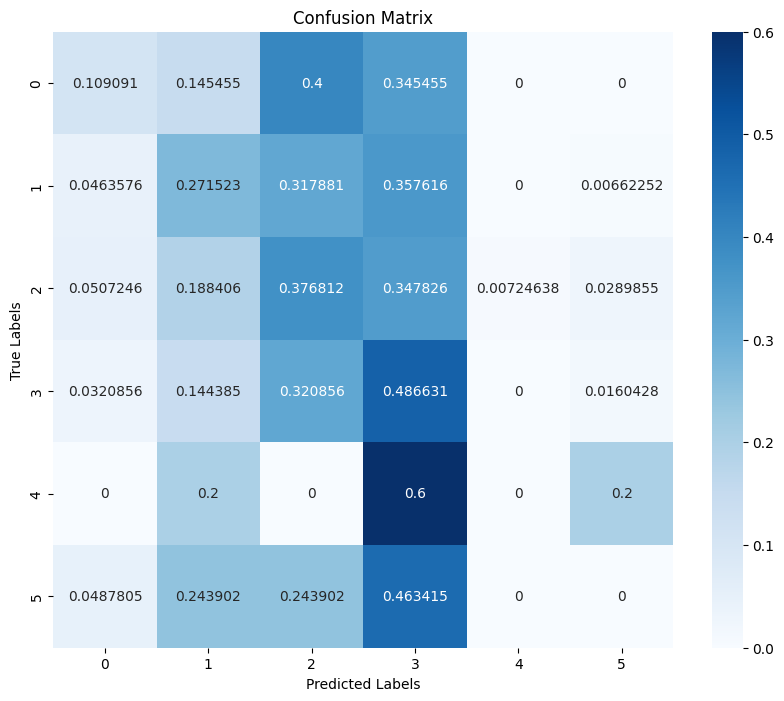

Epoch 10, Validation Loss: 3.2341, Accuracy: 0.3293, F1 Score: 0.3105
Val F1 Score Per Class  [0.14457831 0.31060606 0.31515152 0.43230404 0.         0.        ]


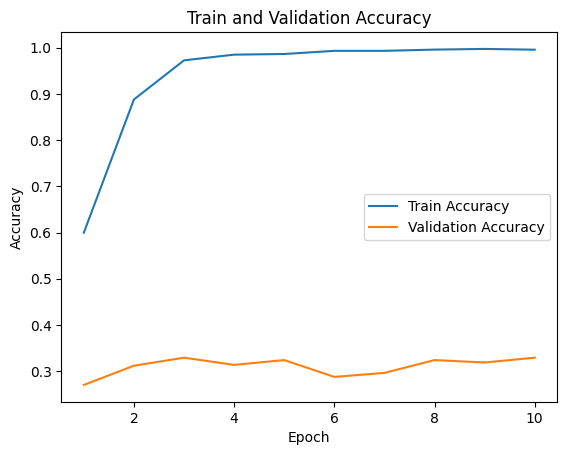

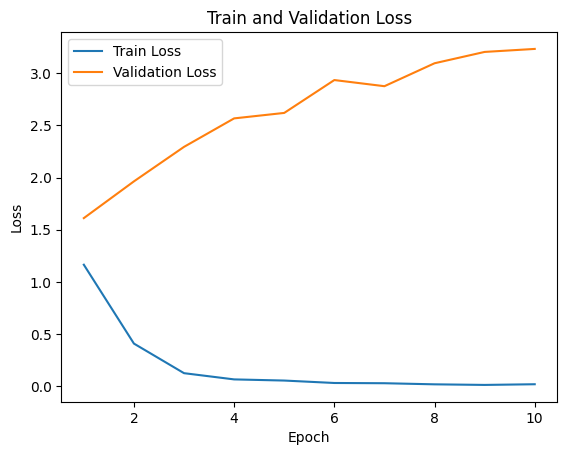

Epoch 11, Train Loss: 0.0029, Accuracy: 0.9998, F1 Score: 0.9998
Train F1 Score Per Class  [1.         0.99935897 0.99941452 1.         1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.18it/s, loss=4.1]

[tensor([-2.8749, -1.4747, -2.3126,  3.6885, -3.2994, -2.7629], device='cuda:0'), tensor([-2.1265,  3.8461, -1.6429, -1.1236, -4.3508, -3.4354], device='cuda:0'), tensor([-1.1371, -1.6121, -2.6187,  3.9419, -4.9277, -2.7023], device='cuda:0'), tensor([-1.8007, -1.1356, -3.2248,  5.0952, -3.5726, -2.0049], device='cuda:0'), tensor([-3.4000,  2.0108,  0.6029, -1.3591, -4.7032, -2.2227], device='cuda:0'), tensor([-3.9677,  0.7773,  0.4152,  0.2308, -4.2771, -3.5002], device='cuda:0'), tensor([-2.4364, -1.4137, -2.4023,  4.9273, -3.9604, -1.3035], device='cuda:0'), tensor([-2.6539, -2.3877,  2.3006,  3.3616, -3.1848, -2.1795], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.10it/s, loss=4.19]

[tensor([-2.0140, -1.5774, -2.6919,  4.2894, -4.5686, -2.6851], device='cuda:0'), tensor([-3.5031, -0.0172, -2.7526, -0.9624, -2.2505, -0.9103], device='cuda:0'), tensor([ 0.0564, -2.1668, -1.3867,  4.4069, -4.1773, -3.3969], device='cuda:0'), tensor([-1.8197, -0.5994, -1.3707,  4.8934, -3.4807, -3.0030], device='cuda:0'), tensor([-1.1641,  6.3421, -1.6354, -1.5944, -2.9640, -2.1618], device='cuda:0'), tensor([-1.3031,  3.0809, -2.1341,  0.6831, -4.3521, -3.7889], device='cuda:0'), tensor([ 0.1787, -2.1237, -2.3843,  3.9241, -3.5575, -2.8744], device='cuda:0'), tensor([ 2.9355,  0.8413, -2.8902,  0.5029, -4.4777, -3.2120], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=3.97]

[tensor([-2.7015,  0.3085,  0.2791, -1.5005, -3.9313, -3.8427], device='cuda:0'), tensor([-1.2631,  4.6266, -0.9499, -1.9178, -2.7904, -2.6881], device='cuda:0'), tensor([-2.4312, -1.2520,  5.7531, -1.2953, -3.0488, -2.1714], device='cuda:0'), tensor([-0.9685, -2.3953, -1.5379,  3.1878, -4.4307, -3.3979], device='cuda:0'), tensor([-1.4922,  0.0593, -2.7149,  4.6936, -2.8145, -3.0670], device='cuda:0'), tensor([-1.6852,  1.7001, -2.2941,  0.8319, -4.4789, -3.4697], device='cuda:0'), tensor([-1.3651, -2.3887, -1.7136,  5.4153, -3.6594, -2.8862], device='cuda:0'), tensor([-0.0857, -1.4515, -0.0312, -0.8242, -4.3380, -3.2022], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=3.56]

[tensor([-1.8603, -2.1015, -0.8122,  5.7380, -3.1673, -2.4761], device='cuda:0'), tensor([-3.3486,  0.8177,  1.7213, -1.8987, -3.8099, -2.3390], device='cuda:0'), tensor([-2.1082,  1.4773, -3.0122,  0.1804, -3.8805, -0.7050], device='cuda:0'), tensor([-2.1928, -0.2620,  1.9124, -0.7150, -2.9541, -2.8721], device='cuda:0'), tensor([ 4.4949, -2.3213, -0.5287,  1.6648, -3.3084, -3.7578], device='cuda:0'), tensor([-1.8401, -0.8583, -0.2868, -0.7170, -5.6371, -2.1869], device='cuda:0'), tensor([-1.3735,  6.2100, -1.5315, -1.4771, -3.0161, -2.3855], device='cuda:0'), tensor([-3.2119,  2.6617,  1.3727, -1.9824, -2.5242, -0.7585], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=3.98]

[tensor([-3.0000, -0.3556, -1.6062,  1.5552, -3.9200, -3.5025], device='cuda:0'), tensor([-2.8835, -2.2395,  1.0047,  2.1349, -3.8976, -3.6212], device='cuda:0'), tensor([-1.8861, -0.4633,  5.4714, -2.1795, -2.8182, -2.7955], device='cuda:0'), tensor([-2.8604, -0.9923, -1.7324,  3.4365, -3.5069, -3.2829], device='cuda:0'), tensor([-2.1888, -1.1455,  5.9618, -0.9890, -3.0884, -2.4396], device='cuda:0'), tensor([-2.6331,  0.1572,  0.1577, -0.0255, -5.1859, -2.9375], device='cuda:0'), tensor([-2.5279,  1.0345, -1.7547, -1.7532, -4.0466, -1.9795], device='cuda:0'), tensor([-1.6245, -0.4923, -2.8673,  4.5727, -3.3739, -1.2546], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=4.53]

[tensor([-1.9377, -1.8885,  6.5426, -1.2683, -2.6951, -2.4072], device='cuda:0'), tensor([-1.9429, -1.3848,  6.2949, -1.9003, -2.5766, -1.3916], device='cuda:0'), tensor([-1.9127,  0.0240,  3.3454, -1.9047, -4.2265, -3.6910], device='cuda:0'), tensor([-2.7728,  2.4636, -1.9212, -0.1874, -3.9748, -3.4248], device='cuda:0'), tensor([-2.5302, -1.5836,  5.1747, -1.7367, -3.0161, -2.6762], device='cuda:0'), tensor([-1.4247, -2.5685, -1.6957,  4.8961, -4.0676, -2.3288], device='cuda:0'), tensor([-0.8847, -2.9841, -0.1046,  3.8241, -3.9018, -3.5390], device='cuda:0'), tensor([-1.8119, -2.2067, -1.8884,  2.8368, -3.6258, -3.3258], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=2.51]

[tensor([-2.1107,  1.0372, -0.8403, -0.8862, -4.0258, -2.6451], device='cuda:0'), tensor([-1.9508, -1.1963,  2.6192, -0.8940, -3.4413, -1.9235], device='cuda:0'), tensor([-1.1780, -1.1050,  4.9222, -1.3963, -2.9888, -3.2728], device='cuda:0'), tensor([-3.2066, -1.4461, -1.0564,  4.3759, -4.5824, -3.1608], device='cuda:0'), tensor([-3.1528,  0.1603,  0.7024, -0.7069, -3.5164, -4.3352], device='cuda:0'), tensor([-2.7601, -0.0635, -2.4516,  1.8880, -4.1177, -1.1021], device='cuda:0'), tensor([-2.8966, -2.7112,  3.3763, -1.3516, -3.4816, -0.8257], device='cuda:0'), tensor([-2.6975,  4.4804, -2.1498, -0.2472, -5.0310, -2.7036], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=5.26]

[tensor([ 0.1450, -2.1476,  0.0343,  0.7461, -4.6844, -3.9184], device='cuda:0'), tensor([-2.1412, -2.2948,  3.3146,  0.1783, -2.7121, -2.3188], device='cuda:0'), tensor([-1.3106, -0.6051, -2.6976,  5.5449, -4.1209, -2.8378], device='cuda:0'), tensor([-1.5773,  6.3712, -1.6491, -1.1081, -2.6293, -2.5452], device='cuda:0'), tensor([-2.2408, -1.6702,  5.7658, -2.1226, -3.2308, -2.9319], device='cuda:0'), tensor([-2.2485,  0.2054, -1.5082,  2.1388, -4.2919, -3.8776], device='cuda:0'), tensor([-2.4478, -2.5915, -1.4104,  0.9060, -4.0080,  1.1344], device='cuda:0'), tensor([-2.2836, -1.3263,  6.0410, -1.4197, -2.2310, -1.7724], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.14it/s, loss=4.8]

[tensor([-2.4080, -0.6136, -3.0516,  0.7903, -4.3363, -0.8999], device='cuda:0'), tensor([-1.7810,  4.7520,  0.4389, -1.6221, -3.3883, -2.9840], device='cuda:0'), tensor([-0.7138,  4.3256, -1.5254,  0.0303, -2.9452, -3.9411], device='cuda:0'), tensor([-1.3387, -2.0476,  1.0742,  1.2572, -2.7614, -2.8845], device='cuda:0'), tensor([-1.6454, -2.3797, -0.3934,  2.2748, -3.0903, -2.8849], device='cuda:0'), tensor([-3.0255,  3.9936, -0.6299,  0.1555, -3.8562, -3.7093], device='cuda:0'), tensor([-3.4740,  3.9052, -2.6613,  0.5917, -3.9392, -1.4669], device='cuda:0'), tensor([-1.5807e+00, -2.5259e+00, -1.8759e-03,  2.7681e+00, -4.8884e+00,
        -3.4597e+00], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.15it/s, loss=2.22]

[tensor([-2.1808,  3.1507, -2.2673, -1.4606, -2.8068, -3.4703], device='cuda:0'), tensor([-2.5575, -1.4094,  1.0712,  1.4903, -3.6349, -3.4496], device='cuda:0'), tensor([-1.2182,  5.8003, -2.3838, -1.2746, -3.3378, -2.3897], device='cuda:0'), tensor([-1.7777, -2.4903, -0.5800,  4.0041, -3.8051, -3.9430], device='cuda:0'), tensor([-1.8625,  5.4521, -0.1803, -1.3310, -2.9182, -2.6699], device='cuda:0'), tensor([ 0.6063,  0.2542, -0.6104,  1.8937, -4.6273, -4.3439], device='cuda:0'), tensor([-2.7574,  4.9345, -3.0833, -0.3405, -3.4510, -2.5839], device='cuda:0'), tensor([-2.2739,  2.9812, -2.3678,  0.8264, -3.9634, -3.7494], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=5.5]

[tensor([-2.6570, -1.9725, -0.5905,  4.8404, -3.6766, -3.0952], device='cuda:0'), tensor([-0.4015,  3.5620, -3.1379,  0.5998, -3.8870, -2.8646], device='cuda:0'), tensor([-2.3847, -2.5787,  0.4045,  4.4631, -4.1652, -1.8222], device='cuda:0'), tensor([-2.2378, -1.7023, -0.5697,  4.3096, -5.0331, -4.1295], device='cuda:0'), tensor([-2.6825,  6.0282, -1.6193, -1.1602, -3.4932, -1.5214], device='cuda:0'), tensor([-1.2204, -1.6878, -3.0683,  5.0314, -3.6747, -2.2453], device='cuda:0'), tensor([-3.7798,  2.7017, -0.1942, -1.6719, -3.7101, -3.0028], device='cuda:0'), tensor([-0.3382, -1.2144, -2.4353,  5.3808, -3.5406, -3.3845], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=2.63]

[tensor([-1.9008, -1.9227,  6.0031, -1.4137, -2.6399, -3.0010], device='cuda:0'), tensor([-3.2513, -0.1384, -0.8656,  3.2916, -4.2229, -3.4840], device='cuda:0'), tensor([-2.5032, -1.7404,  1.5174,  1.9033, -3.2637, -3.7705], device='cuda:0'), tensor([-1.6796,  0.7686, -2.8205,  1.4395, -4.1220, -4.6818], device='cuda:0'), tensor([ 0.7954, -0.8098, -2.6317, -0.9404, -3.6407, -3.9212], device='cuda:0'), tensor([-2.1848, -1.9068,  6.0175, -0.1194, -2.9598, -2.4575], device='cuda:0'), tensor([-1.8097, -1.1554, -3.0651,  4.3528, -3.7659, -1.8134], device='cuda:0'), tensor([-2.1578,  1.4167, -0.3230, -0.4242, -4.1596, -3.4011], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.16it/s, loss=1.54]

[tensor([-1.5873,  0.0890, -1.9598,  2.0146, -5.2832, -4.3953], device='cuda:0'), tensor([-3.3226,  3.8586, -0.3527,  0.3466, -3.5640, -3.0517], device='cuda:0'), tensor([-2.9067,  2.0014, -0.9368, -0.7067, -4.8442, -3.8427], device='cuda:0'), tensor([-2.6439,  1.5016,  3.5977, -2.4441, -3.2707, -2.8211], device='cuda:0'), tensor([-2.6945,  3.6195, -2.6910,  0.9259, -3.7228, -1.9279], device='cuda:0'), tensor([-2.5040, -1.4924, -0.6041, -0.6725, -3.8107, -2.4412], device='cuda:0'), tensor([-2.6304,  2.9497, -2.8427,  1.8958, -3.6991, -2.9864], device='cuda:0'), tensor([-1.5999,  4.4564, -2.0502, -0.8286, -3.8657, -3.9523], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=1.49]

[tensor([-1.9361, -2.4565,  2.7153, -2.3440, -4.0199,  0.1514], device='cuda:0'), tensor([-3.1738,  0.5290, -1.7041, -0.0415, -4.2271, -2.7053], device='cuda:0'), tensor([-3.1152, -2.8856,  0.3579,  1.6002, -3.4656, -1.3512], device='cuda:0'), tensor([-2.7765,  0.1689,  0.4162, -1.3957, -4.6775, -3.7787], device='cuda:0'), tensor([-2.7617, -0.7281, -2.3785,  5.4357, -3.1577, -1.4045], device='cuda:0'), tensor([-2.6881,  1.5476, -2.1287,  3.3606, -3.4423, -2.9071], device='cuda:0'), tensor([-1.9801,  2.5401, -2.1679, -1.0272, -4.4105, -2.6145], device='cuda:0'), tensor([-2.0589,  0.2978, -2.4011,  2.8313, -4.3965, -2.9563], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:26,  2.15it/s, loss=3.82]

[tensor([-2.5526,  3.7984, -1.6694,  1.1833, -4.3659, -3.5082], device='cuda:0'), tensor([-2.4663,  2.0640, -0.3769, -1.0537, -4.0408, -2.5780], device='cuda:0'), tensor([-1.8686, -0.6032,  6.0766, -2.1310, -2.6172, -1.7550], device='cuda:0'), tensor([-1.6914, -1.9732, -1.7614,  6.0425, -3.5138, -2.5582], device='cuda:0'), tensor([-1.8406, -1.6837, -1.1300,  5.4635, -3.5624, -3.6215], device='cuda:0'), tensor([-1.8421, -0.5544, -1.1963, -1.0190, -3.9987, -4.2731], device='cuda:0'), tensor([-3.3526, -0.3615,  0.4303,  1.2338, -4.5144, -2.8084], device='cuda:0'), tensor([-2.7070,  1.1683,  2.8814, -1.0894, -3.9482, -4.6581], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.14it/s, loss=2.51]

[tensor([-1.7988, -1.2573, -1.9074,  5.7339, -3.7788, -2.5432], device='cuda:0'), tensor([-2.7809,  4.1218, -0.1447, -1.8162, -3.3876, -2.9474], device='cuda:0'), tensor([-1.6562,  0.5129, -1.8865,  2.8406, -4.2727, -4.1258], device='cuda:0'), tensor([-3.4869,  2.8575,  0.4281, -1.4376, -4.5155, -2.2433], device='cuda:0'), tensor([-2.4656, -2.0564, -1.1385,  5.1892, -3.4123, -3.4333], device='cuda:0'), tensor([-3.0154, -0.2791,  5.3367, -1.2268, -2.9541, -2.7327], device='cuda:0'), tensor([-1.8470, -2.3965, -0.8759,  4.6167, -5.2161, -3.4315], device='cuda:0'), tensor([-2.7989, -1.4781, -1.5803, -0.9770, -3.4367, -2.6110], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=4.71]

[tensor([-3.4771,  3.4261, -0.6118, -0.2856, -5.0833, -3.5426], device='cuda:0'), tensor([-1.2299,  3.8924, -0.5440, -1.1674, -3.7421, -2.6194], device='cuda:0'), tensor([-1.9480,  5.3917, -0.4002, -2.3294, -3.0870, -2.4513], device='cuda:0'), tensor([-3.1033,  1.7956, -0.2614,  1.0898, -4.9868, -3.5254], device='cuda:0'), tensor([-2.1049, -2.1604, -2.0478,  5.8967, -3.1113, -2.1120], device='cuda:0'), tensor([-2.2589, -1.9550, -1.5491,  2.0460, -4.2886, -3.1531], device='cuda:0'), tensor([-0.1949, -2.3328, -1.6947,  3.0151, -4.0218, -2.2502], device='cuda:0'), tensor([-1.7735, -1.4114, -3.5880,  2.8792, -3.3031, -2.8196], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.13it/s, loss=2.14]

[tensor([-2.2147, -2.0717, -0.5088,  5.0185, -3.7329, -3.3118], device='cuda:0'), tensor([ 0.1739, -2.1554, -1.0092,  3.1365, -3.0839, -3.7673], device='cuda:0'), tensor([-3.6386,  0.8526, -1.2124, -0.3834, -4.3995, -1.1103], device='cuda:0'), tensor([-2.2850,  1.8435, -2.2133,  2.1019, -3.6556, -3.2486], device='cuda:0'), tensor([-2.2752, -2.6453,  3.3834, -1.0084, -2.0506, -3.2304], device='cuda:0'), tensor([-0.6208, -2.1416, -2.0541,  2.5807, -4.6355, -1.5611], device='cuda:0'), tensor([-0.6293,  0.0475, -0.9730, -0.9049, -4.7176, -3.5693], device='cuda:0'), tensor([-2.9749, -1.2395, -1.3620,  1.7150, -3.8757, -3.9008], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.12it/s, loss=1.64]

[tensor([-2.9420, -1.1491, -1.6792,  0.5835, -3.7620, -2.8419], device='cuda:0'), tensor([ 4.7557, -1.9806, -2.3577,  0.2727, -3.8185, -2.8250], device='cuda:0'), tensor([-1.9406, -0.9557,  5.4318, -0.6970, -2.9112, -3.1228], device='cuda:0'), tensor([-2.1445, -2.3049, -0.5166,  5.3689, -3.1884, -2.8224], device='cuda:0'), tensor([-0.8975,  5.1010, -2.5220, -0.9794, -3.7795, -2.8778], device='cuda:0'), tensor([-0.9841, -0.2678, -2.3813,  2.0354, -4.4490, -3.3853], device='cuda:0'), tensor([-1.9433, -0.1162, -1.8850,  1.5241, -4.1740, -2.4146], device='cuda:0'), tensor([-1.6899,  0.4014,  0.4872, -1.6463, -4.6598, -3.3016], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.13it/s, loss=5.07]

[tensor([-2.5309, -2.0323, -1.2314,  4.1724, -3.7000, -3.5132], device='cuda:0'), tensor([-2.4793,  5.4011, -2.9165, -1.3177, -2.6115, -1.4702], device='cuda:0'), tensor([-2.3009, -1.7590,  0.7119,  2.9207, -3.4412, -2.3259], device='cuda:0'), tensor([-1.4059, -3.0325,  0.3624,  2.3731, -4.0713, -2.7914], device='cuda:0'), tensor([ 0.8701, -0.6063,  0.6790, -1.4215, -4.5434, -4.0073], device='cuda:0'), tensor([-2.0359,  5.7727, -2.1270, -0.6025, -3.1066, -1.7454], device='cuda:0'), tensor([-2.1659, -2.2466, -0.0254,  0.8946, -4.1997, -3.4495], device='cuda:0'), tensor([-2.6765, -1.0915,  5.2261, -0.4665, -3.4911, -3.1589], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.13it/s, loss=4.75]

[tensor([-0.9369, -2.5303,  5.6721, -1.1178, -2.8824, -2.0344], device='cuda:0'), tensor([-1.8779,  4.6692, -2.2886,  0.3829, -4.0809, -3.0277], device='cuda:0'), tensor([-2.3684,  4.3586,  1.2444, -2.1018, -3.7749, -2.4723], device='cuda:0'), tensor([-2.3106, -2.8203,  5.2837,  0.3198, -2.8607, -2.9427], device='cuda:0'), tensor([-3.0693, -0.1986, -1.2695,  3.9320, -4.8573, -3.2594], device='cuda:0'), tensor([-1.5995, -1.1881, -1.0443, -0.0859, -4.4740, -2.3348], device='cuda:0'), tensor([-1.9328, -2.0668, -1.2110,  6.1432, -2.7309, -2.4103], device='cuda:0'), tensor([-1.7545, -1.5585, -1.2597,  4.8366, -2.8103, -1.2583], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=2.75]

[tensor([-2.7958,  0.0945, -0.9869,  2.9809, -4.4182, -4.2501], device='cuda:0'), tensor([-2.1114, -1.3511, -1.6131,  3.4004, -3.1126, -2.8021], device='cuda:0'), tensor([-2.3513, -1.4634, -1.7555,  6.0574, -3.2788, -2.7110], device='cuda:0'), tensor([-2.4613, -0.8248, -2.3686,  2.3371, -3.0320, -2.0430], device='cuda:0'), tensor([-1.3676, -1.3593, -0.7076,  3.0150, -4.1316, -4.6901], device='cuda:0'), tensor([ 1.6250, -2.8349, -1.2339,  2.8202, -3.3884, -3.5862], device='cuda:0'), tensor([-2.1025,  1.7695, -2.3152,  1.1298, -4.4338, -2.9891], device='cuda:0'), tensor([-2.6751, -1.8303, -0.0217,  5.2996, -3.4310, -2.9350], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.14it/s, loss=2.92]

[tensor([-1.4543, -0.6869, -2.3475,  3.7261, -3.6975, -3.7897], device='cuda:0'), tensor([-2.0589, -1.2821, -1.3763,  3.0464, -4.4347, -2.7086], device='cuda:0'), tensor([-1.7823, -0.6766, -2.2817,  5.1321, -2.8121, -2.8755], device='cuda:0'), tensor([-2.6881,  0.7904, -2.7008,  0.7733, -4.0287, -3.2569], device='cuda:0'), tensor([-2.6292,  3.3962, -1.9910,  1.2002, -4.1321, -3.1507], device='cuda:0'), tensor([-1.2688, -1.7174, -2.0311,  6.1403, -2.4800, -2.4314], device='cuda:0'), tensor([-2.6598, -2.1035,  3.2113,  0.3872, -3.7538, -2.8892], device='cuda:0'), tensor([-2.8475, -1.2456,  5.8711, -1.9382, -2.8531, -2.3675], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=2.8]

[tensor([-0.8841, -0.6840, -3.2768,  2.0828, -3.2248, -1.6086], device='cuda:0'), tensor([ 1.9736, -2.5622,  0.6660, -0.4865, -4.6816, -2.4366], device='cuda:0'), tensor([-1.5773, -1.9266, -0.2858,  4.8420, -4.0150, -3.7701], device='cuda:0'), tensor([-0.8256, -1.6915,  5.7294, -2.0066, -2.6502, -3.3420], device='cuda:0'), tensor([-3.0371,  1.9410,  4.3459, -1.8253, -3.0675, -3.4364], device='cuda:0'), tensor([-2.4159, -1.5133,  1.5242,  1.8520, -3.4970, -3.9389], device='cuda:0'), tensor([-2.1801, -1.4923, -2.0154,  5.9374, -2.6143, -1.4544], device='cuda:0'), tensor([-1.2112,  4.1685, -2.8003,  0.0225, -4.4546, -1.4588], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.16it/s, loss=4.09]

[tensor([-3.0890,  1.2391,  1.3920,  1.0419, -5.3665, -2.8448], device='cuda:0'), tensor([-1.4281,  2.5241, -2.2935,  0.6740, -4.4377, -2.8596], device='cuda:0'), tensor([-2.6754,  1.5045, -0.5408,  1.5467, -5.5594, -4.0622], device='cuda:0'), tensor([-2.5021, -1.6052,  3.9568, -0.5814, -3.3338, -3.8708], device='cuda:0'), tensor([-1.2184, -1.4402, -0.3887, -0.2108, -4.0868, -4.5789], device='cuda:0'), tensor([-1.5812,  6.0742, -1.4995, -2.0487, -2.7393, -1.8607], device='cuda:0'), tensor([-1.9794,  5.4936, -2.6939, -1.6389, -4.2717, -1.1258], device='cuda:0'), tensor([-2.2647,  4.9167, -3.0901, -0.1196, -3.7590, -0.6833], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.14it/s, loss=3.33]

[tensor([-1.1711,  4.8855, -3.0161, -0.7516, -3.8036, -1.4674], device='cuda:0'), tensor([-1.5939,  3.9219, -0.2312, -1.7924, -4.0553, -2.0119], device='cuda:0'), tensor([-2.6982,  4.1051, -0.3153, -0.1389, -3.9815, -3.8429], device='cuda:0'), tensor([ 0.0369, -2.3129,  1.7284, -1.2116, -4.3300, -4.8794], device='cuda:0'), tensor([-1.2327,  5.3107, -1.5169, -0.7496, -3.9260, -3.5749], device='cuda:0'), tensor([-2.5133, -2.8037, -0.8209,  1.3343, -3.2773, -2.4451], device='cuda:0'), tensor([-1.7450, -2.1955, -0.6009,  2.6441, -4.6118, -3.6015], device='cuda:0'), tensor([ 0.5256, -3.1336,  1.9028, -0.2186, -3.5403, -3.1778], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.13it/s, loss=3.63]

[tensor([-2.1400,  0.1738, -3.5411,  3.3375, -3.5925, -1.5598], device='cuda:0'), tensor([-1.5818,  4.3743,  1.0158, -2.2780, -3.0896, -3.1792], device='cuda:0'), tensor([-1.7454, -0.1646, -2.0677,  0.8341, -4.9945, -2.9644], device='cuda:0'), tensor([-2.5249, -0.9985, -1.5112,  4.3929, -3.0846, -2.7330], device='cuda:0'), tensor([-1.0356, -1.6839, -2.4645,  1.0247, -3.7355, -2.3987], device='cuda:0'), tensor([-2.9806, -0.1748, -0.4963,  2.7768, -4.2369, -4.4113], device='cuda:0'), tensor([-2.8301, -1.8527,  5.4154, -0.7473, -3.0449, -2.7717], device='cuda:0'), tensor([-2.5196,  5.0280, -2.4837,  0.9465, -4.0121, -3.3669], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.13it/s, loss=3.26]

[tensor([-0.5121, -1.2259,  2.1056, -1.0472, -3.4191, -3.8367], device='cuda:0'), tensor([-1.6942, -2.8040,  4.8309,  0.8758, -2.9966, -2.8727], device='cuda:0'), tensor([-0.9737, -0.6664, -1.3781,  2.8807, -4.3955, -3.9745], device='cuda:0'), tensor([-1.2946, -0.6191, -0.3785,  0.7390, -4.5523, -2.5565], device='cuda:0'), tensor([-1.9971, -0.0990,  5.5499, -1.7411, -2.4750, -2.8930], device='cuda:0'), tensor([-2.7271,  3.9996, -1.0888, -0.6548, -3.7694, -2.4902], device='cuda:0'), tensor([-2.0460, -1.2331,  1.5730,  1.2718, -4.4177, -1.8912], device='cuda:0'), tensor([-1.3240, -1.1636,  5.1840, -0.9831, -3.1491, -3.0574], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.13it/s, loss=4.33]

[tensor([ 4.9217, -0.4765, -1.4928, -1.2843, -3.1208, -1.6427], device='cuda:0'), tensor([-3.0847, -1.2173,  1.9214, -1.7795, -3.1970, -2.7810], device='cuda:0'), tensor([-1.2056,  0.6230, -2.5185,  2.5169, -3.3507, -4.2053], device='cuda:0'), tensor([-1.3110, -0.9272,  2.4986, -0.2750, -3.7927, -2.3374], device='cuda:0'), tensor([-1.8271,  6.1596, -1.5887, -0.5415, -3.0932, -2.6320], device='cuda:0'), tensor([-2.7862, -1.2579,  3.8805, -0.3836, -4.6471, -3.4466], device='cuda:0'), tensor([-1.8021, -0.8629,  4.6445, -1.4057, -3.5958, -2.3419], device='cuda:0'), tensor([-2.9321,  4.8600, -0.4944, -1.5666, -3.0714, -2.8079], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.13it/s, loss=5.23]

[tensor([-2.3614,  4.6758, -0.3389, -1.4280, -4.1148, -3.8192], device='cuda:0'), tensor([-2.2294, -2.5796,  4.2586,  2.4499, -3.5456, -3.2332], device='cuda:0'), tensor([-2.6908,  4.1342, -2.8525, -0.4212, -3.9806, -0.9259], device='cuda:0'), tensor([-2.9896,  3.2039, -1.6710, -0.6437, -3.3644, -0.3691], device='cuda:0'), tensor([-0.9128, -1.8578, -2.5530,  5.5002, -2.7796, -2.7062], device='cuda:0'), tensor([-1.0419, -1.8111,  5.2310, -1.1903, -3.7436, -3.6280], device='cuda:0'), tensor([-0.5655, -2.5816,  0.7058,  1.3982, -2.9454, -1.8706], device='cuda:0'), tensor([ 0.5408,  0.2210, -2.9175,  2.0353, -4.4403, -2.1498], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=2.43]

[tensor([-2.3827, -2.2953, -0.0763,  4.7790, -3.5500, -2.1188], device='cuda:0'), tensor([-0.3147, -2.3735, -1.1043,  0.2675, -4.8286, -3.7807], device='cuda:0'), tensor([-2.5120, -2.3786,  2.9919,  1.3007, -3.7397, -2.7992], device='cuda:0'), tensor([-0.1506, -2.9090,  3.7870,  1.9757, -4.2112, -3.5918], device='cuda:0'), tensor([-1.6504, -0.2184,  1.1907, -1.1594, -4.1050, -4.1351], device='cuda:0'), tensor([-1.8854, -0.4987, -3.2067, -1.3196, -2.4182,  3.0794], device='cuda:0'), tensor([ 0.4743,  4.7737, -2.0460, -1.6058, -3.5285, -3.4750], device='cuda:0'), tensor([-2.0496,  0.0171, -1.7965,  4.3277, -3.7069, -4.3869], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.15it/s, loss=3.75]

[tensor([-2.7995,  2.5256, -0.7697, -2.4050, -3.7482, -1.3145], device='cuda:0'), tensor([-0.8394, -0.8363,  0.4125,  1.1615, -4.2695, -4.5000], device='cuda:0'), tensor([-2.4507,  2.8328, -2.6619,  1.2640, -4.7343, -4.1345], device='cuda:0'), tensor([-2.3077, -0.9446,  4.5132, -1.1583, -2.8331, -2.8973], device='cuda:0'), tensor([-2.7597, -1.4348,  4.1619, -1.5234, -3.2792, -2.8907], device='cuda:0'), tensor([-1.7797,  6.3243, -1.5334, -1.2379, -2.9888, -1.8493], device='cuda:0'), tensor([-1.7749, -1.4439, -1.6004, -0.7677, -2.7176,  6.9336], device='cuda:0'), tensor([-2.3449, -2.4228, -0.5027,  1.1408, -2.7506, -3.8013], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.16it/s, loss=3.66]

[tensor([-2.3433,  1.2066,  1.6336,  1.1641, -4.9221, -4.1111], device='cuda:0'), tensor([-1.1539, -0.1941, -3.3290,  1.6860, -2.8599, -3.2396], device='cuda:0'), tensor([-2.8838,  1.8751,  0.2856, -1.4135, -4.3652, -4.1072], device='cuda:0'), tensor([-2.3780, -0.8818, -3.6647,  0.5612, -3.2736,  2.7364], device='cuda:0'), tensor([-2.5110,  1.2273, -2.1915,  1.4058, -3.8426, -3.6441], device='cuda:0'), tensor([-3.2899,  0.2755,  2.4900, -0.3245, -3.7094, -3.9751], device='cuda:0'), tensor([-2.5165, -0.7721, -1.0233,  1.4736, -4.2127, -3.5657], device='cuda:0'), tensor([-0.0237, -2.3277, -1.6701,  5.0641, -3.4515, -2.9936], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=2.74]

[tensor([-2.7534,  0.9039,  2.7936, -0.5151, -4.9169, -3.9543], device='cuda:0'), tensor([-2.4931, -1.6741,  2.7670, -0.5537, -3.3970, -3.3131], device='cuda:0'), tensor([-1.7680, -1.1285,  6.1942, -1.9159, -2.3875, -2.5093], device='cuda:0'), tensor([-2.5293, -0.8746,  0.1137, -0.4980, -4.7125, -2.6678], device='cuda:0'), tensor([-1.2482, -1.3079, -2.4122,  5.0610, -3.4942, -2.7937], device='cuda:0'), tensor([-1.9823, -1.3178,  6.3114, -2.0055, -2.4726, -2.0432], device='cuda:0'), tensor([ 4.9830, -1.6923, -1.9174, -0.0089, -3.2607, -2.6909], device='cuda:0'), tensor([-1.7067, -1.3034,  2.8468, -0.3856, -4.3731, -4.2541], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=2.96]

[tensor([-2.0456, -1.1885, -1.8584,  5.0261, -3.7041, -4.2038], device='cuda:0'), tensor([-2.6261,  0.2015,  1.2487, -2.6068, -3.2836, -1.0421], device='cuda:0'), tensor([-1.1393, -1.8297, -2.2026,  4.2430, -4.6198, -2.6468], device='cuda:0'), tensor([-0.2754, -2.5238,  2.3578, -1.1858, -4.2855, -2.5232], device='cuda:0'), tensor([-1.6192, -0.7422, -0.1923, -0.6607, -3.0706, -2.3454], device='cuda:0'), tensor([-2.3302, -0.8490, -2.5884,  4.1812, -3.7623, -1.0119], device='cuda:0'), tensor([ 0.6290, -2.0248, -2.1165,  2.0981, -4.0862, -2.6763], device='cuda:0'), tensor([-2.1016,  5.9739, -2.3768, -1.0155, -3.0170, -1.5783], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.15it/s, loss=1.94]

[tensor([-2.1308,  2.8493, -1.8337, -1.1326, -3.7430, -3.0884], device='cuda:0'), tensor([-0.3152, -1.7440, -1.2586,  1.8627, -4.4063, -3.6823], device='cuda:0'), tensor([-2.5811,  0.7147, -2.7093,  4.6607, -3.1069, -3.2313], device='cuda:0'), tensor([-2.3314, -0.4415, -1.2766,  2.4630, -3.9073, -3.9955], device='cuda:0'), tensor([-1.8561, -2.2971,  1.1057,  4.4075, -3.8225, -4.0499], device='cuda:0'), tensor([-2.8162,  3.9778, -1.6067, -1.0132, -2.6338, -3.9273], device='cuda:0'), tensor([-2.4162,  5.0498, -0.2816, -1.6630, -4.0135, -2.6742], device='cuda:0'), tensor([-3.0729,  2.8690, -1.2921, -1.3987, -3.7011, -3.8596], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=4.73]

[tensor([-1.1136, -1.3770, -1.9241,  5.6676, -3.6434, -2.8086], device='cuda:0'), tensor([-2.2199,  4.6196, -2.9124,  0.1565, -2.6129, -2.4460], device='cuda:0'), tensor([-1.1729, -1.0612, -2.6716,  4.6929, -4.5699, -2.4367], device='cuda:0'), tensor([-2.2853, -0.9672,  6.0000, -1.6533, -3.2623, -3.0778], device='cuda:0'), tensor([-2.5470,  1.4034, -1.2027, -2.1187, -3.3553, -1.7466], device='cuda:0'), tensor([-2.3984,  3.5756, -1.3874, -1.5171, -3.3844, -3.1823], device='cuda:0'), tensor([-1.8561,  5.6794, -0.3602, -1.5963, -3.4196, -3.6177], device='cuda:0'), tensor([-2.8978,  0.6369, -2.6098,  3.7403, -4.1247, -2.0771], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=4.53]

[tensor([-1.9554, -1.1690, -3.2509,  4.8436, -3.2621, -0.8359], device='cuda:0'), tensor([-2.1774, -1.4197,  5.0099, -0.7503, -2.1947, -2.3173], device='cuda:0'), tensor([-2.0717, -1.1500,  0.6859,  4.5569, -3.5698, -4.3166], device='cuda:0'), tensor([-1.6736, -1.0546,  4.5980, -1.9160, -3.4948, -2.4368], device='cuda:0'), tensor([-2.2063, -1.7886,  5.2941, -1.0600, -3.2756, -1.3483], device='cuda:0'), tensor([-0.2703, -2.0919, -0.3713,  2.5216, -4.3359, -4.2446], device='cuda:0'), tensor([-2.9216,  3.2801, -2.2724,  0.5727, -3.5401, -2.1658], device='cuda:0'), tensor([-1.5376,  5.0999, -1.3254, -0.8028, -3.3480, -3.6048], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=3.09]

[tensor([-1.1383,  1.2895,  2.4068, -1.9934, -3.4668, -3.6130], device='cuda:0'), tensor([-2.1109, -1.3927, -2.5503,  3.2939, -2.5103, -0.5822], device='cuda:0'), tensor([ 0.3671, -0.6519, -2.5899,  0.8071, -3.4727, -3.1606], device='cuda:0'), tensor([-2.8507,  1.4658, -1.5547,  0.8263, -4.3645, -4.2625], device='cuda:0'), tensor([-1.7789, -0.9757, -0.8395,  0.2890, -4.6522, -5.0827], device='cuda:0'), tensor([-1.7008, -2.7716,  4.9225, -0.5536, -3.1997, -2.9158], device='cuda:0'), tensor([-1.9492, -1.2617, -1.9944,  5.2337, -2.6466, -3.4729], device='cuda:0'), tensor([-2.6588, -2.4558,  2.8043,  1.0687, -3.0653, -2.6682], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=3.9]

[tensor([-2.6746,  1.5328, -1.5751,  2.9671, -3.9543, -4.0819], device='cuda:0'), tensor([-2.4459, -1.4050, -2.2134,  5.4930, -3.2242, -2.6291], device='cuda:0'), tensor([-3.2396,  1.6191, -2.5078, -0.1424, -3.4515, -3.0667], device='cuda:0'), tensor([-1.4192, -1.7652,  6.4860, -2.1214, -2.0823, -1.8638], device='cuda:0'), tensor([-1.0841,  0.4727, -2.9945,  4.5309, -2.6054, -3.7816], device='cuda:0'), tensor([-2.3409, -1.9026,  5.5043, -1.7252, -3.2342, -2.0397], device='cuda:0'), tensor([-3.0728, -0.9398, -0.1201,  1.0709, -4.9290, -3.8824], device='cuda:0'), tensor([-0.5356, -2.2604,  2.1432, -0.0209, -1.7649, -3.1926], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.14it/s, loss=3.28]

[tensor([-1.6989, -1.7178, -1.7625,  6.2338, -2.6124, -2.5642], device='cuda:0'), tensor([-1.7653, -1.9955, -1.9577,  5.9915, -4.0475, -2.3448], device='cuda:0'), tensor([-2.5928,  1.5592, -1.7765,  1.2186, -4.3367, -3.3024], device='cuda:0'), tensor([-0.5015, -0.6498, -3.3670,  3.8799, -3.7524, -2.0395], device='cuda:0'), tensor([-2.7842e+00,  2.0466e+00,  1.1134e-03,  7.7755e-01, -3.6935e+00,
        -4.3627e+00], device='cuda:0'), tensor([-2.4154, -1.4140,  5.8314, -0.5900, -2.8400, -2.9469], device='cuda:0'), tensor([-0.9891,  0.6932, -1.9712,  0.5155, -4.0466, -3.7050], device='cuda:0'), tensor([-0.6444, -1.7845,  5.5473, -1.5925, -2.6415, -2.3602], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.13it/s, loss=3.38]

[tensor([-3.2225,  0.6472, -1.3733, -0.2930, -4.2837, -2.1260], device='cuda:0'), tensor([-1.3556, -0.9501, -2.1918,  3.7389, -4.2024, -3.7250], device='cuda:0'), tensor([ 6.1416, -2.0605, -0.7742, -0.9038, -2.9891, -1.3249], device='cuda:0'), tensor([-2.3302,  4.1540, -2.5894,  0.2925, -3.0176, -2.9356], device='cuda:0'), tensor([-1.3443, -1.4057, -3.3226,  4.8050, -3.7591, -2.1594], device='cuda:0'), tensor([-1.8066, -0.4845, -2.9069,  4.8397, -4.1114, -3.0489], device='cuda:0'), tensor([ 0.1806,  0.3464, -2.0197,  2.4617, -4.5389, -4.4153], device='cuda:0'), tensor([-2.5267,  0.2456, -0.3553, -0.9422, -4.3487, -0.4485], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.13it/s, loss=2.82]

[tensor([-2.5841, -0.7438, -2.5479,  4.4048, -3.9770, -2.7269], device='cuda:0'), tensor([-3.8111, -1.9936, -0.8011, -1.8761, -3.1753, -2.1927], device='cuda:0'), tensor([-3.2051, -1.4101,  1.0957,  2.5613, -4.7841, -2.7996], device='cuda:0'), tensor([-1.0103, -1.5023, -1.4938,  5.1519, -4.3564, -3.6401], device='cuda:0'), tensor([-3.2448,  2.4864,  2.1116, -0.2610, -4.1246, -3.9823], device='cuda:0'), tensor([-2.5268, -1.5932, -2.5787,  3.9523, -5.0539, -3.3764], device='cuda:0'), tensor([-0.8926, -2.8845, -0.2544,  5.6834, -3.3398, -3.4833], device='cuda:0'), tensor([-1.8608, -0.9691, -0.9782,  0.4318, -4.1439, -4.7526], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.12it/s, loss=3.25]

[tensor([-0.6460, -1.2134, -0.8205,  3.3542, -3.7162, -4.5439], device='cuda:0'), tensor([-0.5722, -2.2286, -0.5938, -0.1676, -3.6816, -3.7613], device='cuda:0'), tensor([-3.3379, -1.5013, -1.5694,  3.8057, -4.1158, -2.8941], device='cuda:0'), tensor([-2.8220, -1.5487, -1.9499,  4.8443, -4.4132, -1.6753], device='cuda:0'), tensor([-1.4067, -2.2598, -0.6526,  1.9467, -1.8751, -1.6412], device='cuda:0'), tensor([-4.0390,  1.2117,  1.2361,  1.3591, -4.3810, -3.6051], device='cuda:0'), tensor([-1.1344, -1.6944,  2.7803,  1.2041, -3.3558, -3.3757], device='cuda:0'), tensor([-1.4204,  3.5952, -2.7724, -0.8718, -2.9000, -1.2899], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.11it/s, loss=3.66]

[tensor([ 4.6202, -0.7212, -1.7401, -1.0952, -4.0336, -2.3482], device='cuda:0'), tensor([-2.4560,  0.0979, -2.8600,  1.7885, -2.6503, -2.6086], device='cuda:0'), tensor([-2.5274,  0.0418, -2.5169,  4.7564, -3.6106, -2.0253], device='cuda:0'), tensor([-2.5191,  0.5760,  0.4920, -1.6161, -3.3174, -2.9304], device='cuda:0'), tensor([-2.1142, -2.2547,  5.9441, -0.4593, -3.0982, -2.1399], device='cuda:0'), tensor([-1.4931, -1.6491, -2.2506, -0.6840, -2.6385,  6.8341], device='cuda:0'), tensor([-2.6756,  4.2509, -0.8401, -0.9366, -3.8084, -3.0431], device='cuda:0'), tensor([-2.4745, -1.3559, -2.3967,  4.1827, -4.3718, -2.0202], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.12it/s, loss=2.53]

[tensor([-2.4192,  0.5237,  4.3492, -1.9996, -3.3053, -3.0527], device='cuda:0'), tensor([-1.2522,  0.3401, -1.1824,  2.1929, -3.2305, -2.6063], device='cuda:0'), tensor([-2.8336, -0.9482, -2.1666,  4.6922, -3.7758, -3.2918], device='cuda:0'), tensor([-1.8629, -2.0776,  6.0194, -2.1615, -2.8778, -1.3171], device='cuda:0'), tensor([-2.9119, -0.8093, -2.3094,  4.6072, -3.5799, -2.2049], device='cuda:0'), tensor([-2.4539,  3.1753, -2.9107, -0.1311, -3.6442, -3.4527], device='cuda:0'), tensor([-2.2905,  0.0907, -1.1305,  0.4581, -4.4258, -3.3292], device='cuda:0'), tensor([-1.8290, -0.6681,  5.1275, -1.1009, -2.9117, -3.1329], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.13it/s, loss=2.09]

[tensor([ 4.0435, -2.1345, -3.0998,  0.8774, -2.9523, -1.9663], device='cuda:0'), tensor([-2.7169,  1.1127,  0.2899,  2.1122, -5.0425, -3.7159], device='cuda:0'), tensor([-2.9598, -0.1625,  1.8595, -0.2138, -3.6410, -3.1573], device='cuda:0'), tensor([-2.4868, -1.6669,  0.0777,  0.2567, -3.9955, -3.2333], device='cuda:0'), tensor([-2.1313,  1.0599,  4.6364, -1.7145, -3.7893, -3.8338], device='cuda:0'), tensor([-1.0514,  0.6681, -3.8201, -0.4481, -4.0157, -2.8064], device='cuda:0'), tensor([-1.2751, -1.4726, -1.2421,  1.3427, -2.4375, -3.5885], device='cuda:0'), tensor([-1.5748, -1.1119, -1.5610,  4.7252, -3.8021, -3.4669], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.12it/s, loss=3.38]

[tensor([-1.4903, -1.7335,  6.3035, -1.8792, -2.9129, -1.5180], device='cuda:0'), tensor([-1.9988,  0.7875, -2.4090,  0.6618, -3.7983, -2.8244], device='cuda:0'), tensor([-1.8620,  6.4128, -1.2414, -1.5719, -2.7828, -2.1008], device='cuda:0'), tensor([-1.4995,  6.1396, -1.3924, -1.1379, -3.5251, -2.6137], device='cuda:0'), tensor([-1.5979, -1.8633, -1.7604,  6.1909, -3.1340, -2.3326], device='cuda:0'), tensor([ 1.4504, -0.8361, -2.1457, -1.2157, -3.4613, -1.2053], device='cuda:0'), tensor([-2.4384, -0.7519,  1.4659,  2.3371, -4.5794, -4.0713], device='cuda:0'), tensor([-2.5094, -0.2551, -1.3461,  5.0065, -3.8893, -3.1460], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.13it/s, loss=3.66]

[tensor([-2.9102, -1.3014,  4.1808, -1.1436, -3.3267, -3.4774], device='cuda:0'), tensor([-1.3519,  3.1781, -1.3366, -1.0712, -3.8837, -4.2572], device='cuda:0'), tensor([-3.6428,  1.0449,  4.0775, -1.1375, -3.1737, -2.2471], device='cuda:0'), tensor([-1.9838,  0.2634,  4.8679, -1.7090, -3.6143, -2.7599], device='cuda:0'), tensor([-2.5012,  4.0569,  2.2638, -2.3881, -3.0193, -2.8029], device='cuda:0'), tensor([-0.3373, -2.7695, -0.9818,  0.3714, -3.9436, -4.1802], device='cuda:0'), tensor([-2.1576,  0.1837,  1.7912, -2.0221, -5.2090, -1.8721], device='cuda:0'), tensor([-2.1052, -2.1976, -0.9896,  5.9552, -3.2856, -2.2954], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.14it/s, loss=4.05]

[tensor([ 0.4097, -0.9173, -0.8768, -0.2716, -4.8969, -3.5261], device='cuda:0'), tensor([-2.0944,  1.6936,  0.7536, -1.5476, -5.3196, -3.1074], device='cuda:0'), tensor([-3.2170,  0.9447,  1.4959,  0.8511, -3.5106, -3.1815], device='cuda:0'), tensor([-1.5324,  5.1088, -1.4993, -0.4639, -4.9736, -2.7597], device='cuda:0'), tensor([-2.2283, -1.2136,  5.4232, -2.0894, -3.4391, -2.4190], device='cuda:0'), tensor([-1.7900, -1.4650, -2.5057,  5.9807, -2.9795, -1.9220], device='cuda:0'), tensor([-2.6872, -0.8841, -0.2640,  4.5045, -3.8318, -1.9638], device='cuda:0'), tensor([-2.6444,  0.0797, -1.3563, -0.4906, -3.9887, -3.4477], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=3.07]

[tensor([-2.0275, -1.6380,  4.3290, -0.0818, -3.9402, -3.0311], device='cuda:0'), tensor([-1.4630, -2.1788, -1.9882,  6.0025, -3.4629, -1.5117], device='cuda:0'), tensor([-2.5742,  3.3685,  0.0628, -1.3870, -3.6162, -0.8289], device='cuda:0'), tensor([-2.8057,  1.8548, -1.7622,  4.4191, -4.0008, -3.7022], device='cuda:0'), tensor([-2.5063,  2.4351,  2.1541, -1.6719, -4.0417, -3.9049], device='cuda:0'), tensor([ 3.2527, -0.8144, -3.5969,  0.9988, -3.4797, -1.7308], device='cuda:0'), tensor([-0.7086, -1.6831, -1.5021,  5.5687, -3.5853, -2.9365], device='cuda:0'), tensor([-0.7999, -0.4318, -1.6098, -3.2387, -3.6325,  4.1775], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.15it/s, loss=2.75]

[tensor([-3.7877, -0.4172,  2.6378, -1.4042, -4.4515, -1.9520], device='cuda:0'), tensor([-0.5498, -1.4241, -1.2075,  5.4079, -3.4610, -3.8234], device='cuda:0'), tensor([ 0.2471, -0.7034, -2.2339,  2.0513, -2.7252, -4.5572], device='cuda:0'), tensor([-2.6217,  1.4889, -3.0301,  0.6553, -3.5768, -1.6350], device='cuda:0'), tensor([-2.5179, -1.1972,  5.4722, -1.5334, -3.2142, -1.4457], device='cuda:0'), tensor([-2.2436,  4.9502, -2.9421, -1.3392, -2.7497, -2.3195], device='cuda:0'), tensor([ 4.4732, -2.3001,  1.0679, -1.0068, -2.9601, -2.2476], device='cuda:0'), tensor([-1.7999,  5.9463, -1.4088, -1.2059, -3.0914, -2.3621], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.15it/s, loss=3.42]

[tensor([-1.7040,  0.2951, -3.1675,  4.3525, -3.5412, -2.5792], device='cuda:0'), tensor([-1.0352, -2.2592, -0.2524,  3.4493, -3.6397, -3.5749], device='cuda:0'), tensor([-2.9196, -2.4121, -0.0969,  3.0198, -5.0490, -1.6492], device='cuda:0'), tensor([-1.7823, -0.6947, -1.9977,  1.6580, -4.1847, -3.6267], device='cuda:0'), tensor([ 5.5896, -1.1416, -0.2055, -1.6430, -2.8960, -2.2690], device='cuda:0'), tensor([-0.8842, -1.8130, -1.9212,  1.8109, -4.6673, -4.3156], device='cuda:0'), tensor([-1.3304, -1.9856,  1.2813,  4.5921, -4.7595, -3.8156], device='cuda:0'), tensor([-2.9540, -1.9134,  0.7591,  3.5475, -3.7112, -4.3719], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.15it/s, loss=3.07]

[tensor([-2.6774, -1.9328, -1.0331,  5.0521, -3.7641, -2.0785], device='cuda:0'), tensor([-1.6018, -2.5967,  1.0130,  3.5107, -4.6497, -3.9728], device='cuda:0'), tensor([-2.7637,  0.6782,  0.8762,  0.9440, -4.7129, -3.1272], device='cuda:0'), tensor([-1.1590, -1.6307, -1.7645,  5.9772, -3.5871, -2.0393], device='cuda:0'), tensor([-2.8911, -2.2250,  0.2042,  3.7455, -4.0602, -2.9922], device='cuda:0'), tensor([-2.4654, -0.8375, -2.8364,  0.8962, -3.8957, -0.8293], device='cuda:0'), tensor([-1.5681,  2.4940, -0.1993, -1.1653, -3.7699, -3.9668], device='cuda:0'), tensor([-3.0654,  2.6388, -0.2384, -1.7340, -4.2893, -0.4336], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.15it/s, loss=2.65]

[tensor([-2.0443, -1.7725,  6.2013, -0.9127, -2.2221, -2.1724], device='cuda:0'), tensor([ 0.5417,  0.9076,  0.4948, -0.1057, -4.2242, -5.2528], device='cuda:0'), tensor([-1.1965, -0.6355, -0.1808, -0.8551, -4.1713, -4.0767], device='cuda:0'), tensor([-2.2091, -0.6076, -1.4008, -0.8006, -4.6373, -2.2749], device='cuda:0'), tensor([-1.8029,  4.3102, -0.8915, -0.6115, -3.2634, -2.9140], device='cuda:0'), tensor([-0.2689, -2.0896,  4.1185, -1.1344, -3.1254, -2.6600], device='cuda:0'), tensor([-2.4054, -1.4833, -0.0822,  1.4011, -3.7321, -3.4691], device='cuda:0'), tensor([-1.3203,  5.3624, -1.1194, -1.4263, -3.6832, -3.4287], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=3.9]

[tensor([-2.3649,  3.9032, -0.4204, -1.9842, -4.1547, -2.7473], device='cuda:0'), tensor([-2.2497, -0.4329, -2.1352,  4.7660, -2.8784, -3.2052], device='cuda:0'), tensor([-3.0552, -2.5490,  4.1823, -0.0637, -4.0845, -2.5984], device='cuda:0'), tensor([-2.3656, -0.8809, -1.7140,  1.6555, -4.1238, -4.3401], device='cuda:0'), tensor([-2.2898,  5.7436, -1.8613, -0.0733, -3.4629, -3.6065], device='cuda:0'), tensor([-1.4712, -2.0673, -2.1095,  4.9485, -4.3867, -1.6411], device='cuda:0'), tensor([-2.1520, -0.3025, -1.9321,  0.1989, -3.7987, -3.6324], device='cuda:0'), tensor([-2.4386,  2.0420, -2.4733,  1.9107, -2.9185, -2.4957], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.14it/s, loss=2.6]

[tensor([-1.6491,  5.0197, -1.0331, -1.8103, -2.7477, -2.7288], device='cuda:0'), tensor([-2.0223,  1.7957, -0.5446,  0.3841, -4.3802, -4.3764], device='cuda:0'), tensor([-0.9814,  0.5720,  1.2268, -1.2773, -4.1353, -3.2632], device='cuda:0'), tensor([-0.1169, -1.3650, -1.1684, -0.6121, -4.1934, -3.7635], device='cuda:0'), tensor([-1.4116, -2.7865,  0.1022,  3.6544, -4.3335, -3.1678], device='cuda:0'), tensor([-1.5857, -0.2040,  3.8058, -2.2879, -3.2664, -3.4047], device='cuda:0'), tensor([-1.3430,  5.9855, -2.1117, -1.2271, -2.5238, -2.4344], device='cuda:0'), tensor([-2.4463, -0.5676, -0.6589,  5.1934, -3.6132, -3.3039], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.15it/s, loss=4.28]

[tensor([-2.4741, -1.1273, -1.9816,  5.7402, -3.1850, -3.3435], device='cuda:0'), tensor([-1.9992, -1.9575,  4.1365, -0.3749, -2.7956, -3.6284], device='cuda:0'), tensor([-1.9810,  5.8193, -1.3838, -1.3972, -2.9767, -2.0698], device='cuda:0'), tensor([-0.5877, -1.4835, -3.1721,  5.1792, -2.0841, -2.4057], device='cuda:0'), tensor([-2.5895,  3.1294, -1.5558, -0.8117, -4.3732, -3.8261], device='cuda:0'), tensor([-1.5811, -2.3952,  3.9126,  1.7370, -3.4936, -3.6038], device='cuda:0'), tensor([-2.8695,  3.7474,  1.4506, -1.4057, -4.1373, -3.4281], device='cuda:0'), tensor([-2.0664,  0.8091,  3.2677, -0.8771, -3.5952, -3.8821], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=2.01]

[tensor([-1.4671, -1.6192, -1.8849,  5.9106, -2.7388, -2.8174], device='cuda:0'), tensor([-2.4182,  0.1833, -2.3297, -0.6769, -4.9822, -4.1339], device='cuda:0'), tensor([-0.8510,  0.1174, -3.2939,  3.6443, -3.8030, -2.7446], device='cuda:0'), tensor([-1.3320, -1.4370, -1.7072,  4.6973, -4.7104, -2.9324], device='cuda:0'), tensor([-2.5914,  1.2146,  2.5050, -1.1706, -4.0723, -3.3508], device='cuda:0'), tensor([ 1.4953, -1.6199, -2.2058,  2.1787, -3.0834, -4.3862], device='cuda:0'), tensor([-2.7299,  0.8751, -1.1223,  0.6865, -4.3751, -3.4447], device='cuda:0'), tensor([-3.1168, -1.1538,  2.7704, -1.0686, -3.8637, -2.9261], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.15it/s, loss=4.16]

[tensor([-1.2035, -1.2441, -1.6609,  4.7095, -3.3778, -2.8731], device='cuda:0'), tensor([-2.6253,  3.4833, -1.2831,  1.3855, -4.0087, -4.2212], device='cuda:0'), tensor([ 0.6077, -2.0148, -1.4073, -0.9968, -4.2761, -3.8916], device='cuda:0'), tensor([-3.4490, -0.3457, -0.1050,  0.1578, -3.2085, -2.4684], device='cuda:0'), tensor([-2.9685,  4.8110, -2.4797,  0.5958, -3.6484, -3.2857], device='cuda:0'), tensor([-1.0459, -2.3261, -1.0079,  4.9002, -4.4012, -3.4961], device='cuda:0'), tensor([-2.0617, -1.9377, -1.7579,  5.3991, -4.0151, -1.8535], device='cuda:0'), tensor([-0.9362,  0.6029, -1.5970, -1.1518, -4.2233, -4.3410], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=3.52]

[tensor([-1.6561, -2.7452, -0.2682,  5.5285, -3.2015, -3.0516], device='cuda:0'), tensor([-2.2464,  0.0240,  1.3409, -1.5898, -3.2315, -3.6432], device='cuda:0'), tensor([-1.7654, -0.2428, -2.9412,  2.6991, -3.6920, -2.7634], device='cuda:0'), tensor([-2.6671, -0.2838,  1.7113, -0.0611, -3.6912, -2.0653], device='cuda:0'), tensor([-3.6097, -1.1549,  2.6475, -0.6807, -3.5008, -2.3317], device='cuda:0'), tensor([-1.4336, -0.1833, -2.9135,  1.3683, -2.5465,  0.8777], device='cuda:0'), tensor([-1.4005,  5.8791, -1.8812, -1.1175, -3.2434, -1.5780], device='cuda:0'), tensor([ 1.8957, -1.9100, -2.9240, -0.5806, -2.9576, -0.4357], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.15it/s, loss=2.95]

[tensor([-2.6420,  2.2857,  0.3261, -1.4400, -3.3334, -3.3006], device='cuda:0'), tensor([-2.0137,  0.1634,  4.2611, -2.5703, -2.5034, -2.5299], device='cuda:0'), tensor([-0.7033,  1.4248, -0.9779, -1.2980, -4.4220, -3.7419], device='cuda:0'), tensor([-1.3394, -0.1523, -0.8304,  2.5706, -0.7384, -3.7283], device='cuda:0'), tensor([-2.6475, -1.3494,  0.2561,  2.3335, -4.1446, -3.5007], device='cuda:0'), tensor([-2.3501, -2.2200,  2.5520,  0.2432, -3.4487, -2.6911], device='cuda:0'), tensor([-2.5032,  1.1734, -0.2230,  2.5485, -5.5808, -4.1694], device='cuda:0'), tensor([-2.0775,  3.3846, -2.4974,  1.3254, -3.7296, -3.1530], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.14it/s, loss=1.29]

[tensor([-1.3195, -1.3241,  6.2743, -1.4178, -2.7053, -2.4207], device='cuda:0'), tensor([-1.8376, -1.2271,  5.8793, -1.2985, -2.9013, -2.8260], device='cuda:0'), tensor([-2.6160, -1.2221, -1.7525, -0.9895, -4.6369, -3.3184], device='cuda:0'), tensor([-3.1773e+00,  2.2148e+00, -3.9437e-03, -1.1187e+00, -4.4987e+00,
        -3.0714e+00], device='cuda:0'), tensor([-3.0439, -0.5788, -1.5965, -0.3858, -3.2700, -3.7356], device='cuda:0'), tensor([-0.7605, -2.2862, -2.7668,  3.3229, -3.8632, -1.1475], device='cuda:0'), tensor([-2.4686, -2.2073,  3.1143, -1.7580, -3.7212, -2.5807], device='cuda:0'), tensor([-1.1229, -2.4410, -2.0075,  0.5927, -3.1148, -2.5959], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.14it/s, loss=1.62]

[tensor([-1.5343, -1.0693, -2.3383,  6.0381, -2.7882, -2.6931], device='cuda:0'), tensor([-3.2943,  0.1515, -1.5521,  1.9141, -3.3451, -3.7735], device='cuda:0'), tensor([-1.7490,  3.9336, -0.5278, -0.8359, -4.0152, -3.5449], device='cuda:0'), tensor([-1.9516,  6.2522, -1.8319, -1.0908, -2.4489, -1.7420], device='cuda:0'), tensor([-1.2354, -1.9943, -0.5754,  2.6229, -4.0150, -3.5635], device='cuda:0'), tensor([-2.6742, -2.6802, -1.2701,  3.6764, -3.5948, -2.3480], device='cuda:0'), tensor([-0.9819, -1.4040, -2.3034,  5.4109, -3.3902, -3.7301], device='cuda:0'), tensor([-2.2713, -2.3357, -0.2849,  0.7720, -2.7643, -3.0569], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.14it/s, loss=2.08]

[tensor([-2.8379,  1.0889, -1.1610, -0.5119, -4.3472, -3.8308], device='cuda:0'), tensor([-0.9812, -0.1544, -2.0695,  2.4309, -4.6511, -3.8040], device='cuda:0'), tensor([-2.0188,  3.4889, -2.2753,  0.0797, -3.5806, -4.1357], device='cuda:0'), tensor([-2.7951, -1.2903,  0.4313, -1.2028, -4.5831, -1.4589], device='cuda:0'), tensor([-1.0715, -2.0402, -1.2272,  5.4734, -3.3714, -3.1279], device='cuda:0'), tensor([ 0.0441, -2.7124,  2.4421, -0.4114, -4.4844, -2.4730], device='cuda:0'), tensor([-2.6562, -0.3375,  0.1531,  3.1057, -3.5579, -4.7633], device='cuda:0'), tensor([-1.7035, -1.1237, -2.4349,  5.7300, -3.2322, -1.8969], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.14it/s, loss=4.15]

[tensor([-1.5714, -0.6714,  0.8782,  1.8835, -3.5223, -1.7804], device='cuda:0'), tensor([-1.2086, -1.7482, -1.3408,  3.6145, -4.1603, -1.5086], device='cuda:0'), tensor([-2.0499, -1.9357,  4.6874, -1.4929, -4.3813, -2.7448], device='cuda:0'), tensor([-3.3257, -0.2813, -0.0130,  2.5212, -3.5799, -3.7406], device='cuda:0'), tensor([-1.3391, -2.3699,  4.6660, -0.9683, -4.6311, -3.4655], device='cuda:0'), tensor([-3.0112, -2.1143,  4.1069,  0.2027, -4.3750, -2.4584], device='cuda:0'), tensor([-1.8646, -1.6298,  6.3564, -1.3432, -2.2515, -1.9660], device='cuda:0'), tensor([-2.5294,  1.2335, -3.0430,  3.2075, -4.0686, -2.3708], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.13it/s, loss=3.34]

[tensor([-3.1931,  0.6969, -2.1131,  1.0462,  0.3688, -3.4200], device='cuda:0'), tensor([-3.2358, -1.1591,  3.6934, -0.8863, -4.2860, -3.0828], device='cuda:0'), tensor([-2.1550, -1.5623,  0.1335,  1.9210, -4.8832, -1.3235], device='cuda:0'), tensor([-1.5883,  2.1861, -2.3628,  1.5396, -3.8300, -3.7222], device='cuda:0'), tensor([-1.9536,  0.9856, -2.7062,  2.8674, -3.7733, -1.8497], device='cuda:0'), tensor([-3.4590,  2.0023, -1.1646,  0.8210, -4.7379, -3.4743], device='cuda:0'), tensor([-2.9770, -1.2882, -1.4273,  4.9509, -3.8600, -2.7535], device='cuda:0'), tensor([ 1.4240, -1.7785,  0.7475, -0.9235, -3.3570, -2.9763], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=4.01]

[tensor([-2.5863,  3.1615,  1.4033, -1.8633, -3.3589, -4.1188], device='cuda:0'), tensor([-2.6947, -0.7298, -1.1362,  2.8892, -4.5011, -4.3487], device='cuda:0'), tensor([-1.4658,  0.8068,  4.1931, -3.0832, -3.7499, -2.5354], device='cuda:0'), tensor([-1.3920, -1.3965, -2.5954,  3.9386, -4.0782, -1.7378], device='cuda:0'), tensor([-1.6614, -2.3871, -1.2721,  6.0565, -3.4954, -2.4408], device='cuda:0'), tensor([-3.0076, -1.4858,  0.2401,  2.4830, -3.8749, -4.4328], device='cuda:0'), tensor([ 6.2645, -1.3555, -2.6417, -0.5166, -1.8797, -1.8277], device='cuda:0'), tensor([-1.6493, -2.1145, -2.0325,  6.1279, -3.2781, -1.9434], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.11it/s, loss=2.55]

[tensor([-1.4021, -2.9609, -1.6564,  0.8729, -4.7966,  1.8485], device='cuda:0'), tensor([ 3.5780, -2.1867, -2.0764,  0.7385, -3.4871, -2.6922], device='cuda:0'), tensor([-2.3297, -1.9565, -1.8338, -0.6986, -4.3766, -4.0910], device='cuda:0'), tensor([-2.6918, -0.9768, -1.6259,  1.0279, -3.5155, -0.8106], device='cuda:0'), tensor([-2.0928,  1.1717, -1.6360,  0.0222, -3.6994, -3.7339], device='cuda:0'), tensor([ 0.7381, -1.0494, -2.8316,  2.0596, -3.8117, -3.6220], device='cuda:0'), tensor([-1.5380,  6.2427, -1.6935, -1.1454, -3.2831, -2.0225], device='cuda:0'), tensor([-2.0586, -1.5927,  0.8672,  0.1044, -4.0631, -3.2299], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.10it/s, loss=4.03]

[tensor([-1.3736,  4.9778, -1.4570, -0.8992, -2.3007, -2.4405], device='cuda:0'), tensor([-1.6672, -1.6804, -2.8788,  5.1763, -2.3540, -2.0968], device='cuda:0'), tensor([-0.6020, -3.1842,  2.1448, -0.5614, -3.3714, -3.2709], device='cuda:0'), tensor([-0.6353,  1.3775, -2.9604,  0.9588, -3.8953, -3.2522], device='cuda:0'), tensor([-1.2903, -1.7290, -1.8233,  6.0826, -2.3094, -2.4321], device='cuda:0'), tensor([-2.5316, -0.5833, -0.6096, -1.3782, -3.9430, -3.4059], device='cuda:0'), tensor([-2.0006,  1.1488,  0.7615, -0.2737, -4.0142, -2.7134], device='cuda:0'), tensor([-2.8163, -2.5291,  0.0587, -1.0748, -3.9437,  0.7520], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.10it/s, loss=2.05]

[tensor([-1.0305, -2.5530, -1.6308,  3.7432, -2.9839, -3.3024], device='cuda:0'), tensor([-1.2283, -1.9704, -1.3356,  5.9064, -3.1634, -2.9307], device='cuda:0'), tensor([-1.9742, -0.7495, -2.3850, -0.8739, -3.1684, -2.8318], device='cuda:0'), tensor([-1.8806,  1.3682,  2.4939, -2.7605, -3.1964, -2.4710], device='cuda:0'), tensor([-2.3142, -2.0272, -0.6590,  5.3488, -3.4657, -3.6911], device='cuda:0'), tensor([-2.6634,  2.1992, -2.2682,  1.4144, -2.3822, -3.4317], device='cuda:0'), tensor([-1.6297, -1.4495, -2.4397,  5.5924, -3.5238, -2.0588], device='cuda:0'), tensor([ 0.4525,  0.4396, -1.9558, -2.2811, -3.7235, -3.0641], device='cuda:0')]


[tensor([-1.9724,  1.7550, -1.0826,  2.2428, -4.5156, -3.6123], device='cuda:0'), tensor([-0.3162, -0.4260, -3.1907,  4.1423, -4.0078, -3.6535], device='cuda:0'), tensor([-2.5029, -1.7634,  3.0857,  0.4358, -3.6109, -3.4102], device='cuda:0'), tensor([-1.8543,  1.3420, -0.1010, -1.5188, -3.9447, -2.6044], device='cuda:0'), tensor([-1.0251,  3.1160, -2.0620, -0.5978, -4.4721, -3.6413], device='cuda:0'), tensor([-2.8217, -1.0288, -1.8232,  2.6503, -4.5560, -3.7125], device='cuda:0'), tensor([ 2.0059, -2.0014,  0.3464, -0.7390, -2.8078, -3.2085], device='cuda:0'), tensor([-2.3457, -0.3980, -2.4758,  1.3479, -4.1003,  1.6774], device='cuda:0')]
[tensor([-2.3095,  5.9302, -1.6271, -1.0762, -3.5482, -2.7911], device='cuda:0')]


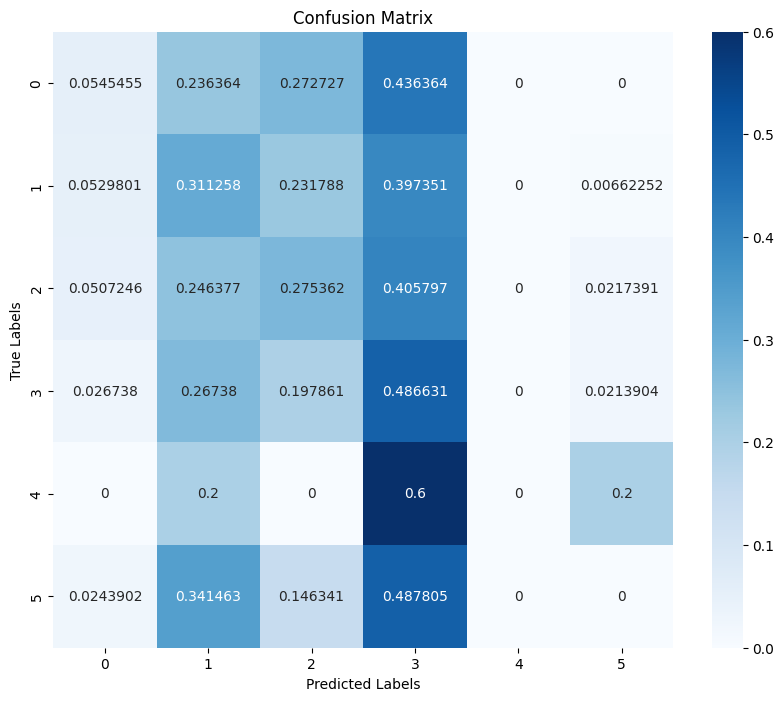

Epoch 11, Validation Loss: 3.3756, Accuracy: 0.3102, F1 Score: 0.2879
Val F1 Score Per Class  [0.07594937 0.30322581 0.28252788 0.41269841 0.         0.        ]


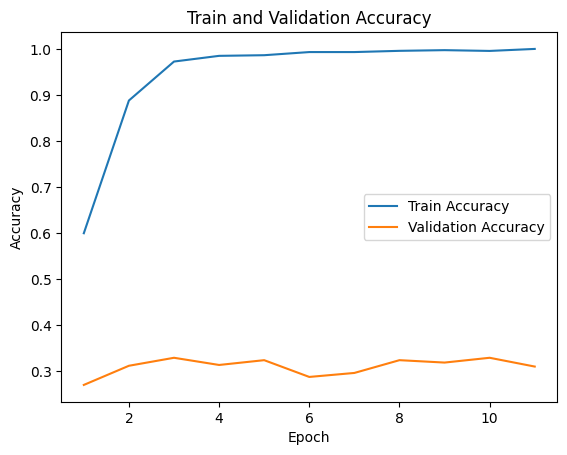

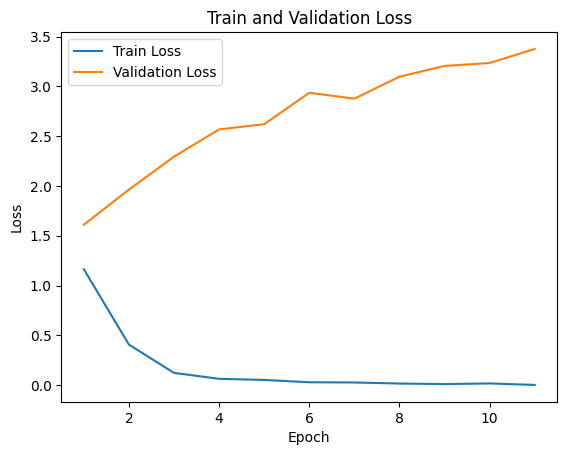

Epoch 12, Train Loss: 0.0057, Accuracy: 0.9989, F1 Score: 0.9989
Train F1 Score Per Class  [0.9994469  0.99775569 0.99882972 0.99732541 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.15it/s, loss=4.57]

[tensor([-3.5552,  1.8447, -2.7598,  3.3491, -3.2202, -3.1612], device='cuda:0'), tensor([-2.2153,  5.3100, -1.6006, -1.1058, -3.4039, -3.4471], device='cuda:0'), tensor([-1.6280, -0.1693, -2.8936,  1.0101, -4.5354, -3.4332], device='cuda:0'), tensor([-1.8798, -1.1168, -3.0710,  5.1864, -3.8627, -2.2395], device='cuda:0'), tensor([-3.4062, -1.8044,  1.6551,  0.0615, -4.2467, -1.6146], device='cuda:0'), tensor([-3.4193,  2.2929, -2.0202,  2.4214, -3.5044, -3.6693], device='cuda:0'), tensor([-2.4976, -0.7559, -2.9029,  2.8100, -3.9546, -0.4378], device='cuda:0'), tensor([-2.6165, -2.9159,  3.8083,  2.0999, -2.9719, -2.3925], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:34,  2.09it/s, loss=3.14]

[tensor([-1.8694,  0.5258, -3.7294,  0.9579, -3.6568, -2.5765], device='cuda:0'), tensor([-3.3816, -0.0063, -3.3041,  0.2532, -2.6675, -1.9446], device='cuda:0'), tensor([-0.3652, -2.0106, -0.3865,  1.7919, -4.2160, -3.5380], device='cuda:0'), tensor([-1.9575, -1.0810, -1.3699,  5.5582, -3.3692, -2.9931], device='cuda:0'), tensor([-1.4210,  6.5579, -1.6973, -1.5879, -2.6759, -2.0755], device='cuda:0'), tensor([-1.1900,  1.6998, -0.6405, -0.8057, -3.9471, -4.6654], device='cuda:0'), tensor([-1.4221, -1.6883, -1.7975,  5.6157, -3.5887, -3.1638], device='cuda:0'), tensor([ 1.8424,  2.7927, -2.8698,  0.1875, -4.0450, -3.7272], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:33,  2.12it/s, loss=3.94]

[tensor([-3.1082, -0.4102,  0.4174, -1.0552, -3.5919, -3.8342], device='cuda:0'), tensor([-1.6568,  0.1712,  3.0370, -1.3717, -2.3400, -2.9722], device='cuda:0'), tensor([-2.8007, -2.3654,  4.1530, -0.8330, -3.1551, -2.3506], device='cuda:0'), tensor([-0.4329, -1.0727, -2.0403,  1.1608, -4.0060, -3.4158], device='cuda:0'), tensor([-1.8574,  0.2215, -2.5907,  4.5915, -2.7283, -3.3103], device='cuda:0'), tensor([-2.0116, -0.0215, -2.4085,  3.9561, -3.8752, -3.7934], device='cuda:0'), tensor([-0.6674, -2.5804, -1.8747,  4.6330, -3.4944, -3.2989], device='cuda:0'), tensor([-0.6763, -0.3087,  0.2582, -2.1524, -3.8538, -3.3750], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.13it/s, loss=3.77]

[tensor([-2.6380, -1.4747, -0.4481,  5.4011, -3.5054, -3.1551], device='cuda:0'), tensor([-3.9654,  0.8269,  2.3303, -1.3669, -3.7375, -2.6753], device='cuda:0'), tensor([-2.5579, -1.3890, -1.5800,  2.8568, -5.0282, -1.2244], device='cuda:0'), tensor([-2.1335, -1.0848,  1.1293, -0.8219, -2.6116, -2.6694], device='cuda:0'), tensor([ 5.5576, -1.9005, -0.5065,  0.0718, -2.9044, -3.7158], device='cuda:0'), tensor([-2.8944, -1.8345, -0.5186,  1.1167, -4.3987, -2.8823], device='cuda:0'), tensor([-1.6530,  5.6482, -1.3451, -1.2878, -3.2373, -3.2117], device='cuda:0'), tensor([-3.5807,  1.0166,  1.2859, -1.6089, -2.7066,  0.3175], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.14it/s, loss=3.33]

[tensor([-2.5865, -1.4429, -1.6929,  5.1154, -3.1395, -3.5617], device='cuda:0'), tensor([-2.6154, -2.3266,  0.4167,  4.2502, -4.0216, -3.8053], device='cuda:0'), tensor([-1.2028, -2.4207,  3.8379, -0.9722, -3.4848, -2.7249], device='cuda:0'), tensor([-2.4155,  3.7251, -2.6915,  1.3483, -3.2124, -3.5914], device='cuda:0'), tensor([-1.9269, -1.6226,  5.7815, -0.7786, -3.2457, -2.7912], device='cuda:0'), tensor([-1.8681,  3.4228, -0.9551, -0.9074, -3.7484, -3.3366], device='cuda:0'), tensor([-3.2141,  0.3320, -0.7690, -1.2533, -4.3517, -2.2441], device='cuda:0'), tensor([-1.6964, -0.7803, -2.7906,  4.8808, -3.4016, -1.8165], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=3.74]

[tensor([-2.0461, -1.6281,  6.4212, -0.8706, -2.8682, -3.4333], device='cuda:0'), tensor([-1.9814, -2.0463,  6.3706, -1.4991, -2.4483, -1.9107], device='cuda:0'), tensor([-1.6772, -1.5665,  2.6737, -1.0108, -3.9935, -4.3318], device='cuda:0'), tensor([-3.6236,  0.0582,  0.0515,  1.6987, -4.0475, -3.6023], device='cuda:0'), tensor([-2.4247, -2.7907,  4.2179, -1.1809, -3.5456, -3.4669], device='cuda:0'), tensor([-0.5862, -1.0720, -2.1793,  0.7084, -4.1933, -3.0425], device='cuda:0'), tensor([-1.0586, -3.5821,  1.3391,  2.9707, -3.7727, -3.3724], device='cuda:0'), tensor([-2.2669, -2.5706, -0.7520,  3.1364, -3.4150, -3.5003], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=3]

[tensor([-2.5572, -0.5796, -0.5829,  1.2961, -4.0684, -2.7373], device='cuda:0'), tensor([-2.5925, -0.0230, -1.0715,  1.6422, -2.7312, -2.5821], device='cuda:0'), tensor([-1.1366, -0.5423,  5.2099, -1.3830, -2.5756, -3.2629], device='cuda:0'), tensor([-3.0987, -2.3541, -0.6854,  3.1909, -4.1169, -2.8588], device='cuda:0'), tensor([-2.9695,  5.6234, -0.9706, -0.9688, -2.6832, -3.7466], device='cuda:0'), tensor([-3.0372,  0.4960, -1.7736,  2.4292, -4.0563, -1.0700], device='cuda:0'), tensor([-2.4521, -3.0797,  5.1995, -1.2440, -3.2152, -0.5437], device='cuda:0'), tensor([-2.7987,  0.0425, -2.5807,  1.7425, -4.9506, -3.0520], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.15it/s, loss=4.82]

[tensor([-1.3163, -1.9315, -0.8734,  0.7299, -3.6763, -3.7289], device='cuda:0'), tensor([-1.9208, -2.0804,  5.0359, -0.5998, -2.7469, -2.5326], device='cuda:0'), tensor([-1.8708,  0.4846, -2.5690,  5.5227, -3.8696, -3.1185], device='cuda:0'), tensor([-2.2504,  5.7681, -2.0706, -0.0609, -3.0036, -3.6980], device='cuda:0'), tensor([-2.9852,  0.4229, -0.2611,  0.3048, -4.0564, -4.1359], device='cuda:0'), tensor([-2.4823,  1.8217, -1.6068,  2.6946, -3.9910, -4.6784], device='cuda:0'), tensor([-3.3938, -2.1305, -1.5683,  0.3152, -4.1513,  1.3517], device='cuda:0'), tensor([-2.2721, -1.7589,  5.8827, -0.9195, -2.2350, -1.8534], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.15it/s, loss=4.28]

[tensor([-2.6487, -1.5807, -1.9997,  3.6256, -3.9813, -1.4185], device='cuda:0'), tensor([-2.9081,  1.6847, -1.0048,  0.9903, -3.8272, -3.8870], device='cuda:0'), tensor([-1.1397,  1.2262, -1.1682,  0.5606, -3.8769, -4.7825], device='cuda:0'), tensor([-1.2367, -2.4740, -0.0515,  2.0300, -3.0721, -2.8818], device='cuda:0'), tensor([-1.8284, -2.3008, -0.5983,  4.9134, -2.7200, -2.7966], device='cuda:0'), tensor([-3.3213,  3.5693, -1.0965,  0.1198, -3.9434, -4.2103], device='cuda:0'), tensor([-3.2768,  0.3376, -2.8766,  4.3360, -3.4909, -2.3378], device='cuda:0'), tensor([-2.3321, -1.7325, -0.7911,  2.7658, -4.0174, -2.8575], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.15it/s, loss=2.16]

[tensor([-2.5955,  2.7320, -1.1575, -1.4229, -3.3804, -4.0473], device='cuda:0'), tensor([-2.8188, -1.8717,  1.3965,  2.5160, -3.6832, -3.4301], device='cuda:0'), tensor([-1.0478,  3.6773, -2.2972, -2.4874, -3.5745, -3.1111], device='cuda:0'), tensor([-2.1221, -1.4812, -0.7163,  4.5918, -3.4756, -4.1467], device='cuda:0'), tensor([-2.3701,  3.5044,  1.4664, -1.2711, -4.0631, -3.7300], device='cuda:0'), tensor([-0.9982, -1.3127,  2.6704,  1.8455, -4.8788, -4.7705], device='cuda:0'), tensor([-2.7023,  3.6693, -2.7692,  0.1295, -3.5541, -3.0012], device='cuda:0'), tensor([-2.5625,  0.9621, -2.0981,  2.1206, -3.5550, -3.8938], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=4.54]

[tensor([-2.8934,  0.8707, -1.6792,  2.3366, -3.0525, -3.7951], device='cuda:0'), tensor([-0.5045,  3.0445, -2.5654, -0.5226, -4.4904, -3.5061], device='cuda:0'), tensor([-2.4231, -2.3719,  0.6995,  4.2667, -4.0922, -1.5849], device='cuda:0'), tensor([-2.2405, -1.7034, -0.4805,  4.5353, -4.4379, -4.1168], device='cuda:0'), tensor([-2.9226,  6.0762, -1.4523, -0.9466, -3.1150, -1.8187], device='cuda:0'), tensor([-2.3498,  1.9642, -2.9416,  1.0385, -4.0991, -2.9535], device='cuda:0'), tensor([-3.4370, -1.3215,  1.1168, -0.5242, -3.1399, -2.7861], device='cuda:0'), tensor([-1.0491, -1.4268, -2.3552,  5.9905, -3.0675, -3.2639], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=2.69]

[tensor([-2.9741, -1.6135,  1.5677,  1.3039, -2.8128, -4.2282], device='cuda:0'), tensor([-3.1532, -0.9727, -0.1774,  2.2459, -3.9231, -3.2599], device='cuda:0'), tensor([-2.8190, -1.5407,  1.0983,  2.6939, -3.3655, -4.1056], device='cuda:0'), tensor([-2.1099,  0.6786, -2.7147,  1.8271, -4.1229, -4.4881], device='cuda:0'), tensor([-0.5061,  1.7405, -2.7299, -1.3677, -2.6670, -3.9983], device='cuda:0'), tensor([-2.3122, -1.2776,  6.1215, -0.3733, -3.0773, -3.0545], device='cuda:0'), tensor([-1.7456, -0.9787, -3.1913,  3.8171, -3.8457, -2.1596], device='cuda:0'), tensor([-2.3353, -0.6101,  1.1068,  0.1616, -3.3716, -3.7542], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.14it/s, loss=1.41]

[tensor([-0.2388,  0.0654, -1.5032, -1.1496, -4.4898, -3.8751], device='cuda:0'), tensor([-3.4588,  1.5080,  0.5674,  1.5400, -3.7159, -3.0801], device='cuda:0'), tensor([-2.9667,  0.3257, -0.9291, -0.3995, -4.7671, -4.0789], device='cuda:0'), tensor([-3.3758, -0.3186,  4.1141, -1.6138, -3.9496, -3.6342], device='cuda:0'), tensor([-3.3472,  3.1170, -1.1865,  1.2782, -4.0321, -3.1107], device='cuda:0'), tensor([-2.6377, -1.3003, -1.1411,  0.1522, -3.7917, -2.9083], device='cuda:0'), tensor([-2.9219,  3.2300, -2.8055,  2.2107, -4.1695, -3.4792], device='cuda:0'), tensor([-2.1138,  3.6913, -1.9409,  1.1158, -4.2591, -4.0833], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=2.67]

[tensor([-0.7649, -0.2261, -2.8948,  0.9553, -3.0663, -3.0951], device='cuda:0'), tensor([-3.1116,  0.1376, -1.9068,  1.5195, -4.4469, -3.8896], device='cuda:0'), tensor([-3.3101, -2.5144, -0.4100,  0.4802, -2.9240, -0.8156], device='cuda:0'), tensor([-2.5302, -0.5498, -2.6183,  2.5598, -4.6279, -3.1482], device='cuda:0'), tensor([-2.9350, -0.6233, -2.2068,  5.4306, -2.9183, -2.2084], device='cuda:0'), tensor([-2.0146, -0.7359, -1.8299,  5.8815, -3.0855, -2.9847], device='cuda:0'), tensor([-2.3568,  3.1701, -3.0005, -1.6572, -3.4591, -2.2089], device='cuda:0'), tensor([-2.3486,  1.4287, -1.9494,  1.4460, -4.2806, -3.2895], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.14it/s, loss=3.61]

[tensor([-3.0211,  3.2274, -1.4483,  1.0007, -3.6243, -3.4284], device='cuda:0'), tensor([-2.2894,  2.2749,  0.5846, -1.5350, -3.5836, -3.5404], device='cuda:0'), tensor([-2.0993, -1.1855,  5.4217, -0.9817, -2.9263, -2.2020], device='cuda:0'), tensor([-1.8289, -1.3727, -2.3295,  5.6053, -3.8283, -3.0924], device='cuda:0'), tensor([-1.7324, -1.0246, -2.0053,  5.7234, -3.2568, -4.0387], device='cuda:0'), tensor([-2.7052,  0.1918, -1.2418, -1.3971, -3.6898, -4.0620], device='cuda:0'), tensor([-3.1596, -2.3267,  2.6375,  2.7365, -4.1469, -2.7476], device='cuda:0'), tensor([-3.1947,  2.8629, -0.7851,  0.8310, -3.9540, -4.9750], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.14it/s, loss=3.04]

[tensor([-1.7829, -1.1151, -1.8934,  6.2481, -3.2604, -2.7941], device='cuda:0'), tensor([-2.5464,  4.8648,  0.0341, -1.5581, -3.7294, -3.4076], device='cuda:0'), tensor([-1.7853, -0.9455, -1.6950,  5.3464, -3.9128, -3.6402], device='cuda:0'), tensor([-3.5815,  0.6688, -0.2651,  1.2168, -3.9454, -2.3346], device='cuda:0'), tensor([-2.3070, -1.9086, -1.4008,  3.6349, -3.4480, -3.5264], device='cuda:0'), tensor([-2.7422, -1.7518,  5.6837, -0.6592, -2.3589, -2.3494], device='cuda:0'), tensor([-2.8811,  0.8215, -1.3469,  4.2527, -4.5281, -3.9684], device='cuda:0'), tensor([-3.1316, -0.9040, -1.2152, -0.4385, -3.2602, -3.0566], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=3.82]

[tensor([-3.0359, -1.9146, -0.9925,  5.4495, -3.2490, -2.5635], device='cuda:0'), tensor([-0.2350, -0.9080,  2.1900, -0.3966, -4.2168, -3.1196], device='cuda:0'), tensor([-2.4167,  1.0347,  2.1785, -1.9807, -3.0678, -3.2518], device='cuda:0'), tensor([-3.6586,  1.4619, -0.1626,  0.3262, -4.3109, -3.8181], device='cuda:0'), tensor([-2.5302, -2.8174, -1.2935,  5.5195, -3.2218, -2.0457], device='cuda:0'), tensor([-1.9285, -1.4831, -1.9190,  3.9972, -4.1760, -3.6664], device='cuda:0'), tensor([ 2.7311, -2.8688, -1.4619, -0.3820, -3.4130, -0.6711], device='cuda:0'), tensor([-1.9762, -0.9429, -3.4407,  2.4427, -2.7332, -2.6326], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=2.64]

[tensor([-2.3992, -2.0511, -0.8403,  5.5150, -4.0466, -3.5029], device='cuda:0'), tensor([-1.2181, -2.1515, -0.8095,  5.0746, -3.2762, -3.9781], device='cuda:0'), tensor([-3.1066,  4.5762, -1.5989, -1.1556, -4.3328, -1.5682], device='cuda:0'), tensor([-3.4835, -1.1242,  1.1535,  1.4041, -4.1398, -3.9242], device='cuda:0'), tensor([-1.9452, -2.4709,  0.1142,  1.2689, -1.8561, -3.7581], device='cuda:0'), tensor([-0.9710, -2.2285, -1.2444,  0.7678, -3.6018, -1.0894], device='cuda:0'), tensor([-1.4569,  1.6019,  0.0392, -1.3184, -4.6648, -4.0351], device='cuda:0'), tensor([-2.4750, -1.6078, -1.2560,  5.6902, -3.5543, -3.1017], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.15it/s, loss=2.01]

[tensor([-1.9013, -2.5894, -1.5243,  0.9641, -3.6572, -3.8236], device='cuda:0'), tensor([ 3.8447, -1.9339, -2.2516, -0.7170, -3.8111, -3.6543], device='cuda:0'), tensor([-1.9768, -1.8834,  6.2648, -0.6498, -2.5316, -2.6531], device='cuda:0'), tensor([-2.4628, -2.0595, -0.7853,  5.3637, -3.2483, -3.0150], device='cuda:0'), tensor([-1.3246,  2.5161, -1.5088, -0.4448, -4.6427, -4.4270], device='cuda:0'), tensor([-1.2852,  2.0434, -3.0359,  2.5576, -3.5228, -3.7357], device='cuda:0'), tensor([-1.9069,  3.8165, -2.6286,  0.9658, -3.8182, -2.8216], device='cuda:0'), tensor([-1.7881, -0.4139,  1.3205, -1.5432, -4.3787, -3.3962], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=3.43]

[tensor([-2.8291, -2.4301,  0.2871,  3.6113, -3.5662, -3.1593], device='cuda:0'), tensor([-3.4980,  2.0284, -3.5891,  0.8674, -3.3353, -1.5896], device='cuda:0'), tensor([-1.8328, -2.2570,  0.1118,  2.1433, -3.4194, -1.9159], device='cuda:0'), tensor([-0.5952, -3.3879, -0.5491,  1.2184, -4.2073, -3.4000], device='cuda:0'), tensor([-0.1370,  1.8893, -0.9385, -1.1184, -4.5075, -4.3454], device='cuda:0'), tensor([-2.9390,  1.0487, -0.6854,  1.8339, -4.2346, -3.1580], device='cuda:0'), tensor([-2.6122, -0.8361,  0.3274,  0.1729, -4.3116, -4.4840], device='cuda:0'), tensor([-3.0970, -1.3960,  3.9596,  0.2774, -3.6437, -3.8947], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.16it/s, loss=4.79]

[tensor([-0.6451, -2.8264,  5.3939, -1.3490, -2.7608, -1.9241], device='cuda:0'), tensor([-2.2116,  5.9440, -2.4683, -0.2683, -2.8563, -2.7580], device='cuda:0'), tensor([-3.6859,  0.5280,  3.6669, -1.8952, -3.6091, -2.9044], device='cuda:0'), tensor([-2.6988, -1.0576,  3.2079, -0.6197, -3.9511, -4.4206], device='cuda:0'), tensor([-2.7623, -2.5047,  1.9176,  3.2958, -4.6205, -4.0792], device='cuda:0'), tensor([-0.7709, -0.6266, -1.2841, -0.5284, -4.1560, -3.3033], device='cuda:0'), tensor([-1.8662, -1.7384, -1.9642,  6.2782, -2.8879, -2.6435], device='cuda:0'), tensor([-1.8014, -1.5362, -1.4761,  5.0772, -2.4920, -1.5076], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.16it/s, loss=2.48]

[tensor([-2.8124,  2.4665, -1.8794,  1.7767, -3.9489, -3.3699], device='cuda:0'), tensor([-2.3899,  1.7106, -1.8174,  1.5750, -2.4089, -3.3605], device='cuda:0'), tensor([-2.7306, -1.1620, -1.1398,  5.9054, -3.6883, -3.0375], device='cuda:0'), tensor([-2.3843, -1.5433, -1.5208,  3.5061, -2.7426, -1.9479], device='cuda:0'), tensor([-1.5398, -0.4083, -0.2078,  1.1044, -3.8171, -4.1483], device='cuda:0'), tensor([-1.2783, -2.9872,  2.0540,  3.9059, -3.3189, -3.9158], device='cuda:0'), tensor([-2.8158, -0.6065, -1.5244,  0.1022, -4.1072, -3.5861], device='cuda:0'), tensor([-3.1464, -1.0826,  1.5421,  3.0431, -3.5333, -3.7422], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.17it/s, loss=2.7]

[tensor([-1.1283, -0.2291, -2.6778, -0.8218, -2.3841, -3.0189], device='cuda:0'), tensor([-1.9644, -1.4608, -1.9191,  6.1648, -3.0794, -2.5982], device='cuda:0'), tensor([-1.9812, -0.6127, -2.3009,  4.6708, -2.0226, -2.6905], device='cuda:0'), tensor([-3.4520, -0.6476, -2.2913,  3.3570, -4.9676, -3.7478], device='cuda:0'), tensor([-2.4395, -0.7208, -1.5113,  1.8529, -3.8573, -3.3429], device='cuda:0'), tensor([-1.5985, -1.4762, -2.1801,  6.1893, -2.2576, -2.5706], device='cuda:0'), tensor([-1.6097, -2.5298,  0.5993,  1.4136, -3.8835, -3.6377], device='cuda:0'), tensor([-2.2824, -2.6819,  5.8941, -1.2852, -2.8627, -2.5162], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=2.66]

[tensor([-1.5059, -0.3947, -2.7365,  1.3546, -3.1149, -2.2919], device='cuda:0'), tensor([-2.5905, -1.7524, -1.6675,  3.2383, -2.6894, -2.6190], device='cuda:0'), tensor([-1.7640, -1.7630, -1.5249,  6.0906, -2.8757, -2.9904], device='cuda:0'), tensor([-1.6180, -1.9258,  1.6627, -1.5727, -2.6137, -3.9249], device='cuda:0'), tensor([-2.8854,  5.2863,  0.1128, -1.5649, -2.8618, -3.6809], device='cuda:0'), tensor([-1.1372,  2.9599, -1.7815, -0.8828, -3.0792, -4.1031], device='cuda:0'), tensor([-2.8523, -0.8255, -2.5963,  5.5571, -2.6175, -1.6860], device='cuda:0'), tensor([-2.1646, -0.5118, -2.1384,  1.6440, -5.4142, -3.2210], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=4.33]

[tensor([-2.9327, -0.3471,  0.9216,  3.0754, -5.0188, -2.5902], device='cuda:0'), tensor([-1.9818,  3.8853, -2.5620,  0.7490, -3.9007, -3.0209], device='cuda:0'), tensor([-2.3688,  4.9993, -1.7736,  0.3235, -3.6528, -3.4475], device='cuda:0'), tensor([-2.1328, -2.5657,  2.1831,  0.5130, -2.8036, -4.3994], device='cuda:0'), tensor([-1.8576,  0.3074, -1.5910,  1.6755, -4.5436, -4.3319], device='cuda:0'), tensor([-1.8900,  4.0634, -1.0895, -1.7221, -3.1059, -2.7327], device='cuda:0'), tensor([-2.8696,  4.8331, -2.3451, -1.3473, -5.1639, -2.0947], device='cuda:0'), tensor([-2.9045,  0.9276, -2.9770,  4.0110, -4.4576, -1.6619], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.16it/s, loss=3.17]

[tensor([-1.0187,  5.7638, -2.9055, -0.9802, -2.9068, -1.8069], device='cuda:0'), tensor([-2.6693, -1.3193,  4.9962, -2.0079, -3.4758, -2.8280], device='cuda:0'), tensor([-3.1175,  2.1213,  0.3780,  0.0141, -3.8861, -4.0161], device='cuda:0'), tensor([-1.5119, -1.2951,  1.0561, -0.3515, -4.1145, -4.6967], device='cuda:0'), tensor([-2.1469,  1.4927, -2.7852,  3.7837, -3.1884, -3.7925], device='cuda:0'), tensor([-2.6214, -0.3688, -1.7019,  1.6065, -2.0524, -2.2820], device='cuda:0'), tensor([-1.0716, -3.3712,  1.0737,  1.7040, -4.0904, -3.7913], device='cuda:0'), tensor([-1.3080, -3.4931,  0.9653,  0.7059, -3.4497, -3.0859], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=3.11]

[tensor([-2.2519,  0.2611, -3.4374,  2.4867, -3.7051, -1.3090], device='cuda:0'), tensor([-2.0427,  6.0058, -0.1373, -1.3471, -2.9921, -3.2782], device='cuda:0'), tensor([-2.1982, -0.9247, -0.3499,  0.9953, -4.2759, -2.2894], device='cuda:0'), tensor([-2.4183, -1.2792, -1.7178,  4.7498, -2.5105, -2.5886], device='cuda:0'), tensor([-1.2798, -0.4636, -2.7276,  2.8153, -2.6874, -2.7505], device='cuda:0'), tensor([-2.7718,  4.3048, -0.9884,  1.6641, -4.0362, -4.3957], device='cuda:0'), tensor([-3.1669, -1.1904,  3.5785, -1.0975, -3.1595, -3.6346], device='cuda:0'), tensor([-3.0000,  1.9143, -2.3944,  1.4612, -3.7280, -3.1042], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.17it/s, loss=3.94]

[tensor([-1.2323, -0.3782,  4.6262, -1.4514, -2.6618, -3.5312], device='cuda:0'), tensor([-2.0293, -2.6292,  4.5637,  1.0803, -3.3166, -2.7581], device='cuda:0'), tensor([-1.0798, -0.2055, -1.0529,  0.9307, -5.0040, -3.9164], device='cuda:0'), tensor([-2.3362, -2.1628, -0.7573,  2.7498, -4.1199, -2.8358], device='cuda:0'), tensor([-2.0827, -1.3950,  6.3410, -1.2949, -2.4031, -2.5348], device='cuda:0'), tensor([-2.4624,  3.9288, -2.6727, -0.6664, -2.2545, -2.7133], device='cuda:0'), tensor([-2.0897, -2.0628,  1.6750,  1.4829, -3.7363, -2.0742], device='cuda:0'), tensor([-0.8792, -1.8968,  4.7096, -0.9986, -2.6476, -3.0663], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.17it/s, loss=4.74]

[tensor([ 5.1356, -1.4138, -1.4192, -0.9991, -2.9589, -1.7222], device='cuda:0'), tensor([-3.2081, -0.4667,  1.3756, -1.6399, -3.2284, -3.2463], device='cuda:0'), tensor([-1.8218,  3.2857, -3.2165,  1.0524, -2.1152, -3.5767], device='cuda:0'), tensor([-1.4525, -1.2517,  3.1844, -0.5773, -3.1057, -2.4539], device='cuda:0'), tensor([-1.8789,  4.9581, -2.2298,  1.1167, -3.5147, -3.4721], device='cuda:0'), tensor([-2.1842, -1.9825,  6.0206, -0.7122, -2.8327, -1.9856], device='cuda:0'), tensor([-1.9179, -2.1235,  5.5831, -0.7318, -3.0803, -2.3602], device='cuda:0'), tensor([-3.6146,  4.3748, -1.0326, -0.4833, -2.6424, -2.7942], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.17it/s, loss=4.7]

[tensor([-2.6418,  4.7152, -1.6821, -0.6934, -4.1427, -3.9326], device='cuda:0'), tensor([-2.1861, -2.2763,  1.6504,  0.9122, -4.0445, -3.7166], device='cuda:0'), tensor([-3.7844, -0.5076, -1.0339,  0.5819, -4.6140, -1.4715], device='cuda:0'), tensor([-3.0170,  3.3860, -1.3273, -0.1054, -2.9818, -1.4946], device='cuda:0'), tensor([-1.4362, -0.6839, -2.3003,  5.1149, -2.6478, -3.6399], device='cuda:0'), tensor([-1.6264, -2.0355,  2.9358, -0.4562, -3.8508, -4.0599], device='cuda:0'), tensor([-1.0050, -2.5937, -0.4575,  4.2553, -2.6758, -1.8826], device='cuda:0'), tensor([ 5.1948, -0.1585, -2.8021, -0.2379, -3.2191, -2.0218], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.17it/s, loss=2.54]

[tensor([-2.5624, -2.8080,  0.2484,  4.0585, -3.3417, -2.3427], device='cuda:0'), tensor([-1.2729,  0.2428, -1.9829, -0.9655, -4.8791, -3.9380], device='cuda:0'), tensor([-2.0361, -2.2610,  5.3156,  0.7316, -3.7987, -2.9017], device='cuda:0'), tensor([ 0.8865, -2.4308,  0.5105,  2.0364, -4.3979, -4.5149], device='cuda:0'), tensor([-1.9872, -1.0963,  1.4553,  0.1684, -4.1494, -4.8414], device='cuda:0'), tensor([-2.0562, -1.0331, -2.9902,  1.5343, -2.8691,  0.1224], device='cuda:0'), tensor([-0.4989,  2.7453, -3.1524, -0.9987, -2.8017, -3.4124], device='cuda:0'), tensor([-2.3776, -1.6031, -1.2433,  4.4612, -3.6888, -4.7242], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.17it/s, loss=2.86]

[tensor([-2.9444,  0.7973,  3.2461, -2.4371, -3.4517, -1.4898], device='cuda:0'), tensor([-2.1163, -1.1176,  2.9706,  1.0926, -4.3537, -4.9703], device='cuda:0'), tensor([-2.1811, -2.2589, -1.5918,  4.3395, -4.7265, -3.8368], device='cuda:0'), tensor([-2.4282, -2.3121,  2.8517,  1.7236, -3.3168, -3.4935], device='cuda:0'), tensor([-3.5564, -1.7307,  0.5926,  0.8686, -2.9251, -2.5613], device='cuda:0'), tensor([-2.1373,  6.4882, -1.1848, -1.6004, -2.6867, -2.0556], device='cuda:0'), tensor([-1.7145, -1.2633, -1.5492, -1.0926, -2.2922,  7.2437], device='cuda:0'), tensor([-2.6208, -1.8562,  1.0679, -0.2587, -2.1404, -4.0059], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.17it/s, loss=5.17]

[tensor([-2.7159, -0.6988,  3.5553,  0.1756, -4.0714, -3.1830], device='cuda:0'), tensor([-1.7385,  3.9988, -2.6849, -0.3755, -2.4897, -3.8590], device='cuda:0'), tensor([-2.3442,  4.1958, -0.9915, -0.9319, -4.4451, -4.0517], device='cuda:0'), tensor([-2.9588, -0.3258, -3.3131,  1.3063, -3.3556,  0.9121], device='cuda:0'), tensor([-3.0126, -1.6322, -1.4952,  2.4914, -2.9461, -4.0406], device='cuda:0'), tensor([-3.4752, -0.6039,  3.4433,  0.0730, -3.2528, -3.7985], device='cuda:0'), tensor([-2.5293, -2.0188, -0.2603,  3.8529, -3.0203, -3.2135], device='cuda:0'), tensor([-0.3535, -1.8191, -2.0236,  3.9984, -3.5515, -3.3812], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.18it/s, loss=3.79]

[tensor([-2.5447,  0.8385,  5.2010, -1.2167, -3.7651, -3.3809], device='cuda:0'), tensor([-2.6097, -2.1189, -0.2234,  1.4138, -3.3556, -3.8405], device='cuda:0'), tensor([-2.1053, -1.3743,  5.6501, -1.5627, -3.0485, -3.6434], device='cuda:0'), tensor([-1.5910, -3.0902,  4.2543, -0.2850, -3.8064, -3.0279], device='cuda:0'), tensor([-1.1937, -0.8542, -2.6314,  5.2361, -3.6040, -3.1399], device='cuda:0'), tensor([-2.4222, -1.3332,  6.3944, -1.2500, -2.2576, -2.2752], device='cuda:0'), tensor([ 5.9805, -1.5839, -2.0654, -0.0717, -2.8542, -2.2122], device='cuda:0'), tensor([-3.1011, -0.1469, -0.7769,  3.0392, -4.2324, -4.3452], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.18it/s, loss=3.44]

[tensor([-1.5040, -1.5037, -1.9828,  6.0239, -2.6337, -3.6114], device='cuda:0'), tensor([-3.1032,  0.3518,  2.1118, -1.8392, -3.4990, -1.4593], device='cuda:0'), tensor([-0.0180,  0.1068, -2.9636,  1.7403, -4.3809, -4.1624], device='cuda:0'), tensor([-0.8493, -2.8908, -0.5228,  0.6721, -4.0594, -3.7089], device='cuda:0'), tensor([-1.7575, -1.5856,  1.3433, -1.2978, -2.7026, -2.4972], device='cuda:0'), tensor([-2.0262, -1.9125, -1.4857,  5.1587, -3.5850, -1.7525], device='cuda:0'), tensor([-0.3697, -1.0712, -1.7591,  4.2644, -4.2294, -3.9133], device='cuda:0'), tensor([-3.7609,  2.6027, -2.2515,  1.2987, -4.3046, -2.5764], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.18it/s, loss=2.13]

[tensor([-2.9927, -0.5754, -2.4161,  1.9914, -3.6915, -3.5758], device='cuda:0'), tensor([ 0.0402, -2.2423, -1.9635,  1.0193, -4.2486, -3.6118], device='cuda:0'), tensor([-2.9579,  1.6844, -2.2008,  0.8387, -2.9767, -3.5160], device='cuda:0'), tensor([-3.0411,  1.9033, -0.4043, -0.0968, -3.6047, -3.7805], device='cuda:0'), tensor([-1.5140, -2.4503, -1.0386,  3.8894, -3.5536, -3.8588], device='cuda:0'), tensor([-2.8678,  4.3876, -0.2619, -1.1481, -2.3443, -4.2930], device='cuda:0'), tensor([-2.9581,  2.4187,  0.2185, -1.7275, -4.5486, -3.3427], device='cuda:0'), tensor([-3.1138,  0.3017, -1.4603, -0.8905, -3.2613, -3.9869], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.17it/s, loss=4.23]

[tensor([-1.6044, -1.2546, -2.0411,  5.3825, -3.9199, -3.4610], device='cuda:0'), tensor([-2.9594,  3.2493, -2.2784,  2.0330, -2.5425, -3.0425], device='cuda:0'), tensor([-1.6485, -1.6004, -1.7437,  4.5773, -4.5366, -3.3514], device='cuda:0'), tensor([-2.7230, -0.4333,  4.9838, -1.5998, -3.4395, -4.0196], device='cuda:0'), tensor([-2.4611,  2.8958, -1.7276, -1.0498, -2.9819, -2.4407], device='cuda:0'), tensor([-2.6375,  1.1495, -0.9658, -1.3722, -2.7633, -2.9186], device='cuda:0'), tensor([-2.6512,  2.5884,  1.3138,  0.1614, -4.6954, -5.0147], device='cuda:0'), tensor([-2.6569, -0.1698, -2.8733,  4.9176, -3.9628, -2.8583], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.17it/s, loss=4.15]

[tensor([-2.2219, -0.5436, -2.7955,  5.5122, -3.4209, -2.0030], device='cuda:0'), tensor([-2.5209, -1.8025,  4.5562, -0.1410, -2.0903, -2.4463], device='cuda:0'), tensor([-2.3470, -1.2187, -0.4479,  4.3999, -3.3425, -4.2549], device='cuda:0'), tensor([-1.6984, -1.5283,  4.6624, -1.6722, -3.3367, -3.1799], device='cuda:0'), tensor([-2.0002, -2.0591,  5.2622, -0.9207, -3.4799, -1.4030], device='cuda:0'), tensor([-1.2549, -2.4809,  0.9713,  1.9694, -3.4111, -3.6824], device='cuda:0'), tensor([-2.6867, -0.8433, -2.1291,  0.3608, -2.8385, -2.0561], device='cuda:0'), tensor([-2.5251,  4.3573,  0.2685, -0.9928, -3.3487, -3.8428], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.16it/s, loss=4.57]

[tensor([-1.5934,  4.7474, -0.7286, -1.2570, -3.6740, -3.7653], device='cuda:0'), tensor([-2.4018, -1.1561, -2.4719,  4.3732, -2.3038, -0.7627], device='cuda:0'), tensor([ 0.8450, -0.3573, -2.7287, -0.8752, -3.4495, -3.7496], device='cuda:0'), tensor([-2.4857,  5.4500, -1.4923,  0.5065, -3.1780, -3.5990], device='cuda:0'), tensor([-2.2109,  1.7336, -1.2994,  1.5560, -4.2329, -4.5696], device='cuda:0'), tensor([-1.4955, -2.9632,  5.4442, -0.5971, -2.9922, -2.7371], device='cuda:0'), tensor([-1.8753, -0.5364, -2.5099,  4.1102, -2.1056, -4.1115], device='cuda:0'), tensor([-3.0415, -1.4373,  4.9475, -0.0811, -3.3846, -3.3585], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=3.9]

[tensor([-2.9745,  1.3517, -0.8059,  0.6255, -4.2932, -4.3397], device='cuda:0'), tensor([-2.9767, -1.5152, -1.3189,  5.0719, -3.8316, -3.1989], device='cuda:0'), tensor([-3.4079,  0.5473, -2.0221,  2.4678, -3.0064, -3.1759], device='cuda:0'), tensor([-1.3791, -2.0266,  6.5728, -2.1185, -1.9687, -1.8878], device='cuda:0'), tensor([-1.6514,  1.0311, -2.9862,  2.8700, -1.5805, -3.8937], device='cuda:0'), tensor([-2.4196, -2.0655,  5.7784, -1.8892, -2.8547, -1.5073], device='cuda:0'), tensor([-2.9585, -2.6756, -0.3716,  3.9554, -3.9951, -2.8098], device='cuda:0'), tensor([-1.5611, -2.4371,  1.5964,  1.0075, -2.0069, -3.0955], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.17it/s, loss=2.98]

[tensor([-2.3400, -0.2096, -2.4469,  5.6313, -2.5998, -3.3237], device='cuda:0'), tensor([-1.4590, -1.6880, -2.2804,  6.2092, -3.6072, -2.8500], device='cuda:0'), tensor([-2.2852, -1.3957, -0.8731,  4.3879, -3.6828, -2.8829], device='cuda:0'), tensor([-0.5276, -1.0450, -3.2722,  3.0142, -3.7474, -2.5890], device='cuda:0'), tensor([-2.7459,  0.3905, -0.2508,  1.0004, -3.5024, -4.0370], device='cuda:0'), tensor([-2.3676, -2.1848,  1.9643,  0.2526, -2.8749, -3.3132], device='cuda:0'), tensor([-1.2877, -0.2368, -1.7120,  0.4378, -3.5539, -3.3204], device='cuda:0'), tensor([-0.9257, -2.1375,  5.7637, -0.9862, -2.5346, -2.3961], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=4.58]

[tensor([-3.2739,  1.0856, -2.0525,  0.7975, -3.9532, -2.0686], device='cuda:0'), tensor([-1.4585, -1.1105, -2.2289,  5.4785, -3.0857, -3.8288], device='cuda:0'), tensor([ 6.8312, -1.5282, -1.6596, -0.9272, -2.4361, -1.2277], device='cuda:0'), tensor([-2.1874,  5.4800, -2.5779, -0.0241, -2.4148, -2.7068], device='cuda:0'), tensor([-1.5011, -1.3943, -3.0396,  5.6119, -3.5623, -2.4084], device='cuda:0'), tensor([-1.5138, -0.3401, -2.3866,  4.0398, -4.7419, -3.8819], device='cuda:0'), tensor([-0.4543,  1.7358, -2.4102,  3.0603, -4.0816, -4.4005], device='cuda:0'), tensor([-1.4110,  4.5534, -1.9074, -1.3834, -3.5127, -1.4309], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:19<00:13,  2.16it/s, loss=2.69]

[tensor([-3.0434,  3.8738, -2.3361,  1.2765, -3.8354, -3.1835], device='cuda:0'), tensor([-3.4226, -2.0973, -0.8517,  0.6970, -2.5709, -2.3452], device='cuda:0'), tensor([-3.5156, -2.1279,  0.2377,  3.0475, -4.0359, -3.2192], device='cuda:0'), tensor([-2.0614, -1.5218, -1.6989,  5.8994, -4.1186, -2.6704], device='cuda:0'), tensor([-3.0647,  1.6023,  2.5614, -0.3611, -3.8201, -3.9070], device='cuda:0'), tensor([-2.8661, -1.4803, -2.4136,  5.6509, -3.9371, -3.1831], device='cuda:0'), tensor([-1.4354, -2.6458, -0.9935,  3.8862, -3.9562, -4.2860], device='cuda:0'), tensor([-1.5836, -1.4496, -1.8935,  3.5497, -3.6323, -4.2759], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.11it/s, loss=2.87]

[tensor([-2.1311, -1.2464, -0.9455,  3.9984, -3.2927, -3.9717], device='cuda:0'), tensor([ 0.0585, -2.0130, -0.4302, -0.3150, -2.3444, -3.3976], device='cuda:0'), tensor([-3.6185, -1.2982, -1.7499,  4.2917, -4.0893, -3.2649], device='cuda:0'), tensor([-3.0978,  0.9590, -1.8577,  0.9108, -3.9938, -3.4802], device='cuda:0'), tensor([-2.3250, -2.4432,  1.0309,  2.2569, -2.3366, -2.0087], device='cuda:0'), tensor([-3.9577,  0.0639,  2.2429,  0.7063, -3.8942, -3.7326], device='cuda:0'), tensor([ 0.0692, -1.9601,  2.3882,  0.5643, -4.1881, -2.8995], device='cuda:0'), tensor([-2.0090,  2.1348, -2.3039,  0.3562, -2.5862, -0.0623], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.11it/s, loss=3.92]

[tensor([ 5.5967, -0.3831, -2.1102, -1.5116, -3.5934, -1.7741], device='cuda:0'), tensor([-2.1893,  0.5647, -3.2801,  3.5769, -2.6112, -2.9814], device='cuda:0'), tensor([-2.2755,  3.5932, -2.5188, -0.0287, -2.8445, -2.5470], device='cuda:0'), tensor([-2.1260, -0.8781, -1.7294, -0.4846, -3.6445, -3.7559], device='cuda:0'), tensor([-1.9508, -2.1387,  6.0406, -0.4525, -2.6979, -2.2758], device='cuda:0'), tensor([-1.5649, -1.5293, -2.3741, -1.0571, -2.4621,  6.8413], device='cuda:0'), tensor([-3.0623,  3.7396, -0.3899, -0.3604, -3.6693, -3.2070], device='cuda:0'), tensor([-2.4875, -0.4348, -2.8381,  0.2133, -3.8204, -2.7459], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.12it/s, loss=2.52]

[tensor([-2.1781, -0.4562,  2.0037, -1.2917, -3.9096, -3.7378], device='cuda:0'), tensor([-1.6739,  0.6309, -1.4303,  1.7637, -2.1602, -2.8715], device='cuda:0'), tensor([-2.8385, -0.0500, -2.5126,  5.2447, -3.4941, -3.6876], device='cuda:0'), tensor([-2.0653, -2.7253,  5.8762, -1.0091, -3.0853, -2.0581], device='cuda:0'), tensor([-3.1718, -0.6047, -2.4602,  4.7679, -2.9486, -1.9368], device='cuda:0'), tensor([-2.5219,  4.9424, -2.7133,  0.1370, -3.4170, -3.7342], device='cuda:0'), tensor([-2.1854, -1.4640,  0.0069,  1.1196, -4.1599, -3.7455], device='cuda:0'), tensor([-2.1027, -1.9073,  5.2036, -0.6011, -2.4659, -2.9324], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.11it/s, loss=2.87]

[tensor([ 2.1674, -0.5545, -3.6621,  0.5558, -2.9003, -2.6075], device='cuda:0'), tensor([-2.2798, -0.9806, -0.0156,  2.0766, -4.9743, -3.5114], device='cuda:0'), tensor([-2.5427, -2.0849, -0.9343,  4.1044, -3.0930, -2.4691], device='cuda:0'), tensor([-2.2584,  3.3247,  2.1714, -1.7603, -3.5383, -3.8476], device='cuda:0'), tensor([-2.5911,  0.2106,  2.0213,  0.8017, -4.1502, -4.6644], device='cuda:0'), tensor([-0.3666, -0.5608, -3.2618,  1.1327, -3.7371, -3.4181], device='cuda:0'), tensor([-1.1812, -1.4236, -1.3809,  1.5471, -1.7974, -3.7942], device='cuda:0'), tensor([-1.9832,  0.1632, -1.8375,  4.5454, -3.6167, -3.6591], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.10it/s, loss=2.77]

[tensor([-1.6046, -1.9872,  6.6650, -1.7894, -2.5415, -1.6122], device='cuda:0'), tensor([-2.3421,  1.7166, -2.3452,  1.1631, -4.0727, -3.3799], device='cuda:0'), tensor([-2.0496,  6.3870, -1.3723, -1.4722, -2.8853, -2.3799], device='cuda:0'), tensor([-2.3390,  5.1295, -1.8263,  0.0478, -3.8942, -3.8227], device='cuda:0'), tensor([-1.4434, -1.3276, -3.1638,  4.6161, -3.2930, -2.9670], device='cuda:0'), tensor([-0.4156,  1.2321, -3.4750, -0.0525, -2.9982, -1.6058], device='cuda:0'), tensor([-2.3396, -1.4872, -0.3996,  3.2174, -4.3258, -4.2708], device='cuda:0'), tensor([-2.5244, -1.1676, -1.1111,  5.7623, -3.5122, -2.7355], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.10it/s, loss=3.75]

[tensor([-2.8660, -0.9688,  4.5869,  0.5682, -3.1638, -3.6784], device='cuda:0'), tensor([-1.0510,  3.3422, -2.1222,  0.1333, -3.3923, -4.1666], device='cuda:0'), tensor([-3.3883, -0.2500,  3.8582, -1.0227, -2.7799, -2.2567], device='cuda:0'), tensor([-1.5008, -1.7090,  5.5940, -1.0468, -3.4784, -2.4388], device='cuda:0'), tensor([-2.6067,  2.8326,  2.3550, -2.7210, -3.1233, -2.7881], device='cuda:0'), tensor([ 1.7850, -2.6225, -1.0877,  0.7524, -3.7403, -4.0016], device='cuda:0'), tensor([-2.6487,  1.4781, -1.3867, -0.8875, -4.9232, -1.7682], device='cuda:0'), tensor([-2.2752, -2.0086, -1.0868,  5.8101, -3.3842, -2.7758], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.11it/s, loss=3.48]

[tensor([-1.2060, -1.5669, -0.7532,  0.7142, -3.8646, -3.3824], device='cuda:0'), tensor([-2.8515,  0.3196, -1.6862,  3.1953, -4.3062, -3.6415], device='cuda:0'), tensor([-3.2955,  0.4277,  1.3032,  1.9079, -3.4240, -3.2369], device='cuda:0'), tensor([-2.3579,  1.4149, -0.5929, -0.1137, -5.3592, -3.6642], device='cuda:0'), tensor([-1.6123, -1.7946,  6.1938, -1.2148, -3.3497, -2.6234], device='cuda:0'), tensor([-1.8980, -1.6786, -1.9905,  6.2496, -2.5995, -2.0420], device='cuda:0'), tensor([-2.8000, -0.7828, -0.3560,  5.0269, -3.7520, -2.1997], device='cuda:0'), tensor([-2.3009, -0.7998, -1.5499,  3.4132, -4.2356, -4.4641], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.11it/s, loss=1.98]

[tensor([-2.2177, -1.9529,  2.7452,  0.8870, -3.8251, -3.6790], device='cuda:0'), tensor([-2.0169, -1.4961, -2.6797,  5.9868, -3.7099, -2.1513], device='cuda:0'), tensor([-3.1456,  0.0791,  3.5940, -1.5917, -3.0234, -1.2392], device='cuda:0'), tensor([-2.3797, -0.8456, -1.7258,  5.6620, -3.3556, -2.8295], device='cuda:0'), tensor([-2.7111,  1.9346,  0.3447,  0.1381, -3.9248, -3.5123], device='cuda:0'), tensor([-0.1534, -1.2265, -3.2696,  5.1116, -2.9328, -2.3020], device='cuda:0'), tensor([-1.3212, -1.8509, -0.9533,  5.2316, -3.6971, -3.5941], device='cuda:0'), tensor([-1.3351,  3.3420, -1.7011, -2.4624, -3.4172, -0.1233], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.12it/s, loss=2.67]

[tensor([-3.3206, -0.9483, -1.1685,  2.3051, -4.2895, -1.9102], device='cuda:0'), tensor([-0.4810, -2.6782,  0.9151,  4.7244, -3.5105, -4.4841], device='cuda:0'), tensor([-1.4639,  2.2167, -2.8381, -0.0823, -1.4563, -4.4865], device='cuda:0'), tensor([-2.7152,  0.5740, -2.5476,  0.4218, -3.4134, -2.6324], device='cuda:0'), tensor([-3.0154, -2.4365,  0.1793,  1.3623, -4.2147, -0.7526], device='cuda:0'), tensor([-2.3013,  6.0117, -2.5746, -1.4872, -1.9337, -2.1388], device='cuda:0'), tensor([ 3.8101, -2.9747,  1.5034, -1.1037, -2.9301, -2.3733], device='cuda:0'), tensor([-2.3072,  5.4056, -1.4698, -1.0922, -3.7487, -2.7958], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.13it/s, loss=2.69]

[tensor([-1.7715,  0.3410, -3.0918,  4.5317, -3.1815, -3.2955], device='cuda:0'), tensor([-1.4322, -1.5703, -0.7982,  3.5999, -3.0657, -3.8198], device='cuda:0'), tensor([-3.5232, -2.0922,  0.4067,  1.6503, -4.6708,  0.0177], device='cuda:0'), tensor([-2.1030,  3.6752, -1.7109,  0.4259, -4.1902, -4.3761], device='cuda:0'), tensor([ 4.1826, -1.5381,  0.1598, -1.9245, -3.0177, -2.2953], device='cuda:0'), tensor([-1.7100, -1.5502, -2.0440,  0.4150, -4.7528, -4.9849], device='cuda:0'), tensor([-2.0468, -1.5395,  0.8611,  4.6457, -4.7034, -4.3518], device='cuda:0'), tensor([-3.0572, -2.5057,  0.2094,  1.5363, -3.5931, -4.5014], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.14it/s, loss=2.85]

[tensor([-2.9010, -2.3387, -0.5222,  3.2210, -3.5485, -2.7202], device='cuda:0'), tensor([-1.1383, -1.2396, -1.5429,  3.9911, -4.3382, -3.7970], device='cuda:0'), tensor([-2.2420, -1.6304,  1.1728,  1.5438, -4.5070, -3.1971], device='cuda:0'), tensor([-1.7496, -1.8445, -1.3172,  6.0840, -3.3853, -2.2938], device='cuda:0'), tensor([-2.3901, -2.0697, -1.3127,  5.8516, -3.5746, -3.0214], device='cuda:0'), tensor([-2.0258, -0.5537, -3.7765,  1.6084, -3.0485, -1.2047], device='cuda:0'), tensor([-1.9462,  5.1872,  0.1661, -1.7957, -3.0854, -3.6990], device='cuda:0'), tensor([-3.7423,  0.9844, -1.2010, -1.3176, -4.5507,  1.9671], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.14it/s, loss=3.66]

[tensor([-1.8668, -2.2388,  6.4221, -1.0261, -2.2132, -2.0440], device='cuda:0'), tensor([ 0.4464,  1.5918, -1.0388, -1.0178, -3.9930, -4.7713], device='cuda:0'), tensor([-0.2686, -1.0058,  1.0534, -1.4892, -3.6260, -4.4297], device='cuda:0'), tensor([-2.3423,  1.2001, -3.0951,  0.3984, -4.2302, -2.9818], device='cuda:0'), tensor([-1.9545,  5.0725, -1.8873, -1.0292, -2.2331, -2.6165], device='cuda:0'), tensor([-0.8461, -1.7558,  4.1322, -1.5158, -3.1436, -3.0198], device='cuda:0'), tensor([-2.5137, -2.6950, -0.5173,  1.4144, -3.0383, -2.6318], device='cuda:0'), tensor([-1.3747,  5.7473, -1.9150, -1.0901, -3.4827, -3.3505], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=3.7]

[tensor([-2.7421, -1.1656,  4.6365, -0.2562, -3.4447, -2.8050], device='cuda:0'), tensor([-2.4335,  1.3795, -2.5873,  2.8928, -2.1109, -3.4732], device='cuda:0'), tensor([-3.0079, -2.4368,  2.8220,  0.6690, -4.2859, -3.1261], device='cuda:0'), tensor([-2.0011,  4.4741, -2.3674,  0.3775, -3.6652, -4.0611], device='cuda:0'), tensor([-2.0022,  6.3890, -1.3378, -0.9506, -2.7320, -3.2350], device='cuda:0'), tensor([-1.8365, -2.3251, -1.8604,  4.4677, -4.4711, -1.6435], device='cuda:0'), tensor([-2.2884,  0.0220, -2.3896,  0.3300, -3.4440, -3.5098], device='cuda:0'), tensor([-2.7726,  2.0942, -2.3479,  2.6000, -2.7155, -2.6947], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.14it/s, loss=2.64]

[tensor([-1.7919,  4.6638, -1.6271, -0.6950, -1.6305, -2.4348], device='cuda:0'), tensor([-2.3120, -0.0527, -1.2776,  0.3769, -4.0827, -4.7431], device='cuda:0'), tensor([-0.9249, -0.5839,  2.7850, -1.2951, -4.1549, -3.3980], device='cuda:0'), tensor([ 2.9815, -1.4619, -1.3284, -0.9880, -4.0936, -3.9174], device='cuda:0'), tensor([-1.5826, -3.0884,  0.0800,  3.9223, -3.7853, -2.5076], device='cuda:0'), tensor([-1.9550,  1.1225,  0.9009, -0.4959, -4.0891, -4.4435], device='cuda:0'), tensor([-1.8274,  5.2885, -1.4258, -1.5895, -2.8704, -3.1052], device='cuda:0'), tensor([-2.3126, -1.2403, -0.9981,  5.4490, -3.0449, -3.0488], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.14it/s, loss=3.7]

[tensor([-3.1071, -0.1282, -2.0785,  4.6562, -3.8946, -4.1429], device='cuda:0'), tensor([-2.1636, -1.8926, -1.2844,  1.0696, -3.1172, -3.6846], device='cuda:0'), tensor([-2.5958,  5.4436, -1.5591, -0.9548, -3.3426, -1.9293], device='cuda:0'), tensor([-0.6031, -0.8168, -3.8617,  3.6486, -1.4640, -2.8484], device='cuda:0'), tensor([-2.7023, -1.9504,  1.5474, -0.5559, -3.6826, -3.5361], device='cuda:0'), tensor([-2.3664, -0.9441,  3.3789,  2.0645, -3.6795, -4.4538], device='cuda:0'), tensor([-2.7463,  1.1988,  3.1482, -1.5762, -4.0688, -3.4768], device='cuda:0'), tensor([-2.7673, -0.7991,  3.3651, -0.4954, -3.4390, -3.8307], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.15it/s, loss=2.58]

[tensor([-1.7964, -0.4821, -2.4784,  5.2757, -3.1457, -3.5399], device='cuda:0'), tensor([-2.8405,  3.3364, -0.8940, -1.1070, -5.0796, -4.2645], device='cuda:0'), tensor([-1.5689,  2.0293, -3.1061,  2.1752, -3.8984, -3.1789], device='cuda:0'), tensor([-1.6595, -1.4938, -1.1130,  4.2924, -4.4255, -2.8789], device='cuda:0'), tensor([-2.9780,  2.6247,  0.9855,  0.0642, -3.9809, -3.0828], device='cuda:0'), tensor([-0.7551,  2.3432, -2.5185, -0.4736, -2.0107, -4.4171], device='cuda:0'), tensor([-2.7871,  1.7423, -2.3542,  0.5082, -4.5315, -3.7192], device='cuda:0'), tensor([-2.3158, -2.6534,  0.5252, -0.1019, -3.8495, -2.8366], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=4.06]

[tensor([-1.9410, -1.3197, -1.4877,  5.3017, -2.7483, -2.2849], device='cuda:0'), tensor([-2.6443,  5.1364, -1.1703,  0.6260, -3.4550, -3.8636], device='cuda:0'), tensor([ 0.5131, -2.2460, -0.8782, -0.5708, -4.3241, -4.4350], device='cuda:0'), tensor([-3.2903, -1.8833,  0.7675,  1.0533, -2.4878, -2.3366], device='cuda:0'), tensor([-2.3334,  5.8085, -1.6803, -0.2527, -3.6687, -3.5866], device='cuda:0'), tensor([-2.1850,  1.1078, -1.9473,  1.4670, -4.8791, -4.1100], device='cuda:0'), tensor([-1.9592, -1.2634, -2.0124,  6.0693, -3.6484, -2.6183], device='cuda:0'), tensor([-1.6006, -1.3599, -1.9159,  3.5490, -4.0202, -4.4475], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=4.75]

[tensor([-1.5031, -1.8899, -1.8243,  5.5005, -3.0033, -3.0871], device='cuda:0'), tensor([-0.9645, -1.3476,  4.0004, -2.0082, -2.0311, -2.9432], device='cuda:0'), tensor([-1.9719,  0.5325, -2.4155,  2.6156, -2.7114, -2.3506], device='cuda:0'), tensor([-2.9026, -1.5957,  3.4326,  1.0193, -2.9483, -2.1139], device='cuda:0'), tensor([-3.5240, -1.7286,  0.2267,  2.4223, -3.2923, -2.5324], device='cuda:0'), tensor([-2.0780, -0.5793, -2.5079,  3.6708, -2.8242, -1.0124], device='cuda:0'), tensor([-2.1799,  1.1159, -0.2370, -0.7947, -3.6324, -3.2557], device='cuda:0'), tensor([ 3.8086, -1.3543, -3.1499, -0.5504, -2.8123,  0.0190], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.16it/s, loss=2.64]

[tensor([-3.3700, -0.6516,  1.6791,  0.3726, -4.1503, -3.2705], device='cuda:0'), tensor([-2.0217, -0.6751,  5.0400, -2.1013, -2.2065, -3.1539], device='cuda:0'), tensor([-1.0383, -1.4434,  4.3210, -0.4006, -3.6316, -3.4651], device='cuda:0'), tensor([-1.9575, -1.1251,  0.3336,  2.2767, -1.1817, -3.5126], device='cuda:0'), tensor([-2.6535, -1.8480,  2.2340,  1.9979, -3.9638, -3.5805], device='cuda:0'), tensor([-2.3914, -2.4552,  3.0965,  0.0806, -2.9254, -2.4721], device='cuda:0'), tensor([-2.5429, -0.2257, -0.2998,  1.9995, -4.3471, -4.5653], device='cuda:0'), tensor([-2.4708,  3.6119, -2.0697,  0.8593, -4.0112, -3.8754], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.16it/s, loss=1.73]

[tensor([-1.3268, -1.5336,  6.0111, -1.4415, -2.9481, -2.9238], device='cuda:0'), tensor([-1.7835, -0.9966, -0.2998, -2.0682, -3.3480, -3.3480], device='cuda:0'), tensor([-2.5315,  0.8300, -2.4852, -0.3261, -4.2264, -3.3839], device='cuda:0'), tensor([-3.0862,  3.9880,  0.6885, -1.1460, -3.8258, -2.8735], device='cuda:0'), tensor([-2.6848, -1.3360, -1.8085,  3.2981, -3.1429, -4.1108], device='cuda:0'), tensor([ 0.9307, -2.1511, -2.6286,  1.8133, -3.7560, -1.6618], device='cuda:0'), tensor([-2.5586, -1.2352,  6.0368, -1.2307, -3.1587, -2.5012], device='cuda:0'), tensor([-2.2659, -1.8305, -3.1008,  0.6370, -3.2117, -3.1851], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.16it/s, loss=1.9]

[tensor([-1.5158, -0.0174, -3.0637,  5.0331, -3.1709, -3.4890], device='cuda:0'), tensor([-2.5053,  3.6905, -2.2173,  0.4441, -2.5215, -4.1262], device='cuda:0'), tensor([-2.4808,  0.5031, -0.8030, -0.3312, -3.9794, -4.2917], device='cuda:0'), tensor([-2.7362,  4.2882, -1.4768, -0.0894, -3.1732, -3.3659], device='cuda:0'), tensor([-1.8063, -1.9516, -0.1951,  2.2446, -3.9746, -3.8778], device='cuda:0'), tensor([-2.3868, -2.4465,  1.6364,  0.6025, -3.1597, -2.9255], device='cuda:0'), tensor([-1.6726,  0.8447, -2.4776,  1.1068, -3.5860, -4.2126], device='cuda:0'), tensor([-2.6890, -0.5894,  3.5747,  0.0843, -1.6513, -3.5845], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=2.14]

[tensor([-2.7669, -0.6487, -0.8160, -0.7061, -4.1626, -4.1769], device='cuda:0'), tensor([-0.7470, -0.2035, -1.5436,  1.2949, -4.0196, -4.4355], device='cuda:0'), tensor([-2.2648, -0.7799, -0.0179, -0.4624, -3.8770, -5.0178], device='cuda:0'), tensor([-2.7785, -1.3785, -0.3287,  0.8151, -4.2577, -1.2615], device='cuda:0'), tensor([-1.1750, -1.6608, -1.2903,  5.0891, -3.0464, -3.8727], device='cuda:0'), tensor([-0.8527, -2.7359,  2.8418,  0.2753, -4.7691, -2.1677], device='cuda:0'), tensor([-2.7811, -0.6906, -0.7904,  4.4089, -2.7973, -4.3489], device='cuda:0'), tensor([-1.9798, -0.9589, -2.1689,  5.9416, -3.3678, -2.5681], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.15it/s, loss=2.51]

[tensor([-1.6222, -0.5138,  1.4528,  1.5939, -3.6614, -1.8635], device='cuda:0'), tensor([-1.1942, -1.7731, -1.1458,  1.1591, -3.2605,  0.2833], device='cuda:0'), tensor([-2.4680, -1.7611,  0.6578, -0.6079, -4.6905, -4.0566], device='cuda:0'), tensor([-2.9689,  0.1649,  1.2985, -0.3176, -2.7940, -3.9130], device='cuda:0'), tensor([-1.5853, -3.4671,  3.2469,  2.4215, -4.4968, -3.0907], device='cuda:0'), tensor([-3.2391, -0.1317,  0.9222,  0.3058, -4.5310, -3.9847], device='cuda:0'), tensor([-1.9530, -2.1224,  6.4021, -1.0267, -2.2764, -1.9729], device='cuda:0'), tensor([-2.3267,  0.1895, -2.5807,  3.8165, -3.7451, -3.4104], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=4.17]

[tensor([-2.7491, -0.2518, -1.9146, -0.3518,  5.0051, -3.0388], device='cuda:0'), tensor([-2.8965, -2.0994,  3.0865,  0.0439, -3.7608, -3.0814], device='cuda:0'), tensor([-2.0068, -1.9247,  4.4823,  0.1876, -3.4659, -1.8339], device='cuda:0'), tensor([-2.1601, -1.4390, -1.4454,  1.0758, -3.0456, -3.4088], device='cuda:0'), tensor([-2.5796, -0.1643, -1.8447,  3.6014, -3.3857, -2.1120], device='cuda:0'), tensor([-2.5111,  5.6534, -1.5030,  0.1742, -4.1372, -3.1746], device='cuda:0'), tensor([-2.7928, -0.2517, -2.0135,  5.0909, -3.2420, -2.6542], device='cuda:0'), tensor([-0.7083, -1.2695, -1.5027,  2.4246, -3.7401, -3.7094], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.14it/s, loss=4.17]

[tensor([-2.7442,  4.2537, -0.8914, -1.3522, -2.7158, -4.0746], device='cuda:0'), tensor([-2.4233, -0.7622, -1.2703,  4.4873, -3.7189, -4.6762], device='cuda:0'), tensor([-1.3122, -2.0212,  2.8469, -1.9456, -3.5533, -2.3420], device='cuda:0'), tensor([-1.1537, -1.8097, -2.3406,  3.6549, -3.2296, -1.9375], device='cuda:0'), tensor([-2.2551, -2.9210, -0.9686,  4.1897, -3.8369, -3.0957], device='cuda:0'), tensor([-2.5561, -1.7846, -1.3759,  0.9243, -3.3603, -4.6449], device='cuda:0'), tensor([ 6.2634, -0.8083, -2.3845, -0.9536, -1.6443, -1.8439], device='cuda:0'), tensor([-2.0007, -1.4024, -2.1329,  6.0068, -3.1085, -2.2058], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.14it/s, loss=2.97]

[tensor([-1.0997, -2.8570, -2.6143,  0.9053, -4.8840,  1.2116], device='cuda:0'), tensor([ 5.9628, -1.5113, -2.2690, -0.3739, -2.7436, -2.3378], device='cuda:0'), tensor([-2.8008, -2.2926, -0.6808,  1.5484, -3.8866, -3.5180], device='cuda:0'), tensor([-2.6517, -0.7919, -2.9151,  4.8790, -2.8759, -1.5546], device='cuda:0'), tensor([-1.7803,  6.0758, -2.1952, -0.9976, -2.8201, -2.9790], device='cuda:0'), tensor([-0.4634,  0.7691, -2.3891,  1.2389, -3.1952, -3.9470], device='cuda:0'), tensor([-1.9103,  5.9602, -2.3906, -0.7684, -3.3486, -2.4182], device='cuda:0'), tensor([-1.7656, -1.9558,  1.8713,  0.1683, -3.8637, -3.1762], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.13it/s, loss=3.93]

[tensor([-1.8557,  3.5522, -1.5282, -0.3118, -2.5861, -3.1282], device='cuda:0'), tensor([-0.6286, -1.3425, -3.1704,  4.6739, -2.1960, -2.6165], device='cuda:0'), tensor([-1.7490, -2.7030, -0.2373,  0.1988, -2.6671, -3.0214], device='cuda:0'), tensor([-1.3661, -0.2160, -2.7656,  3.8229, -3.3152, -3.5108], device='cuda:0'), tensor([-1.8656, -1.1626, -2.2520,  5.7327, -1.8942, -2.5884], device='cuda:0'), tensor([-2.0921,  3.9566, -1.4247, -1.3397, -3.4885, -3.6081], device='cuda:0'), tensor([-2.2997, -0.2309, -0.1061,  1.1364, -3.5097, -2.5131], device='cuda:0'), tensor([-3.0251, -2.3323, -0.0889,  0.2300, -3.9067,  0.8000], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.13it/s, loss=2.77]

[tensor([-1.8116, -2.4187, -0.7019,  0.6369, -2.2680, -3.5142], device='cuda:0'), tensor([-1.3929, -2.0541, -1.3105,  5.8984, -2.8608, -3.0412], device='cuda:0'), tensor([-2.4412,  1.6844, -1.4381, -1.7105, -2.0428, -3.6093], device='cuda:0'), tensor([-1.3698, -1.9123,  6.1533, -1.9669, -2.5228, -1.9192], device='cuda:0'), tensor([-1.8298, -2.2303, -0.6135,  4.8029, -3.3132, -4.2909], device='cuda:0'), tensor([-2.0737,  5.2292, -2.2357,  0.3332, -2.1032, -3.0348], device='cuda:0'), tensor([-1.6489, -0.6944, -2.2930,  5.7860, -3.2675, -2.7079], device='cuda:0'), tensor([ 0.6652, -1.4386, -3.2576, -1.1179, -4.5352, -4.5449], device='cuda:0')]


[tensor([-2.2919, -1.1384, -0.9084,  4.7240, -3.7825, -3.0580], device='cuda:0'), tensor([-0.0057,  0.6604, -3.7608,  1.3859, -4.1386, -3.7951], device='cuda:0'), tensor([-3.2499, -0.5986,  4.0126, -0.2822, -3.4063, -3.5952], device='cuda:0'), tensor([-2.4907, -0.9825,  1.2559, -1.2386, -3.6372, -2.6943], device='cuda:0'), tensor([-1.3918,  1.7070, -1.4506,  0.3644, -4.5922, -4.1213], device='cuda:0'), tensor([-3.0784, -1.4588, -1.7307,  2.7264, -4.3780, -3.6017], device='cuda:0'), tensor([ 1.0102, -2.3877,  1.5445, -0.2358, -2.9408, -3.3405], device='cuda:0'), tensor([-2.4356, -1.8697, -1.2669,  1.9114, -3.8358,  2.0084], device='cuda:0')]
[tensor([-2.6296,  5.4554, -1.9915, -0.0122, -3.4660, -3.2036], device='cuda:0')]


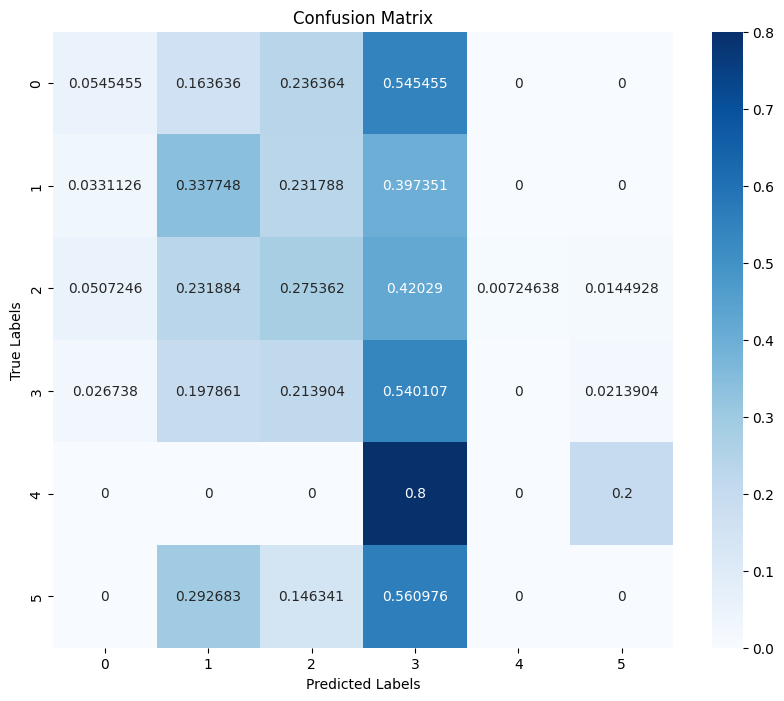

Epoch 12, Validation Loss: 3.3820, Accuracy: 0.3345, F1 Score: 0.3078
Val F1 Score Per Class  [0.08       0.34931507 0.28148148 0.4362851  0.         0.        ]


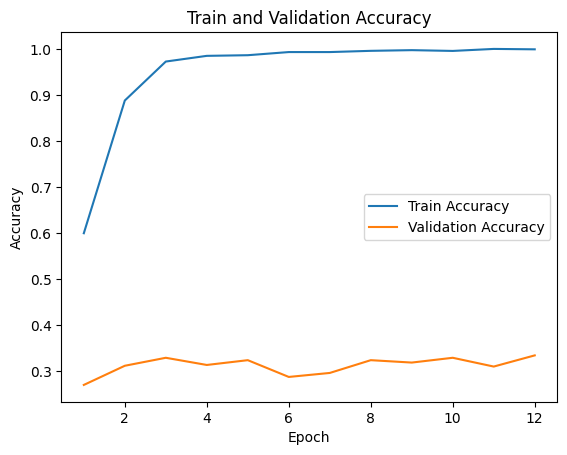

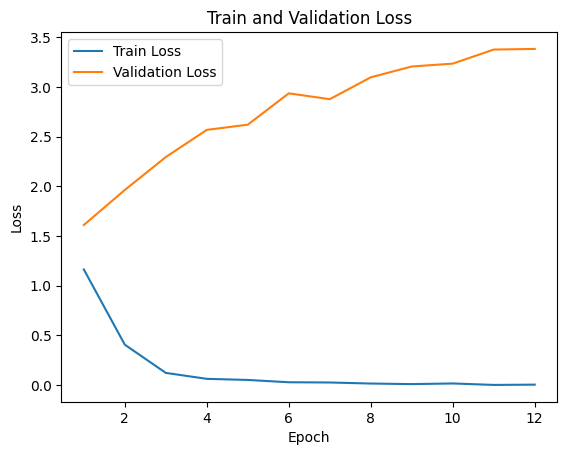

Epoch 13, Train Loss: 0.0064, Accuracy: 0.9986, F1 Score: 0.9986
Train F1 Score Per Class  [1.         0.99711816 0.99677703 0.99762329 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=4.57]

[tensor([-3.4858, -1.1904, -2.4978,  4.9134, -3.0888, -2.8813], device='cuda:0'), tensor([-2.7114,  3.8967,  0.7426, -1.4071, -4.1790, -3.4171], device='cuda:0'), tensor([-1.7388, -1.9785, -1.6480,  4.2080, -5.1507, -2.6896], device='cuda:0'), tensor([-1.8668, -1.1085, -2.8166,  5.0171, -3.8275, -2.1592], device='cuda:0'), tensor([-2.6583, -0.7409,  4.6901, -1.3651, -4.3496, -2.5071], device='cuda:0'), tensor([-3.0795,  0.8004,  5.2517, -2.1088, -2.7591, -2.4028], device='cuda:0'), tensor([-2.5672, -2.0986, -2.4703,  4.7982, -4.0902, -1.3987], device='cuda:0'), tensor([-2.2711, -2.6136,  6.2061, -0.2943, -2.3873, -1.8923], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:34,  2.08it/s, loss=3.79]

[tensor([-1.6658e+00, -2.1438e+00, -2.1490e+00,  1.9207e+00, -4.3815e+00,
        -1.7345e-03], device='cuda:0'), tensor([-2.9044, -1.1089,  3.7569, -2.3903, -2.1104, -1.8397], device='cuda:0'), tensor([-0.9446, -2.5670,  5.4581, -0.6060, -2.7416, -2.7039], device='cuda:0'), tensor([-2.1720, -1.8111,  0.0535,  5.1236, -3.5995, -3.2609], device='cuda:0'), tensor([-1.3282,  6.2601, -1.1289, -1.8153, -3.2763, -2.9594], device='cuda:0'), tensor([-1.8860, -0.2135,  1.6058,  0.1661, -4.3289, -4.4673], device='cuda:0'), tensor([-1.1354, -3.0844, -0.8440,  4.6552, -3.4398, -3.4371], device='cuda:0'), tensor([ 5.5246, -1.5589, -2.0320,  0.0740, -3.6889, -2.7699], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:33,  2.11it/s, loss=3.7]

[tensor([-3.0243, -2.5493,  3.9821, -0.2528, -4.0433, -3.7274], device='cuda:0'), tensor([-1.8491,  1.5923,  1.0988, -1.6078, -3.4838, -3.2555], device='cuda:0'), tensor([-2.2038, -2.2776,  6.0999, -1.0354, -2.6690, -1.9410], device='cuda:0'), tensor([-1.2252, -2.7149, -0.0112, -0.0303, -3.8896, -3.3786], device='cuda:0'), tensor([-1.6086,  0.5621, -2.4784,  2.8074, -3.7260, -3.9080], device='cuda:0'), tensor([-2.2377, -1.2363, -1.6418,  4.1232, -4.5857, -4.2797], device='cuda:0'), tensor([-1.1662, -2.8282, -1.7357,  4.8609, -3.7708, -3.3585], device='cuda:0'), tensor([-1.1713, -1.8201,  1.8433, -2.3847, -3.0768, -2.7107], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.13it/s, loss=3.76]

[tensor([-3.0673, -1.9036,  0.2935,  3.9577, -3.7867, -2.8614], device='cuda:0'), tensor([-3.5325,  0.4568,  4.3044, -1.8542, -3.4072, -2.8787], device='cuda:0'), tensor([-2.3988, -1.1330, -1.8535,  1.8296, -4.8867, -1.4178], device='cuda:0'), tensor([-2.1720, -1.0241,  1.7978, -1.0147, -2.5711, -2.4955], device='cuda:0'), tensor([ 3.7850, -2.4505,  0.0265,  0.8783, -3.5547, -4.2365], device='cuda:0'), tensor([-2.3958, -2.0446,  1.2799,  0.2771, -5.0628, -2.1902], device='cuda:0'), tensor([-1.6874,  3.2763,  0.0290, -1.4973, -4.6366, -4.2737], device='cuda:0'), tensor([-2.6611, -0.1931,  4.7379, -2.3027, -2.4900, -1.6058], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=4.72]

[tensor([-2.6424, -2.8949,  1.1536,  2.5745, -3.2842, -4.1477], device='cuda:0'), tensor([-3.0618, -2.5543,  4.8653,  1.1467, -3.6135, -3.1427], device='cuda:0'), tensor([-1.3664, -2.1905,  6.3971, -1.7764, -2.7687, -2.1913], device='cuda:0'), tensor([-2.4333, -1.5785, -1.5602,  2.4179, -4.1196, -4.2676], device='cuda:0'), tensor([-1.6645, -1.8427,  6.2752, -1.1680, -2.8972, -2.2055], device='cuda:0'), tensor([-2.2683, -1.9366,  1.7082,  0.3009, -4.4065, -3.6230], device='cuda:0'), tensor([-2.8757,  1.6536, -1.6018, -1.2960, -4.1675, -2.1267], device='cuda:0'), tensor([-1.7853, -0.3947, -2.7958,  4.7469, -3.6578, -1.8164], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=4.68]

[tensor([-2.0568, -1.9725,  6.7534, -1.1986, -2.6417, -2.2544], device='cuda:0'), tensor([-1.8851, -1.8468,  6.5361, -1.6276, -2.4153, -1.5184], device='cuda:0'), tensor([-1.0350, -2.6277,  5.4943, -0.8612, -3.1697, -3.4940], device='cuda:0'), tensor([-3.1243, -1.1385, -0.6382,  0.0348, -4.1910, -3.4319], device='cuda:0'), tensor([-1.6014, -1.9108,  6.6365, -1.7486, -2.3092, -1.7509], device='cuda:0'), tensor([-1.6592, -3.0910,  1.3380,  2.4997, -4.1626, -3.1723], device='cuda:0'), tensor([-1.2556, -2.9930,  6.3476, -0.5498, -2.9580, -2.4186], device='cuda:0'), tensor([-2.0263, -2.8743, -0.5395,  3.7253, -3.0869, -3.6928], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.13it/s, loss=2.29]

[tensor([-2.4424, -1.6798,  1.7944,  1.0882, -3.7675, -2.5386], device='cuda:0'), tensor([-2.3080, -1.2446,  0.9403,  0.4696, -3.6695, -2.3769], device='cuda:0'), tensor([-0.5947, -2.1478,  6.4364, -1.8419, -2.0722, -1.9687], device='cuda:0'), tensor([-2.6196, -2.9651,  0.2554,  2.3962, -3.9268, -2.8158], device='cuda:0'), tensor([-3.7465, -0.0246,  2.0184, -0.4040, -3.5883, -4.3502], device='cuda:0'), tensor([-3.1658, -2.2408,  1.5080,  1.4217, -4.1034, -1.4941], device='cuda:0'), tensor([-2.5235, -3.0765,  5.1888, -1.7194, -2.9621,  0.2911], device='cuda:0'), tensor([-1.7164, -1.2333, -2.4176,  1.0631, -4.6231, -3.2087], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=5.69]

[tensor([-0.8330, -2.8661,  0.9470,  0.5005, -4.4412, -4.3178], device='cuda:0'), tensor([-1.7302, -2.0839,  5.6675, -1.0691, -2.3110, -2.2572], device='cuda:0'), tensor([-1.7593, -1.7579, -1.7097,  6.2741, -3.6898, -2.8070], device='cuda:0'), tensor([-0.4830,  4.7251, -1.5365, -0.2631, -3.9151, -4.5160], device='cuda:0'), tensor([-2.2203, -1.3386,  6.6503, -1.8732, -2.7171, -2.5266], device='cuda:0'), tensor([-1.1993, -2.3964,  0.2500,  1.7835, -3.9852, -4.7472], device='cuda:0'), tensor([-2.4643, -3.5160, -0.6679,  0.2486, -4.7606,  0.4949], device='cuda:0'), tensor([-2.1193, -1.9090,  6.6870, -1.1303, -2.3814, -1.8217], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.14it/s, loss=2.66]

[tensor([-2.7280, -1.8876, -1.4410,  2.0079, -4.9035, -2.3161], device='cuda:0'), tensor([-2.8825,  1.1478,  0.2419, -0.1101, -4.1661, -4.0985], device='cuda:0'), tensor([-0.2573, -0.7028, -0.4180,  0.7684, -4.1165, -5.1954], device='cuda:0'), tensor([-1.1997, -2.7375,  2.7173,  0.0405, -3.0268, -3.0338], device='cuda:0'), tensor([-2.0990, -2.8157,  1.1946,  0.7208, -3.0866, -2.6850], device='cuda:0'), tensor([-3.4351,  3.0339,  1.4016, -0.2511, -4.0473, -3.9778], device='cuda:0'), tensor([-3.6542, -1.7089,  1.9828,  1.1086, -4.8223, -4.2599], device='cuda:0'), tensor([-2.5276, -2.4160,  1.4181,  1.0188, -4.3154, -2.9259], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.14it/s, loss=2.65]

[tensor([-2.6708, -0.5110,  3.2205, -1.1715, -2.9667, -3.2795], device='cuda:0'), tensor([-2.4059, -1.9173,  1.3608,  0.8017, -3.4562, -3.3735], device='cuda:0'), tensor([ 1.2925, -0.6807, -1.8772, -1.9111, -3.5187, -2.2971], device='cuda:0'), tensor([-2.7095, -1.9882,  2.2641,  0.9929, -3.6174, -4.3809], device='cuda:0'), tensor([-2.3834,  2.9316,  2.9321, -1.4739, -3.8107, -3.6489], device='cuda:0'), tensor([-0.3102, -2.6694,  2.1761,  1.5140, -4.0475, -4.1367], device='cuda:0'), tensor([-3.0243,  0.2520,  1.1127, -1.6718, -3.4660, -2.9919], device='cuda:0'), tensor([-2.6587,  0.6128, -1.4933,  4.9099, -4.3824, -4.4118], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=4.48]

[tensor([-2.4080, -2.3692, -0.6296,  5.8116, -3.2602, -2.6197], device='cuda:0'), tensor([-0.6268,  3.4163, -2.6832, -0.4669, -4.4398, -3.4776], device='cuda:0'), tensor([-2.4783, -2.8385,  4.1536,  0.6160, -4.0058, -1.2404], device='cuda:0'), tensor([-2.7574, -2.4036,  1.7230,  1.9965, -4.6509, -3.8027], device='cuda:0'), tensor([-3.9145,  3.3171, -1.2028, -0.2542, -4.3800, -2.2553], device='cuda:0'), tensor([-0.3915, -1.7587, -2.7145,  2.3725, -4.3968, -1.7883], device='cuda:0'), tensor([-3.3988, -1.7474,  4.8861, -1.4966, -2.8888, -2.7849], device='cuda:0'), tensor([-0.2307, -2.5476, -2.3485,  4.6497, -3.8564, -4.0595], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.16it/s, loss=4.45]

[tensor([-2.3154, -2.5665,  4.9868, -0.3611, -3.0158, -2.9629], device='cuda:0'), tensor([-2.9619, -1.0495,  2.2086,  0.4928, -3.7339, -3.7650], device='cuda:0'), tensor([-3.1303, -1.8436,  3.7701,  1.0198, -3.2492, -4.0657], device='cuda:0'), tensor([-1.8281, -2.0979, -1.9593,  3.9958, -3.8724, -4.0908], device='cuda:0'), tensor([-0.7622, -2.1284, -1.6772, -0.8057, -3.2963, -3.8147], device='cuda:0'), tensor([-1.9704, -1.9710,  6.7137, -0.9436, -2.6613, -2.0994], device='cuda:0'), tensor([-1.7508, -1.6745, -1.9771,  4.3856, -4.0401, -2.7562], device='cuda:0'), tensor([-2.3451, -1.6079,  5.1759, -0.8205, -3.4942, -3.0033], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.16it/s, loss=2.69]

[tensor([ 1.6809, -1.7974,  0.2408, -2.1070, -3.3167, -2.9672], device='cuda:0'), tensor([-3.6557,  0.5900,  2.4013,  1.5750, -3.6300, -3.4007], device='cuda:0'), tensor([-3.3606,  0.0976,  0.4567,  0.2532, -4.7296, -3.6985], device='cuda:0'), tensor([-2.8030, -0.3355,  5.8019, -2.0896, -3.3640, -2.7692], device='cuda:0'), tensor([-3.1472,  3.7771, -1.0544,  0.1692, -4.0838, -2.7157], device='cuda:0'), tensor([-2.7790, -1.7678, -0.3678, -1.1174, -4.0112, -2.4426], device='cuda:0'), tensor([-2.6164,  1.0396, -2.0583,  4.4769, -4.2976, -3.5822], device='cuda:0'), tensor([-1.9033, -0.3795, -0.7679,  1.9722, -4.2344, -4.9170], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.16it/s, loss=2.23]

[tensor([-2.5356, -2.8226,  0.7722, -1.0570, -3.9309, -2.0160], device='cuda:0'), tensor([-2.8402, -1.8286, -1.3731,  0.7210, -4.3133, -4.1311], device='cuda:0'), tensor([-2.8056, -2.6745,  0.6518, -0.2798, -2.9526, -1.3463], device='cuda:0'), tensor([-2.3700, -1.4320,  0.8504, -0.3759, -4.7676, -3.5726], device='cuda:0'), tensor([-3.1773, -1.6084, -1.7367,  5.5804, -2.8789, -0.9837], device='cuda:0'), tensor([-3.1535, -0.5607,  2.4261,  0.7461, -3.9612, -3.2343], device='cuda:0'), tensor([-2.0052, -1.7978,  5.8168, -2.0789, -2.4432, -1.7451], device='cuda:0'), tensor([-2.9536, -1.0305, -0.0122,  1.8930, -4.5415, -4.0803], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:26,  2.16it/s, loss=5.92]

[tensor([-3.1495,  2.7410, -1.4274,  0.4912, -4.0855, -3.4921], device='cuda:0'), tensor([-2.4673, -0.0432,  3.0835, -1.7098, -3.7756, -4.1046], device='cuda:0'), tensor([-1.8646, -1.4325,  6.6258, -1.7697, -2.4722, -1.6218], device='cuda:0'), tensor([-1.7793, -2.8699, -0.6570,  5.8651, -3.7856, -2.8920], device='cuda:0'), tensor([-2.2167, -1.6722, -1.4833,  6.1200, -3.2959, -3.4894], device='cuda:0'), tensor([-2.3262, -1.8500,  2.5854, -1.2560, -4.0446, -4.4915], device='cuda:0'), tensor([-3.2731, -2.3823,  3.9226,  0.7835, -4.0923, -2.5298], device='cuda:0'), tensor([-3.2419, -2.0926,  5.6597, -0.7969, -3.4629, -3.6516], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.16it/s, loss=2.51]

[tensor([-2.2831, -1.7936, -0.6859,  4.7045, -4.4721, -3.0441], device='cuda:0'), tensor([-2.5740,  2.5583,  1.2306, -2.0935, -3.6081, -3.2620], device='cuda:0'), tensor([-1.9116, -2.1495, -0.9025,  5.2674, -3.8348, -3.9512], device='cuda:0'), tensor([-3.3707, -0.3976,  0.0185,  0.2206, -3.9097, -2.1591], device='cuda:0'), tensor([-2.1024, -2.9973, -0.8877,  1.1003, -3.9604, -2.9458], device='cuda:0'), tensor([-3.0026, -1.9720,  5.5413, -0.6035, -2.8244, -2.3751], device='cuda:0'), tensor([-1.8098, -2.3212,  0.9994,  1.9014, -5.1492, -4.0325], device='cuda:0'), tensor([-2.9196, -2.3122,  2.6209, -0.7376, -3.5744, -1.9519], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:25,  2.16it/s, loss=4]

[tensor([-3.0439, -2.6455,  2.2297,  3.1276, -4.1322, -2.8293], device='cuda:0'), tensor([ 0.9276, -1.3508,  3.8731, -1.9897, -3.7967, -2.6382], device='cuda:0'), tensor([-1.7658, -0.5119,  5.1936, -2.4818, -3.0879, -2.5179], device='cuda:0'), tensor([-2.4701, -2.2101,  3.8053, -0.5410, -3.7748, -3.5312], device='cuda:0'), tensor([-2.0483, -3.0887,  5.3455, -0.2427, -2.6132, -1.7232], device='cuda:0'), tensor([-2.0504, -2.4108, -1.4119,  3.3043, -4.0714, -2.7878], device='cuda:0'), tensor([ 1.0703, -3.0633,  0.5210, -1.3877, -3.2589, -1.8831], device='cuda:0'), tensor([-2.2946, -1.7069, -2.7896,  1.0485, -3.0104, -2.4882], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.16it/s, loss=1.97]

[tensor([-2.4655, -3.0208,  0.8303,  3.3463, -3.8147, -3.1941], device='cuda:0'), tensor([-0.3388, -2.9879,  4.2548,  0.3111, -3.0328, -4.0102], device='cuda:0'), tensor([-2.9361, -1.5315,  3.7675, -1.4961, -3.5137, -1.3634], device='cuda:0'), tensor([-2.9736,  0.5846,  0.0677,  0.0690, -4.3993, -4.5185], device='cuda:0'), tensor([-2.5064, -2.8087,  3.0635,  0.3903, -1.8317, -3.2196], device='cuda:0'), tensor([-0.1793, -2.3410, -0.1144, -0.3952, -4.3412, -2.3452], device='cuda:0'), tensor([-0.7014, -0.8322,  0.5467,  0.1283, -4.4357, -3.9260], device='cuda:0'), tensor([-2.8489, -2.0847,  0.7988,  3.6092, -3.8515, -4.1008], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.16it/s, loss=2.3]

[tensor([-1.3906, -2.2449,  5.7937, -1.4397, -2.6461, -2.9652], device='cuda:0'), tensor([ 6.6061, -2.1099, -1.2031, -1.1695, -2.3755, -2.6475], device='cuda:0'), tensor([-1.7314, -1.5718,  6.6007, -1.2967, -2.2157, -2.3511], device='cuda:0'), tensor([-2.6834, -3.1303,  1.7693,  2.3585, -3.1993, -2.8818], device='cuda:0'), tensor([-0.7583,  0.6940, -2.0217, -0.3361, -4.6567, -4.0891], device='cuda:0'), tensor([ 0.3216, -1.8804, -0.8293,  1.9245, -3.7767, -3.9132], device='cuda:0'), tensor([-1.9808, -1.6033,  4.9552, -1.0553, -3.7580, -2.0434], device='cuda:0'), tensor([-1.6986,  0.3507,  1.3025, -1.7915, -4.2981, -3.5405], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.15it/s, loss=5.82]

[tensor([-2.8627, -2.9056,  2.8696,  1.2563, -3.7496, -2.9261], device='cuda:0'), tensor([-2.4387, -1.4312,  4.1809, -2.2940, -2.3186, -2.3180], device='cuda:0'), tensor([-2.1363, -2.1799,  0.8280,  2.8562, -3.3365, -1.6934], device='cuda:0'), tensor([-1.8796, -3.0342,  5.2491, -0.8116, -3.7447, -2.5038], device='cuda:0'), tensor([-1.4239, -2.0892,  3.4830, -1.0395, -4.6496, -4.3606], device='cuda:0'), tensor([-3.0998,  3.2831, -0.5756, -0.7867, -3.8596, -2.4328], device='cuda:0'), tensor([-1.1402, -3.1902,  3.4557,  0.1384, -3.6391, -3.5415], device='cuda:0'), tensor([-2.4081, -1.6062,  3.8114, -0.2593, -3.7311, -3.7933], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.16it/s, loss=4.77]

[tensor([-0.8311, -2.8030,  5.8140, -1.4591, -2.4530, -1.9632], device='cuda:0'), tensor([-1.5236,  2.9225, -1.5318,  0.0659, -4.2912, -3.6681], device='cuda:0'), tensor([-2.4330,  0.2089,  5.8029, -2.2220, -3.3143, -2.6995], device='cuda:0'), tensor([-2.0154, -2.7953,  6.4278, -0.3822, -2.5714, -2.3848], device='cuda:0'), tensor([-1.7565, -2.7037,  5.2222, -0.1743, -3.9100, -3.5287], device='cuda:0'), tensor([-1.5246, -1.3651, -0.1192, -2.2352, -3.3874, -2.6088], device='cuda:0'), tensor([-1.9236, -2.4656, -1.0317,  6.1674, -2.8477, -2.7115], device='cuda:0'), tensor([-1.9511, -1.8768, -1.2913,  5.5491, -2.3405, -1.8623], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.17it/s, loss=2.56]

[tensor([-2.2322, -0.7290, -0.4603,  4.2693, -4.5188, -4.2321], device='cuda:0'), tensor([-1.9767, -1.9037, -0.2207,  0.4618, -3.2277, -3.5194], device='cuda:0'), tensor([-2.4519, -2.0395,  6.1947, -1.0506, -2.9631, -2.3370], device='cuda:0'), tensor([-2.9593, -2.4350, -0.3643, -0.7925, -2.5609, -1.5609], device='cuda:0'), tensor([-2.1063, -1.8896,  3.1567, -0.9246, -3.5720, -3.3872], device='cuda:0'), tensor([-0.3981, -3.2809,  4.9622, -0.1646, -2.5995, -3.4886], device='cuda:0'), tensor([-2.6744, -0.4184, -1.2559, -0.6476, -4.3534, -3.4819], device='cuda:0'), tensor([-3.2149, -2.1702,  3.7788,  2.2558, -3.5318, -3.1870], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.17it/s, loss=3.98]

[tensor([-1.1174, -2.3166, -1.2483,  2.6663, -3.6887, -3.8747], device='cuda:0'), tensor([-2.4567, -2.3124, -0.8519,  5.1666, -3.6665, -3.0818], device='cuda:0'), tensor([-1.8646, -1.0863, -2.1449,  5.3462, -2.8027, -3.2845], device='cuda:0'), tensor([-2.2455, -1.5748,  5.9180, -1.9846, -3.5422, -2.1086], device='cuda:0'), tensor([-2.7159, -0.2916, -0.8141,  2.6955, -4.3241, -3.1363], device='cuda:0'), tensor([-1.6221, -1.8404, -1.8701,  6.3506, -2.5246, -2.6842], device='cuda:0'), tensor([-0.7814, -2.8577,  3.9003, -0.8391, -2.9461, -2.9770], device='cuda:0'), tensor([-2.1525, -2.4410,  6.4729, -1.5567, -2.5185, -2.4015], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.16it/s, loss=3.46]

[tensor([-1.2997, -0.8528, -2.7748,  2.2099, -3.4049, -2.7487], device='cuda:0'), tensor([-2.3861, -1.8915, -0.7110,  1.7935, -4.0539, -2.6071], device='cuda:0'), tensor([-1.8990e+00, -2.7293e+00, -4.6263e-03,  4.9542e+00, -4.0432e+00,
        -3.6507e+00], device='cuda:0'), tensor([-0.7330, -2.6285,  3.8759, -1.7382, -2.9711, -4.1452], device='cuda:0'), tensor([-3.0051, -0.1832,  5.5464, -2.1393, -2.6494, -2.8213], device='cuda:0'), tensor([-1.6924, -2.1325,  6.4316, -0.9894, -2.3968, -2.2613], device='cuda:0'), tensor([-2.9705, -1.6973, -2.2787,  5.2986, -2.4526, -0.8572], device='cuda:0'), tensor([-1.8431,  1.7118, -1.8045,  0.2848, -5.2265, -3.0745], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=3.48]

[tensor([-2.8533, -0.9558,  2.3706,  1.3298, -4.8830, -2.6536], device='cuda:0'), tensor([-1.7866,  2.2856, -2.1595,  1.5423, -4.1918, -2.6321], device='cuda:0'), tensor([-2.7748,  0.4810,  3.0010,  0.4468, -4.9679, -4.2913], device='cuda:0'), tensor([-1.9554, -2.2106,  4.8921, -0.4017, -2.9231, -3.3999], device='cuda:0'), tensor([-1.8120, -0.5847,  0.1575,  0.3062, -4.4988, -4.4411], device='cuda:0'), tensor([-2.0743,  4.5258, -1.2153, -2.1959, -3.3880, -2.3900], device='cuda:0'), tensor([-2.4885,  0.5305, -2.1748, -1.6607, -4.9735, -2.4415], device='cuda:0'), tensor([-3.1328,  2.2862, -2.4629,  2.5000, -4.8703, -1.8197], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=4.54]

[tensor([-1.7542,  3.2404, -2.9821, -0.4833, -3.9835, -0.7295], device='cuda:0'), tensor([-3.0401, -1.1661,  1.3929, -2.1591, -3.8124, -2.0312], device='cuda:0'), tensor([-2.9292, -1.1280,  3.4879, -0.4533, -3.7829, -4.0042], device='cuda:0'), tensor([-1.4000, -2.7030,  2.1648,  0.0711, -3.8367, -4.6337], device='cuda:0'), tensor([-1.7679, -1.3785, -1.9786,  4.8112, -4.1605, -4.1652], device='cuda:0'), tensor([-2.5854, -2.9003, -0.8614,  2.9724, -2.8372, -2.2405], device='cuda:0'), tensor([-0.2518, -2.9099,  1.5722, -0.4617, -3.4874, -2.9000], device='cuda:0'), tensor([ 0.4500, -3.2986,  5.1089, -1.2702, -2.6083, -2.2111], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=4.12]

[tensor([-2.4146, -1.2853, -2.5015,  2.9280, -3.5880, -0.6738], device='cuda:0'), tensor([-2.0490,  2.9980,  2.4099, -1.8726, -3.6807, -3.9332], device='cuda:0'), tensor([-1.8895, -2.2733,  0.7638, -0.4186, -3.7641, -1.4049], device='cuda:0'), tensor([-2.6259, -1.9689, -0.8854,  4.4458, -3.2953, -2.7162], device='cuda:0'), tensor([-1.4091, -2.1139,  0.2284,  0.2642, -3.3471, -2.4525], device='cuda:0'), tensor([-3.5493, -0.9096,  1.2171,  1.9430, -3.9144, -4.5638], device='cuda:0'), tensor([-1.9945, -2.2682,  6.4846, -1.3967, -2.5337, -2.0690], device='cuda:0'), tensor([-3.1025,  4.2288, -2.4559,  1.1958, -3.7369, -2.7826], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.15it/s, loss=3.34]

[tensor([-1.0414, -1.9003,  6.2058, -1.6154, -2.3455, -2.5330], device='cuda:0'), tensor([-2.3142, -2.8215,  3.3766,  2.1896, -3.2697, -2.8944], device='cuda:0'), tensor([-0.3543, -2.5802,  0.3902,  1.0699, -4.3834, -3.7059], device='cuda:0'), tensor([-1.6054, -2.4051,  6.0197, -0.9234, -2.8243, -2.1685], device='cuda:0'), tensor([-2.0547, -1.5981,  6.6518, -1.3878, -2.4547, -2.3767], device='cuda:0'), tensor([-1.9897,  0.4924, -0.8294, -0.1781, -3.4053, -1.8342], device='cuda:0'), tensor([-2.2524, -2.1987,  2.5913,  1.0162, -3.7671, -1.8533], device='cuda:0'), tensor([-1.1565, -2.4821,  5.6163, -0.5329, -2.8671, -2.8724], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.16it/s, loss=5.13]

[tensor([ 4.9152, -1.7256, -0.6225, -2.0444, -3.2361, -1.3608], device='cuda:0'), tensor([-2.8093, -1.7354,  6.3909, -1.6019, -3.0727, -2.6364], device='cuda:0'), tensor([-1.2260, -1.1377, -1.6805,  4.7960, -3.5435, -4.3245], device='cuda:0'), tensor([-1.4130, -0.9973,  3.7236, -0.7051, -2.9255, -2.2745], device='cuda:0'), tensor([-2.2446, -1.1230,  4.1247,  0.1272, -3.6258, -4.2300], device='cuda:0'), tensor([-1.9865, -2.0095,  6.2477, -1.3674, -2.7268, -1.6196], device='cuda:0'), tensor([-1.5283, -1.6473,  5.4438, -1.0731, -3.2370, -2.4620], device='cuda:0'), tensor([-3.8799,  2.8692, -0.0635, -0.0884, -3.1819, -3.1718], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=5.75]

[tensor([-2.3327, -1.4249,  4.5567, -1.2410, -3.9865, -4.5335], device='cuda:0'), tensor([-2.2839, -2.5432,  5.2153,  0.8142, -2.8332, -2.5310], device='cuda:0'), tensor([-3.7398,  0.8736, -1.0121, -0.6175, -4.7327, -1.8554], device='cuda:0'), tensor([-2.7635, -0.7110, -1.3151,  0.6136, -2.7126,  0.7113], device='cuda:0'), tensor([-1.8404, -1.9864, -1.0357,  6.1191, -2.9000, -3.1297], device='cuda:0'), tensor([-1.2271, -2.7522,  4.2278, -0.7084, -3.4287, -3.7199], device='cuda:0'), tensor([-0.3476, -2.8237,  5.0229, -1.2909, -2.0301, -1.3862], device='cuda:0'), tensor([ 6.2944, -1.1615, -1.7973, -0.9180, -2.7255, -1.6320], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.16it/s, loss=4.09]

[tensor([-2.4952, -3.3787,  3.4964,  1.6320, -3.1121, -1.9896], device='cuda:0'), tensor([-1.3342, -3.5887,  0.0592,  3.3766, -4.4112, -3.6315], device='cuda:0'), tensor([-2.0561, -2.1425,  5.8144, -0.4405, -3.6999, -2.9713], device='cuda:0'), tensor([ 0.7868, -3.1620,  0.4499,  1.9554, -4.2196, -4.1194], device='cuda:0'), tensor([-1.4829, -2.0132,  3.8650, -0.4057, -4.0004, -4.3118], device='cuda:0'), tensor([-2.3806, -2.4408,  4.4608, -3.0272, -2.4085, -0.9430], device='cuda:0'), tensor([-0.2785,  1.1666, -2.2022, -0.9779, -3.7097, -4.1743], device='cuda:0'), tensor([-2.4596, -2.3273,  0.4908,  2.7858, -3.8618, -4.4842], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.17it/s, loss=4.19]

[tensor([-3.0094,  0.5868,  3.4861, -2.4851, -3.2281, -0.5584], device='cuda:0'), tensor([-0.8612, -2.3958,  4.2598, -0.1442, -3.7607, -4.2244], device='cuda:0'), tensor([-1.4275, -2.9799,  2.4845, -0.0926, -3.8664, -4.1464], device='cuda:0'), tensor([-2.4019, -2.5767,  5.9324,  0.0091, -3.0099, -2.7315], device='cuda:0'), tensor([-3.2372, -1.6296,  3.6818, -0.6611, -3.1953, -2.7138], device='cuda:0'), tensor([-1.6297,  4.0274, -0.0045, -2.1440, -4.0765, -2.7611], device='cuda:0'), tensor([-1.8074, -1.4522, -1.2003, -1.2354, -2.3414,  7.3918], device='cuda:0'), tensor([-0.3375, -3.4078,  1.8255, -0.6975, -2.4753, -3.4382], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.17it/s, loss=3.98]

[tensor([-2.2732, -1.3938,  4.3077, -1.5625, -3.9145, -3.0677], device='cuda:0'), tensor([-1.7489, -0.8479, -1.2532,  4.0098, -3.3286, -3.8783], device='cuda:0'), tensor([-2.5555, -2.4786,  3.2661,  0.1488, -4.2533, -3.6558], device='cuda:0'), tensor([-3.2814, -0.9045, -1.8572,  1.6746, -4.3581,  0.0711], device='cuda:0'), tensor([-1.6761, -2.4236, -2.1366,  4.7685, -3.8317, -3.8040], device='cuda:0'), tensor([-3.4669, -1.6142,  1.8698, -0.1423, -3.3800, -3.9330], device='cuda:0'), tensor([-2.4813, -2.4650,  0.1248,  4.0907, -3.9918, -3.7330], device='cuda:0'), tensor([ 2.9462, -2.9292, -1.6637,  1.8259, -3.2622, -3.2313], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:17,  2.17it/s, loss=3.78]

[tensor([-2.5073, -1.0635,  5.8238, -0.9646, -3.6947, -3.2946], device='cuda:0'), tensor([-2.2236, -2.6541,  3.0152, -0.5992, -3.2740, -3.5454], device='cuda:0'), tensor([-1.6388, -1.4578,  6.7515, -1.8243, -2.1621, -2.2415], device='cuda:0'), tensor([-0.5197, -2.8841,  4.5469, -1.2327, -3.0245, -2.4162], device='cuda:0'), tensor([-0.8686, -1.1314, -2.4729,  2.3912, -4.0949, -3.9421], device='cuda:0'), tensor([-2.1447, -1.6873,  6.7438, -1.3308, -2.3729, -2.0315], device='cuda:0'), tensor([ 2.4200, -2.9413, -0.7132, -0.6472, -2.6419, -2.5251], device='cuda:0'), tensor([-2.2796, -1.1539,  0.9347, -0.1057, -4.1366, -3.9170], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.18it/s, loss=2.99]

[tensor([-1.2819, -1.8759, -1.6885,  5.0692, -3.1673, -4.2444], device='cuda:0'), tensor([-2.4643, -1.1564,  3.3559, -2.7933, -3.1435,  0.0365], device='cuda:0'), tensor([-1.9408, -2.0870, -0.3773,  3.3409, -4.8172, -3.5671], device='cuda:0'), tensor([ 0.4577, -3.2725,  3.2831, -1.6525, -3.2931, -2.1765], device='cuda:0'), tensor([-2.0309, -0.3607,  1.6256, -1.5680, -2.8467, -1.8589], device='cuda:0'), tensor([-2.2491, -2.1844,  0.1018,  4.6163, -3.5568, -2.3287], device='cuda:0'), tensor([ 0.8632, -3.0465,  0.0520,  1.5306, -4.4554, -2.8449], device='cuda:0'), tensor([-2.9411,  1.8630,  1.3787, -2.4988, -3.5806, -1.2561], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.16it/s, loss=3.03]

[tensor([-2.6622, -1.7835,  0.3776, -1.8835, -3.6603, -3.1832], device='cuda:0'), tensor([ 0.5443, -2.3866, -0.7200, -0.5839, -3.9962, -3.4926], device='cuda:0'), tensor([-4.4402, -1.5768, -0.1248,  2.5515, -3.2008, -3.9027], device='cuda:0'), tensor([-2.9258,  1.8940,  2.8362, -0.9141, -3.6758, -3.9921], device='cuda:0'), tensor([-1.3929, -3.0602,  2.4998, -0.2583, -3.5905, -3.9438], device='cuda:0'), tensor([-3.0409,  1.1162, -0.3946, -0.3645, -2.8371, -4.4331], device='cuda:0'), tensor([-3.3379,  0.8047,  4.7944, -2.0851, -3.7349, -2.9000], device='cuda:0'), tensor([-3.1005, -0.2210,  3.0979, -1.7581, -3.3232, -3.8276], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=4.34]

[tensor([-2.1240, -2.1137, -1.1889,  2.6574, -4.3748, -3.5393], device='cuda:0'), tensor([-3.0945,  2.6318, -2.7578,  1.1201, -2.7787, -2.7554], device='cuda:0'), tensor([-0.4281, -1.8857, -1.9084,  5.3892, -4.1293, -2.9822], device='cuda:0'), tensor([-2.2858, -1.2606,  6.5659, -1.5866, -2.8258, -2.6977], device='cuda:0'), tensor([-2.4953, -0.9163,  2.0255, -1.7385, -3.3760, -1.3506], device='cuda:0'), tensor([-2.3857,  1.7874, -1.1074, -1.7900, -3.0310, -2.8229], device='cuda:0'), tensor([-2.4121,  3.1310,  3.0975, -2.2084, -3.6384, -3.8181], device='cuda:0'), tensor([-2.5249, -2.4150, -0.6985,  1.7500, -3.9004, -2.1302], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=4.15]

[tensor([-3.1046, -1.4612, -2.1073,  4.4240, -3.9322, -0.9629], device='cuda:0'), tensor([-2.0232, -1.8722,  5.8521, -0.9033, -2.0596, -2.5792], device='cuda:0'), tensor([-2.6047, -1.7082,  0.8009,  4.2869, -3.2982, -4.0969], device='cuda:0'), tensor([-1.4561, -1.5935,  5.6185, -2.0990, -2.9819, -2.3566], device='cuda:0'), tensor([-1.8697, -1.7411,  6.2582, -1.7046, -2.7654, -1.2434], device='cuda:0'), tensor([-1.1370, -2.7675,  1.9286,  1.0189, -3.1600, -3.7874], device='cuda:0'), tensor([-2.6106, -1.7410,  0.1422, -1.2458, -2.4516, -2.0604], device='cuda:0'), tensor([-2.4839,  1.7135, -1.2909,  1.7785, -4.0696, -4.6303], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.13it/s, loss=4.5]

[tensor([-2.0609,  0.0418,  3.5274, -1.3512, -3.7000, -3.5741], device='cuda:0'), tensor([-2.4449, -1.2019, -2.6001,  3.6201, -2.4440, -0.5104], device='cuda:0'), tensor([ 5.4816, -0.7796, -2.4524, -0.6964, -3.1068, -3.3792], device='cuda:0'), tensor([-2.7564,  0.2035,  1.0688,  0.1497, -4.5231, -4.8559], device='cuda:0'), tensor([-1.9908, -0.7222, -0.8980,  2.9834, -4.0633, -4.3612], device='cuda:0'), tensor([-1.4837, -2.6927,  6.0860, -1.2647, -2.5909, -2.3908], device='cuda:0'), tensor([-1.8069, -1.7433, -1.6000,  4.6602, -2.6745, -3.9661], device='cuda:0'), tensor([-2.2456, -2.1284,  6.5672, -0.8262, -2.7043, -2.0648], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.11it/s, loss=3.22]

[tensor([-2.6153,  0.7354,  0.5760,  1.1580, -4.5827, -4.9590], device='cuda:0'), tensor([-3.0026, -2.4929,  0.9292,  2.6478, -3.5359, -3.6066], device='cuda:0'), tensor([-3.7228, -0.4998, -1.0145,  1.0962, -3.4967, -3.2696], device='cuda:0'), tensor([-1.4486, -2.0621,  6.7307, -1.9225, -2.1460, -2.0410], device='cuda:0'), tensor([-1.5585,  0.2824, -2.7353,  3.7519, -2.2507, -4.1864], device='cuda:0'), tensor([-2.1028, -2.1213,  6.3039, -2.0550, -2.7988, -1.3935], device='cuda:0'), tensor([-2.1805, -3.2540,  0.9512,  1.2750, -4.2789, -3.1376], device='cuda:0'), tensor([-1.3138, -2.8782,  3.4126, -0.2307, -1.9677, -3.3803], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:15,  2.12it/s, loss=3.05]

[tensor([-1.9630, -1.9202, -1.4970,  6.3281, -2.6304, -2.9294], device='cuda:0'), tensor([-1.9220, -2.2349, -1.7677,  6.2516, -3.7413, -2.2686], device='cuda:0'), tensor([-2.7701, -1.6473, -0.4956,  3.1388, -4.3608, -3.1201], device='cuda:0'), tensor([ 0.3065, -1.6758, -2.7288,  0.6228, -3.4060, -2.3252], device='cuda:0'), tensor([-3.0074, -0.4140,  0.5146,  0.4950, -3.7581, -3.5748], device='cuda:0'), tensor([-2.5267, -2.2763,  4.3897, -0.3094, -3.0291, -3.0874], device='cuda:0'), tensor([-0.7014, -1.4561, -0.8466,  1.1007, -4.0211, -3.6799], device='cuda:0'), tensor([-0.5406, -2.1313,  5.9300, -1.4127, -2.4490, -2.3061], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.13it/s, loss=3.42]

[tensor([-3.1256, -1.4583,  1.9177, -1.1645, -3.4779, -1.3185], device='cuda:0'), tensor([-1.2789, -2.2113, -1.7056,  5.7767, -3.3589, -3.8798], device='cuda:0'), tensor([ 6.6283, -2.3227, -0.7083, -1.1339, -2.6882, -1.1556], device='cuda:0'), tensor([-2.8533,  3.3988, -1.9125, -0.5581, -2.6625, -3.5843], device='cuda:0'), tensor([-1.7010, -1.7477, -2.6068,  5.2715, -4.3022, -2.5146], device='cuda:0'), tensor([ 0.3623, -2.3556,  0.0227,  2.5602, -4.1566, -3.3242], device='cuda:0'), tensor([-1.5237, -1.5368, -0.2124,  3.5057, -4.4101, -3.9133], device='cuda:0'), tensor([-2.4444, -1.4966,  2.8445, -2.8065, -3.2829, -0.5041], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.13it/s, loss=2.51]

[tensor([-3.0706, -1.4026, -0.9362,  1.0656, -4.2359, -2.1812], device='cuda:0'), tensor([-3.4501, -2.4227, -0.6615,  0.5640, -2.9028, -2.1883], device='cuda:0'), tensor([-3.5296, -2.2669,  3.0694,  1.4653, -4.0661, -2.5819], device='cuda:0'), tensor([-2.0469, -2.9445,  0.0193,  4.7459, -4.5170, -3.5695], device='cuda:0'), tensor([-2.8832,  2.6213,  1.2088, -0.1237, -4.0441, -4.2179], device='cuda:0'), tensor([-0.8465, -3.3849,  2.0368, -0.3229, -4.0635, -3.3090], device='cuda:0'), tensor([-0.2400, -3.5806,  1.9923,  3.7895, -4.0705, -4.2075], device='cuda:0'), tensor([-1.3821, -2.7527,  1.6256,  0.6635, -3.5863, -4.2414], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.12it/s, loss=4.19]

[tensor([-1.3316, -2.4878,  1.1370,  2.1728, -3.1914, -4.2713], device='cuda:0'), tensor([-0.6017, -2.1860,  0.9560, -1.2051, -3.0736, -3.5073], device='cuda:0'), tensor([-4.0511, -1.9315,  3.9059,  0.9869, -4.1996, -2.0450], device='cuda:0'), tensor([-3.5313, -1.3416,  4.6576, -0.6399, -4.4386, -1.7853], device='cuda:0'), tensor([-2.0725, -2.4736,  5.0083, -0.3963, -2.4925, -2.1084], device='cuda:0'), tensor([-3.9865, -0.9221,  3.4201,  0.5196, -3.8924, -3.2791], device='cuda:0'), tensor([-0.7981, -1.8395,  4.8035, -0.8577, -2.9253, -2.4449], device='cuda:0'), tensor([-2.3568,  3.9009, -2.4555, -0.5504, -3.3167, -0.8200], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.13it/s, loss=3.98]

[tensor([ 6.8185, -0.9327, -1.5293, -1.5232, -2.8914, -1.8889], device='cuda:0'), tensor([-2.9623, -0.5870, -1.6638,  1.8349, -2.3122, -2.4749], device='cuda:0'), tensor([-3.1641, -0.6432, -1.7533,  1.5148, -3.7943, -1.7909], device='cuda:0'), tensor([-1.4234, -2.2595,  0.2269, -1.6553, -3.0396, -2.9480], device='cuda:0'), tensor([-1.9343, -2.4048,  6.3171, -0.4730, -2.6509, -1.8736], device='cuda:0'), tensor([-1.7231, -2.0933, -1.6195, -1.2838, -2.5911,  7.0784], device='cuda:0'), tensor([-3.6845, -1.2058,  1.0145,  1.3254, -4.1829, -2.9373], device='cuda:0'), tensor([-3.2857e+00, -2.1593e+00, -1.7885e-04,  1.9516e+00, -3.9428e+00,
        -2.4163e+00], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.14it/s, loss=3.22]

[tensor([-2.0032, -1.5754,  6.4014, -2.0648, -2.7250, -2.4579], device='cuda:0'), tensor([-1.2952,  0.4173, -0.1141,  0.9896, -2.7004, -2.6289], device='cuda:0'), tensor([-2.9751, -1.4358, -0.5587,  0.0296, -3.6637, -3.9071], device='cuda:0'), tensor([-1.5905, -2.3501,  6.4402, -1.7956, -2.0060, -0.9223], device='cuda:0'), tensor([-3.4366, -0.5916, -2.7390,  3.2479, -3.2296, -1.9665], device='cuda:0'), tensor([-2.4266,  2.1110, -1.8516,  0.2867, -3.3050, -4.1254], device='cuda:0'), tensor([-1.7971, -1.1659,  4.2861, -1.1861, -3.9992, -3.4049], device='cuda:0'), tensor([-1.8826, -1.8318,  5.5455, -1.4127, -2.6764, -2.9529], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.15it/s, loss=2.88]

[tensor([ 3.4416, -2.3602, -2.5395,  1.1081, -3.4214, -3.1661], device='cuda:0'), tensor([-1.8715, -1.9213,  2.9144,  1.1153, -4.1939, -3.2699], device='cuda:0'), tensor([-2.8115, -2.4336,  0.5854,  1.2616, -3.3115, -2.8163], device='cuda:0'), tensor([-1.9331, -1.7096,  6.3279, -1.1500, -3.0860, -2.1875], device='cuda:0'), tensor([-1.5485, -1.4678,  6.5576, -1.3298, -2.8617, -2.8762], device='cuda:0'), tensor([ 0.0058, -1.7118, -1.9808,  0.1044, -4.5351, -3.2500], device='cuda:0'), tensor([-1.8306, -2.1562, -0.7895,  1.2731, -1.4325, -3.6681], device='cuda:0'), tensor([-2.1179, -1.5221, -0.6067,  4.9038, -3.8383, -3.1727], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=2.65]

[tensor([-1.5370, -1.8626,  6.6557, -1.9785, -2.4543, -1.6544], device='cuda:0'), tensor([-2.7773,  0.4957, -0.6702,  0.3085, -4.5959, -4.1430], device='cuda:0'), tensor([-2.8278,  4.2053, -0.2625, -1.5731, -3.9015, -3.3100], device='cuda:0'), tensor([-2.2061, -0.1768, -0.9240,  2.0525, -4.9120, -4.9289], device='cuda:0'), tensor([-1.4410, -2.4277, -1.4656,  6.0677, -3.5572, -2.8137], device='cuda:0'), tensor([-0.8038, -0.7665,  0.7158, -1.7810, -3.2082, -1.4661], device='cuda:0'), tensor([-1.6801, -2.9216,  3.5761,  1.6910, -4.2860, -3.6385], device='cuda:0'), tensor([-3.2492, -1.8184,  0.7322,  3.2823, -3.3891, -2.9154], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.16it/s, loss=5.24]

[tensor([-2.5297, -2.1932,  5.8317, -0.5419, -2.7582, -2.8114], device='cuda:0'), tensor([ 0.6084,  0.6827, -0.7663, -0.8742, -4.4167, -4.5749], device='cuda:0'), tensor([-2.3940, -1.0041,  6.3862, -1.5768, -2.3542, -1.8393], device='cuda:0'), tensor([-1.4807, -2.1390,  6.4664, -1.2872, -2.6423, -1.8166], device='cuda:0'), tensor([-2.6444,  2.6180,  2.6685, -2.3427, -3.2431, -3.4016], device='cuda:0'), tensor([ 0.8260, -3.0056,  2.7476, -2.0223, -2.6114, -2.9280], device='cuda:0'), tensor([-1.3704, -2.2358,  6.2385, -2.1121, -2.9108, -0.6948], device='cuda:0'), tensor([-2.6040, -3.0624,  1.3400,  2.0367, -3.7226, -2.7563], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=4.14]

[tensor([-0.4874, -2.3262, -0.3328, -0.1374, -4.7897, -3.4024], device='cuda:0'), tensor([-3.1952, -2.6422,  2.2669,  0.6224, -4.0478, -2.7783], device='cuda:0'), tensor([-3.2294,  0.1477,  3.1412,  0.9331, -3.2571, -2.9789], device='cuda:0'), tensor([-2.4968,  0.0374,  4.4214, -1.2172, -5.2750, -3.3702], device='cuda:0'), tensor([-1.7934, -1.5107,  6.0964, -1.9124, -3.4051, -2.5601], device='cuda:0'), tensor([-2.0879, -1.8004, -2.0559,  6.2150, -2.7369, -2.0063], device='cuda:0'), tensor([-2.9667, -0.9951,  0.1205,  4.4168, -3.7657, -2.4431], device='cuda:0'), tensor([-3.2616, -1.0975, -0.0306, -0.0721, -4.7500, -4.3744], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=2.53]

[tensor([-1.5354, -2.8524,  4.9708,  0.0580, -3.1240, -2.6544], device='cuda:0'), tensor([-2.1678, -2.1730, -1.8067,  6.3098, -3.6722, -1.9883], device='cuda:0'), tensor([-3.2072, -0.0270,  3.8293, -1.6433, -3.1589, -1.1991], device='cuda:0'), tensor([-2.3983, -1.7384, -0.9248,  5.6519, -3.5009, -3.4826], device='cuda:0'), tensor([-2.2847, -0.5901,  1.8609, -0.5689, -3.2078, -3.2813], device='cuda:0'), tensor([ 0.4902, -1.4990, -3.4697,  4.5211, -3.8491, -2.1285], device='cuda:0'), tensor([-1.4647, -1.8257,  0.5686,  2.1011, -3.9853, -3.6746], device='cuda:0'), tensor([-1.1370,  1.0078, -0.8434, -3.5917, -3.5009,  3.3305], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.15it/s, loss=1.47]

[tensor([-3.5591, -1.0795,  1.1440,  0.3778, -4.3376, -1.2705], device='cuda:0'), tensor([ 0.0320, -3.2894,  2.0777,  3.0087, -3.4018, -4.5424], device='cuda:0'), tensor([ 2.2231, -1.5089, -2.0015,  2.1255, -1.6050, -4.4287], device='cuda:0'), tensor([-2.3669,  0.1233, -2.1879,  4.6027, -4.1603, -3.1766], device='cuda:0'), tensor([-1.9676, -2.4943,  2.5016, -2.3726, -2.6715,  0.2675], device='cuda:0'), tensor([-2.4240,  6.0944, -2.3280, -1.6596, -2.2498, -2.4064], device='cuda:0'), tensor([ 3.6377, -2.8736,  2.3422, -1.4428, -2.9242, -2.3070], device='cuda:0'), tensor([-2.4988,  3.7385, -0.3177, -1.1504, -4.0581, -3.1262], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.14it/s, loss=3.57]

[tensor([-2.2281, -0.3342, -2.5172,  4.4317, -3.6353, -2.9559], device='cuda:0'), tensor([-0.9794, -2.6029,  1.7720, -0.3569, -3.5925, -4.2932], device='cuda:0'), tensor([-3.1307, -2.3108, -0.0575,  0.5132, -4.3354,  2.3672], device='cuda:0'), tensor([ 0.6109, -2.7314,  2.0012,  0.1614, -3.7307, -3.9936], device='cuda:0'), tensor([ 3.6466, -1.5467,  0.6395, -2.1778, -3.1050, -2.3259], device='cuda:0'), tensor([-0.8315, -2.2878, -0.5265,  0.0522, -5.3186, -4.7445], device='cuda:0'), tensor([-2.9269, -2.0536,  3.7489,  1.6087, -4.1383, -3.7190], device='cuda:0'), tensor([-2.0805, -1.8540,  6.7809, -1.1517, -2.4255, -2.5455], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.15it/s, loss=4.32]

[tensor([-2.6983, -2.8471,  5.0635, -0.1744, -3.3121, -1.8334], device='cuda:0'), tensor([ 0.3246, -3.6592, -0.1029,  0.1925, -3.9963, -3.0620], device='cuda:0'), tensor([-2.2846, -0.3126,  5.6866, -2.2949, -3.0102, -1.9356], device='cuda:0'), tensor([-1.7708, -2.0824, -1.0127,  5.9619, -3.8084, -2.4360], device='cuda:0'), tensor([-2.5993, -2.6503,  0.6116,  4.6323, -4.1336, -3.4110], device='cuda:0'), tensor([-3.5072, -2.3762, -1.3427, -0.0903, -4.0989, -0.4644], device='cuda:0'), tensor([-1.8670,  0.0432,  3.8549, -1.8627, -3.0766, -3.9039], device='cuda:0'), tensor([-3.0992, -0.3303,  0.3694, -2.4607, -3.7610,  2.0237], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.15it/s, loss=3.46]

[tensor([-1.7079, -2.1741,  6.6310, -1.2406, -2.3041, -1.9941], device='cuda:0'), tensor([-0.2758, -1.3096,  0.1018,  0.2313, -3.7981, -4.8373], device='cuda:0'), tensor([ 2.4118, -2.1841, -0.1772, -1.1036, -3.0825, -3.9235], device='cuda:0'), tensor([-2.1540,  0.7459,  0.3080, -2.1934, -3.7499, -2.5448], device='cuda:0'), tensor([-2.4824,  2.2347, -1.2262, -0.4519, -2.9786, -2.9132], device='cuda:0'), tensor([-1.2078, -2.3139,  5.7785, -1.7512, -2.9172, -2.2996], device='cuda:0'), tensor([-2.3206, -2.7141,  3.1110, -0.9765, -3.3866, -3.1002], device='cuda:0'), tensor([-0.9092,  0.0392,  0.1441,  1.1525, -4.9877, -5.0217], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=3.75]

[tensor([-2.2040,  1.4158,  4.6588, -2.6152, -3.8229, -2.8408], device='cuda:0'), tensor([-2.6468,  0.2290, -2.0987,  3.0772, -2.6124, -3.4519], device='cuda:0'), tensor([-2.3261, -2.7456,  5.4353, -0.3960, -3.8220, -2.0669], device='cuda:0'), tensor([-2.1279e+00, -2.5492e+00, -3.7443e-03,  1.9355e+00, -5.1111e+00,
        -4.5644e+00], device='cuda:0'), tensor([-3.0867,  1.5812,  3.4247, -1.3201, -3.5342, -3.7834], device='cuda:0'), tensor([-1.5163, -3.0191, -1.0318,  2.4594, -4.5176, -1.4269], device='cuda:0'), tensor([-3.2014, -1.4039, -1.5188,  3.7219, -4.3582, -3.5841], device='cuda:0'), tensor([-2.6446,  1.1083, -0.3926,  1.1792, -2.9735, -2.5779], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=3.18]

[tensor([-2.1590,  5.0736, -1.2020, -1.4764, -2.6213, -2.5962], device='cuda:0'), tensor([-2.7659, -0.7908,  1.2913,  0.2977, -4.3547, -4.3311], device='cuda:0'), tensor([-1.2222, -0.9113,  4.2734, -1.6150, -3.8995, -3.2407], device='cuda:0'), tensor([-0.6412, -2.6550, -0.7037, -0.9787, -3.5041, -4.0034], device='cuda:0'), tensor([-1.0563, -3.5324,  1.9132,  1.7785, -3.7638, -2.3999], device='cuda:0'), tensor([-1.2438, -1.9663,  6.6510, -2.1336, -2.2194, -1.9577], device='cuda:0'), tensor([-1.0034,  4.5637, -2.2866, -1.2961, -2.7025, -3.8557], device='cuda:0'), tensor([-2.3368, -1.8745, -0.4627,  5.0025, -3.1277, -2.8484], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:26<00:06,  2.15it/s, loss=4.55]

[tensor([-3.2321, -1.9554,  0.6073,  3.3515, -3.5206, -3.8411], device='cuda:0'), tensor([-1.2787, -2.3733,  1.1370, -0.4890, -3.3382, -4.2387], device='cuda:0'), tensor([-3.0116,  4.1041, -0.8241, -1.0659, -3.6311, -1.6903], device='cuda:0'), tensor([-0.2881, -2.1298, -2.5428,  4.9207, -1.8729, -3.2458], device='cuda:0'), tensor([-3.2237, -1.2659,  0.4437, -0.9818, -3.9388, -3.7860], device='cuda:0'), tensor([-2.9797, -1.2580,  4.2825,  1.5163, -3.5938, -3.7915], device='cuda:0'), tensor([-2.5563, -1.1115,  5.8266, -1.6767, -3.1976, -3.0433], device='cuda:0'), tensor([-1.3407, -1.7427,  6.1335, -1.2296, -2.7023, -2.7120], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=2.21]

[tensor([-2.1201, -2.6340, -1.0588,  3.4433, -3.5642, -3.3727], device='cuda:0'), tensor([-2.2144, -2.3203,  5.5272, -0.5910, -4.4606, -3.4022], device='cuda:0'), tensor([-1.0875,  0.6676, -2.9317,  3.6634, -4.1250, -3.1980], device='cuda:0'), tensor([-1.6613, -1.8383,  0.3462,  1.9457, -4.8278, -4.0258], device='cuda:0'), tensor([-2.6610,  0.0978,  0.7906, -0.1092, -4.3458, -3.6616], device='cuda:0'), tensor([ 2.8065, -1.0266, -2.2670,  2.1139, -2.8542, -4.4872], device='cuda:0'), tensor([-2.4689, -0.8967,  0.2462,  0.1044, -3.8515, -3.4699], device='cuda:0'), tensor([-1.7715, -3.4954,  3.8708, -0.9664, -3.2278, -2.3973], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.14it/s, loss=3.46]

[tensor([-2.0291, -1.1925, -1.3189,  4.9378, -3.1514, -2.5432], device='cuda:0'), tensor([-2.8046, -1.7885,  5.6164, -0.4736, -3.6784, -3.8754], device='cuda:0'), tensor([ 0.5765, -2.7941, -0.1367,  0.2593, -4.2269, -4.6423], device='cuda:0'), tensor([-3.3561, -2.0712,  1.5875,  1.3425, -2.9612, -2.4873], device='cuda:0'), tensor([-2.4130, -1.1433,  4.4767, -0.5625, -3.7936, -3.7444], device='cuda:0'), tensor([-3.0062, -2.9698,  1.9521,  1.9214, -4.9952, -4.1868], device='cuda:0'), tensor([-2.1330, -2.2167, -0.9077,  5.7248, -4.4261, -2.7397], device='cuda:0'), tensor([-1.0111, -1.9305,  1.0415, -2.0036, -4.2665, -3.8706], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.14it/s, loss=4.63]

[tensor([-1.2858, -3.6262, -0.4258,  0.9976, -2.9888, -2.8541], device='cuda:0'), tensor([-1.0474, -1.2186,  5.1967, -2.0179, -2.3543, -2.9421], device='cuda:0'), tensor([-1.9661,  0.1516, -2.7679,  3.7214, -3.8938, -3.1672], device='cuda:0'), tensor([-2.2326, -1.9531,  5.7300, -1.6239, -2.0127, -1.0752], device='cuda:0'), tensor([-3.5095, -1.9074, -0.2055,  2.7999, -3.6955, -2.1382], device='cuda:0'), tensor([-2.2561,  2.1020, -2.1868,  1.2561, -3.9418, -1.5688], device='cuda:0'), tensor([-1.9815,  1.8716, -1.0075, -0.2634, -3.9728, -3.1562], device='cuda:0'), tensor([ 2.4183, -2.2914, -2.4501, -0.7087, -2.9224, -0.5922], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.14it/s, loss=3.66]

[tensor([-2.3446, -0.7933,  4.0319, -2.0766, -3.0683, -2.6042], device='cuda:0'), tensor([-1.6876, -1.4108,  6.2919, -2.0724, -2.2456, -2.3140], device='cuda:0'), tensor([-0.9948, -1.4531,  4.5921, -1.7574, -3.7098, -2.9980], device='cuda:0'), tensor([-1.7821, -0.4927,  0.5302,  2.2600, -1.6940, -3.7909], device='cuda:0'), tensor([-2.5965, -2.4303,  3.1034,  0.0241, -3.7276, -3.0902], device='cuda:0'), tensor([-2.2896, -1.9719,  5.7016, -0.9517, -2.9414, -2.1678], device='cuda:0'), tensor([-2.6537, -1.1136,  0.5283,  3.1113, -5.2112, -4.2366], device='cuda:0'), tensor([-3.3037,  2.9852, -1.3556,  0.1051, -4.0439, -3.8055], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.14it/s, loss=1.94]

[tensor([-0.9861, -2.0451,  6.4214, -1.3968, -2.5574, -2.2823], device='cuda:0'), tensor([-1.7468, -1.2112,  6.4459, -2.2978, -2.5765, -1.9796], device='cuda:0'), tensor([-3.2398,  0.3658, -1.5748,  0.1205, -3.9108, -3.2181], device='cuda:0'), tensor([-3.4264,  2.7124,  1.6540, -1.5619, -4.4858, -2.6354], device='cuda:0'), tensor([-2.3241, -2.6395, -1.2092,  2.9242, -3.0749, -3.7328], device='cuda:0'), tensor([-0.2924, -2.4658, -2.4636,  4.4163, -3.9931, -1.7798], device='cuda:0'), tensor([-1.8215, -1.9455,  6.6769, -1.4267, -2.5309, -1.7336], device='cuda:0'), tensor([-1.2520, -2.1655, -2.0091,  0.0267, -3.5079, -3.0944], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=3.4]

[tensor([-1.6070, -1.5870, -1.6902,  6.1014, -3.1177, -3.2295], device='cuda:0'), tensor([-3.5001, -0.2422, -0.9757,  2.9107, -3.4652, -4.1062], device='cuda:0'), tensor([-1.8363, -1.7594,  6.0512, -1.5117, -2.9974, -2.6038], device='cuda:0'), tensor([-1.9381, -0.9452,  6.1224, -2.2390, -1.8974, -1.9093], device='cuda:0'), tensor([-1.1736, -2.5523,  3.5750, -0.9419, -2.8729, -2.4480], device='cuda:0'), tensor([-2.8205, -2.5350,  3.1056,  0.2738, -3.1149, -2.3402], device='cuda:0'), tensor([-1.3421, -1.8035, -1.7829,  6.1245, -3.5056, -3.9674], device='cuda:0'), tensor([-2.4457, -2.3439,  3.4172, -0.0724, -1.8036, -2.5823], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.15it/s, loss=2.79]

[tensor([-1.8295, -1.5765,  5.9155, -1.4651, -3.4977, -3.1440], device='cuda:0'), tensor([-1.3512, -0.2961, -0.6929,  0.8290, -4.2832, -4.4773], device='cuda:0'), tensor([-1.8356, -2.2859,  1.2157,  2.9067, -3.8929, -4.9429], device='cuda:0'), tensor([-1.7804, -1.7024,  5.6325, -2.3683, -2.6031, -0.7286], device='cuda:0'), tensor([-1.5612, -2.2045, -0.1428,  5.5383, -3.3784, -3.9012], device='cuda:0'), tensor([ 3.6843, -2.5866,  1.0918, -1.2569, -4.0560, -1.8282], device='cuda:0'), tensor([-3.2409, -1.4592,  1.7807,  3.5190, -3.6852, -4.5248], device='cuda:0'), tensor([-1.9729, -2.9152, -1.4090,  3.5437, -3.5511, -1.6003], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.14it/s, loss=3.57]

[tensor([-1.9564, -0.7371,  2.3988,  0.7382, -3.6359, -1.7919], device='cuda:0'), tensor([-0.3419, -1.9049,  1.5210,  0.0908, -3.0953, -0.6273], device='cuda:0'), tensor([-1.5747, -2.8188,  6.1896, -1.1240, -3.1154, -1.7232], device='cuda:0'), tensor([-2.7431, -2.2917,  4.1892,  0.7999, -3.1202, -3.5120], device='cuda:0'), tensor([-0.6528, -3.1344,  6.0075, -0.8613, -3.6849, -2.3344], device='cuda:0'), tensor([-2.9584, -2.1536,  3.0604,  0.4275, -4.7451, -2.4615], device='cuda:0'), tensor([-1.9494, -1.9454,  6.7758, -1.3507, -2.3679, -1.9093], device='cuda:0'), tensor([-2.5329, -0.9447, -2.1479,  5.2026, -4.1166, -3.1081], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=3.47]

[tensor([-2.6977, -0.8924, -2.0265,  2.3722,  1.0570, -2.8233], device='cuda:0'), tensor([-2.3334, -2.2128,  6.1225, -0.4772, -3.2053, -2.8246], device='cuda:0'), tensor([-2.1942e+00, -2.1818e+00,  4.5391e+00, -9.5202e-04, -3.6798e+00,
        -1.6141e+00], device='cuda:0'), tensor([-2.5927, -0.6373, -0.9487,  2.8317, -3.3386, -3.5949], device='cuda:0'), tensor([-2.2756,  0.7258, -1.8147,  2.5548, -3.8571, -2.1602], device='cuda:0'), tensor([-2.7827, -1.1417,  5.5436, -0.4976, -3.6588, -3.3176], device='cuda:0'), tensor([-3.4727, -0.0907, -1.8403,  5.0167, -3.8145, -2.8553], device='cuda:0'), tensor([-0.1805, -2.0400, -0.6018,  0.5225, -3.7613, -3.8008], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.15it/s, loss=3.15]

[tensor([-3.0267,  1.2587,  2.6411, -0.7919, -3.6642, -3.7949], device='cuda:0'), tensor([-2.6237, -2.4719, -0.6119,  2.1956, -3.9779, -4.2262], device='cuda:0'), tensor([-0.4973, -1.7854,  2.7951, -2.5953, -3.0421, -1.9815], device='cuda:0'), tensor([-1.1791, -2.8087, -1.5801,  3.4396, -3.7046, -2.0608], device='cuda:0'), tensor([-2.0296, -3.1887,  0.6486,  1.8997, -4.0807, -3.2994], device='cuda:0'), tensor([-2.9351, -3.3099,  0.0971,  2.2236, -3.9813, -4.5857], device='cuda:0'), tensor([ 4.2613, -2.1861, -1.4680, -0.6042, -2.6376, -2.8899], device='cuda:0'), tensor([-2.3791, -2.4657, -1.3582,  6.0030, -3.4751, -2.1739], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.15it/s, loss=3.29]

[tensor([-2.1190, -3.4242,  2.3548, -0.9852, -3.6555, -1.3068], device='cuda:0'), tensor([ 6.0913, -2.1413, -1.9785,  0.2694, -3.0701, -2.5001], device='cuda:0'), tensor([-1.4816, -3.0682, -0.6779, -1.7968, -3.6080, -3.2623], device='cuda:0'), tensor([-2.6577, -1.5378, -1.5873,  2.2615, -3.0176, -0.5544], device='cuda:0'), tensor([-3.0202, -0.1201, -1.1078,  0.7912, -4.1826, -4.7902], device='cuda:0'), tensor([ 2.6073, -1.2841, -1.8797,  1.4490, -3.3765, -3.3984], device='cuda:0'), tensor([-2.2481,  6.0862, -1.3552, -1.2130, -3.7627, -2.7586], device='cuda:0'), tensor([-1.5861, -2.2042,  4.6699, -1.2659, -3.6078, -2.8930], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.14it/s, loss=3.54]

[tensor([-2.0072,  3.4039, -0.8664, -0.4240, -3.2267, -3.6201], device='cuda:0'), tensor([-1.4715, -2.2010, -2.1794,  5.7440, -2.8646, -3.0523], device='cuda:0'), tensor([-1.3577, -3.0688,  1.8132, -1.0254, -2.8756, -2.5898], device='cuda:0'), tensor([-2.0499, -0.6763, -2.6395,  3.6091, -3.1195, -2.8561], device='cuda:0'), tensor([-1.5985, -2.0488, -1.6589,  6.0984, -2.2744, -2.6914], device='cuda:0'), tensor([-2.6166, -1.3785,  0.4204, -1.2193, -3.0870, -3.0709], device='cuda:0'), tensor([-2.0085,  0.7796,  0.8540,  0.5359, -3.7446, -2.2236], device='cuda:0'), tensor([-1.8365, -3.1156,  2.1576, -1.6683, -2.4042,  2.1649], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.15it/s, loss=2.86]

[tensor([-2.2745, -2.6916, -0.3691,  2.1853, -2.9292, -3.4171], device='cuda:0'), tensor([-1.4393, -2.8335,  0.0181,  4.9814, -3.2933, -3.4781], device='cuda:0'), tensor([-2.0056, -0.7888, -0.6535, -0.8124, -4.3536, -3.6582], device='cuda:0'), tensor([-1.3544, -1.4996,  6.3490, -2.2641, -2.4319, -1.5934], device='cuda:0'), tensor([-2.4375, -2.7113,  4.3291,  0.4121, -3.4404, -4.0936], device='cuda:0'), tensor([-2.3496,  1.0903, -1.5231,  1.6952, -2.5457, -3.3773], device='cuda:0'), tensor([-1.9779, -3.5311, -1.5109,  3.2049, -3.3439, -1.4714], device='cuda:0'), tensor([-0.3410, -3.2015, -1.3477, -0.1226, -4.1939, -3.3394], device='cuda:0')]


[tensor([-2.5916, -1.3796,  0.5648,  2.5563, -4.1528, -3.5674], device='cuda:0'), tensor([-0.3487, -1.4140, -2.4409,  4.3234, -4.2254, -3.8785], device='cuda:0'), tensor([-3.1020, -1.9975,  2.6922,  1.7638, -4.1783, -3.9680], device='cuda:0'), tensor([-2.0327, -0.9034,  3.9754, -2.1797, -3.5043, -2.1355], device='cuda:0'), tensor([-0.8934,  0.7579, -1.3920,  1.8165, -4.4354, -4.0836], device='cuda:0'), tensor([-3.2483, -1.6548, -1.0689,  3.1867, -4.2068, -3.6024], device='cuda:0'), tensor([ 0.6997, -2.2140,  2.8395, -1.2101, -2.5786, -3.0966], device='cuda:0'), tensor([-2.6256, -1.8792, -1.4902,  2.0454, -4.0095,  1.6525], device='cuda:0')]
[tensor([-2.8933,  3.1177, -1.5672, -0.1747, -4.2566, -3.5016], device='cuda:0')]


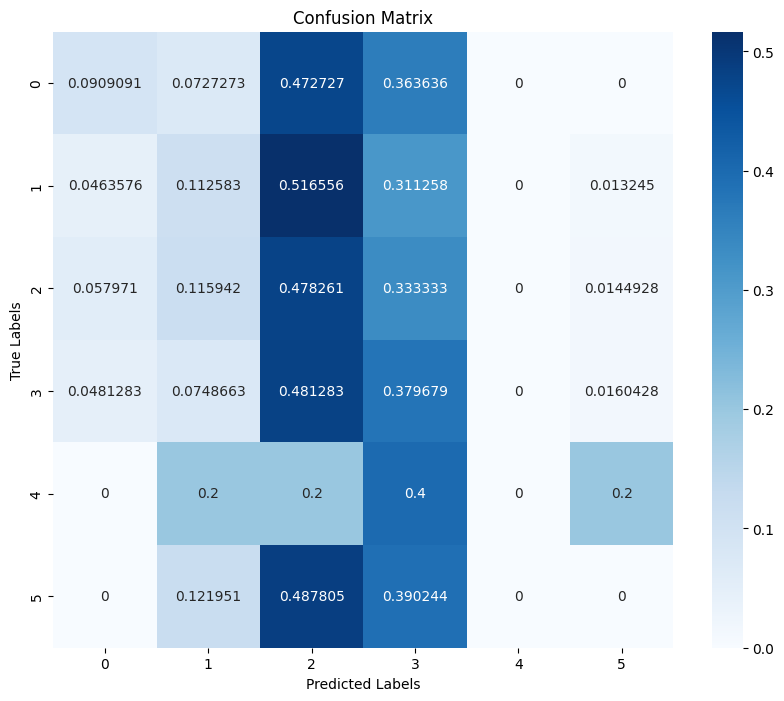

Epoch 13, Validation Loss: 3.6463, Accuracy: 0.2756, F1 Score: 0.2478
Val F1 Score Per Class  [0.11904762 0.16346154 0.3150358  0.36503856 0.         0.        ]


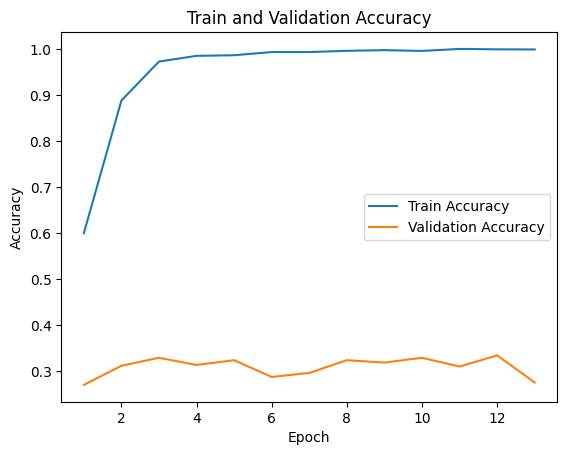

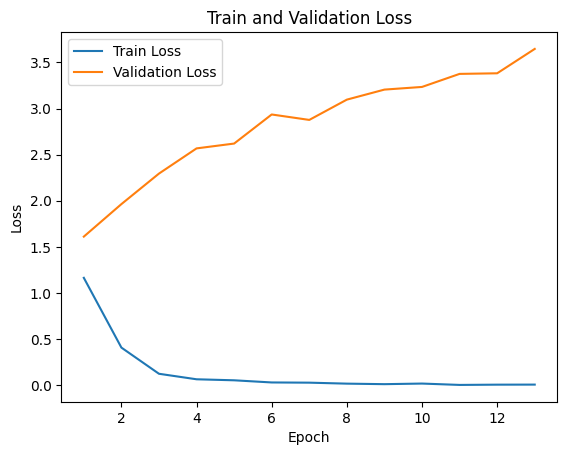

Epoch 14, Train Loss: 0.0053, Accuracy: 0.9987, F1 Score: 0.9987
Train F1 Score Per Class  [0.99889381 0.99871795 0.99765671 0.99703088 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.16it/s, loss=4.62]

[tensor([-4.0355,  1.5616, -2.4955,  2.9632, -3.3970, -3.5131], device='cuda:0'), tensor([-2.4137,  3.6959,  1.0334, -1.7966, -4.5251, -4.5590], device='cuda:0'), tensor([-1.7886, -1.6811, -2.0185,  5.1683, -4.8717, -3.0578], device='cuda:0'), tensor([-2.0960, -0.9150, -2.8059,  5.4618, -3.8057, -2.3280], device='cuda:0'), tensor([-3.8885,  1.9680,  1.4755,  0.9624, -5.0388, -3.3375], device='cuda:0'), tensor([-3.6940,  2.3837,  3.2287, -1.5485, -3.3041, -3.8140], device='cuda:0'), tensor([-2.6769, -2.1326, -2.2432,  4.6923, -3.5573, -0.3878], device='cuda:0'), tensor([-2.6264, -2.9588,  5.3452,  1.0133, -2.7511, -2.2513], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.12it/s, loss=3.87]

[tensor([-1.1973, -1.5317, -2.9908,  3.3012, -4.2705, -1.2498], device='cuda:0'), tensor([-3.7001,  3.6066, -2.9455, -0.6189, -2.9290, -3.0865], device='cuda:0'), tensor([-1.3722, -2.0393,  5.1660, -0.2299, -3.2685, -3.1820], device='cuda:0'), tensor([-1.8856, -1.6756, -0.7494,  5.6964, -3.6400, -3.2541], device='cuda:0'), tensor([-0.9913,  6.5181, -1.3696, -1.9216, -3.0708, -3.0343], device='cuda:0'), tensor([-0.5425, -0.2117, -0.0754, -0.5751, -4.2347, -4.9128], device='cuda:0'), tensor([-1.9552, -1.5333, -1.8543,  5.3606, -3.6443, -3.5854], device='cuda:0'), tensor([ 6.1981, -0.3693, -2.3834, -0.7637, -2.9962, -2.2849], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.14it/s, loss=3.62]

[tensor([-2.3222, -1.2858,  0.5567, -1.3994, -4.6690, -3.8393], device='cuda:0'), tensor([-2.2018, -0.0768,  1.8487, -0.9636, -3.1032, -2.8955], device='cuda:0'), tensor([-2.6397, -2.0947,  5.9625, -0.9118, -3.2140, -2.2723], device='cuda:0'), tensor([-1.4229, -2.8247, -0.4571,  3.2027, -4.0783, -4.4312], device='cuda:0'), tensor([-1.7254,  0.3603, -3.1332,  2.4158, -3.6816, -3.8719], device='cuda:0'), tensor([-1.4799, -0.7491, -2.4258,  2.3954, -4.6659, -4.3705], device='cuda:0'), tensor([-1.6481, -2.7327, -1.7859,  4.1326, -3.9480, -3.4490], device='cuda:0'), tensor([ 0.6287, -1.6020, -0.4335, -1.9539, -3.8204, -3.5337], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.12it/s, loss=2.96]

[tensor([-2.8255, -2.0373,  1.9706,  2.1422, -4.1814, -4.8460], device='cuda:0'), tensor([-3.3843,  0.2558,  1.6671, -2.0402, -3.4612, -3.0364], device='cuda:0'), tensor([-2.8579, -0.4862, -2.3375,  0.4595, -4.4282, -0.1200], device='cuda:0'), tensor([-2.6335, -1.1775,  0.8752, -0.3067, -2.9957, -2.9048], device='cuda:0'), tensor([ 6.8544, -1.5380, -0.7306, -0.8307, -2.5644, -2.9736], device='cuda:0'), tensor([-2.4422, -2.4356, -0.3540,  2.7241, -4.7264, -2.1320], device='cuda:0'), tensor([-1.5560,  5.7400, -0.9980, -1.6048, -3.7878, -3.4152], device='cuda:0'), tensor([-3.7234,  0.7572, -0.4862,  0.9669, -3.6410, -2.3735], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:32,  2.11it/s, loss=3.47]

[tensor([-2.9157, -0.9265, -1.0599,  4.4087, -3.4788, -4.0433], device='cuda:0'), tensor([-2.5642, -2.3308,  3.8732,  2.2005, -3.8342, -4.5440], device='cuda:0'), tensor([-1.9466, -1.9273,  4.7730, -0.6907, -3.8008, -3.3606], device='cuda:0'), tensor([-1.3987, -0.5859, -1.8451,  0.6034, -4.3679, -5.2243], device='cuda:0'), tensor([-2.1203, -1.9672,  4.8167, -0.1733, -3.6459, -3.2508], device='cuda:0'), tensor([-2.0805, -0.0522, -0.0469, -0.2762, -4.4068, -3.8242], device='cuda:0'), tensor([-2.8787,  2.1991, -2.5533, -1.1286, -4.0643, -2.1034], device='cuda:0'), tensor([-1.3068, -0.0485, -2.9437,  4.0699, -3.7858, -2.4327], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.10it/s, loss=4.85]

[tensor([-2.0418, -1.9819,  6.8506, -1.4665, -2.6643, -2.6701], device='cuda:0'), tensor([-2.0627, -1.9044,  6.5987, -1.5227, -2.4116, -1.7587], device='cuda:0'), tensor([-1.7660, -2.6359,  4.4742, -1.1878, -4.3625, -4.1495], device='cuda:0'), tensor([-3.3767, -0.1625, -0.5818,  0.2328, -4.2073, -3.5541], device='cuda:0'), tensor([-1.4264, -2.0431,  6.6877, -1.7302, -2.4107, -2.1514], device='cuda:0'), tensor([-2.2278, -1.8341,  0.0298,  3.0517, -4.2240, -3.7685], device='cuda:0'), tensor([-2.1383, -2.8247,  5.1283,  0.6611, -3.5632, -3.4034], device='cuda:0'), tensor([-2.3192, -2.2676, -1.3814,  3.6412, -3.3105, -3.7965], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:31,  2.12it/s, loss=2.69]

[tensor([-2.1364, -1.6789,  1.0742,  2.0956, -3.9603, -2.8405], device='cuda:0'), tensor([-2.3795, -1.0199, -0.1312,  1.3104, -3.8509, -2.8825], device='cuda:0'), tensor([-0.8444, -2.0749,  6.4736, -1.7390, -2.2578, -2.3306], device='cuda:0'), tensor([-3.1636, -2.7144, -0.3517,  2.4012, -4.2689, -3.3059], device='cuda:0'), tensor([-3.1694,  2.4432,  3.8928, -1.8276, -3.2515, -4.4488], device='cuda:0'), tensor([-2.8312,  0.3575, -0.5480,  1.2659, -4.1575, -2.3717], device='cuda:0'), tensor([-2.7693, -3.2935,  4.7966, -0.8697, -3.4954, -0.8851], device='cuda:0'), tensor([-3.1017e+00, -1.0411e-01, -2.0245e+00,  3.7198e-03, -4.2555e+00,
        -3.5558e+00], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.13it/s, loss=5.5]

[tensor([-1.2667, -2.3599,  0.1487,  0.2164, -4.5139, -4.6694], device='cuda:0'), tensor([-1.7314, -2.0115,  5.3742, -0.9821, -2.5777, -2.5822], device='cuda:0'), tensor([-1.6600, -1.2461, -2.4141,  6.0546, -4.0487, -3.3303], device='cuda:0'), tensor([-0.9198,  5.7429, -2.0527, -0.9559, -3.5526, -3.6703], device='cuda:0'), tensor([-2.4468, -0.9756,  6.2066, -1.5712, -3.1053, -3.1799], device='cuda:0'), tensor([-0.9936, -2.1548, -1.4550,  1.7287, -3.9901, -4.8956], device='cuda:0'), tensor([-2.4335, -2.6194, -2.0133,  1.5485, -4.2081,  1.6412], device='cuda:0'), tensor([-2.0571, -1.8456,  6.6295, -1.3369, -2.3477, -1.8867], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.13it/s, loss=4.57]

[tensor([-3.1488, -0.9678, -2.1845,  0.2756, -4.9601, -2.1371], device='cuda:0'), tensor([-2.7515,  2.5111,  0.7667, -0.7672, -4.4408, -4.6274], device='cuda:0'), tensor([-0.7488,  1.6774, -0.8366,  0.2030, -3.9312, -5.2274], device='cuda:0'), tensor([-1.6591, -2.5782,  1.0769,  0.8190, -3.2078, -3.4407], device='cuda:0'), tensor([-2.0139, -2.5201, -0.2716,  5.5064, -2.9226, -2.6623], device='cuda:0'), tensor([-3.2232,  5.1735, -0.1369, -1.1802, -3.8897, -3.4557], device='cuda:0'), tensor([-2.5600,  0.1002, -2.8166,  4.9357, -4.0136, -3.1906], device='cuda:0'), tensor([-2.5263, -2.5510,  1.6361,  2.4080, -4.1239, -3.3212], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.14it/s, loss=3.19]

[tensor([-2.7542,  4.4028,  0.9054, -1.5245, -3.3714, -3.7671], device='cuda:0'), tensor([-2.8862, -1.8504,  1.1900,  2.4281, -3.8610, -3.7452], device='cuda:0'), tensor([-0.7444,  1.4915, -2.3401, -2.1396, -3.1045, -2.4117], device='cuda:0'), tensor([-2.7839, -1.5620,  2.5636,  2.1459, -3.5144, -5.0331], device='cuda:0'), tensor([-2.4991,  3.2911,  1.9078, -1.3701, -3.8459, -4.0653], device='cuda:0'), tensor([-1.2049, -1.7047,  2.7317,  1.0955, -4.2412, -4.6720], device='cuda:0'), tensor([-3.1115,  2.3107, -2.1665, -0.8253, -3.2018, -2.8548], device='cuda:0'), tensor([-2.3494,  5.6521, -1.6930, -0.1966, -3.9481, -3.8722], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.14it/s, loss=4.69]

[tensor([-2.7423, -1.9923, -0.2699,  5.1969, -3.7097, -3.3871], device='cuda:0'), tensor([-0.8381,  3.5255, -3.1071, -0.3532, -4.1069, -3.1462], device='cuda:0'), tensor([-2.6780, -2.8166,  4.1715,  2.6946, -4.2360, -2.3560], device='cuda:0'), tensor([-2.5296, -2.2203,  0.4293,  2.3557, -5.0014, -4.3522], device='cuda:0'), tensor([-3.4413,  5.2485, -1.4330, -1.0107, -4.3802, -1.8648], device='cuda:0'), tensor([-2.2491,  0.2874, -3.3614,  2.6750, -4.1365, -3.3022], device='cuda:0'), tensor([-3.8327, -1.4204,  2.1680, -1.1029, -3.4575, -3.4927], device='cuda:0'), tensor([-0.8522, -2.1380, -2.6842,  5.5717, -3.5634, -3.9167], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.14it/s, loss=3.36]

[tensor([-2.3222, -2.4232,  5.4766, -0.8316, -2.6657, -3.1230], device='cuda:0'), tensor([-3.6445, -0.1254,  1.2025,  1.1727, -4.0145, -3.9722], device='cuda:0'), tensor([-3.1993, -1.7236,  4.1008,  0.2970, -3.3837, -4.2878], device='cuda:0'), tensor([-2.6945,  3.0266, -2.6463, -1.1954, -3.0707, -3.1889], device='cuda:0'), tensor([ 2.9496, -0.9460, -1.5720, -1.8682, -3.0582, -4.1464], device='cuda:0'), tensor([-1.8242, -2.0451,  6.7223, -0.8928, -2.6695, -2.3473], device='cuda:0'), tensor([-1.6661, -1.4610, -2.4596,  3.6691, -4.4333, -3.3410], device='cuda:0'), tensor([-1.8888, -0.9250,  2.2031, -1.6146, -3.6099, -3.8988], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.14it/s, loss=2.36]

[tensor([-0.3834, -1.7562, -1.1151,  0.1495, -4.7070, -5.0934], device='cuda:0'), tensor([-3.5542,  1.3343,  2.9506,  0.1196, -3.7063, -3.5024], device='cuda:0'), tensor([-3.4250,  1.3777, -0.2930, -0.9883, -5.0716, -3.8998], device='cuda:0'), tensor([-2.9648,  0.3995,  4.5178, -2.3488, -3.8048, -3.2873], device='cuda:0'), tensor([-3.4702,  4.7839, -1.4058, -0.8263, -3.9017, -2.5765], device='cuda:0'), tensor([-2.7747, -1.5810, -0.5126, -0.9947, -4.1874, -2.8017], device='cuda:0'), tensor([-2.6661,  4.5728, -2.2954,  0.4677, -4.3069, -3.0719], device='cuda:0'), tensor([-1.2589,  2.3438, -2.3152,  1.3274, -4.2465, -4.9094], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=1.77]

[tensor([-1.1448, -1.9421, -1.8467, -0.0839, -4.1857, -2.4276], device='cuda:0'), tensor([-3.0892, -0.5957, -1.8906,  1.1906, -4.2341, -3.8239], device='cuda:0'), tensor([-3.0867, -2.7028,  0.4038,  0.2655, -3.0651, -1.1405], device='cuda:0'), tensor([-2.4814,  0.1388, -2.3551,  2.4663, -5.0094, -3.8298], device='cuda:0'), tensor([-2.7172, -1.3954, -2.1030,  6.0715, -2.9045, -1.9582], device='cuda:0'), tensor([-2.6995,  1.7680, -1.9365,  1.2536, -3.9072, -3.2333], device='cuda:0'), tensor([-3.0621,  2.6438,  0.1516, -2.5991, -3.6169, -2.8645], device='cuda:0'), tensor([-2.8558,  0.5571, -1.6283,  3.0027, -4.9364, -4.4787], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:26,  2.16it/s, loss=5.09]

[tensor([-2.8668,  4.7340, -1.3398, -0.7942, -3.8209, -3.2394], device='cuda:0'), tensor([-1.1116,  3.5376, -0.5153, -2.3274, -4.4315, -3.2176], device='cuda:0'), tensor([-2.0511, -1.0770,  6.6618, -1.8828, -2.4752, -1.8848], device='cuda:0'), tensor([-1.8872, -2.6979, -0.7910,  5.7532, -3.8839, -3.5430], device='cuda:0'), tensor([-2.2143, -1.3876, -1.4608,  5.6881, -3.6044, -4.4693], device='cuda:0'), tensor([-2.3483,  1.9960,  0.9397, -2.5180, -3.5527, -3.9255], device='cuda:0'), tensor([-3.9611, -1.5669,  2.3486,  1.7713, -4.7664, -3.0243], device='cuda:0'), tensor([-2.6155, -0.8327,  5.7265, -1.7110, -3.1194, -4.1203], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=2.35]

[tensor([-1.7104, -1.7419, -1.2946,  5.5755, -4.0568, -3.4801], device='cuda:0'), tensor([-2.3233,  3.3633,  0.5230, -2.3621, -3.4540, -3.2307], device='cuda:0'), tensor([-2.7733, -1.5074, -0.8577,  1.1437, -4.2616, -4.6253], device='cuda:0'), tensor([-3.5846,  0.4525,  0.2654,  0.8255, -3.9929, -2.5330], device='cuda:0'), tensor([-2.1860, -2.5627, -1.3107,  1.7042, -3.6919, -3.2167], device='cuda:0'), tensor([-2.7831, -1.6585,  6.2762, -1.1371, -2.6698, -2.2852], device='cuda:0'), tensor([-2.5890, -0.9779, -1.7100,  4.8422, -5.2431, -4.1325], device='cuda:0'), tensor([-3.0495, -1.5035, -0.4336, -0.8709, -3.6395, -2.7828], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.15it/s, loss=3.62]

[tensor([-3.5682, -0.6369, -0.0729,  2.9246, -4.3200, -3.9596], device='cuda:0'), tensor([-0.8824,  0.2316,  2.3887, -1.5580, -4.0976, -3.3994], device='cuda:0'), tensor([-2.2498,  2.6635,  0.2358, -2.9679, -2.9504, -2.7041], device='cuda:0'), tensor([-2.8671, -0.3852, -0.7025,  1.1736, -4.1865, -3.3076], device='cuda:0'), tensor([-2.9246, -3.1387,  0.9554,  3.4219, -3.2242, -1.7878], device='cuda:0'), tensor([-1.7828, -2.3100, -1.5249,  2.8667, -4.3038, -3.1539], device='cuda:0'), tensor([ 1.4319, -1.9764, -0.7684, -0.5731, -4.0273, -3.0517], device='cuda:0'), tensor([-2.2027,  0.0221, -3.3906,  0.9069, -3.8427, -3.6247], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=1.34]

[tensor([-2.7697, -2.6551,  0.2851,  4.3361, -3.8159, -3.6179], device='cuda:0'), tensor([-0.6959, -2.3998,  0.5323,  3.3838, -3.1416, -4.5552], device='cuda:0'), tensor([-3.7904, -1.0694,  0.6602, -1.1483, -4.7630, -0.6030], device='cuda:0'), tensor([-2.3459, -0.2868,  0.9488, -0.9431, -4.0199, -5.0297], device='cuda:0'), tensor([-2.1550, -2.9314,  3.1509, -0.7352, -1.8561, -3.3860], device='cuda:0'), tensor([ 0.3931, -0.8934, -2.3939,  0.0383, -4.7673, -3.3383], device='cuda:0'), tensor([-0.9384, -0.1139,  0.6318, -0.9824, -4.0328, -3.2366], device='cuda:0'), tensor([-3.4410, -1.5848,  0.5389,  3.0690, -4.3047, -4.8972], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.15it/s, loss=2.12]

[tensor([-2.0365, -1.4372,  4.7158, -1.5487, -3.3224, -3.9534], device='cuda:0'), tensor([ 6.1480, -1.9385, -1.8460, -0.6294, -3.0717, -2.9284], device='cuda:0'), tensor([-2.0132, -1.8058,  6.0677, -0.4916, -2.7220, -3.1183], device='cuda:0'), tensor([-2.5535, -2.5698,  0.1895,  4.7698, -3.3077, -3.2867], device='cuda:0'), tensor([-0.9578,  3.7562, -2.4208, -0.1028, -5.2441, -4.6746], device='cuda:0'), tensor([ 0.4560, -1.5179, -2.3259,  2.8477, -3.9643, -4.4505], device='cuda:0'), tensor([-2.0832,  0.5863, -0.7406, -1.2894, -3.7224, -2.5517], device='cuda:0'), tensor([-1.8623,  0.3642,  0.5638, -1.0432, -3.7931, -3.2698], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.15it/s, loss=4.81]

[tensor([-2.7897, -2.4778,  4.5442,  0.7300, -3.6644, -3.2520], device='cuda:0'), tensor([-3.0926,  1.9011, -1.5282, -2.0494, -2.6353, -3.1629], device='cuda:0'), tensor([-2.7054, -2.1532,  0.6231,  2.6299, -3.2105, -2.2721], device='cuda:0'), tensor([-2.1555, -3.3990,  1.7710,  1.1504, -4.3082, -3.0362], device='cuda:0'), tensor([-0.6660,  0.2445,  1.3025, -2.0643, -4.3646, -4.4657], device='cuda:0'), tensor([-2.9046,  4.1295, -1.0024, -0.9965, -3.5996, -2.0164], device='cuda:0'), tensor([-1.9719, -2.7343,  1.0156,  2.2363, -4.1737, -3.6965], device='cuda:0'), tensor([-2.3723, -1.9511,  4.2857, -0.1238, -3.4038, -3.5606], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.16it/s, loss=5.21]

[tensor([-1.3493, -3.0843,  6.0621, -0.9364, -2.7275, -2.2139], device='cuda:0'), tensor([-1.7453,  5.5753, -1.4640, -0.9699, -3.6780, -3.8085], device='cuda:0'), tensor([-3.0977,  2.4520,  3.0754, -2.2845, -3.9712, -3.4007], device='cuda:0'), tensor([-2.0464, -2.6172,  6.3837, -0.2330, -2.7234, -2.8243], device='cuda:0'), tensor([-2.0638, -2.5809,  3.6886,  0.6982, -3.9628, -3.9435], device='cuda:0'), tensor([-1.4914, -0.4420, -0.8940, -2.5105, -3.5925, -2.9032], device='cuda:0'), tensor([-1.8947, -2.1491, -1.4034,  6.2051, -2.8499, -3.0321], device='cuda:0'), tensor([-1.8930, -1.7496, -1.4694,  5.6807, -2.5323, -1.9638], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.16it/s, loss=2.24]

[tensor([-2.3280,  0.5723, -1.2863,  4.3275, -4.8330, -4.4750], device='cuda:0'), tensor([-2.3682, -1.0513, -0.4005,  0.8200, -2.8780, -3.6085], device='cuda:0'), tensor([-2.9840, -1.9956,  2.0234,  0.2681, -3.8391, -3.9748], device='cuda:0'), tensor([-2.7077, -1.5157, -2.0389,  5.5238, -2.6320, -1.2436], device='cuda:0'), tensor([-1.9139, -2.2907,  4.4228, -0.1298, -3.2217, -3.8160], device='cuda:0'), tensor([-1.3997, -2.8583,  2.7720,  0.5042, -3.3761, -3.9737], device='cuda:0'), tensor([-2.6759, -0.0961, -1.5403,  0.1228, -4.4302, -3.3050], device='cuda:0'), tensor([-3.4268, -1.9344,  1.8022,  4.0302, -3.7658, -3.6276], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.13it/s, loss=2.41]

[tensor([-1.7494, -1.2348,  0.3254,  0.4147, -4.1192, -4.2078], device='cuda:0'), tensor([-2.5364, -1.4847, -1.3454,  4.5786, -4.1797, -3.9260], device='cuda:0'), tensor([-1.6068, -0.6633, -2.3515,  4.6810, -2.9442, -3.7783], device='cuda:0'), tensor([-2.7392,  2.3784, -0.6126, -2.1460, -5.0070, -3.3497], device='cuda:0'), tensor([-2.9783,  0.7341, -1.3282,  1.8928, -4.5528, -3.7339], device='cuda:0'), tensor([-1.6464, -1.6661, -2.0920,  6.3903, -2.7332, -2.8343], device='cuda:0'), tensor([-0.8244, -2.8965,  2.6538,  1.0820, -3.6293, -3.8465], device='cuda:0'), tensor([-2.5271, -2.3559,  6.3697, -1.5859, -2.6005, -2.7570], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.14it/s, loss=3.5]

[tensor([-1.8084, -1.4127, -2.8455,  0.4257, -3.7319, -3.4011], device='cuda:0'), tensor([-1.9890, -1.2305, -0.4083,  2.1947, -4.0891, -3.6932], device='cuda:0'), tensor([-1.9794, -2.7546, -0.2385,  4.8319, -3.8003, -3.9366], device='cuda:0'), tensor([-0.8394, -1.9369,  4.8221, -1.8671, -2.8825, -4.3389], device='cuda:0'), tensor([-2.5695,  0.4316,  5.1382, -2.1967, -3.0119, -3.7537], device='cuda:0'), tensor([-1.8197, -2.5199,  4.1093,  0.5607, -3.3745, -4.4480], device='cuda:0'), tensor([-2.9581, -1.4701, -2.5914,  5.0929, -2.5905, -1.2385], device='cuda:0'), tensor([-1.7879,  2.8035, -2.3117, -0.0557, -5.2535, -3.2433], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=3.92]

[tensor([-2.8040,  1.0373, -0.7589,  2.7706, -5.2192, -3.1073], device='cuda:0'), tensor([-2.1678,  4.0594, -2.3143,  0.8557, -4.5024, -3.3099], device='cuda:0'), tensor([-2.6580,  1.7021, -0.1599, -1.2024, -3.8934, -3.9391], device='cuda:0'), tensor([-1.9262, -2.1537,  5.6763, -1.0362, -2.5740, -3.2837], device='cuda:0'), tensor([-1.9355,  0.9093, -0.3046,  0.2772, -4.6221, -4.9080], device='cuda:0'), tensor([-1.7591,  5.6702, -1.2591, -2.1254, -3.1910, -2.6648], device='cuda:0'), tensor([-3.1540,  0.7517, -2.2206, -1.5440, -4.8056, -1.9808], device='cuda:0'), tensor([-2.7531,  4.5270, -2.8922, -0.2029, -4.1524, -1.2525], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=3.85]

[tensor([-1.4134,  5.5184, -2.7437, -1.3614, -3.4847, -1.3821], device='cuda:0'), tensor([-2.7805, -0.9480,  3.2161, -2.5350, -3.7288, -2.2333], device='cuda:0'), tensor([-3.2543, -0.5649,  2.8043,  0.6718, -4.2222, -4.4112], device='cuda:0'), tensor([-1.4977, -1.6617,  2.4986, -2.4305, -3.8014, -4.4178], device='cuda:0'), tensor([-1.4412,  5.8332, -2.5585, -0.2065, -3.6750, -3.5702], device='cuda:0'), tensor([-2.9005, -1.1810, -0.7734,  3.6273, -3.0238, -3.0572], device='cuda:0'), tensor([ 0.3267, -2.3110,  0.6396, -0.2315, -3.7596, -3.6786], device='cuda:0'), tensor([-1.1838, -3.3361,  1.7859,  2.4164, -3.5437, -3.0377], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.14it/s, loss=3.4]

[tensor([-2.7507,  1.1789, -3.0934,  3.0327, -3.7667, -1.9091], device='cuda:0'), tensor([-1.7401,  5.1607,  0.3794, -1.7880, -3.2702, -4.1706], device='cuda:0'), tensor([-2.3065, -0.4037, -1.2238,  0.2717, -4.3055, -2.1518], device='cuda:0'), tensor([-2.8762, -1.4387, -1.3721,  3.8873, -3.3238, -3.2565], device='cuda:0'), tensor([-2.0127, -1.5483, -1.2274,  1.1233, -3.5577, -2.9461], device='cuda:0'), tensor([-3.3388, -0.0962,  1.1820,  2.0672, -4.1608, -5.0904], device='cuda:0'), tensor([-2.8560, -1.6390,  5.1137, -1.2269, -3.4322, -3.1722], device='cuda:0'), tensor([-2.4802,  5.0441, -2.2574, -0.0080, -3.1665, -2.6243], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.14it/s, loss=3.45]

[tensor([-0.9886, -1.6261,  5.9659, -1.6213, -2.6521, -2.9151], device='cuda:0'), tensor([-2.1471, -2.3730,  3.5689,  0.5297, -3.5788, -3.5716], device='cuda:0'), tensor([-1.0367, -2.4563,  1.5852,  1.0063, -4.4548, -4.7386], device='cuda:0'), tensor([-2.0423, -2.1971,  5.6031, -0.2573, -3.1110, -2.5565], device='cuda:0'), tensor([-2.1043, -1.4159,  6.4003, -1.3903, -2.6646, -2.8342], device='cuda:0'), tensor([-1.8940,  2.3545,  0.2593, -1.3616, -3.7589, -3.2539], device='cuda:0'), tensor([-2.0711, -2.8341,  2.9983,  1.2739, -3.6551, -1.9515], device='cuda:0'), tensor([-1.1233, -2.1185,  6.0966, -0.6741, -3.0020, -2.8764], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.14it/s, loss=5.13]

[tensor([ 5.2965, -1.4519, -1.4196, -1.3464, -3.1711, -1.5809], device='cuda:0'), tensor([-3.3453, -1.3289,  4.6093, -1.8033, -3.7437, -3.5906], device='cuda:0'), tensor([-0.7690,  0.1138, -2.0637,  2.6388, -3.9184, -4.9131], device='cuda:0'), tensor([-1.5234, -0.8520,  2.9007, -0.2802, -2.9618, -2.4451], device='cuda:0'), tensor([-2.5862,  5.1698, -0.4228, -0.1982, -3.7347, -4.2841], device='cuda:0'), tensor([-2.1300, -1.8930,  6.2342, -1.3074, -2.7438, -1.6986], device='cuda:0'), tensor([-1.7663, -2.0335,  5.0408, -0.4816, -3.3563, -2.6936], device='cuda:0'), tensor([-3.4685,  3.8112, -0.3212, -1.1141, -3.2986, -3.4314], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.14it/s, loss=4.95]

[tensor([-1.4813,  1.9383,  0.4624, -1.9094, -4.6870, -4.4560], device='cuda:0'), tensor([-1.8543, -2.6858,  4.4320,  1.8571, -3.3905, -3.1920], device='cuda:0'), tensor([-4.0074,  1.1908, -1.1035,  0.1766, -4.8537, -1.9987], device='cuda:0'), tensor([-3.0712, -0.5209, -1.7497,  0.1681, -3.3819, -0.9828], device='cuda:0'), tensor([-2.0054, -1.8659, -0.9956,  5.3397, -3.2047, -3.4214], device='cuda:0'), tensor([-0.8172, -2.1862,  5.0909, -1.5980, -2.9312, -3.6105], device='cuda:0'), tensor([ 0.0688, -2.5458,  4.0633, -0.7805, -2.0139, -2.0055], device='cuda:0'), tensor([ 5.1339, -1.0105, -2.5213, -0.0991, -3.2600, -2.1434], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=2.74]

[tensor([-2.5871, -3.0355,  1.1573,  4.0807, -3.2634, -2.6478], device='cuda:0'), tensor([-0.7007, -1.9162, -1.8596,  0.5550, -4.9716, -3.8679], device='cuda:0'), tensor([-2.8011, -1.7384,  5.3085,  0.5294, -4.1377, -2.8016], device='cuda:0'), tensor([ 2.1673, -2.5930,  0.4117,  0.8214, -5.0178, -4.7196], device='cuda:0'), tensor([-0.1856, -1.6626,  2.1065, -1.6290, -4.4132, -4.5912], device='cuda:0'), tensor([-2.2210, -0.4746, -1.2907, -0.7508, -3.7088, -1.8730], device='cuda:0'), tensor([-0.7021,  4.9279, -2.7855, -1.4739, -3.2208, -3.4210], device='cuda:0'), tensor([-3.0888,  1.1400, -1.5534,  3.1567, -4.7396, -5.4625], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.15it/s, loss=3.84]

[tensor([-3.0792,  0.9911,  3.2437, -2.6141, -3.3842, -1.4529], device='cuda:0'), tensor([-1.4929, -1.4328,  2.0156, -0.1533, -4.6362, -5.0162], device='cuda:0'), tensor([ 0.5290, -2.1786, -0.1444,  1.3430, -4.5406, -5.3058], device='cuda:0'), tensor([-2.6006, -2.1109,  3.2579,  0.5327, -3.5769, -3.2291], device='cuda:0'), tensor([-3.0683, -1.4198,  4.9550, -1.0292, -2.9205, -3.0501], device='cuda:0'), tensor([-2.1880,  6.4508, -0.7488, -1.8961, -3.1047, -2.6383], device='cuda:0'), tensor([-1.9341, -1.2951, -1.3580, -1.1296, -2.4348,  7.6798], device='cuda:0'), tensor([ 0.3501, -2.5979, -0.5232, -0.7188, -2.6678, -3.8831], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.16it/s, loss=3.87]

[tensor([-3.0151, -1.0602,  1.8003, -0.1311, -4.3888, -4.0223], device='cuda:0'), tensor([-1.5362,  3.4715, -2.0834, -0.5455, -2.6890, -4.0887], device='cuda:0'), tensor([-2.7875, -1.4612,  1.1124, -1.5643, -3.8097, -4.0795], device='cuda:0'), tensor([-3.5490,  1.4260, -2.7940,  0.2720, -3.5385,  3.1679], device='cuda:0'), tensor([-1.7720, -1.8806, -2.0662,  3.0498, -3.6323, -4.2295], device='cuda:0'), tensor([-3.8827, -1.5245, -0.8524,  2.4898, -3.5974, -3.9874], device='cuda:0'), tensor([-2.3882, -2.1018, -0.4524,  4.8197, -3.8850, -3.7180], device='cuda:0'), tensor([ 3.6067, -2.7060, -2.1735,  1.6283, -2.9025, -3.2205], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.16it/s, loss=3.52]

[tensor([-2.5534, -1.0244,  4.5227, -0.7151, -4.7840, -3.2575], device='cuda:0'), tensor([-2.3176, -2.1707,  1.6166, -0.3151, -3.3199, -3.6088], device='cuda:0'), tensor([-1.6864, -1.2628,  6.7647, -1.7949, -2.2933, -2.5238], device='cuda:0'), tensor([ 1.1557, -2.4328,  4.0461, -1.4964, -3.6171, -3.0768], device='cuda:0'), tensor([-2.3022, -0.6943, -2.4575,  5.3314, -3.8624, -3.0507], device='cuda:0'), tensor([-2.2847, -1.3071,  6.7297, -1.7117, -2.4306, -2.4226], device='cuda:0'), tensor([ 1.0704, -2.7549, -1.2528,  0.3864, -3.3641, -3.1571], device='cuda:0'), tensor([-2.8375,  2.8195, -0.2652, -0.8225, -3.7711, -3.8808], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=2.65]

[tensor([-1.0563, -1.8976, -1.4736,  4.3566, -2.9661, -4.6276], device='cuda:0'), tensor([-2.4431, -1.1383,  1.5199, -2.7542, -3.0299, -0.3326], device='cuda:0'), tensor([-1.6749, -0.5803, -2.3833,  2.2090, -4.6125, -3.7545], device='cuda:0'), tensor([ 0.2681, -2.3460,  3.5623, -1.3175, -3.4996, -2.9496], device='cuda:0'), tensor([-2.1969, -0.1320,  0.8130, -1.4807, -3.2319, -2.6144], device='cuda:0'), tensor([-2.4937, -1.6339, -1.7379,  5.1450, -3.6851, -2.2309], device='cuda:0'), tensor([ 0.6326, -2.0349, -1.4836,  1.5314, -5.1750, -2.7919], device='cuda:0'), tensor([-3.1192,  3.9231, -2.0488, -0.9154, -4.0262, -2.0318], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.15it/s, loss=2.18]

[tensor([-2.3804, -0.5446, -1.0738, -1.1665, -4.0146, -3.8548], device='cuda:0'), tensor([-1.2568, -1.8571, -1.7931,  0.9276, -4.4227, -3.5412], device='cuda:0'), tensor([-3.5143, -0.3948, -2.3676,  2.8100, -3.0656, -4.0264], device='cuda:0'), tensor([-3.0241,  0.6924,  0.9338, -0.2675, -4.0080, -4.0622], device='cuda:0'), tensor([-1.6992, -2.7611,  3.3262,  2.0643, -3.5250, -4.3666], device='cuda:0'), tensor([-2.7395,  2.6034,  0.9444, -2.0203, -3.1509, -4.3690], device='cuda:0'), tensor([-3.2968,  2.1517,  2.0154, -2.3897, -4.4130, -3.4498], device='cuda:0'), tensor([-3.3017,  0.5029,  1.5597, -1.8228, -3.1283, -3.8132], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=4.39]

[tensor([-1.9267, -0.8863, -1.6537,  2.7130, -4.2702, -4.2768], device='cuda:0'), tensor([-3.0615,  4.9180, -1.9984,  0.3099, -2.9607, -3.4802], device='cuda:0'), tensor([-1.6157, -0.7366, -2.6289,  5.2593, -5.0454, -2.4630], device='cuda:0'), tensor([-2.1046, -0.7247,  6.3348, -1.9709, -2.9325, -3.2926], device='cuda:0'), tensor([-2.9742,  0.1824, -0.7011, -1.5276, -3.3990, -2.5270], device='cuda:0'), tensor([-2.4590,  2.2327, -0.4298, -1.8547, -3.2068, -3.0007], device='cuda:0'), tensor([-2.4407,  4.1955,  1.4085, -1.9977, -3.9056, -3.9853], device='cuda:0'), tensor([-2.4798, -2.0127, -1.7274,  4.4715, -3.8780, -2.4775], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=4.78]

[tensor([-3.1861, -0.7437, -2.6117,  2.3232, -3.6673, -1.0998], device='cuda:0'), tensor([-2.3861, -2.0981,  3.9433,  1.1133, -2.2013, -2.9738], device='cuda:0'), tensor([-2.8073, -0.7609, -0.9173,  5.5702, -3.5018, -4.1751], device='cuda:0'), tensor([-1.8989, -1.1336,  5.4689, -1.9102, -3.3696, -3.1123], device='cuda:0'), tensor([-1.9473, -1.7474,  6.3172, -1.4373, -2.8483, -1.4783], device='cuda:0'), tensor([-1.1450, -2.6980,  0.9926,  1.7354, -3.4807, -3.8392], device='cuda:0'), tensor([-2.7706,  3.5914, -2.0381, -0.8304, -2.8270, -2.5289], device='cuda:0'), tensor([ 0.8437,  1.7574, -2.2741, -2.1308, -3.7675, -3.2994], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=4.08]

[tensor([-1.8620,  2.5512,  2.6579, -2.0713, -3.9747, -3.9151], device='cuda:0'), tensor([-2.4097, -1.1125, -2.8649,  3.4202, -2.2431, -0.7823], device='cuda:0'), tensor([ 2.7285, -0.6275, -2.9528, -0.1604, -3.6418, -3.9712], device='cuda:0'), tensor([-2.1378,  2.6497, -1.4474,  0.3601, -4.7784, -5.2191], device='cuda:0'), tensor([-1.7055,  1.3370, -2.2817,  2.6677, -4.5264, -4.8637], device='cuda:0'), tensor([-1.6620, -2.7076,  5.6269, -1.0587, -3.0945, -2.8480], device='cuda:0'), tensor([-1.6398, -1.4220, -1.8232,  1.1660, -2.7840, -4.7462], device='cuda:0'), tensor([-1.9837, -2.1409,  6.6878, -1.2069, -2.4760, -2.4167], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=2.97]

[tensor([-3.0280,  2.3220,  0.0769, -1.0998, -3.9666, -4.3828], device='cuda:0'), tensor([-3.4165, -2.0088, -1.7549,  3.1677, -4.0628, -2.7891], device='cuda:0'), tensor([-3.8247,  0.5180, -1.5379,  0.1386, -3.5885, -3.7454], device='cuda:0'), tensor([-1.5256, -2.0025,  6.7844, -2.1189, -2.1604, -2.0591], device='cuda:0'), tensor([-1.4909,  1.3844, -2.5438,  2.3521, -2.3440, -4.7413], device='cuda:0'), tensor([-2.8426, -2.4861,  4.2268, -2.0608, -3.3429, -1.8106], device='cuda:0'), tensor([-1.8581, -3.0626,  0.9273,  1.3942, -4.7642, -3.1873], device='cuda:0'), tensor([-1.5148, -2.7856,  1.5375,  0.1412, -2.1198, -3.7914], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:15,  2.13it/s, loss=3.49]

[tensor([-1.8267, -1.8688, -1.6240,  6.3808, -2.8257, -3.3306], device='cuda:0'), tensor([-1.8303, -1.9902, -2.3478,  6.1317, -3.7999, -2.3375], device='cuda:0'), tensor([-2.7153, -1.5613, -0.7361,  4.0719, -4.1219, -3.2873], device='cuda:0'), tensor([-1.3015, -1.0617, -3.4108,  4.3649, -3.8015, -2.4770], device='cuda:0'), tensor([-2.4496, -0.3151,  1.6198, -1.5042, -3.2810, -3.7604], device='cuda:0'), tensor([-2.5242, -1.8755,  6.1965, -0.4691, -2.6875, -2.8135], device='cuda:0'), tensor([-0.7793, -0.2063, -1.3335, -0.2416, -4.0800, -4.0794], device='cuda:0'), tensor([-0.8844, -2.1222,  6.1848, -1.0439, -2.7150, -2.6384], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.14it/s, loss=3.53]

[tensor([-3.7399,  1.2219, -0.8738, -0.4603, -4.4388, -2.0773], device='cuda:0'), tensor([-1.4639, -1.8533, -2.3121,  4.7674, -3.3240, -4.1213], device='cuda:0'), tensor([ 7.0971, -1.7997, -1.2325, -1.0719, -2.3126, -1.0922], device='cuda:0'), tensor([-2.4203,  5.9727, -2.1907, -0.7655, -2.8739, -3.3301], device='cuda:0'), tensor([-2.0089, -1.1310, -3.0621,  2.5206, -4.1836, -2.9434], device='cuda:0'), tensor([-2.7759,  0.7704, -0.8794,  2.5318, -4.7933, -3.7125], device='cuda:0'), tensor([-0.5365, -0.1328, -1.3694,  2.8896, -4.7965, -4.7678], device='cuda:0'), tensor([-2.5302, -0.9514,  0.6521, -1.8451, -3.9037, -1.1749], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.15it/s, loss=2.53]

[tensor([-2.8778, -0.8010, -0.9431,  1.4856, -4.4547, -2.9475], device='cuda:0'), tensor([-3.6371, -2.2484, -1.0264,  0.0566, -2.8814, -2.4652], device='cuda:0'), tensor([-3.0289, -2.7566,  1.9213,  2.7183, -4.5470, -3.1015], device='cuda:0'), tensor([-2.0657, -1.9775, -1.1085,  6.1636, -4.1377, -3.1585], device='cuda:0'), tensor([-2.8651,  3.1360,  1.3502, -0.9613, -4.2119, -4.1518], device='cuda:0'), tensor([-1.8421, -2.0196, -1.9745,  3.6000, -5.7568, -3.6325], device='cuda:0'), tensor([-1.8923, -2.8042,  1.6902,  4.3536, -3.9031, -4.3055], device='cuda:0'), tensor([-1.2476, -1.9208, -0.3952,  2.3672, -3.9954, -4.7971], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.15it/s, loss=3.24]

[tensor([ 1.2612, -2.2256,  0.3523,  1.8770, -3.4012, -4.7110], device='cuda:0'), tensor([ 0.0877, -2.1729, -0.5545, -1.2411, -2.5446, -3.7063], device='cuda:0'), tensor([-3.8823, -2.1485,  0.0338,  1.2041, -4.3711, -3.1911], device='cuda:0'), tensor([-3.8992, -1.3408,  2.0591,  0.3106, -4.9373, -3.0601], device='cuda:0'), tensor([-2.1327, -2.1835,  0.7538,  1.4664, -2.1272, -2.3694], device='cuda:0'), tensor([-3.9458,  0.0861,  3.4533,  0.1656, -4.0819, -3.7917], device='cuda:0'), tensor([ 0.7238, -1.9338,  2.3672, -0.1214, -3.5892, -3.1220], device='cuda:0'), tensor([-2.0791,  4.6784, -2.4742, -0.6733, -3.1575, -1.2494], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:12,  2.15it/s, loss=3.45]

[tensor([ 2.7040,  0.0635, -3.4136, -1.7214, -4.2275, -1.3903], device='cuda:0'), tensor([-2.7678,  1.6298, -2.8722,  1.1476, -2.9147, -3.0011], device='cuda:0'), tensor([-2.6142,  2.1403, -2.8024,  0.8287, -3.4589, -1.7167], device='cuda:0'), tensor([-2.3723, -1.1899, -1.0164, -0.9331, -3.6574, -3.3521], device='cuda:0'), tensor([-2.1563, -2.4933,  5.7556, -0.2099, -3.1842, -2.5586], device='cuda:0'), tensor([-1.8377, -1.8058, -2.2730, -1.2679, -2.7543,  6.9323], device='cuda:0'), tensor([-3.5143,  2.2314,  1.6868, -0.5953, -3.8614, -3.3829], device='cuda:0'), tensor([-3.2574, -1.6783, -1.4335,  2.7363, -4.2729, -2.4204], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=3.9]

[tensor([-2.6544, -1.0313,  5.2425, -1.6626, -3.5662, -3.5032], device='cuda:0'), tensor([-1.1658,  1.5956, -1.1589, -0.2970, -2.2809, -3.0668], device='cuda:0'), tensor([-2.4529, -1.5768,  3.0240, -0.3378, -3.8574, -4.8840], device='cuda:0'), tensor([-1.8349, -1.8769,  6.6052, -1.9609, -2.4707, -1.3671], device='cuda:0'), tensor([-3.4107,  0.2121, -2.6209,  2.2822, -3.1235, -2.4252], device='cuda:0'), tensor([-2.5843,  5.8163, -2.3479, -0.1656, -2.7559, -3.2538], device='cuda:0'), tensor([-2.6184, -0.6354,  4.0612,  0.0558, -4.0724, -3.9372], device='cuda:0'), tensor([-2.2995, -1.8154,  4.9133, -1.3432, -2.8702, -3.4846], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=2.71]

[tensor([ 4.9796, -1.6452, -3.1879, -0.0790, -2.9678, -2.5822], device='cuda:0'), tensor([-2.1997, -1.3812, -0.3567,  2.8193, -5.5081, -3.6216], device='cuda:0'), tensor([-3.2491, -1.7771,  1.3746,  0.7036, -3.4416, -3.2057], device='cuda:0'), tensor([-1.8214, -1.0083,  5.4343, -1.5177, -3.3641, -3.4186], device='cuda:0'), tensor([-1.7782,  2.2609,  3.0617, -1.1225, -3.9742, -4.2624], device='cuda:0'), tensor([-2.4702, -0.1416, -2.5649,  2.6987, -4.4407, -3.2478], device='cuda:0'), tensor([-1.3909, -1.3844, -0.9328,  0.2795, -1.5539, -4.3394], device='cuda:0'), tensor([-2.4589, -1.2251, -0.9442,  4.9010, -4.3186, -3.9040], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.16it/s, loss=3.27]

[tensor([-1.7944, -1.7646,  6.8080, -1.8479, -2.5761, -1.8684], device='cuda:0'), tensor([-2.9669,  0.4494, -1.0785,  1.3047, -4.7760, -4.6929], device='cuda:0'), tensor([-2.3586,  6.3201, -0.8999, -1.8173, -3.1671, -2.7202], device='cuda:0'), tensor([-1.9736,  4.7710, -1.2662, -0.6319, -4.0690, -3.9107], device='cuda:0'), tensor([-1.5300, -2.0715, -1.8521,  6.3036, -3.2683, -3.0421], device='cuda:0'), tensor([ 1.1154, -0.7650, -0.9376, -0.9222, -3.5225, -1.9003], device='cuda:0'), tensor([-1.4508, -0.9478,  0.4659,  0.0700, -4.9009, -5.0429], device='cuda:0'), tensor([-3.6190, -1.5652,  1.3153,  1.4019, -3.6532, -3.3886], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.16it/s, loss=4.07]

[tensor([-2.6337, -1.6963,  5.8187, -0.8934, -3.0043, -3.3247], device='cuda:0'), tensor([-0.3446,  0.9937, -2.1459,  0.5648, -3.8848, -4.3908], device='cuda:0'), tensor([-2.5613, -1.2843,  6.2462, -1.3375, -2.1722, -2.2972], device='cuda:0'), tensor([-1.8182, -2.3856,  6.0534, -0.8842, -2.8278, -2.2272], device='cuda:0'), tensor([-3.0356,  3.0205,  2.9161, -2.2709, -3.5920, -3.1694], device='cuda:0'), tensor([-0.5097, -3.3828,  1.4048, -0.3801, -3.4879, -4.0795], device='cuda:0'), tensor([-2.4097,  5.7598, -1.1323, -1.6451, -3.7474, -1.7152], device='cuda:0'), tensor([-2.7050, -2.3952, -0.8118,  5.2358, -3.6632, -2.8956], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=3.59]

[tensor([-0.0509, -1.6532, -1.0327, -0.5602, -5.1322, -3.6929], device='cuda:0'), tensor([-2.7582, -1.8175, -0.9753,  3.0782, -4.7983, -3.8782], device='cuda:0'), tensor([-3.3874,  0.0050,  1.6673,  2.5346, -3.4981, -3.1606], device='cuda:0'), tensor([-1.6471,  3.6188,  1.6334, -1.5728, -5.8404, -3.3764], device='cuda:0'), tensor([-1.9095, -1.4632,  4.7901, -1.6283, -4.2284, -4.0812], device='cuda:0'), tensor([-2.0737, -1.9314, -2.0725,  6.2094, -2.7140, -2.0830], device='cuda:0'), tensor([-2.5493, -1.8802, -0.8239,  5.9306, -3.4899, -2.2852], device='cuda:0'), tensor([-3.1332,  0.9215, -1.0746, -0.6462, -4.4897, -5.0571], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.10it/s, loss=2.14]

[tensor([-1.8427, -2.5791,  5.2583,  0.3900, -3.6634, -3.1790], device='cuda:0'), tensor([-1.8514, -2.0698, -2.0255,  6.4024, -3.5088, -2.1094], device='cuda:0'), tensor([-3.6838,  0.7866,  2.1127, -0.4780, -3.6342, -1.7269], device='cuda:0'), tensor([-2.0345, -1.5762, -1.5834,  6.0464, -3.4212, -3.6567], device='cuda:0'), tensor([-2.6431,  1.6203,  1.0212, -1.0317, -3.7509, -3.9310], device='cuda:0'), tensor([-0.3194, -0.0982, -3.7361,  3.9883, -4.4442, -2.6491], device='cuda:0'), tensor([-1.8876, -1.3456, -1.5093,  5.5174, -3.9069, -3.0313], device='cuda:0'), tensor([-0.7110,  1.9232, -1.7574, -3.3530, -3.6835,  1.0276], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:10,  2.08it/s, loss=2.59]

[tensor([-3.5805, -0.3877, -0.1731, -0.4747, -4.7027, -1.5646], device='cuda:0'), tensor([-1.0381, -2.7872,  0.6306,  4.4296, -3.6326, -4.6151], device='cuda:0'), tensor([ 0.5370, -0.6023, -2.7234,  0.6497, -1.0075, -4.3151], device='cuda:0'), tensor([-2.3894,  3.2467, -2.3973,  0.7176, -4.2391, -2.8301], device='cuda:0'), tensor([-2.6951, -2.4763,  0.2551, -0.7665, -3.6967,  1.5278], device='cuda:0'), tensor([-2.1858,  6.4005, -2.2406, -1.9109, -2.3852, -2.2268], device='cuda:0'), tensor([ 2.3057, -2.8828,  2.8399, -1.3537, -3.2865, -2.6003], device='cuda:0'), tensor([-2.5170,  5.3820, -0.8869, -1.1536, -3.8947, -3.0850], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.04it/s, loss=3.25]

[tensor([-2.3096,  0.2729, -2.8170,  4.3887, -3.7844, -3.4134], device='cuda:0'), tensor([-1.2605, -2.6000, -0.1636,  1.6297, -3.7735, -4.1967], device='cuda:0'), tensor([-2.8904, -2.5464, -0.6268,  1.5261, -4.7957,  0.3785], device='cuda:0'), tensor([-0.2456,  0.0790, -0.8792,  0.5637, -4.1897, -4.6038], device='cuda:0'), tensor([ 3.3655, -1.5041,  0.5727, -2.1298, -3.3422, -2.5229], device='cuda:0'), tensor([-1.2546, -1.5111, -2.5461,  2.3043, -4.5809, -4.8452], device='cuda:0'), tensor([-1.7534, -1.9030,  3.0948,  2.3497, -4.7296, -4.6651], device='cuda:0'), tensor([-2.6047, -1.2217,  6.6237, -1.3365, -2.8070, -3.0184], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:09,  2.02it/s, loss=3.05]

[tensor([-3.3586, -2.6355,  1.9552,  1.5921, -3.7939, -2.8300], device='cuda:0'), tensor([ 1.0031, -2.3218, -1.0073,  0.0543, -4.5286, -3.7990], device='cuda:0'), tensor([-2.1429,  0.4869,  1.9240, -2.1277, -3.7614, -1.9176], device='cuda:0'), tensor([-1.8633, -2.0617, -0.8175,  5.9998, -4.3054, -2.9413], device='cuda:0'), tensor([-3.0864, -2.3759,  0.1473,  4.7102, -4.2546, -3.4930], device='cuda:0'), tensor([-2.7781, -0.7898, -2.0519, -0.6799, -4.3111, -2.0453], device='cuda:0'), tensor([-1.8679,  4.3051,  0.9397, -2.1665, -3.3879, -3.6703], device='cuda:0'), tensor([-3.4602, -0.3102, -1.1247, -1.7548, -4.5827,  2.5353], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.02it/s, loss=3.84]

[tensor([-1.9215, -1.9217,  6.5668, -1.1748, -2.4419, -2.1243], device='cuda:0'), tensor([-0.6803, -1.2163,  4.6571, -1.2571, -3.8837, -4.7285], device='cuda:0'), tensor([ 1.1709, -1.8181, -0.5199, -1.2966, -3.2996, -4.2675], device='cuda:0'), tensor([-1.8144,  2.7659, -1.6046, -1.8231, -3.8568, -2.9386], device='cuda:0'), tensor([-2.6548,  4.6535, -1.4576, -1.1050, -2.5844, -2.8663], device='cuda:0'), tensor([-1.5404, -1.4564,  3.9913, -1.4076, -3.0332, -3.1995], device='cuda:0'), tensor([-2.3518, -2.6907, -0.8527,  5.6158, -3.2013, -2.8628], device='cuda:0'), tensor([-1.6192,  5.6445, -1.1562, -1.3862, -3.9761, -3.9346], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:08,  2.06it/s, loss=3.02]

[tensor([-3.0798,  0.0737,  1.1092, -1.3950, -4.2639, -3.3271], device='cuda:0'), tensor([-2.5067,  2.1465, -2.5117,  1.1127, -2.5195, -3.6920], device='cuda:0'), tensor([-1.9050, -3.1282,  4.7266, -0.4207, -4.2578, -2.3575], device='cuda:0'), tensor([-2.9191, -0.7629,  0.3071,  0.4266, -4.5110, -4.8190], device='cuda:0'), tensor([-2.4418,  5.2423,  0.8903, -1.4664, -3.3612, -3.9046], device='cuda:0'), tensor([-1.9902, -2.5536, -1.3970,  5.5061, -4.2536, -1.6960], device='cuda:0'), tensor([-2.5150, -0.6763, -2.0285, -0.7745, -4.1101, -3.9974], device='cuda:0'), tensor([-2.2480,  0.7110, -2.5366,  4.6550, -3.3031, -2.6519], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.09it/s, loss=3.21]

[tensor([-1.7752,  5.1950, -1.5666, -1.2770, -2.2797, -2.6308], device='cuda:0'), tensor([-2.4700, -0.8048, -0.2314, -0.3430, -3.9931, -4.6995], device='cuda:0'), tensor([-1.2830, -1.2250,  3.2147, -0.9884, -4.4001, -3.4800], device='cuda:0'), tensor([-1.3340, -2.6338, -1.2888,  0.5300, -3.7318, -4.2223], device='cuda:0'), tensor([-2.3192, -2.3104, -1.5804,  5.5152, -3.4597, -1.9433], device='cuda:0'), tensor([-1.8273, -0.2800,  1.2026, -1.2715, -3.5774, -3.9740], device='cuda:0'), tensor([-0.4121,  4.0788, -2.9125, -1.0233, -3.0222, -4.0823], device='cuda:0'), tensor([-2.3603, -1.6660, -0.5628,  4.8011, -3.1608, -3.1894], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.11it/s, loss=3.6]

[tensor([-3.0939, -1.5513,  3.1409,  0.9645, -3.7598, -4.9072], device='cuda:0'), tensor([-1.0841, -2.0842,  0.9092, -0.8445, -2.5738, -4.3171], device='cuda:0'), tensor([-2.8951,  4.7118, -0.7006, -1.3870, -3.4259, -2.1421], device='cuda:0'), tensor([-0.7143, -0.5296, -3.6866,  3.2053, -1.7780, -3.2993], device='cuda:0'), tensor([-3.3530, -0.4007,  1.1224, -1.3767, -4.1570, -4.4300], device='cuda:0'), tensor([-2.9918, -0.4171,  4.5429,  1.4459, -3.8780, -4.2344], device='cuda:0'), tensor([-2.7391,  0.3520,  4.7799, -1.9663, -3.4806, -3.3598], device='cuda:0'), tensor([-2.6574, -0.4708,  0.9796,  0.6408, -4.1546, -4.5407], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.10it/s, loss=2.36]

[tensor([-1.7499, -2.2519, -1.6402,  5.2323, -3.2005, -3.6648], device='cuda:0'), tensor([-2.8786,  1.6793, -0.5905, -2.3995, -4.7607, -3.8313], device='cuda:0'), tensor([-0.9771,  2.0104, -3.5852,  1.5228, -3.9191, -3.2372], device='cuda:0'), tensor([-2.4369, -1.4094, -0.3380,  2.1461, -5.1088, -3.9216], device='cuda:0'), tensor([-2.5875,  1.5776,  0.5051, -1.2878, -3.6642, -3.6428], device='cuda:0'), tensor([ 3.9493, -0.0426, -1.9074, -1.1352, -2.6362, -4.4572], device='cuda:0'), tensor([-2.5649,  4.9427, -1.0061, -1.2362, -3.7509, -4.3274], device='cuda:0'), tensor([-2.0252, -3.1414,  0.9698, -0.9131, -3.4448, -2.7374], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.10it/s, loss=3.03]

[tensor([-2.0026, -0.9128, -1.4399,  4.4972, -3.2991, -2.6246], device='cuda:0'), tensor([-3.1529, -0.7259,  3.9329,  1.2016, -4.1970, -4.7394], device='cuda:0'), tensor([-1.0433, -2.1601, -1.0952, -1.5867, -4.1921, -4.8230], device='cuda:0'), tensor([-2.9604, -1.4486, -1.3284,  4.6233, -2.7223, -2.7252], device='cuda:0'), tensor([-2.3395, -0.2724,  3.8392, -0.5615, -4.2272, -4.7093], device='cuda:0'), tensor([-2.6516, -2.8321,  0.0974,  4.6325, -4.6969, -4.0523], device='cuda:0'), tensor([-1.9594, -2.1204, -1.1710,  6.0594, -4.1622, -2.9486], device='cuda:0'), tensor([ 0.6414, -1.9440, -1.6655, -1.8449, -4.1429, -4.5189], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.11it/s, loss=4.39]

[tensor([-1.0991, -3.4400, -0.5468,  2.5522, -3.0079, -3.3164], device='cuda:0'), tensor([-1.1183, -0.9383,  3.2545, -1.8388, -2.5456, -3.4820], device='cuda:0'), tensor([-2.2341,  1.5778, -2.6581,  1.4479, -4.2176, -3.6396], device='cuda:0'), tensor([-3.5170, -1.4572,  3.5464, -0.6417, -2.9477, -1.6165], device='cuda:0'), tensor([-3.7396, -1.2012, -0.9425,  2.3213, -3.7173, -2.6985], device='cuda:0'), tensor([-1.9970,  2.1508, -3.1525,  1.5664, -3.5182, -0.9811], device='cuda:0'), tensor([-2.3745,  1.1148, -1.0485,  0.2959, -4.0737, -3.5758], device='cuda:0'), tensor([ 2.9571, -0.7309, -3.2252, -0.6862, -3.1576, -0.2819], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:29<00:05,  2.12it/s, loss=2.98]

[tensor([-3.5977,  0.7473,  0.6410, -0.0240, -4.0699, -3.8388], device='cuda:0'), tensor([-1.8450, -0.6767,  5.3973, -2.3300, -2.3271, -3.0347], device='cuda:0'), tensor([-0.9874, -1.8524,  2.8824, -1.0989, -4.5953, -4.1012], device='cuda:0'), tensor([-1.5156, -1.0482, -1.1781,  3.3736, -0.9630, -3.2726], device='cuda:0'), tensor([-1.9531, -2.0457,  3.3483, -0.6476, -4.4711, -4.0478], device='cuda:0'), tensor([-2.3231, -2.3259,  5.3261, -0.6907, -3.3816, -2.4960], device='cuda:0'), tensor([-2.7551,  0.0498,  0.1614,  3.8863, -5.1320, -4.6820], device='cuda:0'), tensor([-3.2963,  3.7239, -0.9524,  0.0753, -4.1459, -3.7839], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.11it/s, loss=1.59]

[tensor([-0.9301, -1.9878,  6.4750, -1.5346, -2.7247, -2.5761], device='cuda:0'), tensor([-1.9213, -0.8866,  6.0743, -2.1022, -2.7871, -2.7348], device='cuda:0'), tensor([-2.9806,  2.5292, -2.3969, -0.4350, -4.3062, -3.6651], device='cuda:0'), tensor([-3.3996,  3.5447,  1.1498, -1.5777, -4.5823, -2.9458], device='cuda:0'), tensor([-2.7092, -1.3785, -1.2957,  2.5955, -3.4665, -4.3824], device='cuda:0'), tensor([-0.9495, -2.1528, -2.7027,  5.4141, -3.7431, -1.7000], device='cuda:0'), tensor([-2.1437, -1.6463,  6.1825, -1.5866, -3.2414, -2.3192], device='cuda:0'), tensor([-1.3632, -2.1475, -1.9653,  1.6090, -4.1014, -4.0001], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:30<00:04,  2.12it/s, loss=1.35]

[tensor([-1.9729, -1.1299, -2.1269,  6.3706, -2.9628, -3.1353], device='cuda:0'), tensor([-3.1471,  0.5577,  1.0216,  0.2888, -2.9158, -5.2017], device='cuda:0'), tensor([-2.9069,  1.8924, -1.9524,  3.3451, -4.1735, -4.3332], device='cuda:0'), tensor([-2.6013,  4.5044, -0.4044, -1.9472, -2.8580, -2.9450], device='cuda:0'), tensor([-1.7767, -2.6201,  3.5605, -0.5679, -3.5066, -2.9888], device='cuda:0'), tensor([-3.0413, -1.3302,  0.1099,  0.4323, -3.3542, -2.9265], device='cuda:0'), tensor([-1.3921, -1.6453, -2.3761,  4.4875, -3.9116, -4.9775], device='cuda:0'), tensor([-2.7383, -0.8014,  2.3718,  0.5726, -2.4714, -3.3110], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.13it/s, loss=2.61]

[tensor([-2.3133, -1.0398,  3.5646, -1.4146, -4.4324, -4.0852], device='cuda:0'), tensor([ 0.5681,  0.1480, -1.7023, -0.6694, -4.2790, -4.7243], device='cuda:0'), tensor([-2.3725, -1.4690,  0.1902, -0.1886, -4.2960, -5.2133], device='cuda:0'), tensor([-2.5869, -1.5120,  4.7551, -1.3540, -3.3334, -1.7029], device='cuda:0'), tensor([-2.3547, -0.4859, -0.3600,  3.6963, -3.3373, -4.7061], device='cuda:0'), tensor([ 5.5891, -2.4186,  0.2556, -1.1091, -3.6897, -1.7665], device='cuda:0'), tensor([-2.5371, -1.4287,  4.4209,  0.3757, -3.3369, -4.5030], device='cuda:0'), tensor([-1.7519, -2.0795, -1.4622,  5.6288, -3.7596, -2.4920], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=3.28]

[tensor([-2.1144, -0.9237,  1.6854,  1.7415, -3.6653, -2.0480], device='cuda:0'), tensor([-2.1311, -1.6103,  2.0609,  1.4910, -3.9444, -1.8014], device='cuda:0'), tensor([-2.2744, -3.5234,  3.0290,  1.0618, -4.1508, -2.5475], device='cuda:0'), tensor([-2.9575, -1.1981, -0.0952,  2.9165, -3.6028, -4.8346], device='cuda:0'), tensor([-1.0629, -2.5393,  6.3869, -1.0015, -3.5607, -2.6674], device='cuda:0'), tensor([-3.2476, -2.0241,  0.2556,  2.0385, -4.7924, -4.0645], device='cuda:0'), tensor([-1.8203, -1.8517,  6.7922, -1.5452, -2.3994, -2.0106], device='cuda:0'), tensor([-2.2645, -0.5059, -2.7229,  5.5555, -4.1200, -3.3433], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.13it/s, loss=4.03]

[tensor([-3.0359,  0.6888, -2.0937,  0.8469,  5.1219, -2.9271], device='cuda:0'), tensor([-2.2830, -2.4767,  6.0668, -0.2749, -3.2621, -2.8092], device='cuda:0'), tensor([-2.1284, -2.1062,  4.7406,  0.4197, -3.8647, -1.6538], device='cuda:0'), tensor([-2.3831,  0.2769, -0.5341,  1.1589, -3.4299, -3.7728], device='cuda:0'), tensor([-2.6429,  1.1923, -1.9383,  2.6280, -3.9513, -2.2434], device='cuda:0'), tensor([-3.0312, -0.3095,  5.0416, -0.6559, -4.4432, -4.0085], device='cuda:0'), tensor([-3.0447, -0.1722, -2.2911,  4.9764, -3.4922, -2.8039], device='cuda:0'), tensor([-0.0274, -0.9279, -1.4132,  1.3913, -4.0440, -4.3346], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=4.32]

[tensor([-2.8706,  3.3551, -0.3592, -1.4551, -3.2057, -4.4356], device='cuda:0'), tensor([-2.4802, -1.5784, -0.9678,  1.1535, -4.1980, -4.4875], device='cuda:0'), tensor([-1.4299, -1.3422,  3.3498, -2.2322, -3.8181, -2.3475], device='cuda:0'), tensor([-1.4758, -2.3165, -2.1491,  3.7486, -3.9732, -2.3379], device='cuda:0'), tensor([-2.7949, -3.1217, -0.2289,  4.2396, -4.4907, -3.4506], device='cuda:0'), tensor([-2.6684, -2.7483,  1.7730, -0.0219, -4.0380, -4.0129], device='cuda:0'), tensor([ 5.9552, -1.3585, -2.0411, -0.6724, -2.7100, -2.6854], device='cuda:0'), tensor([-2.3854, -2.2962, -1.8529,  5.9521, -3.6736, -2.6409], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.14it/s, loss=3.19]

[tensor([-1.3488, -3.7051, -0.5112,  2.5671, -4.5278, -1.8403], device='cuda:0'), tensor([ 6.6056, -1.7625, -2.3316, -0.3654, -2.5992, -2.3316], device='cuda:0'), tensor([-2.4950, -2.4773,  1.2969, -0.0142, -3.7813, -4.4614], device='cuda:0'), tensor([-2.6647, -1.1584, -1.6545,  4.3413, -3.3257, -1.9664], device='cuda:0'), tensor([-2.2285,  4.4664, -2.3749, -0.2870, -3.4557, -3.9674], device='cuda:0'), tensor([ 2.5648, -0.9280, -2.2266,  2.2106, -3.5238, -4.0965], device='cuda:0'), tensor([-1.8007,  6.6128, -1.3306, -1.5872, -3.2895, -2.3539], device='cuda:0'), tensor([-2.3215, -2.0113,  2.2571, -0.5916, -4.1248, -3.4004], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.12it/s, loss=4.26]

[tensor([-1.8199,  4.8043, -1.6286, -0.4946, -3.0133, -3.3911], device='cuda:0'), tensor([-1.2161, -1.4950, -2.8381,  5.4675, -3.2864, -3.4577], device='cuda:0'), tensor([-1.1373, -3.1804,  2.4748, -0.3876, -3.1392, -3.4632], device='cuda:0'), tensor([-2.1262, -0.6998, -2.7375,  4.4043, -3.2769, -3.3945], device='cuda:0'), tensor([-1.7669, -1.6308, -1.7150,  5.9094, -2.4575, -3.0521], device='cuda:0'), tensor([-2.9262,  0.1651, -1.0486, -1.2100, -3.7413, -3.8807], device='cuda:0'), tensor([-2.1849, -0.8521,  1.0813,  1.3465, -3.5369, -2.4606], device='cuda:0'), tensor([-3.5645, -2.4623, -1.2236,  0.4464, -4.1547,  1.2587], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.11it/s, loss=2.6]

[tensor([-1.2902, -1.8056, -0.7734,  0.1298, -2.4274, -3.9704], device='cuda:0'), tensor([-1.3457, -2.3947, -1.1775,  6.0445, -3.0739, -3.1719], device='cuda:0'), tensor([-0.8396,  0.0206, -1.0061, -1.3703, -3.2245, -4.3081], device='cuda:0'), tensor([-2.2853,  0.4790,  3.7811, -2.6264, -3.3283, -2.5669], device='cuda:0'), tensor([-2.2494, -2.6931,  2.5786,  0.2966, -3.7040, -4.4770], device='cuda:0'), tensor([-1.9068,  2.7398, -1.5355,  0.7694, -2.6454, -3.9017], device='cuda:0'), tensor([-2.3247, -3.2787, -1.7168,  3.6464, -3.4095, -1.9765], device='cuda:0'), tensor([-0.5678, -1.7746, -2.4485, -2.0192, -4.9850, -3.3174], device='cuda:0')]


[tensor([-2.5152, -0.5816,  0.7209,  1.2277, -4.3245, -3.9766], device='cuda:0'), tensor([ 1.0602, -0.7207, -3.4445,  3.5373, -4.1404, -4.1034], device='cuda:0'), tensor([-3.2704, -2.5486,  2.9341, -0.2478, -3.8187, -3.7582], device='cuda:0'), tensor([-2.3429, -0.0102,  2.7411, -2.1891, -3.6417, -2.4151], device='cuda:0'), tensor([-1.2059,  0.9335, -1.5672,  2.0565, -4.5426, -4.0905], device='cuda:0'), tensor([-3.4836, -0.5738, -1.4454,  0.1648, -4.4946, -3.4891], device='cuda:0'), tensor([ 0.6757, -2.5928,  2.6545, -0.7769, -2.7788, -3.0830], device='cuda:0'), tensor([-2.6381, -1.3598, -1.7175,  2.6156, -4.4328,  0.8769], device='cuda:0')]
[tensor([-2.2769,  5.0010, -1.3151, -0.8466, -4.3317, -3.9106], device='cuda:0')]


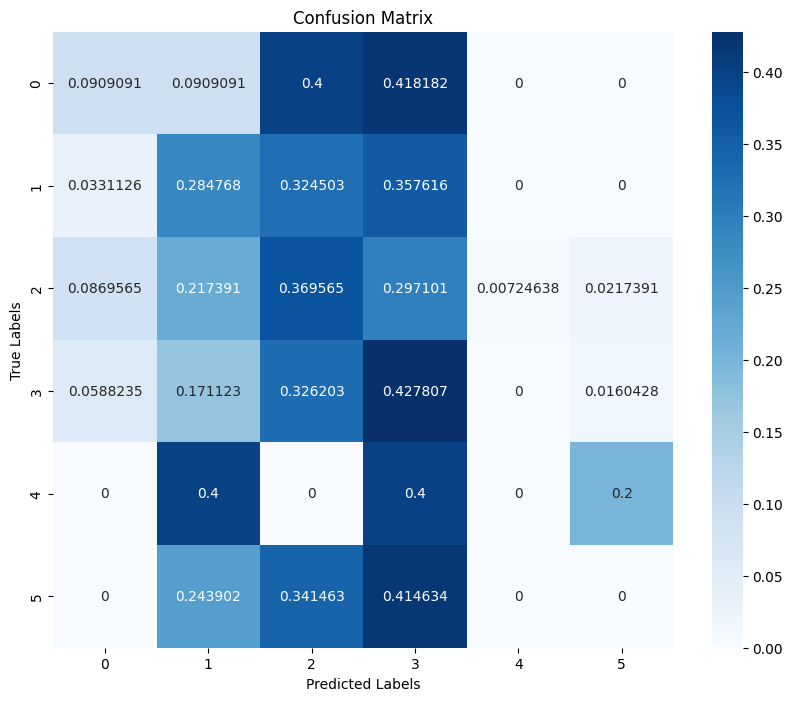

Epoch 14, Validation Loss: 3.4476, Accuracy: 0.3102, F1 Score: 0.2944
Val F1 Score Per Class  [0.11363636 0.31501832 0.30447761 0.3960396  0.         0.        ]


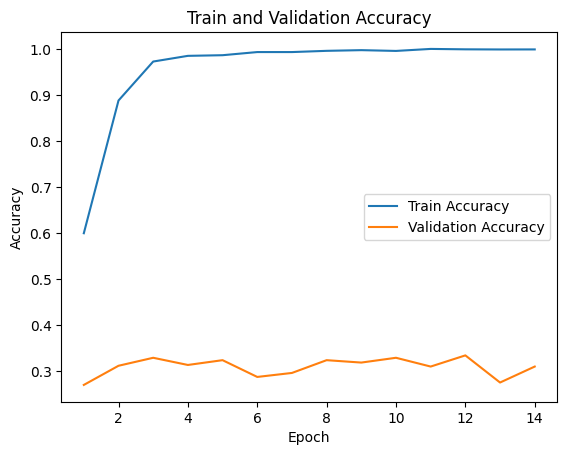

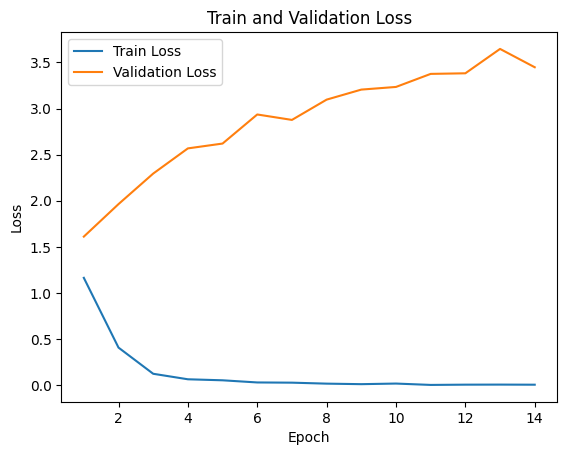

Epoch 15, Train Loss: 0.0014, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.12it/s, loss=4.86]

[tensor([-3.8669,  1.6801, -2.9448,  3.1710, -3.4838, -3.2229], device='cuda:0'), tensor([-2.2945,  5.3850, -0.6186, -1.5614, -4.5040, -4.1153], device='cuda:0'), tensor([-1.6732, -1.5270, -2.9011,  4.5484, -5.1132, -2.9302], device='cuda:0'), tensor([-2.2938, -0.5597, -3.2278,  5.2493, -4.0323, -2.4773], device='cuda:0'), tensor([-4.0274,  3.2137, -0.4196,  0.3746, -4.7819, -2.8054], device='cuda:0'), tensor([-3.9176,  3.3156,  1.5041, -1.3691, -3.6943, -3.4756], device='cuda:0'), tensor([-2.9191, -1.8788, -2.3463,  4.7034, -3.8257, -0.4936], device='cuda:0'), tensor([-2.8097, -2.8678,  4.5479,  1.7702, -2.9723, -2.4410], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.10it/s, loss=3.92]

[tensor([-1.8777, -0.8257, -3.0495,  2.5942, -4.5509, -2.2128], device='cuda:0'), tensor([-3.8706,  4.3292, -2.4430, -1.0216, -2.8734, -2.6388], device='cuda:0'), tensor([-0.6008, -1.3858,  2.4093,  0.3196, -3.9685, -3.8596], device='cuda:0'), tensor([-1.9643, -1.5752, -1.0422,  5.8017, -3.6654, -3.1793], device='cuda:0'), tensor([-1.1247,  6.6720, -1.4966, -1.8909, -2.9808, -2.7096], device='cuda:0'), tensor([-0.7400,  1.3201, -0.9143, -0.6008, -4.4025, -4.9068], device='cuda:0'), tensor([-1.6202, -1.6360, -2.7737,  3.6817, -3.6887, -3.5029], device='cuda:0'), tensor([ 5.9038, -0.1419, -2.7360, -0.5991, -3.2371, -2.4006], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:33,  2.11it/s, loss=3.88]

[tensor([-2.5728e+00, -1.0914e-03, -1.1107e-01, -1.6791e+00, -4.1136e+00,
        -4.0318e+00], device='cuda:0'), tensor([-2.3927,  1.7760,  0.0407, -1.4796, -3.2991, -3.2023], device='cuda:0'), tensor([-3.0044, -1.8532,  5.3213, -1.0009, -3.5467, -2.5454], device='cuda:0'), tensor([-1.0538, -2.3084, -1.8430,  3.2221, -4.2492, -3.9567], device='cuda:0'), tensor([-1.8995,  2.1221, -3.2786,  1.1221, -3.5026, -3.4506], device='cuda:0'), tensor([-1.5669, -0.6812, -2.5814,  2.4635, -4.6760, -4.2042], device='cuda:0'), tensor([-1.7551, -2.3990, -2.0977,  4.0859, -4.1450, -3.7306], device='cuda:0'), tensor([ 0.3802, -1.0895, -0.5639, -2.4017, -3.9795, -3.4260], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.12it/s, loss=3.42]

[tensor([-2.9765, -1.7555, -0.3345,  4.7911, -4.5715, -3.9739], device='cuda:0'), tensor([-3.6872,  1.0656,  0.5410, -2.0155, -3.8784, -2.6190], device='cuda:0'), tensor([-3.0136,  0.9387, -2.7423, -0.3873, -4.5079, -0.0973], device='cuda:0'), tensor([-2.6835, -1.0283,  0.7583, -0.4228, -3.1311, -3.0067], device='cuda:0'), tensor([ 6.7967, -1.7489, -0.8046, -0.5051, -2.6858, -3.1396], device='cuda:0'), tensor([-2.8235, -1.8645, -0.8192,  3.2792, -4.9086, -2.2991], device='cuda:0'), tensor([-1.5266,  6.2225, -1.3879, -1.6282, -3.5580, -3.0484], device='cuda:0'), tensor([-3.6875,  2.3993, -1.0029,  0.3129, -3.6468, -2.2306], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.13it/s, loss=3.21]

[tensor([-3.0737, -0.9998, -1.7881,  4.8915, -3.4772, -4.0258], device='cuda:0'), tensor([-3.0725, -2.1503,  2.0777,  3.7980, -4.2315, -4.6333], device='cuda:0'), tensor([-2.2568, -1.7044,  4.7924, -1.2716, -3.8961, -3.0984], device='cuda:0'), tensor([-2.3338,  0.0237, -2.2316,  0.3238, -4.8138, -5.3101], device='cuda:0'), tensor([-2.5067, -1.0624,  4.8405, -0.2903, -3.8880, -3.3411], device='cuda:0'), tensor([-2.2238,  1.2522, -0.5768, -0.5342, -4.7431, -3.6907], device='cuda:0'), tensor([-2.9573,  2.7109, -2.7994, -1.5560, -3.8458, -1.8193], device='cuda:0'), tensor([-1.3709,  0.2385, -3.2038,  3.9831, -3.7930, -2.4884], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.13it/s, loss=4.95]

[tensor([-2.1659, -2.0071,  6.8942, -1.4133, -2.6817, -2.6937], device='cuda:0'), tensor([-2.0923, -1.8476,  6.6383, -1.6024, -2.4961, -1.6845], device='cuda:0'), tensor([-1.9302, -1.6491,  3.7079, -1.4882, -4.4454, -4.3768], device='cuda:0'), tensor([-3.4911,  1.9206, -1.6692, -1.0148, -4.4074, -3.3946], device='cuda:0'), tensor([-1.9861, -1.9440,  6.6028, -1.6178, -2.8103, -2.3457], device='cuda:0'), tensor([-1.7307, -1.4868, -1.8527,  5.0812, -4.5616, -3.1514], device='cuda:0'), tensor([-2.0104, -3.6590,  1.9529,  2.2266, -4.2165, -3.6487], device='cuda:0'), tensor([-2.2961, -1.9588, -1.7775,  3.5787, -3.4959, -3.8342], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:31,  2.12it/s, loss=2.62]

[tensor([-2.4698, -0.2919, -0.2146,  2.0850, -4.4767, -3.2236], device='cuda:0'), tensor([-2.8066,  0.9446, -0.7693,  0.5821, -4.1023, -2.9977], device='cuda:0'), tensor([-0.8990, -1.9402,  6.5399, -1.7345, -2.3913, -2.4312], device='cuda:0'), tensor([-3.3252, -2.3775, -0.8623,  3.8379, -4.8124, -3.5805], device='cuda:0'), tensor([-3.2053,  3.8582,  1.3046, -1.5097, -3.5142, -4.7461], device='cuda:0'), tensor([-2.7084,  2.5525, -1.0706, -0.1092, -4.3608, -2.3137], device='cuda:0'), tensor([-3.1246, -3.5284,  2.6520, -0.3944, -3.7214,  0.0137], device='cuda:0'), tensor([-3.2594,  0.7894, -2.1392, -0.0567, -4.5355, -3.0914], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.13it/s, loss=5.16]

[tensor([-1.2489, -1.4480, -0.9484, -0.7182, -4.2072, -3.9079], device='cuda:0'), tensor([-1.9336, -2.2494,  4.9633, -0.7240, -3.0172, -2.7946], device='cuda:0'), tensor([-1.7419, -1.1090, -2.8497,  5.8575, -4.2143, -3.3205], device='cuda:0'), tensor([-1.2158,  6.4646, -1.8430, -1.1510, -2.9796, -3.1236], device='cuda:0'), tensor([-2.8485, -0.5390,  5.8568, -1.9069, -3.5660, -3.4984], device='cuda:0'), tensor([-1.6011, -1.0203, -1.7433,  1.0914, -4.5303, -4.9250], device='cuda:0'), tensor([-2.3832, -2.7662, -2.0087,  1.6391, -4.1054,  1.8998], device='cuda:0'), tensor([-2.2046, -1.9355,  6.5736, -1.1280, -2.5063, -1.9720], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.14it/s, loss=5.26]

[tensor([-3.0387, -0.9533, -2.7369,  0.7099, -4.7247, -1.7831], device='cuda:0'), tensor([-2.8935,  4.5275, -0.5289, -1.1989, -4.2401, -3.7948], device='cuda:0'), tensor([-0.7710,  4.2772, -1.3634, -1.0147, -3.6927, -4.5366], device='cuda:0'), tensor([-1.5931, -2.4474,  0.1279,  0.8910, -3.3391, -3.4579], device='cuda:0'), tensor([-2.1478, -2.3034, -0.5490,  5.1789, -3.2950, -2.9372], device='cuda:0'), tensor([-3.0308,  5.7560, -0.0994, -1.1848, -3.9063, -3.3147], device='cuda:0'), tensor([-3.1477,  0.8808, -3.5992,  3.5439, -3.9647, -2.7609], device='cuda:0'), tensor([-2.6635, -2.0265,  0.3512,  2.6831, -4.4526, -3.2983], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.14it/s, loss=3.51]

[tensor([-2.5699,  5.4126, -1.1385, -1.3453, -3.0216, -3.2676], device='cuda:0'), tensor([-2.9247, -1.8556,  0.7917,  2.7179, -3.9401, -3.7981], device='cuda:0'), tensor([-1.1306,  3.1981, -2.4810, -2.2888, -2.9477, -2.3820], device='cuda:0'), tensor([-2.7846, -1.3682,  0.1290,  3.5246, -3.8823, -4.7481], device='cuda:0'), tensor([-2.4069,  4.3966,  1.2615, -1.4809, -3.7423, -3.8757], device='cuda:0'), tensor([-0.9109, -0.7891, -0.3691,  2.2845, -4.7203, -5.1233], device='cuda:0'), tensor([-3.0118,  5.2111, -2.2779, -1.3772, -2.8129, -2.3090], device='cuda:0'), tensor([-2.3454,  6.1253, -1.7756, -0.5335, -3.6370, -3.4157], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.14it/s, loss=4.76]

[tensor([-2.7491, -1.7914, -1.2303,  5.5401, -3.7291, -3.1154], device='cuda:0'), tensor([-0.9457,  4.0317, -3.1754, -0.5607, -4.1548, -3.1518], device='cuda:0'), tensor([-2.7295, -2.9702,  3.0121,  3.8429, -4.4380, -2.4356], device='cuda:0'), tensor([-2.7630, -1.8379, -0.7593,  2.8742, -5.5385, -4.6531], device='cuda:0'), tensor([-3.4520,  5.2829, -1.7648, -0.9432, -4.4180, -1.6331], device='cuda:0'), tensor([-2.4362,  1.5883, -3.2236,  1.4072, -4.4740, -3.2180], device='cuda:0'), tensor([-4.2450, -1.1182, -0.0257, -0.7566, -3.9312, -3.5871], device='cuda:0'), tensor([-1.3996, -1.4755, -2.7230,  5.7379, -3.4458, -3.9629], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=2.57]

[tensor([-2.9397, -2.3115,  5.3361, -0.7233, -3.3041, -3.5058], device='cuda:0'), tensor([-3.9842,  0.9980,  0.5371,  0.9747, -4.2848, -3.9099], device='cuda:0'), tensor([-3.3418, -1.3353,  2.0477,  1.3360, -3.7545, -4.5654], device='cuda:0'), tensor([-2.7144,  4.2033, -2.8477, -0.4050, -3.3180, -3.2496], device='cuda:0'), tensor([ 0.8564,  0.3087, -2.0910, -1.8931, -3.2658, -4.1431], device='cuda:0'), tensor([-2.0106, -2.0259,  6.7223, -0.8380, -2.8209, -2.4540], device='cuda:0'), tensor([-1.7913, -0.9913, -3.1403,  3.8818, -4.5246, -3.0252], device='cuda:0'), tensor([-2.3941, -0.2424,  2.4147, -1.3697, -4.1830, -3.9907], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.15it/s, loss=2.25]

[tensor([-0.5153, -1.1650, -1.6527,  0.5694, -4.9540, -4.9423], device='cuda:0'), tensor([-3.7083,  2.1519,  1.3551,  1.0559, -3.8532, -3.5655], device='cuda:0'), tensor([-3.4516,  2.1665, -0.9320, -0.7497, -4.9747, -4.0604], device='cuda:0'), tensor([-3.1115,  1.7750,  2.8391, -2.3741, -3.9285, -3.2646], device='cuda:0'), tensor([-3.2962,  4.9219, -2.0426, -0.5793, -3.7756, -2.0918], device='cuda:0'), tensor([-2.9559, -1.1197, -0.8517, -1.0306, -4.2903, -3.0171], device='cuda:0'), tensor([-2.7007,  5.4133, -2.4451,  0.5863, -3.8614, -3.2363], device='cuda:0'), tensor([-1.1202,  2.8977, -2.5671,  1.1405, -4.3986, -4.9328], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=1.91]

[tensor([-1.2678, -1.6402, -2.0346, -0.3543, -4.4125, -1.7351], device='cuda:0'), tensor([-3.4279,  1.1789, -2.1685,  0.7293, -4.0644, -3.6854], device='cuda:0'), tensor([-3.4164, -2.6952, -0.4945,  1.0279, -3.5486, -0.7164], device='cuda:0'), tensor([-2.4366,  1.0158, -2.5384,  1.4724, -5.0931, -3.7241], device='cuda:0'), tensor([-2.8554, -1.2211, -2.1755,  6.2328, -3.0294, -2.1876], device='cuda:0'), tensor([-2.9089,  1.8230, -2.2597,  1.8289, -3.9059, -3.3155], device='cuda:0'), tensor([-3.1725,  3.5083, -0.6419, -2.7022, -3.7912, -2.8018], device='cuda:0'), tensor([-2.5722,  0.4659, -2.0942,  2.3656, -4.8980, -4.1782], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.14it/s, loss=4.98]

[tensor([-2.7792,  5.7830, -1.6031, -1.0248, -3.6458, -2.7846], device='cuda:0'), tensor([-1.8672,  4.6554, -0.6168, -2.2629, -3.9594, -3.2233], device='cuda:0'), tensor([-2.2066, -0.9152,  6.5840, -1.9937, -2.6542, -1.9900], device='cuda:0'), tensor([-1.8865, -2.1263, -1.4984,  6.3280, -3.8203, -3.2341], device='cuda:0'), tensor([-2.1316, -1.3235, -1.9267,  6.2415, -3.4518, -3.8335], device='cuda:0'), tensor([-2.8884,  3.0349, -0.3429, -2.0576, -4.2676, -4.4744], device='cuda:0'), tensor([-3.7359, -1.1783, -0.0157,  1.8324, -4.6033, -3.0894], device='cuda:0'), tensor([-3.1290, -0.6895,  4.9300, -1.5181, -3.9585, -5.0169], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=2.98]

[tensor([-2.0076, -0.9268, -1.9865,  5.9987, -4.3609, -3.3437], device='cuda:0'), tensor([-2.2163,  5.3773, -0.3943, -1.9128, -3.6185, -3.2036], device='cuda:0'), tensor([-2.2532, -1.0744, -2.0748,  3.7270, -4.3246, -4.5139], device='cuda:0'), tensor([-3.7581,  1.4106, -0.8144,  0.6041, -4.2683, -2.3133], device='cuda:0'), tensor([-2.3379, -2.2427, -1.7422,  1.8883, -3.6829, -3.0155], device='cuda:0'), tensor([-3.1466, -1.3219,  5.9941, -1.2059, -3.0667, -2.5844], device='cuda:0'), tensor([-2.8109, -0.5534, -1.7253,  4.2935, -5.7601, -4.3280], device='cuda:0'), tensor([-3.2627, -1.3498, -1.0374, -0.9656, -3.8753, -2.9910], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.15it/s, loss=3.93]

[tensor([-3.4493, -1.0640, -0.4203,  3.7535, -4.6899, -4.0726], device='cuda:0'), tensor([-1.0483,  1.4425,  1.7307, -1.8329, -3.9974, -3.3067], device='cuda:0'), tensor([-2.3525,  4.1084, -0.5024, -3.0515, -3.1625, -2.8467], device='cuda:0'), tensor([-3.0576,  2.0195, -1.4274,  0.2370, -4.4817, -3.8994], device='cuda:0'), tensor([-3.0106, -2.9536, -0.2702,  4.8735, -3.3466, -1.7688], device='cuda:0'), tensor([-2.2376, -2.1372, -1.6482,  3.2162, -4.4850, -3.3493], device='cuda:0'), tensor([ 1.4337, -2.1997, -1.2364, -1.1340, -3.7532, -2.2058], device='cuda:0'), tensor([-1.9891, -0.1349, -3.4255,  0.6303, -3.6447, -3.2530], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=2.45]

[tensor([-2.4861, -2.4349, -0.7288,  5.5158, -3.9965, -3.6283], device='cuda:0'), tensor([-1.0093, -2.0939, -1.0319,  4.5647, -3.3639, -4.4269], device='cuda:0'), tensor([-4.1387, -0.4628,  1.1141, -1.4833, -4.1006, -1.1365], device='cuda:0'), tensor([-2.6624,  3.5066, -0.4826, -0.4727, -4.5076, -4.9406], device='cuda:0'), tensor([-2.5994, -2.8684,  2.2702, -0.7559, -1.9098, -3.2144], device='cuda:0'), tensor([-0.7024, -1.0049, -2.5946,  0.6243, -5.0789, -2.7101], device='cuda:0'), tensor([-1.5730,  2.9475, -0.2603, -0.8177, -4.5329, -4.0415], device='cuda:0'), tensor([-2.8304, -0.5146, -1.5089,  3.8861, -4.1305, -4.5359], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.16it/s, loss=2.06]

[tensor([-2.7295, -1.2688,  0.3305, -1.2521, -4.0777, -4.3866], device='cuda:0'), tensor([ 5.4217, -0.7963, -2.3059, -0.8728, -3.8505, -3.6470], device='cuda:0'), tensor([-2.1342, -1.6760,  6.1768, -0.5466, -2.8403, -3.1701], device='cuda:0'), tensor([-2.5646, -2.0516, -0.7750,  5.5676, -3.3889, -3.1658], device='cuda:0'), tensor([-1.1134,  5.4716, -2.5374, -0.7064, -4.5273, -3.8008], device='cuda:0'), tensor([-0.9465, -0.4690, -3.0752,  2.7605, -4.2091, -4.3071], device='cuda:0'), tensor([-2.2050,  1.8630, -1.1874, -1.1113, -4.0522, -2.2154], device='cuda:0'), tensor([-2.0044,  0.6795,  0.6313, -1.0497, -3.9375, -3.5951], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.15it/s, loss=5.16]

[tensor([-3.1359, -2.2955,  3.1621,  1.8520, -4.1190, -3.7225], device='cuda:0'), tensor([-3.0892,  3.8785, -1.4245, -2.1212, -2.6564, -2.7571], device='cuda:0'), tensor([-2.5386, -1.8015,  0.2866,  3.2810, -3.5852, -2.4124], device='cuda:0'), tensor([-2.1155, -3.4398,  0.3056,  2.2127, -4.6682, -3.1644], device='cuda:0'), tensor([ 0.2513, -0.9768,  0.4224, -1.8935, -4.9401, -4.1108], device='cuda:0'), tensor([-3.1344,  3.9794, -1.4993, -0.6583, -3.7569, -2.3967], device='cuda:0'), tensor([-2.4620, -2.3251,  0.2951,  2.4212, -4.7594, -4.0234], device='cuda:0'), tensor([-2.2545, -1.5840,  5.1862, -0.7745, -3.4898, -3.5243], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.14it/s, loss=5.01]

[tensor([-1.2275, -3.3874,  3.6683, -0.2634, -3.3918, -2.5781], device='cuda:0'), tensor([-1.7960,  6.5580, -1.7832, -1.1710, -3.1690, -2.7160], device='cuda:0'), tensor([-2.9282,  3.8010,  0.9026, -2.3549, -3.9651, -2.8312], device='cuda:0'), tensor([-2.3596, -2.6587,  5.9948, -0.1028, -3.0525, -3.1297], device='cuda:0'), tensor([-2.8540, -1.5458,  2.7999,  0.9714, -4.8631, -4.5575], device='cuda:0'), tensor([-1.7673, -0.0936, -1.2085, -2.4966, -4.0256, -2.8784], device='cuda:0'), tensor([-1.8541, -2.0931, -1.4996,  6.4319, -2.9007, -2.7698], device='cuda:0'), tensor([-2.0395, -1.6922, -1.5798,  5.6948, -2.6381, -1.8842], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.14it/s, loss=2.34]

[tensor([-2.3600,  0.9954, -1.7573,  3.7011, -5.2687, -4.3799], device='cuda:0'), tensor([-2.4700, -1.3422, -0.8949,  0.8130, -3.1342, -3.3057], device='cuda:0'), tensor([-3.9565, -1.3223, -0.6157,  3.1952, -4.3869, -4.5032], device='cuda:0'), tensor([-2.8637, -1.3408, -2.3776,  5.1079, -2.6952, -1.2740], device='cuda:0'), tensor([-2.4006, -2.2512,  2.9473,  1.0612, -3.6934, -4.0893], device='cuda:0'), tensor([-1.4565, -2.8413,  1.2476,  3.9172, -3.6547, -4.2276], device='cuda:0'), tensor([-2.8826,  0.2099, -1.9301, -0.1632, -4.5182, -3.3654], device='cuda:0'), tensor([-3.4678, -1.8048,  1.0856,  4.1629, -3.8898, -3.6806], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.15it/s, loss=2.24]

[tensor([-2.1200, -0.3875, -0.8647, -0.0525, -4.4135, -4.3290], device='cuda:0'), tensor([-2.7152, -1.0697, -2.1793,  4.8837, -4.1818, -3.4715], device='cuda:0'), tensor([-2.1471,  0.1099, -2.6009,  3.8486, -2.9758, -3.5256], device='cuda:0'), tensor([-2.6110,  5.1940, -1.9149, -1.5322, -4.3483, -2.6421], device='cuda:0'), tensor([-2.9880,  2.2759, -1.7983,  1.9712, -4.6435, -3.7823], device='cuda:0'), tensor([-1.7124, -1.5838, -2.1617,  6.4478, -2.8334, -2.7811], device='cuda:0'), tensor([-1.6146, -2.5379,  1.1506,  3.3402, -3.9871, -4.2887], device='cuda:0'), tensor([-2.9525, -2.1897,  6.0149, -1.6301, -2.8824, -2.8649], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.15it/s, loss=3.52]

[tensor([-2.0284, -0.5193, -3.1006,  1.2465, -3.7661, -3.1697], device='cuda:0'), tensor([-2.6474, -0.8423, -1.0272,  1.7378, -4.5697, -3.5454], device='cuda:0'), tensor([-2.0260, -2.2576, -0.9727,  5.4724, -3.8780, -3.8205], device='cuda:0'), tensor([-0.9691, -1.3977,  4.2830, -1.9008, -3.3487, -4.6502], device='cuda:0'), tensor([-2.9504,  0.8626,  5.0176, -2.1686, -3.1696, -3.6986], device='cuda:0'), tensor([-2.2522, -2.0840,  3.9241,  0.1075, -3.3946, -4.2510], device='cuda:0'), tensor([-2.8717, -1.3554, -2.6694,  5.4621, -2.6860, -1.2196], device='cuda:0'), tensor([-1.8596,  4.2470, -2.5881, -0.1399, -5.1867, -2.5929], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=4.65]

[tensor([-2.7465,  1.1596, -0.9100,  2.9219, -5.2502, -3.0791], device='cuda:0'), tensor([-1.9975,  4.5627, -2.6424,  0.7968, -4.4670, -3.0125], device='cuda:0'), tensor([-2.5619,  4.7207, -1.0118, -1.1360, -3.6113, -3.5555], device='cuda:0'), tensor([-2.0905, -2.1543,  4.8885, -0.8278, -2.8771, -3.8245], device='cuda:0'), tensor([-2.1393,  2.8795, -0.9081, -0.2378, -5.0192, -5.0316], device='cuda:0'), tensor([-1.7205,  5.9404, -1.5245, -2.1712, -3.1017, -2.5123], device='cuda:0'), tensor([-3.8536,  2.6945, -2.3247, -1.6671, -5.8360, -2.6007], device='cuda:0'), tensor([-2.6459,  4.7890, -3.3293, -0.1716, -4.0473, -1.1140], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.16it/s, loss=3.36]

[tensor([-1.4693,  5.7027, -2.9820, -1.5323, -3.3978, -1.0127], device='cuda:0'), tensor([-2.5579, -0.0165,  0.7494, -2.7314, -3.7138, -2.2094], device='cuda:0'), tensor([-3.3838,  2.2473,  0.2993,  0.1159, -4.7129, -4.3101], device='cuda:0'), tensor([-2.0528, -0.7300,  0.4906, -2.1594, -4.0042, -5.0248], device='cuda:0'), tensor([-1.6773,  6.2010, -2.3858, -0.5237, -3.6308, -3.2563], device='cuda:0'), tensor([-2.6565, -1.1081, -1.7927,  4.3802, -2.7116, -2.6195], device='cuda:0'), tensor([ 0.8383, -2.6290, -0.2480, -0.0573, -4.1434, -3.3696], device='cuda:0'), tensor([-0.9110, -3.3296,  1.0805,  2.5387, -3.6571, -3.1829], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.16it/s, loss=3.35]

[tensor([-3.0793,  1.0098, -3.2503,  3.0292, -3.8882, -1.2887], device='cuda:0'), tensor([-1.6449,  6.0642, -0.1768, -1.8325, -3.1297, -3.6645], device='cuda:0'), tensor([-2.3526, -0.8786, -1.9459,  0.6937, -4.4512, -2.1791], device='cuda:0'), tensor([-2.9366, -1.3795, -1.5996,  4.3810, -3.4483, -3.1411], device='cuda:0'), tensor([-1.9567, -1.2473, -2.5900,  1.3771, -3.6659, -2.9179], device='cuda:0'), tensor([-3.6600,  1.2835, -0.7060,  2.7278, -4.3971, -5.0419], device='cuda:0'), tensor([-3.3072, -1.7280,  4.4653, -0.9790, -3.9665, -3.6331], device='cuda:0'), tensor([-2.4799,  5.4385, -2.3230, -0.2993, -3.2959, -2.5174], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.14it/s, loss=4]

[tensor([-1.1481, -1.3293,  5.5337, -1.5813, -2.9676, -3.3188], device='cuda:0'), tensor([-2.3300, -2.4584,  3.3083,  1.0055, -3.9822, -3.8876], device='cuda:0'), tensor([-1.1319, -1.8893, -0.4610,  2.4586, -4.6431, -4.4086], device='cuda:0'), tensor([-1.8582, -2.3504,  4.4216, -0.2772, -3.6227, -2.9034], device='cuda:0'), tensor([-2.2434, -1.5114,  6.2955, -1.1033, -2.9260, -3.0591], device='cuda:0'), tensor([-2.2820,  4.6239, -1.4828, -1.1250, -3.6670, -2.8714], device='cuda:0'), tensor([-2.3054, -2.4773,  2.1703,  1.4435, -4.1433, -2.0481], device='cuda:0'), tensor([-1.2954, -2.0129,  6.1945, -0.7068, -3.0979, -3.0007], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.14it/s, loss=5.08]

[tensor([ 5.5714, -1.3275, -1.5940, -1.4017, -3.1107, -1.6083], device='cuda:0'), tensor([-3.5982, -1.2453,  3.1201, -1.8455, -4.0766, -3.6740], device='cuda:0'), tensor([-0.9989,  0.5682, -2.6665,  2.5061, -3.8147, -4.8165], device='cuda:0'), tensor([-1.5469, -0.6737,  2.4831, -0.2579, -3.2374, -2.5567], device='cuda:0'), tensor([-2.4065,  6.1619, -0.8102, -0.7351, -3.3538, -3.6181], device='cuda:0'), tensor([-2.2965, -1.9361,  6.2785, -1.2835, -2.8297, -1.8198], device='cuda:0'), tensor([-2.2577, -1.2562,  4.3840, -0.5385, -3.9376, -3.2822], device='cuda:0'), tensor([-3.2093,  5.1602, -0.8523, -1.0164, -3.2366, -3.1729], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:20,  2.15it/s, loss=5.33]

[tensor([-1.9466,  4.0591, -0.8051, -1.6906, -4.7397, -4.0917], device='cuda:0'), tensor([-2.4124, -2.7218,  2.8806,  3.2021, -3.7034, -3.4290], device='cuda:0'), tensor([-3.8965,  3.9543, -1.8851, -0.8717, -4.8973, -1.8475], device='cuda:0'), tensor([-3.2347,  0.5498, -2.1374, -0.3663, -3.4193, -0.7666], device='cuda:0'), tensor([-2.0256, -1.5052, -1.7331,  5.8162, -3.1300, -3.2691], device='cuda:0'), tensor([-1.1507, -2.0683,  4.5476, -1.5580, -3.3384, -4.1047], device='cuda:0'), tensor([-0.2990, -2.4222,  3.8633, -1.0258, -2.4369, -2.1923], device='cuda:0'), tensor([ 5.1221, -0.7012, -2.8366, -0.3516, -3.3485, -1.9800], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=2.48]

[tensor([-2.6261, -2.7448,  0.0145,  5.2523, -3.3495, -2.7150], device='cuda:0'), tensor([-0.3248, -2.0101, -2.3419,  0.7117, -5.2971, -3.9654], device='cuda:0'), tensor([-3.2156, -1.6224,  3.0559,  1.5061, -5.3406, -3.3626], device='cuda:0'), tensor([ 0.4243, -2.2314, -0.2442,  1.1095, -5.3571, -5.0172], device='cuda:0'), tensor([-0.4528, -1.3474,  1.0432, -1.6804, -4.7579, -4.8878], device='cuda:0'), tensor([-2.3218, -0.1179, -1.9787, -1.7039, -3.1360, -1.0870], device='cuda:0'), tensor([-0.3277,  5.0455, -3.0272, -1.5492, -3.5205, -3.3755], device='cuda:0'), tensor([-2.9687,  1.0657, -2.0087,  2.8177, -4.3920, -5.3255], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.12it/s, loss=3.4]

[tensor([-3.2317,  1.7704,  1.9817, -2.6847, -3.5220, -0.8790], device='cuda:0'), tensor([-0.7544, -1.4945,  0.3616,  1.1586, -4.5355, -5.1568], device='cuda:0'), tensor([-1.4051, -1.0149, -1.2255,  1.8634, -5.3042, -5.4365], device='cuda:0'), tensor([-3.0259, -1.9710,  1.6567,  1.0120, -4.1112, -3.6133], device='cuda:0'), tensor([-3.3825, -0.9747,  4.1447, -0.9637, -3.2904, -3.2429], device='cuda:0'), tensor([-2.2223,  6.6354, -0.9652, -1.9510, -3.0525, -2.1492], device='cuda:0'), tensor([-1.7977, -1.1912, -1.4183, -1.3453, -2.2396,  8.1056], device='cuda:0'), tensor([-1.3494, -2.4214, -0.9528, -0.1877, -2.9485, -4.0856], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.12it/s, loss=3.52]

[tensor([-2.8427, -0.2773,  0.1380,  0.1273, -4.7122, -4.1552], device='cuda:0'), tensor([-2.0054,  3.9634, -2.1546, -0.3953, -3.0831, -3.9635], device='cuda:0'), tensor([-3.0526, -1.6720,  1.0891, -1.6609, -4.0761, -4.1159], device='cuda:0'), tensor([-3.4194,  2.1201, -2.9740, -0.5932, -3.0205,  1.6333], device='cuda:0'), tensor([-2.1077, -1.3737, -2.4762,  2.9666, -3.6293, -4.0334], device='cuda:0'), tensor([-4.0645, -1.2034, -1.2735,  2.2599, -3.6989, -4.0139], device='cuda:0'), tensor([-2.6604, -1.4624, -0.9351,  4.4926, -4.3006, -3.9675], device='cuda:0'), tensor([ 3.2605, -2.6773, -2.3399,  1.8800, -3.0786, -3.1833], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.13it/s, loss=3.4]

[tensor([-2.9763,  0.3282,  2.8629, -0.7021, -5.3234, -3.9508], device='cuda:0'), tensor([-2.4277, -1.5398,  0.6150, -0.2597, -3.4970, -3.7058], device='cuda:0'), tensor([-1.8496, -1.0418,  6.7386, -1.8345, -2.5042, -2.7333], device='cuda:0'), tensor([ 1.5512, -2.6962,  2.3357, -1.1822, -4.2437, -3.3967], device='cuda:0'), tensor([-2.0924,  0.0745, -2.9076,  4.5640, -4.1215, -3.3769], device='cuda:0'), tensor([-2.5837, -1.1119,  6.5934, -1.6195, -2.7533, -2.5525], device='cuda:0'), tensor([ 3.6723, -2.2738, -1.9817,  0.0262, -3.5716, -2.9045], device='cuda:0'), tensor([-2.7832,  3.2696, -1.5556, -0.6052, -3.8181, -3.8579], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.13it/s, loss=2.47]

[tensor([-1.6396, -1.6143, -1.8995,  5.5259, -3.3714, -4.4631], device='cuda:0'), tensor([-2.7743, -0.6795,  0.8838, -2.8110, -3.1666, -0.3658], device='cuda:0'), tensor([-1.9224, -0.4181, -2.7505,  1.8205, -4.6151, -3.6199], device='cuda:0'), tensor([ 1.3798, -2.4010, -0.4634, -1.0067, -4.0250, -2.8408], device='cuda:0'), tensor([-2.0452,  0.0691,  0.5794, -1.6876, -3.2693, -2.5507], device='cuda:0'), tensor([-2.4184, -1.5208, -2.2668,  5.2653, -3.7770, -2.0815], device='cuda:0'), tensor([-0.9957, -1.7448, -2.2227,  2.1223, -4.5918, -3.0136], device='cuda:0'), tensor([-3.1257,  5.2824, -1.7538, -1.0704, -3.8659, -1.0790], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.13it/s, loss=2.48]

[tensor([-2.4530, -0.1521, -2.0612,  1.1537, -3.9401, -3.4951], device='cuda:0'), tensor([ 0.4982, -1.6455, -2.4596,  0.0472, -4.4257, -3.8508], device='cuda:0'), tensor([-3.1767,  0.6178, -2.7453,  1.0230, -3.1421, -3.8764], device='cuda:0'), tensor([-3.0193,  1.9510, -0.7970,  0.0766, -4.1331, -4.3182], device='cuda:0'), tensor([-1.7545, -2.1448,  0.7340,  1.7956, -4.0448, -4.8242], device='cuda:0'), tensor([-2.9888,  3.5788,  0.4953, -2.0126, -2.8452, -4.2904], device='cuda:0'), tensor([-3.2867,  3.3979,  0.3775, -2.3810, -4.5725, -3.3094], device='cuda:0'), tensor([-3.7774,  3.2424, -0.3130, -1.6219, -3.4960, -4.0526], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=4.71]

[tensor([-1.8724, -1.1450, -1.8599,  4.1204, -4.6581, -4.2657], device='cuda:0'), tensor([-2.8122,  5.7083, -2.2210, -0.2453, -2.8016, -3.0821], device='cuda:0'), tensor([-2.3520,  0.4071, -3.1001,  4.5799, -5.4037, -2.6276], device='cuda:0'), tensor([-2.2819, -0.6910,  6.5089, -1.8415, -2.9410, -3.1798], device='cuda:0'), tensor([-2.9717,  0.8827, -1.2687, -1.7567, -3.2555, -2.5539], device='cuda:0'), tensor([-2.6590,  3.8553, -1.0280, -2.0537, -3.4189, -2.9819], device='cuda:0'), tensor([-2.1880,  6.1106,  0.3311, -2.0041, -3.7787, -3.4662], device='cuda:0'), tensor([-2.8706, -1.2015, -2.0147,  4.6456, -4.1985, -2.3879], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=5.13]

[tensor([-3.1603, -0.7204, -3.1232,  2.9095, -3.6549, -1.2708], device='cuda:0'), tensor([-2.4023, -1.6942,  3.9069,  1.2369, -2.3589, -3.1145], device='cuda:0'), tensor([-2.7809, -0.3610, -1.4782,  5.3541, -3.6018, -4.2927], device='cuda:0'), tensor([-2.1859, -1.1090,  4.3611, -2.0588, -3.8960, -3.4335], device='cuda:0'), tensor([-2.2686, -1.7217,  6.1520, -1.4180, -3.0127, -1.2362], device='cuda:0'), tensor([-1.1227, -2.2995,  0.7168,  1.3775, -3.6478, -3.9853], device='cuda:0'), tensor([-2.5950,  5.4886, -1.8830, -1.6705, -2.8191, -2.2545], device='cuda:0'), tensor([-1.2491,  4.6345, -2.0111, -1.6036, -3.9158, -4.0642], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=4.53]

[tensor([-1.6151,  5.0032,  0.4844, -1.8135, -3.9015, -3.7747], device='cuda:0'), tensor([-2.5228, -0.7761, -2.9696,  3.3801, -2.2871, -0.7667], device='cuda:0'), tensor([ 1.6088, -0.0792, -3.1901, -0.5298, -3.7335, -4.0050], device='cuda:0'), tensor([-2.3506,  3.3651, -1.3751,  0.0307, -4.4767, -4.5677], device='cuda:0'), tensor([-1.6888,  0.7863, -2.2026,  2.5244, -4.6925, -4.8497], device='cuda:0'), tensor([-1.8073, -2.9465,  4.4805, -0.8729, -3.6106, -3.3362], device='cuda:0'), tensor([-2.3754, -0.4750, -2.1919,  2.9160, -3.3012, -4.7288], device='cuda:0'), tensor([-2.2812, -2.1048,  6.6801, -1.0727, -2.6512, -2.3742], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=3.05]

[tensor([-3.2987,  3.5006, -1.0904, -0.7732, -4.0139, -4.2547], device='cuda:0'), tensor([-3.2347, -1.8265, -1.7089,  4.1115, -4.1886, -3.0806], device='cuda:0'), tensor([-3.7613,  1.3395, -1.6958,  0.0849, -3.9362, -3.9781], device='cuda:0'), tensor([-1.6250, -1.9019,  6.8259, -2.2493, -2.2403, -2.1208], device='cuda:0'), tensor([-1.6642,  1.8140, -2.7062,  1.8793, -2.6073, -4.4615], device='cuda:0'), tensor([-3.2162, -2.6317,  1.1447, -2.0250, -4.1740, -1.9799], device='cuda:0'), tensor([-2.1631, -2.5542, -0.1759,  1.9383, -5.2522, -3.2182], device='cuda:0'), tensor([-1.4678, -2.6333,  1.0313,  0.8660, -2.2268, -3.9574], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.15it/s, loss=3.66]

[tensor([-1.9617, -1.5799, -1.9127,  6.4946, -2.9023, -3.2018], device='cuda:0'), tensor([-1.8771, -1.9509, -2.4971,  6.1618, -3.8622, -2.2458], device='cuda:0'), tensor([-2.8736, -0.9571, -1.3545,  3.9957, -4.4574, -3.5967], device='cuda:0'), tensor([-1.1969, -0.8355, -3.8263,  3.4235, -3.6847, -2.2791], device='cuda:0'), tensor([-2.7524,  1.0409,  0.7551, -1.2791, -3.4317, -4.0607], device='cuda:0'), tensor([-2.8075, -1.6399,  5.9489, -0.5112, -2.9128, -3.0267], device='cuda:0'), tensor([-1.1731,  1.5680, -1.6528, -0.6365, -4.1818, -4.3146], device='cuda:0'), tensor([-0.9204, -1.9592,  6.1650, -1.2348, -2.9461, -2.6998], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.14it/s, loss=3.61]

[tensor([-3.5820,  0.7378, -0.9568, -0.8608, -4.6760, -2.2460], device='cuda:0'), tensor([-1.2024, -1.4950, -3.0706,  4.3221, -3.5543, -3.9343], device='cuda:0'), tensor([ 7.2015, -1.8054, -1.3598, -1.1070, -2.3507, -1.0274], device='cuda:0'), tensor([-2.4265,  5.8998, -2.4348, -0.6970, -2.9660, -3.2240], device='cuda:0'), tensor([-2.1764, -0.8571, -3.5712,  4.0840, -4.5062, -3.0129], device='cuda:0'), tensor([-2.3636,  1.7314, -2.6705,  3.5771, -4.8783, -3.6723], device='cuda:0'), tensor([-0.8126,  0.0640, -2.0142,  3.6734, -4.7321, -4.7007], device='cuda:0'), tensor([-2.6946, -0.2618, -0.0473, -2.3142, -4.4605, -0.6561], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.12it/s, loss=3.04]

[tensor([-3.3193,  0.1868, -1.8234,  1.6561, -4.6034, -2.5671], device='cuda:0'), tensor([-4.0952, -2.1923, -1.2634, -0.8658, -3.0911, -2.4056], device='cuda:0'), tensor([-3.3598, -2.4670,  0.7453,  3.6153, -4.5928, -3.1320], device='cuda:0'), tensor([-1.7948, -1.7702, -1.6024,  6.2536, -4.0072, -3.1781], device='cuda:0'), tensor([-2.9204,  4.3696,  0.6734, -0.8555, -4.2611, -4.0520], device='cuda:0'), tensor([-2.4433, -0.9620, -3.0560,  0.9494, -4.8581, -3.6479], device='cuda:0'), tensor([-1.7562, -2.4446, -0.1298,  5.7397, -3.9293, -4.2921], device='cuda:0'), tensor([-1.1420, -1.6452, -1.6929,  4.9872, -3.8206, -4.6590], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.12it/s, loss=2.84]

[tensor([-1.2218, -1.1765, -1.1245,  0.8720, -3.7961, -4.9496], device='cuda:0'), tensor([-0.3176, -2.0265, -0.6052, -1.0753, -3.0999, -3.9191], device='cuda:0'), tensor([-4.0992, -1.7277, -0.7959,  1.8466, -4.6450, -3.1831], device='cuda:0'), tensor([-4.3063, -0.5078,  0.9890,  0.5106, -4.9330, -2.9620], device='cuda:0'), tensor([-2.3301, -2.1316,  0.8964,  0.9018, -2.7447, -2.4199], device='cuda:0'), tensor([-4.1690,  1.5576,  1.9201,  0.7038, -4.5915, -4.1258], device='cuda:0'), tensor([ 1.5093, -1.7091, -0.0124,  1.6344, -4.3668, -3.2427], device='cuda:0'), tensor([-2.1550,  4.8352, -2.6465, -0.7036, -3.1850, -1.5331], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.12it/s, loss=3.53]

[tensor([ 2.0472,  0.2915, -3.6689, -1.7357, -4.4535, -1.6650], device='cuda:0'), tensor([-2.7538,  1.2850, -3.0684,  2.1471, -2.8352, -2.8488], device='cuda:0'), tensor([-3.1545,  2.2302, -2.9458,  0.3727, -3.6787, -1.6070], device='cuda:0'), tensor([-2.4116, -0.7840, -1.2367, -1.6310, -3.8916, -3.6321], device='cuda:0'), tensor([-2.4269, -2.4878,  5.7028,  0.0703, -3.3639, -2.5527], device='cuda:0'), tensor([-1.7221, -1.4839, -2.1083, -1.3455, -2.3405,  7.8232], device='cuda:0'), tensor([-3.4011,  3.7088, -0.2686, -0.0588, -3.8731, -3.2544], device='cuda:0'), tensor([-3.2292, -1.6480, -1.7847,  2.2482, -4.1140, -2.4280], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.13it/s, loss=2.96]

[tensor([-2.6547, -0.2104,  3.7747, -2.1174, -3.9855, -3.6948], device='cuda:0'), tensor([-1.2923,  2.0837, -1.6115, -0.2932, -2.4261, -2.9105], device='cuda:0'), tensor([-3.3186, -0.2376, -1.5118,  4.1631, -4.0626, -4.6664], device='cuda:0'), tensor([-1.8746, -2.1504,  6.4938, -1.9210, -2.7168, -1.2709], device='cuda:0'), tensor([-3.4550,  0.5298, -2.9625,  1.6310, -3.3461, -2.4357], device='cuda:0'), tensor([-2.1454,  5.8555, -2.5705, -0.8047, -2.8843, -2.8834], device='cuda:0'), tensor([-2.2982,  0.1848,  0.1593,  1.1704, -4.6081, -4.0956], device='cuda:0'), tensor([-2.5668, -1.2484,  4.5524, -1.4986, -3.2171, -3.9151], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.12it/s, loss=3.02]

[tensor([ 4.5613, -1.4867, -3.4770, -0.0545, -3.0097, -2.4897], device='cuda:0'), tensor([-2.1712, -0.9862, -0.9726,  2.9458, -5.6081, -3.8477], device='cuda:0'), tensor([-3.4039, -1.2407,  0.2401,  1.5307, -3.7131, -3.5167], device='cuda:0'), tensor([-2.0820, -0.9173,  5.5104, -1.4366, -3.5541, -3.3884], device='cuda:0'), tensor([-1.8987,  4.0744,  1.4736, -0.7682, -4.3433, -4.4015], device='cuda:0'), tensor([-2.6282,  1.2371, -3.4446,  1.9192, -4.1555, -3.3762], device='cuda:0'), tensor([-1.7566, -1.2028, -1.5600,  0.6610, -1.8477, -4.1038], device='cuda:0'), tensor([-2.2690, -1.0439, -1.4562,  5.3882, -4.4861, -3.9061], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.13it/s, loss=3.37]

[tensor([-1.9247, -1.6332,  6.7918, -1.9444, -2.7393, -1.9093], device='cuda:0'), tensor([-2.7670,  2.3707, -1.9864,  0.3417, -4.5483, -3.8586], device='cuda:0'), tensor([-2.2852,  6.5436, -1.0438, -1.9239, -3.1151, -2.5591], device='cuda:0'), tensor([-2.1273,  5.4365, -1.6482, -0.5064, -4.0909, -3.7461], device='cuda:0'), tensor([-1.6855, -1.7680, -2.1166,  6.3760, -3.4068, -3.0680], device='cuda:0'), tensor([ 1.6428,  0.5515, -1.8238, -1.8215, -3.3943, -1.5896], device='cuda:0'), tensor([-2.1533, -0.8120,  0.2353,  0.9827, -4.9597, -4.5476], device='cuda:0'), tensor([-3.4417, -1.1111, -0.9142,  5.3365, -3.9872, -3.5501], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.13it/s, loss=3.77]

[tensor([-3.0721, -1.2097,  5.3713, -0.7532, -3.1559, -3.5577], device='cuda:0'), tensor([-0.5467,  2.5106, -2.2054, -0.2973, -3.8167, -4.0139], device='cuda:0'), tensor([-3.2506, -0.7617,  5.1925, -1.0861, -2.3673, -2.4961], device='cuda:0'), tensor([-2.1267, -2.0158,  5.4162, -0.4933, -3.2151, -2.5750], device='cuda:0'), tensor([-3.0932,  3.5700,  1.6706, -2.2563, -3.7500, -3.4257], device='cuda:0'), tensor([ 0.4403, -3.2960, -0.1965, -0.3605, -3.7441, -4.4327], device='cuda:0'), tensor([-2.9617,  2.1768, -0.6473, -1.1762, -5.3828, -0.9258], device='cuda:0'), tensor([-2.8803, -2.0423, -1.1089,  5.5718, -3.7750, -2.8417], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.13it/s, loss=3.78]

[tensor([-0.4635, -0.7699, -1.6916, -0.4561, -5.2308, -3.6551], device='cuda:0'), tensor([-3.0013, -1.3536, -1.6002,  3.5038, -5.0203, -3.9201], device='cuda:0'), tensor([-3.5251,  0.6038,  1.8852,  1.9484, -3.6730, -3.2909], device='cuda:0'), tensor([-2.1266,  5.1880, -0.0797, -1.3321, -5.6913, -3.2133], device='cuda:0'), tensor([-2.5556, -1.5911,  4.7520, -1.6835, -4.3404, -3.6771], device='cuda:0'), tensor([-2.1146, -1.6713, -2.2983,  6.2765, -2.8058, -2.0954], device='cuda:0'), tensor([-2.5606, -1.7703, -1.0893,  6.0420, -3.5206, -2.2139], device='cuda:0'), tensor([-3.0714,  1.1043, -1.7264, -0.3663, -4.4266, -4.1665], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.13it/s, loss=2.07]

[tensor([-2.0546, -2.1800,  4.5785,  0.9159, -4.1471, -3.5149], device='cuda:0'), tensor([-1.9601, -1.9412, -2.1897,  6.4485, -3.6482, -2.1249], device='cuda:0'), tensor([-3.7170,  2.7764,  1.2837, -0.9018, -3.7122, -1.6256], device='cuda:0'), tensor([-2.1902, -1.4040, -1.8715,  6.0927, -3.5360, -3.7139], device='cuda:0'), tensor([-2.9468,  2.8918,  0.1094, -0.9818, -4.1738, -3.9634], device='cuda:0'), tensor([-0.5394,  0.6443, -4.3062,  3.9156, -4.4546, -2.4212], device='cuda:0'), tensor([-2.4603, -1.0308, -1.6519,  4.8431, -4.1978, -2.8239], device='cuda:0'), tensor([-0.7577,  1.4635, -1.9954, -3.3034, -3.5815,  3.1454], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.14it/s, loss=2.94]

[tensor([-3.7574,  0.3282, -0.4421,  0.1981, -4.9987, -1.7553], device='cuda:0'), tensor([-1.5805, -1.4219, -1.2719,  5.4463, -3.8878, -4.8249], device='cuda:0'), tensor([-0.2993,  0.6863, -3.1720,  0.5161, -1.6383, -4.4511], device='cuda:0'), tensor([-2.4421,  3.4783, -2.7149,  0.3882, -4.0345, -2.5514], device='cuda:0'), tensor([-2.5993, -2.2240,  1.1514, -1.5971, -3.3331,  0.6747], device='cuda:0'), tensor([-2.0875,  6.5552, -2.3050, -1.8805, -2.2725, -1.9716], device='cuda:0'), tensor([ 3.0278, -2.7762,  2.3316, -1.3740, -3.4709, -2.7010], device='cuda:0'), tensor([-2.3250,  5.5889, -1.0725, -1.1707, -3.8314, -3.0530], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.14it/s, loss=2.75]

[tensor([-2.3455,  0.8249, -3.1472,  3.6168, -3.8106, -3.3509], device='cuda:0'), tensor([-1.4234, -2.3641, -0.0925,  1.2510, -4.0282, -4.2979], device='cuda:0'), tensor([-3.0338, -2.4086, -1.0393,  1.4147, -5.0293,  0.2078], device='cuda:0'), tensor([-1.0781,  1.1892, -1.8562,  0.0101, -4.1684, -4.3218], device='cuda:0'), tensor([ 3.4912, -1.4267,  0.3870, -2.1830, -3.4559, -2.5711], device='cuda:0'), tensor([-1.5574, -1.0889, -2.9163,  2.1854, -4.8656, -4.8860], device='cuda:0'), tensor([-2.2524, -1.7857,  1.9928,  3.4084, -4.9291, -4.6920], device='cuda:0'), tensor([-3.1437, -1.1641,  4.8217, -1.3806, -3.2877, -3.9040], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.12it/s, loss=3.42]

[tensor([-3.4935, -2.3092, -0.1261,  3.3481, -3.9966, -2.8133], device='cuda:0'), tensor([ 1.2735, -2.2721, -1.5198, -0.2891, -4.8180, -3.3889], device='cuda:0'), tensor([-2.4316,  1.9847,  0.3308, -1.7929, -3.9178, -2.2513], device='cuda:0'), tensor([-1.8374, -1.7566, -1.4824,  6.3154, -3.9805, -2.6690], device='cuda:0'), tensor([-3.0360, -2.0320, -1.0377,  5.5309, -4.3552, -3.2769], device='cuda:0'), tensor([-2.7287, -1.4460, -2.3595,  0.0070, -3.9191, -1.2512], device='cuda:0'), tensor([-1.7825,  4.9935,  0.3113, -2.0976, -3.4923, -3.7092], device='cuda:0'), tensor([-3.7855,  0.7544, -0.9771, -2.0616, -4.9352,  2.9274], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.12it/s, loss=4.19]

[tensor([-1.9679, -1.9036,  6.5494, -1.1715, -2.6034, -2.1810], device='cuda:0'), tensor([-0.5128, -0.3649,  2.4705, -0.7493, -4.5345, -5.3248], device='cuda:0'), tensor([ 1.1720, -1.4036, -1.0526, -1.1478, -3.7659, -4.6799], device='cuda:0'), tensor([-2.3092,  4.3004, -1.6534, -1.7019, -4.1822, -3.0284], device='cuda:0'), tensor([-2.4332,  5.5676, -1.7580, -1.0175, -2.7878, -2.6707], device='cuda:0'), tensor([-1.6281, -1.3832,  3.7471, -1.2479, -3.4310, -3.3856], device='cuda:0'), tensor([-2.4093, -2.4288, -1.1066,  5.9318, -3.2682, -2.7723], device='cuda:0'), tensor([-1.5642,  6.3353, -1.3508, -1.4609, -3.7623, -3.2675], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:08,  2.12it/s, loss=2.72]

[tensor([-3.2426,  1.0499, -0.3409, -1.5751, -4.2373, -3.2189], device='cuda:0'), tensor([-2.6266,  3.2501, -2.7936,  0.8535, -2.6462, -3.5131], device='cuda:0'), tensor([-2.6054, -3.0572,  3.8967, -0.2331, -4.7175, -2.5850], device='cuda:0'), tensor([-3.0231, -0.7943, -0.6950,  0.0254, -4.3662, -4.9286], device='cuda:0'), tensor([-2.6621,  5.4496,  0.3693, -1.2745, -3.6224, -3.9200], device='cuda:0'), tensor([-1.8893, -2.4702, -1.9098,  5.1892, -4.6238, -1.3412], device='cuda:0'), tensor([-2.3031,  0.0409, -2.1402, -0.9217, -3.8117, -3.5467], device='cuda:0'), tensor([-2.4740,  1.7193, -2.9918,  4.1397, -3.2277, -2.7365], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.13it/s, loss=2.97]

[tensor([-1.6420,  5.4904, -1.5989, -1.4516, -2.4204, -2.3995], device='cuda:0'), tensor([-2.5908, -0.1465, -1.0783, -0.4205, -4.1581, -4.7914], device='cuda:0'), tensor([-1.2925, -1.2065,  2.5470, -1.0945, -4.5382, -3.6019], device='cuda:0'), tensor([-1.7308, -1.5513, -1.6041,  0.2769, -4.3573, -4.5065], device='cuda:0'), tensor([-2.4925, -2.0931, -1.7679,  5.4923, -3.5902, -2.0716], device='cuda:0'), tensor([-2.2613, -1.4835,  0.6339, -1.3084, -3.9000, -4.1495], device='cuda:0'), tensor([-1.1078,  5.9388, -2.3728, -1.4854, -2.3539, -3.2388], device='cuda:0'), tensor([-2.3031, -1.4431, -1.0081,  4.8536, -3.1543, -3.3159], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.14it/s, loss=3.45]

[tensor([-3.5206, -0.8615, -0.7085,  4.4262, -3.9236, -4.7935], device='cuda:0'), tensor([-1.4676, -1.9552,  0.0100, -0.6166, -2.7668, -4.3803], device='cuda:0'), tensor([-2.6946,  5.4762, -1.2317, -1.4303, -3.3934, -2.0966], device='cuda:0'), tensor([-0.7925, -0.4916, -3.8794,  2.4437, -1.7492, -3.1473], device='cuda:0'), tensor([-3.5330,  0.7935, -0.3701, -1.2542, -4.1997, -4.1640], device='cuda:0'), tensor([-3.2491, -0.3555,  3.5787,  1.5103, -4.0563, -4.2921], device='cuda:0'), tensor([-2.9679,  0.3384,  4.7792, -1.9802, -3.8757, -3.4952], device='cuda:0'), tensor([-2.9035,  0.3380,  0.4853,  1.1868, -4.3410, -4.6776], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=1.82]

[tensor([-1.5647, -1.9380, -1.9775,  5.6799, -3.0417, -3.4571], device='cuda:0'), tensor([-3.0262,  0.4613, -0.3967, -1.8522, -4.7720, -3.7802], device='cuda:0'), tensor([-1.2295,  2.0145, -3.7514,  1.5805, -3.9740, -3.0994], device='cuda:0'), tensor([-2.3528, -0.6551, -1.3427,  1.5742, -5.1258, -3.5926], device='cuda:0'), tensor([-2.7981,  2.8347,  0.3937, -1.1158, -4.1545, -3.9223], device='cuda:0'), tensor([ 1.0286,  0.7664, -2.3311, -0.3166, -3.2157, -4.9057], device='cuda:0'), tensor([-2.5319,  5.8813, -1.3137, -1.0703, -4.1465, -3.8213], device='cuda:0'), tensor([-2.2733, -2.8541,  0.4484, -0.8510, -3.6825, -2.8506], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.14it/s, loss=3.19]

[tensor([-2.0495, -0.5972, -1.7566,  4.7435, -3.3498, -2.6843], device='cuda:0'), tensor([-3.5027,  1.4935,  1.1613,  0.9196, -4.3851, -4.8763], device='cuda:0'), tensor([-0.9620, -1.6413, -1.8512, -1.3440, -4.4066, -4.9876], device='cuda:0'), tensor([-2.9745, -0.8972, -1.6847,  5.1878, -2.6874, -2.6588], device='cuda:0'), tensor([-3.2441,  0.8343,  2.5803, -0.3312, -4.5166, -4.4742], device='cuda:0'), tensor([-2.4514, -2.2957, -0.8375,  5.6557, -4.4657, -3.9323], device='cuda:0'), tensor([-2.1553, -1.9304, -1.3986,  6.1448, -4.2547, -2.9918], device='cuda:0'), tensor([ 0.5177, -0.9730, -2.0382, -1.4866, -4.1149, -4.5712], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.13it/s, loss=4.34]

[tensor([-1.4275, -2.7041, -1.7761,  4.5476, -3.1976, -2.9340], device='cuda:0'), tensor([-1.3315, -0.3251,  2.3237, -2.0662, -2.7835, -3.5942], device='cuda:0'), tensor([-2.5092,  2.3345, -2.5713,  0.5567, -4.2047, -3.3753], device='cuda:0'), tensor([-3.4685, -1.5453,  3.0585, -0.5955, -2.9333, -1.6230], device='cuda:0'), tensor([-3.7459, -1.0179, -1.2310,  1.7526, -3.7407, -2.7640], device='cuda:0'), tensor([-1.9939,  1.7437, -3.2517,  2.0475, -3.4930, -1.1730], device='cuda:0'), tensor([-2.5867,  3.2906, -1.6653,  0.0041, -4.0548, -3.3360], device='cuda:0'), tensor([ 2.6638, -1.3069, -3.4861, -0.7519, -3.0525,  0.5261], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:29<00:05,  2.13it/s, loss=3.17]

[tensor([-3.4447,  2.0547,  0.0697, -1.3231, -3.7109, -3.5150], device='cuda:0'), tensor([-1.9984, -0.3726,  5.2387, -2.3438, -2.4784, -3.1440], device='cuda:0'), tensor([-1.3238, -1.2861,  2.1719, -1.2351, -5.0935, -4.3003], device='cuda:0'), tensor([-1.6376, -0.3858, -1.5003,  3.6049, -1.2388, -3.4928], device='cuda:0'), tensor([-2.5918, -2.0641,  1.8879, -0.0972, -4.9467, -4.3998], device='cuda:0'), tensor([-2.6366, -2.2987,  4.5239, -0.2543, -3.6480, -2.7434], device='cuda:0'), tensor([-2.8521,  1.6148, -0.8019,  3.1280, -5.2667, -4.8500], device='cuda:0'), tensor([-3.0729,  4.9624, -1.6214,  0.1870, -3.9532, -3.5737], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.14it/s, loss=1.41]

[tensor([-1.3386, -1.5588,  6.1731, -1.5306, -3.1820, -2.8207], device='cuda:0'), tensor([-2.6885, -0.2072,  5.5807, -2.2277, -3.2014, -3.2104], device='cuda:0'), tensor([-3.2997,  3.2227, -2.5316, -0.8192, -4.3523, -3.6840], device='cuda:0'), tensor([-3.2324,  4.9196,  0.3698, -1.7927, -4.3486, -2.6392], device='cuda:0'), tensor([-2.8239, -0.5725, -1.8173,  2.5940, -3.9672, -4.5681], device='cuda:0'), tensor([-0.9096, -2.2775, -3.1564,  4.7575, -3.9272, -1.1260], device='cuda:0'), tensor([-2.6060, -2.1242,  5.8885, -1.6977, -3.6951, -2.6992], device='cuda:0'), tensor([-1.5687, -1.6956, -2.3748,  0.4133, -4.2214, -3.9950], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.14it/s, loss=1.21]

[tensor([-1.8965, -0.9119, -2.5501,  6.3632, -3.1309, -3.1584], device='cuda:0'), tensor([-3.5021,  2.0014, -0.5688,  1.0557, -3.3437, -5.0492], device='cuda:0'), tensor([-3.0955,  2.5761, -2.3930,  3.4740, -4.1547, -4.2216], device='cuda:0'), tensor([-2.6987,  4.7425, -0.1655, -2.1047, -2.8554, -2.7408], device='cuda:0'), tensor([-1.8097, -2.0857,  0.7345,  0.0646, -3.6248, -3.3996], device='cuda:0'), tensor([-3.1039, -0.9326, -0.0570,  0.2147, -3.4249, -2.9744], device='cuda:0'), tensor([-1.7597, -0.6129, -2.8249,  3.0077, -3.9405, -4.6047], device='cuda:0'), tensor([-2.9514, -0.6754,  1.5891,  0.6994, -2.4123, -3.5152], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.14it/s, loss=1.66]

[tensor([-2.8174, -0.2187,  2.5975, -1.5067, -4.5570, -4.0819], device='cuda:0'), tensor([-0.4996,  1.2852, -2.2038, -0.0950, -4.3893, -4.7316], device='cuda:0'), tensor([-2.5195, -0.7125, -1.1239,  0.1328, -4.1133, -4.7232], device='cuda:0'), tensor([-2.9192, -0.9032,  2.7534, -1.1424, -3.7886, -2.4175], device='cuda:0'), tensor([-2.2196, -0.3734, -0.9201,  4.2673, -3.4607, -4.8868], device='cuda:0'), tensor([ 5.1915, -2.5215,  0.1348, -0.8095, -4.1004, -1.8939], device='cuda:0'), tensor([-3.0767,  0.3658,  2.3385, -0.1648, -4.0039, -5.0943], device='cuda:0'), tensor([-1.6367, -1.6278, -1.9673,  6.1500, -3.6323, -2.3675], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=3.3]

[tensor([-2.0400, -0.4990,  1.4076,  1.4374, -3.8195, -1.9452], device='cuda:0'), tensor([-1.8163, -1.8331, -0.5056,  1.7577, -4.3172, -0.9512], device='cuda:0'), tensor([-2.5992, -3.4954,  0.3416,  2.2485, -4.2852, -2.7025], device='cuda:0'), tensor([-3.4560, -0.0445, -0.0268,  2.1651, -3.7152, -4.7245], device='cuda:0'), tensor([-1.1420, -2.6905,  6.2502, -0.6508, -4.0238, -2.8849], device='cuda:0'), tensor([-3.4211, -1.7683, -0.5535,  2.4114, -5.1368, -3.5041], device='cuda:0'), tensor([-2.0090, -1.9388,  6.7144, -1.3306, -2.6656, -2.2037], device='cuda:0'), tensor([-2.4081e+00, -2.4719e-03, -3.0617e+00,  5.1323e+00, -4.2751e+00,
        -3.2550e+00], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.12it/s, loss=3.72]

[tensor([-3.2424,  0.9475, -2.4711,  1.7317,  3.4459, -3.0886], device='cuda:0'), tensor([-2.8797, -2.2182,  5.2359, -0.1415, -3.7934, -3.4374], device='cuda:0'), tensor([-2.4024, -1.8430,  4.1067,  0.2048, -4.2990, -1.6036], device='cuda:0'), tensor([-2.3630,  1.1083, -1.6377,  1.6469, -3.6259, -4.0624], device='cuda:0'), tensor([-2.5894,  1.6442, -2.3915,  2.5666, -3.9620, -2.5994], device='cuda:0'), tensor([-3.4663,  0.1274,  3.7660, -0.9295, -5.0181, -4.3177], device='cuda:0'), tensor([-3.1993,  0.6264, -2.5764,  4.2508, -3.5910, -2.8712], device='cuda:0'), tensor([ 0.1623, -0.1106, -1.7724,  0.4583, -4.1238, -4.1127], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.12it/s, loss=4.28]

[tensor([-2.9549,  4.4879, -0.7003, -1.4599, -3.3471, -4.4028], device='cuda:0'), tensor([-2.5701, -1.5358, -1.5742,  2.4691, -4.2938, -4.6768], device='cuda:0'), tensor([-1.0624, -1.0363,  3.0163, -2.6292, -3.9537, -2.6002], device='cuda:0'), tensor([-1.5511, -2.0244, -2.5418,  3.6677, -4.0726, -2.0624], device='cuda:0'), tensor([-3.0102, -2.7055, -1.1429,  4.8457, -4.4530, -3.4278], device='cuda:0'), tensor([-3.2789, -2.6416, -0.1161,  1.8605, -4.4651, -5.1502], device='cuda:0'), tensor([ 6.0787, -0.9386, -2.4184, -0.7202, -2.3944, -2.2725], device='cuda:0'), tensor([-2.3210, -1.9559, -2.0924,  6.4121, -3.5987, -2.5897], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.11it/s, loss=3.41]

[tensor([-1.7261, -3.3416, -1.6736,  3.4818, -4.7105, -1.3780], device='cuda:0'), tensor([ 6.4277, -1.7958, -2.4914, -0.4692, -2.8745, -2.3177], device='cuda:0'), tensor([-3.3932, -1.7830, -1.4250,  0.7857, -4.2329, -3.5798], device='cuda:0'), tensor([-2.8444, -0.5037, -2.2316,  3.9644, -3.2739, -1.1332], device='cuda:0'), tensor([-2.2520,  2.9223, -2.2109,  0.2687, -3.7026, -4.1579], device='cuda:0'), tensor([ 2.2552, -0.1389, -2.5511,  1.3873, -3.7092, -4.1462], device='cuda:0'), tensor([-1.8357,  6.7446, -1.6797, -1.4908, -3.2197, -2.2668], device='cuda:0'), tensor([-2.5284, -1.4622,  2.1976, -0.9179, -4.2579, -3.5373], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.12it/s, loss=4.89]

[tensor([-1.7267,  5.2857, -1.7214, -0.5650, -2.7185, -3.0241], device='cuda:0'), tensor([-1.3239, -1.2744, -2.9358,  5.8847, -3.0580, -3.1726], device='cuda:0'), tensor([-1.2324, -3.0756,  1.8848, -0.7455, -3.3918, -3.4997], device='cuda:0'), tensor([-2.1511,  0.5554, -3.1356,  3.4870, -3.6172, -3.4947], device='cuda:0'), tensor([-1.7607, -1.5229, -1.9534,  6.1515, -2.6294, -2.9609], device='cuda:0'), tensor([-3.1197,  0.5579, -1.2327, -1.3066, -3.9283, -4.0677], device='cuda:0'), tensor([-2.4178,  0.9382,  0.2769,  0.8415, -3.8159, -2.3281], device='cuda:0'), tensor([-2.6906, -2.3559, -0.4671, -1.6407, -3.2260,  5.9475], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.12it/s, loss=2.64]

[tensor([-1.6717, -1.2479, -1.5262,  1.8800, -2.6082, -4.3307], device='cuda:0'), tensor([-1.3835, -2.3414, -1.4332,  6.1927, -3.2013, -3.1709], device='cuda:0'), tensor([-1.7634,  0.9879, -1.5989, -1.2040, -3.5232, -4.2967], device='cuda:0'), tensor([-2.3036, -0.2326,  4.4974, -2.5290, -3.4091, -2.5509], device='cuda:0'), tensor([-2.5555, -2.4625,  1.5715,  0.9736, -4.3223, -5.2476], device='cuda:0'), tensor([-2.2257,  3.5474, -1.9670,  0.4703, -2.5888, -3.6699], device='cuda:0'), tensor([-2.1163, -2.7141, -2.1263,  5.2039, -3.4651, -1.9766], device='cuda:0'), tensor([-0.5262, -1.2660, -2.5898, -2.0227, -5.4684, -3.5783], device='cuda:0')]


[tensor([-2.5019,  0.2189,  0.0789,  1.7330, -4.4235, -4.1821], device='cuda:0'), tensor([-0.3402, -0.0492, -3.6222,  3.1672, -4.4852, -4.3667], device='cuda:0'), tensor([-3.6369, -1.3957,  1.8483,  1.5457, -4.5748, -4.5301], device='cuda:0'), tensor([-2.1642,  1.1562,  1.4384, -2.1806, -3.7603, -2.4861], device='cuda:0'), tensor([-1.2393,  1.7740, -2.1618,  0.9260, -4.5133, -4.1752], device='cuda:0'), tensor([-3.5392, -1.2934, -1.9349,  1.9786, -4.6384, -3.5848], device='cuda:0'), tensor([ 1.2704, -2.1224,  2.2271, -0.8210, -2.8622, -3.4234], device='cuda:0'), tensor([-2.6926, -1.1268, -1.9909,  2.5335, -4.4244,  0.9331], device='cuda:0')]
[tensor([-2.0870,  5.7125, -1.9346, -0.8487, -4.1275, -3.5114], device='cuda:0')]


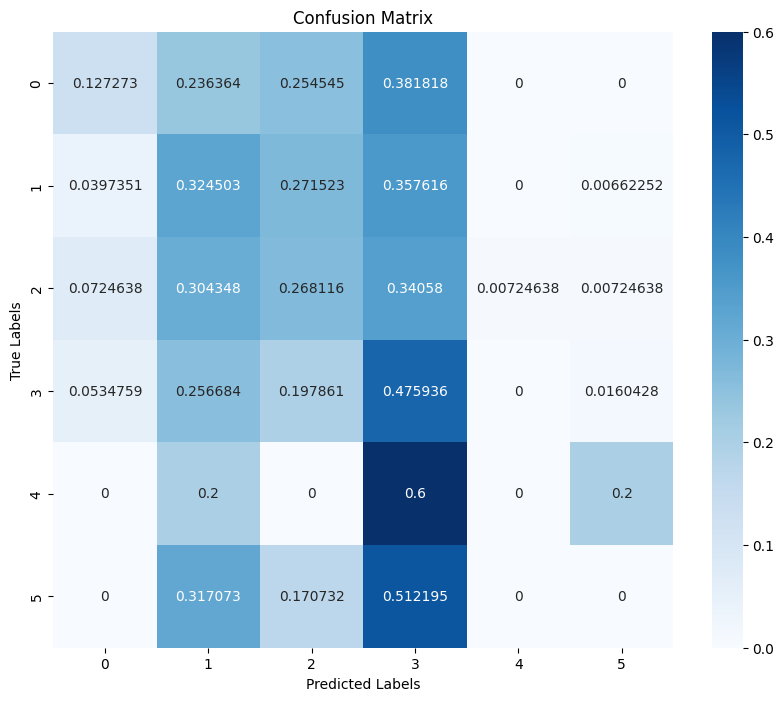

Epoch 15, Validation Loss: 3.4919, Accuracy: 0.3154, F1 Score: 0.2974
Val F1 Score Per Class  [0.15909091 0.30914826 0.27007299 0.42180095 0.         0.        ]


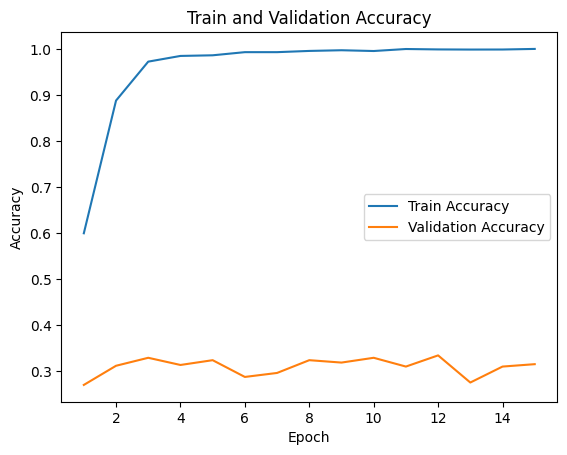

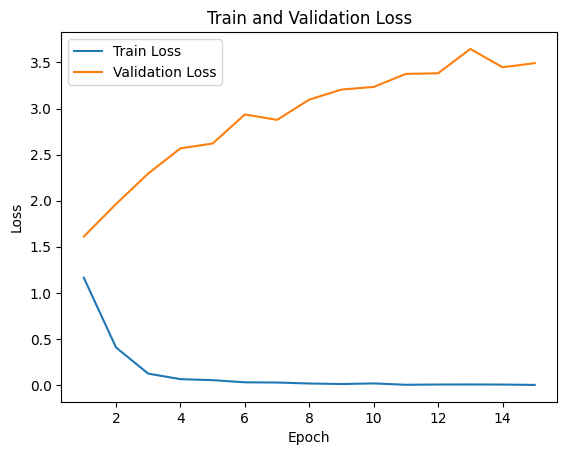

Epoch 16, Train Loss: 0.0014, Accuracy: 0.9998, F1 Score: 0.9998
Train F1 Score Per Class  [1.         0.99967959 0.99970735 0.99940547 1.         1.        ]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.18it/s, loss=4.39]

[tensor([-3.7197,  1.6836, -2.9489,  3.8302, -3.5703, -3.4284], device='cuda:0'), tensor([-2.6466,  2.3537, -1.5087, -0.3704, -5.4003, -4.9853], device='cuda:0'), tensor([-1.4365, -1.6860, -2.6732,  5.6670, -4.6949, -2.9633], device='cuda:0'), tensor([-2.1602, -1.1908, -2.8822,  5.9479, -3.9684, -2.6356], device='cuda:0'), tensor([-3.9785,  1.2715, -0.6173,  2.1794, -4.9553, -3.1673], device='cuda:0'), tensor([-4.0557,  0.3023,  2.3148, -0.3102, -3.8391, -3.9002], device='cuda:0'), tensor([-2.6614, -1.8938, -2.3049,  5.2447, -3.8617, -0.9233], device='cuda:0'), tensor([-2.7700, -2.7662,  3.1917,  3.0432, -3.0894, -2.4550], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=4.28]

[tensor([-2.0429, -1.2877, -3.0406,  4.7606, -4.5219, -2.8246], device='cuda:0'), tensor([-3.9609,  3.0077, -2.1951, -0.7471, -2.9903, -2.9167], device='cuda:0'), tensor([-0.3790, -1.8481,  0.6268,  1.0930, -4.2582, -4.1508], device='cuda:0'), tensor([-1.8919, -1.5859, -1.2336,  5.9703, -3.6007, -3.1494], device='cuda:0'), tensor([-1.2409,  6.6846, -1.7790, -1.3568, -3.0827, -3.0415], device='cuda:0'), tensor([-0.5989, -0.0063, -1.6262,  1.7238, -4.9612, -4.7730], device='cuda:0'), tensor([-1.3799, -1.7952, -2.6341,  3.4090, -3.6680, -3.3654], device='cuda:0'), tensor([ 5.7786, -0.4225, -3.0549,  0.2509, -3.3498, -2.6600], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=4.47]

[tensor([-3.2480, -1.0684, -0.5208, -0.7681, -5.1821, -4.4436], device='cuda:0'), tensor([-2.5964,  1.5115,  0.1830, -1.3823, -3.2773, -3.1315], device='cuda:0'), tensor([-3.0670, -2.3134,  1.1510, -0.3407, -3.7282, -3.2381], device='cuda:0'), tensor([-0.7855, -2.7376, -1.7550,  4.4915, -3.9038, -3.4784], device='cuda:0'), tensor([-1.7904,  0.2093, -3.0982,  4.0558, -3.9556, -3.8949], device='cuda:0'), tensor([-1.3362, -0.6795, -2.7010,  5.0815, -4.5423, -4.2662], device='cuda:0'), tensor([-1.4954, -2.4524, -2.3075,  4.5046, -3.9043, -3.4924], device='cuda:0'), tensor([ 1.0168, -1.8487, -0.9511, -1.3192, -4.6219, -4.0432], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.12it/s, loss=3.41]

[tensor([-2.3050, -1.8946, -1.0935,  5.9794, -3.7975, -3.0854], device='cuda:0'), tensor([-4.4514,  0.3370, -1.4943,  1.5748, -4.7272, -2.9179], device='cuda:0'), tensor([-2.8230, -0.4746, -2.7893,  0.6778, -4.2689, -0.2960], device='cuda:0'), tensor([-2.8547, -1.1757,  0.9190, -0.1820, -3.3555, -3.1516], device='cuda:0'), tensor([ 6.3416, -2.1744, -1.1133,  0.4331, -2.9986, -3.5059], device='cuda:0'), tensor([-2.7410, -2.2348, -0.6400,  4.6190, -4.7844, -2.3744], device='cuda:0'), tensor([-1.4121,  5.8201, -1.9227, -1.4461, -3.8918, -3.3181], device='cuda:0'), tensor([-3.6652,  2.3258, -1.1039,  0.9505, -3.7063, -2.6325], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.13it/s, loss=3.79]

[tensor([-2.8779, -1.3159, -1.9118,  5.6291, -3.3967, -3.7728], device='cuda:0'), tensor([-2.4162, -2.2379,  0.2344,  5.1931, -4.0213, -4.3184], device='cuda:0'), tensor([-2.0611, -2.6380,  3.6863,  0.0986, -4.2444, -3.4407], device='cuda:0'), tensor([-2.2473, -0.6566, -2.4147,  3.0667, -4.2850, -4.5699], device='cuda:0'), tensor([-2.8649, -1.9123,  2.8774,  1.2665, -4.3814, -3.8678], device='cuda:0'), tensor([-2.5318, -0.1987, -1.7535,  2.8205, -4.8431, -3.6921], device='cuda:0'), tensor([-2.8296,  0.0968, -2.5168, -0.7204, -4.4031, -2.4958], device='cuda:0'), tensor([-1.3560, -0.4023, -3.1923,  4.4279, -3.7703, -2.4216], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=5.39]

[tensor([-2.0974, -2.2131,  6.9142, -0.8953, -2.8341, -3.1357], device='cuda:0'), tensor([-2.1199, -2.1126,  6.7285, -1.4414, -2.7571, -1.8342], device='cuda:0'), tensor([-2.2177, -2.2911,  3.0411, -0.7436, -4.8131, -4.6933], device='cuda:0'), tensor([-3.1896,  1.6227, -2.2387, -0.4644, -4.1139, -3.4333], device='cuda:0'), tensor([-1.9827, -2.1831,  6.6840, -1.4245, -3.0515, -2.6162], device='cuda:0'), tensor([-1.5035, -1.8254, -1.7129,  6.0561, -4.1189, -3.2454], device='cuda:0'), tensor([-1.8424, -3.6920, -0.0965,  3.9500, -4.2802, -3.5764], device='cuda:0'), tensor([-2.2637, -2.0460, -2.0619,  4.4608, -3.6316, -3.7683], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=2.66]

[tensor([-2.5799, -1.4356, -0.5808,  2.6385, -4.4442, -3.4567], device='cuda:0'), tensor([-2.3863, -0.4968, -0.9337,  1.6120, -4.4071, -3.1641], device='cuda:0'), tensor([-0.7838, -2.0011,  6.2556, -1.5046, -2.5779, -2.8558], device='cuda:0'), tensor([-2.8021, -2.2769, -1.1095,  5.5697, -4.5002, -3.4666], device='cuda:0'), tensor([-3.0574,  4.3394, -0.0813, -0.4508, -3.9487, -5.0274], device='cuda:0'), tensor([-2.9155, -1.3063, -1.7771,  4.2270, -4.6723, -2.6546], device='cuda:0'), tensor([-2.8708, -3.8943,  0.8267,  2.3210, -3.7447, -1.1492], device='cuda:0'), tensor([-2.4088, -0.9558, -2.8280,  2.1719, -4.4708, -3.4542], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=5.65]

[tensor([-0.9433, -2.3900, -1.9204,  4.1915, -4.2148, -4.0074], device='cuda:0'), tensor([-2.0919, -2.6033,  3.3181, -0.2740, -3.2227, -2.9538], device='cuda:0'), tensor([-1.4098, -1.4969, -2.7531,  6.2972, -3.8515, -2.7201], device='cuda:0'), tensor([-1.3831,  6.3044, -2.3140, -0.8107, -3.1713, -3.4236], device='cuda:0'), tensor([-2.5708, -1.8989,  5.0633, -1.1710, -3.6371, -4.0192], device='cuda:0'), tensor([-1.4667, -1.5725, -2.0067,  3.9842, -4.3767, -5.0798], device='cuda:0'), tensor([-2.2108, -2.9339, -2.2142,  3.2388, -4.1418,  0.4224], device='cuda:0'), tensor([-2.3999, -2.3660,  5.9369, -0.2428, -3.0270, -2.3464], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.15it/s, loss=5.7]

[tensor([-2.6902, -1.3929, -3.1782,  3.3404, -4.5051, -2.1305], device='cuda:0'), tensor([-2.4860,  2.2707, -2.0953,  1.0784, -5.2849, -4.8201], device='cuda:0'), tensor([-0.8896,  5.0754, -1.7573, -0.6791, -3.6976, -4.3488], device='cuda:0'), tensor([-1.6714, -2.8825, -0.3515,  1.9394, -3.6192, -3.6499], device='cuda:0'), tensor([-2.0786, -2.2829, -1.1782,  5.5527, -3.3012, -2.8540], device='cuda:0'), tensor([-3.1250,  5.8656, -0.8162, -0.4511, -4.0502, -3.4607], device='cuda:0'), tensor([-2.9924, -0.2849, -3.5460,  4.7656, -3.9260, -2.7454], device='cuda:0'), tensor([-2.3175, -2.5133, -1.0788,  5.5442, -4.5360, -3.1318], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.16it/s, loss=3.43]

[tensor([-2.9037,  3.2683, -1.7122, -0.8876, -3.3561, -4.0916], device='cuda:0'), tensor([-2.8840, -1.9586,  0.5695,  3.0945, -4.0110, -3.8460], device='cuda:0'), tensor([-1.3449,  0.9722, -2.8184, -1.2255, -3.3568, -2.8092], device='cuda:0'), tensor([-2.2902, -1.7174, -0.5949,  4.9055, -4.1965, -4.5863], device='cuda:0'), tensor([-2.7604,  3.4729,  1.2289, -1.1683, -4.0112, -4.2100], device='cuda:0'), tensor([-1.0968, -1.5071, -0.8477,  4.7437, -4.5639, -4.9172], device='cuda:0'), tensor([-3.1650,  5.3032, -2.4079, -1.2419, -2.8709, -2.4881], device='cuda:0'), tensor([-2.4635,  5.3300, -2.1999,  0.3547, -4.1806, -3.9461], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.16it/s, loss=5.43]

[tensor([-2.2567, -2.0298, -1.7223,  6.1917, -3.3395, -2.9064], device='cuda:0'), tensor([-1.0809,  3.1468, -3.4421,  0.1245, -4.2458, -3.1585], device='cuda:0'), tensor([-2.7435, -2.7761,  0.9614,  5.1791, -4.3194, -2.5036], device='cuda:0'), tensor([-1.8867, -2.2755, -1.7792,  5.8616, -4.2963, -3.4018], device='cuda:0'), tensor([-3.4237,  2.3093, -2.7916,  0.2063, -4.6162, -1.9916], device='cuda:0'), tensor([-2.0677, -0.7947, -3.7792,  4.6168, -4.0513, -2.8429], device='cuda:0'), tensor([-4.2609, -1.4861, -0.6723,  2.6330, -4.4908, -3.3628], device='cuda:0'), tensor([-1.4867, -1.8760, -2.3865,  6.2885, -3.3570, -3.5598], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.15it/s, loss=2.6]

[tensor([-2.8718, -2.7471,  4.5708, -0.3759, -3.7696, -3.8202], device='cuda:0'), tensor([-3.9944,  0.9497,  0.0429,  1.6440, -4.5781, -4.0723], device='cuda:0'), tensor([-3.3199, -0.8558,  0.8300,  2.9294, -4.1471, -5.0881], device='cuda:0'), tensor([-2.5102,  1.5317, -2.4212,  0.9164, -3.9373, -4.1059], device='cuda:0'), tensor([ 0.0285, -1.0391, -1.9332, -1.0454, -4.1224, -5.3938], device='cuda:0'), tensor([-2.1834, -2.4283,  6.5777, -0.4275, -3.1253, -2.7626], device='cuda:0'), tensor([-1.5988, -1.5008, -3.0256,  4.9584, -4.1920, -2.9124], device='cuda:0'), tensor([-1.6468, -1.4193, -0.5534,  0.3072, -4.6479, -3.9435], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:27,  2.15it/s, loss=2.99]

[tensor([ 1.1139, -2.3460, -1.7336,  1.1235, -5.1298, -5.0471], device='cuda:0'), tensor([-3.5633,  1.3053, -0.1305,  3.1828, -3.9736, -3.3956], device='cuda:0'), tensor([-3.2284, -0.1125, -1.8252,  2.5878, -5.4209, -4.8098], device='cuda:0'), tensor([-3.3314,  1.9724,  1.3300, -1.9500, -4.4550, -3.5593], device='cuda:0'), tensor([-3.2716,  3.3301, -2.4943,  0.1226, -3.8658, -2.3112], device='cuda:0'), tensor([-2.5055, -1.8030, -1.0097, -0.4122, -4.3023, -3.0582], device='cuda:0'), tensor([-2.9346,  3.4933, -2.8644,  3.0916, -4.3201, -3.8531], device='cuda:0'), tensor([-1.1468,  0.6428, -2.7725,  3.5562, -4.4101, -4.7971], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=3.43]

[tensor([ 0.0830, -2.2068, -2.7210,  0.7921, -4.9104, -2.4102], device='cuda:0'), tensor([-2.9095, -0.7767, -2.6053,  3.0738, -4.3171, -3.7382], device='cuda:0'), tensor([-3.1714, -2.7849, -1.5350,  3.4163, -3.7177, -0.8024], device='cuda:0'), tensor([-1.8442, -0.6590, -2.6469,  4.5639, -4.8155, -3.5904], device='cuda:0'), tensor([-2.6086, -1.4591, -2.1993,  6.4165, -3.0568, -2.1346], device='cuda:0'), tensor([-3.0145,  0.5046, -2.2721,  4.1041, -4.1037, -3.7869], device='cuda:0'), tensor([-3.3241,  2.0254, -1.4434, -1.5826, -3.5955, -2.7885], device='cuda:0'), tensor([-2.3991, -0.8125, -2.1167,  5.1127, -4.4553, -3.6364], device='cuda:0')]


Val:  21%|██        | 15/73 [00:06<00:27,  2.14it/s, loss=4.1]

[tensor([-3.0764,  1.5800, -1.9998,  2.1407, -4.5978, -4.0230], device='cuda:0'), tensor([-2.1349,  3.1483, -1.5183, -0.7168, -4.6402, -4.4250], device='cuda:0'), tensor([-2.4888, -1.3319,  6.2737, -1.1494, -3.1339, -2.4496], device='cuda:0'), tensor([-1.7435, -2.2629, -1.5228,  6.4177, -3.7431, -3.3526], device='cuda:0'), tensor([-1.8632, -1.5331, -2.0257,  6.3805, -3.3504, -3.5897], device='cuda:0'), tensor([-3.0877,  1.1340, -0.7156, -1.5841, -4.6584, -4.8248], device='cuda:0'), tensor([-3.9304, -1.8381, -0.1208,  3.3660, -4.8373, -2.9822], device='cuda:0'), tensor([-3.2735, -1.4732, -0.4820,  3.2139, -4.8482, -5.3762], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.14it/s, loss=3.82]

[tensor([-1.6450, -1.5437, -2.0485,  6.5388, -3.6898, -3.0665], device='cuda:0'), tensor([-2.0174,  5.5246, -1.0524, -1.2618, -4.3341, -4.0498], device='cuda:0'), tensor([-2.1613, -1.3535, -1.9536,  5.2181, -4.2517, -4.6118], device='cuda:0'), tensor([-3.0771, -1.0419, -1.2985,  3.1196, -4.1901, -2.5835], device='cuda:0'), tensor([-2.0717, -2.5644, -1.5876,  2.6726, -3.7422, -3.3628], device='cuda:0'), tensor([-3.5193, -2.0352,  3.9342,  0.2238, -3.8053, -2.9506], device='cuda:0'), tensor([-1.7203, -2.0641, -2.0274,  6.2430, -4.7179, -3.6411], device='cuda:0'), tensor([-2.9862, -1.8939, -1.6604,  0.1265, -3.4682, -3.0404], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.15it/s, loss=4.51]

[tensor([-2.6854, -1.8430, -1.2060,  5.5286, -4.4465, -3.8915], device='cuda:0'), tensor([-1.1923,  1.1935,  1.1381, -1.3542, -4.2170, -3.4627], device='cuda:0'), tensor([-2.6239,  4.2771, -0.6379, -2.7147, -3.2734, -3.0045], device='cuda:0'), tensor([-3.0399,  0.6550, -2.0800,  1.5663, -4.8487, -4.0643], device='cuda:0'), tensor([-2.8060, -2.6510, -0.9601,  5.6294, -3.2277, -1.6194], device='cuda:0'), tensor([-1.7855, -2.0717, -1.8031,  5.8531, -4.0511, -3.2684], device='cuda:0'), tensor([ 1.9128, -2.6251, -1.5580,  0.7461, -4.2320, -3.2006], device='cuda:0'), tensor([-1.9580, -0.8510, -3.6729,  2.5441, -3.2142, -2.8968], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.15it/s, loss=2.61]

[tensor([-2.2932, -2.5118, -1.1016,  6.0394, -3.8198, -3.4311], device='cuda:0'), tensor([-1.1377, -2.0936, -1.5606,  5.0506, -3.2868, -4.2086], device='cuda:0'), tensor([-3.9932, -1.0471,  0.4889, -0.2517, -4.7010, -1.7166], device='cuda:0'), tensor([-2.8506,  0.8187, -0.9769,  0.3232, -4.0945, -4.4847], device='cuda:0'), tensor([-2.6953, -3.1653,  0.5217,  1.0723, -2.5679, -3.7497], device='cuda:0'), tensor([-1.0395, -2.2489, -2.2025,  3.3214, -4.3890, -2.4027], device='cuda:0'), tensor([-1.7422,  2.2366, -0.9202, -0.4756, -4.7432, -4.3062], device='cuda:0'), tensor([-2.5567, -1.6026, -1.2520,  4.9929, -3.9939, -4.2266], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.15it/s, loss=2.04]

[tensor([-2.5529, -1.6753,  0.9307, -1.0274, -4.5156, -5.0947], device='cuda:0'), tensor([ 4.7052, -1.8858, -2.4255,  0.0851, -3.9732, -3.8807], device='cuda:0'), tensor([-2.1477, -1.9115,  6.2556, -0.3793, -2.8278, -3.1271], device='cuda:0'), tensor([-2.1791, -2.0454, -1.4642,  6.2830, -3.2889, -2.8600], device='cuda:0'), tensor([-0.9661,  3.3877, -3.2575,  0.8329, -5.1944, -4.3857], device='cuda:0'), tensor([-0.4574, -1.9751, -2.9233,  3.0601, -3.7275, -3.7492], device='cuda:0'), tensor([-2.4603,  1.6189, -1.7614,  0.8743, -4.7738, -3.1002], device='cuda:0'), tensor([-2.0140,  0.9953,  0.1647, -0.7902, -3.8827, -3.6732], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=6.21]

[tensor([-2.0721, -2.2707, -0.6386,  5.7756, -3.8453, -3.9840], device='cuda:0'), tensor([-3.1775,  4.2579, -1.2484, -1.7525, -2.7882, -2.8027], device='cuda:0'), tensor([-2.2308, -1.9840, -0.5500,  4.3678, -3.5803, -2.2836], device='cuda:0'), tensor([-1.8573, -3.8330, -0.3357,  3.5669, -4.6718, -3.0345], device='cuda:0'), tensor([ 2.1961, -1.7568, -0.9436, -0.9825, -4.9586, -4.2832], device='cuda:0'), tensor([-3.1256,  3.6296, -1.6479, -0.0468, -3.8818, -2.3324], device='cuda:0'), tensor([-1.9908, -2.5350, -0.4987,  4.8679, -4.2938, -4.0641], device='cuda:0'), tensor([-2.5704, -1.8306,  3.9411,  0.1896, -3.9494, -3.9370], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.16it/s, loss=5.07]

[tensor([-1.3366, -3.4985,  2.5840,  0.2566, -3.4979, -2.8313], device='cuda:0'), tensor([-1.6999,  4.5836, -3.0457, -0.1233, -4.0346, -3.8750], device='cuda:0'), tensor([-3.1403,  3.8924,  0.9846, -1.9977, -4.1371, -3.0132], device='cuda:0'), tensor([-2.5108, -3.1657,  4.5786,  0.8792, -3.3042, -3.6928], device='cuda:0'), tensor([-2.9703, -1.8590,  1.2712,  3.4801, -4.9039, -4.6570], device='cuda:0'), tensor([-0.3997, -0.5968, -1.8045, -0.9840, -5.3774, -3.1857], device='cuda:0'), tensor([-1.7538, -2.1731, -1.5459,  6.4916, -3.0206, -2.8323], device='cuda:0'), tensor([-2.1332, -1.7625, -1.6525,  5.8271, -2.6377, -2.0195], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.15it/s, loss=2.42]

[tensor([-1.9935, -0.6864, -2.0626,  6.0957, -4.3840, -3.8295], device='cuda:0'), tensor([-2.3841, -2.2233, -0.7342,  1.2499, -3.5560, -3.4622], device='cuda:0'), tensor([-3.8467, -1.9496, -1.1403,  3.9538, -4.1696, -3.7360], device='cuda:0'), tensor([-2.8313, -1.2569, -2.3288,  5.9113, -2.8359, -1.6020], device='cuda:0'), tensor([-2.3971, -2.0324,  2.0767,  2.5340, -4.1532, -4.8819], device='cuda:0'), tensor([-1.4985, -2.9362,  0.1668,  5.0302, -3.6629, -4.1051], device='cuda:0'), tensor([-2.6240, -0.1790, -2.0961,  1.9918, -4.4802, -3.3714], device='cuda:0'), tensor([-3.2741, -2.1837,  0.6089,  4.6526, -4.0044, -3.7741], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.15it/s, loss=2.68]

[tensor([-1.8947, -1.0566, -0.8759,  3.5147, -4.8017, -4.6032], device='cuda:0'), tensor([-1.9887, -1.4134, -2.5756,  6.1092, -3.7989, -2.8969], device='cuda:0'), tensor([-1.6734, -1.4291, -2.5250,  6.0047, -2.8624, -3.2540], device='cuda:0'), tensor([-3.2597,  3.2349, -2.3541, -0.5081, -5.1127, -3.3405], device='cuda:0'), tensor([-2.8511,  1.2600, -2.0584,  3.4408, -4.5291, -3.7735], device='cuda:0'), tensor([-1.4991, -1.7814, -2.1490,  6.5380, -2.8239, -2.6679], device='cuda:0'), tensor([-1.3757, -3.0760, -0.8290,  4.5538, -3.6901, -4.1708], device='cuda:0'), tensor([-2.9736, -3.1190,  5.0483, -0.7142, -3.5540, -3.8404], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.16it/s, loss=3.42]

[tensor([-1.8125, -1.3530, -3.3831,  3.1514, -3.1818, -2.4144], device='cuda:0'), tensor([-1.5238, -1.9825, -2.0781,  5.2098, -4.4345, -3.4521], device='cuda:0'), tensor([-1.7782, -2.4947, -1.1590,  5.9208, -3.6455, -3.6419], device='cuda:0'), tensor([-0.6830, -2.0859,  2.1860, -1.6048, -3.6037, -4.8753], device='cuda:0'), tensor([-3.5914,  2.9258,  1.4278, -0.9995, -4.0209, -4.8882], device='cuda:0'), tensor([-2.2389, -2.7521,  3.2230,  2.2301, -3.6586, -4.3673], device='cuda:0'), tensor([-2.7573, -1.4300, -2.6636,  5.6825, -2.7136, -1.2354], device='cuda:0'), tensor([-1.6662,  2.4618, -3.1044,  1.2701, -5.5073, -2.6940], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.16it/s, loss=5.12]

[tensor([-2.5394,  0.0953, -1.3562,  5.0069, -4.9824, -2.8945], device='cuda:0'), tensor([-1.7899,  0.5712, -3.2287,  4.7148, -4.5653, -3.0440], device='cuda:0'), tensor([-2.7979,  4.5930, -1.0851, -0.3207, -4.0112, -3.9766], device='cuda:0'), tensor([-1.9936, -2.3981,  3.6426, -0.4982, -3.0646, -4.3232], device='cuda:0'), tensor([-1.8718, -0.1135, -1.5303,  2.1149, -5.4198, -4.9045], device='cuda:0'), tensor([-1.6675,  5.7834, -1.7178, -2.0562, -3.2989, -2.5903], device='cuda:0'), tensor([-3.9484,  3.7954, -2.5343, -1.3991, -5.9410, -2.5374], device='cuda:0'), tensor([-2.7083,  4.6734, -3.5276,  0.1586, -4.0939, -1.3159], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=3.17]

[tensor([-1.6264,  4.2322, -3.6599, -0.3028, -3.7774, -1.3153], device='cuda:0'), tensor([-2.7263, -0.5945, -0.8580, -1.9253, -4.4785, -2.5632], device='cuda:0'), tensor([-3.5961,  2.1287, -0.3617,  0.5735, -4.8570, -4.5079], device='cuda:0'), tensor([-2.2192, -1.5858, -0.1893, -1.8576, -4.6282, -5.1371], device='cuda:0'), tensor([-1.6234,  2.8607, -3.1363,  0.7693, -4.1600, -3.8936], device='cuda:0'), tensor([-2.4697, -1.3100, -1.8310,  5.6125, -3.0061, -2.5939], device='cuda:0'), tensor([ 1.0551, -3.0487, -0.7387,  0.7086, -4.3796, -3.6230], device='cuda:0'), tensor([-0.6761, -3.3809,  0.6376,  2.5069, -3.5885, -3.2555], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.15it/s, loss=4.05]

[tensor([-2.7433, -0.2404, -3.2762,  4.2917, -3.8439, -1.2896], device='cuda:0'), tensor([-1.6646,  5.7593, -0.1814, -1.4380, -3.3625, -3.9838], device='cuda:0'), tensor([-2.3287, -2.1052, -2.0525,  1.8647, -4.3745, -2.6361], device='cuda:0'), tensor([-2.5204, -1.5591, -1.7187,  5.4578, -3.4540, -2.8988], device='cuda:0'), tensor([-1.4526, -2.0337, -2.5006,  4.7400, -3.6064, -3.0631], device='cuda:0'), tensor([-3.5807,  2.1594, -0.4232,  2.2622, -4.7811, -5.4064], device='cuda:0'), tensor([-2.3679, -3.3359,  0.4605,  2.4861, -4.2480, -3.9749], device='cuda:0'), tensor([-2.6900,  3.7641, -2.6131,  0.3737, -3.9575, -3.1957], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.15it/s, loss=3.89]

[tensor([-1.3573, -1.9997,  4.9555, -0.7560, -3.1584, -3.3629], device='cuda:0'), tensor([-2.2794, -2.7167,  2.7468,  1.8905, -3.7785, -3.7494], device='cuda:0'), tensor([-1.4779, -2.4181, -1.5842,  3.7631, -4.5161, -3.7167], device='cuda:0'), tensor([-1.8189, -2.8098,  3.3380,  0.4790, -3.7494, -3.0826], device='cuda:0'), tensor([-2.5865, -1.5591,  4.7407, -0.2207, -3.7721, -3.6517], device='cuda:0'), tensor([-1.6660,  3.7046, -1.9703,  0.0480, -4.2636, -3.7481], device='cuda:0'), tensor([-2.1620, -2.6993,  1.6423,  2.4003, -4.0978, -2.2356], device='cuda:0'), tensor([-1.4604, -2.3489,  5.5328, -0.2297, -3.6404, -3.4418], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.15it/s, loss=4.33]

[tensor([ 5.7120, -1.5979, -1.5888, -1.0236, -3.1482, -1.7294], device='cuda:0'), tensor([-3.7841, -1.2841,  2.0033, -0.6270, -4.7863, -4.4569], device='cuda:0'), tensor([-0.8369, -0.5133, -2.8223,  4.8025, -3.9395, -4.4131], device='cuda:0'), tensor([-1.7202, -0.8475,  2.2020, -0.0938, -3.3946, -2.6214], device='cuda:0'), tensor([-2.6944,  5.7232, -0.9945, -0.2533, -3.9542, -4.3007], device='cuda:0'), tensor([-2.3244, -2.0505,  6.2369, -1.1040, -2.8455, -1.8787], device='cuda:0'), tensor([-2.3131, -1.6026,  3.3992,  0.3728, -4.0219, -3.3997], device='cuda:0'), tensor([-3.4282,  3.5359, -1.3302,  0.5146, -3.7974, -3.5254], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:20,  2.15it/s, loss=4.88]

[tensor([-2.4043,  4.8842, -2.6363, -0.1154, -5.4371, -4.5623], device='cuda:0'), tensor([-1.8950, -3.0213,  1.1488,  4.5746, -3.4627, -3.4217], device='cuda:0'), tensor([-4.0932,  1.5999, -2.6792,  1.6041, -5.1624, -1.5926], device='cuda:0'), tensor([-2.9503, -1.7746, -2.3063,  4.1682, -3.3336, -1.3822], device='cuda:0'), tensor([-1.8712, -1.6835, -1.5815,  6.3943, -3.1011, -3.3530], device='cuda:0'), tensor([-1.4286, -2.3082,  1.3970,  0.1738, -3.9724, -4.5082], device='cuda:0'), tensor([-0.2839, -2.5867,  3.5128, -1.0235, -2.6618, -2.2910], device='cuda:0'), tensor([ 6.1447, -2.0150, -2.4286, -0.1946, -2.8943, -1.9288], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.15it/s, loss=3.41]

[tensor([-2.3712, -2.5370, -0.6668,  5.9623, -3.2924, -2.6026], device='cuda:0'), tensor([-0.4022, -2.1921, -2.8755,  2.6591, -5.0655, -3.9761], device='cuda:0'), tensor([-3.3782, -1.8680,  3.3805,  2.4821, -5.5322, -3.2868], device='cuda:0'), tensor([-0.3143, -2.6624, -0.4194,  2.9785, -5.1866, -4.8864], device='cuda:0'), tensor([ 1.7817, -2.1093, -0.5923, -0.3189, -4.6453, -4.9448], device='cuda:0'), tensor([-2.6620, -0.5657, -1.6312, -1.3197, -3.3412, -1.3749], device='cuda:0'), tensor([-0.2698,  4.8112, -3.3362, -1.3047, -3.5511, -3.5001], device='cuda:0'), tensor([-2.4510, -0.5030, -2.4945,  5.2870, -4.0502, -4.7870], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:18,  2.16it/s, loss=3.26]

[tensor([-3.5195,  1.3521,  1.2496, -1.8787, -3.9889, -0.0960], device='cuda:0'), tensor([-0.2073, -2.3858, -0.7567,  3.5191, -4.2289, -4.9911], device='cuda:0'), tensor([-1.3392, -1.8022, -1.2641,  5.0425, -4.9280, -5.3110], device='cuda:0'), tensor([-2.4952, -2.5569,  0.0994,  3.9570, -4.4504, -3.8077], device='cuda:0'), tensor([-3.3503, -1.3760,  2.9374, -0.5097, -3.5212, -3.6802], device='cuda:0'), tensor([-2.2517,  6.6976, -1.1689, -1.7523, -3.3979, -2.3727], device='cuda:0'), tensor([-1.9453, -1.5934, -1.4555, -0.9500, -2.4533,  8.0170], device='cuda:0'), tensor([-2.2990, -2.2464, -1.7919,  3.5321, -3.2401, -4.1587], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.16it/s, loss=4.78]

[tensor([-2.6468, -1.3888, -0.2765,  3.7131, -5.3437, -4.4872], device='cuda:0'), tensor([-1.6811,  0.3495, -2.9226,  2.1440, -3.4788, -4.2174], device='cuda:0'), tensor([-3.0899, -1.8934,  0.8883, -1.2095, -4.8069, -4.8026], device='cuda:0'), tensor([-3.4203,  1.2517, -3.3725,  0.3337, -3.3116,  1.4054], device='cuda:0'), tensor([-1.5750, -2.0710, -2.5028,  5.8873, -3.4328, -3.6238], device='cuda:0'), tensor([-3.5545, -1.4835, -1.5814,  4.9792, -3.4640, -3.7584], device='cuda:0'), tensor([-2.3262, -1.5622, -1.4308,  5.7064, -4.1959, -3.7783], device='cuda:0'), tensor([ 2.6514, -2.6390, -2.5345,  3.0571, -3.1534, -3.2186], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.21]

[tensor([-3.3596, -0.1434,  1.6114,  0.3318, -5.7904, -4.6622], device='cuda:0'), tensor([-2.6202, -2.4962, -0.7665,  1.7144, -4.1107, -4.3805], device='cuda:0'), tensor([-2.1181, -1.1984,  6.3892, -1.6784, -2.8540, -3.3540], device='cuda:0'), tensor([ 0.0151, -3.1808,  2.0636, -0.3321, -4.6296, -3.5095], device='cuda:0'), tensor([-1.8072, -0.5301, -2.7241,  5.1506, -3.9624, -3.1744], device='cuda:0'), tensor([-3.0610, -2.6272,  5.1007,  1.2005, -3.6067, -3.5673], device='cuda:0'), tensor([ 4.1042, -2.4408, -2.1385,  0.3837, -3.4319, -3.0080], device='cuda:0'), tensor([-2.1216,  0.6959, -2.5164,  1.8265, -4.5426, -4.4796], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=3.09]

[tensor([-1.3708, -1.7247, -2.0079,  5.7253, -3.4025, -4.2872], device='cuda:0'), tensor([-2.9588, -1.5026, -0.0486, -1.6599, -3.1975,  0.4427], device='cuda:0'), tensor([-1.4500, -1.5631, -3.1276,  5.0131, -4.3891, -3.3625], device='cuda:0'), tensor([ 2.0418, -2.7450, -0.9519, -0.7237, -3.9930, -3.2216], device='cuda:0'), tensor([-2.1264, -0.4658,  0.1893, -1.4212, -3.1972, -2.5089], device='cuda:0'), tensor([-2.4420, -1.7637, -1.8887,  5.9104, -3.5573, -2.2342], device='cuda:0'), tensor([-0.7991, -2.4510, -1.9350,  3.5117, -4.1282, -3.1177], device='cuda:0'), tensor([-3.4787,  4.4488, -2.0322, -0.7734, -4.1255, -1.1053], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.14it/s, loss=2.01]

[tensor([-2.3504, -0.9894, -2.2410,  2.8595, -4.3146, -3.9624], device='cuda:0'), tensor([ 1.1202, -2.7273, -2.0335,  1.0408, -4.2398, -3.4948], device='cuda:0'), tensor([-3.3051, -1.2506, -2.6859,  4.4902, -3.0060, -3.3225], device='cuda:0'), tensor([-3.2263,  0.1847, -1.6953,  1.7466, -4.1627, -4.4665], device='cuda:0'), tensor([-1.7154, -2.6737,  0.9128,  3.3833, -4.0781, -4.8066], device='cuda:0'), tensor([-3.2221,  2.9151,  0.5049, -1.5737, -3.2081, -4.5987], device='cuda:0'), tensor([-2.8852,  1.2702, -1.8546, -0.4800, -4.8352, -3.4475], device='cuda:0'), tensor([-3.6050,  2.0872, -1.0418, -0.8254, -3.9330, -4.4792], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.13it/s, loss=4.91]

[tensor([-1.7229, -1.6957, -1.8781,  6.0479, -4.1019, -4.0118], device='cuda:0'), tensor([-2.9252,  4.3804, -2.9373,  1.5493, -3.0039, -3.2944], device='cuda:0'), tensor([-2.0194, -1.0465, -2.7977,  5.7142, -4.8946, -2.6332], device='cuda:0'), tensor([-2.6079, -0.5003,  5.8722, -1.4615, -3.5444, -3.9573], device='cuda:0'), tensor([-3.2790,  0.3592, -2.8790, -0.8026, -4.3725, -3.0976], device='cuda:0'), tensor([-2.4193,  0.9646, -1.5551, -1.1342, -3.4541, -3.2440], device='cuda:0'), tensor([-2.3722,  5.6974, -0.9846, -1.0966, -4.2059, -4.1845], device='cuda:0'), tensor([-2.7855, -1.4080, -2.1483,  5.5799, -3.9865, -3.1341], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=4.53]

[tensor([-2.8081, -1.1112, -3.1692,  5.3609, -3.7989, -1.9989], device='cuda:0'), tensor([-2.5943, -2.0144,  3.3024,  1.9482, -2.4404, -3.2517], device='cuda:0'), tensor([-2.6237, -0.6626, -1.7377,  5.7283, -3.5478, -4.1535], device='cuda:0'), tensor([-2.4740, -1.7387,  4.0512, -1.6828, -4.6509, -4.1624], device='cuda:0'), tensor([-2.1909, -1.9572,  6.2434, -1.2799, -3.0585, -1.3938], device='cuda:0'), tensor([-1.2972, -2.5487,  0.3390,  1.7343, -3.6585, -4.0417], device='cuda:0'), tensor([-2.5871,  5.8103, -1.9125, -1.4650, -2.7389, -2.2634], device='cuda:0'), tensor([-1.6363,  2.4213, -2.3132,  0.6792, -4.5253, -4.9503], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.13it/s, loss=5.12]

[tensor([-1.8426,  3.5355,  0.4298, -1.0420, -4.7794, -4.6491], device='cuda:0'), tensor([-2.2516, -1.3912, -2.8536,  5.1761, -2.0408, -0.8568], device='cuda:0'), tensor([ 2.9009, -0.8093, -3.0556, -0.0803, -3.6240, -3.8548], device='cuda:0'), tensor([-2.3853,  1.2905, -2.3318,  3.7773, -4.6734, -4.7720], device='cuda:0'), tensor([-1.6597, -0.1493, -2.6117,  3.3879, -4.4134, -4.5767], device='cuda:0'), tensor([-1.9537, -3.2258,  2.9041, -0.3527, -3.8941, -3.7184], device='cuda:0'), tensor([-2.0962, -1.0476, -2.0985,  5.0995, -3.2572, -5.0545], device='cuda:0'), tensor([-3.0480, -2.2590,  5.5875,  1.0157, -3.5853, -3.0808], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.13it/s, loss=3.34]

[tensor([-3.6822,  2.3721, -1.2578,  1.7740, -4.8247, -5.0763], device='cuda:0'), tensor([-3.1926, -1.4453, -1.9195,  4.8633, -4.2307, -3.1089], device='cuda:0'), tensor([-3.6062, -0.1927, -1.9333,  2.3227, -3.8648, -3.9469], device='cuda:0'), tensor([-1.4465, -2.2609,  6.8546, -1.8193, -2.4209, -2.2463], device='cuda:0'), tensor([-1.6370,  0.0618, -2.9221,  3.2171, -2.8433, -4.5183], device='cuda:0'), tensor([-3.3801, -2.8112,  1.1675, -1.6660, -4.2796, -2.1473], device='cuda:0'), tensor([-2.5409, -2.5626, -0.7214,  4.0751, -5.1346, -3.0760], device='cuda:0'), tensor([-0.9774, -2.6475,  0.6522,  1.1790, -2.2493, -4.0217], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.13it/s, loss=3.73]

[tensor([-1.6759, -1.6591, -2.0171,  6.5980, -2.8579, -2.9548], device='cuda:0'), tensor([-1.6324, -1.8097, -2.5733,  6.4848, -3.7623, -2.4494], device='cuda:0'), tensor([-2.4477, -1.7853, -1.7465,  5.7668, -4.1394, -3.0642], device='cuda:0'), tensor([-1.1319, -1.3407, -3.7677,  4.1473, -3.6112, -2.4894], device='cuda:0'), tensor([-2.9422,  1.1179,  0.2421, -0.1821, -3.8687, -4.4386], device='cuda:0'), tensor([-2.7792, -1.9287,  5.8133, -0.3697, -3.1182, -3.2845], device='cuda:0'), tensor([-1.2811,  0.2890, -1.7792,  1.2930, -4.4700, -4.5033], device='cuda:0'), tensor([-1.0613, -2.4891,  5.6089, -0.3084, -3.3814, -3.2235], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.14it/s, loss=3.86]

[tensor([-3.6304, -0.2076, -1.8375, -0.2158, -4.8481, -2.3999], device='cuda:0'), tensor([-0.9324, -1.7592, -3.1511,  5.2557, -3.3148, -3.6135], device='cuda:0'), tensor([ 7.3933, -1.8016, -1.4191, -0.9902, -2.2956, -1.4038], device='cuda:0'), tensor([-2.5023,  5.4818, -2.9691, -0.0249, -3.1619, -3.3752], device='cuda:0'), tensor([-1.7950, -1.2307, -3.4803,  4.9399, -4.2884, -2.7302], device='cuda:0'), tensor([-1.5302, -0.1451, -2.8739,  4.4470, -4.6183, -3.8552], device='cuda:0'), tensor([-0.2241, -0.7132, -2.4927,  4.7742, -4.6323, -4.7863], device='cuda:0'), tensor([-2.8379, -0.9933,  0.2811, -1.4726, -4.6554, -1.7085], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.15it/s, loss=4.01]

[tensor([-2.0111, -1.5391, -2.5092,  5.3435, -4.3580, -2.5624], device='cuda:0'), tensor([-3.1217, -2.1962, -1.7590,  2.3228, -3.0218, -2.1145], device='cuda:0'), tensor([-2.2184, -2.3938, -1.2573,  6.2030, -4.1270, -2.7503], device='cuda:0'), tensor([-1.4491, -1.9640, -1.4935,  6.3265, -3.8534, -3.1039], device='cuda:0'), tensor([-3.1310e+00,  4.4313e+00, -3.9817e-03, -5.3190e-02, -4.2878e+00,
        -4.3154e+00], device='cuda:0'), tensor([-2.1052, -1.8533, -2.9340,  3.4258, -5.5974, -3.3722], device='cuda:0'), tensor([-1.5990, -2.4929, -0.4908,  6.1986, -3.6687, -4.0126], device='cuda:0'), tensor([-0.6938, -2.3573, -1.8325,  4.5349, -3.7055, -4.0270], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.14it/s, loss=2.92]

[tensor([-0.7249, -1.5922, -1.0844,  2.6860, -3.9792, -4.9774], device='cuda:0'), tensor([-0.9297, -2.5245, -1.3262,  0.3244, -3.7826, -4.2756], device='cuda:0'), tensor([-3.0693, -1.8701, -2.0315,  5.6685, -4.3812, -2.9900], device='cuda:0'), tensor([-3.6462, -1.2297, -1.0903,  2.1463, -4.9041, -3.0373], device='cuda:0'), tensor([-2.3691, -2.4435,  1.0619,  1.2292, -3.1786, -2.9092], device='cuda:0'), tensor([-3.9543,  0.3629, -0.4374,  2.8528, -4.7527, -4.1857], device='cuda:0'), tensor([ 1.8227, -2.3417, -0.4203,  1.6946, -4.3417, -3.2263], device='cuda:0'), tensor([-2.1084,  3.6522, -3.0642, -0.3885, -3.2729, -1.6073], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.14it/s, loss=3.49]

[tensor([ 2.5301, -0.8625, -3.6573, -0.8681, -4.5080, -1.8309], device='cuda:0'), tensor([-2.7878,  1.0526, -2.9293,  2.8929, -3.1487, -3.2710], device='cuda:0'), tensor([-2.8560,  0.6426, -2.9228,  4.3610, -3.7592, -1.4412], device='cuda:0'), tensor([-2.2550, -1.6958, -1.6649, -0.2453, -3.7636, -3.4357], device='cuda:0'), tensor([-2.5739, -3.2357,  2.5076,  2.9236, -4.0094, -2.9428], device='cuda:0'), tensor([-1.8409, -1.9935, -2.4698, -1.0005, -2.5870,  7.2417], device='cuda:0'), tensor([-3.4696,  3.4675, -0.8796,  0.7362, -4.1867, -3.7106], device='cuda:0'), tensor([-2.8352, -1.6859, -2.1169,  4.6153, -4.2020, -2.4428], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.14it/s, loss=2.85]

[tensor([-2.9008, -0.7628,  3.8566, -1.1054, -4.4214, -4.2673], device='cuda:0'), tensor([-1.2140,  0.7322, -1.5093,  2.2374, -3.1126, -3.1010], device='cuda:0'), tensor([-3.1118, -1.1595, -0.9690,  4.6934, -3.9451, -4.7810], device='cuda:0'), tensor([-1.9118, -2.5135,  6.3304, -1.7121, -2.9050, -1.3325], device='cuda:0'), tensor([-3.0902, -0.8429, -2.6658,  5.1187, -3.2567, -2.2638], device='cuda:0'), tensor([-2.1957,  5.5847, -2.6351, -0.5893, -2.9781, -3.0614], device='cuda:0'), tensor([-2.2195,  0.0091,  0.0586,  1.6619, -4.6521, -4.2978], device='cuda:0'), tensor([-2.7516, -1.4510,  4.0458, -0.9624, -3.4829, -4.1763], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.14it/s, loss=3.36]

[tensor([ 5.1602, -1.8185, -3.6327,  0.6994, -3.0494, -2.7944], device='cuda:0'), tensor([-2.2203, -1.4577, -1.1578,  4.4048, -5.4487, -3.9744], device='cuda:0'), tensor([-3.1006, -1.8506, -0.8742,  3.2801, -3.6941, -3.4667], device='cuda:0'), tensor([-2.4201, -1.2064,  2.9341,  0.6102, -4.1848, -4.2376], device='cuda:0'), tensor([-1.3088,  3.0140, -1.2106,  1.7591, -4.7613, -4.8596], device='cuda:0'), tensor([-1.9077, -1.2358, -2.7087,  4.7178, -4.3658, -3.0753], device='cuda:0'), tensor([-1.4636, -1.7335, -2.0126,  2.1015, -2.2074, -3.7494], device='cuda:0'), tensor([-2.1893, -1.3304, -1.6242,  5.9462, -4.3406, -3.7855], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.15it/s, loss=3.31]

[tensor([-2.0879, -1.9442,  6.7296, -1.6982, -2.9245, -1.9987], device='cuda:0'), tensor([-2.5646,  0.5800, -2.0084,  2.4959, -5.1144, -4.6371], device='cuda:0'), tensor([-2.5317,  6.4445, -1.2691, -1.7323, -3.4427, -2.9056], device='cuda:0'), tensor([-1.6518,  2.7235, -2.7197,  1.8196, -4.7714, -4.6145], device='cuda:0'), tensor([-1.5273, -2.0741, -2.0984,  6.5217, -3.3073, -2.7923], device='cuda:0'), tensor([ 3.4495, -0.6746, -1.8349, -0.7075, -3.7464, -2.3225], device='cuda:0'), tensor([-2.3274, -2.0127, -0.0986,  3.8528, -4.9887, -4.5315], device='cuda:0'), tensor([-3.2185, -1.0632, -1.2766,  5.7365, -3.7071, -3.5176], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.16it/s, loss=3.4]

[tensor([-3.3886, -2.4893,  2.4192,  1.9110, -3.6822, -4.1294], device='cuda:0'), tensor([-0.4525,  0.8591, -2.7207,  1.8995, -4.0824, -4.3164], device='cuda:0'), tensor([-3.3877, -0.9902,  4.5962, -1.0756, -2.4529, -2.6536], device='cuda:0'), tensor([-2.3844, -2.1935,  4.1990,  0.5926, -3.5282, -3.0491], device='cuda:0'), tensor([-3.1594,  4.1608,  0.7626, -1.8937, -3.9312, -3.7461], device='cuda:0'), tensor([ 2.0852, -3.2257, -0.6873, -0.3728, -3.5420, -4.2274], device='cuda:0'), tensor([-2.9998,  0.3487,  0.4657, -0.2140, -5.4373, -1.0788], device='cuda:0'), tensor([-2.3667, -2.3472, -1.3525,  6.3003, -3.4252, -2.6463], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=2.86]

[tensor([-0.6441, -1.6382, -2.3978,  1.5124, -5.0040, -3.5463], device='cuda:0'), tensor([-2.2117, -2.0178, -1.8333,  6.0426, -4.1711, -3.3166], device='cuda:0'), tensor([-3.5026,  0.1181,  2.2353,  2.1148, -3.7926, -3.3947], device='cuda:0'), tensor([-1.4024,  2.4987, -1.9864,  2.1038, -6.1944, -4.2465], device='cuda:0'), tensor([-2.2607, -2.3300,  2.6683, -0.7915, -5.0183, -4.1385], device='cuda:0'), tensor([-1.8901, -1.9529, -2.2477,  6.3618, -2.7548, -2.0770], device='cuda:0'), tensor([-2.5409, -1.9086, -1.1372,  6.1474, -3.5981, -2.1832], device='cuda:0'), tensor([-2.6561,  1.0411, -2.5199,  2.7256, -4.2400, -4.6092], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=2.42]

[tensor([-2.0151, -2.6277,  3.0318,  2.1009, -4.3597, -3.6234], device='cuda:0'), tensor([-1.7224, -2.0687, -2.1062,  6.5249, -3.4706, -2.2526], device='cuda:0'), tensor([-3.9539,  1.7248,  1.3729,  0.0239, -3.8703, -1.5848], device='cuda:0'), tensor([-1.9683, -1.5072, -1.9046,  6.3504, -3.3937, -3.5502], device='cuda:0'), tensor([-2.5722,  1.0891, -1.2159,  2.2137, -4.3673, -4.0293], device='cuda:0'), tensor([-0.2991, -0.3210, -4.2326,  4.6244, -4.2133, -2.4917], device='cuda:0'), tensor([-2.1761, -1.3402, -1.8986,  5.8464, -3.8613, -2.7178], device='cuda:0'), tensor([-0.2717,  0.3584, -2.3177, -2.7421, -4.0517,  3.8382], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.15it/s, loss=2.89]

[tensor([-3.7081, -0.4780, -0.8219,  3.3940, -5.1564, -2.3776], device='cuda:0'), tensor([-1.3996, -1.6486, -1.4794,  6.1851, -3.5084, -4.1828], device='cuda:0'), tensor([ 1.9838, -0.8912, -3.0170,  1.6537, -2.2977, -4.5236], device='cuda:0'), tensor([-2.3906,  0.7938, -3.2697,  2.0779, -4.2460, -3.1889], device='cuda:0'), tensor([-2.4194, -2.3942,  0.8434, -1.1576, -3.3566,  0.2421], device='cuda:0'), tensor([-2.5699,  4.4401, -3.1071, -0.5610, -3.2616, -3.3902], device='cuda:0'), tensor([ 3.2096, -2.9599,  1.8770, -0.8640, -3.6391, -2.8713], device='cuda:0'), tensor([-2.4618,  4.9092, -1.3509, -0.6450, -4.0742, -3.2890], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.13it/s, loss=4.05]

[tensor([-2.0159e+00, -3.6904e-03, -3.1181e+00,  5.3852e+00, -3.8751e+00,
        -3.4181e+00], device='cuda:0'), tensor([-1.3578, -2.5503, -1.1478,  2.5263, -4.0829, -4.2385], device='cuda:0'), tensor([-2.5870, -2.3287, -1.5682,  2.5452, -5.1899, -1.1017], device='cuda:0'), tensor([-0.5551, -0.8187, -2.3226,  3.6521, -4.9156, -4.6773], device='cuda:0'), tensor([ 4.0972, -1.4850,  0.0260, -2.0731, -3.5280, -2.6216], device='cuda:0'), tensor([-1.5969, -1.9677, -2.4706,  5.2906, -4.3770, -4.6915], device='cuda:0'), tensor([-1.2763, -1.7558, -0.7907,  5.1188, -4.7080, -4.4834], device='cuda:0'), tensor([-3.2543, -1.4915,  4.6760, -1.1913, -3.4555, -4.0786], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.13it/s, loss=3.24]

[tensor([-3.1399, -2.1617, -0.9026,  5.5303, -3.8752, -2.6757], device='cuda:0'), tensor([ 1.0217, -2.3074, -2.2454,  1.4616, -4.4261, -3.4447], device='cuda:0'), tensor([-2.5401,  1.6889,  0.1842, -1.2490, -4.2065, -2.5080], device='cuda:0'), tensor([-1.7310, -2.0278, -1.6942,  6.4820, -3.7899, -2.5839], device='cuda:0'), tensor([-2.2734, -2.3218, -1.4055,  6.3956, -3.8668, -3.1143], device='cuda:0'), tensor([-2.7918, -1.4668, -2.5569,  1.7413, -4.1327, -1.3226], device='cuda:0'), tensor([-2.0985,  4.3714,  0.2981, -1.4996, -4.4205, -4.5377], device='cuda:0'), tensor([-3.3596, -0.7747, -1.9058, -0.6977, -4.7504,  0.6886], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.13it/s, loss=3.69]

[tensor([-1.9459, -2.1278,  6.5331, -0.9828, -2.7044, -2.2511], device='cuda:0'), tensor([ 0.2095, -0.9780,  0.8002,  0.0315, -4.8973, -5.5710], device='cuda:0'), tensor([ 2.5799, -2.2963, -0.8260, -0.4742, -3.7378, -4.8769], device='cuda:0'), tensor([-2.1137,  1.5338, -1.9242, -0.8532, -4.8478, -3.7072], device='cuda:0'), tensor([-2.7647,  1.8143, -1.7608,  1.5768, -4.0281, -3.6721], device='cuda:0'), tensor([-1.7546, -2.1215,  3.6845, -0.4660, -3.7751, -3.5687], device='cuda:0'), tensor([-2.3981, -2.4809, -1.1188,  5.9891, -3.2848, -2.7604], device='cuda:0'), tensor([-1.7156,  6.3119, -1.7646, -1.1888, -3.8807, -3.3284], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=3.97]

[tensor([-3.3680,  1.3379, -0.9997, -1.3949, -4.2644, -3.2559], device='cuda:0'), tensor([-2.3928, -0.2930, -2.9664,  4.4414, -2.9095, -3.4972], device='cuda:0'), tensor([-1.9417, -3.2876,  0.4489,  1.2427, -4.9110, -3.6023], device='cuda:0'), tensor([-2.5927, -1.8695, -1.3378,  2.6565, -4.9911, -5.2238], device='cuda:0'), tensor([-2.6155,  5.7127, -1.7681,  0.1317, -3.8926, -4.1999], device='cuda:0'), tensor([-1.7850, -2.2993, -1.9696,  5.7395, -4.3567, -1.7910], device='cuda:0'), tensor([-2.4972, -0.9813, -2.5423,  0.0819, -4.2896, -3.9997], device='cuda:0'), tensor([-2.5515,  0.8482, -3.0115,  4.7954, -3.2648, -2.6650], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.12it/s, loss=3.11]

[tensor([-1.6350,  4.7254, -1.8838, -0.8076, -2.7507, -2.9056], device='cuda:0'), tensor([-2.1756, -1.2214, -2.2173,  1.5918, -4.4777, -4.6201], device='cuda:0'), tensor([-1.4730, -1.2314,  2.2837, -0.8488, -4.6612, -3.7360], device='cuda:0'), tensor([-1.8759, -1.7827, -1.8703,  0.8945, -4.4817, -4.3626], device='cuda:0'), tensor([-2.4295, -2.0187, -1.8914,  5.7986, -3.3825, -2.1882], device='cuda:0'), tensor([-2.2897, -2.1038,  3.2104, -0.7471, -3.6316, -4.3485], device='cuda:0'), tensor([-1.5930,  4.4504, -3.2033, -0.3071, -3.4157, -4.2940], device='cuda:0'), tensor([-2.1311, -1.9520, -1.1929,  5.6915, -3.3498, -3.3329], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.12it/s, loss=3.05]

[tensor([-3.3597, -1.2353, -1.0893,  4.8960, -4.0757, -4.8288], device='cuda:0'), tensor([-1.6188, -2.5994, -0.2353,  1.4570, -4.1892, -4.5109], device='cuda:0'), tensor([-2.8169,  4.6252, -1.8604, -0.9962, -3.7615, -2.6462], device='cuda:0'), tensor([-0.7417, -1.4448, -3.8850,  4.5969, -2.3058, -3.4372], device='cuda:0'), tensor([-3.1184, -1.6203, -1.2642,  2.2895, -4.8727, -4.4823], device='cuda:0'), tensor([-3.3435, -0.5994,  1.7682,  2.8796, -4.3308, -4.7391], device='cuda:0'), tensor([-3.5033,  1.1475,  3.4229, -1.7305, -4.5124, -4.1597], device='cuda:0'), tensor([-2.6714, -0.1720, -0.3005,  2.5150, -4.4161, -4.6072], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.13it/s, loss=1.58]

[tensor([-1.2843, -2.2454, -1.8409,  6.1237, -3.0200, -3.2815], device='cuda:0'), tensor([-3.1158,  0.7155, -1.4387,  0.4421, -5.1386, -4.1281], device='cuda:0'), tensor([-1.2222, -0.5302, -3.8725,  4.5232, -3.8986, -2.9402], device='cuda:0'), tensor([-1.9146, -1.3280, -1.9837,  3.7412, -4.9626, -3.2606], device='cuda:0'), tensor([-2.4972,  1.0177, -0.1960,  1.3466, -5.3238, -5.3087], device='cuda:0'), tensor([ 0.1842, -0.4201, -2.6873,  1.3181, -3.8279, -5.3174], device='cuda:0'), tensor([-2.9023,  4.7055, -1.7764,  0.1802, -4.2897, -4.4667], device='cuda:0'), tensor([-2.0914, -2.9910, -0.0237,  0.2420, -3.6843, -3.2311], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.13it/s, loss=3.54]

[tensor([-1.7779, -1.0945, -1.9581,  5.3959, -3.3129, -2.6661], device='cuda:0'), tensor([-3.2313, -0.0158,  0.0952,  2.6608, -4.6348, -4.9475], device='cuda:0'), tensor([-0.8042, -2.2425, -1.5741, -0.8458, -4.2761, -5.0027], device='cuda:0'), tensor([-2.7926, -1.3001, -1.8633,  5.6596, -2.6949, -2.5205], device='cuda:0'), tensor([-3.4758,  0.4913,  1.6682,  0.3515, -4.6259, -4.6526], device='cuda:0'), tensor([-2.0926, -2.2016, -1.4185,  6.1669, -4.1089, -3.6385], device='cuda:0'), tensor([-1.7862, -2.0575, -1.7484,  6.4331, -3.9954, -2.7700], device='cuda:0'), tensor([-0.1802, -1.8900, -2.6087,  0.1875, -5.0570, -4.7606], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.13it/s, loss=4.68]

[tensor([-1.3507, -3.0388, -2.0890,  5.3638, -2.9776, -2.8218], device='cuda:0'), tensor([-1.4960, -0.5082,  2.0963, -1.7677, -3.1607, -4.1285], device='cuda:0'), tensor([-2.0981, -0.6538, -3.1862,  4.4509, -4.1593, -3.2990], device='cuda:0'), tensor([-3.5270, -1.7598,  2.8199,  0.3324, -3.0366, -2.0885], device='cuda:0'), tensor([-2.9205, -2.1228, -1.5380,  5.4000, -3.5270, -2.3060], device='cuda:0'), tensor([-1.9905,  1.1216, -3.3514,  2.7663, -3.4669, -1.1811], device='cuda:0'), tensor([-2.7418,  1.8801, -2.1140,  1.3487, -4.4452, -3.6484], device='cuda:0'), tensor([ 2.6569, -1.5142, -3.5853, -0.5889, -3.0099,  0.1658], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.13it/s, loss=3.07]

[tensor([-3.3545,  0.7577,  0.0784, -0.9616, -3.6605, -3.6306], device='cuda:0'), tensor([-1.9704, -1.4325,  5.5864, -1.7939, -2.6110, -3.6705], device='cuda:0'), tensor([-1.4159, -1.3622,  0.7617, -0.9844, -5.2515, -4.2439], device='cuda:0'), tensor([-1.7895, -0.9671, -1.9014,  4.2359, -1.4629, -3.3254], device='cuda:0'), tensor([-2.5257, -2.3995,  1.2779,  0.5746, -4.8544, -4.4041], device='cuda:0'), tensor([-2.6421, -2.3987,  1.7568,  1.4348, -3.8693, -2.8843], device='cuda:0'), tensor([-2.4307,  0.0394, -1.7971,  5.6615, -4.8041, -4.3022], device='cuda:0'), tensor([-2.9706,  4.3502, -1.8489,  0.7535, -4.3008, -3.9701], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.13it/s, loss=2.02]

[tensor([-1.3436, -2.1914,  6.2749, -0.7443, -3.1905, -2.9529], device='cuda:0'), tensor([-2.6293, -1.4979,  6.1030, -1.4276, -2.9972, -3.0741], device='cuda:0'), tensor([-3.3563,  1.6914, -2.6839,  0.0916, -5.1632, -3.7875], device='cuda:0'), tensor([-3.5625,  3.4587, -0.1781, -0.7527, -5.0861, -3.3459], device='cuda:0'), tensor([-2.3075, -1.9629, -2.2926,  5.4331, -3.7538, -4.2383], device='cuda:0'), tensor([-0.7892, -2.3048, -2.9460,  5.2971, -3.8777, -1.4698], device='cuda:0'), tensor([-2.9901, -2.3457,  4.9355, -1.5531, -3.8133, -3.1634], device='cuda:0'), tensor([-1.8215, -1.8524, -2.5273,  1.9813, -4.5040, -4.2217], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.13it/s, loss=1.46]

[tensor([-1.6590, -1.2411, -2.6560,  6.3951, -3.1909, -3.0953], device='cuda:0'), tensor([-3.4067,  0.2025, -1.0514,  3.9384, -3.7611, -4.9203], device='cuda:0'), tensor([-2.9300,  2.2943, -2.5914,  3.4321, -4.0620, -4.3212], device='cuda:0'), tensor([-2.7730,  4.9595, -0.1291, -1.8130, -2.9018, -2.9806], device='cuda:0'), tensor([-1.8645, -2.3226, -0.0392,  0.8536, -3.8754, -3.4788], device='cuda:0'), tensor([-3.1991, -0.4904, -0.5293,  1.1559, -3.6636, -3.2710], device='cuda:0'), tensor([-1.7062, -1.2203, -2.9248,  5.1037, -4.0027, -4.5044], device='cuda:0'), tensor([-2.9985, -1.3637, -0.9183,  4.3148, -2.9572, -3.3084], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.13it/s, loss=1.99]

[tensor([-3.0140, -1.3989, -1.0157,  1.4790, -5.0744, -4.4417], device='cuda:0'), tensor([ 0.3806,  0.1509, -2.6569,  1.5675, -4.5469, -4.6182], device='cuda:0'), tensor([-2.5848, -0.8622, -1.4631,  1.0819, -3.8809, -4.2894], device='cuda:0'), tensor([-3.0377, -1.6752,  0.7998, -0.1609, -3.8818, -2.8235], device='cuda:0'), tensor([-2.1374, -0.5980, -1.2347,  4.9991, -3.6213, -4.9971], device='cuda:0'), tensor([ 5.9163, -2.5901, -0.4772, -0.4714, -3.9029, -1.9159], device='cuda:0'), tensor([-3.1163, -1.3053, -0.1926,  3.7281, -3.9552, -4.9208], device='cuda:0'), tensor([-1.4604, -1.7382, -2.0391,  6.3159, -3.4801, -2.5958], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=3.56]

[tensor([-2.0426, -0.6369,  1.1846,  1.7253, -4.0659, -2.1319], device='cuda:0'), tensor([-2.0666, -2.0238, -1.2867,  2.6064, -4.4599, -1.7763], device='cuda:0'), tensor([-2.2432, -3.4580, -1.3983,  5.4949, -3.9719, -2.6609], device='cuda:0'), tensor([-3.1673,  0.9662, -1.1557,  3.1509, -3.7534, -4.3868], device='cuda:0'), tensor([-0.7579, -3.5763,  3.9310,  0.5679, -4.6858, -3.6576], device='cuda:0'), tensor([-2.4634, -1.9285, -2.0136,  3.0532, -4.9425, -3.5152], device='cuda:0'), tensor([-2.2477, -2.7390,  5.2121, -0.4123, -3.6566, -2.9940], device='cuda:0'), tensor([-2.0566, -0.9358, -2.7736,  6.1147, -3.9561, -2.7528], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.12it/s, loss=4.11]

[tensor([-3.1882,  0.9141, -2.8699,  3.5777,  0.5150, -3.4104], device='cuda:0'), tensor([-2.5965, -2.8107,  3.1015,  0.9237, -3.9572, -3.7605], device='cuda:0'), tensor([-2.3756, -2.6640,  2.4888,  2.1369, -4.5322, -1.8765], device='cuda:0'), tensor([-2.5499, -0.1666, -1.9461,  3.4881, -3.7891, -4.1243], device='cuda:0'), tensor([-2.5630,  0.7071, -2.6213,  3.8827, -3.9046, -2.5166], device='cuda:0'), tensor([-3.7765, -0.3135,  2.9756,  0.1566, -5.1957, -4.6266], device='cuda:0'), tensor([-2.6306, -1.4428, -2.4468,  6.0471, -3.4681, -2.6226], device='cuda:0'), tensor([-0.2186, -0.9586, -1.7520,  1.6223, -4.3085, -4.3609], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.11it/s, loss=4.4]

[tensor([-3.2126,  2.9068, -0.3260,  0.6008, -3.8805, -4.8646], device='cuda:0'), tensor([-2.0673, -2.0718, -1.7421,  3.2866, -3.8780, -4.3142], device='cuda:0'), tensor([-0.0611, -1.7697,  2.8871, -2.3720, -4.1324, -2.9246], device='cuda:0'), tensor([-1.1951, -2.2355, -2.5923,  5.3598, -3.8564, -2.5049], device='cuda:0'), tensor([-2.7158, -2.3651, -1.6609,  5.7821, -3.9202, -2.8736], device='cuda:0'), tensor([-2.7695, -2.6050, -0.5720,  2.3468, -4.6625, -5.3309], device='cuda:0'), tensor([ 5.3116, -1.5932, -2.7510, -0.2046, -3.0248, -2.8432], device='cuda:0'), tensor([-1.9437, -1.9998, -2.1109,  6.6115, -3.2978, -2.4538], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.12it/s, loss=3.62]

[tensor([-1.4989, -3.1046, -2.0071,  5.0989, -4.3062, -1.9818], device='cuda:0'), tensor([ 5.9461, -2.0965, -2.5980, -0.0683, -2.9904, -2.6028], device='cuda:0'), tensor([-3.4482, -2.0515, -1.7094,  1.0375, -4.4516, -3.9855], device='cuda:0'), tensor([-2.3153, -1.8993, -2.1368,  5.4894, -3.5518, -1.9879], device='cuda:0'), tensor([-2.3669,  1.2196, -2.2222,  1.3744, -3.8693, -4.2733], device='cuda:0'), tensor([ 2.8411, -0.5139, -3.2114,  2.4326, -3.7281, -3.9717], device='cuda:0'), tensor([-1.8664,  6.7367, -1.9650, -1.2413, -3.3377, -2.3181], device='cuda:0'), tensor([-1.9841, -2.7411,  2.7412,  0.1389, -4.5502, -3.4191], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.13it/s, loss=4.87]

[tensor([-1.8633,  4.0761, -2.2267,  0.4190, -3.2773, -3.5791], device='cuda:0'), tensor([-1.3485, -1.8770, -2.6716,  6.3296, -3.0842, -3.1484], device='cuda:0'), tensor([-1.4283, -3.4043,  1.1979, -0.3903, -3.3145, -3.5427], device='cuda:0'), tensor([-1.9148, -0.3778, -3.3511,  5.0306, -3.4926, -3.2636], device='cuda:0'), tensor([-1.7438, -1.7236, -1.8617,  6.3624, -2.9278, -3.0463], device='cuda:0'), tensor([-3.1891,  0.5098, -1.5696, -1.1483, -4.4534, -4.4666], device='cuda:0'), tensor([-2.2892,  0.2881, -0.1405,  1.6078, -3.8257, -2.5431], device='cuda:0'), tensor([-2.6206, -2.5282, -0.7514, -1.0877, -3.2403,  6.2488], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.11it/s, loss=2.69]

[tensor([-1.7330, -1.8449, -1.6181,  3.2971, -2.8583, -4.8391], device='cuda:0'), tensor([-1.3751, -2.3942, -1.4719,  6.2810, -3.2222, -3.1690], device='cuda:0'), tensor([-1.7482,  0.1329, -2.0065,  0.1964, -3.9829, -4.7102], device='cuda:0'), tensor([-2.4117, -1.0632,  5.0877, -2.0997, -3.6457, -2.7181], device='cuda:0'), tensor([-2.2147, -2.4043, -0.1656,  4.0385, -4.2089, -5.1060], device='cuda:0'), tensor([-2.4426,  2.2205, -2.5743,  1.7053, -3.0266, -3.7914], device='cuda:0'), tensor([-1.8886, -2.8599, -2.0383,  6.0006, -3.2902, -2.1253], device='cuda:0'), tensor([-0.6050, -1.8198, -3.5137, -0.4701, -5.7042, -4.2131], device='cuda:0')]


[tensor([-2.5875, -0.9242, -0.2239,  2.4878, -4.4956, -4.1489], device='cuda:0'), tensor([ 0.0368, -0.9560, -3.2923,  5.1445, -4.3373, -3.8671], device='cuda:0'), tensor([-3.3058, -1.9190, -0.4030,  4.8232, -4.3961, -4.2882], device='cuda:0'), tensor([-2.2681,  1.0409,  0.8830, -1.8437, -3.9934, -2.6341], device='cuda:0'), tensor([-1.3000,  0.6054, -1.8470,  3.3497, -4.7789, -4.2751], device='cuda:0'), tensor([-2.9935, -1.7566, -2.0986,  4.8020, -4.3043, -3.7685], device='cuda:0'), tensor([ 2.2690, -2.3879,  1.8807, -0.2934, -2.9476, -3.5863], device='cuda:0'), tensor([-2.6851, -1.5112, -1.9512,  3.2109, -4.4127,  0.7335], device='cuda:0')]
[tensor([-2.2461,  2.1022, -2.8651,  0.3891, -4.5352, -3.8506], device='cuda:0')]


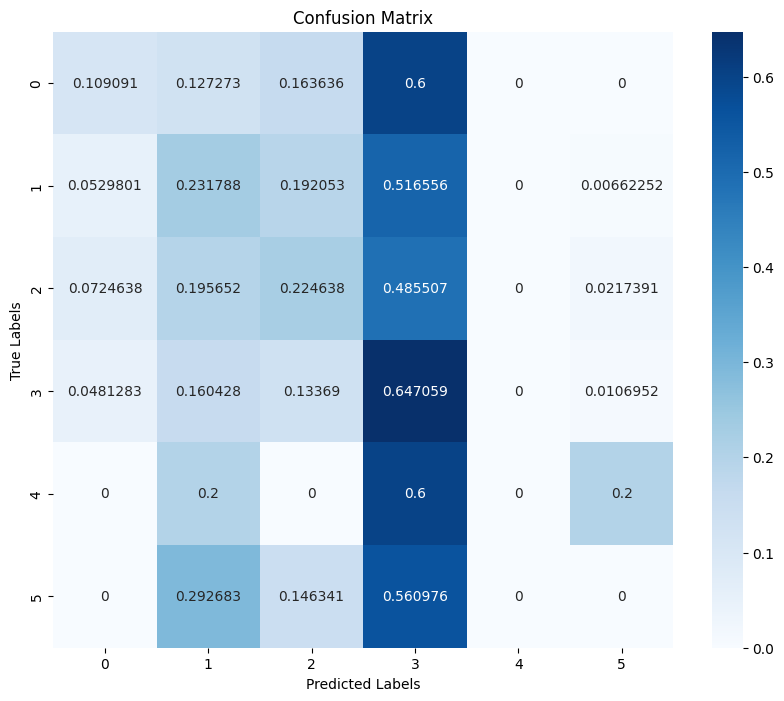

Epoch 16, Validation Loss: 3.6610, Accuracy: 0.3345, F1 Score: 0.2981
Val F1 Score Per Class  [0.13636364 0.2661597  0.2605042  0.47265625 0.         0.        ]


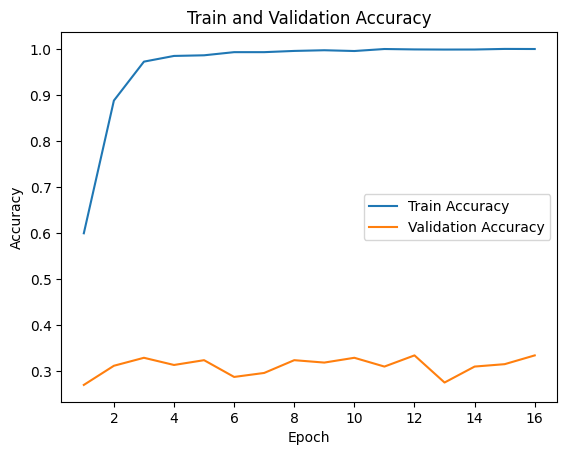

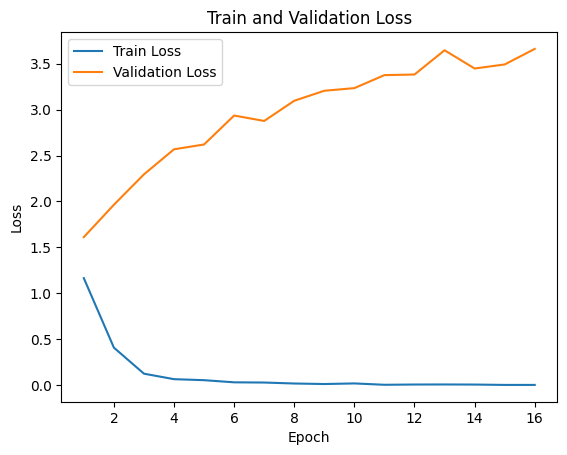

Epoch 17, Train Loss: 0.0009, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.15it/s, loss=4.59]

[tensor([-3.9225,  2.5265, -2.9771,  3.0752, -3.6752, -3.5330], device='cuda:0'), tensor([-2.6588,  3.3646, -1.0067, -1.0330, -5.5072, -4.9865], device='cuda:0'), tensor([-1.5725, -1.7366, -2.5740,  5.3692, -5.0892, -3.2058], device='cuda:0'), tensor([-2.4581, -1.0428, -2.9747,  5.6734, -4.2582, -2.7610], device='cuda:0'), tensor([-4.1532,  2.0019, -0.0252,  0.8671, -5.0146, -3.2818], device='cuda:0'), tensor([-3.8982,  0.7144,  3.5868, -1.2769, -3.5267, -3.4750], device='cuda:0'), tensor([-2.8508, -1.9140, -2.2116,  5.1869, -4.0159, -0.9878], device='cuda:0'), tensor([-2.8077, -2.8594,  4.5404,  1.8357, -3.0514, -2.4868], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.10it/s, loss=4.01]

[tensor([-2.4000, -1.0589, -2.7732,  3.6933, -4.9030, -3.1922], device='cuda:0'), tensor([-3.9843,  2.9756, -1.9143, -1.1559, -2.9800, -2.9046], device='cuda:0'), tensor([-0.5610, -1.8500,  2.3318,  0.2053, -4.1129, -4.0181], device='cuda:0'), tensor([-1.9836, -1.5457, -1.1346,  5.9770, -3.7562, -3.2963], device='cuda:0'), tensor([-1.2863,  6.7805, -1.6644, -1.6202, -3.0948, -3.0037], device='cuda:0'), tensor([-1.2700,  0.6375, -1.0024,  0.5878, -4.9372, -5.1644], device='cuda:0'), tensor([-1.5148, -1.8644, -2.6192,  3.2653, -3.8107, -3.5102], device='cuda:0'), tensor([ 5.6125, -0.1768, -3.0164, -0.0061, -3.5263, -2.7743], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=4.15]

[tensor([-3.2110e+00, -9.6682e-01, -1.1878e-03, -1.5204e+00, -4.7927e+00,
        -4.1577e+00], device='cuda:0'), tensor([-2.6021,  1.6692,  0.3138, -1.5770, -3.3369, -3.1417], device='cuda:0'), tensor([-3.1269, -2.1632,  4.4394, -0.9854, -3.7812, -2.8206], device='cuda:0'), tensor([-0.9646, -3.2087, -1.3082,  3.8202, -4.2260, -3.7106], device='cuda:0'), tensor([-2.0003,  0.6591, -3.0854,  3.4232, -4.0188, -3.9566], device='cuda:0'), tensor([-1.6326, -0.5607, -2.7149,  4.2346, -4.7397, -4.4337], device='cuda:0'), tensor([-1.8631, -2.5471, -2.1607,  4.3687, -4.2425, -3.8369], device='cuda:0'), tensor([ 0.3937, -1.5526, -0.3651, -2.1671, -4.2417, -3.6908], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.14it/s, loss=3.49]

[tensor([-2.6441, -1.9014, -0.8221,  5.6558, -4.0609, -3.3232], device='cuda:0'), tensor([-4.4548,  0.9154, -0.7935, -0.5603, -4.7271, -2.7501], device='cuda:0'), tensor([-3.0232, -0.1440, -2.6233,  0.1738, -4.3591, -0.3003], device='cuda:0'), tensor([-2.8339, -1.1610,  1.0667, -0.4026, -3.3443, -3.1282], device='cuda:0'), tensor([ 6.3267, -2.1778, -0.9362,  0.2558, -3.1230, -3.6314], device='cuda:0'), tensor([-3.1843, -2.2199, -0.0984,  3.3126, -5.1520, -2.5984], device='cuda:0'), tensor([-1.4884,  6.1091, -1.6288, -1.6301, -3.8394, -3.2248], device='cuda:0'), tensor([-3.8248,  2.6193, -0.6855,  0.3953, -3.8354, -2.6940], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=4.01]

[tensor([-3.1268, -1.2770, -1.8862,  5.3515, -3.5693, -4.0197], device='cuda:0'), tensor([-2.9812, -2.3881,  2.2235,  3.4084, -4.3203, -4.4710], device='cuda:0'), tensor([-1.9993, -1.9777,  6.7493, -1.4306, -3.4529, -2.8376], device='cuda:0'), tensor([-2.6573, -0.4239, -2.2410,  1.6224, -4.6165, -5.0971], device='cuda:0'), tensor([-2.6367, -1.6393,  5.2959, -0.2846, -3.9189, -3.3614], device='cuda:0'), tensor([-2.7628,  0.2697, -0.9275,  1.3472, -5.0096, -3.9358], device='cuda:0'), tensor([-2.9285,  0.4442, -2.3551, -1.4456, -4.4088, -2.4931], device='cuda:0'), tensor([-1.5032, -0.3051, -3.1803,  4.5409, -3.9146, -2.5628], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.15it/s, loss=5.23]

[tensor([-2.1049, -2.0643,  7.0614, -1.2984, -2.7562, -2.8456], device='cuda:0'), tensor([-2.0634, -1.9198,  6.7912, -1.6739, -2.6459, -1.7491], device='cuda:0'), tensor([-2.1949, -2.1054,  4.0842, -1.3561, -4.6130, -4.4743], device='cuda:0'), tensor([-3.4285,  1.9663, -2.0172, -0.7775, -4.3367, -3.6436], device='cuda:0'), tensor([-1.9364, -2.0276,  6.8510, -1.6789, -2.8974, -2.3332], device='cuda:0'), tensor([-1.7156, -1.8372, -1.5126,  5.2250, -4.6319, -3.4771], device='cuda:0'), tensor([-2.0456, -3.9253,  0.6327,  3.1776, -4.4402, -3.7272], device='cuda:0'), tensor([-2.4584, -2.0749, -1.9560,  4.1306, -3.7881, -3.9389], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.15it/s, loss=2.61]

[tensor([-2.7351, -1.2346, -0.3070,  1.9266, -4.5573, -3.4811], device='cuda:0'), tensor([-2.7346, -0.2913,  0.0465,  0.1480, -4.5416, -3.1795], device='cuda:0'), tensor([-0.8273, -1.9122,  6.5594, -1.7726, -2.4843, -2.6976], device='cuda:0'), tensor([-3.2740, -2.4798, -0.8742,  4.5953, -4.8929, -3.7629], device='cuda:0'), tensor([-2.9876,  4.6004,  0.5083, -1.3628, -3.7320, -4.7315], device='cuda:0'), tensor([-3.3635, -0.7605, -1.1432,  2.3327, -4.7697, -2.5201], device='cuda:0'), tensor([-3.0560, -3.7107,  3.9284, -0.5887, -3.7153, -1.0725], device='cuda:0'), tensor([-3.0720, -0.4263, -2.4995,  1.1318, -4.8046, -3.3086], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.14it/s, loss=5.81]

[tensor([-1.1180, -2.4785, -1.3820,  2.8165, -4.7499, -4.5593], device='cuda:0'), tensor([-2.0513, -2.6438,  3.9387, -0.5720, -3.2362, -2.9172], device='cuda:0'), tensor([-1.5933, -1.4621, -2.7071,  6.3471, -3.9856, -2.8968], device='cuda:0'), tensor([-1.4456,  6.5343, -2.0421, -1.0453, -3.1849, -3.3567], device='cuda:0'), tensor([-2.4475, -1.4450,  6.4697, -1.7898, -3.1700, -3.3367], device='cuda:0'), tensor([-1.6128, -1.4722, -1.9166,  3.0499, -4.6286, -5.2555], device='cuda:0'), tensor([-2.3644, -2.9932, -2.0853,  2.8452, -4.3191,  0.6457], device='cuda:0'), tensor([-2.3099, -2.1412,  6.5437, -0.8408, -2.7466, -2.1718], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:29,  2.14it/s, loss=5.64]

[tensor([-2.9599, -1.3678, -3.0925,  2.6754, -4.6161, -2.2396], device='cuda:0'), tensor([-2.8564,  3.5447, -1.4494,  0.0387, -5.2041, -4.7713], device='cuda:0'), tensor([-0.8897,  5.2088, -1.6879, -0.8595, -3.7029, -4.3506], device='cuda:0'), tensor([-1.7535, -2.7856,  0.2573,  1.2051, -3.4992, -3.7210], device='cuda:0'), tensor([-2.2225, -2.3976, -0.9867,  5.2868, -3.4346, -3.0442], device='cuda:0'), tensor([-3.1422,  6.0272, -0.5564, -0.7908, -4.0462, -3.4605], device='cuda:0'), tensor([-3.2189, -0.0138, -3.5607,  4.3781, -4.0966, -2.7952], device='cuda:0'), tensor([-2.5786, -2.6423, -0.4555,  4.3756, -4.7905, -3.2942], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.15it/s, loss=3.68]

[tensor([-2.9936,  4.0274, -1.1667, -1.3325, -3.3236, -3.9483], device='cuda:0'), tensor([-3.0651, -1.9853,  0.7829,  2.8538, -4.1675, -3.9906], device='cuda:0'), tensor([-1.4293,  1.5200, -2.5728, -1.7649, -3.3294, -2.7341], device='cuda:0'), tensor([-2.6611, -1.6301, -0.0544,  3.9437, -4.3653, -4.9811], device='cuda:0'), tensor([-2.7187,  3.7009,  1.4287, -1.4073, -4.0127, -4.1748], device='cuda:0'), tensor([-1.1250, -1.4580, -0.5162,  4.2789, -4.7878, -5.1946], device='cuda:0'), tensor([-3.1305,  5.6780, -2.2244, -1.4309, -2.9062, -2.4299], device='cuda:0'), tensor([-2.4726,  5.9566, -1.9108, -0.0399, -4.1055, -3.8523], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.15it/s, loss=5.39]

[tensor([-2.6351, -2.0455, -1.5429,  5.8766, -3.5232, -3.1683], device='cuda:0'), tensor([-1.1519,  3.6780, -3.3697, -0.2296, -4.3440, -3.2503], device='cuda:0'), tensor([-2.9092, -2.9257,  1.9698,  4.0315, -4.5420, -2.6506], device='cuda:0'), tensor([-2.2425, -2.2466, -1.6146,  5.6855, -4.7354, -3.7814], device='cuda:0'), tensor([-3.5071,  3.7108, -2.4145, -0.5070, -4.7721, -2.1163], device='cuda:0'), tensor([-2.3686, -0.4130, -3.6487,  3.3794, -4.3821, -3.1712], device='cuda:0'), tensor([-4.2096, -1.3567,  0.3675, -0.5032, -4.0086, -3.5846], device='cuda:0'), tensor([-1.6635, -1.8707, -2.3268,  6.1996, -3.5342, -3.8827], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.13it/s, loss=2.61]

[tensor([-2.7022, -2.5316,  5.8352, -0.9791, -3.2062, -3.2665], device='cuda:0'), tensor([-4.1831,  1.7464,  0.3509,  1.0719, -4.5995, -4.0490], device='cuda:0'), tensor([-3.3680, -0.9216,  1.9820,  1.6472, -4.0209, -4.8877], device='cuda:0'), tensor([-2.8404,  3.1801, -2.2807, -0.1427, -3.7608, -3.7992], device='cuda:0'), tensor([-0.3195, -0.7913, -1.8499, -1.3305, -4.0541, -5.1998], device='cuda:0'), tensor([-2.0515, -2.2402,  6.8923, -0.8186, -2.9470, -2.5722], device='cuda:0'), tensor([-1.8021, -1.2592, -3.0232,  4.8114, -4.4831, -3.0642], device='cuda:0'), tensor([-2.0344, -1.2214,  1.0295, -0.8108, -4.7052, -4.3289], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.12it/s, loss=2.63]

[tensor([ 0.8230, -2.4435, -1.3311,  0.4892, -5.1901, -5.3021], device='cuda:0'), tensor([-3.7607,  1.8713,  0.1140,  2.5651, -4.0672, -3.5718], device='cuda:0'), tensor([-3.5401,  0.4968, -1.5888,  0.9191, -5.4720, -4.7981], device='cuda:0'), tensor([-3.1516,  1.9375,  2.1627, -2.3627, -4.0445, -3.2742], device='cuda:0'), tensor([-3.4294,  3.8631, -2.3220, -0.3146, -3.8884, -2.2790], device='cuda:0'), tensor([-2.8222, -1.7508, -0.6332, -0.9145, -4.1306, -2.8891], device='cuda:0'), tensor([-3.2025,  4.6172, -2.4729,  2.0192, -4.3058, -3.8215], device='cuda:0'), tensor([-1.3617,  1.0921, -2.6878,  2.8320, -4.4687, -5.0411], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.13it/s, loss=2.5]

[tensor([-0.4283, -2.1514, -2.2259,  0.0812, -5.1779, -2.3733], device='cuda:0'), tensor([-3.5697, -0.3819, -2.1985,  1.9748, -4.7561, -4.0521], device='cuda:0'), tensor([-3.5177, -2.8567, -0.9464,  1.6832, -3.7746, -0.6417], device='cuda:0'), tensor([-2.3369, -0.1622, -2.0080,  2.3916, -5.2357, -4.1246], device='cuda:0'), tensor([-2.8231, -1.3959, -2.2015,  6.3865, -3.1157, -2.1870], device='cuda:0'), tensor([-3.0986,  1.2909, -2.2282,  3.0159, -4.0992, -3.8235], device='cuda:0'), tensor([-3.1931,  2.7033, -1.1661, -2.0724, -3.7293, -2.8586], device='cuda:0'), tensor([-2.7513, -0.5909, -2.0522,  4.1642, -4.7884, -3.9531], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.13it/s, loss=4.19]

[tensor([-3.2789,  2.4291, -1.5487,  0.7757, -4.9677, -4.3249], device='cuda:0'), tensor([-2.3859,  3.6835, -0.3824, -1.4936, -4.6506, -4.4247], device='cuda:0'), tensor([-2.1860, -1.3069,  6.7858, -1.7357, -2.6705, -2.0749], device='cuda:0'), tensor([-1.9013, -2.3266, -1.4721,  6.4022, -3.8926, -3.4619], device='cuda:0'), tensor([-2.1287, -1.4917, -1.9411,  6.3648, -3.5627, -3.8780], device='cuda:0'), tensor([-3.1024,  1.6212, -0.4045, -1.8685, -4.4646, -4.5858], device='cuda:0'), tensor([-4.1376, -1.7408,  0.6356,  2.2571, -4.9861, -3.0631], device='cuda:0'), tensor([-3.5805, -1.2122,  1.1461,  1.0358, -4.9509, -6.0037], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=3.57]

[tensor([-1.9252, -1.4750, -1.9618,  6.4582, -3.9849, -3.2875], device='cuda:0'), tensor([-2.1562,  5.7042, -0.8129, -1.5267, -4.1532, -3.8376], device='cuda:0'), tensor([-2.3881, -1.2935, -1.9256,  4.7294, -4.4549, -4.8585], device='cuda:0'), tensor([-3.5006, -0.7579, -0.7285,  2.0956, -4.4368, -2.6963], device='cuda:0'), tensor([-2.2778, -2.6648, -1.4377,  2.4259, -3.8668, -3.4416], device='cuda:0'), tensor([-3.2171, -1.8163,  6.0215, -0.8178, -3.2769, -2.6342], device='cuda:0'), tensor([-2.3061, -2.0444, -1.8183,  5.9205, -5.2784, -4.1419], device='cuda:0'), tensor([-3.1169, -1.7366, -1.3752, -0.6244, -3.7886, -3.0438], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:25,  2.16it/s, loss=4.3]

[tensor([-3.4207, -1.6813, -0.5910,  4.2347, -4.9193, -4.3961], device='cuda:0'), tensor([-1.2489,  1.3652,  1.6182, -1.8226, -4.1946, -3.4159], device='cuda:0'), tensor([-2.6237,  4.3097, -0.4478, -3.0091, -3.2738, -3.0075], device='cuda:0'), tensor([-3.3655,  0.8486, -1.4972,  0.9282, -4.8762, -4.0840], device='cuda:0'), tensor([-2.9413, -2.8003, -0.6645,  5.4531, -3.3128, -1.7558], device='cuda:0'), tensor([-2.2272, -2.1739, -1.7035,  5.0269, -4.4869, -3.6099], device='cuda:0'), tensor([ 1.7824, -2.6050, -1.2188, -0.2340, -4.3493, -3.2102], device='cuda:0'), tensor([-2.0573, -0.7099, -3.5269,  2.0578, -3.4071, -3.0498], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.16it/s, loss=2.34]

[tensor([-2.4781, -2.7708, -0.8720,  5.2236, -4.1083, -3.7526], device='cuda:0'), tensor([-1.2753, -2.2129, -1.3574,  5.0205, -3.4099, -4.3659], device='cuda:0'), tensor([-4.0062, -0.7389,  2.4044, -1.4122, -4.3989, -1.6857], device='cuda:0'), tensor([-2.9456,  1.5435, -0.6136, -0.2506, -4.4068, -4.7206], device='cuda:0'), tensor([-2.6063, -2.9714,  2.1735, -0.5122, -2.5509, -3.7580], device='cuda:0'), tensor([-1.3025, -2.2854, -1.7369,  2.0373, -4.6990, -2.6656], device='cuda:0'), tensor([-1.7935,  2.6569, -0.4867, -0.7606, -4.7604, -4.3893], device='cuda:0'), tensor([-2.8775, -1.4087, -1.0774,  3.5996, -4.2205, -4.5081], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:24,  2.17it/s, loss=2.17]

[tensor([-2.7893, -1.5899,  1.4618, -1.3204, -4.4756, -4.9729], device='cuda:0'), tensor([ 4.8091, -1.7264, -2.3379, -0.2018, -4.1982, -4.0996], device='cuda:0'), tensor([-2.1421, -1.8023,  6.4604, -0.6748, -2.8330, -3.0748], device='cuda:0'), tensor([-2.4184, -2.2517, -1.0605,  6.1237, -3.4320, -3.1205], device='cuda:0'), tensor([-1.2451,  4.5563, -2.9296, -0.0897, -5.1092, -4.3029], device='cuda:0'), tensor([-0.7665, -1.9708, -2.8060,  2.8128, -4.0579, -4.0857], device='cuda:0'), tensor([-2.6034,  1.8161, -1.4189, -0.1239, -4.6871, -2.9098], device='cuda:0'), tensor([-2.0695,  0.8072,  0.6799, -1.0805, -4.0405, -3.8106], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.16it/s, loss=5.89]

[tensor([-2.5223, -2.6424,  0.4178,  4.5718, -4.2127, -4.2017], device='cuda:0'), tensor([-3.1481,  4.5053, -1.1894, -2.1360, -2.7738, -2.8479], device='cuda:0'), tensor([-2.4020, -2.0334, -0.2317,  4.0441, -3.7037, -2.4482], device='cuda:0'), tensor([-2.1352, -3.3739,  1.5395,  0.9897, -4.5325, -3.3337], device='cuda:0'), tensor([ 1.5382, -1.5798, -0.4611, -1.5636, -5.2290, -4.2305], device='cuda:0'), tensor([-3.2159,  4.1629, -1.4382, -0.3710, -3.8355, -2.3482], device='cuda:0'), tensor([-2.2722, -2.6835,  0.1951,  3.2617, -4.7513, -4.4943], device='cuda:0'), tensor([-2.4683, -1.7542,  5.0828, -0.5525, -3.8158, -3.8169], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.15it/s, loss=5.26]

[tensor([-1.2039, -3.4041,  4.3727, -0.6099, -3.3834, -2.6271], device='cuda:0'), tensor([-1.8162,  5.7233, -2.5330, -0.6049, -3.9002, -3.5710], device='cuda:0'), tensor([-3.1617,  3.8200,  1.2733, -2.2885, -4.0846, -2.9943], device='cuda:0'), tensor([-2.4879, -2.7986,  5.6891, -0.0140, -3.1412, -3.4951], device='cuda:0'), tensor([-2.7996, -1.8943,  3.2873,  0.9588, -4.8803, -4.7344], device='cuda:0'), tensor([-1.2260, -0.4110, -1.6303, -1.4205, -5.1752, -3.2825], device='cuda:0'), tensor([-1.8914, -2.2328, -1.4496,  6.5060, -3.0559, -2.9254], device='cuda:0'), tensor([-2.2945, -1.7796, -1.5297,  5.7257, -2.7111, -2.1131], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.17it/s, loss=2.31]

[tensor([-2.3991, -0.1539, -1.9518,  5.8275, -4.7303, -4.1873], device='cuda:0'), tensor([-2.6907, -2.2210,  0.0812, -0.3247, -3.5185, -3.3294], device='cuda:0'), tensor([-3.8541, -1.7499, -0.8890,  2.0897, -4.1712, -3.9510], device='cuda:0'), tensor([-2.9501, -1.3173, -2.2732,  5.8355, -2.8820, -1.6302], device='cuda:0'), tensor([-2.5452, -2.1248,  3.8446,  0.7412, -4.0940, -4.4903], device='cuda:0'), tensor([-1.5870, -3.0509,  0.7910,  4.3386, -3.7474, -4.2586], device='cuda:0'), tensor([-2.8374, -0.1010, -1.9907,  1.2791, -4.6453, -3.5393], device='cuda:0'), tensor([-3.4851, -2.3017,  3.7338,  1.8180, -4.1377, -3.7402], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.17it/s, loss=2.57]

[tensor([-2.2396, -1.0544, -0.0291,  2.0544, -4.9294, -4.5956], device='cuda:0'), tensor([-2.2730, -1.3419, -2.5160,  5.8515, -4.0480, -3.1601], device='cuda:0'), tensor([-1.9185, -1.2663, -2.5091,  5.8394, -3.0468, -3.5428], device='cuda:0'), tensor([-3.1856,  4.2420, -2.1585, -0.9544, -4.9869, -3.2866], device='cuda:0'), tensor([-3.0443,  1.5195, -1.7553,  2.4564, -4.7003, -4.0075], device='cuda:0'), tensor([-1.6174, -1.7920, -2.1301,  6.6001, -2.9268, -2.7688], device='cuda:0'), tensor([-1.6963, -3.3865,  1.4111,  3.0578, -3.9315, -4.3392], device='cuda:0'), tensor([-2.5888, -2.5982,  6.2796, -1.6545, -3.2449, -3.3202], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.17it/s, loss=3.75]

[tensor([-1.9580, -1.1553, -3.3040,  2.6530, -3.4364, -2.6376], device='cuda:0'), tensor([-2.0281, -1.8323, -1.7291,  4.6493, -4.8896, -3.8252], device='cuda:0'), tensor([-2.0326, -2.5445, -0.8471,  5.6288, -3.9031, -3.8294], device='cuda:0'), tensor([-0.8336, -2.0485,  3.8927, -1.8103, -3.6201, -4.8871], device='cuda:0'), tensor([-3.4946,  2.1432,  3.0363, -1.7056, -3.8755, -4.6024], device='cuda:0'), tensor([-2.1206, -2.4980,  5.5010,  0.4000, -3.4338, -3.8896], device='cuda:0'), tensor([-2.8888, -1.4225, -2.6501,  5.7150, -2.7721, -1.3326], device='cuda:0'), tensor([-1.9166,  3.3640, -3.0197,  0.6846, -5.5745, -2.7501], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.17it/s, loss=4.84]

[tensor([-2.8093,  0.4248, -0.8054,  4.4801, -5.2800, -3.0849], device='cuda:0'), tensor([-2.0186,  1.2869, -3.0740,  3.9530, -4.8284, -3.2229], device='cuda:0'), tensor([-2.8125,  5.1062, -0.5351, -1.0682, -3.8489, -3.8113], device='cuda:0'), tensor([-1.8851, -2.1271,  5.1650, -1.1540, -2.8383, -3.9047], device='cuda:0'), tensor([-1.9738,  0.3648, -1.1181,  0.9149, -5.3354, -5.0505], device='cuda:0'), tensor([-1.8191,  5.6711, -1.4628, -2.3463, -3.2799, -2.6691], device='cuda:0'), tensor([-3.9869,  4.1100, -2.4470, -1.5321, -5.8841, -2.5611], device='cuda:0'), tensor([-2.7848,  4.8459, -3.4746,  0.0073, -4.1268, -1.3424], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.17it/s, loss=3.45]

[tensor([-1.6662,  4.9364, -3.3660, -0.7657, -3.7305, -1.3194], device='cuda:0'), tensor([-2.7685, -0.6319,  0.1506, -2.3926, -4.2631, -2.4752], device='cuda:0'), tensor([-3.5499,  2.5211,  0.2081, -0.0687, -4.9541, -4.6253], device='cuda:0'), tensor([-2.2715, -1.4238,  1.1542, -2.1579, -4.5019, -5.3876], device='cuda:0'), tensor([-1.8377,  4.1365, -2.8817,  0.1729, -4.3248, -4.0259], device='cuda:0'), tensor([-2.7203, -1.3502, -1.7286,  5.3335, -3.1117, -2.7744], device='cuda:0'), tensor([ 0.5797, -2.9971, -0.2733,  0.3582, -4.1982, -3.5774], device='cuda:0'), tensor([-0.8493, -3.4832,  1.3439,  2.0769, -3.7682, -3.3654], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.17it/s, loss=3.75]

[tensor([-2.9874, -0.0833, -3.2375,  4.2562, -3.9863, -1.4634], device='cuda:0'), tensor([-1.6674,  5.8702, -0.0210, -1.7857, -3.3876, -3.9717], device='cuda:0'), tensor([-2.3871, -2.2895, -1.9288,  1.0462, -4.5862, -2.7027], device='cuda:0'), tensor([-2.8522, -1.5107, -1.4869,  4.8967, -3.5914, -3.1277], device='cuda:0'), tensor([-1.6502, -2.0815, -2.0002,  2.5095, -3.8535, -2.9793], device='cuda:0'), tensor([-3.7118,  2.3251,  0.0638,  1.5520, -4.7598, -5.3621], device='cuda:0'), tensor([-2.9185, -2.8133,  3.4971,  0.0993, -4.2912, -4.0785], device='cuda:0'), tensor([-2.6771,  4.7360, -2.4933, -0.0662, -3.9205, -3.1907], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.16it/s, loss=4.16]

[tensor([-1.3128, -1.8887,  5.8941, -1.3652, -2.9426, -3.1089], device='cuda:0'), tensor([-2.3641, -2.6912,  3.5303,  1.2680, -3.7658, -3.6420], device='cuda:0'), tensor([-1.8823, -2.3822, -0.9202,  3.3469, -4.8555, -4.2346], device='cuda:0'), tensor([-1.6873, -2.6094,  4.6488, -0.4345, -3.5288, -2.8637], device='cuda:0'), tensor([-2.4449, -1.4100,  5.9954, -1.1603, -3.3419, -3.3695], device='cuda:0'), tensor([-2.0506,  4.7357, -1.2446, -0.6228, -4.1223, -3.7995], device='cuda:0'), tensor([-2.3329, -2.7851,  2.3508,  1.8030, -4.1638, -2.2472], device='cuda:0'), tensor([-1.4042, -2.1880,  6.2695, -0.7652, -3.2981, -3.1020], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.16it/s, loss=4.91]

[tensor([ 5.6867, -1.6152, -1.4337, -1.3057, -3.2044, -1.7324], device='cuda:0'), tensor([-3.8372, -1.1157,  2.6808, -1.3816, -4.5337, -4.1503], device='cuda:0'), tensor([-1.1383, -0.1949, -2.8165,  4.0168, -4.0433, -4.6019], device='cuda:0'), tensor([-1.7496, -0.8450,  2.4656, -0.2623, -3.3788, -2.6615], device='cuda:0'), tensor([-2.6934,  6.1637, -0.7698, -0.6196, -3.7753, -3.9744], device='cuda:0'), tensor([-2.2981, -1.9605,  6.4551, -1.3630, -2.8212, -1.8230], device='cuda:0'), tensor([-2.2659, -1.6303,  4.3671, -0.3359, -3.9976, -3.3708], device='cuda:0'), tensor([-3.3782,  4.3720, -0.9323, -0.2622, -3.5512, -3.4320], device='cuda:0')]


Val:  41%|████      | 30/73 [00:13<00:19,  2.16it/s, loss=5.18]

[tensor([-2.5064,  5.3125, -2.1697, -0.5645, -5.2766, -4.4784], device='cuda:0'), tensor([-2.1658, -3.0735,  2.4875,  3.5570, -3.6108, -3.4809], device='cuda:0'), tensor([-4.3100,  2.7398, -2.3253,  0.6369, -5.2448, -1.8929], device='cuda:0'), tensor([-3.1266, -1.5576, -2.0617,  2.9370, -3.3687, -1.4427], device='cuda:0'), tensor([-2.1037, -1.6946, -1.4138,  6.3122, -3.2135, -3.5688], device='cuda:0'), tensor([-1.5696, -2.2425,  2.8737, -0.6795, -4.0640, -4.6234], device='cuda:0'), tensor([-0.3537, -2.5152,  3.7866, -1.1923, -2.6870, -2.3167], device='cuda:0'), tensor([ 6.3311, -1.8802, -2.1787, -0.4881, -2.9533, -1.9987], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.15it/s, loss=3.07]

[tensor([-2.5584, -2.6509, -0.3746,  5.7296, -3.4239, -2.7335], device='cuda:0'), tensor([-0.5735, -2.2879, -2.6842,  2.3191, -5.3718, -4.2662], device='cuda:0'), tensor([-3.3803, -1.8085,  3.8551,  1.7966, -5.5770, -3.3119], device='cuda:0'), tensor([-0.9033, -2.7207,  0.5008,  1.7276, -5.2949, -4.8891], device='cuda:0'), tensor([ 0.8985, -2.0344,  0.4840, -1.1905, -4.8333, -5.2964], device='cuda:0'), tensor([-2.7406, -0.5438, -1.4759, -1.6810, -3.3884, -1.3888], device='cuda:0'), tensor([-0.4424,  5.3181, -3.1026, -1.4662, -3.6194, -3.4899], device='cuda:0'), tensor([-2.8258, -0.3998, -2.3341,  4.8540, -4.3410, -5.1949], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=3.59]

[tensor([-3.4348,  1.6638,  2.2539, -2.4052, -3.8713, -0.6856], device='cuda:0'), tensor([-0.5017, -2.3665,  0.1114,  2.1699, -4.5555, -5.2078], device='cuda:0'), tensor([-2.0254, -1.7068, -0.9272,  2.8492, -5.3633, -5.7532], device='cuda:0'), tensor([-3.0510, -2.3220,  1.4113,  1.7371, -4.5098, -3.8877], device='cuda:0'), tensor([-3.2375, -1.1287,  5.3028, -1.4634, -3.2740, -3.4850], device='cuda:0'), tensor([-2.2744,  6.7762, -1.0936, -1.8402, -3.3034, -2.3375], device='cuda:0'), tensor([-1.9618, -1.4828, -1.3064, -1.1355, -2.4080,  8.1870], device='cuda:0'), tensor([-2.9891, -2.2767, -1.1217,  2.3431, -3.4077, -4.4863], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.15it/s, loss=4.09]

[tensor([-2.9273, -1.1481,  0.5738,  2.1557, -5.5103, -4.6554], device='cuda:0'), tensor([-2.0968,  1.2018, -2.5706,  1.3391, -3.7081, -4.2763], device='cuda:0'), tensor([-3.1551, -1.8379,  1.4133, -1.5582, -4.5448, -4.5070], device='cuda:0'), tensor([-3.6001,  1.8180, -3.1654, -0.3041, -3.2818,  1.4148], device='cuda:0'), tensor([-1.9768, -1.9425, -2.4320,  5.3539, -3.5717, -3.9266], device='cuda:0'), tensor([-4.1638, -1.3717, -1.3516,  2.9305, -3.8795, -4.1299], device='cuda:0'), tensor([-2.7685, -1.4997, -1.1001,  4.8904, -4.5644, -4.2025], device='cuda:0'), tensor([ 2.6338, -2.7242, -2.4643,  2.9768, -3.2619, -3.3198], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.42]

[tensor([-3.3683,  0.0340,  3.1833, -0.3221, -5.5839, -4.4545], device='cuda:0'), tensor([-2.6531, -2.1591, -0.1908,  0.2699, -3.8647, -4.1524], device='cuda:0'), tensor([-2.0820, -1.1206,  6.6305, -1.9220, -2.6746, -3.0845], device='cuda:0'), tensor([-0.0716, -3.1096,  2.5826, -0.7552, -4.5828, -3.4711], device='cuda:0'), tensor([-2.0013, -0.3203, -2.7240,  4.9816, -4.2256, -3.3894], device='cuda:0'), tensor([-2.7472, -2.0964,  6.5754, -0.6677, -2.9901, -2.7922], device='cuda:0'), tensor([ 4.5456, -2.5478, -1.9434,  0.1206, -3.5347, -3.0605], device='cuda:0'), tensor([-2.3665,  1.7197, -2.2019,  0.2810, -4.3433, -4.2024], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=2.99]

[tensor([-1.6005, -1.6940, -1.7803,  5.7763, -3.6380, -4.5774], device='cuda:0'), tensor([-2.7331, -1.0446,  1.6319, -2.5413, -3.3524, -0.2857], device='cuda:0'), tensor([-1.6609, -1.5623, -2.9615,  4.5594, -4.6976, -3.6509], device='cuda:0'), tensor([ 1.7601, -2.8197, -0.5259, -1.2763, -4.1288, -3.2915], device='cuda:0'), tensor([-2.2316, -0.3890,  0.5203, -1.5928, -3.2452, -2.5936], device='cuda:0'), tensor([-2.5876, -1.7810, -1.7735,  5.9071, -3.6864, -2.3650], device='cuda:0'), tensor([-1.2632, -2.7041, -1.3203,  3.0864, -4.4104, -3.4003], device='cuda:0'), tensor([-3.3008,  4.9419, -1.6705, -1.2614, -4.1654, -1.3776], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.15it/s, loss=2.28]

[tensor([-2.6248, -0.9289, -2.0446,  1.3464, -4.3585, -3.7253], device='cuda:0'), tensor([ 1.0342, -2.8066, -1.7019,  0.6636, -4.4546, -3.8100], device='cuda:0'), tensor([-3.6383, -1.1389, -2.6088,  2.4307, -3.1626, -3.6342], device='cuda:0'), tensor([-3.2633,  0.7266, -1.1584,  0.7629, -4.4105, -4.5481], device='cuda:0'), tensor([-1.8418, -2.7286,  2.2785,  2.4588, -4.2001, -4.9985], device='cuda:0'), tensor([-3.1805,  2.7090,  0.9265, -1.8944, -3.1704, -4.4310], device='cuda:0'), tensor([-2.8582,  2.6256, -1.2440, -1.4061, -5.0478, -3.6642], device='cuda:0'), tensor([-3.9158,  3.2030, -0.7397, -1.3163, -3.7717, -4.3567], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.16it/s, loss=5.12]

[tensor([-1.8561, -1.6290, -1.8681,  5.8498, -4.4034, -4.2820], device='cuda:0'), tensor([-2.9969,  5.4643, -2.5705,  0.5638, -3.0436, -3.2539], device='cuda:0'), tensor([-2.2942, -0.9321, -2.7818,  5.4837, -5.2605, -2.7886], device='cuda:0'), tensor([-2.4860, -0.4633,  6.5337, -1.8161, -3.2501, -3.5469], device='cuda:0'), tensor([-3.0855,  0.3691, -1.8275, -1.8316, -4.1480, -2.7866], device='cuda:0'), tensor([-2.4676,  0.9631, -1.1617, -1.6183, -3.4359, -3.1920], device='cuda:0'), tensor([-2.3694,  6.0499, -0.5525, -1.6458, -4.0474, -3.9159], device='cuda:0'), tensor([-3.3635, -1.1848, -1.6933,  3.7706, -4.3054, -3.4774], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.16it/s, loss=5.2]

[tensor([-3.1045, -1.0671, -3.1128,  4.8684, -3.9598, -2.0883], device='cuda:0'), tensor([-2.6399, -1.8725,  3.9275,  1.1048, -2.5176, -3.2606], device='cuda:0'), tensor([-2.8525, -0.5523, -1.6000,  5.5040, -3.7645, -4.4649], device='cuda:0'), tensor([-2.2038, -1.5079,  5.4113, -1.9504, -3.9810, -3.5930], device='cuda:0'), tensor([-2.0537, -1.8627,  6.5476, -1.5797, -2.9017, -1.3768], device='cuda:0'), tensor([-1.3747, -2.6432,  0.8443,  1.5049, -3.7873, -4.2034], device='cuda:0'), tensor([-2.5669,  6.0219, -1.8501, -1.6213, -2.7797, -2.2851], device='cuda:0'), tensor([-1.9483,  3.4293, -1.7357, -0.5594, -4.4016, -4.7942], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.15it/s, loss=4.62]

[tensor([-1.9417,  2.7388,  1.1355, -1.4267, -4.5956, -4.3937], device='cuda:0'), tensor([-2.3903, -1.3153, -2.8087,  5.0214, -2.1707, -0.9194], device='cuda:0'), tensor([ 2.7750, -0.6092, -3.0816, -0.3805, -3.8237, -4.0540], device='cuda:0'), tensor([-2.8099,  2.3193, -2.0246,  1.7594, -4.7431, -4.8619], device='cuda:0'), tensor([-1.7355e+00, -4.5737e-03, -2.4261e+00,  2.7988e+00, -4.6797e+00,
        -4.8713e+00], device='cuda:0'), tensor([-1.9109, -3.2927,  3.7543, -0.8157, -3.8990, -3.7031], device='cuda:0'), tensor([-2.5055, -0.5061, -2.1794,  4.0946, -3.6150, -5.2416], device='cuda:0'), tensor([-2.7565, -2.1036,  6.2672, -0.0306, -3.3074, -2.8569], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.15it/s, loss=2.99]

[tensor([-3.7447,  3.1637, -0.8435,  0.3835, -4.8546, -5.1637], device='cuda:0'), tensor([-3.2255, -1.6741, -1.8027,  4.6329, -4.2939, -3.1850], device='cuda:0'), tensor([-3.9159,  0.4529, -1.7122,  0.2240, -4.1183, -4.2352], device='cuda:0'), tensor([-1.4870, -2.1077,  6.9858, -2.0042, -2.3881, -2.1857], device='cuda:0'), tensor([-1.7392,  0.7415, -2.8237,  2.4276, -2.9856, -4.7140], device='cuda:0'), tensor([-3.3512, -2.8280,  1.5002, -1.8762, -4.2678, -2.1469], device='cuda:0'), tensor([-2.5743, -2.6234, -0.1210,  1.8455, -5.0207, -3.3544], device='cuda:0'), tensor([-1.0597, -2.6499,  0.9328,  0.7218, -2.3227, -4.1364], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.15it/s, loss=3.75]

[tensor([-1.8248, -1.6913, -1.9511,  6.6544, -2.9591, -3.0574], device='cuda:0'), tensor([-1.8179, -1.8698, -2.4725,  6.5367, -3.9082, -2.5601], device='cuda:0'), tensor([-2.7719, -1.6567, -1.5682,  5.1960, -4.5026, -3.5047], device='cuda:0'), tensor([-1.1983, -1.3112, -3.7756,  3.9960, -3.7171, -2.5605], device='cuda:0'), tensor([-2.9354,  1.0508,  0.7005, -1.0209, -3.7113, -4.2139], device='cuda:0'), tensor([-2.7759, -1.7302,  6.3656, -0.7999, -2.9155, -3.0394], device='cuda:0'), tensor([-1.4803,  0.3142, -1.1576,  0.5073, -4.5449, -4.6091], device='cuda:0'), tensor([-1.0492, -2.2810,  6.1881, -0.8800, -3.2121, -3.0086], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.13it/s, loss=3.83]

[tensor([-3.6965, -0.0540, -1.1636, -0.7557, -4.8493, -2.5095], device='cuda:0'), tensor([-1.1116, -1.6850, -3.1954,  5.0102, -3.6592, -3.8543], device='cuda:0'), tensor([ 7.4573, -1.8086, -1.3246, -1.1677, -2.3504, -1.4262], device='cuda:0'), tensor([-2.5137,  5.8258, -2.7966, -0.3333, -3.1901, -3.3848], device='cuda:0'), tensor([-2.0438, -1.1372, -3.4896,  5.0102, -4.5039, -2.8518], device='cuda:0'), tensor([-1.7900,  0.2781, -2.8115,  4.3392, -4.8392, -3.9092], device='cuda:0'), tensor([-0.4330, -0.6449, -2.3405,  4.3494, -4.9454, -5.1309], device='cuda:0'), tensor([-2.7633, -0.8831,  1.0193, -2.1427, -4.1474, -1.5783], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.12it/s, loss=3.63]

[tensor([-2.3667, -1.2982, -2.4249,  4.5819, -4.6381, -2.7836], device='cuda:0'), tensor([-3.4308, -2.3500, -1.6017,  0.9427, -3.2028, -2.3025], device='cuda:0'), tensor([-2.6551, -2.6096, -0.9393,  5.7653, -4.4539, -3.0479], device='cuda:0'), tensor([-1.5964, -2.0843, -1.3443,  6.3493, -3.9945, -3.2682], device='cuda:0'), tensor([-3.1751,  4.3772,  0.5685, -0.6468, -4.3061, -4.3659], device='cuda:0'), tensor([-2.3396, -1.8006, -2.8319,  3.1162, -5.8079, -3.5324], device='cuda:0'), tensor([-1.7815, -2.7156,  0.0271,  5.9527, -3.9194, -4.3348], device='cuda:0'), tensor([-0.7874, -2.4785, -1.7111,  4.1002, -3.7883, -4.4670], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.13it/s, loss=2.74]

[tensor([-1.1129, -1.3571, -0.9075,  1.6963, -4.0760, -5.1801], device='cuda:0'), tensor([-0.9612, -2.2978, -0.5003, -0.6613, -3.8120, -4.3035], device='cuda:0'), tensor([-3.7598, -1.8792, -1.6010,  3.5985, -4.6702, -3.3493], device='cuda:0'), tensor([-4.3116, -1.0353, -0.4348,  1.1733, -5.3827, -3.5824], device='cuda:0'), tensor([-2.4737, -2.4743,  1.3260,  0.8997, -3.2913, -2.8707], device='cuda:0'), tensor([-4.1353,  1.2145,  0.7374,  1.5563, -4.8103, -4.2841], device='cuda:0'), tensor([ 1.5155, -2.2665,  0.4749,  1.0275, -4.2292, -3.3290], device='cuda:0'), tensor([-2.2287,  4.1638, -2.9111, -0.6972, -3.3184, -1.6405], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:20<00:13,  2.12it/s, loss=3.48]

[tensor([ 2.4699, -0.7534, -3.6312, -1.1655, -4.7162, -1.9037], device='cuda:0'), tensor([-2.9785,  1.2745, -2.8870,  2.5831, -3.2077, -3.2696], device='cuda:0'), tensor([-3.3551,  1.0760, -2.7947,  3.1025, -4.0528, -1.5291], device='cuda:0'), tensor([-2.5882, -1.5458, -0.8902, -1.2300, -3.7920, -3.3972], device='cuda:0'), tensor([-2.4113, -2.9269,  5.5128,  0.2209, -3.4532, -2.6439], device='cuda:0'), tensor([-1.8950, -1.9129, -2.1809, -1.1495, -2.5655,  7.7187], device='cuda:0'), tensor([-3.5912,  3.7035, -0.3272,  0.0118, -4.1767, -3.6493], device='cuda:0'), tensor([-3.1370, -1.7298, -1.9763,  4.1492, -4.2837, -2.5010], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.11it/s, loss=3.06]

[tensor([-2.7053, -0.7640,  4.7580, -2.0053, -3.9065, -3.9306], device='cuda:0'), tensor([-1.3894,  1.2060, -1.1303,  1.2484, -3.1020, -3.1747], device='cuda:0'), tensor([-3.3633, -0.9193, -0.6018,  3.4821, -4.1967, -5.0919], device='cuda:0'), tensor([-1.9003, -2.3864,  6.5368, -1.8406, -2.8284, -1.3410], device='cuda:0'), tensor([-3.4399, -0.6755, -2.6283,  4.5648, -3.4650, -2.4496], device='cuda:0'), tensor([-2.2614,  5.7567, -2.5926, -0.7964, -3.0767, -3.0469], device='cuda:0'), tensor([-2.4132,  0.1398,  1.0129,  0.6113, -4.7775, -4.3926], device='cuda:0'), tensor([-2.7911, -1.3794,  4.7703, -1.4169, -3.4081, -4.0595], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.11it/s, loss=3.22]

[tensor([ 5.3984, -1.8511, -3.4861,  0.2372, -3.0163, -2.7825], device='cuda:0'), tensor([-2.4662, -1.5646, -0.7428,  3.6473, -5.6335, -4.1329], device='cuda:0'), tensor([-3.4249, -1.8121,  0.1352,  1.6818, -3.8770, -3.7775], device='cuda:0'), tensor([-2.3901, -1.1770,  4.4305, -0.5258, -4.0907, -4.1843], device='cuda:0'), tensor([-1.8414,  3.6557,  0.0400,  0.7258, -4.7661, -4.9695], device='cuda:0'), tensor([-2.2017, -1.0142, -2.7416,  4.1727, -4.5544, -3.2355], device='cuda:0'), tensor([-1.6253, -1.7088, -1.8537,  1.3658, -2.2771, -3.9546], device='cuda:0'), tensor([-2.4864, -1.2827, -1.4832,  5.6087, -4.6500, -4.0610], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.12it/s, loss=3.37]

[tensor([-1.9844, -1.8429,  6.9023, -1.8707, -2.8079, -1.9093], device='cuda:0'), tensor([-3.0571,  1.4532, -1.9364,  1.4218, -5.0098, -4.7222], device='cuda:0'), tensor([-2.5173,  6.4606, -1.1202, -1.8769, -3.4686, -2.8940], device='cuda:0'), tensor([-2.0120,  4.0570, -2.3273,  0.7752, -4.7467, -4.5330], device='cuda:0'), tensor([-1.6921, -2.1044, -2.0040,  6.5724, -3.3901, -2.9050], device='cuda:0'), tensor([ 3.1137, -0.2403, -0.9013, -1.8279, -3.6003, -2.2509], device='cuda:0'), tensor([-2.4653, -1.9822,  0.5817,  2.5725, -5.1360, -4.6383], device='cuda:0'), tensor([-3.5240, -0.9600, -1.1848,  5.4486, -3.9949, -3.7616], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.13it/s, loss=3.99]

[tensor([-3.2810, -2.2606,  5.0125, -0.0450, -3.3648, -3.8707], device='cuda:0'), tensor([-0.5142,  1.2769, -2.5322,  0.9871, -4.2047, -4.4393], device='cuda:0'), tensor([-3.3252, -0.8900,  5.2640, -1.3317, -2.4157, -2.5240], device='cuda:0'), tensor([-2.3585, -2.1042,  5.1460, -0.3227, -3.4168, -2.9024], device='cuda:0'), tensor([-3.0938,  4.2443,  0.8884, -2.1615, -3.8415, -3.6423], device='cuda:0'), tensor([ 1.9444, -3.5692,  0.5369, -0.8654, -3.6647, -4.5650], device='cuda:0'), tensor([-3.0704,  0.4404,  1.1264, -0.9463, -5.2009, -1.2844], device='cuda:0'), tensor([-2.8216, -2.6183, -1.0315,  5.5982, -3.6120, -2.8893], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.13it/s, loss=3.48]

[tensor([-0.7402, -1.4801, -1.9535,  0.5627, -5.2977, -3.6040], device='cuda:0'), tensor([-2.7651, -2.2987, -1.3755,  4.5267, -4.8324, -3.9810], device='cuda:0'), tensor([-3.5917,  0.1835,  2.8222,  1.5248, -3.7991, -3.4343], device='cuda:0'), tensor([-1.9982,  3.9687, -0.9784,  0.5283, -6.3914, -4.1804], device='cuda:0'), tensor([-2.1324, -1.9743,  5.2260, -1.4356, -4.6581, -3.8065], device='cuda:0'), tensor([-2.0111, -1.9434, -2.2078,  6.4240, -2.8646, -2.1758], device='cuda:0'), tensor([-2.7155, -1.9292, -0.8568,  6.0221, -3.7581, -2.3122], device='cuda:0'), tensor([-2.8486,  1.7796, -2.2386,  1.0441, -4.3159, -4.6720], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.13it/s, loss=2.38]

[tensor([-1.9891, -2.5418,  4.5639,  1.0249, -4.1685, -3.4540], device='cuda:0'), tensor([-1.8868, -2.1290, -2.0476,  6.5939, -3.5704, -2.3176], device='cuda:0'), tensor([-3.9346,  2.1040,  1.7901, -0.6877, -3.8000, -1.6447], device='cuda:0'), tensor([-2.2093, -1.5377, -1.8356,  6.3168, -3.5938, -3.7373], device='cuda:0'), tensor([-2.9786,  1.7022, -0.5004,  0.5929, -4.6320, -4.3349], device='cuda:0'), tensor([-0.4716,  0.1264, -4.3782,  4.3710, -4.5254, -2.7098], device='cuda:0'), tensor([-2.3162, -1.3680, -1.7641,  5.7229, -3.9910, -2.8370], device='cuda:0'), tensor([-0.4535,  0.7391, -2.1088, -3.0134, -3.9655,  3.4916], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.13it/s, loss=2.74]

[tensor([-3.7956, -0.1885,  0.0102,  1.6439, -5.1053, -2.3182], device='cuda:0'), tensor([-1.6858, -1.5873, -1.1963,  5.9912, -3.8300, -4.6165], device='cuda:0'), tensor([ 1.2048, -0.5821, -2.7782,  1.2120, -2.4747, -4.7382], device='cuda:0'), tensor([-2.4916,  1.3535, -2.9800,  1.0328, -4.4632, -3.1860], device='cuda:0'), tensor([-2.3721, -2.5055,  2.2287, -1.5113, -3.3978, -0.2144], device='cuda:0'), tensor([-2.6475,  5.4755, -2.7857, -1.1005, -3.0120, -3.2195], device='cuda:0'), tensor([ 2.8291, -3.0051,  2.6470, -1.3439, -3.6313, -2.8545], device='cuda:0'), tensor([-2.4727,  5.2909, -1.2371, -0.9051, -4.0797, -3.2962], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.13it/s, loss=3.34]

[tensor([-2.2520,  0.0690, -3.0090,  5.0069, -4.0905, -3.5931], device='cuda:0'), tensor([-1.5672, -2.5727, -0.7116,  2.1005, -4.2689, -4.4417], device='cuda:0'), tensor([-2.8569, -2.4173, -1.2632,  2.3470, -5.3366, -1.1423], device='cuda:0'), tensor([-1.1353, -0.3263, -1.9746,  1.9045, -5.0379, -4.9994], device='cuda:0'), tensor([ 3.8465, -1.5130,  0.2492, -2.2181, -3.5520, -2.6431], device='cuda:0'), tensor([-1.8149, -1.9638, -2.4944,  2.6046, -4.4004, -4.5493], device='cuda:0'), tensor([-1.6367, -1.7541, -0.3394,  4.7617, -4.8972, -4.6999], device='cuda:0'), tensor([-3.1494, -1.2961,  4.7482, -1.6259, -3.3716, -3.9748], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.12it/s, loss=3.24]

[tensor([-3.4849, -2.3119, -0.6055,  4.6066, -4.0386, -2.8180], device='cuda:0'), tensor([ 0.5492, -2.3168, -2.0198,  1.1295, -4.7128, -3.7024], device='cuda:0'), tensor([-2.5363,  1.7033,  0.4363, -1.5627, -4.1485, -2.4883], device='cuda:0'), tensor([-1.9144, -2.0682, -1.5815,  6.5054, -3.9270, -2.6529], device='cuda:0'), tensor([-2.8048, -2.4699, -0.9012,  6.0852, -4.2610, -3.4244], device='cuda:0'), tensor([-2.9457, -1.5518, -2.4933,  0.8350, -4.1715, -1.1783], device='cuda:0'), tensor([-2.1164,  4.3241,  0.6427, -1.8880, -4.0096, -4.1134], device='cuda:0'), tensor([-3.9513, -0.0597, -1.0021, -1.8772, -5.0616,  0.8802], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.12it/s, loss=3.74]

[tensor([-1.9674, -2.0109,  6.6972, -1.2129, -2.6802, -2.2142], device='cuda:0'), tensor([-0.1157, -0.6501,  1.2209, -0.5964, -5.0980, -5.5764], device='cuda:0'), tensor([ 2.4996, -2.1571, -0.4711, -0.8970, -3.7315, -4.9488], device='cuda:0'), tensor([-2.1589,  1.6744, -1.4344, -1.3164, -4.5188, -3.3793], device='cuda:0'), tensor([-2.8906,  3.0462, -1.3587,  0.1538, -3.7936, -3.6218], device='cuda:0'), tensor([-1.7698, -1.9350,  4.2489, -1.0173, -3.6081, -3.3933], device='cuda:0'), tensor([-2.5849, -2.5650, -0.9831,  5.8058, -3.4768, -2.8787], device='cuda:0'), tensor([-1.7509,  6.5246, -1.4467, -1.3928, -3.8388, -3.2702], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.13it/s, loss=3.44]

[tensor([-3.4821,  1.0522, -0.7169, -1.5391, -4.3336, -3.2464], device='cuda:0'), tensor([-2.6453,  0.5925, -2.7208,  2.9154, -3.0191, -3.6425], device='cuda:0'), tensor([-2.2360, -3.1528,  2.3453,  0.4159, -5.0063, -3.3717], device='cuda:0'), tensor([-2.9916, -1.7934, -0.7163,  0.5535, -4.6604, -5.1510], device='cuda:0'), tensor([-2.7187,  5.9812, -1.3383, -0.5206, -3.8907, -4.1582], device='cuda:0'), tensor([-1.8167, -2.3986, -1.8840,  5.5643, -4.6396, -1.8829], device='cuda:0'), tensor([-2.5161, -0.7024, -2.3137, -0.5108, -4.1940, -3.8845], device='cuda:0'), tensor([-2.6674,  1.0224, -3.0019,  4.5507, -3.4114, -2.7650], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.13it/s, loss=3.22]

[tensor([-1.6825,  5.1694, -1.6323, -1.1740, -2.7521, -2.8282], device='cuda:0'), tensor([-2.5394, -1.0750, -1.8994,  0.9324, -4.7698, -4.9794], device='cuda:0'), tensor([-1.4827, -1.1591,  2.3118, -1.0566, -4.6527, -3.7642], device='cuda:0'), tensor([-1.7939, -1.8682, -1.6048,  0.4068, -4.2242, -4.5115], device='cuda:0'), tensor([-2.6310, -2.1181, -1.6794,  5.7644, -3.5954, -2.3344], device='cuda:0'), tensor([-2.1915, -1.8954,  3.6961, -1.4778, -3.6114, -4.1209], device='cuda:0'), tensor([-1.6352,  5.1237, -2.8521, -0.8938, -3.4019, -4.2749], device='cuda:0'), tensor([-2.3319, -1.9595, -0.9650,  5.5214, -3.4644, -3.4764], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.14it/s, loss=3.39]

[tensor([-3.5946, -1.2831, -0.5883,  3.9464, -4.1889, -5.0467], device='cuda:0'), tensor([-1.7737, -2.1993,  1.2950, -0.3053, -3.5206, -4.6912], device='cuda:0'), tensor([-2.8377,  5.2679, -1.5602, -1.2884, -3.7210, -2.6690], device='cuda:0'), tensor([-0.9698, -1.3882, -3.9019,  4.0555, -2.3318, -3.5547], device='cuda:0'), tensor([-3.5221, -0.6172, -0.6087, -0.0532, -4.6695, -4.4973], device='cuda:0'), tensor([-3.3720, -0.5817,  3.2741,  1.6490, -4.3250, -4.4818], device='cuda:0'), tensor([-3.3539,  0.9040,  4.5583, -2.0395, -4.2683, -3.9094], device='cuda:0'), tensor([-2.9489,  0.1455,  0.4190,  1.3956, -4.4964, -4.7092], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.13it/s, loss=1.55]

[tensor([-1.6314, -2.3145, -1.7717,  6.1584, -3.1780, -3.4773], device='cuda:0'), tensor([-3.4626,  0.9151, -1.0356, -0.3912, -5.2296, -4.4904], device='cuda:0'), tensor([-1.3922, -0.3563, -3.9343,  4.0248, -4.0610, -3.0827], device='cuda:0'), tensor([-2.1742, -1.2920, -1.8526,  2.8969, -5.1151, -3.5364], device='cuda:0'), tensor([-2.7756,  1.2910,  0.2158,  0.2553, -5.0086, -4.9297], device='cuda:0'), tensor([-0.4776,  0.1541, -2.2977,  0.4580, -4.0136, -5.4930], device='cuda:0'), tensor([-2.8090,  5.5196, -1.4430, -0.5758, -4.2121, -4.2951], device='cuda:0'), tensor([-2.2977, -2.9086,  2.9824, -1.0311, -3.7914, -3.4443], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.12it/s, loss=3.39]

[tensor([-1.9738, -1.0173, -1.7616,  5.2863, -3.4695, -2.8673], device='cuda:0'), tensor([-3.6076,  0.3385,  0.9312,  1.0652, -4.6940, -5.0118], device='cuda:0'), tensor([-0.9317, -2.2947, -1.3695, -1.2932, -4.6021, -5.3232], device='cuda:0'), tensor([-3.0711, -1.2106, -1.7084,  5.3118, -2.8243, -2.7063], device='cuda:0'), tensor([-3.4322,  0.6042,  2.6130, -0.4243, -4.5594, -4.6078], device='cuda:0'), tensor([-2.3795, -2.4536, -1.0562,  5.9172, -4.3906, -3.8952], device='cuda:0'), tensor([-2.0143, -2.1210, -1.5147,  6.3971, -4.1885, -2.9677], device='cuda:0'), tensor([-0.3782, -1.7943, -2.2169, -0.6402, -4.8285, -4.8681], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.13it/s, loss=4.67]

[tensor([-1.5385, -3.2090, -1.7014,  4.5536, -3.0250, -2.9602], device='cuda:0'), tensor([-1.4354, -0.4960,  3.0912, -2.1058, -2.9706, -3.8665], device='cuda:0'), tensor([-2.3316, -0.2457, -3.1166,  3.2958, -4.2210, -3.4195], device='cuda:0'), tensor([-3.5994, -1.6936,  3.2607, -0.2358, -3.0517, -2.0455], device='cuda:0'), tensor([-3.4046, -2.2169, -1.1617,  4.5942, -3.7668, -2.5897], device='cuda:0'), tensor([-2.1389,  1.2124, -3.3340,  2.6136, -3.5631, -1.1227], device='cuda:0'), tensor([-2.7545,  2.1433, -1.7707,  0.6466, -4.4394, -3.6999], device='cuda:0'), tensor([ 2.6800, -1.5920, -3.4851, -0.6833, -3.0674,  0.2337], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.14it/s, loss=3.05]

[tensor([-3.3181,  1.0579,  0.1601, -1.3938, -3.5825, -3.5212], device='cuda:0'), tensor([-1.9028, -1.2482,  6.0470, -2.1872, -2.5118, -3.2728], device='cuda:0'), tensor([-1.4319, -1.3105,  1.0958, -1.2967, -5.1795, -4.1748], device='cuda:0'), tensor([-1.8736, -0.9381, -1.7674,  4.1228, -1.5743, -3.4643], device='cuda:0'), tensor([-2.6823, -2.2522,  2.0834, -0.0510, -5.0448, -4.5690], device='cuda:0'), tensor([-2.8164, -2.4546,  2.7326,  0.7125, -3.8221, -2.9041], device='cuda:0'), tensor([-2.9294,  0.6892, -1.2547,  4.5464, -5.3979, -4.8731], device='cuda:0'), tensor([-3.1595,  4.9248, -1.6776,  0.3699, -4.2439, -3.9148], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.13it/s, loss=1.92]

[tensor([-1.3730, -1.9002,  6.4984, -1.3090, -3.0469, -2.7603], device='cuda:0'), tensor([-2.2881, -1.3367,  6.7248, -1.8977, -2.7641, -2.6085], device='cuda:0'), tensor([-3.5592,  2.1763, -2.4798, -0.5674, -5.1114, -3.8203], device='cuda:0'), tensor([-3.5680,  3.2403,  0.9301, -1.4475, -5.0895, -3.2699], device='cuda:0'), tensor([-2.6687, -2.0413, -2.0692,  4.5951, -4.1904, -4.7983], device='cuda:0'), tensor([-0.9681, -2.3409, -2.9234,  5.2361, -3.9981, -1.4695], device='cuda:0'), tensor([-2.7810, -2.1726,  5.8239, -1.7481, -3.5318, -2.8020], device='cuda:0'), tensor([-2.0886, -1.7911, -2.3775,  0.8701, -4.5061, -4.2816], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.13it/s, loss=1.01]

[tensor([-1.7907, -1.2237, -2.6323,  6.4456, -3.3288, -3.2209], device='cuda:0'), tensor([-3.6942,  0.7652, -0.4791,  2.1684, -3.6925, -5.1915], device='cuda:0'), tensor([-3.1428,  2.6566, -2.5242,  3.0213, -4.1953, -4.4042], device='cuda:0'), tensor([-2.7292,  5.1305, -0.0344, -1.9921, -2.9199, -2.9810], device='cuda:0'), tensor([-1.7324, -2.1049,  0.8326, -0.1937, -3.6442, -3.5975], device='cuda:0'), tensor([-3.2923, -0.3910, -0.0188,  0.1754, -3.7379, -3.2791], device='cuda:0'), tensor([-1.9570, -1.0299, -2.8641,  4.4205, -4.1756, -4.7277], device='cuda:0'), tensor([-3.1731, -1.2882,  0.4092,  2.4236, -3.0079, -3.6903], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.13it/s, loss=1.83]

[tensor([-3.0325, -1.4083,  1.2458, -0.4613, -5.4330, -4.7639], device='cuda:0'), tensor([-0.3779,  0.6427, -2.2900,  0.7946, -4.8125, -4.9247], device='cuda:0'), tensor([-2.5175, -0.6771, -1.3455,  0.2388, -4.1571, -4.6753], device='cuda:0'), tensor([-2.9956, -1.5180,  3.4753, -1.2165, -3.8567, -2.7897], device='cuda:0'), tensor([-2.4151, -0.4920, -1.0313,  4.5838, -3.7522, -5.2630], device='cuda:0'), tensor([ 5.4103, -2.6531, -0.0970, -0.6926, -4.0913, -2.0480], device='cuda:0'), tensor([-3.2664, -0.5051,  1.2319,  0.6310, -4.0597, -4.9896], device='cuda:0'), tensor([-1.6352, -1.8000, -1.9662,  6.3465, -3.6079, -2.6690], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.15it/s, loss=3.42]

[tensor([-2.1540, -0.5489,  1.7113,  1.1899, -4.0784, -2.2231], device='cuda:0'), tensor([-2.1218, -1.9973, -0.6615,  2.4059, -4.6194, -1.7642], device='cuda:0'), tensor([-2.5739, -4.0112,  0.8340,  2.7245, -4.1008, -3.1886], device='cuda:0'), tensor([-3.5558,  0.8761, -0.0346,  1.6117, -3.8987, -4.7269], device='cuda:0'), tensor([-0.9528, -3.3012,  5.6960, -0.3827, -4.3399, -3.3327], device='cuda:0'), tensor([-2.9389, -1.9948, -1.5995,  2.7340, -5.2584, -3.6592], device='cuda:0'), tensor([-2.1012, -2.3982,  6.3781, -1.1043, -3.2095, -2.6193], device='cuda:0'), tensor([-2.3113, -0.6824, -2.7786,  5.9675, -4.2635, -3.0808], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.14it/s, loss=3.99]

[tensor([-3.4191,  1.2914, -2.7595,  3.0707,  0.1065, -3.5383], device='cuda:0'), tensor([-2.7996, -2.7053,  4.8176, -0.2854, -3.9343, -3.5674], device='cuda:0'), tensor([-2.4539, -2.5090,  3.8330,  1.0151, -4.3816, -1.9705], device='cuda:0'), tensor([-2.6581,  0.0367, -1.5469,  2.2587, -3.8202, -4.2574], device='cuda:0'), tensor([-2.7026,  0.9989, -2.5477,  3.4012, -4.1144, -2.6852], device='cuda:0'), tensor([-3.7535, -0.0824,  4.3002, -0.8308, -5.0811, -4.4563], device='cuda:0'), tensor([-2.9672, -1.3774, -2.3411,  5.7540, -3.6442, -2.7538], device='cuda:0'), tensor([-0.1898, -0.7829, -1.5231,  0.9492, -4.4388, -4.5175], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=4.47]

[tensor([-3.2083,  3.6859,  0.1017, -0.6650, -3.7301, -4.7220], device='cuda:0'), tensor([-2.3778, -2.0971, -1.5535,  2.8531, -4.1599, -4.5211], device='cuda:0'), tensor([-0.6958, -1.5543,  4.5261, -2.6489, -3.9125, -2.7025], device='cuda:0'), tensor([-1.4049, -2.2575, -2.4719,  5.1298, -4.1541, -2.5797], device='cuda:0'), tensor([-2.9485, -2.6353, -1.3779,  5.4736, -4.0812, -3.1220], device='cuda:0'), tensor([-3.1695, -2.6302,  0.3245,  1.0580, -4.6759, -5.3946], device='cuda:0'), tensor([ 5.7879, -1.4091, -2.6530, -0.6678, -2.9040, -2.7168], device='cuda:0'), tensor([-2.1784, -2.0513, -2.0202,  6.6209, -3.4952, -2.5951], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.14it/s, loss=3.89]

[tensor([-1.7308, -3.3625, -1.6036,  4.3190, -4.5899, -2.1324], device='cuda:0'), tensor([ 6.1313, -2.1250, -2.5007, -0.2995, -3.0379, -2.6471], device='cuda:0'), tensor([-3.3347, -2.0678, -1.5615, -0.5922, -4.2085, -3.8345], device='cuda:0'), tensor([-2.7886, -1.6167, -1.7792,  4.3056, -3.5856, -1.8013], device='cuda:0'), tensor([-2.4056,  1.7256, -2.0826,  0.6217, -3.8223, -4.3646], device='cuda:0'), tensor([ 2.9680, -0.2173, -2.8745,  1.7620, -3.9885, -4.2760], device='cuda:0'), tensor([-1.9008,  6.8527, -1.7691, -1.3678, -3.3119, -2.3302], device='cuda:0'), tensor([-1.9741, -2.6082,  4.6166, -0.9390, -4.0170, -3.2993], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.13it/s, loss=5.07]

[tensor([-1.9296,  4.8313, -1.9439, -0.1518, -3.1938, -3.5418], device='cuda:0'), tensor([-1.5017, -1.9321, -2.6273,  6.3488, -3.2509, -3.2683], device='cuda:0'), tensor([-1.4725, -3.1786,  2.2998, -0.9634, -3.4510, -3.6659], device='cuda:0'), tensor([-2.1953,  0.1366, -3.3063,  4.1091, -3.8871, -3.6523], device='cuda:0'), tensor([-1.8541, -1.7331, -1.8125,  6.2955, -3.0559, -3.2078], device='cuda:0'), tensor([-3.4600,  0.9085, -1.5292, -1.2903, -4.4389, -4.5431], device='cuda:0'), tensor([-2.4296,  0.3990,  0.4093,  1.1981, -3.8773, -2.5713], device='cuda:0'), tensor([-2.7361, -2.5134, -0.3676, -1.3851, -3.3190,  6.0836], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.13it/s, loss=2.7]

[tensor([-1.9256, -1.7918, -1.3906,  2.4744, -3.0146, -4.7718], device='cuda:0'), tensor([-1.4755, -2.4614, -1.4036,  6.2891, -3.3100, -3.2698], device='cuda:0'), tensor([-2.1022,  0.5120, -1.6306, -0.5545, -4.0855, -4.9812], device='cuda:0'), tensor([-2.3090, -0.9761,  5.5544, -2.3976, -3.4385, -2.6223], device='cuda:0'), tensor([-2.5375, -2.6144,  0.4541,  2.0714, -4.5580, -5.3510], device='cuda:0'), tensor([-2.5206,  2.9860, -2.3022,  0.8536, -3.0101, -3.7964], device='cuda:0'), tensor([-2.1201, -3.2387, -1.9531,  5.3128, -3.4181, -2.1455], device='cuda:0'), tensor([-0.6050, -1.6181, -3.1436, -0.9964, -5.9185, -4.1454], device='cuda:0')]


[tensor([-2.6729, -0.6937,  0.4396,  1.6952, -4.7085, -4.3641], device='cuda:0'), tensor([-0.2989, -0.8104, -3.3139,  4.5431, -4.5486, -4.3363], device='cuda:0'), tensor([-3.7378, -1.5145,  1.2383,  3.2230, -4.6993, -4.6020], device='cuda:0'), tensor([-2.2285,  1.2925,  0.8710, -2.1612, -3.9703, -2.6181], device='cuda:0'), tensor([-1.4619,  1.0345, -1.7804,  2.4849, -4.9208, -4.4694], device='cuda:0'), tensor([-3.6503, -1.6315, -2.0848,  3.4049, -4.4891, -3.8126], device='cuda:0'), tensor([ 2.0774, -2.3267,  2.4079, -0.6409, -2.9341, -3.6054], device='cuda:0'), tensor([-2.8862, -1.5151, -1.8189,  2.8102, -4.4353,  0.9601], device='cuda:0')]
[tensor([-2.2760,  3.2359, -2.7260, -0.0673, -4.6998, -4.0552], device='cuda:0')]


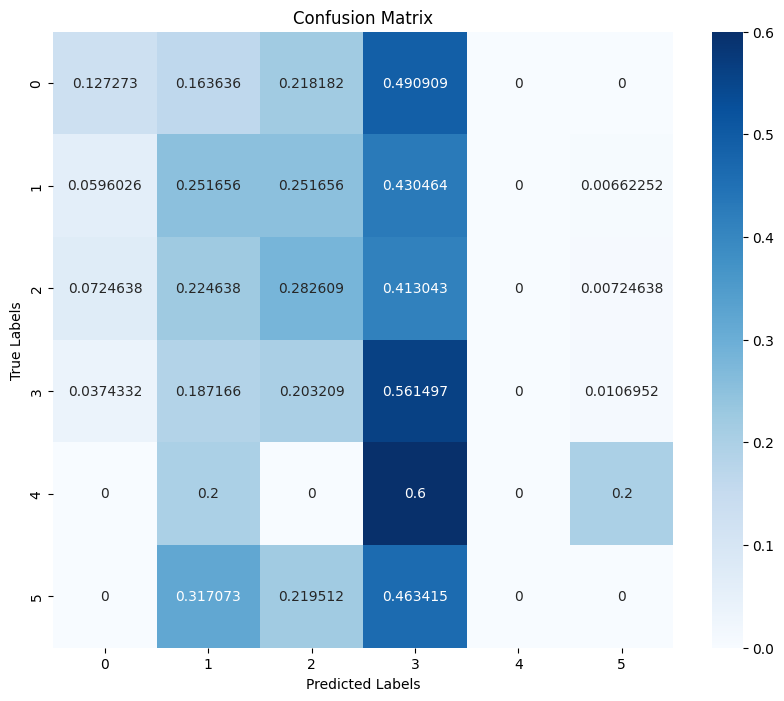

Epoch 17, Validation Loss: 3.6425, Accuracy: 0.3276, F1 Score: 0.3018
Val F1 Score Per Class  [0.15909091 0.27338129 0.28467153 0.45356371 0.         0.        ]


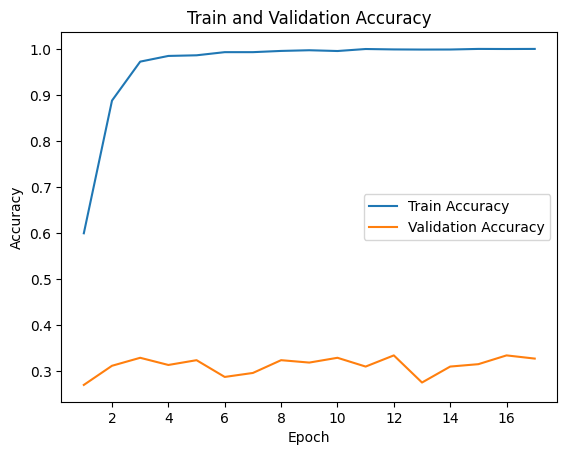

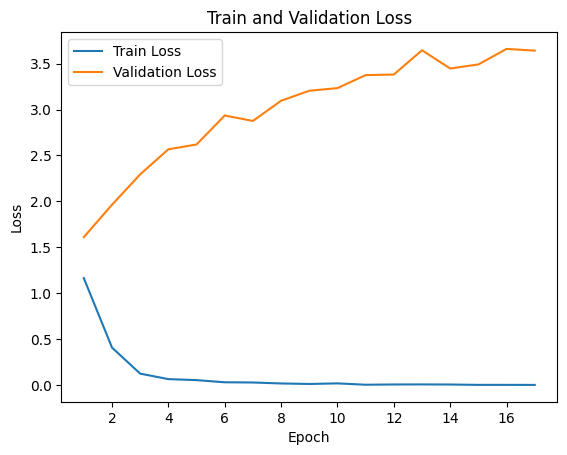

Epoch 18, Train Loss: 0.0008, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:34,  2.10it/s, loss=4.75]

[tensor([-4.0306,  2.7084, -2.9504,  3.1257, -3.6445, -3.5756], device='cuda:0'), tensor([-2.7353,  4.1426, -1.1250, -0.9819, -5.3898, -4.9303], device='cuda:0'), tensor([-1.7564, -1.7313, -2.4168,  5.8644, -4.7904, -3.1449], device='cuda:0'), tensor([-2.4719, -1.0891, -2.9429,  5.7666, -4.1182, -2.7053], device='cuda:0'), tensor([-4.2686,  2.4662, -0.4342,  1.3743, -5.0296, -3.3301], device='cuda:0'), tensor([-4.2762,  0.9420,  2.2514, -0.6837, -3.8619, -3.9647], device='cuda:0'), tensor([-2.9404, -1.9898, -2.1794,  5.1454, -4.0201, -0.7368], device='cuda:0'), tensor([-2.9212, -2.8803,  4.0335,  2.3581, -3.1442, -2.4377], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:34,  2.08it/s, loss=4.27]

[tensor([-2.4815, -1.2035, -2.9640,  4.5004, -4.7866, -3.1033], device='cuda:0'), tensor([-4.2604,  3.3164, -2.4757, -0.9139, -2.9436, -2.5808], device='cuda:0'), tensor([-0.8004, -1.9744,  1.7786,  0.5579, -4.3567, -4.1709], device='cuda:0'), tensor([-2.0890, -1.5639, -1.1608,  6.0634, -3.7467, -3.2741], device='cuda:0'), tensor([-1.4471,  6.8731, -1.7320, -1.5806, -3.1384, -2.9142], device='cuda:0'), tensor([-1.6865,  1.1439, -1.4740,  1.1289, -4.7010, -5.0436], device='cuda:0'), tensor([-1.8054, -1.8330, -2.5137,  4.6776, -4.0489, -3.4993], device='cuda:0'), tensor([ 5.1935,  0.0689, -3.2107,  0.2993, -3.7281, -3.0623], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=4.37]

[tensor([-3.3467, -1.0636, -0.0847, -1.2066, -4.8072, -4.2747], device='cuda:0'), tensor([-2.6378,  1.6815,  0.2715, -1.5503, -3.4383, -3.2375], device='cuda:0'), tensor([-3.2837, -2.1938,  4.0359, -0.9094, -3.8871, -2.9180], device='cuda:0'), tensor([-1.4210, -2.8781, -1.3900,  5.9889, -4.0273, -3.7301], device='cuda:0'), tensor([-2.1323,  0.4912, -3.0830,  3.4421, -3.9825, -3.9983], device='cuda:0'), tensor([-1.9295, -0.4053, -2.7451,  3.8214, -4.6801, -4.4106], device='cuda:0'), tensor([-2.0766, -2.5005, -2.1700,  5.4906, -4.1929, -3.7697], device='cuda:0'), tensor([-1.4069, -1.6413, -0.2988, -1.6359, -4.3361, -4.3273], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.12it/s, loss=3.43]

[tensor([-2.7745, -1.9183, -0.8686,  5.6041, -4.2791, -3.5874], device='cuda:0'), tensor([-4.4918,  1.1987, -0.9017, -0.6319, -4.7610, -2.8380], device='cuda:0'), tensor([-3.1383,  0.1265, -2.7298, -0.0645, -4.3947, -0.6659], device='cuda:0'), tensor([-2.8931, -1.1579,  0.9484, -0.3578, -3.4251, -3.1629], device='cuda:0'), tensor([ 6.1916, -2.3083, -0.8398,  0.2290, -3.2519, -3.7473], device='cuda:0'), tensor([-3.2306, -2.1547, -0.6757,  4.0370, -5.1875, -2.6058], device='cuda:0'), tensor([-1.6001,  6.3456, -1.6151, -1.6325, -3.7636, -3.1515], device='cuda:0'), tensor([-3.9225,  2.3184, -1.0476,  0.6850, -3.8538, -2.6919], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.14it/s, loss=3.79]

[tensor([-3.1408, -1.1869, -1.9526,  5.5886, -3.5250, -3.9128], device='cuda:0'), tensor([-3.0847, -2.4196,  1.4822,  4.0462, -4.2755, -4.4272], device='cuda:0'), tensor([-2.5969, -2.3639,  6.2019, -0.9017, -3.5775, -2.8844], device='cuda:0'), tensor([-2.9534, -0.2609, -2.3028,  1.9031, -4.5464, -4.9230], device='cuda:0'), tensor([-2.9597, -1.7290,  4.3435,  0.4872, -4.2320, -3.6440], device='cuda:0'), tensor([-2.8667,  0.9134, -1.2401,  1.0749, -4.9467, -4.1122], device='cuda:0'), tensor([-3.0977,  0.5750, -2.5193, -1.5550, -4.3998, -2.5650], device='cuda:0'), tensor([-1.6032, -0.3457, -3.1983,  4.8205, -3.9121, -2.6193], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.14it/s, loss=5.47]

[tensor([-2.1912, -2.1096,  7.0970, -1.2555, -2.8085, -2.8406], device='cuda:0'), tensor([-2.2199, -2.0359,  6.8352, -1.5925, -2.7639, -1.7128], device='cuda:0'), tensor([-2.3524, -2.2143,  3.9330, -1.1974, -4.7341, -4.5517], device='cuda:0'), tensor([-3.5533,  1.8871, -2.0288, -0.8107, -4.3325, -3.5727], device='cuda:0'), tensor([-1.9764, -2.0679,  6.9447, -1.6316, -2.8346, -2.2366], device='cuda:0'), tensor([-2.2543, -1.8103, -1.5300,  5.8432, -4.2902, -3.4489], device='cuda:0'), tensor([-2.2755, -3.9071,  0.5616,  3.8257, -4.4088, -3.7850], device='cuda:0'), tensor([-2.5597, -2.1163, -1.9701,  3.9916, -3.7658, -3.9746], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:31,  2.13it/s, loss=2.85]

[tensor([-2.9841, -1.3948, -0.2522,  2.6799, -4.5066, -3.3695], device='cuda:0'), tensor([-2.9772,  0.3179, -0.6052,  0.4636, -4.5580, -3.4080], device='cuda:0'), tensor([-1.1431, -1.9661,  6.6158, -1.6214, -2.5179, -2.7870], device='cuda:0'), tensor([-3.3780, -2.3906, -0.9625,  4.8475, -4.8872, -3.7426], device='cuda:0'), tensor([-3.0454,  4.8763,  0.6192, -1.4467, -3.7701, -4.7702], device='cuda:0'), tensor([-3.3624, -1.2573, -1.4316,  4.6004, -4.5310, -2.5487], device='cuda:0'), tensor([-3.2044, -3.6021,  2.4912,  0.3677, -3.8510, -0.9192], device='cuda:0'), tensor([-3.4958, -0.3967, -2.4629,  0.9418, -4.5619, -3.2250], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.13it/s, loss=5.84]

[tensor([-1.8202, -2.3182, -1.3232,  3.1892, -4.6242, -4.5185], device='cuda:0'), tensor([-2.1649, -2.7915,  3.0962, -0.4274, -3.2987, -3.0620], device='cuda:0'), tensor([-1.7396, -1.4329, -2.6568,  6.4664, -3.9311, -2.9437], device='cuda:0'), tensor([-1.7038,  6.6515, -2.0001, -1.0502, -3.1647, -3.2943], device='cuda:0'), tensor([-2.7915, -1.5304,  6.2184, -1.6708, -3.4103, -3.4670], device='cuda:0'), tensor([-2.1169, -1.3119, -2.0322,  3.1126, -4.6375, -5.0742], device='cuda:0'), tensor([-2.3800, -2.8626, -2.1489,  2.4073, -4.1974,  0.9407], device='cuda:0'), tensor([-2.3919, -2.1293,  6.6235, -0.8768, -2.7355, -2.1731], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.13it/s, loss=5.84]

[tensor([-3.0779, -1.3346, -3.0572,  2.5218, -4.6615, -2.4511], device='cuda:0'), tensor([-2.9893,  3.9283, -1.5563, -0.1303, -5.0150, -4.4826], device='cuda:0'), tensor([-0.9924,  5.0709, -1.7675, -0.6758, -3.7365, -4.3741], device='cuda:0'), tensor([-1.9855, -2.8509,  0.2477,  1.5515, -3.6170, -3.8302], device='cuda:0'), tensor([-2.2325, -2.4661, -1.0277,  5.7031, -3.3646, -2.8993], device='cuda:0'), tensor([-3.1845,  6.1489, -0.7444, -0.8624, -4.0330, -3.4026], device='cuda:0'), tensor([-3.3349, -0.1729, -3.5937,  4.3566, -4.0603, -2.7981], device='cuda:0'), tensor([-2.7604, -2.5003, -0.5959,  4.5637, -4.7971, -3.3120], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.14it/s, loss=3.73]

[tensor([-3.1587,  4.3219, -1.5077, -1.0968, -3.3325, -3.9166], device='cuda:0'), tensor([-3.0994, -2.0184,  0.7220,  2.9498, -4.1577, -4.0168], device='cuda:0'), tensor([-1.6943,  2.5584, -2.5168, -1.3241, -3.5249, -3.2688], device='cuda:0'), tensor([-2.8949, -1.7702,  0.1387,  4.3063, -4.2159, -4.8007], device='cuda:0'), tensor([-2.7710,  3.9177,  1.1943, -1.3933, -4.0580, -4.1702], device='cuda:0'), tensor([-1.4374, -1.4918, -0.7932,  4.6588, -4.8074, -5.1090], device='cuda:0'), tensor([-3.2045,  5.5990, -2.4572, -1.2878, -2.9159, -2.4175], device='cuda:0'), tensor([-2.5423,  6.0558, -1.9862, -0.0597, -4.0767, -3.8028], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:28,  2.14it/s, loss=5.52]

[tensor([-2.7770, -2.0194, -1.5703,  5.8801, -3.5917, -3.2423], device='cuda:0'), tensor([-1.2770,  3.5017, -3.4237, -0.1996, -4.3444, -3.2932], device='cuda:0'), tensor([-3.0341, -2.8738,  1.8555,  4.7418, -4.6132, -2.5986], device='cuda:0'), tensor([-2.4559, -2.0644, -1.6913,  5.9419, -4.6781, -3.8417], device='cuda:0'), tensor([-3.3985,  4.2353, -2.2738, -0.6525, -4.7132, -2.3216], device='cuda:0'), tensor([-3.1187, -0.3935, -3.4599,  3.0538, -4.1551, -3.1408], device='cuda:0'), tensor([-4.2894, -1.4252,  0.0413,  0.2017, -4.1876, -3.6652], device='cuda:0'), tensor([-1.8095, -1.8330, -2.3482,  6.3252, -3.5624, -3.8431], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.14it/s, loss=2.59]

[tensor([-2.9806, -2.4820,  5.6181, -0.9586, -3.3925, -3.4377], device='cuda:0'), tensor([-4.2920,  1.4596,  0.1714,  1.1508, -4.6694, -4.0982], device='cuda:0'), tensor([-3.5891, -0.9995,  1.5823,  2.0544, -4.1243, -4.9201], device='cuda:0'), tensor([-2.9233,  3.4291, -2.4924, -0.4136, -3.5513, -3.4843], device='cuda:0'), tensor([-1.1832, -0.5568, -2.1102, -1.0255, -4.2452, -5.4699], device='cuda:0'), tensor([-2.1548, -2.3130,  6.8724, -0.6820, -3.0851, -2.6382], device='cuda:0'), tensor([-1.9188, -1.2427, -2.8919,  5.7781, -4.2921, -3.0807], device='cuda:0'), tensor([-2.2053, -0.7811,  1.3000, -0.6662, -4.8067, -4.5260], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.14it/s, loss=2.75]

[tensor([-2.3442, -2.2324, -1.4219,  3.0059, -5.0996, -5.1110], device='cuda:0'), tensor([-3.8972,  1.9779,  0.1509,  2.4754, -4.1402, -3.6517], device='cuda:0'), tensor([-3.7149,  0.7739, -1.4523,  0.7727, -5.4531, -4.7155], device='cuda:0'), tensor([-3.2268,  2.1533,  2.1438, -2.4047, -4.0726, -3.3234], device='cuda:0'), tensor([-3.5635,  4.1253, -2.4255, -0.3341, -3.8861, -2.2973], device='cuda:0'), tensor([-2.8528, -1.7038, -0.7832, -0.6880, -4.3021, -3.1155], device='cuda:0'), tensor([-3.2482,  4.1663, -2.7256,  2.8149, -4.3532, -3.8921], device='cuda:0'), tensor([-1.6849,  1.3775, -2.7879,  2.8477, -4.5280, -5.0452], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.15it/s, loss=2.84]

[tensor([-2.3866, -2.5062, -2.5273,  1.7923, -5.0807, -2.5530], device='cuda:0'), tensor([-3.4933, -0.4533, -2.2757,  2.3665, -4.6077, -3.8553], device='cuda:0'), tensor([-3.6214, -2.8239, -1.0636,  1.8761, -3.8131, -0.8718], device='cuda:0'), tensor([-2.6186, -0.3414, -2.3636,  3.0476, -5.0760, -3.8361], device='cuda:0'), tensor([-2.7936, -1.4993, -2.2577,  6.5203, -3.0935, -2.0217], device='cuda:0'), tensor([-3.1036,  1.3873, -2.3760,  2.8754, -4.0393, -3.6770], device='cuda:0'), tensor([-3.3691,  2.8691, -1.4378, -2.2302, -3.6734, -2.8853], device='cuda:0'), tensor([-2.8305, -0.6007, -2.1308,  4.3259, -4.6495, -3.8825], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:26,  2.15it/s, loss=4.18]

[tensor([-3.4459,  2.9717, -1.7619,  0.7445, -4.9317, -4.2510], device='cuda:0'), tensor([-2.7731,  4.1273, -0.7331, -1.2770, -4.7687, -4.4672], device='cuda:0'), tensor([-2.4793, -1.2886,  6.7167, -1.6732, -2.8328, -2.1317], device='cuda:0'), tensor([-1.9827, -2.1387, -1.5761,  6.6078, -3.7989, -3.2845], device='cuda:0'), tensor([-2.2821, -1.4584, -2.0022,  6.3860, -3.5827, -3.9000], device='cuda:0'), tensor([-3.1990,  1.9288, -0.4559, -1.8815, -4.5554, -4.7480], device='cuda:0'), tensor([-4.2337, -1.8576,  0.6339,  2.5829, -5.0521, -3.1315], device='cuda:0'), tensor([-3.7476, -0.8379,  1.2603,  0.7260, -5.0620, -6.0019], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.15it/s, loss=3.66]

[tensor([-2.0764, -1.5075, -2.0226,  6.5911, -3.9345, -3.1453], device='cuda:0'), tensor([-2.3160,  6.0088, -0.8556, -1.4947, -4.0358, -3.6271], device='cuda:0'), tensor([-2.4545, -1.3023, -1.9776,  4.8336, -4.4647, -4.7657], device='cuda:0'), tensor([-3.5987, -0.5355, -0.9205,  2.4281, -4.4695, -2.8475], device='cuda:0'), tensor([-2.3803, -2.6123, -1.4212,  3.7616, -3.6984, -3.6856], device='cuda:0'), tensor([-3.5433, -1.6306,  5.5581, -0.6180, -3.5683, -2.9175], device='cuda:0'), tensor([-2.6637, -1.7922, -1.9327,  6.1790, -4.9088, -3.7376], device='cuda:0'), tensor([-3.2797, -1.7281, -1.4368, -0.5839, -3.7752, -3.0757], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:07<00:26,  2.14it/s, loss=4.55]

[tensor([-3.4954, -1.4278, -0.7998,  5.0523, -4.6963, -4.2874], device='cuda:0'), tensor([-1.4426,  1.4821,  1.1737, -1.5447, -4.2692, -3.4785], device='cuda:0'), tensor([-2.6303,  5.1959, -0.6914, -2.9303, -3.2455, -2.8915], device='cuda:0'), tensor([-3.5023,  1.1034, -1.6231,  0.8796, -5.0665, -4.2807], device='cuda:0'), tensor([-3.0083, -2.8176, -0.7449,  5.5804, -3.2420, -1.5936], device='cuda:0'), tensor([-2.4149, -2.1236, -1.7551,  5.3377, -4.4103, -3.4247], device='cuda:0'), tensor([ 0.5056, -2.6771, -1.4714,  0.6782, -4.4465, -3.3610], device='cuda:0'), tensor([-2.2124, -0.8443, -3.6690,  2.7051, -3.4479, -3.0857], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.14it/s, loss=2.58]

[tensor([-2.4779, -2.6796, -1.0115,  5.7889, -4.0153, -3.6127], device='cuda:0'), tensor([-1.5358, -2.1910, -1.4094,  5.4685, -3.4400, -4.3627], device='cuda:0'), tensor([-4.2876, -0.8254,  1.4268, -1.1791, -4.5300, -1.2669], device='cuda:0'), tensor([-2.9112,  1.5200, -1.0031, -0.0516, -4.3651, -4.7115], device='cuda:0'), tensor([-2.7641, -3.0802,  2.5884, -0.4450, -2.7403, -4.0309], device='cuda:0'), tensor([-1.7922, -2.3017, -1.8278,  3.5186, -4.8083, -2.6625], device='cuda:0'), tensor([-1.9782,  2.6000, -0.6399, -0.6990, -4.8722, -4.4517], device='cuda:0'), tensor([-2.8453, -1.5696, -1.4648,  4.6540, -4.0993, -4.3029], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.14it/s, loss=2.3]

[tensor([-3.0670, -1.7168,  1.7296, -1.1996, -4.5519, -5.1265], device='cuda:0'), tensor([ 3.7194, -1.6894, -2.8028,  0.5675, -4.6421, -4.3680], device='cuda:0'), tensor([-2.2966, -1.8839,  6.3660, -0.3936, -2.9860, -3.2245], device='cuda:0'), tensor([-2.4594, -2.1010, -1.2881,  6.2069, -3.3818, -2.9984], device='cuda:0'), tensor([-1.4409,  5.1478, -2.9816, -0.0606, -5.0065, -4.2390], device='cuda:0'), tensor([-1.4494, -1.6407, -2.5511,  6.0843, -3.9027, -3.7282], device='cuda:0'), tensor([-2.8968,  2.1674, -1.6783,  0.0176, -4.8031, -2.9233], device='cuda:0'), tensor([-2.1692,  0.7528,  0.5718, -1.0095, -4.1239, -3.9057], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.14it/s, loss=5.87]

[tensor([-2.6944, -2.4925,  0.2094,  4.6141, -4.2357, -4.2376], device='cuda:0'), tensor([-3.3044,  4.2496, -1.4183, -2.1597, -2.8011, -2.8797], device='cuda:0'), tensor([-2.6378, -2.0870, -0.3371,  4.3706, -3.7484, -2.5689], device='cuda:0'), tensor([-2.2914, -3.5002,  0.6789,  2.1057, -4.3217, -3.2521], device='cuda:0'), tensor([ 0.5633, -1.3748, -0.5487, -1.4642, -5.4731, -4.2944], device='cuda:0'), tensor([-3.3308,  4.0065, -1.5787, -0.1272, -3.9117, -2.5221], device='cuda:0'), tensor([-2.7584, -2.5220, -0.0282,  3.9906, -4.5225, -4.2302], device='cuda:0'), tensor([-2.6375, -1.7608,  5.0351, -0.4947, -3.8322, -3.8455], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.14it/s, loss=5.29]

[tensor([-1.5218, -3.4222,  4.1209, -0.6010, -3.5748, -2.6996], device='cuda:0'), tensor([-2.0207,  6.0210, -2.4969, -0.5834, -3.8416, -3.5210], device='cuda:0'), tensor([-3.2774,  3.9066,  1.2932, -2.3097, -4.1071, -3.0577], device='cuda:0'), tensor([-2.6975, -2.9311,  5.3042,  0.4553, -3.5296, -3.6500], device='cuda:0'), tensor([-3.2304, -1.8442,  1.9739,  2.5117, -5.0750, -4.9198], device='cuda:0'), tensor([-2.3358, -0.2282, -1.7992, -0.8924, -5.3391, -3.6080], device='cuda:0'), tensor([-1.9917, -2.2446, -1.5474,  6.5937, -3.0745, -2.8364], device='cuda:0'), tensor([-2.3552, -1.7915, -1.5340,  5.8177, -2.7498, -2.1076], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:24,  2.12it/s, loss=2.29]

[tensor([-2.6972,  0.3655, -2.1883,  5.3932, -4.5632, -4.2664], device='cuda:0'), tensor([-2.9343, -1.9663, -0.2450,  0.1843, -3.6204, -3.6101], device='cuda:0'), tensor([-4.1112, -1.8709, -1.0461,  2.7602, -4.2318, -3.8929], device='cuda:0'), tensor([-3.0211, -1.3392, -2.3243,  6.0045, -2.8998, -1.6762], device='cuda:0'), tensor([-2.7046, -2.2038,  2.8863,  1.5973, -4.2276, -4.6741], device='cuda:0'), tensor([-1.8480, -2.9463,  0.2222,  5.0662, -3.8012, -4.2001], device='cuda:0'), tensor([-3.0155, -0.0352, -1.9930,  0.9559, -4.7075, -3.6721], device='cuda:0'), tensor([-3.6720, -2.2938,  1.6392,  3.6258, -4.1331, -3.8528], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.13it/s, loss=2.64]

[tensor([-2.6499, -0.6070, -0.2051,  2.3109, -4.9155, -4.6926], device='cuda:0'), tensor([-2.3711, -1.3249, -2.5845,  5.9265, -4.0293, -3.1431], device='cuda:0'), tensor([-2.0329, -1.2832, -2.5163,  6.0423, -3.0400, -3.4592], device='cuda:0'), tensor([-3.3531,  3.8513, -2.2154, -0.8144, -5.1453, -3.4355], device='cuda:0'), tensor([-3.0837,  1.8125, -1.8864,  2.7522, -4.7283, -4.0114], device='cuda:0'), tensor([-1.7132, -1.7314, -2.1782,  6.6606, -2.9447, -2.7898], device='cuda:0'), tensor([-2.1240, -3.0356,  0.0230,  4.8834, -3.7754, -4.2677], device='cuda:0'), tensor([-3.0848, -2.5262,  6.2840, -1.3572, -3.3428, -3.3506], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.13it/s, loss=3.91]

[tensor([-2.0005, -1.1693, -3.3465,  3.3001, -3.4557, -2.7040], device='cuda:0'), tensor([-2.3712, -1.6901, -1.8756,  5.1313, -4.8425, -3.8372], device='cuda:0'), tensor([-2.2108, -2.4685, -1.0070,  5.7722, -3.9519, -3.8754], device='cuda:0'), tensor([-1.1029, -1.9741,  3.9793, -1.8070, -3.5995, -4.9256], device='cuda:0'), tensor([-3.6011,  2.1608,  3.4450, -1.6626, -3.8771, -4.5830], device='cuda:0'), tensor([-2.6917, -2.7133,  4.8462,  1.6472, -3.6424, -4.4887], device='cuda:0'), tensor([-2.9382, -1.4123, -2.6798,  5.7985, -2.8288, -1.4075], device='cuda:0'), tensor([-2.1783,  3.0998, -3.0435,  0.7428, -5.6297, -2.8273], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.14it/s, loss=4.97]

[tensor([-2.8629,  0.3216, -0.9922,  4.6574, -5.2386, -3.0515], device='cuda:0'), tensor([-2.3852,  1.9762, -2.9907,  4.2094, -4.7830, -3.3324], device='cuda:0'), tensor([-2.9251,  4.9757, -0.4788, -1.1993, -3.8170, -3.8388], device='cuda:0'), tensor([-2.4388, -2.1373,  5.2482, -1.0323, -2.8649, -3.8450], device='cuda:0'), tensor([-2.3113,  0.6818, -1.3424,  1.1804, -5.4436, -5.0714], device='cuda:0'), tensor([-1.8844,  5.9194, -1.5198, -2.2812, -3.2851, -2.7166], device='cuda:0'), tensor([-4.1363,  3.7551, -2.4110, -1.5321, -5.9240, -2.7093], device='cuda:0'), tensor([-2.8699,  4.8297, -3.4641,  0.1177, -4.1453, -1.4470], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.14it/s, loss=3.44]

[tensor([-1.7683,  5.4490, -3.2671, -0.8260, -3.6543, -1.4923], device='cuda:0'), tensor([-2.7711, -0.3583, -0.1685, -2.4127, -4.2928, -2.5887], device='cuda:0'), tensor([-3.7703,  2.6665,  0.0914,  0.0235, -4.9698, -4.4998], device='cuda:0'), tensor([-2.4983, -1.4596,  1.0435, -2.1048, -4.5726, -5.4290], device='cuda:0'), tensor([-2.0504,  4.6670, -2.7690, -0.0213, -4.3095, -4.0261], device='cuda:0'), tensor([-2.7907, -1.3708, -1.6892,  5.4467, -3.0980, -2.7425], device='cuda:0'), tensor([-0.4587, -2.9880,  0.2467,  0.8881, -4.1997, -3.9105], device='cuda:0'), tensor([-1.3119, -3.4677,  0.8336,  2.8590, -3.7255, -3.3668], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.14it/s, loss=3.95]

[tensor([-3.1375,  0.0509, -3.2062,  4.5410, -3.8737, -1.5171], device='cuda:0'), tensor([-1.8675,  6.1132, -0.1182, -1.6994, -3.3769, -3.9582], device='cuda:0'), tensor([-2.5128, -2.3414, -1.8546,  1.2780, -4.4353, -2.5330], device='cuda:0'), tensor([-2.9190, -1.5277, -1.4809,  4.9251, -3.5856, -3.1914], device='cuda:0'), tensor([-1.8799, -1.9196, -2.0771,  3.6661, -3.7447, -3.0502], device='cuda:0'), tensor([-3.9162,  1.9464, -0.2968,  2.8219, -4.7620, -5.3374], device='cuda:0'), tensor([-3.2784, -2.4050,  3.3885,  0.6058, -3.6881, -3.9900], device='cuda:0'), tensor([-2.6736,  5.1223, -2.5650, -0.0943, -3.9931, -3.4570], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.14it/s, loss=4.34]

[tensor([-1.6049, -1.8141,  5.9198, -1.1374, -3.0305, -3.2133], device='cuda:0'), tensor([-2.4822, -2.7264,  3.6113,  1.2496, -3.7515, -3.5904], device='cuda:0'), tensor([-2.1536, -2.1969, -0.9355,  3.5192, -5.0204, -4.4700], device='cuda:0'), tensor([-2.0030, -2.7289,  4.3102, -0.0974, -3.7191, -2.9912], device='cuda:0'), tensor([-2.5486, -1.2985,  5.9370, -0.9660, -3.4497, -3.5329], device='cuda:0'), tensor([-2.4474,  5.3744, -1.7004, -0.7605, -3.7793, -3.6192], device='cuda:0'), tensor([-2.4098, -2.8237,  2.1220,  2.2463, -4.2113, -2.3123], device='cuda:0'), tensor([-1.4878, -2.1217,  6.3127, -0.8348, -3.3829, -3.1421], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.14it/s, loss=4.89]

[tensor([ 5.5656, -1.6065, -1.4983, -1.2316, -3.3193, -1.7966], device='cuda:0'), tensor([-3.8764, -1.1387,  2.1501, -1.3574, -4.3852, -4.0071], device='cuda:0'), tensor([-1.6553,  0.2044, -2.8804,  2.9845, -3.8728, -4.6113], device='cuda:0'), tensor([-1.8369, -0.9001,  2.2592, -0.1223, -3.4672, -2.7446], device='cuda:0'), tensor([-2.7974,  6.2873, -0.8497, -0.5143, -3.7340, -3.9127], device='cuda:0'), tensor([-2.3978, -1.9931,  6.5390, -1.3443, -2.8736, -1.8473], device='cuda:0'), tensor([-2.4234, -1.6982,  4.4713, -0.1957, -4.0487, -3.3390], device='cuda:0'), tensor([-3.4605,  4.7877, -0.9853, -0.3252, -3.5971, -3.4566], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.14it/s, loss=5.05]

[tensor([-2.5515,  5.6737, -2.1852, -0.7074, -5.0386, -4.3467], device='cuda:0'), tensor([-2.2989, -3.0923,  1.9189,  4.0894, -3.6361, -3.4834], device='cuda:0'), tensor([-4.3940,  2.7669, -2.4844,  0.9549, -5.3842, -2.2003], device='cuda:0'), tensor([-3.2541, -1.5651, -2.2854,  3.5574, -3.5032, -1.6252], device='cuda:0'), tensor([-2.1847, -1.7168, -1.5863,  6.4715, -3.2334, -3.3405], device='cuda:0'), tensor([-1.7634, -2.1516,  2.9472, -0.7222, -4.0999, -4.7632], device='cuda:0'), tensor([-0.4629, -2.5151,  3.8497, -1.0390, -2.7146, -2.3806], device='cuda:0'), tensor([ 3.4267, -1.8762, -2.7952,  1.1108, -3.8437, -2.7169], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.15it/s, loss=3.14]

[tensor([-2.6401, -2.6892, -0.4190,  5.8458, -3.3809, -2.6594], device='cuda:0'), tensor([-1.2064, -2.1361, -2.6971,  3.3240, -5.4081, -4.2422], device='cuda:0'), tensor([-3.6228, -1.9324,  3.3003,  2.4920, -5.7202, -3.3293], device='cuda:0'), tensor([-1.2017, -2.8782,  1.2118,  1.4955, -5.3166, -4.8868], device='cuda:0'), tensor([-0.0184, -2.0758,  0.4931, -0.9076, -5.0279, -5.4265], device='cuda:0'), tensor([-2.6692, -0.5728, -2.2168, -1.5054, -3.3363, -0.6496], device='cuda:0'), tensor([-0.6411,  5.5695, -3.0780, -1.4831, -3.6101, -3.4698], device='cuda:0'), tensor([-2.8879, -0.2935, -2.3951,  4.8271, -4.3176, -5.1246], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.14it/s, loss=3.67]

[tensor([-3.5069,  1.9198,  1.4896, -2.3194, -3.9751, -1.1327], device='cuda:0'), tensor([-1.0348, -2.2218, -0.5208,  3.2674, -4.4916, -5.1157], device='cuda:0'), tensor([-2.7593, -1.6836, -1.0572,  3.8935, -5.2315, -5.6592], device='cuda:0'), tensor([-3.2247, -2.3685,  1.2899,  1.7870, -4.5332, -3.8411], device='cuda:0'), tensor([-3.3839, -0.9012,  5.1269, -1.4027, -3.3596, -3.6595], device='cuda:0'), tensor([-2.3936,  6.8321, -1.1293, -1.8160, -3.2271, -2.2989], device='cuda:0'), tensor([-2.0439, -1.4908, -1.3554, -0.9790, -2.4149,  8.2833], device='cuda:0'), tensor([-3.3707, -2.1506, -1.1438,  2.6005, -3.5530, -4.5349], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.14it/s, loss=4.44]

[tensor([-3.1870, -0.9973, -0.1979,  2.9419, -5.3101, -4.4824], device='cuda:0'), tensor([-2.3880,  2.4241, -2.4389,  0.6998, -3.6934, -4.3967], device='cuda:0'), tensor([-3.4417, -1.6479,  0.8464, -1.5174, -4.7877, -4.7298], device='cuda:0'), tensor([-3.7064,  1.6947, -3.2855,  0.0885, -3.3545,  1.7312], device='cuda:0'), tensor([-2.2872, -1.7307, -2.2798,  5.4698, -3.3599, -3.8087], device='cuda:0'), tensor([-4.2308, -1.2196, -1.5082,  3.2114, -3.8498, -4.2447], device='cuda:0'), tensor([-2.8616, -1.4250, -1.2075,  5.1662, -4.5268, -4.1064], device='cuda:0'), tensor([ 2.1192, -2.7450, -2.5217,  3.6493, -3.4142, -3.3356], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.14it/s, loss=3.14]

[tensor([-3.4376, -0.2169,  3.6513, -0.1356, -5.5987, -4.5127], device='cuda:0'), tensor([-2.8177, -2.1806, -0.3744,  0.5881, -3.9595, -4.2721], device='cuda:0'), tensor([-2.1599, -1.1678,  6.7183, -1.8813, -2.7177, -3.0394], device='cuda:0'), tensor([-0.1353, -3.1722,  2.5730, -0.5330, -4.7746, -3.7447], device='cuda:0'), tensor([-2.2394, -0.5326, -2.6362,  5.7404, -4.1310, -3.2619], device='cuda:0'), tensor([-2.8037, -2.0385,  6.6341, -0.8355, -3.0243, -2.7375], device='cuda:0'), tensor([ 2.1330, -2.6162, -2.0799,  0.9290, -3.8359, -3.3981], device='cuda:0'), tensor([-2.6862,  1.4836, -2.1119,  0.8825, -4.5655, -4.4722], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=3.37]

[tensor([-1.6470, -1.7327, -1.8487,  6.1911, -3.6088, -4.3161], device='cuda:0'), tensor([-3.0080, -0.8796,  0.7323, -2.2453, -3.4596, -0.3197], device='cuda:0'), tensor([-2.0237, -1.5169, -2.9351,  4.8083, -4.5944, -3.6700], device='cuda:0'), tensor([ 0.6300, -2.8476, -0.5154, -0.9634, -4.2369, -3.4861], device='cuda:0'), tensor([-2.3634, -0.4467,  0.4134, -1.5298, -3.3264, -2.6637], device='cuda:0'), tensor([-2.6400, -1.7459, -1.9749,  5.9988, -3.5984, -2.2597], device='cuda:0'), tensor([-2.0945, -2.4148, -1.5164,  4.7398, -4.4344, -3.5364], device='cuda:0'), tensor([-3.5623,  5.0321, -2.1530, -0.9578, -4.0753, -1.1035], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.15it/s, loss=2.24]

[tensor([-2.6509, -1.2365, -2.2031,  1.6348, -4.4747, -3.7914], device='cuda:0'), tensor([-0.3873, -2.8679, -1.7166,  2.2747, -4.6393, -3.7614], device='cuda:0'), tensor([-3.6970, -1.0224, -2.6916,  2.7289, -3.0693, -3.5753], device='cuda:0'), tensor([-3.3418,  0.6150, -1.2309,  1.0032, -4.4861, -4.5140], device='cuda:0'), tensor([-1.9113, -2.8362,  1.6872,  3.8957, -4.1406, -4.8676], device='cuda:0'), tensor([-3.2858,  3.1541,  1.1626, -1.9298, -3.3227, -4.5699], device='cuda:0'), tensor([-2.9527,  2.2107, -1.3134, -1.4005, -4.9966, -3.7262], device='cuda:0'), tensor([-4.0626,  2.7272, -0.8919, -1.2139, -3.9273, -4.5033], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.14it/s, loss=5.16]

[tensor([-1.9971, -1.6758, -1.8852,  6.0276, -4.3483, -4.1282], device='cuda:0'), tensor([-2.9290,  5.5909, -2.5606,  0.4719, -3.0937, -3.2476], device='cuda:0'), tensor([-2.5146, -0.8271, -2.8260,  5.6823, -5.1800, -2.5855], device='cuda:0'), tensor([-2.5537, -0.2645,  6.4889, -1.8581, -3.4070, -3.7113], device='cuda:0'), tensor([-3.7272,  0.1092, -1.6073, -1.1265, -4.0844, -3.0694], device='cuda:0'), tensor([-2.7038,  2.0729, -1.4349, -1.5696, -3.6467, -3.3606], device='cuda:0'), tensor([-2.4564,  6.2036, -0.6596, -1.6828, -4.0243, -3.8528], device='cuda:0'), tensor([-3.4504, -1.3980, -1.9181,  4.5973, -4.2607, -3.0789], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=5.24]

[tensor([-3.1829, -1.1201, -3.0831,  5.1736, -3.9219, -2.0361], device='cuda:0'), tensor([-2.7164, -1.9589,  3.8926,  0.9521, -2.6221, -3.2041], device='cuda:0'), tensor([-2.8835, -0.5126, -1.6132,  5.7159, -3.7450, -4.4449], device='cuda:0'), tensor([-2.6613, -1.5902,  5.1085, -1.8062, -4.1232, -3.8694], device='cuda:0'), tensor([-2.2872, -1.9678,  6.4921, -1.4527, -3.0854, -1.3541], device='cuda:0'), tensor([-1.5346, -2.6923,  0.6169,  1.8025, -3.8981, -4.1652], device='cuda:0'), tensor([-2.6506,  5.9207, -2.1375, -1.5326, -2.8424, -2.4133], device='cuda:0'), tensor([-2.3226,  3.7665, -1.4898, -0.8204, -4.3236, -4.8819], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.13it/s, loss=4.65]

[tensor([-2.2106,  3.4343,  0.6270, -1.2700, -4.6393, -4.4385], device='cuda:0'), tensor([-2.4528, -1.2670, -2.8711,  5.1157, -2.2726, -1.0116], device='cuda:0'), tensor([ 1.2714, -0.8084, -3.0926,  0.3041, -3.7742, -3.9221], device='cuda:0'), tensor([-2.9835,  2.7652, -2.1803,  2.1801, -4.7437, -4.8978], device='cuda:0'), tensor([-1.8800,  0.0287, -2.5591,  2.8263, -4.7071, -4.9169], device='cuda:0'), tensor([-2.0488, -3.2942,  3.4528, -0.7737, -3.9687, -3.7293], device='cuda:0'), tensor([-2.6391, -0.5987, -2.2987,  4.2292, -3.5879, -5.3112], device='cuda:0'), tensor([-2.9277, -2.3185,  6.0591,  0.1555, -3.4022, -2.9677], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.13it/s, loss=3.29]

[tensor([-3.9957,  2.9260, -0.9938,  0.7855, -4.9431, -5.1309], device='cuda:0'), tensor([-3.3000, -1.7889, -1.8502,  4.7665, -4.2682, -3.1213], device='cuda:0'), tensor([-3.7889,  0.4335, -2.0004,  1.1861, -3.8988, -4.1399], device='cuda:0'), tensor([-1.6361, -2.1333,  7.0455, -1.9641, -2.4100, -2.1899], device='cuda:0'), tensor([-1.8979,  1.5823, -2.7766,  1.8681, -3.0064, -4.5899], device='cuda:0'), tensor([-3.4507, -2.8580,  1.6993, -1.7942, -4.2684, -2.3165], device='cuda:0'), tensor([-3.0586, -2.4522, -0.2164,  2.6881, -5.1666, -3.3751], device='cuda:0'), tensor([-1.4208, -2.7131,  0.6875,  1.0267, -2.5622, -4.1472], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.14it/s, loss=3.74]

[tensor([-1.9314, -1.7110, -1.9408,  6.7175, -2.9888, -3.0433], device='cuda:0'), tensor([-1.9287, -1.8539, -2.4111,  6.6133, -3.8698, -2.5643], device='cuda:0'), tensor([-2.8660, -1.3500, -1.8471,  5.1128, -4.4955, -3.4461], device='cuda:0'), tensor([-1.5190, -1.3807, -3.4820,  5.2092, -3.7034, -2.5610], device='cuda:0'), tensor([-3.0035,  1.3033,  0.4084, -1.0676, -3.7366, -4.3139], device='cuda:0'), tensor([-3.0220, -1.6819,  6.1788, -0.6586, -3.0946, -3.1592], device='cuda:0'), tensor([-1.8250,  0.4674, -1.6080,  0.4772, -4.6265, -4.7847], device='cuda:0'), tensor([-1.3783, -2.2511,  6.0213, -0.4556, -3.4214, -3.2584], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.14it/s, loss=3.98]

[tensor([-3.8792, -0.4806, -1.1161, -0.5669, -4.8528, -2.3370], device='cuda:0'), tensor([-1.3614, -1.6949, -3.1689,  5.2480, -3.6782, -3.8902], device='cuda:0'), tensor([ 7.4684, -1.8884, -1.3938, -1.1074, -2.4233, -1.4144], device='cuda:0'), tensor([-2.5570,  6.0505, -2.7487, -0.3405, -3.1698, -3.3102], device='cuda:0'), tensor([-2.1552, -1.1190, -3.3836,  5.7922, -4.3663, -2.9077], device='cuda:0'), tensor([-2.2676,  0.1884, -2.8427,  5.2768, -4.6506, -3.7277], device='cuda:0'), tensor([-0.8248, -0.5102, -2.2987,  4.5210, -4.9102, -5.0495], device='cuda:0'), tensor([-3.0626, -1.0051,  1.2308, -1.9227, -4.2180, -1.5079], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.14it/s, loss=3.99]

[tensor([-2.5420, -1.0784, -2.5966,  5.4041, -4.5185, -2.8642], device='cuda:0'), tensor([-3.4477, -2.2034, -1.6974,  1.5926, -3.2145, -2.3195], device='cuda:0'), tensor([-2.6879, -2.5471, -1.0656,  6.0289, -4.3602, -3.0323], device='cuda:0'), tensor([-1.8623, -1.9839, -1.5023,  6.5637, -3.9038, -2.9960], device='cuda:0'), tensor([-3.3089,  4.5482,  0.3029, -0.4920, -4.3609, -4.3573], device='cuda:0'), tensor([-2.4739, -1.8415, -2.9758,  3.9152, -5.7567, -3.5527], device='cuda:0'), tensor([-1.9491, -2.5549, -0.2194,  6.2050, -3.8779, -4.2012], device='cuda:0'), tensor([-1.4214, -2.2630, -1.6340,  6.1393, -3.7726, -4.0438], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.13it/s, loss=2.98]

[tensor([-1.2412, -1.4895, -0.9935,  2.4803, -4.2178, -5.2395], device='cuda:0'), tensor([-1.1077, -2.2308, -0.7210, -0.4593, -3.8042, -4.3294], device='cuda:0'), tensor([-3.7120, -1.8211, -1.8804,  4.1936, -4.6830, -3.3685], device='cuda:0'), tensor([-4.2365, -1.0158, -0.8537,  1.6227, -5.1881, -3.5114], device='cuda:0'), tensor([-2.5111, -2.5293,  0.8200,  1.2387, -3.3925, -2.6910], device='cuda:0'), tensor([-4.2373,  0.8932,  0.3842,  2.1896, -4.9245, -4.2989], device='cuda:0'), tensor([ 0.8783, -2.2465,  0.3347,  1.8371, -4.4191, -3.4763], device='cuda:0'), tensor([-2.2619,  4.5187, -2.9068, -0.7468, -3.3491, -1.7859], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.14it/s, loss=3.36]

[tensor([ 1.2793, -0.7892, -3.6608, -0.9258, -4.8898, -2.1041], device='cuda:0'), tensor([-2.9199,  0.7339, -3.0671,  2.9359, -3.1836, -3.2264], device='cuda:0'), tensor([-3.4529,  0.9309, -2.8094,  3.0423, -4.1188, -1.8879], device='cuda:0'), tensor([-2.9163, -1.4333, -0.9426, -0.7054, -3.6156, -3.2143], device='cuda:0'), tensor([-2.7096, -3.0373,  4.6153,  0.5444, -3.7966, -2.9044], device='cuda:0'), tensor([-2.0120, -1.8484, -2.2081, -1.0949, -2.4558,  7.8483], device='cuda:0'), tensor([-3.6481,  4.0325, -0.2340, -0.3053, -4.2188, -3.6791], device='cuda:0'), tensor([-3.2701, -1.7008, -1.9736,  4.4543, -4.1596, -2.4841], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.15it/s, loss=3.04]

[tensor([-3.1856, -0.2553,  3.9810, -1.8196, -4.2850, -4.1347], device='cuda:0'), tensor([-1.6289,  1.4670, -1.2405,  1.6053, -3.0904, -3.3006], device='cuda:0'), tensor([-3.3683, -1.2045, -0.9805,  4.3539, -4.1563, -4.9335], device='cuda:0'), tensor([-1.9705, -2.3852,  6.5944, -1.8784, -2.8156, -1.3088], device='cuda:0'), tensor([-3.4888, -0.7974, -2.5451,  4.7164, -3.4525, -2.4353], device='cuda:0'), tensor([-2.3791,  5.9318, -2.6148, -0.8669, -2.9855, -2.8934], device='cuda:0'), tensor([-2.4624, -0.1164,  0.6917,  0.9370, -4.8332, -4.4191], device='cuda:0'), tensor([-2.8834, -1.4567,  4.5792, -1.3316, -3.4599, -4.1258], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.15it/s, loss=3.48]

[tensor([ 4.9600, -1.9708, -3.7268,  0.6171, -3.2340, -2.8736], device='cuda:0'), tensor([-2.7849, -1.5149, -0.8642,  4.2078, -5.6087, -4.1012], device='cuda:0'), tensor([-3.6054, -1.7486, -0.0464,  1.8940, -3.9139, -3.8327], device='cuda:0'), tensor([-2.6325, -1.3307,  3.7540, -0.1290, -4.1997, -4.1923], device='cuda:0'), tensor([-2.3256,  3.7814,  0.1441,  0.9016, -4.8470, -4.9183], device='cuda:0'), tensor([-2.4840, -1.0855, -2.5403,  5.5271, -4.5236, -3.0575], device='cuda:0'), tensor([-1.8258, -1.5772, -1.9188,  1.4942, -2.3107, -3.8147], device='cuda:0'), tensor([-2.5405, -1.2595, -1.6711,  5.9836, -4.5038, -3.7828], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.14it/s, loss=3.16]

[tensor([-2.0622, -1.8695,  6.9682, -1.8739, -2.8406, -1.9143], device='cuda:0'), tensor([-3.2916,  1.0339, -2.0187,  1.9278, -4.9767, -4.5852], device='cuda:0'), tensor([-2.5238,  6.6881, -1.2689, -1.8100, -3.3961, -2.7899], device='cuda:0'), tensor([-2.2678,  4.6252, -2.2180,  0.4223, -4.4756, -4.2331], device='cuda:0'), tensor([-1.9242, -1.9702, -2.0219,  6.6811, -3.2906, -2.8617], device='cuda:0'), tensor([ 0.2518, -0.2658, -1.1287, -0.5148, -4.1359, -3.0034], device='cuda:0'), tensor([-2.7189, -1.6739,  0.1278,  2.6016, -5.3712, -4.9188], device='cuda:0'), tensor([-3.4186, -1.1296, -1.2721,  5.7580, -3.8314, -3.5595], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.15it/s, loss=3.75]

[tensor([-3.5484, -2.1838,  4.7337,  0.3760, -3.5113, -3.9876], device='cuda:0'), tensor([-1.1320,  1.7021, -2.5325,  1.1315, -4.1575, -4.7442], device='cuda:0'), tensor([-3.4403, -0.9456,  5.4653, -1.2505, -2.4326, -2.4535], device='cuda:0'), tensor([-2.5035, -2.2610,  4.9565, -0.3127, -3.4676, -2.9195], device='cuda:0'), tensor([-3.2306,  4.0959,  0.9262, -2.1599, -3.9264, -3.6914], device='cuda:0'), tensor([-0.6819, -3.1195, -0.0265,  0.4055, -3.8467, -4.3539], device='cuda:0'), tensor([-3.4409,  0.9768,  0.6831, -0.9077, -5.2198, -1.2542], device='cuda:0'), tensor([-2.7515, -2.4156, -1.3743,  6.1436, -3.5147, -2.7036], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.15it/s, loss=3.43]

[tensor([-1.0979, -1.2502, -1.9763,  0.7298, -5.3599, -3.7747], device='cuda:0'), tensor([-2.7423, -1.7941, -1.8170,  5.5286, -4.8091, -3.8740], device='cuda:0'), tensor([-3.7097,  0.0929,  2.6334,  1.8807, -3.8804, -3.5022], device='cuda:0'), tensor([-2.4589,  4.4680, -1.2556,  0.6322, -6.1989, -3.9160], device='cuda:0'), tensor([-2.7244, -1.8510,  4.3705, -1.4306, -4.8243, -4.2253], device='cuda:0'), tensor([-2.1035, -1.9024, -2.2405,  6.4830, -2.9234, -2.2233], device='cuda:0'), tensor([-2.6778, -1.8957, -1.0394,  6.2140, -3.7096, -2.3534], device='cuda:0'), tensor([-2.8905,  1.6238, -2.3580,  1.4489, -4.3682, -4.7361], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.15it/s, loss=2.31]

[tensor([-2.1839, -2.5723,  4.4068,  1.2848, -4.3451, -3.5122], device='cuda:0'), tensor([-2.0825, -2.0997, -2.0985,  6.6392, -3.4949, -2.3074], device='cuda:0'), tensor([-3.9999,  2.7910,  1.3573, -0.8060, -3.8331, -1.8179], device='cuda:0'), tensor([-2.3109, -1.4765, -1.9086,  6.4035, -3.5893, -3.7058], device='cuda:0'), tensor([-3.2197,  1.8576, -0.7882,  0.6647, -4.6906, -4.5023], device='cuda:0'), tensor([-0.9139,  0.4672, -4.3772,  4.5896, -4.5453, -2.7976], device='cuda:0'), tensor([-2.5019, -1.3660, -1.8698,  5.8095, -3.9628, -2.6831], device='cuda:0'), tensor([-1.0013,  1.1476, -2.1991, -2.9265, -3.9790,  2.9549], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.15it/s, loss=2.91]

[tensor([-3.9831, -0.4755, -0.6525,  2.4161, -5.2118, -2.2062], device='cuda:0'), tensor([-1.7447, -1.6006, -1.3938,  6.2711, -3.7258, -4.3255], device='cuda:0'), tensor([-0.1312, -0.4408, -2.9122,  1.5538, -2.5859, -4.7355], device='cuda:0'), tensor([-2.5674,  1.6365, -3.0150,  1.1297, -4.3760, -3.1306], device='cuda:0'), tensor([-2.5660, -2.5259,  1.7460, -1.3418, -3.4954,  0.2901], device='cuda:0'), tensor([-2.7315,  5.5644, -2.8213, -1.1157, -3.0419, -3.2074], device='cuda:0'), tensor([ 2.3408, -3.0312,  2.7307, -1.1140, -3.8362, -3.0205], device='cuda:0'), tensor([-2.5930,  5.1795, -1.4088, -0.7949, -4.1267, -3.3336], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.15it/s, loss=3.78]

[tensor([-2.3739,  0.0685, -2.9452,  5.0504, -4.1273, -3.5932], device='cuda:0'), tensor([-1.7955, -2.5803, -0.6884,  2.1703, -4.3794, -4.4272], device='cuda:0'), tensor([-2.9403, -2.3539, -1.4352,  2.5936, -5.2776, -1.1399], device='cuda:0'), tensor([-1.7068, -0.5134, -2.1372,  2.5557, -4.9472, -4.9924], device='cuda:0'), tensor([ 4.0369, -1.5102,  0.1494, -2.1843, -3.6457, -2.7044], device='cuda:0'), tensor([-2.5622, -1.5027, -2.5496,  3.8282, -4.5060, -4.9197], device='cuda:0'), tensor([-1.8639, -1.8455, -0.2182,  5.1392, -4.8154, -4.6540], device='cuda:0'), tensor([-3.3314, -1.3817,  5.0790, -1.4994, -3.4293, -3.9876], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.16it/s, loss=3.35]

[tensor([-3.3200, -2.2479, -0.8473,  5.4987, -3.9464, -2.6861], device='cuda:0'), tensor([-0.6222, -2.2394, -2.1976,  1.6298, -4.6222, -3.6779], device='cuda:0'), tensor([-2.6779,  1.6433,  0.4658, -1.5304, -4.2678, -2.5289], device='cuda:0'), tensor([-2.0119, -1.9862, -1.6308,  6.5855, -3.9060, -2.6424], device='cuda:0'), tensor([-2.8381, -2.2962, -1.1869,  6.3555, -3.9137, -3.2329], device='cuda:0'), tensor([-3.1372, -1.5081, -2.5749,  1.0607, -4.2144, -1.1932], device='cuda:0'), tensor([-2.2918,  4.9322,  0.3690, -1.8084, -4.0714, -4.2460], device='cuda:0'), tensor([-3.8974, -0.2346, -1.5381, -1.4679, -4.8202,  1.6903], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.14it/s, loss=3.5]

[tensor([-2.1075, -2.0217,  6.7088, -1.1324, -2.7370, -2.2773], device='cuda:0'), tensor([-0.8373, -0.2604,  1.4563, -0.5298, -5.0959, -5.6958], device='cuda:0'), tensor([-0.3704, -1.9361, -0.2704,  0.3136, -3.9916, -4.9159], device='cuda:0'), tensor([-2.5830,  2.2042, -1.6213, -0.8206, -4.7811, -3.5221], device='cuda:0'), tensor([-3.0420,  3.0587, -1.4881,  0.1361, -3.8391, -3.5845], device='cuda:0'), tensor([-2.1057, -1.9298,  4.5489, -0.7201, -3.7497, -3.4659], device='cuda:0'), tensor([-2.5784, -2.5611, -1.2066,  6.0567, -3.3222, -2.7453], device='cuda:0'), tensor([-1.8037,  6.5877, -1.4586, -1.4357, -3.8176, -3.2668], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.15it/s, loss=3.41]

[tensor([-3.6354,  0.7573, -0.6683, -1.5349, -4.4626, -3.3432], device='cuda:0'), tensor([-2.7335,  0.7900, -2.7224,  2.5802, -3.1283, -3.6887], device='cuda:0'), tensor([-2.6128, -3.2835,  1.8467,  1.0041, -5.1363, -3.5124], device='cuda:0'), tensor([-3.2862, -1.5992, -1.0536,  0.8492, -4.6894, -5.0440], device='cuda:0'), tensor([-2.7820,  6.1191, -1.4961, -0.3824, -3.8877, -4.1375], device='cuda:0'), tensor([-2.0104, -2.3306, -1.8449,  5.9028, -4.4555, -1.9517], device='cuda:0'), tensor([-2.4796, -0.4026, -2.2165, -0.6851, -3.9226, -3.6256], device='cuda:0'), tensor([-2.7043,  1.0579, -3.0095,  4.6706, -3.4296, -2.7938], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=3.36]

[tensor([-1.7679,  5.4530, -1.5786, -1.1948, -2.7741, -2.9023], device='cuda:0'), tensor([-2.7175, -1.0575, -1.9060,  0.8185, -4.8117, -5.0047], device='cuda:0'), tensor([-1.5555, -1.1719,  2.2421, -0.9581, -4.7324, -3.8488], device='cuda:0'), tensor([-2.2056, -1.9187, -1.7803,  1.4773, -4.7116, -4.4568], device='cuda:0'), tensor([-2.6437, -2.0737, -1.8461,  5.8799, -3.4997, -2.2258], device='cuda:0'), tensor([-2.5635, -1.8749,  3.6514, -1.2345, -3.8164, -4.2166], device='cuda:0'), tensor([-2.1595,  5.1290, -2.7704, -0.4764, -3.4571, -4.2542], device='cuda:0'), tensor([-2.4048, -1.9288, -1.0056,  5.7104, -3.5464, -3.5457], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.15it/s, loss=3.47]

[tensor([-3.7479, -1.2952, -0.8274,  4.2811, -4.3052, -5.0075], device='cuda:0'), tensor([-2.0558, -2.1413,  1.2081, -0.2787, -3.5942, -4.7013], device='cuda:0'), tensor([-2.8660,  5.4431, -1.6566, -1.2545, -3.6908, -2.7100], device='cuda:0'), tensor([-1.4056, -1.4786, -3.7864,  5.0508, -2.4738, -3.5536], device='cuda:0'), tensor([-3.5613,  0.2553, -1.2212,  0.4616, -4.6911, -4.3982], device='cuda:0'), tensor([-3.4843, -0.8700,  3.6330,  1.7931, -4.3136, -4.4809], device='cuda:0'), tensor([-3.5959,  1.1171,  4.2215, -1.9837, -4.4572, -3.9471], device='cuda:0'), tensor([-3.0980,  0.2057, -0.2033,  2.1222, -4.5411, -4.7708], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=1.61]

[tensor([-1.9177, -2.1918, -1.8061,  6.4416, -3.1238, -3.3646], device='cuda:0'), tensor([-3.5137,  0.6952, -1.1361, -0.4560, -5.2217, -4.4739], device='cuda:0'), tensor([-1.6767, -0.3661, -3.8489,  4.8643, -4.0094, -3.1455], device='cuda:0'), tensor([-2.3057, -1.2684, -1.9528,  3.2997, -5.1445, -3.5417], device='cuda:0'), tensor([-3.1364,  1.9250,  0.1697,  0.3717, -4.9832, -4.9362], device='cuda:0'), tensor([-1.1661,  0.0659, -2.3987,  0.6206, -4.3160, -5.6978], device='cuda:0'), tensor([-2.8093,  6.0416, -1.6167, -0.4072, -4.2237, -3.9987], device='cuda:0'), tensor([-2.4664, -3.1028,  1.0783, -0.6656, -3.7028, -3.0992], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.15it/s, loss=3.67]

[tensor([-2.0954, -0.9553, -1.8038,  5.4328, -3.5011, -2.9368], device='cuda:0'), tensor([-3.7273,  0.6922,  0.4964,  1.1562, -4.7070, -4.9341], device='cuda:0'), tensor([-1.1330, -2.2992, -1.6633, -1.0507, -4.6382, -5.1289], device='cuda:0'), tensor([-3.1682, -1.0417, -1.7794,  5.4626, -2.9012, -2.7873], device='cuda:0'), tensor([-3.6140,  0.6202,  3.1292, -0.2030, -4.5469, -4.5538], device='cuda:0'), tensor([-2.3312, -2.3552, -1.2672,  6.2502, -4.2217, -3.7575], device='cuda:0'), tensor([-2.0804, -2.0416, -1.6619,  6.5148, -4.1037, -2.9208], device='cuda:0'), tensor([-1.4967, -1.8226, -2.1967, -0.4759, -4.8125, -5.1560], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.16it/s, loss=4.64]

[tensor([-1.7506, -2.8400, -1.7087,  5.7060, -3.0339, -2.7431], device='cuda:0'), tensor([-1.8446e+00,  4.7729e-04,  2.4037e+00, -1.9948e+00, -3.2141e+00,
        -4.0176e+00], device='cuda:0'), tensor([-2.3923, -0.1430, -3.1228,  3.7642, -4.2185, -3.4745], device='cuda:0'), tensor([-3.7109, -1.7433,  3.1414, -0.1782, -3.0741, -2.0226], device='cuda:0'), tensor([-3.5011, -2.2023, -1.1597,  4.9563, -3.8615, -2.6011], device='cuda:0'), tensor([-2.1800,  1.1342, -3.4200,  2.6482, -3.5813, -1.1842], device='cuda:0'), tensor([-2.8756,  1.6304, -1.7237,  0.8711, -4.5197, -3.8433], device='cuda:0'), tensor([ 1.8340, -1.5760, -3.6207, -0.5928, -3.2358,  0.3532], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.14it/s, loss=3.12]

[tensor([-3.5122,  1.2255,  0.0777, -1.2479, -3.6915, -3.6540], device='cuda:0'), tensor([-2.0968, -1.2596,  6.2438, -2.0337, -2.5126, -3.1886], device='cuda:0'), tensor([-1.5656, -1.3785,  0.9741, -1.2418, -5.2995, -4.3316], device='cuda:0'), tensor([-1.9175, -1.0433, -1.8133,  4.5662, -1.7297, -3.4896], device='cuda:0'), tensor([-2.9428, -2.3159,  1.9266,  0.1093, -5.0751, -4.5573], device='cuda:0'), tensor([-2.8962, -2.5225,  2.7657,  0.9111, -3.9232, -2.9884], device='cuda:0'), tensor([-3.1693,  1.2838, -1.4514,  4.4758, -5.4246, -4.9187], device='cuda:0'), tensor([-3.2873,  4.9596, -1.7808,  0.3632, -4.2483, -3.8623], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.14it/s, loss=1.91]

[tensor([-1.6091, -1.8502,  6.5212, -1.0954, -3.1245, -2.7797], device='cuda:0'), tensor([-2.5081, -1.4235,  6.6323, -1.8650, -2.8952, -2.6905], device='cuda:0'), tensor([-3.7456,  2.7106, -2.7292, -0.4754, -5.1719, -3.9523], device='cuda:0'), tensor([-3.6950,  3.6294,  0.5440, -1.3888, -5.1234, -3.3557], device='cuda:0'), tensor([-2.7878, -1.7406, -2.1371,  5.0060, -4.1265, -4.7969], device='cuda:0'), tensor([-1.3441, -2.3107, -2.6624,  5.9053, -3.8550, -1.6581], device='cuda:0'), tensor([-3.0897, -2.3232,  5.2331, -1.7310, -3.9591, -3.1086], device='cuda:0'), tensor([-2.3282, -1.6671, -2.5801,  1.8492, -4.7627, -4.4874], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.15it/s, loss=1.26]

[tensor([-2.0034, -1.2061, -2.5607,  6.5699, -3.2695, -3.1646], device='cuda:0'), tensor([-3.7702,  0.7326, -0.6376,  2.1874, -3.8128, -5.1731], device='cuda:0'), tensor([-3.2221,  2.2301, -2.5646,  3.8461, -4.2880, -4.4353], device='cuda:0'), tensor([-2.8865,  5.2911, -0.2359, -1.8425, -3.0264, -3.0707], device='cuda:0'), tensor([-2.1040, -2.1743,  1.0030,  0.2214, -3.8543, -3.7967], device='cuda:0'), tensor([-3.5163, -1.0393, -0.2569,  0.8136, -3.8624, -3.3892], device='cuda:0'), tensor([-2.0044, -0.9196, -2.9509,  4.0390, -4.1110, -4.5723], device='cuda:0'), tensor([-3.3632, -1.2945,  0.1119,  2.5679, -2.9821, -3.7474], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.14it/s, loss=1.81]

[tensor([-3.4541, -1.1583,  0.1197,  0.1163, -5.2063, -4.6615], device='cuda:0'), tensor([-1.0465,  1.1862, -2.5583,  1.7927, -4.7024, -4.8860], device='cuda:0'), tensor([-2.6347, -0.8474, -1.2919,  0.1428, -4.0245, -4.4848], device='cuda:0'), tensor([-3.2311, -1.6046,  3.2256, -0.9539, -3.9185, -2.8158], device='cuda:0'), tensor([-2.5030, -0.5229, -1.3440,  5.0836, -3.7065, -5.1087], device='cuda:0'), tensor([ 4.1816, -2.9728,  0.0868, -0.3443, -4.5725, -2.2520], device='cuda:0'), tensor([-3.3668, -0.3603,  1.0480,  0.6736, -4.1721, -5.0588], device='cuda:0'), tensor([-1.8397, -1.7859, -1.9952,  6.4548, -3.6611, -2.6535], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.14it/s, loss=3.67]

[tensor([-2.3723, -0.6106,  1.5458,  1.4451, -4.1302, -2.3413], device='cuda:0'), tensor([-2.2645, -2.0618, -0.7998,  3.1048, -4.4647, -1.8213], device='cuda:0'), tensor([-2.6921, -3.8340,  0.3449,  4.0205, -4.2064, -3.0439], device='cuda:0'), tensor([-3.6145,  0.7886, -0.5998,  1.9758, -3.9419, -4.5628], device='cuda:0'), tensor([-1.3573, -3.2385,  5.4751, -0.2629, -4.4487, -3.4678], device='cuda:0'), tensor([-3.1415, -1.9645, -1.8202,  3.5809, -5.1657, -3.6726], device='cuda:0'), tensor([-2.2329, -2.3329,  6.4859, -1.1458, -3.1574, -2.6038], device='cuda:0'), tensor([-2.4193, -0.6227, -2.8921,  5.9972, -4.2366, -3.0165], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.15it/s, loss=4.07]

[tensor([-3.5188,  1.3510, -2.7730,  2.8827, -0.0556, -3.6202], device='cuda:0'), tensor([-2.9535, -2.8291,  4.5378, -0.2692, -3.9933, -3.4934], device='cuda:0'), tensor([-2.5905, -2.4620,  3.3961,  1.2276, -4.5878, -2.0214], device='cuda:0'), tensor([-2.8576, -0.0872, -1.6222,  2.4151, -3.8649, -4.2693], device='cuda:0'), tensor([-2.7754,  1.1420, -2.5819,  3.6139, -4.1712, -2.7480], device='cuda:0'), tensor([-3.9360, -0.0154,  4.1596, -0.6077, -5.2001, -4.4948], device='cuda:0'), tensor([-3.0170, -1.4594, -2.3531,  5.9054, -3.5809, -2.7333], device='cuda:0'), tensor([-0.7132, -0.6482, -1.7231,  1.1839, -4.5434, -4.5719], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.16it/s, loss=4.4]

[tensor([-3.2709,  3.9589, -0.0952, -0.5857, -3.8350, -4.8131], device='cuda:0'), tensor([-2.5023, -2.0473, -1.7071,  3.5657, -4.0980, -4.8280], device='cuda:0'), tensor([-1.3538, -1.2495,  5.0416, -2.5279, -4.1721, -2.7639], device='cuda:0'), tensor([-1.5878, -2.1807, -2.5659,  5.6402, -4.0923, -2.6259], device='cuda:0'), tensor([-2.9646, -2.4042, -1.6804,  5.6875, -4.0772, -2.9384], device='cuda:0'), tensor([-3.3159, -2.7662,  0.2825,  1.8177, -4.8314, -5.3949], device='cuda:0'), tensor([ 3.9913, -1.7575, -2.8056,  0.0544, -3.6099, -3.3713], device='cuda:0'), tensor([-2.2922, -2.0065, -2.0921,  6.6545, -3.5419, -2.6128], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.15it/s, loss=3.45]

[tensor([-2.3162, -3.1015, -1.6567,  4.8036, -4.3991, -1.9398], device='cuda:0'), tensor([ 4.6010, -2.3067, -2.7348,  0.0816, -3.5908, -3.0493], device='cuda:0'), tensor([-3.5869, -2.0737, -1.5829,  0.5951, -4.4383, -4.0199], device='cuda:0'), tensor([-2.7742, -1.4557, -2.0812,  5.4569, -3.6694, -1.9573], device='cuda:0'), tensor([-2.4727,  2.0329, -2.1736,  0.7309, -3.8675, -4.3532], device='cuda:0'), tensor([ 1.2720, -0.0848, -3.0128,  2.7176, -4.1703, -4.4179], device='cuda:0'), tensor([-1.9250,  6.9217, -1.7354, -1.3686, -3.3239, -2.4054], device='cuda:0'), tensor([-2.5827, -2.6161,  4.0076, -0.3559, -4.2497, -3.4666], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.15it/s, loss=5.04]

[tensor([-2.0938,  4.7529, -2.0975,  0.0473, -3.3228, -3.6733], device='cuda:0'), tensor([-1.8760, -1.8199, -2.4872,  6.5568, -3.2645, -3.0531], device='cuda:0'), tensor([-1.7062, -3.1342,  2.2948, -0.7454, -3.5441, -3.7414], device='cuda:0'), tensor([-2.3036,  0.1005, -3.2486,  4.3840, -3.9399, -3.7560], device='cuda:0'), tensor([-1.9594, -1.6412, -1.8345,  6.3845, -3.0582, -3.2213], device='cuda:0'), tensor([-3.5445,  0.5841, -1.5496, -1.2596, -4.5309, -4.4653], device='cuda:0'), tensor([-2.5509,  0.0543,  0.5670,  1.4217, -3.9099, -2.6462], device='cuda:0'), tensor([-3.1645, -2.4710, -0.5624, -1.2620, -3.6020,  5.7653], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.15it/s, loss=2.62]

[tensor([-1.9522, -1.8095, -1.7054,  3.4255, -2.8990, -4.8285], device='cuda:0'), tensor([-1.5720, -2.4442, -1.4579,  6.3821, -3.3010, -3.2341], device='cuda:0'), tensor([-2.1770,  0.5064, -1.9083, -0.2899, -4.1434, -4.9285], device='cuda:0'), tensor([-2.6054, -0.9012,  5.2085, -2.3703, -3.5894, -2.7000], device='cuda:0'), tensor([-2.6948, -2.5099, -0.1143,  2.7773, -4.4603, -5.3024], device='cuda:0'), tensor([-2.6185,  3.4388, -2.3323,  0.6560, -3.0135, -3.9455], device='cuda:0'), tensor([-2.3372, -3.1158, -1.9973,  5.6271, -3.3910, -2.0502], device='cuda:0'), tensor([-1.2311, -1.4939, -3.0779, -1.1506, -5.9970, -4.2401], device='cuda:0')]


[tensor([-2.6870, -0.6360,  0.0774,  2.1795, -4.6519, -4.3398], device='cuda:0'), tensor([-1.0081, -0.7050, -3.2724,  4.9204, -4.3890, -4.2084], device='cuda:0'), tensor([-3.8700, -1.4372,  1.5522,  2.4830, -4.7729, -4.7215], device='cuda:0'), tensor([-2.3245,  1.3750,  0.7848, -2.0813, -4.0530, -2.7310], device='cuda:0'), tensor([-1.8029,  1.0065, -1.9978,  2.8435, -4.9619, -4.5077], device='cuda:0'), tensor([-3.6591, -1.6973, -2.0969,  3.1091, -4.4917, -3.8301], device='cuda:0'), tensor([ 1.5288, -2.3841,  2.4530, -0.4174, -3.0508, -3.5269], device='cuda:0'), tensor([-2.9460, -1.5626, -1.9129,  2.8874, -4.4224,  0.9308], device='cuda:0')]
[tensor([-2.3628,  3.6087, -2.7570, -0.1479, -4.6626, -4.0440], device='cuda:0')]


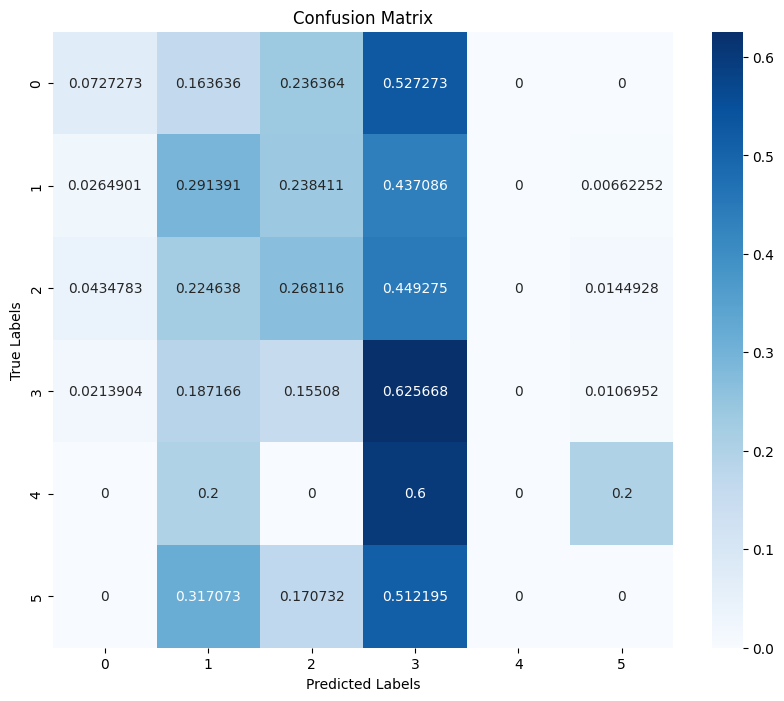

Epoch 18, Validation Loss: 3.7198, Accuracy: 0.3501, F1 Score: 0.3160
Val F1 Score Per Class  [0.10958904 0.30985915 0.28461538 0.48247423 0.         0.        ]


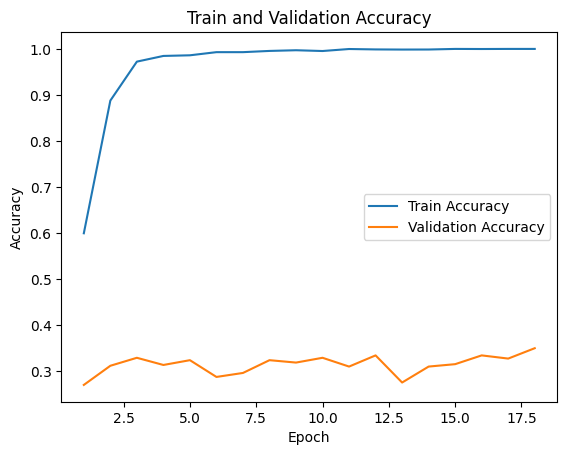

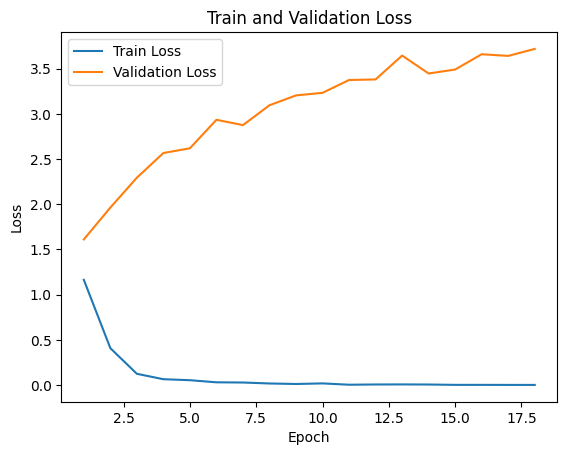

Epoch 19, Train Loss: 0.0007, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.18it/s, loss=4.7]

[tensor([-4.1201,  2.3659, -2.9058,  3.4693, -3.7230, -3.6543], device='cuda:0'), tensor([-2.9167,  3.6308, -0.7955, -1.1052, -5.5065, -5.0974], device='cuda:0'), tensor([-1.7420, -1.8004, -2.3689,  5.9203, -4.8289, -3.1763], device='cuda:0'), tensor([-2.4646, -1.2184, -2.9224,  5.8200, -4.1280, -2.7108], device='cuda:0'), tensor([-4.3156,  1.8435,  0.0920,  1.3059, -5.1152, -3.4150], device='cuda:0'), tensor([-4.2694,  0.5659,  2.9484, -0.8287, -3.7427, -3.7763], device='cuda:0'), tensor([-2.9525, -2.1557, -2.1190,  5.0000, -4.0480, -0.6068], device='cuda:0'), tensor([-2.9111, -2.9627,  4.4190,  2.1056, -3.1456, -2.4724], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.10it/s, loss=4.26]

[tensor([-2.5737, -1.3736, -2.7809,  4.4449, -4.8482, -3.1184], device='cuda:0'), tensor([-4.2510,  3.1434, -2.4364, -0.9617, -2.9465, -2.5780], device='cuda:0'), tensor([-0.6751, -2.0447,  2.0078,  0.2741, -4.3005, -4.1212], device='cuda:0'), tensor([-2.0995, -1.6328, -1.1221,  6.0910, -3.7789, -3.2778], device='cuda:0'), tensor([-1.4669,  6.8753, -1.6488, -1.5908, -3.2254, -3.0169], device='cuda:0'), tensor([-1.7161,  0.6149, -1.2732,  1.2080, -4.8229, -5.1880], device='cuda:0'), tensor([-1.7538, -2.0242, -2.4571,  4.2801, -4.0143, -3.5458], device='cuda:0'), tensor([ 5.4481, -0.1369, -3.1162,  0.1967, -3.6842, -3.0153], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=4.56]

[tensor([-3.4447, -1.5423,  0.9057, -1.3859, -4.9300, -4.0413], device='cuda:0'), tensor([-2.6056,  1.4801,  0.4691, -1.6288, -3.4521, -3.2299], device='cuda:0'), tensor([-3.1366, -2.3438,  5.0172, -1.0014, -3.7114, -2.7314], device='cuda:0'), tensor([-1.4328, -3.0732, -1.2911,  5.8048, -4.1377, -3.8032], device='cuda:0'), tensor([-2.1497, -0.0089, -2.9023,  4.3928, -4.0276, -4.1473], device='cuda:0'), tensor([-1.9237, -0.5795, -2.6802,  4.1810, -4.8061, -4.5279], device='cuda:0'), tensor([-2.1768, -2.6263, -2.1153,  5.3717, -4.2501, -3.8237], device='cuda:0'), tensor([-1.2357, -1.7584, -0.0055, -1.7807, -4.2496, -4.1045], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.10it/s, loss=3.38]

[tensor([-2.8084, -2.0285, -0.7888,  5.5755, -4.2652, -3.5484], device='cuda:0'), tensor([-4.5893,  0.5766, -0.4979, -0.9178, -4.6369, -2.8471], device='cuda:0'), tensor([-3.1305, -0.1505, -2.6102, -0.0284, -4.4313, -0.7078], device='cuda:0'), tensor([-2.8736, -1.2040,  0.9831, -0.4246, -3.4166, -3.1338], device='cuda:0'), tensor([ 6.1410, -2.4709, -0.6804,  0.1579, -3.2653, -3.7324], device='cuda:0'), tensor([-3.2927, -2.3634, -0.2164,  3.5691, -5.1970, -2.6713], device='cuda:0'), tensor([-1.6140,  6.3075, -1.5197, -1.6893, -3.8449, -3.2364], device='cuda:0'), tensor([-4.0183,  2.0157, -0.7362,  0.5867, -3.9277, -2.7259], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:32,  2.09it/s, loss=4.03]

[tensor([-3.1533, -1.2761, -1.9157,  5.6975, -3.5292, -3.8928], device='cuda:0'), tensor([-3.0871, -2.6481,  2.2357,  3.5553, -4.2397, -4.3852], device='cuda:0'), tensor([-2.4820, -2.3547,  6.4425, -1.1150, -3.4639, -2.8129], device='cuda:0'), tensor([-3.0504, -0.5633, -2.1761,  1.9665, -4.6097, -5.0010], device='cuda:0'), tensor([-2.8526, -1.8150,  5.0166,  0.0690, -4.0175, -3.4529], device='cuda:0'), tensor([-3.0089,  0.2487, -0.8367,  1.1511, -5.1822, -4.1670], device='cuda:0'), tensor([-3.0819,  0.3629, -2.3711, -1.6524, -4.5186, -2.6285], device='cuda:0'), tensor([-1.6504, -0.4604, -3.1462,  4.9282, -3.9552, -2.6279], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.10it/s, loss=5.32]

[tensor([-2.1779, -2.1327,  7.1339, -1.3184, -2.7916, -2.7146], device='cuda:0'), tensor([-2.1930, -2.0610,  6.8629, -1.6049, -2.7520, -1.7110], device='cuda:0'), tensor([-2.1780, -2.4504,  4.3540, -1.2960, -4.5113, -4.3069], device='cuda:0'), tensor([-3.5108,  1.1863, -1.8292, -0.5984, -4.2531, -3.5239], device='cuda:0'), tensor([-1.9334, -2.0785,  6.9899, -1.6777, -2.8143, -2.1719], device='cuda:0'), tensor([-2.2568, -1.9538, -1.4702,  5.7141, -4.3251, -3.4361], device='cuda:0'), tensor([-2.2533, -3.9806,  0.8496,  3.3915, -4.4526, -3.8052], device='cuda:0'), tensor([-2.6187, -2.2715, -1.7959,  3.9514, -3.8117, -4.0537], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:31,  2.12it/s, loss=2.77]

[tensor([-3.0250, -1.4604, -0.0889,  2.4944, -4.5201, -3.3542], device='cuda:0'), tensor([-2.9810, -0.2838, -0.0175,  0.2346, -4.5697, -3.3350], device='cuda:0'), tensor([-1.0580, -2.0063,  6.6886, -1.6986, -2.5040, -2.7088], device='cuda:0'), tensor([-3.3698, -2.5532, -0.8772,  4.6458, -4.8917, -3.7428], device='cuda:0'), tensor([-3.1934,  4.2775,  1.1632, -1.5492, -3.8816, -4.9785], device='cuda:0'), tensor([-3.4309, -1.4029, -1.2785,  4.4124, -4.5870, -2.4453], device='cuda:0'), tensor([-3.2034, -3.7032,  3.1827, -0.0194, -3.8549, -0.9577], device='cuda:0'), tensor([-3.6324, -0.5390, -2.4203,  0.9878, -4.6409, -3.3009], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.12it/s, loss=5.97]

[tensor([-1.8218, -2.5488, -1.0436,  3.3752, -4.7088, -4.6234], device='cuda:0'), tensor([-2.1389, -2.8638,  3.1402, -0.4428, -3.2984, -3.0335], device='cuda:0'), tensor([-1.7275, -1.5786, -2.5439,  6.5356, -3.9359, -2.8959], device='cuda:0'), tensor([-1.7071,  6.5567, -1.8831, -1.0322, -3.3846, -3.5516], device='cuda:0'), tensor([-2.6838, -1.5977,  6.4722, -1.7189, -3.2879, -3.2847], device='cuda:0'), tensor([-1.9032, -1.7732, -1.3972,  3.4855, -4.8063, -5.6250], device='cuda:0'), tensor([-2.3698, -2.8888, -2.0944,  2.1838, -4.1567,  1.2812], device='cuda:0'), tensor([-2.3336, -2.1727,  6.7380, -0.9463, -2.6969, -2.1251], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.12it/s, loss=5.62]

[tensor([-3.1639, -1.4260, -2.9783,  2.5674, -4.7450, -2.5230], device='cuda:0'), tensor([-3.1137,  3.2740, -1.0497, -0.0367, -5.2910, -4.8563], device='cuda:0'), tensor([-0.9964,  4.8201, -1.6793, -0.6411, -3.8684, -4.5751], device='cuda:0'), tensor([-1.9377, -2.9571,  0.7224,  1.2055, -3.5614, -3.8132], device='cuda:0'), tensor([-2.2520, -2.5531, -0.9809,  5.6894, -3.3821, -2.9386], device='cuda:0'), tensor([-3.3799,  5.9060, -0.4754, -0.8879, -4.1683, -3.5890], device='cuda:0'), tensor([-3.3640, -0.3878, -3.5438,  4.4858, -4.1155, -2.8578], device='cuda:0'), tensor([-2.7911, -2.6932, -0.2421,  4.1541, -4.7839, -3.3600], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.12it/s, loss=3.55]

[tensor([-3.2730,  3.8836, -1.2408, -1.2187, -3.4200, -4.0609], device='cuda:0'), tensor([-3.1353, -2.1027,  0.7996,  3.0201, -4.1697, -4.0107], device='cuda:0'), tensor([-1.6278,  1.5796, -2.4803, -1.5348, -3.5318, -3.0201], device='cuda:0'), tensor([-2.9159, -1.9823,  0.3400,  3.9841, -4.2405, -4.7987], device='cuda:0'), tensor([-2.8029,  3.6866,  1.3813, -1.4264, -4.1118, -4.2032], device='cuda:0'), tensor([-1.4183, -1.7501, -0.3680,  4.4397, -4.8333, -5.1725], device='cuda:0'), tensor([-3.3465,  5.3303, -2.4528, -1.2616, -3.0391, -2.5035], device='cuda:0'), tensor([-2.7682,  5.4153, -1.8910,  0.3968, -4.4585, -4.2524], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:29,  2.12it/s, loss=5.48]

[tensor([-2.7692, -2.1955, -1.4047,  5.9562, -3.5511, -3.1797], device='cuda:0'), tensor([-1.2716,  3.3433, -3.3999, -0.2259, -4.4222, -3.3725], device='cuda:0'), tensor([-3.0455, -2.9965,  2.2075,  4.3703, -4.6513, -2.5913], device='cuda:0'), tensor([-2.4702, -2.2913, -1.4690,  5.8537, -4.7175, -3.8454], device='cuda:0'), tensor([-3.5464,  3.8306, -2.2211, -0.6140, -4.8691, -2.4227], device='cuda:0'), tensor([-3.0894, -0.7267, -3.4209,  3.2681, -4.2035, -3.1386], device='cuda:0'), tensor([-4.2359, -1.5933,  0.4514, -0.2074, -4.0406, -3.5879], device='cuda:0'), tensor([-1.8052, -2.0569, -2.2012,  6.2214, -3.6248, -3.9709], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.12it/s, loss=2.91]

[tensor([-2.7787, -2.5460,  5.9215, -1.0486, -3.1091, -3.1424], device='cuda:0'), tensor([-4.3159,  0.8284,  0.5228,  1.3624, -4.6771, -4.2122], device='cuda:0'), tensor([-3.4307, -1.3982,  2.0874,  1.7467, -3.9392, -4.7295], device='cuda:0'), tensor([-2.9634,  2.9315, -2.3640, -0.2952, -3.6977, -3.7478], device='cuda:0'), tensor([-1.1701, -1.0146, -1.9655, -1.1093, -4.3317, -5.5173], device='cuda:0'), tensor([-2.1112, -2.3325,  6.9482, -0.7431, -3.0433, -2.5700], device='cuda:0'), tensor([-1.9130, -1.3678, -2.8367,  5.7893, -4.3249, -3.1234], device='cuda:0'), tensor([-2.1672, -1.2848,  2.2655, -0.9021, -4.7708, -4.5118], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.11it/s, loss=2.63]

[tensor([-2.2837, -2.1995, -1.2491,  2.2659, -5.1583, -5.1519], device='cuda:0'), tensor([-3.9607,  1.8431,  0.4309,  2.4733, -4.1391, -3.7029], device='cuda:0'), tensor([-3.7628,  0.4795, -1.1804,  0.5848, -5.4053, -4.6544], device='cuda:0'), tensor([-3.3001,  1.4259,  3.0058, -2.4784, -4.1007, -3.4277], device='cuda:0'), tensor([-3.7015,  3.8816, -2.2748, -0.2520, -3.9795, -2.3806], device='cuda:0'), tensor([-2.9096, -1.8841, -0.6004, -0.8302, -4.1316, -3.0128], device='cuda:0'), tensor([-3.4743,  4.0871, -2.5520,  2.8852, -4.4823, -4.0603], device='cuda:0'), tensor([-1.6657,  0.8594, -2.6727,  2.9934, -4.6107, -5.2081], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.12it/s, loss=2.68]

[tensor([-2.2380, -2.6604, -2.2781,  1.2224, -4.9885, -2.5329], device='cuda:0'), tensor([-3.6057, -0.8373, -2.1594,  2.3553, -4.7184, -3.9491], device='cuda:0'), tensor([-3.6017, -2.9633, -0.7898,  1.5275, -3.7840, -0.9540], device='cuda:0'), tensor([-2.7231, -0.5426, -2.1687,  2.7406, -5.1722, -3.9265], device='cuda:0'), tensor([-2.8277, -1.5285, -2.2534,  6.5371, -3.1060, -2.0312], device='cuda:0'), tensor([-3.2163,  1.2161, -2.2527,  3.1493, -4.1306, -3.7854], device='cuda:0'), tensor([-3.3816,  2.4906, -1.3712, -2.2457, -3.6782, -2.9474], device='cuda:0'), tensor([-2.8886, -0.6958, -2.0587,  4.4232, -4.7478, -3.9773], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.12it/s, loss=4.54]

[tensor([-3.5629,  2.6239, -1.5658,  0.7458, -5.0227, -4.3368], device='cuda:0'), tensor([-2.7216,  3.2902, -0.0539, -1.4118, -4.9937, -4.7065], device='cuda:0'), tensor([-2.3286, -1.4037,  6.8818, -1.7835, -2.7061, -2.0261], device='cuda:0'), tensor([-2.0247, -2.2506, -1.5106,  6.5831, -3.8466, -3.3243], device='cuda:0'), tensor([-2.2982, -1.5973, -1.9435,  6.4383, -3.6054, -3.8885], device='cuda:0'), tensor([-2.9724,  0.9025, -0.0591, -2.0151, -4.3140, -4.5857], device='cuda:0'), tensor([-4.3304, -1.9259,  1.1645,  2.0488, -5.1331, -3.1976], device='cuda:0'), tensor([-3.9193, -1.6191,  3.2423,  0.4897, -4.8601, -5.8472], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.11it/s, loss=3.61]

[tensor([-2.0894, -1.6462, -1.9559,  6.6193, -3.9753, -3.1673], device='cuda:0'), tensor([-2.3212,  5.6647, -0.6508, -1.6100, -4.1927, -3.7985], device='cuda:0'), tensor([-2.4694, -1.4477, -1.9226,  4.9952, -4.4996, -4.8161], device='cuda:0'), tensor([-3.7195, -0.7914, -0.6135,  2.3786, -4.4803, -2.9390], device='cuda:0'), tensor([-2.3801, -2.6839, -1.3704,  3.3406, -3.7455, -3.6025], device='cuda:0'), tensor([-3.4022, -1.7221,  5.9680, -0.7770, -3.3840, -2.7904], device='cuda:0'), tensor([-2.7481, -1.9816, -1.7479,  6.2380, -5.0298, -3.8651], device='cuda:0'), tensor([-3.3405, -2.0077, -1.2075, -0.7475, -3.7642, -3.0777], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:08<00:26,  2.13it/s, loss=4.47]

[tensor([-3.5147, -1.7893, -0.4696,  4.9625, -4.6749, -4.2570], device='cuda:0'), tensor([-1.3775,  1.0865,  1.4875, -1.6679, -4.3003, -3.4552], device='cuda:0'), tensor([-2.6791,  4.2061, -0.2838, -3.1400, -3.2974, -3.0299], device='cuda:0'), tensor([-3.5229,  0.1748, -1.1400,  1.1975, -4.9864, -4.1555], device='cuda:0'), tensor([-3.0151, -2.8875, -0.6952,  5.5391, -3.2378, -1.5658], device='cuda:0'), tensor([-2.4924, -2.2478, -1.6719,  5.0836, -4.4373, -3.4039], device='cuda:0'), tensor([ 0.9223, -2.8000, -1.2493, -0.0605, -4.4721, -3.2812], device='cuda:0'), tensor([-2.2975, -1.1059, -3.5787,  3.0020, -3.5307, -3.0879], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.13it/s, loss=2.38]

[tensor([-2.4898, -2.8495, -0.8857,  5.6289, -4.0260, -3.6595], device='cuda:0'), tensor([-1.5095, -2.3648, -1.2401,  5.3852, -3.4801, -4.4099], device='cuda:0'), tensor([-4.1917, -1.1127,  2.1332, -1.2917, -4.4782, -1.3001], device='cuda:0'), tensor([-3.0282,  0.8637, -0.6618,  0.0184, -4.3671, -4.8046], device='cuda:0'), tensor([-2.7154, -3.1378,  3.0478, -0.5262, -2.7110, -3.9638], device='cuda:0'), tensor([-1.8265, -2.5234, -1.5167,  3.1320, -4.7930, -2.7453], device='cuda:0'), tensor([-1.9873,  2.0071, -0.3005, -0.7002, -5.1070, -4.6450], device='cuda:0'), tensor([-2.8723, -1.7000, -1.4110,  4.4401, -4.1398, -4.3131], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.14it/s, loss=2.29]

[tensor([-3.1086, -1.7174,  2.1204, -1.3005, -4.5479, -5.1525], device='cuda:0'), tensor([ 4.1744, -1.9064, -2.5615,  0.2689, -4.5068, -4.3128], device='cuda:0'), tensor([-2.2660, -1.8950,  6.4524, -0.4823, -2.9748, -3.1739], device='cuda:0'), tensor([-2.4684, -2.2772, -1.1482,  6.2255, -3.3972, -3.0627], device='cuda:0'), tensor([-1.4508,  4.9585, -2.8865, -0.1004, -5.2697, -4.5034], device='cuda:0'), tensor([-1.4553, -1.8285, -2.4957,  5.9929, -3.9527, -3.8040], device='cuda:0'), tensor([-2.9614,  1.6422, -1.4650, -0.0158, -4.7906, -3.0316], device='cuda:0'), tensor([-2.1638,  0.4620,  1.0244, -1.1090, -4.2143, -3.9875], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.15it/s, loss=5.89]

[tensor([-2.7561, -2.7496,  0.6507,  4.1196, -4.2519, -4.1449], device='cuda:0'), tensor([-3.4117,  3.9190, -1.4014, -2.2180, -2.8404, -2.9555], device='cuda:0'), tensor([-2.6361, -2.2067, -0.3054,  4.4345, -3.7582, -2.5766], device='cuda:0'), tensor([-2.3179, -3.4276,  1.3954,  1.3767, -4.4469, -3.2592], device='cuda:0'), tensor([ 0.7218, -1.8088, -0.1104, -1.5598, -5.3655, -4.4177], device='cuda:0'), tensor([-3.4136,  3.8757, -1.4135, -0.1489, -3.9416, -2.5743], device='cuda:0'), tensor([-2.7114, -2.7004,  0.2873,  3.4640, -4.4935, -4.2330], device='cuda:0'), tensor([-2.5236, -1.9798,  5.4312, -0.6402, -3.7083, -3.6941], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.15it/s, loss=5.19]

[tensor([-1.4872, -3.4413,  4.3330, -0.6733, -3.5603, -2.6663], device='cuda:0'), tensor([-2.0791,  5.8295, -2.4091, -0.5215, -4.0544, -3.7420], device='cuda:0'), tensor([-3.3721,  3.3331,  1.9576, -2.3957, -4.1488, -3.1800], device='cuda:0'), tensor([-2.6251, -2.9284,  5.6381,  0.3027, -3.4261, -3.5435], device='cuda:0'), tensor([-3.0665, -2.0637,  2.7001,  1.8452, -5.0248, -4.8943], device='cuda:0'), tensor([-2.2156, -0.4141, -1.6794, -1.0665, -5.3777, -3.5621], device='cuda:0'), tensor([-2.0114, -2.2718, -1.5315,  6.6165, -3.0914, -2.8554], device='cuda:0'), tensor([-2.3830, -1.8343, -1.5208,  5.8053, -2.7720, -2.1060], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:23,  2.16it/s, loss=2.26]

[tensor([-2.6968, -0.1472, -1.9587,  5.6698, -4.6034, -4.3822], device='cuda:0'), tensor([-2.9457, -2.1687,  0.0389, -0.0371, -3.5400, -3.5404], device='cuda:0'), tensor([-4.0073, -1.9838, -0.9672,  2.4057, -4.1802, -3.9029], device='cuda:0'), tensor([-3.0236, -1.4816, -2.2956,  5.9488, -2.8983, -1.6044], device='cuda:0'), tensor([-2.7217, -2.2937,  3.3905,  1.1539, -4.2696, -4.5345], device='cuda:0'), tensor([-1.8323, -3.0488,  0.3659,  4.8573, -3.8105, -4.2100], device='cuda:0'), tensor([-3.0996, -0.3575, -1.8363,  1.0053, -4.7505, -3.7626], device='cuda:0'), tensor([-3.6836, -2.4075,  2.2422,  3.1475, -4.1335, -3.7996], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.16it/s, loss=2.64]

[tensor([-2.6183, -1.1740,  0.3792,  1.6777, -4.8201, -4.6417], device='cuda:0'), tensor([-2.3607, -1.5112, -2.3668,  6.1749, -4.0408, -3.1186], device='cuda:0'), tensor([-2.0232, -1.4374, -2.3798,  6.1903, -3.0409, -3.4720], device='cuda:0'), tensor([-3.4857,  3.3980, -2.0208, -0.8787, -5.2818, -3.5664], device='cuda:0'), tensor([-3.1283,  1.4753, -1.7204,  2.6386, -4.7680, -4.0252], device='cuda:0'), tensor([-1.7319, -1.8028, -2.1426,  6.6877, -2.9713, -2.7943], device='cuda:0'), tensor([-2.1262, -3.1999,  0.4617,  4.4540, -3.8834, -4.2529], device='cuda:0'), tensor([-2.9350, -2.5391,  6.4532, -1.4318, -3.2594, -3.2123], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:22,  2.16it/s, loss=4.03]

[tensor([-2.0529, -1.3253, -3.2406,  3.1008, -3.5004, -2.7208], device='cuda:0'), tensor([-2.4376, -1.8932, -1.4476,  4.8479, -4.8646, -3.8753], device='cuda:0'), tensor([-2.2292, -2.6637, -0.7679,  5.6157, -3.9764, -3.9114], device='cuda:0'), tensor([-1.0484, -2.1862,  4.6557, -1.8237, -3.4782, -4.7171], device='cuda:0'), tensor([-3.5396,  1.5474,  4.4292, -1.7954, -3.7885, -4.4876], device='cuda:0'), tensor([-2.6330, -2.6870,  5.1877,  1.2647, -3.6172, -4.4049], device='cuda:0'), tensor([-2.9578, -1.4786, -2.6561,  5.8068, -2.8602, -1.4117], device='cuda:0'), tensor([-2.1904,  2.6000, -2.9774,  0.8253, -5.7864, -3.0277], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.15it/s, loss=4.74]

[tensor([-2.9778,  0.2217, -0.6789,  4.5154, -5.3145, -3.1315], device='cuda:0'), tensor([-2.3827,  1.6437, -2.8768,  4.3298, -4.8408, -3.3873], device='cuda:0'), tensor([-3.0621,  4.3265,  0.3529, -1.3948, -4.0404, -3.9891], device='cuda:0'), tensor([-2.3068, -2.1499,  5.6481, -1.1280, -2.8400, -3.6442], device='cuda:0'), tensor([-2.3463,  0.2323, -0.9500,  1.0785, -5.4522, -5.1618], device='cuda:0'), tensor([-1.9461,  5.6816, -1.3653, -2.4148, -3.3613, -2.8167], device='cuda:0'), tensor([-4.1612,  3.0524, -2.3881, -1.5884, -6.0270, -2.7351], device='cuda:0'), tensor([-2.9647,  4.6453, -3.4643,  0.2267, -4.2166, -1.4978], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:21,  2.15it/s, loss=3.67]

[tensor([-1.8241,  5.2112, -3.2278, -0.7789, -3.8404, -1.5981], device='cuda:0'), tensor([-2.8896, -0.7500,  0.4472, -2.4614, -4.1427, -2.5621], device='cuda:0'), tensor([-3.7664,  2.4572,  0.3073, -0.0597, -5.0071, -4.5393], device='cuda:0'), tensor([-2.4660, -1.8832,  2.4488, -2.2017, -4.5194, -5.5418], device='cuda:0'), tensor([-2.1688,  3.5061, -2.8250,  0.4230, -4.6607, -4.4370], device='cuda:0'), tensor([-2.8001, -1.5581, -1.5880,  5.5047, -3.1224, -2.7558], device='cuda:0'), tensor([-0.4047, -3.0383,  0.4585,  0.7672, -4.1557, -3.8522], device='cuda:0'), tensor([-1.2446, -3.6023,  1.0474,  2.5188, -3.7337, -3.3012], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.15it/s, loss=4.04]

[tensor([-3.1547, -0.2109, -3.1722,  4.6190, -3.8583, -1.4258], device='cuda:0'), tensor([-1.9541,  5.8525,  0.2492, -1.8278, -3.4690, -4.1506], device='cuda:0'), tensor([-2.5161, -2.4747, -1.7561,  1.1546, -4.4568, -2.5301], device='cuda:0'), tensor([-2.9195, -1.6663, -1.3463,  4.6809, -3.5490, -3.1944], device='cuda:0'), tensor([-1.8894, -2.0175, -1.8867,  3.0481, -3.8090, -3.0115], device='cuda:0'), tensor([-3.9746,  1.4003, -0.0540,  2.8224, -4.7170, -5.2807], device='cuda:0'), tensor([-3.2328, -2.5390,  3.9254,  0.3414, -3.6270, -3.8888], device='cuda:0'), tensor([-2.8293,  4.8167, -2.5492, -0.0307, -4.1468, -3.5780], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:20,  2.14it/s, loss=4.29]

[tensor([-1.5554, -1.8852,  6.1529, -1.2554, -2.9841, -3.1020], device='cuda:0'), tensor([-2.4424, -2.7719,  3.9758,  1.1204, -3.7213, -3.5004], device='cuda:0'), tensor([-2.0953, -2.4486, -0.6144,  3.2816, -5.0591, -4.5643], device='cuda:0'), tensor([-1.9114, -2.6873,  4.6589, -0.3204, -3.7007, -2.9109], device='cuda:0'), tensor([-2.4621, -1.4455,  6.2163, -1.1771, -3.2851, -3.3695], device='cuda:0'), tensor([-2.5418,  4.8721, -1.2497, -0.7555, -4.0324, -3.8962], device='cuda:0'), tensor([-2.4197, -2.9821,  2.4005,  2.1522, -4.1460, -2.2895], device='cuda:0'), tensor([-1.4577, -2.2213,  6.5017, -0.9243, -3.2332, -2.9880], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.15it/s, loss=5.13]

[tensor([ 5.5782, -1.6928, -1.3480, -1.3909, -3.3021, -1.7841], device='cuda:0'), tensor([-4.0084, -1.3651,  3.1495, -1.4234, -4.4543, -4.0619], device='cuda:0'), tensor([-1.6310, -0.1847, -2.7515,  3.4097, -4.0078, -4.7037], device='cuda:0'), tensor([-1.8304, -0.9609,  2.3856, -0.1636, -3.4607, -2.7346], device='cuda:0'), tensor([-2.8611,  6.1625, -0.7484, -0.4674, -3.8013, -4.0141], device='cuda:0'), tensor([-2.3464, -2.0324,  6.6239, -1.3934, -2.8558, -1.8154], device='cuda:0'), tensor([-2.3120, -1.8765,  5.0139, -0.4022, -3.8801, -3.1604], device='cuda:0'), tensor([-3.5913,  4.5515, -0.7854, -0.3725, -3.6754, -3.6138], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:19,  2.15it/s, loss=5.17]

[tensor([-2.6610,  5.1919, -1.7905, -0.8264, -5.2881, -4.5979], device='cuda:0'), tensor([-2.3502, -3.1552,  2.2050,  3.9152, -3.6666, -3.4717], device='cuda:0'), tensor([-4.4566,  2.4437, -2.3619,  0.8065, -5.4284, -2.2925], device='cuda:0'), tensor([-3.2779, -1.6319, -2.1981,  3.5746, -3.5245, -1.6441], device='cuda:0'), tensor([-2.1933, -1.8234, -1.4898,  6.4914, -3.2360, -3.3479], device='cuda:0'), tensor([-1.6587, -2.2811,  3.8269, -0.8705, -4.0866, -4.6702], device='cuda:0'), tensor([-0.4228, -2.5977,  4.0406, -1.0869, -2.6840, -2.3786], device='cuda:0'), tensor([ 3.6519, -1.9880, -2.6884,  1.0345, -3.8052, -2.7255], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.14it/s, loss=3.23]

[tensor([-2.6615, -2.7802, -0.2464,  5.7350, -3.3932, -2.6938], device='cuda:0'), tensor([-1.1983, -2.4017, -2.5042,  3.2837, -5.5333, -4.3841], device='cuda:0'), tensor([-3.5235, -2.0433,  3.8940,  2.2290, -5.6100, -3.2790], device='cuda:0'), tensor([-1.0502, -3.0795,  1.8030,  1.1511, -5.1134, -4.6431], device='cuda:0'), tensor([ 0.0383, -2.3572,  1.2423, -1.0517, -5.0545, -5.4941], device='cuda:0'), tensor([-2.7057, -0.6337, -2.1591, -1.5373, -3.3906, -0.6187], device='cuda:0'), tensor([-0.5933,  5.3314, -2.9984, -1.5391, -3.7566, -3.6312], device='cuda:0'), tensor([-2.9699, -0.5626, -2.0717,  5.2616, -4.4031, -5.2548], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:14<00:19,  2.15it/s, loss=3.83]

[tensor([-3.4834,  1.5011,  2.1482, -2.4230, -4.0007, -1.1819], device='cuda:0'), tensor([-0.9529, -2.4268, -0.1113,  2.7652, -4.5066, -5.1375], device='cuda:0'), tensor([-2.6779, -1.8499, -0.8304,  3.3485, -5.2632, -5.6724], device='cuda:0'), tensor([-3.1302, -2.4441,  2.0617,  1.1661, -4.2973, -3.6049], device='cuda:0'), tensor([-3.1888, -1.2166,  5.7424, -1.4994, -3.2969, -3.4669], device='cuda:0'), tensor([-2.4680,  6.8130, -1.0723, -1.8452, -3.2986, -2.3722], device='cuda:0'), tensor([-2.0529, -1.4981, -1.3093, -1.0259, -2.4278,  8.3205], device='cuda:0'), tensor([-3.3660, -2.2716, -0.9083,  2.2130, -3.5832, -4.5128], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.15it/s, loss=4.44]

[tensor([-3.3015, -1.1881,  0.2956,  2.9483, -5.3132, -4.5774], device='cuda:0'), tensor([-2.4386,  1.7381, -2.3697,  0.9959, -3.7303, -4.4353], device='cuda:0'), tensor([-3.2943, -1.9104,  1.5377, -1.6323, -4.4884, -4.3700], device='cuda:0'), tensor([-3.7701,  1.6547, -3.2558,  0.0856, -3.4692,  1.9662], device='cuda:0'), tensor([-2.3142, -1.9030, -2.2146,  5.5532, -3.3969, -3.8874], device='cuda:0'), tensor([-4.2594, -1.3097, -1.4779,  3.2015, -3.9364, -4.2463], device='cuda:0'), tensor([-2.8945, -1.6690, -0.9836,  5.1830, -4.5719, -4.1763], device='cuda:0'), tensor([ 2.1877, -2.8381, -2.4445,  3.5676, -3.4146, -3.3509], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.31]

[tensor([-3.3593, -0.6002,  4.4463, -0.2236, -5.3949, -4.3834], device='cuda:0'), tensor([-2.7601e+00, -2.3309e+00, -2.1630e-03,  3.0076e-01, -3.7980e+00,
        -4.0213e+00], device='cuda:0'), tensor([-2.0439, -1.3032,  6.9041, -1.8831, -2.5974, -2.8424], device='cuda:0'), tensor([ 0.3269, -3.2179,  2.7263, -0.6728, -4.6775, -3.6944], device='cuda:0'), tensor([-2.2428, -0.6466, -2.5956,  5.7565, -4.1573, -3.2945], device='cuda:0'), tensor([-2.5582, -2.1162,  6.8929, -1.0693, -2.7781, -2.4519], device='cuda:0'), tensor([ 2.7862, -2.6675, -2.0526,  0.6847, -3.8200, -3.3705], device='cuda:0'), tensor([-2.8839,  0.6904, -1.5579,  1.0737, -5.0007, -4.8749], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.15it/s, loss=3.34]

[tensor([-1.6870, -1.8005, -1.7635,  6.1934, -3.6337, -4.3188], device='cuda:0'), tensor([-2.8892, -1.0407,  1.4456, -2.4089, -3.4709, -0.3910], device='cuda:0'), tensor([-1.9839, -1.6452, -2.8613,  4.8832, -4.6990, -3.7298], device='cuda:0'), tensor([ 0.7847, -3.0049, -0.3080, -1.1680, -4.2875, -3.4509], device='cuda:0'), tensor([-2.3687, -0.5496,  0.5803, -1.5785, -3.3147, -2.6736], device='cuda:0'), tensor([-2.6544, -1.8332, -1.8629,  6.0545, -3.6399, -2.3450], device='cuda:0'), tensor([-2.0817, -2.6542, -1.3279,  4.4091, -4.3847, -3.5247], device='cuda:0'), tensor([-3.7580,  4.7158, -2.0653, -0.8648, -4.2174, -1.0437], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.16it/s, loss=2.01]

[tensor([-2.6820, -1.3159, -2.1979,  1.2777, -4.5168, -3.8170], device='cuda:0'), tensor([ 0.0780, -3.0683, -1.6269,  1.5128, -4.6216, -3.7627], device='cuda:0'), tensor([-3.8999, -1.2686, -2.5098,  2.8488, -3.0815, -3.6695], device='cuda:0'), tensor([-3.4306,  0.2748, -0.8952,  1.0398, -4.5292, -4.4906], device='cuda:0'), tensor([-1.9077, -3.0890,  2.1509,  3.1753, -4.1942, -4.9115], device='cuda:0'), tensor([-3.2487,  2.4565,  1.6790, -1.9437, -3.3480, -4.6891], device='cuda:0'), tensor([-3.0099,  1.5573, -0.9543, -1.5733, -5.1427, -3.8402], device='cuda:0'), tensor([-4.0096,  1.6808, -0.6306, -1.3451, -3.8431, -4.4177], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.16it/s, loss=5.26]

[tensor([-2.0201, -1.7604, -1.8401,  6.1270, -4.3113, -4.1071], device='cuda:0'), tensor([-3.0886,  5.6350, -2.4535,  0.4010, -3.2221, -3.3467], device='cuda:0'), tensor([-2.5245, -0.9623, -2.7143,  5.7425, -5.2304, -2.6038], device='cuda:0'), tensor([-2.4488, -0.6247,  6.7473, -1.8496, -3.2418, -3.4253], device='cuda:0'), tensor([-3.6481, -0.1758, -1.4480, -1.2823, -4.1512, -3.0030], device='cuda:0'), tensor([-2.6377,  1.6167, -1.2334, -1.6359, -3.5384, -3.2717], device='cuda:0'), tensor([-2.6247,  5.9875, -0.3487, -1.8143, -4.1905, -4.0404], device='cuda:0'), tensor([-3.4995, -1.4204, -1.8396,  4.3091, -4.3267, -3.0944], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.16it/s, loss=5.35]

[tensor([-3.2159, -1.1880, -3.0456,  5.2237, -3.9803, -2.0529], device='cuda:0'), tensor([-2.6658, -2.0407,  4.2257,  0.6591, -2.6025, -3.1377], device='cuda:0'), tensor([-2.8837, -0.7480, -1.4394,  5.7065, -3.8136, -4.5121], device='cuda:0'), tensor([-2.4483, -1.7411,  5.5952, -1.8586, -3.9235, -3.6108], device='cuda:0'), tensor([-2.2403, -1.9915,  6.5677, -1.4995, -3.0722, -1.3561], device='cuda:0'), tensor([-1.5562, -2.8857,  0.9136,  1.7206, -3.9404, -4.1400], device='cuda:0'), tensor([-2.7064,  5.8922, -2.1268, -1.5271, -2.8797, -2.4670], device='cuda:0'), tensor([-2.3802,  3.1527, -0.9087, -1.0390, -4.4946, -5.0246], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.17it/s, loss=4.54]

[tensor([-2.2130,  2.1184,  1.4881, -1.3806, -4.6539, -4.4576], device='cuda:0'), tensor([-2.4678, -1.3495, -2.8259,  5.1556, -2.2874, -1.0159], device='cuda:0'), tensor([ 1.6320, -1.0343, -3.0325, -0.0130, -3.8142, -3.9777], device='cuda:0'), tensor([-3.0816,  2.5125, -2.0109,  1.9440, -4.7713, -4.9356], device='cuda:0'), tensor([-1.9416, -0.2292, -2.4727,  2.9114, -4.7006, -4.9298], device='cuda:0'), tensor([-1.9809, -3.3995,  3.5419, -0.8561, -4.0146, -3.7356], device='cuda:0'), tensor([-2.6540, -0.8652, -2.1007,  4.2618, -3.6252, -5.2771], device='cuda:0'), tensor([-2.7981, -2.3734,  6.2647, -0.1009, -3.2801, -2.8898], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.16it/s, loss=3.12]

[tensor([-4.0856,  2.2530, -0.5497,  0.7214, -5.0030, -5.2089], device='cuda:0'), tensor([-3.2396, -2.0344, -1.6994,  4.7015, -4.2338, -3.1179], device='cuda:0'), tensor([-3.9569,  0.2028, -1.8380,  0.9844, -3.9706, -4.1688], device='cuda:0'), tensor([-1.6228, -2.1558,  7.0863, -1.9572, -2.4175, -2.1780], device='cuda:0'), tensor([-1.9165,  1.4162, -2.7812,  2.0052, -3.0501, -4.6584], device='cuda:0'), tensor([-3.3555, -2.9805,  2.4623, -1.8162, -4.2026, -2.3052], device='cuda:0'), tensor([-2.9162, -2.6028,  0.0967,  2.1481, -5.0434, -3.4424], device='cuda:0'), tensor([-1.4221, -2.7917,  0.8125,  0.9302, -2.5503, -4.1417], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:14,  2.16it/s, loss=3.72]

[tensor([-1.9519, -1.8817, -1.8139,  6.7383, -2.9862, -3.0486], device='cuda:0'), tensor([-1.9532, -1.9191, -2.3510,  6.6494, -3.8841, -2.5897], device='cuda:0'), tensor([-2.9042, -1.5137, -1.6800,  5.2563, -4.5226, -3.4897], device='cuda:0'), tensor([-1.4938, -1.4406, -3.5703,  4.9756, -3.7679, -2.5845], device='cuda:0'), tensor([-2.9487,  0.5618,  0.9040, -1.2883, -3.7065, -4.1166], device='cuda:0'), tensor([-2.9456, -1.8058,  6.3777, -0.7529, -3.0307, -3.0393], device='cuda:0'), tensor([-1.8525, -0.1089, -1.3318,  0.5555, -4.5799, -4.7150], device='cuda:0'), tensor([-1.3563, -2.2785,  6.1776, -0.5873, -3.3701, -3.1842], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.16it/s, loss=3.96]

[tensor([-3.9338, -0.7144, -0.9414, -0.5880, -4.8236, -2.3200], device='cuda:0'), tensor([-1.4175, -1.7909, -3.0148,  5.4742, -3.7274, -3.9424], device='cuda:0'), tensor([ 7.5100, -1.8996, -1.3599, -1.1613, -2.4124, -1.4099], device='cuda:0'), tensor([-2.6534,  5.9354, -2.7113, -0.3327, -3.2515, -3.4244], device='cuda:0'), tensor([-2.1653, -1.2726, -3.2792,  5.8528, -4.3992, -2.8857], device='cuda:0'), tensor([-2.2434,  0.0600, -2.8389,  5.1539, -4.7046, -3.7625], device='cuda:0'), tensor([-0.7647, -0.6504, -2.2191,  4.4555, -5.0084, -5.1511], device='cuda:0'), tensor([-2.9839, -1.1073,  1.5522, -2.0537, -4.1347, -1.4820], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:13,  2.15it/s, loss=3.79]

[tensor([-2.5939, -1.3330, -2.3100,  5.3275, -4.5761, -2.8941], device='cuda:0'), tensor([-3.4822, -2.3477, -1.5981,  1.5053, -3.2353, -2.3819], device='cuda:0'), tensor([-2.7835, -2.7480, -0.8234,  5.8218, -4.3969, -3.0885], device='cuda:0'), tensor([-1.8919, -2.0636, -1.4404,  6.5787, -3.9382, -3.0292], device='cuda:0'), tensor([-3.3762,  4.0088,  0.7943, -0.5781, -4.4491, -4.5281], device='cuda:0'), tensor([-2.4251, -1.9884, -2.8860,  3.9797, -5.9203, -3.6589], device='cuda:0'), tensor([-1.9940, -2.7198,  0.0768,  6.1521, -3.9312, -4.2661], device='cuda:0'), tensor([-1.3882, -2.4274, -1.6029,  5.9227, -3.8456, -4.2100], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.16it/s, loss=2.9]

[tensor([-1.0486, -1.7131, -0.7432,  2.2561, -4.2275, -5.2156], device='cuda:0'), tensor([-1.0959, -2.3286, -0.3569, -0.6357, -3.8646, -4.3450], device='cuda:0'), tensor([-3.7937, -2.0715, -1.5010,  3.5204, -4.6507, -3.4480], device='cuda:0'), tensor([-4.3805, -1.3082, -0.4017,  1.7858, -5.2626, -3.5942], device='cuda:0'), tensor([-2.5394, -2.6525,  0.9434,  1.1779, -3.4070, -2.6482], device='cuda:0'), tensor([-4.3388,  0.3510,  0.9447,  2.2222, -5.0134, -4.3834], device='cuda:0'), tensor([ 1.1087, -2.3787,  0.5348,  1.5702, -4.3847, -3.4299], device='cuda:0'), tensor([-2.3077,  4.3519, -2.8348, -0.8124, -3.4091, -1.8403], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:12,  2.15it/s, loss=3.46]

[tensor([ 1.6333, -0.9216, -3.6399, -1.0466, -4.9352, -2.0718], device='cuda:0'), tensor([-2.9275,  0.6814, -3.0737,  2.9408, -3.2014, -3.2453], device='cuda:0'), tensor([-3.6488,  0.3637, -2.5914,  2.5550, -4.1133, -2.0107], device='cuda:0'), tensor([-2.8943, -1.5175, -0.6373, -0.8776, -3.5882, -3.1199], device='cuda:0'), tensor([-2.6681, -3.0068,  5.0732,  0.1937, -3.6894, -2.8082], device='cuda:0'), tensor([-2.0071, -1.8769, -2.1467, -1.1165, -2.4558,  7.9283], device='cuda:0'), tensor([-3.7567,  2.6504,  0.9363, -0.3590, -4.3992, -3.7480], device='cuda:0'), tensor([-3.2957, -1.7686, -1.9235,  4.3967, -4.1699, -2.4833], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.16it/s, loss=3.17]

[tensor([-3.0868, -0.5596,  4.7105, -1.9376, -4.1036, -4.0497], device='cuda:0'), tensor([-1.6372,  1.1714, -1.0262,  1.7173, -3.1768, -3.3589], device='cuda:0'), tensor([-3.3781, -1.3408, -0.7581,  3.9194, -4.2337, -5.0221], device='cuda:0'), tensor([-1.9585, -2.3857,  6.6492, -1.8832, -2.8150, -1.3260], device='cuda:0'), tensor([-3.5801, -0.9526, -2.4467,  4.7763, -3.4704, -2.4457], device='cuda:0'), tensor([-2.4859,  5.7180, -2.6613, -0.8498, -3.0436, -2.9774], device='cuda:0'), tensor([-2.4196, -0.3072,  1.0286,  0.6154, -4.8484, -4.4036], device='cuda:0'), tensor([-2.8084, -1.6422,  4.9758, -1.3985, -3.3663, -4.0056], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:21<00:12,  2.16it/s, loss=3.24]

[tensor([ 5.3601, -2.0308, -3.6049,  0.3543, -3.1112, -2.7629], device='cuda:0'), tensor([-2.7787, -1.7548, -0.6751,  4.2072, -5.5846, -4.0713], device='cuda:0'), tensor([-3.6169, -2.0107,  0.7468,  1.2595, -3.8524, -3.7972], device='cuda:0'), tensor([-2.5396, -1.6004,  4.2664, -0.3377, -4.1016, -3.9983], device='cuda:0'), tensor([-2.4056,  1.5287,  2.5686,  0.5994, -5.0356, -5.2951], device='cuda:0'), tensor([-2.4402, -1.2732, -2.4364,  5.3616, -4.5842, -3.1231], device='cuda:0'), tensor([-1.8316, -1.7198, -1.8380,  1.4693, -2.3490, -3.8593], device='cuda:0'), tensor([-2.5964, -1.4207, -1.5600,  5.9762, -4.5400, -3.8199], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.17it/s, loss=3.07]

[tensor([-2.0101, -1.8895,  7.0249, -1.8855, -2.8246, -1.9058], device='cuda:0'), tensor([-3.3483,  0.8352, -1.9408,  1.8813, -5.0615, -4.6699], device='cuda:0'), tensor([-2.6944,  6.4086, -1.0817, -1.8544, -3.6726, -3.0834], device='cuda:0'), tensor([-2.3929,  3.7093, -2.1828,  0.7122, -4.7631, -4.6179], device='cuda:0'), tensor([-1.9552, -2.0295, -1.9819,  6.7015, -3.2934, -2.8678], device='cuda:0'), tensor([ 0.5590, -0.5500, -0.8932, -0.8461, -4.1268, -2.9028], device='cuda:0'), tensor([-2.6626, -2.1249,  0.9861,  2.0694, -5.2859, -4.8087], device='cuda:0'), tensor([-3.3876, -1.2321, -1.2528,  5.8320, -3.8171, -3.5096], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:22<00:11,  2.17it/s, loss=3.91]

[tensor([-3.3290, -2.3251,  5.3662,  0.0841, -3.3723, -3.7533], device='cuda:0'), tensor([-1.0197,  1.4976, -2.5031,  1.1391, -4.2778, -4.8125], device='cuda:0'), tensor([-3.3818, -1.0899,  5.7693, -1.3010, -2.4355, -2.3998], device='cuda:0'), tensor([-2.4612, -2.2748,  5.2236, -0.4272, -3.4421, -2.8643], device='cuda:0'), tensor([-3.1958,  3.4178,  1.4603, -2.2477, -3.8806, -3.7466], device='cuda:0'), tensor([-0.6073, -3.2885,  0.3160, -0.0483, -3.8663, -4.4709], device='cuda:0'), tensor([-3.4328,  0.9984,  0.9546, -1.1426, -5.1597, -1.3012], device='cuda:0'), tensor([-2.8202, -2.5867, -1.2674,  5.9872, -3.5645, -2.7218], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.16it/s, loss=3.62]

[tensor([-1.0573, -1.6744, -1.6241,  0.5039, -5.4419, -3.8156], device='cuda:0'), tensor([-2.8120, -2.0300, -1.6366,  5.2548, -4.8774, -3.9499], device='cuda:0'), tensor([-3.7102, -0.0541,  2.9828,  1.6746, -3.8505, -3.4806], device='cuda:0'), tensor([-2.8241,  3.8497,  0.1150,  0.2885, -6.6224, -4.1512], device='cuda:0'), tensor([-2.5641, -1.8822,  5.1464, -1.4972, -4.5600, -3.8780], device='cuda:0'), tensor([-2.1144, -1.9687, -2.1915,  6.5175, -2.9479, -2.2511], device='cuda:0'), tensor([-2.6702, -1.9593, -0.9539,  6.2444, -3.7228, -2.3418], device='cuda:0'), tensor([-2.9563,  1.0743, -2.2256,  1.6795, -4.5396, -4.9430], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:23<00:10,  2.16it/s, loss=2.49]

[tensor([-2.1237, -2.6264,  4.7648,  0.9864, -4.1729, -3.4717], device='cuda:0'), tensor([-2.0952, -2.1688, -2.0502,  6.6643, -3.5148, -2.3235], device='cuda:0'), tensor([-3.9906,  2.4638,  1.7823, -0.9293, -3.8259, -1.7847], device='cuda:0'), tensor([-2.3241, -1.5900, -1.8370,  6.4420, -3.5837, -3.7056], device='cuda:0'), tensor([-3.2041,  1.0862, -0.3390,  0.4931, -4.6497, -4.5869], device='cuda:0'), tensor([-0.8276,  0.0578, -4.2903,  4.6836, -4.6779, -2.8617], device='cuda:0'), tensor([-2.5263, -1.4549, -1.7344,  5.8270, -3.9310, -2.7172], device='cuda:0'), tensor([-0.9357,  0.9021, -2.0769, -2.9874, -4.0329,  3.2592], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.17it/s, loss=2.81]

[tensor([-3.9691, -0.6309, -0.4361,  2.1167, -5.1921, -2.1853], device='cuda:0'), tensor([-1.7640, -1.7712, -1.1008,  6.2162, -3.8077, -4.4497], device='cuda:0'), tensor([-0.0742, -0.7257, -2.7197,  1.6892, -2.6078, -4.8113], device='cuda:0'), tensor([-2.6597,  1.2697, -2.9856,  1.4373, -4.4077, -3.2596], device='cuda:0'), tensor([-2.5057, -2.6183,  2.1024, -1.4059, -3.5035,  0.1921], device='cuda:0'), tensor([-2.8063,  5.4630, -2.7800, -1.1620, -3.1314, -3.3315], device='cuda:0'), tensor([ 2.1314, -3.1191,  3.1849, -1.3107, -3.7663, -2.9772], device='cuda:0'), tensor([-2.6301,  5.1258, -1.3786, -0.8134, -4.1707, -3.3556], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.16it/s, loss=3.81]

[tensor([-2.4127, -0.1948, -2.8158,  5.1803, -4.1970, -3.6448], device='cuda:0'), tensor([-1.8508, -2.8214, -0.4373,  2.5352, -4.3373, -4.4183], device='cuda:0'), tensor([-2.9710, -2.4444, -1.3268,  2.4251, -5.2580, -1.0896], device='cuda:0'), tensor([-1.5108, -1.0650, -1.7104,  2.4341, -5.0673, -5.1047], device='cuda:0'), tensor([ 4.0776, -1.5778,  0.1935, -2.2330, -3.6324, -2.6722], device='cuda:0'), tensor([-2.3898, -1.7992, -2.5169,  2.8874, -4.4014, -4.6326], device='cuda:0'), tensor([-1.8395e+00, -2.0843e+00,  1.7775e-03,  5.2080e+00, -4.7624e+00,
        -4.5613e+00], device='cuda:0'), tensor([-3.1936, -1.4604,  5.8595, -1.5834, -3.2866, -3.7977], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.16it/s, loss=3.34]

[tensor([-3.3481, -2.3270, -0.7737,  5.4036, -3.9679, -2.6989], device='cuda:0'), tensor([-0.3964, -2.7156, -1.7684,  1.6060, -4.6218, -3.7791], device='cuda:0'), tensor([-2.6150,  1.0599,  0.8741, -1.6638, -4.1792, -2.4933], device='cuda:0'), tensor([-2.0417, -2.1254, -1.5138,  6.5916, -3.9095, -2.6296], device='cuda:0'), tensor([-2.8740, -2.4238, -1.0367,  6.3224, -3.9880, -3.2816], device='cuda:0'), tensor([-3.2183, -1.6186, -2.5556,  0.7923, -4.2355, -1.0083], device='cuda:0'), tensor([-2.2960,  3.4871,  1.2133, -1.9953, -4.0003, -4.1643], device='cuda:0'), tensor([-3.9813, -0.2806, -1.3238, -1.6009, -4.8868,  1.7594], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.16it/s, loss=3.3]

[tensor([-2.0703, -2.0323,  6.7793, -1.1988, -2.7366, -2.2495], device='cuda:0'), tensor([-0.6662, -0.7545,  2.1742, -0.6442, -5.0537, -5.6281], device='cuda:0'), tensor([ 6.4291e-04, -2.1175e+00, -1.7839e-01,  1.5754e-01, -4.0162e+00,
        -4.9161e+00], device='cuda:0'), tensor([-2.4672,  1.4701, -1.3950, -1.0262, -4.6940, -3.3673], device='cuda:0'), tensor([-3.1524,  2.2408, -1.2435,  0.0759, -3.7399, -3.5368], device='cuda:0'), tensor([-2.0466, -2.0120,  4.7745, -0.8088, -3.6954, -3.3802], device='cuda:0'), tensor([-2.6145, -2.6486, -1.1476,  6.0173, -3.3644, -2.7430], device='cuda:0'), tensor([-1.8309,  6.4179, -1.2591, -1.4288, -4.0724, -3.5876], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:07,  2.14it/s, loss=3.5]

[tensor([-3.6906,  0.2784, -0.3002, -1.5973, -4.5022, -3.3099], device='cuda:0'), tensor([-2.7891,  0.5828, -2.6486,  2.6518, -3.1862, -3.7467], device='cuda:0'), tensor([-2.5120, -3.3605,  2.2886,  0.7027, -5.1220, -3.4396], device='cuda:0'), tensor([-3.3257, -1.8695, -0.5334,  0.6528, -4.9159, -5.0705], device='cuda:0'), tensor([-2.8690,  5.9809, -1.2781, -0.4700, -4.0034, -4.2606], device='cuda:0'), tensor([-2.0107, -2.3724, -1.8312,  5.9049, -4.5119, -1.9928], device='cuda:0'), tensor([-2.5954, -0.6969, -2.1470, -0.6610, -4.0723, -3.7909], device='cuda:0'), tensor([-2.7283,  0.7035, -2.9474,  4.7959, -3.5012, -2.8205], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.15it/s, loss=3.45]

[tensor([-1.8681,  5.3963, -1.4801, -1.2672, -2.8294, -2.9576], device='cuda:0'), tensor([-2.7968, -1.5461, -1.7784,  1.1248, -4.9530, -5.1925], device='cuda:0'), tensor([-1.5539, -1.2380,  2.4149, -0.9737, -4.7437, -3.8790], device='cuda:0'), tensor([-2.0821, -2.0736, -1.6921,  1.1487, -4.5192, -4.4949], device='cuda:0'), tensor([-2.6475, -2.2006, -1.7449,  5.9130, -3.5405, -2.2412], device='cuda:0'), tensor([-2.4588, -1.8796,  4.2883, -1.4965, -3.7435, -4.0661], device='cuda:0'), tensor([-2.1444,  5.0359, -2.8032, -0.5225, -3.5534, -4.4024], device='cuda:0'), tensor([-2.4457, -2.0313, -0.9450,  5.7218, -3.5373, -3.5242], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:06,  2.15it/s, loss=3.91]

[tensor([-3.7288, -1.5072, -0.4509,  3.8802, -4.3296, -5.0124], device='cuda:0'), tensor([-1.9064, -2.2258,  2.3074, -0.5839, -3.3750, -4.7406], device='cuda:0'), tensor([-2.9620,  5.3327, -1.4954, -1.3044, -3.7624, -2.7486], device='cuda:0'), tensor([-1.4230, -1.6445, -3.6943,  5.1702, -2.4570, -3.5829], device='cuda:0'), tensor([-3.7178, -0.1469, -0.8973,  0.0879, -4.7581, -4.5447], device='cuda:0'), tensor([-3.3126, -1.2145,  4.6155,  1.1503, -4.1374, -4.1632], device='cuda:0'), tensor([-3.4580,  0.4141,  4.9771, -2.0249, -4.2561, -3.7429], device='cuda:0'), tensor([-3.1231, -0.0335,  0.1781,  1.7286, -4.5544, -4.7804], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.14it/s, loss=1.53]

[tensor([-1.9291, -2.2640, -1.7905,  6.4458, -3.1577, -3.4083], device='cuda:0'), tensor([-3.3377, -0.4926, -0.8540, -0.4347, -5.5676, -4.3491], device='cuda:0'), tensor([-1.6479, -0.5454, -3.8761,  4.7199, -4.0728, -3.1906], device='cuda:0'), tensor([-2.3996, -1.5323, -1.7043,  3.4533, -5.1433, -3.6289], device='cuda:0'), tensor([-3.0292e+00,  1.1057e+00,  5.0219e-01,  3.0348e-03, -4.7695e+00,
        -4.6465e+00], device='cuda:0'), tensor([-1.1417, -0.4489, -2.2045,  0.6290, -4.4562, -6.0017], device='cuda:0'), tensor([-3.1763,  5.4486, -1.4090, -0.2541, -4.7689, -4.4403], device='cuda:0'), tensor([-2.4950, -3.2164,  1.6512, -0.8498, -3.6511, -3.1606], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:27<00:06,  2.15it/s, loss=3.67]

[tensor([-2.1182, -1.1301, -1.7033,  5.5425, -3.5065, -2.9798], device='cuda:0'), tensor([-3.8261,  0.5059,  1.0112,  0.9854, -4.7909, -5.0155], device='cuda:0'), tensor([-1.0975, -2.4568, -1.4287, -1.1231, -4.6806, -5.2058], device='cuda:0'), tensor([-3.2285, -1.1728, -1.6665,  5.4211, -2.9428, -2.8521], device='cuda:0'), tensor([-3.5510,  0.3605,  3.5270, -0.3608, -4.4945, -4.4925], device='cuda:0'), tensor([-2.3367, -2.5583, -1.1682,  6.1798, -4.2724, -3.8004], device='cuda:0'), tensor([-2.0992, -2.1512, -1.5534,  6.5111, -4.1483, -2.9534], device='cuda:0'), tensor([-1.3386, -1.9999, -2.0633, -0.5668, -4.8388, -5.1800], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.15it/s, loss=4.85]

[tensor([-1.7571, -2.9862, -1.6586,  5.6304, -3.0409, -2.7680], device='cuda:0'), tensor([-1.7546, -0.2681,  3.1596, -2.0148, -3.1340, -4.0205], device='cuda:0'), tensor([-2.4323, -0.3641, -3.0613,  4.0998, -4.2659, -3.5108], device='cuda:0'), tensor([-3.7022, -1.8106,  3.4435, -0.2914, -3.0494, -2.0031], device='cuda:0'), tensor([-3.5481, -2.3624, -0.9294,  4.8589, -3.8518, -2.6652], device='cuda:0'), tensor([-2.2227,  0.9614, -3.3720,  2.7437, -3.6026, -1.1492], device='cuda:0'), tensor([-2.7703,  1.0216, -1.4694,  0.5115, -4.5939, -3.9421], device='cuda:0'), tensor([ 2.0868, -1.6259, -3.5754, -0.7016, -3.1544,  0.3428], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:28<00:05,  2.16it/s, loss=3.13]

[tensor([-3.3859,  0.8432,  0.2690, -1.3372, -3.6452, -3.5452], device='cuda:0'), tensor([-2.0447, -1.3849,  6.4773, -2.0555, -2.4865, -3.0228], device='cuda:0'), tensor([-1.5383, -1.4943,  1.4202, -1.3325, -5.4199, -4.4365], device='cuda:0'), tensor([-1.9559, -1.1900, -1.7443,  4.6589, -1.7699, -3.4995], device='cuda:0'), tensor([-2.8270, -2.4221,  2.5438, -0.0874, -4.9871, -4.5302], device='cuda:0'), tensor([-2.9103, -2.6834,  3.1570,  0.7677, -3.8647, -2.9660], device='cuda:0'), tensor([-3.2331,  0.6361, -0.9611,  4.1969, -5.4517, -4.9291], device='cuda:0'), tensor([-3.4139,  4.7171, -1.7625,  0.5300, -4.3599, -3.9577], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.15it/s, loss=1.95]

[tensor([-1.5699, -1.8778,  6.6246, -1.2141, -3.0620, -2.7306], device='cuda:0'), tensor([-2.2989, -1.5266,  6.8352, -1.9231, -2.7385, -2.4552], device='cuda:0'), tensor([-3.7784,  2.0887, -2.6632, -0.4486, -5.1773, -3.9213], device='cuda:0'), tensor([-3.7315,  3.0273,  1.0450, -1.4827, -5.2459, -3.3826], device='cuda:0'), tensor([-2.8277, -2.1746, -1.8909,  4.6392, -4.0737, -4.8520], device='cuda:0'), tensor([-1.3198, -2.3965, -2.6970,  5.7993, -3.9226, -1.5846], device='cuda:0'), tensor([-2.9637, -2.3668,  5.5444, -1.7095, -3.8474, -2.9648], device='cuda:0'), tensor([-2.3612, -1.8961, -2.4562,  1.6403, -4.7643, -4.5134], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:29<00:04,  2.14it/s, loss=1.22]

[tensor([-1.9917, -1.3231, -2.5525,  6.5958, -3.3029, -3.1713], device='cuda:0'), tensor([-3.7025,  0.3240, -0.1770,  1.7257, -3.6646, -5.2733], device='cuda:0'), tensor([-3.2696,  1.9447, -2.4962,  3.9560, -4.3588, -4.5005], device='cuda:0'), tensor([-2.9413,  5.1677, -0.1213, -1.8690, -3.0607, -3.1223], device='cuda:0'), tensor([-1.9564, -2.2280,  1.2739, -0.0951, -3.7053, -3.7630], device='cuda:0'), tensor([-3.5703, -1.3264, -0.1020,  0.8739, -3.9300, -3.4406], device='cuda:0'), tensor([-2.0201, -1.1920, -2.8910,  4.3739, -4.2171, -4.7722], device='cuda:0'), tensor([-3.2715, -1.8116,  1.2535,  1.8458, -2.9225, -3.7374], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.13it/s, loss=2.02]

[tensor([-3.3651, -1.5293,  1.0010, -0.2257, -5.2904, -4.7489], device='cuda:0'), tensor([-0.9629,  0.5482, -2.2950,  1.5003, -4.8055, -4.9830], device='cuda:0'), tensor([-2.8161, -1.0365, -1.1750,  0.2495, -4.0886, -4.5591], device='cuda:0'), tensor([-3.2031, -1.6822,  3.8639, -1.0440, -3.8734, -2.7873], device='cuda:0'), tensor([-2.5281, -0.8355, -1.1006,  5.2942, -3.7048, -5.1371], device='cuda:0'), tensor([ 4.3496, -3.0039,  0.2090, -0.4661, -4.4954, -2.2269], device='cuda:0'), tensor([-3.2769, -0.9512,  1.7092,  0.6283, -4.0696, -4.8646], device='cuda:0'), tensor([-1.8622, -1.8328, -1.9775,  6.4761, -3.6889, -2.6238], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:30<00:03,  2.13it/s, loss=3.54]

[tensor([-2.3798, -0.6765,  1.7623,  1.2982, -4.1355, -2.3534], device='cuda:0'), tensor([-2.2751, -2.1659, -0.7196,  2.9795, -4.4959, -1.8375], device='cuda:0'), tensor([-2.6926, -3.9317,  0.8283,  3.5233, -4.2060, -3.1075], device='cuda:0'), tensor([-3.8303, -0.0580,  0.4722,  1.4974, -3.9866, -4.7263], device='cuda:0'), tensor([-1.3254, -3.2029,  5.8774, -0.4198, -4.3437, -3.3169], device='cuda:0'), tensor([-3.1796, -2.2715, -1.5334,  3.3456, -5.2092, -3.6654], device='cuda:0'), tensor([-2.1476, -2.4137,  6.6612, -1.2393, -3.0790, -2.5164], device='cuda:0'), tensor([-2.4202, -0.7829, -2.7955,  6.1045, -4.2369, -3.0091], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.13it/s, loss=4.12]

[tensor([-3.6998,  0.9072, -2.4563,  3.1047,  0.3219, -3.7742], device='cuda:0'), tensor([-2.8969, -2.8824,  5.1684, -0.5017, -3.8784, -3.3137], device='cuda:0'), tensor([-2.5519, -2.5539,  3.9069,  0.9221, -4.4128, -2.0145], device='cuda:0'), tensor([-2.8080, -0.2839, -1.3085,  2.0071, -3.7883, -4.1879], device='cuda:0'), tensor([-2.8475,  1.0906, -2.4695,  3.6354, -4.2596, -2.7866], device='cuda:0'), tensor([-3.7584, -0.3998,  4.8792, -0.7372, -5.0129, -4.3244], device='cuda:0'), tensor([-3.0767, -1.5451, -2.2036,  6.0302, -3.6040, -2.7657], device='cuda:0'), tensor([-0.6953, -0.8325, -1.5841,  1.0870, -4.5973, -4.6249], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:31<00:02,  2.13it/s, loss=4.47]

[tensor([-3.3117,  3.4789,  0.3034, -0.7932, -3.8208, -4.8107], device='cuda:0'), tensor([-2.5328, -2.2428, -1.5777,  3.1314, -4.1601, -4.7237], device='cuda:0'), tensor([-1.3491, -1.4460,  5.3671, -2.5354, -4.0031, -2.5911], device='cuda:0'), tensor([-1.5942, -2.3027, -2.4521,  5.6685, -4.1171, -2.6642], device='cuda:0'), tensor([-2.9143, -2.6092, -1.5051,  5.8287, -4.0485, -3.0501], device='cuda:0'), tensor([-3.3327, -2.8744,  0.4388,  1.4170, -4.7658, -5.3374], device='cuda:0'), tensor([ 4.7804, -1.9144, -2.7473, -0.2367, -3.4283, -3.1608], device='cuda:0'), tensor([-2.3358, -2.1205, -2.0116,  6.6675, -3.5850, -2.6122], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.13it/s, loss=3.54]

[tensor([-2.3098, -3.2476, -1.5515,  4.6316, -4.5026, -1.9063], device='cuda:0'), tensor([ 4.8831, -2.3579, -2.6724, -0.0581, -3.5556, -3.0219], device='cuda:0'), tensor([-3.4734, -2.2045, -1.5611,  0.2117, -4.3099, -3.8982], device='cuda:0'), tensor([-2.8324, -1.5540, -1.9179,  5.4194, -3.6983, -1.9801], device='cuda:0'), tensor([-2.5573,  1.9084, -2.1333,  0.8891, -3.9527, -4.3955], device='cuda:0'), tensor([ 1.4340, -0.4039, -2.8479,  2.9236, -4.1682, -4.4658], device='cuda:0'), tensor([-1.9572,  6.9312, -1.6306, -1.3962, -3.4111, -2.5097], device='cuda:0'), tensor([-2.4879, -2.7727,  4.6106, -0.5822, -4.0931, -3.3625], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:32<00:01,  2.14it/s, loss=4.99]

[tensor([-2.1287,  4.5797, -2.0520,  0.0180, -3.4399, -3.8014], device='cuda:0'), tensor([-1.8838, -1.9288, -2.4704,  6.5484, -3.2636, -3.0895], device='cuda:0'), tensor([-1.6965, -3.1719,  2.6206, -0.8480, -3.5567, -3.7209], device='cuda:0'), tensor([-2.3960, -0.1858, -3.0683,  4.5270, -4.0397, -3.8660], device='cuda:0'), tensor([-1.9694, -1.7535, -1.7808,  6.3950, -3.0625, -3.2240], device='cuda:0'), tensor([-3.4839,  0.0690, -1.4817, -1.2807, -4.5162, -4.4267], device='cuda:0'), tensor([-2.5892, -0.3330,  1.0175,  1.3247, -3.9116, -2.6409], device='cuda:0'), tensor([-3.2741, -2.5688, -0.4599, -1.2147, -3.6716,  5.5850], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.13it/s, loss=2.64]

[tensor([-1.9604, -1.9949, -1.5428,  3.0116, -2.9089, -4.7700], device='cuda:0'), tensor([-1.5823, -2.5050, -1.4236,  6.3799, -3.3115, -3.2458], device='cuda:0'), tensor([-2.2345,  0.2560, -1.6818, -0.3518, -4.2256, -5.0161], device='cuda:0'), tensor([-2.4653, -1.0725,  5.7914, -2.3992, -3.4524, -2.5811], device='cuda:0'), tensor([-2.7059, -2.6868,  0.1219,  2.4757, -4.5375, -5.3145], device='cuda:0'), tensor([-2.6577,  3.0682, -2.2979,  0.8221, -3.0767, -4.0062], device='cuda:0'), tensor([-2.3419, -3.2169, -1.9783,  5.5152, -3.4528, -2.0606], device='cuda:0'), tensor([-1.2066, -2.3281, -2.8316, -0.8807, -5.3679, -3.8118], device='cuda:0')]


[tensor([-2.7013, -0.8369,  0.3237,  2.1002, -4.6737, -4.3470], device='cuda:0'), tensor([-0.9309, -0.7959, -3.2672,  4.8604, -4.4408, -4.2946], device='cuda:0'), tensor([-3.7860, -1.7170,  2.5533,  2.0164, -4.7567, -4.5619], device='cuda:0'), tensor([-2.3362,  1.1502,  0.9935, -2.1473, -4.0569, -2.7586], device='cuda:0'), tensor([-1.8158,  0.6929, -1.8942,  3.0280, -5.0908, -4.5940], device='cuda:0'), tensor([-3.8083, -1.8248, -1.7944,  2.4741, -4.5738, -3.6846], device='cuda:0'), tensor([ 1.4024, -2.4821,  2.6460, -0.5684, -3.0540, -3.4677], device='cuda:0'), tensor([-2.9794, -1.7374, -1.8372,  2.7333, -4.3911,  1.0695], device='cuda:0')]
[tensor([-2.4985,  2.9791, -2.6232, -0.0177, -4.7420, -4.1414], device='cuda:0')]


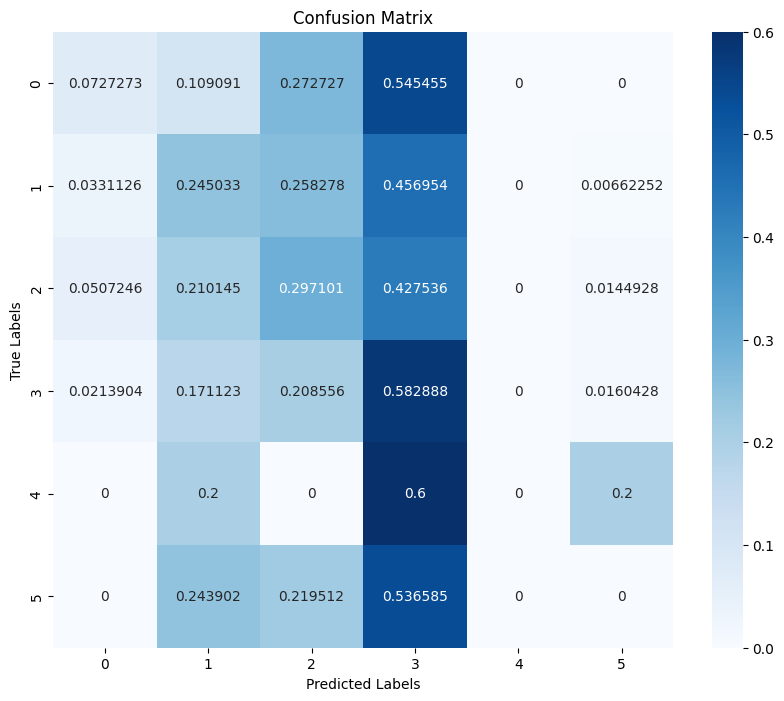

Epoch 19, Validation Loss: 3.7287, Accuracy: 0.3310, F1 Score: 0.3003
Val F1 Score Per Class  [0.10666667 0.27819549 0.29181495 0.45511482 0.         0.        ]


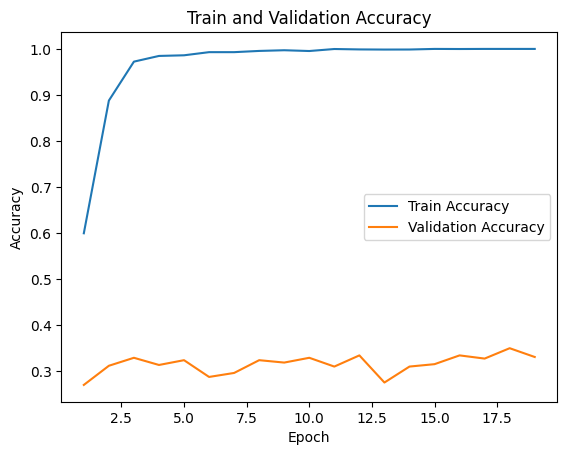

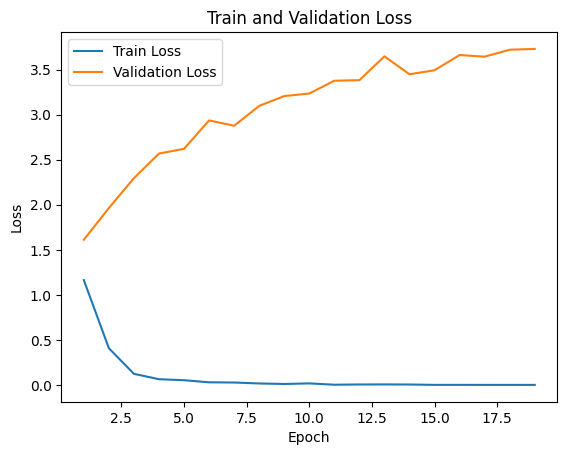

Epoch 20, Train Loss: 0.0007, Accuracy: 1.0000, F1 Score: 1.0000
Train F1 Score Per Class  [1. 1. 1. 1. 1. 1.]


Val:   1%|▏         | 1/73 [00:00<00:33,  2.15it/s, loss=4.71]

[tensor([-4.1152,  2.4316, -2.9345,  3.4299, -3.7234, -3.6448], device='cuda:0'), tensor([-2.8975,  3.6604, -0.9043, -1.0893, -5.5206, -5.1085], device='cuda:0'), tensor([-1.7338, -1.7962, -2.4395,  5.9358, -4.8127, -3.1427], device='cuda:0'), tensor([-2.4533, -1.2288, -2.9332,  5.8450, -4.1153, -2.7103], device='cuda:0'), tensor([-4.3220e+00,  1.8319e+00, -4.6518e-03,  1.3863e+00, -5.1306e+00,
        -3.4029e+00], device='cuda:0'), tensor([-4.3102,  0.5767,  2.6588, -0.7251, -3.8080, -3.8323], device='cuda:0'), tensor([-2.9499, -2.1609, -2.1442,  4.9865, -4.0434, -0.5978], device='cuda:0'), tensor([-2.9182, -2.9599,  4.3819,  2.1506, -3.1600, -2.4795], device='cuda:0')]


Val:   3%|▎         | 2/73 [00:00<00:33,  2.11it/s, loss=4.28]

[tensor([-2.5253, -1.3918, -2.8350,  4.4305, -4.8095, -3.0504], device='cuda:0'), tensor([-4.2516,  3.2130, -2.4606, -0.9611, -2.9488, -2.6116], device='cuda:0'), tensor([-0.6074, -2.0266,  1.8047,  0.2935, -4.3103, -4.1298], device='cuda:0'), tensor([-2.0963, -1.6298, -1.1420,  6.1016, -3.7841, -3.2841], device='cuda:0'), tensor([-1.4574,  6.8851, -1.6698, -1.5780, -3.2250, -3.0151], device='cuda:0'), tensor([-1.6485,  0.6814, -1.3768,  1.2298, -4.8183, -5.1645], device='cuda:0'), tensor([-1.7432, -2.0236, -2.4833,  4.1938, -4.0025, -3.5453], device='cuda:0'), tensor([ 5.4745, -0.1418, -3.1433,  0.2124, -3.6716, -2.9910], device='cuda:0')]


Val:   4%|▍         | 3/73 [00:01<00:32,  2.13it/s, loss=4.56]

[tensor([-3.4511, -1.5196,  0.7672, -1.3586, -4.9736, -4.0832], device='cuda:0'), tensor([-2.6127,  1.4955,  0.4279, -1.6158, -3.4558, -3.2441], device='cuda:0'), tensor([-3.1608, -2.3524,  4.9087, -0.9930, -3.7380, -2.7520], device='cuda:0'), tensor([-1.4113, -3.0571, -1.3456,  5.8585, -4.1340, -3.7744], device='cuda:0'), tensor([-2.1307, -0.0112, -2.9361,  4.4039, -4.0014, -4.1281], device='cuda:0'), tensor([-1.9157, -0.5847, -2.7040,  4.1996, -4.8048, -4.5243], device='cuda:0'), tensor([-2.1474, -2.6319, -2.1546,  5.3083, -4.2362, -3.8062], device='cuda:0'), tensor([-1.1697, -1.7513, -0.1004, -1.7613, -4.2802, -4.1398], device='cuda:0')]


Val:   5%|▌         | 4/73 [00:01<00:32,  2.15it/s, loss=3.41]

[tensor([-2.7945, -2.0142, -0.8508,  5.6635, -4.2476, -3.5396], device='cuda:0'), tensor([-4.5874,  0.6484, -0.5536, -0.9171, -4.6724, -2.8392], device='cuda:0'), tensor([-3.1326, -0.1373, -2.6364, -0.0362, -4.4300, -0.6920], device='cuda:0'), tensor([-2.8829, -1.2031,  0.9690, -0.4221, -3.4311, -3.1464], device='cuda:0'), tensor([ 6.1691, -2.4479, -0.7310,  0.1521, -3.2398, -3.7047], device='cuda:0'), tensor([-3.2796, -2.3511, -0.3285,  3.6507, -5.2276, -2.6594], device='cuda:0'), tensor([-1.6035,  6.3255, -1.5671, -1.6833, -3.8383, -3.2291], device='cuda:0'), tensor([-4.0302,  2.0615, -0.7774,  0.5508, -3.9205, -2.7179], device='cuda:0')]


Val:   7%|▋         | 5/73 [00:02<00:31,  2.14it/s, loss=4.03]

[tensor([-3.1583, -1.2739, -1.9319,  5.6994, -3.5366, -3.8990], device='cuda:0'), tensor([-3.0705, -2.6346,  1.9647,  3.7805, -4.2462, -4.3930], device='cuda:0'), tensor([-2.4911, -2.3800,  6.3493, -1.0620, -3.5378, -2.8417], device='cuda:0'), tensor([-3.0213, -0.5591, -2.2522,  2.0298, -4.5874, -4.9710], device='cuda:0'), tensor([-2.8646, -1.8117,  4.9492,  0.0957, -4.0460, -3.4744], device='cuda:0'), tensor([-2.9868,  0.2536, -0.9461,  1.2407, -5.1816, -4.1536], device='cuda:0'), tensor([-3.0775,  0.3926, -2.4011, -1.6535, -4.5081, -2.6239], device='cuda:0'), tensor([-1.6446, -0.4631, -3.1664,  4.9322, -3.9532, -2.6315], device='cuda:0')]


Val:   8%|▊         | 6/73 [00:02<00:31,  2.13it/s, loss=5.35]

[tensor([-2.1938, -2.1489,  7.1370, -1.2957, -2.8111, -2.7430], device='cuda:0'), tensor([-2.2029, -2.0712,  6.8692, -1.5998, -2.7686, -1.7206], device='cuda:0'), tensor([-2.1933, -2.4676,  4.1159, -1.2606, -4.5859, -4.3789], device='cuda:0'), tensor([-3.5129,  1.2418, -1.8660, -0.6039, -4.2686, -3.5370], device='cuda:0'), tensor([-1.9420, -2.0922,  6.9915, -1.6670, -2.8414, -2.2086], device='cuda:0'), tensor([-2.1709, -1.9473, -1.5366,  5.8672, -4.3022, -3.3900], device='cuda:0'), tensor([-2.2408, -3.9994,  0.7834,  3.3717, -4.4814, -3.8103], device='cuda:0'), tensor([-2.6093, -2.2678, -1.8295,  4.0065, -3.8205, -4.0566], device='cuda:0')]


Val:  10%|▉         | 7/73 [00:03<00:30,  2.13it/s, loss=2.78]

[tensor([-3.0203, -1.4309, -0.1483,  2.5135, -4.5438, -3.3748], device='cuda:0'), tensor([-2.9716, -0.2582, -0.1119,  0.2983, -4.5707, -3.3512], device='cuda:0'), tensor([-1.0669, -2.0121,  6.6781, -1.6868, -2.5206, -2.7280], device='cuda:0'), tensor([-3.3624, -2.5468, -0.8985,  4.7224, -4.8980, -3.7471], device='cuda:0'), tensor([-3.1880,  4.4408,  1.0320, -1.5063, -3.9031, -4.9921], device='cuda:0'), tensor([-3.4113, -1.3886, -1.3944,  4.4872, -4.5880, -2.4508], device='cuda:0'), tensor([-3.2095, -3.7094,  3.0098,  0.0855, -3.8639, -0.9412], device='cuda:0'), tensor([-3.6216, -0.5235, -2.4477,  0.9987, -4.6480, -3.3010], device='cuda:0')]


Val:  11%|█         | 8/73 [00:03<00:30,  2.12it/s, loss=5.98]

[tensor([-1.7890, -2.5344, -1.1433,  3.4214, -4.7074, -4.6029], device='cuda:0'), tensor([-2.1432, -2.8643,  3.0925, -0.4354, -3.3110, -3.0446], device='cuda:0'), tensor([-1.7232, -1.5803, -2.5668,  6.5417, -3.9405, -2.8988], device='cuda:0'), tensor([-1.6886,  6.5596, -1.9251, -1.0261, -3.3898, -3.5528], device='cuda:0'), tensor([-2.7153, -1.6259,  6.4020, -1.7027, -3.3544, -3.3591], device='cuda:0'), tensor([-1.8588, -1.7684, -1.4562,  3.5231, -4.8046, -5.6166], device='cuda:0'), tensor([-2.3693, -2.8803, -2.1028,  2.1151, -4.1526,  1.3757], device='cuda:0'), tensor([-2.3471, -2.1737,  6.7409, -0.9399, -2.7086, -2.1343], device='cuda:0')]


Val:  12%|█▏        | 9/73 [00:04<00:30,  2.13it/s, loss=5.65]

[tensor([-3.1500, -1.4191, -3.0144,  2.5729, -4.7375, -2.5210], device='cuda:0'), tensor([-3.1010,  3.3105, -1.1743,  0.0158, -5.2938, -4.8539], device='cuda:0'), tensor([-0.9918,  4.8646, -1.7020, -0.6517, -3.8631, -4.5635], device='cuda:0'), tensor([-1.9328, -2.9731,  0.6133,  1.2622, -3.5744, -3.8044], device='cuda:0'), tensor([-2.2481, -2.5460, -1.0114,  5.7293, -3.3801, -2.9270], device='cuda:0'), tensor([-3.3758,  5.9299, -0.5077, -0.8822, -4.1668, -3.5876], device='cuda:0'), tensor([-3.3636, -0.3779, -3.5718,  4.4576, -4.1175, -2.8551], device='cuda:0'), tensor([-2.7978, -2.6839, -0.3154,  4.2356, -4.8037, -3.3483], device='cuda:0')]


Val:  14%|█▎        | 10/73 [00:04<00:29,  2.13it/s, loss=3.55]

[tensor([-3.2406,  3.8786, -1.4256, -1.1596, -3.4000, -4.0318], device='cuda:0'), tensor([-3.1387, -2.1026,  0.7656,  3.0465, -4.1782, -4.0175], device='cuda:0'), tensor([-1.6133,  1.5559, -2.5093, -1.5620, -3.5301, -2.9802], device='cuda:0'), tensor([-2.9039, -1.9608,  0.2088,  4.1307, -4.2471, -4.7757], device='cuda:0'), tensor([-2.8124,  3.7134,  1.3297, -1.4185, -4.1241, -4.2083], device='cuda:0'), tensor([-1.3884, -1.7361, -0.4938,  4.5044, -4.8082, -5.1494], device='cuda:0'), tensor([-3.3421,  5.3387, -2.4751, -1.2590, -3.0389, -2.5024], device='cuda:0'), tensor([-2.7632,  5.3998, -1.9339,  0.4182, -4.4616, -4.2571], device='cuda:0')]


Val:  15%|█▌        | 11/73 [00:05<00:29,  2.13it/s, loss=5.51]

[tensor([-2.7672, -2.1821, -1.4448,  5.9815, -3.5481, -3.1808], device='cuda:0'), tensor([-1.2668,  3.3428, -3.4216, -0.2217, -4.4203, -3.3754], device='cuda:0'), tensor([-3.0555, -2.9845,  2.1164,  4.5021, -4.6569, -2.5898], device='cuda:0'), tensor([-2.4594, -2.2768, -1.5238,  5.8917, -4.7020, -3.8358], device='cuda:0'), tensor([-3.5386,  3.8738, -2.2556, -0.6200, -4.8588, -2.4176], device='cuda:0'), tensor([-3.0645, -0.7109, -3.4631,  3.2737, -4.2093, -3.1282], device='cuda:0'), tensor([-4.2530, -1.5889,  0.3932, -0.1517, -4.0575, -3.6059], device='cuda:0'), tensor([-1.7942, -2.0350, -2.2351,  6.2637, -3.6184, -3.9523], device='cuda:0')]


Val:  16%|█▋        | 12/73 [00:05<00:28,  2.11it/s, loss=2.85]

[tensor([-2.8120, -2.5581,  5.8672, -1.0320, -3.1575, -3.1966], device='cuda:0'), tensor([-4.3345,  0.7971,  0.4617,  1.4361, -4.6913, -4.2227], device='cuda:0'), tensor([-3.4838, -1.3779,  1.6850,  2.0308, -3.9792, -4.6933], device='cuda:0'), tensor([-2.9431,  2.8446, -2.4279, -0.2300, -3.7150, -3.7636], device='cuda:0'), tensor([-1.1150, -0.9927, -2.0370, -1.0806, -4.3487, -5.5348], device='cuda:0'), tensor([-2.1403, -2.3583,  6.9323, -0.7116, -3.0815, -2.5981], device='cuda:0'), tensor([-1.9051, -1.3718, -2.8772,  5.7840, -4.3212, -3.1111], device='cuda:0'), tensor([-2.1798, -1.2636,  2.0991, -0.8643, -4.7804, -4.5252], device='cuda:0')]


Val:  18%|█▊        | 13/73 [00:06<00:28,  2.11it/s, loss=2.61]

[tensor([-2.2111, -2.2088, -1.3102,  2.0511, -5.2021, -5.1989], device='cuda:0'), tensor([-3.9723,  1.9252,  0.4058,  2.4213, -4.1490, -3.7141], device='cuda:0'), tensor([-3.7738,  0.5180, -1.2420,  0.6147, -5.4294, -4.6808], device='cuda:0'), tensor([-3.3025,  1.4882,  2.9143, -2.4785, -4.1145, -3.4343], device='cuda:0'), tensor([-3.6913,  3.9316, -2.3130, -0.2346, -3.9700, -2.3733], device='cuda:0'), tensor([-2.9041, -1.8747, -0.6302, -0.8312, -4.1476, -3.0268], device='cuda:0'), tensor([-3.4537,  4.0444, -2.6082,  2.9463, -4.4865, -4.0496], device='cuda:0'), tensor([-1.6515,  0.8862, -2.7103,  3.0317, -4.6114, -5.1994], device='cuda:0')]


Val:  19%|█▉        | 14/73 [00:06<00:27,  2.11it/s, loss=2.71]

[tensor([-2.1211, -2.6293, -2.3813,  1.2127, -5.0823, -2.4795], device='cuda:0'), tensor([-3.5936, -0.8172, -2.2178,  2.3856, -4.7133, -3.9347], device='cuda:0'), tensor([-3.6146, -2.9615, -0.8349,  1.5413, -3.7967, -0.9463], device='cuda:0'), tensor([-2.7022, -0.5281, -2.2323,  2.8111, -5.1807, -3.9202], device='cuda:0'), tensor([-2.8270, -1.5291, -2.2720,  6.5476, -3.1033, -2.0269], device='cuda:0'), tensor([-3.1995,  1.2410, -2.2809,  3.1025, -4.1208, -3.7786], device='cuda:0'), tensor([-3.3819,  2.4813, -1.3980, -2.2562, -3.6951, -2.9524], device='cuda:0'), tensor([-2.8763, -0.6957, -2.0760,  4.4609, -4.7419, -3.9702], device='cuda:0')]


Val:  21%|██        | 15/73 [00:07<00:27,  2.12it/s, loss=4.48]

[tensor([-3.5552,  2.6793, -1.6071,  0.7449, -5.0198, -4.3324], device='cuda:0'), tensor([-2.6660,  3.3720, -0.2061, -1.3990, -5.0017, -4.6747], device='cuda:0'), tensor([-2.3525, -1.4002,  6.8707, -1.7736, -2.7330, -2.0378], device='cuda:0'), tensor([-2.0121, -2.2279, -1.5441,  6.6177, -3.8256, -3.2913], device='cuda:0'), tensor([-2.2872, -1.5944, -1.9712,  6.4510, -3.6038, -3.8857], device='cuda:0'), tensor([-3.0099,  1.0375, -0.1736, -1.9894, -4.3887, -4.6283], device='cuda:0'), tensor([-4.3296, -1.9251,  1.0929,  2.1277, -5.1385, -3.2033], device='cuda:0'), tensor([-3.9513, -1.5698,  2.8978,  0.6238, -4.9124, -5.8897], device='cuda:0')]


Val:  22%|██▏       | 16/73 [00:07<00:26,  2.12it/s, loss=3.63]

[tensor([-2.0718, -1.6455, -1.9782,  6.6390, -3.9716, -3.1623], device='cuda:0'), tensor([-2.2947,  5.6925, -0.6917, -1.5981, -4.2164, -3.8182], device='cuda:0'), tensor([-2.4483, -1.4425, -1.9559,  5.0495, -4.4818, -4.7836], device='cuda:0'), tensor([-3.7084, -0.7759, -0.6634,  2.4018, -4.4811, -2.9303], device='cuda:0'), tensor([-2.3687, -2.6634, -1.4197,  3.3216, -3.7451, -3.5842], device='cuda:0'), tensor([-3.4289, -1.7208,  5.9260, -0.7661, -3.4091, -2.8140], device='cuda:0'), tensor([-2.7163, -1.9827, -1.7796,  6.2736, -5.0099, -3.8435], device='cuda:0'), tensor([-3.3225, -1.9972, -1.2706, -0.7100, -3.7759, -3.0669], device='cuda:0')]


Val:  23%|██▎       | 17/73 [00:08<00:26,  2.12it/s, loss=4.51]

[tensor([-3.4735, -1.7839, -0.5722,  5.1424, -4.6607, -4.2323], device='cuda:0'), tensor([-1.3847,  1.1239,  1.4332, -1.6590, -4.3034, -3.4644], device='cuda:0'), tensor([-2.6800,  4.3233, -0.3575, -3.1277, -3.3025, -3.0263], device='cuda:0'), tensor([-3.5073,  0.2110, -1.2333,  1.1974, -5.0113, -4.1654], device='cuda:0'), tensor([-3.0187, -2.8885, -0.7252,  5.5521, -3.2457, -1.5547], device='cuda:0'), tensor([-2.4555, -2.2419, -1.7004,  5.2030, -4.4364, -3.3919], device='cuda:0'), tensor([ 0.9004, -2.7982, -1.3094, -0.0776, -4.4746, -3.2378], device='cuda:0'), tensor([-2.2826, -1.0892, -3.6120,  2.9586, -3.4956, -3.0874], device='cuda:0')]


Val:  25%|██▍       | 18/73 [00:08<00:25,  2.12it/s, loss=2.39]

[tensor([-2.4822, -2.8212, -0.9363,  5.7393, -4.0208, -3.6489], device='cuda:0'), tensor([-1.4983, -2.3628, -1.2823,  5.4133, -3.4835, -4.4058], device='cuda:0'), tensor([-4.2185, -1.0980,  1.8697, -1.2697, -4.5461, -1.2073], device='cuda:0'), tensor([-3.0069,  0.8798, -0.7316,  0.0555, -4.3731, -4.7987], device='cuda:0'), tensor([-2.7442, -3.1591,  2.8550, -0.4609, -2.7291, -3.9954], device='cuda:0'), tensor([-1.8211, -2.5093, -1.6129,  3.1497, -4.7715, -2.7126], device='cuda:0'), tensor([-1.9623,  1.9852, -0.4493, -0.6808, -5.1142, -4.6373], device='cuda:0'), tensor([-2.8580, -1.7074, -1.4781,  4.6339, -4.1279, -4.3020], device='cuda:0')]


Val:  26%|██▌       | 19/73 [00:08<00:25,  2.12it/s, loss=2.27]

[tensor([-3.1024, -1.7159,  1.9664, -1.2950, -4.5661, -5.1652], device='cuda:0'), tensor([ 4.2882, -1.8881, -2.5767,  0.2216, -4.4786, -4.2874], device='cuda:0'), tensor([-2.2757, -1.8918,  6.4600, -0.4760, -2.9903, -3.1792], device='cuda:0'), tensor([-2.4659, -2.2621, -1.1909,  6.2463, -3.3975, -3.0506], device='cuda:0'), tensor([-1.4288,  4.9501, -2.9300, -0.0823, -5.2577, -4.4781], device='cuda:0'), tensor([-1.4332, -1.8437, -2.5346,  5.9506, -3.9568, -3.8095], device='cuda:0'), tensor([-2.9645,  1.7247, -1.5488,  0.1088, -4.8533, -2.9971], device='cuda:0'), tensor([-2.1662,  0.4857,  0.9629, -1.1142, -4.2217, -3.9917], device='cuda:0')]


Val:  27%|██▋       | 20/73 [00:09<00:24,  2.13it/s, loss=5.91]

[tensor([-2.7456, -2.7413,  0.5492,  4.2521, -4.2622, -4.1670], device='cuda:0'), tensor([-3.4124,  3.9602, -1.4286, -2.1980, -2.8482, -2.9649], device='cuda:0'), tensor([-2.6383, -2.2056, -0.3182,  4.4550, -3.7657, -2.5781], device='cuda:0'), tensor([-2.2942, -3.4987,  1.0927,  1.6102, -4.4237, -3.2639], device='cuda:0'), tensor([ 0.7632, -1.7647, -0.2339, -1.5270, -5.3881, -4.4162], device='cuda:0'), tensor([-3.4133,  3.8920, -1.4470, -0.1397, -3.9415, -2.5796], device='cuda:0'), tensor([-2.7169, -2.6872,  0.1905,  3.5924, -4.5214, -4.2366], device='cuda:0'), tensor([-2.5335, -1.9755,  5.3689, -0.6268, -3.7383, -3.7349], device='cuda:0')]


Val:  29%|██▉       | 21/73 [00:09<00:24,  2.10it/s, loss=5.18]

[tensor([-1.4604, -3.4662,  4.2399, -0.6621, -3.5765, -2.6756], device='cuda:0'), tensor([-2.0771,  5.7627, -2.4907, -0.4773, -4.0776, -3.7660], device='cuda:0'), tensor([-3.3754,  3.4062,  1.8687, -2.3893, -4.1617, -3.1797], device='cuda:0'), tensor([-2.6659, -2.9893,  5.4714,  0.4292, -3.4824, -3.6031], device='cuda:0'), tensor([-3.1080, -2.0388,  2.4379,  2.0599, -5.0582, -4.9333], device='cuda:0'), tensor([-2.1629, -0.4169, -1.7071, -1.0468, -5.4300, -3.5428], device='cuda:0'), tensor([-2.0075, -2.2694, -1.5564,  6.6322, -3.0921, -2.8529], device='cuda:0'), tensor([-2.3759, -1.8382, -1.5398,  5.8160, -2.7771, -2.1016], device='cuda:0')]


Val:  30%|███       | 22/73 [00:10<00:24,  2.10it/s, loss=2.26]

[tensor([-2.6896, -0.0951, -2.0038,  5.6730, -4.6022, -4.3643], device='cuda:0'), tensor([-2.9346, -2.1442, -0.0834,  0.0732, -3.5757, -3.5714], device='cuda:0'), tensor([-4.0450, -2.0001, -1.0247,  2.6102, -4.1966, -3.8723], device='cuda:0'), tensor([-3.0235, -1.4749, -2.3282,  5.9360, -2.9012, -1.6004], device='cuda:0'), tensor([-2.7179, -2.2816,  3.0313,  1.4996, -4.2858, -4.6349], device='cuda:0'), tensor([-1.8182, -3.0468,  0.2737,  4.9386, -3.8157, -4.2071], device='cuda:0'), tensor([-3.0975, -0.3528, -1.8608,  1.0356, -4.7538, -3.7720], device='cuda:0'), tensor([-3.6825, -2.4075,  1.9236,  3.4035, -4.1328, -3.8323], device='cuda:0')]


Val:  32%|███▏      | 23/73 [00:10<00:23,  2.11it/s, loss=2.64]

[tensor([-2.5970, -1.1433,  0.2043,  1.8211, -4.8384, -4.6442], device='cuda:0'), tensor([-2.3488, -1.5071, -2.4092,  6.1834, -4.0373, -3.1088], device='cuda:0'), tensor([-2.0181, -1.4349, -2.4120,  6.1987, -3.0402, -3.4658], device='cuda:0'), tensor([-3.4726,  3.4609, -2.0515, -0.8956, -5.2923, -3.5758], device='cuda:0'), tensor([-3.1169,  1.5239, -1.7846,  2.7084, -4.7613, -4.0268], device='cuda:0'), tensor([-1.7308, -1.8022, -2.1574,  6.6973, -2.9729, -2.7951], device='cuda:0'), tensor([-2.0965, -3.2006,  0.2933,  4.6235, -3.8702, -4.2697], device='cuda:0'), tensor([-2.9806, -2.5691,  6.4120, -1.4128, -3.2875, -3.2451], device='cuda:0')]


Val:  33%|███▎      | 24/73 [00:11<00:23,  2.12it/s, loss=3.99]

[tensor([-2.0403, -1.3091, -3.2647,  3.0552, -3.5010, -2.7250], device='cuda:0'), tensor([-2.4219, -1.8841, -1.5188,  4.9137, -4.8689, -3.8652], device='cuda:0'), tensor([-2.2152, -2.6447, -0.8320,  5.6690, -3.9675, -3.9004], device='cuda:0'), tensor([-1.0319, -2.1916,  4.5256, -1.8264, -3.5147, -4.7658], device='cuda:0'), tensor([-3.5628,  1.6405,  4.2853, -1.7947, -3.8172, -4.5314], device='cuda:0'), tensor([-2.6547, -2.7009,  4.9620,  1.3652, -3.6722, -4.4618], device='cuda:0'), tensor([-2.9633, -1.4775, -2.6726,  5.8101, -2.8593, -1.4042], device='cuda:0'), tensor([-2.1784,  2.6912, -3.0035,  0.7961, -5.7701, -3.0079], device='cuda:0')]


Val:  34%|███▍      | 25/73 [00:11<00:22,  2.13it/s, loss=4.79]

[tensor([-2.9691,  0.2263, -0.7361,  4.5491, -5.3141, -3.1285], device='cuda:0'), tensor([-2.3729,  1.6259, -2.9134,  4.3482, -4.8419, -3.3812], device='cuda:0'), tensor([-3.0647,  4.3793,  0.2275, -1.3232, -4.0688, -4.0104], device='cuda:0'), tensor([-2.3062, -2.1665,  5.5869, -1.1068, -2.8565, -3.6890], device='cuda:0'), tensor([-2.3460,  0.2558, -1.0062,  1.1198, -5.4614, -5.1513], device='cuda:0'), tensor([-1.9456,  5.7180, -1.3904, -2.4085, -3.3629, -2.8102], device='cuda:0'), tensor([-4.1703,  3.1732, -2.4036, -1.5981, -6.0367, -2.7256], device='cuda:0'), tensor([-2.9592,  4.6733, -3.4768,  0.2026, -4.2118, -1.4994], device='cuda:0')]


Val:  36%|███▌      | 26/73 [00:12<00:22,  2.13it/s, loss=3.62]

[tensor([-1.8151,  5.2122, -3.2580, -0.7775, -3.8372, -1.5966], device='cuda:0'), tensor([-2.8768, -0.7233,  0.3319, -2.4661, -4.1889, -2.5697], device='cuda:0'), tensor([-3.7806,  2.4140,  0.2488, -0.0170, -5.0229, -4.5540], device='cuda:0'), tensor([-2.4660, -1.8842,  2.1768, -2.2019, -4.5360, -5.5574], device='cuda:0'), tensor([-2.1405,  3.5409, -2.8520,  0.4364, -4.6466, -4.4185], device='cuda:0'), tensor([-2.7982, -1.5436, -1.6135,  5.5266, -3.1217, -2.7451], device='cuda:0'), tensor([-0.3283, -3.0441,  0.3764,  0.7183, -4.1878, -3.8325], device='cuda:0'), tensor([-1.2007, -3.5983,  1.0092,  2.4617, -3.7503, -3.2989], device='cuda:0')]


Val:  37%|███▋      | 27/73 [00:12<00:21,  2.13it/s, loss=4.06]

[tensor([-3.1501, -0.2013, -3.2113,  4.5822, -3.8511, -1.3937], device='cuda:0'), tensor([-1.9469,  5.9131,  0.1763, -1.8030, -3.4704, -4.1389], device='cuda:0'), tensor([-2.5256, -2.4538, -1.7882,  1.1927, -4.4639, -2.5432], device='cuda:0'), tensor([-2.9212, -1.6608, -1.3821,  4.7508, -3.5603, -3.1930], device='cuda:0'), tensor([-1.8835, -2.0157, -1.9663,  3.2182, -3.8065, -3.0310], device='cuda:0'), tensor([-3.9528,  1.4563, -0.2561,  3.0599, -4.7582, -5.3455], device='cuda:0'), tensor([-3.2395, -2.5536,  3.7183,  0.4573, -3.7014, -3.9366], device='cuda:0'), tensor([-2.8168,  4.8638, -2.5730, -0.0135, -4.1379, -3.5636], device='cuda:0')]


Val:  38%|███▊      | 28/73 [00:13<00:21,  2.12it/s, loss=4.31]

[tensor([-1.5610, -1.8910,  6.1209, -1.2382, -3.0025, -3.1189], device='cuda:0'), tensor([-2.4622, -2.7841,  3.8401,  1.2101, -3.7442, -3.5214], device='cuda:0'), tensor([-2.0799, -2.4163, -0.7113,  3.4097, -5.0548, -4.5366], device='cuda:0'), tensor([-1.8919, -2.7038,  4.6538, -0.3141, -3.7088, -2.9064], device='cuda:0'), tensor([-2.4804, -1.4357,  6.1993, -1.1663, -3.3132, -3.3907], device='cuda:0'), tensor([-2.5207,  4.8780, -1.3874, -0.7276, -4.0303, -3.8712], device='cuda:0'), tensor([-2.4238, -2.9726,  2.3721,  2.1581, -4.1682, -2.2927], device='cuda:0'), tensor([-1.4582, -2.2276,  6.4902, -0.9127, -3.2596, -3.0091], device='cuda:0')]


Val:  40%|███▉      | 29/73 [00:13<00:20,  2.12it/s, loss=5.1]

[tensor([ 5.6189, -1.6877, -1.3764, -1.3841, -3.2953, -1.7806], device='cuda:0'), tensor([-4.0125, -1.3597,  2.9628, -1.4044, -4.4601, -4.0781], device='cuda:0'), tensor([-1.6018, -0.1854, -2.7795,  3.4943, -4.0166, -4.6833], device='cuda:0'), tensor([-1.8369, -0.9557,  2.3465, -0.1579, -3.4716, -2.7387], device='cuda:0'), tensor([-2.8482,  6.1652, -0.7728, -0.4629, -3.8001, -4.0205], device='cuda:0'), tensor([-2.3542, -2.0323,  6.6295, -1.3935, -2.8705, -1.8307], device='cuda:0'), tensor([-2.3214, -1.8816,  4.9529, -0.3764, -3.8944, -3.1732], device='cuda:0'), tensor([-3.5811,  4.5782, -0.8234, -0.3455, -3.6736, -3.6082], device='cuda:0')]


Val:  41%|████      | 30/73 [00:14<00:20,  2.12it/s, loss=5.17]

[tensor([-2.6264,  5.2837, -1.8575, -0.8131, -5.2864, -4.5974], device='cuda:0'), tensor([-2.3491, -3.1537,  2.0041,  4.0939, -3.6613, -3.4852], device='cuda:0'), tensor([-4.4546,  2.4994, -2.3993,  0.8161, -5.4372, -2.2813], device='cuda:0'), tensor([-3.2774, -1.6245, -2.2185,  3.5625, -3.5253, -1.6402], device='cuda:0'), tensor([-2.1611, -1.8089, -1.6008,  6.5151, -3.2149, -3.2962], device='cuda:0'), tensor([-1.6727, -2.2915,  3.6170, -0.8093, -4.1091, -4.6996], device='cuda:0'), tensor([-0.4008, -2.6065,  4.0086, -1.0762, -2.6917, -2.3843], device='cuda:0'), tensor([ 3.8627, -1.9708, -2.6981,  0.9151, -3.7780, -2.6598], device='cuda:0')]


Val:  42%|████▏     | 31/73 [00:14<00:19,  2.12it/s, loss=3.23]

[tensor([-2.6583, -2.7752, -0.2823,  5.7735, -3.3957, -2.6919], device='cuda:0'), tensor([-1.1798, -2.3888, -2.5702,  3.3016, -5.5135, -4.3574], device='cuda:0'), tensor([-3.5437, -2.0471,  3.7530,  2.3191, -5.6592, -3.3008], device='cuda:0'), tensor([-1.0274, -3.0616,  1.6341,  1.2224, -5.1745, -4.6989], device='cuda:0'), tensor([ 0.1037, -2.3500,  1.0858, -1.0072, -5.0471, -5.4904], device='cuda:0'), tensor([-2.6987, -0.6239, -2.1791, -1.5318, -3.3860, -0.5959], device='cuda:0'), tensor([-0.6001,  5.3444, -3.0284, -1.5368, -3.7496, -3.6154], device='cuda:0'), tensor([-2.9352, -0.5675, -2.1203,  5.3203, -4.3771, -5.2118], device='cuda:0')]


Val:  44%|████▍     | 32/73 [00:15<00:19,  2.13it/s, loss=3.81]

[tensor([-3.4957,  1.5771,  2.0222, -2.4134, -4.0046, -1.1713], device='cuda:0'), tensor([-0.9140, -2.4234, -0.1907,  2.8468, -4.5113, -5.1298], device='cuda:0'), tensor([-2.6329, -1.8414, -0.9169,  3.5522, -5.3005, -5.7098], device='cuda:0'), tensor([-3.1436, -2.4561,  1.9495,  1.2338, -4.3363, -3.6389], device='cuda:0'), tensor([-3.2279, -1.1981,  5.6551, -1.4927, -3.3277, -3.5053], device='cuda:0'), tensor([-2.4602,  6.8282, -1.0843, -1.8400, -3.3000, -2.3702], device='cuda:0'), tensor([-2.0434, -1.4930, -1.3217, -1.0326, -2.4189,  8.3498], device='cuda:0'), tensor([-3.3724, -2.2552, -0.9919,  2.2926, -3.5762, -4.5107], device='cuda:0')]


Val:  45%|████▌     | 33/73 [00:15<00:18,  2.14it/s, loss=4.47]

[tensor([-3.2892, -1.1609,  0.1925,  2.9960, -5.3088, -4.5820], device='cuda:0'), tensor([-2.3944,  1.6042, -2.4786,  1.1116, -3.7097, -4.4026], device='cuda:0'), tensor([-3.3163, -1.9155,  1.3234, -1.5994, -4.5872, -4.4741], device='cuda:0'), tensor([-3.7480,  1.6553, -3.2823,  0.0915, -3.4644,  1.9968], device='cuda:0'), tensor([-2.2990, -1.9002, -2.2476,  5.5677, -3.4031, -3.8861], device='cuda:0'), tensor([-4.2584, -1.3065, -1.5080,  3.3032, -3.9235, -4.2402], device='cuda:0'), tensor([-2.8839, -1.6597, -1.0245,  5.2106, -4.5747, -4.1699], device='cuda:0'), tensor([ 2.1949, -2.8336, -2.4684,  3.5171, -3.4004, -3.3431], device='cuda:0')]


Val:  47%|████▋     | 34/73 [00:15<00:18,  2.15it/s, loss=3.34]

[tensor([-3.3881, -0.5705,  4.2807, -0.1869, -5.4622, -4.4287], device='cuda:0'), tensor([-2.7900, -2.3377, -0.0752,  0.3913, -3.8542, -4.0703], device='cuda:0'), tensor([-2.0576, -1.3040,  6.8977, -1.8709, -2.6212, -2.8715], device='cuda:0'), tensor([ 0.3906, -3.2281,  2.6678, -0.6767, -4.7051, -3.7077], device='cuda:0'), tensor([-2.2392, -0.6363, -2.6217,  5.7384, -4.1648, -3.2911], device='cuda:0'), tensor([-2.5905, -2.1176,  6.8856, -1.0313, -2.8081, -2.4806], device='cuda:0'), tensor([ 3.0189, -2.6688, -2.0817,  0.6000, -3.7891, -3.3136], device='cuda:0'), tensor([-2.8796,  0.6670, -1.6488,  1.1843, -5.0138, -4.9037], device='cuda:0')]


Val:  48%|████▊     | 35/73 [00:16<00:17,  2.13it/s, loss=3.32]

[tensor([-1.6729, -1.8049, -1.8270,  6.1913, -3.6125, -4.3007], device='cuda:0'), tensor([-2.9048, -1.0298,  1.3615, -2.4102, -3.4710, -0.3635], device='cuda:0'), tensor([-1.9452, -1.6412, -2.9124,  4.9202, -4.6940, -3.7126], device='cuda:0'), tensor([ 0.8894, -2.9813, -0.4210, -1.1386, -4.2907, -3.4305], device='cuda:0'), tensor([-2.3609, -0.5422,  0.5330, -1.5768, -3.3203, -2.6722], device='cuda:0'), tensor([-2.6514, -1.8294, -1.8886,  6.0655, -3.6410, -2.3507], device='cuda:0'), tensor([-2.0267, -2.6070, -1.4833,  4.3680, -4.3680, -3.4697], device='cuda:0'), tensor([-3.7032,  4.8584, -2.1045, -0.9073, -4.1745, -1.0464], device='cuda:0')]


Val:  49%|████▉     | 36/73 [00:16<00:17,  2.11it/s, loss=1.98]

[tensor([-2.6781, -1.2861, -2.2747,  1.3663, -4.4980, -3.7952], device='cuda:0'), tensor([ 0.2446, -3.0734, -1.6924,  1.3714, -4.6093, -3.7727], device='cuda:0'), tensor([-3.8607, -1.2630, -2.5634,  3.0273, -3.0798, -3.6332], device='cuda:0'), tensor([-3.4229,  0.3256, -0.9754,  1.0674, -4.5362, -4.5137], device='cuda:0'), tensor([-1.9003, -3.0732,  1.9925,  3.2862, -4.2071, -4.9126], device='cuda:0'), tensor([-3.2665,  2.5947,  1.4884, -1.9410, -3.3360, -4.6738], device='cuda:0'), tensor([-3.0182,  1.5582, -1.0267, -1.5440, -5.1336, -3.8292], device='cuda:0'), tensor([-4.0265,  1.7138, -0.7019, -1.2962, -3.9079, -4.4852], device='cuda:0')]


Val:  51%|█████     | 37/73 [00:17<00:16,  2.12it/s, loss=5.26]

[tensor([-2.0254, -1.7689, -1.8665,  6.1936, -4.2589, -4.0323], device='cuda:0'), tensor([-3.0693,  5.6646, -2.4733,  0.3807, -3.2051, -3.3328], device='cuda:0'), tensor([-2.5056, -0.9475, -2.7464,  5.7572, -5.2324, -2.6038], device='cuda:0'), tensor([-2.4694, -0.5713,  6.7223, -1.8575, -3.2869, -3.4807], device='cuda:0'), tensor([-3.6591, -0.1415, -1.6034, -1.2380, -4.1705, -3.0376], device='cuda:0'), tensor([-2.6314,  1.6647, -1.2748, -1.6386, -3.5586, -3.2872], device='cuda:0'), tensor([-2.6266,  6.0008, -0.4302, -1.7908, -4.1925, -4.0620], device='cuda:0'), tensor([-3.4877, -1.3982, -1.8977,  4.4462, -4.3216, -3.0777], device='cuda:0')]


Val:  52%|█████▏    | 38/73 [00:17<00:16,  2.14it/s, loss=5.36]

[tensor([-3.1867, -1.1887, -3.0930,  5.2617, -3.9575, -2.0138], device='cuda:0'), tensor([-2.6694, -2.0379,  4.2344,  0.6628, -2.6163, -3.1524], device='cuda:0'), tensor([-2.8794, -0.7359, -1.4683,  5.7420, -3.8111, -4.5086], device='cuda:0'), tensor([-2.4624, -1.7407,  5.5531, -1.8587, -3.9683, -3.6476], device='cuda:0'), tensor([-2.2569, -1.9989,  6.5573, -1.4960, -3.0900, -1.3558], device='cuda:0'), tensor([-1.5477, -2.8806,  0.8463,  1.7384, -3.9476, -4.1347], device='cuda:0'), tensor([-2.7181,  5.8752, -2.1589, -1.5129, -2.8827, -2.4776], device='cuda:0'), tensor([-2.3331,  3.3397, -1.0889, -1.0145, -4.4749, -4.9638], device='cuda:0')]


Val:  53%|█████▎    | 39/73 [00:18<00:15,  2.14it/s, loss=4.61]

[tensor([-2.1754,  2.2909,  1.3017, -1.3571, -4.6858, -4.5116], device='cuda:0'), tensor([-2.4672, -1.3457, -2.8387,  5.1565, -2.2933, -1.0157], device='cuda:0'), tensor([ 1.7131, -1.0276, -3.0549, -0.0456, -3.8175, -3.9827], device='cuda:0'), tensor([-3.0699,  2.4820, -2.0593,  2.0865, -4.8076, -4.9698], device='cuda:0'), tensor([-1.9438, -0.2264, -2.5197,  2.9334, -4.6927, -4.9153], device='cuda:0'), tensor([-1.9878, -3.4036,  3.4430, -0.8457, -4.0382, -3.7529], device='cuda:0'), tensor([-2.6181, -0.9060, -2.1622,  4.4067, -3.5884, -5.2595], device='cuda:0'), tensor([-2.8404, -2.3990,  6.1724, -0.0145, -3.3253, -2.9391], device='cuda:0')]


Val:  55%|█████▍    | 40/73 [00:18<00:15,  2.14it/s, loss=3.15]

[tensor([-4.1050,  2.4021, -0.6851,  0.8260, -5.0246, -5.2075], device='cuda:0'), tensor([-3.2434, -2.0181, -1.7364,  4.7381, -4.2376, -3.1069], device='cuda:0'), tensor([-3.9403,  0.1943, -1.8778,  1.0706, -3.9596, -4.1663], device='cuda:0'), tensor([-1.6254, -2.1618,  7.0931, -1.9628, -2.4262, -2.1890], device='cuda:0'), tensor([-1.9147,  1.4027, -2.8086,  2.0312, -3.0474, -4.6525], device='cuda:0'), tensor([-3.3659, -2.9861,  2.3823, -1.8169, -4.2223, -2.3094], device='cuda:0'), tensor([-2.8974, -2.6020,  0.0463,  2.1556, -5.0837, -3.4447], device='cuda:0'), tensor([-1.4230, -2.7969,  0.8052,  0.9566, -2.5622, -4.1434], device='cuda:0')]


Val:  56%|█████▌    | 41/73 [00:19<00:15,  2.13it/s, loss=3.73]

[tensor([-1.9480, -1.8727, -1.8450,  6.7503, -2.9875, -3.0428], device='cuda:0'), tensor([-1.9480, -1.9229, -2.3824,  6.6529, -3.8824, -2.5766], device='cuda:0'), tensor([-2.9037, -1.5045, -1.7112,  5.2607, -4.5237, -3.4904], device='cuda:0'), tensor([-1.4880, -1.4304, -3.6076,  4.9237, -3.7676, -2.5845], device='cuda:0'), tensor([-2.9718,  0.6117,  0.7817, -1.2356, -3.7152, -4.1635], device='cuda:0'), tensor([-2.9642, -1.8236,  6.3530, -0.7254, -3.0581, -3.0626], device='cuda:0'), tensor([-1.8491, -0.0723, -1.3798,  0.5705, -4.5848, -4.7334], device='cuda:0'), tensor([-1.3529, -2.2834,  6.1732, -0.5819, -3.3892, -3.2003], device='cuda:0')]


Val:  58%|█████▊    | 42/73 [00:19<00:14,  2.13it/s, loss=3.96]

[tensor([-3.9495, -0.7466, -1.0325, -0.5642, -4.8222, -2.3080], device='cuda:0'), tensor([-1.4163, -1.7885, -3.0355,  5.4873, -3.7123, -3.9387], device='cuda:0'), tensor([ 7.5270, -1.8977, -1.3817, -1.1510, -2.4066, -1.4073], device='cuda:0'), tensor([-2.6608,  5.9077, -2.7433, -0.3222, -3.2484, -3.4305], device='cuda:0'), tensor([-2.1486, -1.2787, -3.3229,  5.8295, -4.4004, -2.8602], device='cuda:0'), tensor([-2.2278,  0.0603, -2.8905,  5.1830, -4.6872, -3.7348], device='cuda:0'), tensor([-0.7617, -0.6565, -2.2529,  4.5080, -4.9972, -5.1209], device='cuda:0'), tensor([-2.9955, -1.0798,  1.3877, -2.0210, -4.2106, -1.4668], device='cuda:0')]


Val:  59%|█████▉    | 43/73 [00:20<00:14,  2.13it/s, loss=3.84]

[tensor([-2.5741, -1.3324, -2.3683,  5.3720, -4.5790, -2.8823], device='cuda:0'), tensor([-3.4731, -2.3362, -1.6226,  1.5118, -3.2298, -2.3773], device='cuda:0'), tensor([-2.7738, -2.7323, -0.8512,  5.8720, -4.3988, -3.0877], device='cuda:0'), tensor([-1.8859, -2.0616, -1.4623,  6.5867, -3.9388, -3.0385], device='cuda:0'), tensor([-3.3569,  4.1443,  0.6631, -0.5745, -4.4487, -4.5096], device='cuda:0'), tensor([-2.4057, -1.9721, -2.9178,  3.9646, -5.9129, -3.6418], device='cuda:0'), tensor([-1.9553, -2.6881, -0.0935,  6.2287, -3.8973, -4.2118], device='cuda:0'), tensor([-1.3751, -2.4248, -1.6367,  5.9038, -3.8488, -4.1864], device='cuda:0')]


Val:  60%|██████    | 44/73 [00:20<00:13,  2.13it/s, loss=2.92]

[tensor([-1.0074, -1.7121, -0.8659,  2.4666, -4.2220, -5.1842], device='cuda:0'), tensor([-1.0886, -2.3384, -0.4668, -0.5902, -3.8612, -4.3517], device='cuda:0'), tensor([-3.7505, -2.0814, -1.5864,  3.7856, -4.6344, -3.4243], device='cuda:0'), tensor([-4.3260, -1.2752, -0.4983,  1.8762, -5.2205, -3.5577], device='cuda:0'), tensor([-2.5381, -2.6457,  0.8817,  1.2133, -3.4010, -2.6603], device='cuda:0'), tensor([-4.3381,  0.3807,  0.8403,  2.2822, -5.0310, -4.3850], device='cuda:0'), tensor([ 1.2274, -2.4093,  0.3854,  1.5897, -4.4187, -3.4078], device='cuda:0'), tensor([-2.3019,  4.3766, -2.8586, -0.8135, -3.4102, -1.8343], device='cuda:0')]


Val:  62%|██████▏   | 45/73 [00:21<00:13,  2.12it/s, loss=3.47]

[tensor([ 1.7462, -0.9101, -3.6754, -1.0656, -4.9105, -2.0404], device='cuda:0'), tensor([-2.9174,  0.6965, -3.0955,  2.9340, -3.1998, -3.2467], device='cuda:0'), tensor([-3.6299,  0.3802, -2.6521,  2.7461, -4.1219, -2.0094], device='cuda:0'), tensor([-2.8905, -1.5258, -0.7146, -0.8683, -3.6141, -3.1544], device='cuda:0'), tensor([-2.6759, -3.0287,  5.0253,  0.2331, -3.7132, -2.8240], device='cuda:0'), tensor([-1.9888, -1.8718, -2.1496, -1.1238, -2.4422,  7.9703], device='cuda:0'), tensor([-3.7361,  2.7513,  0.8066, -0.3141, -4.3972, -3.7409], device='cuda:0'), tensor([-3.2769, -1.7571, -1.9658,  4.3966, -4.1654, -2.4732], device='cuda:0')]


Val:  63%|██████▎   | 46/73 [00:21<00:12,  2.11it/s, loss=3.15]

[tensor([-3.1077, -0.5509,  4.6111, -1.9142, -4.1589, -4.0855], device='cuda:0'), tensor([-1.6406,  1.1910, -1.0651,  1.7467, -3.1906, -3.3640], device='cuda:0'), tensor([-3.3807, -1.2984, -1.0486,  4.2800, -4.1896, -4.9545], device='cuda:0'), tensor([-1.9603, -2.3888,  6.6506, -1.8927, -2.8303, -1.3307], device='cuda:0'), tensor([-3.5818, -0.9368, -2.4750,  4.7681, -3.4717, -2.4465], device='cuda:0'), tensor([-2.4762,  5.7409, -2.6865, -0.8344, -3.0397, -2.9706], device='cuda:0'), tensor([-2.4029, -0.2804,  0.8720,  0.6890, -4.8604, -4.4096], device='cuda:0'), tensor([-2.8291, -1.6482,  4.9054, -1.3676, -3.3995, -4.0419], device='cuda:0')]


Val:  64%|██████▍   | 47/73 [00:22<00:12,  2.10it/s, loss=3.21]

[tensor([ 5.3894, -2.0202, -3.6203,  0.3458, -3.0965, -2.7474], device='cuda:0'), tensor([-2.7767, -1.7437, -0.7314,  4.2506, -5.5993, -4.0776], device='cuda:0'), tensor([-3.6233, -2.0095,  0.6835,  1.2468, -3.8510, -3.8005], device='cuda:0'), tensor([-2.5763, -1.5764,  4.0700, -0.2420, -4.1512, -4.0550], device='cuda:0'), tensor([-2.4003,  1.5519,  2.3145,  0.7334, -5.0765, -5.3534], device='cuda:0'), tensor([-2.4106, -1.2696, -2.4798,  5.3148, -4.5895, -3.1197], device='cuda:0'), tensor([-1.8161, -1.7158, -1.8693,  1.5377, -2.3467, -3.8560], device='cuda:0'), tensor([-2.5650, -1.4277, -1.5923,  6.0405, -4.5025, -3.7950], device='cuda:0')]


Val:  66%|██████▌   | 48/73 [00:22<00:11,  2.09it/s, loss=3.09]

[tensor([-2.0153, -1.8923,  7.0299, -1.8869, -2.8383, -1.9131], device='cuda:0'), tensor([-3.3168,  0.8521, -1.9787,  1.9237, -5.0550, -4.6576], device='cuda:0'), tensor([-2.6758,  6.4769, -1.1301, -1.8494, -3.6484, -3.0569], device='cuda:0'), tensor([-2.3738,  3.7350, -2.2177,  0.7285, -4.7540, -4.6085], device='cuda:0'), tensor([-1.9483, -2.0282, -2.0080,  6.7116, -3.2958, -2.8656], device='cuda:0'), tensor([ 0.7073, -0.5437, -1.0803, -0.8122, -4.1475, -2.8669], device='cuda:0'), tensor([-2.6084, -2.1063,  0.8191,  2.2060, -5.2884, -4.8249], device='cuda:0'), tensor([-3.3750, -1.2428, -1.2778,  5.8631, -3.8048, -3.4905], device='cuda:0')]


Val:  67%|██████▋   | 49/73 [00:23<00:11,  2.09it/s, loss=3.88]

[tensor([-3.3717, -2.3432,  5.2769,  0.1502, -3.4138, -3.8082], device='cuda:0'), tensor([-1.0083,  1.5013, -2.5378,  1.1405, -4.2728, -4.8024], device='cuda:0'), tensor([-3.3969, -1.0855,  5.7529, -1.3011, -2.4472, -2.4092], device='cuda:0'), tensor([-2.4679, -2.2741,  5.1904, -0.4014, -3.4674, -2.8811], device='cuda:0'), tensor([-3.2096,  3.5262,  1.3538, -2.2419, -3.9090, -3.7604], device='cuda:0'), tensor([-0.5583, -3.2840,  0.2071, -0.0556, -3.8709, -4.4652], device='cuda:0'), tensor([-3.4241,  1.1662,  0.7956, -1.1297, -5.2090, -1.2493], device='cuda:0'), tensor([-2.8020, -2.5680, -1.2950,  6.0504, -3.5642, -2.7191], device='cuda:0')]


Val:  68%|██████▊   | 50/73 [00:23<00:10,  2.10it/s, loss=3.61]

[tensor([-1.0376, -1.6648, -1.6737,  0.5198, -5.4386, -3.8255], device='cuda:0'), tensor([-2.7963, -2.0100, -1.6775,  5.3288, -4.8799, -3.9410], device='cuda:0'), tensor([-3.7228, -0.0395,  2.9556,  1.6898, -3.8648, -3.4944], device='cuda:0'), tensor([-2.7671,  3.8814, -0.0336,  0.3540, -6.6291, -4.1499], device='cuda:0'), tensor([-2.5704, -1.8909,  5.0172, -1.4883, -4.6379, -3.9508], device='cuda:0'), tensor([-2.1170, -1.9677, -2.2075,  6.5267, -2.9500, -2.2510], device='cuda:0'), tensor([-2.6718, -1.9569, -0.9710,  6.2545, -3.7261, -2.3398], device='cuda:0'), tensor([-2.9458,  1.0541, -2.2890,  1.7945, -4.5154, -4.9213], device='cuda:0')]


Val:  70%|██████▉   | 51/73 [00:24<00:10,  2.10it/s, loss=2.49]

[tensor([-2.1320, -2.6355,  4.7039,  1.0478, -4.2019, -3.4946], device='cuda:0'), tensor([-2.0937, -2.1698, -2.0668,  6.6731, -3.5184, -2.3225], device='cuda:0'), tensor([-3.9979,  2.5417,  1.6896, -0.9166, -3.8365, -1.7827], device='cuda:0'), tensor([-2.3165, -1.5877, -1.8627,  6.4538, -3.5828, -3.7027], device='cuda:0'), tensor([-3.1920,  1.1287, -0.4321,  0.5454, -4.6559, -4.5794], device='cuda:0'), tensor([-0.8239,  0.0597, -4.3102,  4.6797, -4.6764, -2.8538], device='cuda:0'), tensor([-2.5114, -1.4512, -1.7695,  5.8591, -3.9267, -2.7120], device='cuda:0'), tensor([-0.9286,  0.8927, -2.1008, -2.9912, -4.0311,  3.2813], device='cuda:0')]


Val:  71%|███████   | 52/73 [00:24<00:09,  2.12it/s, loss=2.84]

[tensor([-3.9821, -0.6084, -0.4983,  2.1668, -5.2063, -2.1813], device='cuda:0'), tensor([-1.7325, -1.7525, -1.1946,  6.2576, -3.7809, -4.4004], device='cuda:0'), tensor([ 1.5884e-03, -7.0200e-01, -2.7734e+00,  1.6315e+00, -2.5846e+00,
        -4.7899e+00], device='cuda:0'), tensor([-2.6469,  1.2847, -3.0231,  1.4389, -4.4019, -3.2488], device='cuda:0'), tensor([-2.5167, -2.6049,  2.0319, -1.4174, -3.5034,  0.2155], device='cuda:0'), tensor([-2.7894,  5.4671, -2.8211, -1.1579, -3.1295, -3.3225], device='cuda:0'), tensor([ 2.1826, -3.1213,  3.1103, -1.2951, -3.7882, -2.9882], device='cuda:0'), tensor([-2.6332,  5.1466, -1.4020, -0.8094, -4.1754, -3.3546], device='cuda:0')]


Val:  73%|███████▎  | 53/73 [00:24<00:09,  2.11it/s, loss=3.85]

[tensor([-2.4052, -0.1857, -2.8598,  5.1809, -4.1958, -3.6247], device='cuda:0'), tensor([-1.8444, -2.8144, -0.5045,  2.5387, -4.3398, -4.4166], device='cuda:0'), tensor([-2.9755, -2.4483, -1.3559,  2.3950, -5.2483, -1.0517], device='cuda:0'), tensor([-1.4831, -1.0500, -1.7997,  2.5192, -5.0927, -5.0811], device='cuda:0'), tensor([ 4.1247, -1.5723,  0.1744, -2.2383, -3.6394, -2.6749], device='cuda:0'), tensor([-2.3858, -1.8011, -2.5534,  3.0763, -4.4537, -4.6944], device='cuda:0'), tensor([-1.8183, -2.0834, -0.0894,  5.2609, -4.7528, -4.5592], device='cuda:0'), tensor([-3.2291, -1.4760,  5.8006, -1.5504, -3.3201, -3.8400], device='cuda:0')]


Val:  74%|███████▍  | 54/73 [00:25<00:08,  2.12it/s, loss=3.34]

[tensor([-3.3381, -2.3234, -0.8037,  5.4602, -3.9637, -2.6994], device='cuda:0'), tensor([-0.4419, -2.6871, -1.8466,  1.7239, -4.6037, -3.7456], device='cuda:0'), tensor([-2.6054,  1.0699,  0.8128, -1.6460, -4.2010, -2.5004], device='cuda:0'), tensor([-2.0400, -2.1253, -1.5415,  6.6060, -3.9062, -2.6300], device='cuda:0'), tensor([-2.8387, -2.4170, -1.0929,  6.3701, -3.9796, -3.2709], device='cuda:0'), tensor([-3.1901, -1.6188, -2.5856,  0.7539, -4.2211, -0.9708], device='cuda:0'), tensor([-2.2986,  3.7204,  1.0265, -1.9638, -4.0560, -4.2324], device='cuda:0'), tensor([-3.9583, -0.2851, -1.4026, -1.5647, -4.8737,  1.8130], device='cuda:0')]


Val:  75%|███████▌  | 55/73 [00:25<00:08,  2.12it/s, loss=3.35]

[tensor([-2.0716, -2.0393,  6.7865, -1.1989, -2.7472, -2.2560], device='cuda:0'), tensor([-0.6647, -0.7491,  1.9982, -0.5614, -5.0779, -5.6541], device='cuda:0'), tensor([ 0.1282, -2.1245, -0.2872,  0.1260, -4.0027, -4.9496], device='cuda:0'), tensor([-2.4965,  1.5636, -1.4924, -1.0168, -4.7458, -3.3909], device='cuda:0'), tensor([-3.1456,  2.3999, -1.3124,  0.0922, -3.7676, -3.5496], device='cuda:0'), tensor([-2.0711, -2.0356,  4.6936, -0.7410, -3.7540, -3.4285], device='cuda:0'), tensor([-2.6145, -2.6518, -1.1593,  6.0340, -3.3696, -2.7515], device='cuda:0'), tensor([-1.8212,  6.4366, -1.2907, -1.4248, -4.0665, -3.5750], device='cuda:0')]


Val:  77%|███████▋  | 56/73 [00:26<00:08,  2.12it/s, loss=3.52]

[tensor([-3.6893,  0.3023, -0.3160, -1.5974, -4.5065, -3.3257], device='cuda:0'), tensor([-2.7795,  0.5588, -2.6833,  2.6664, -3.1792, -3.7389], device='cuda:0'), tensor([-2.5319, -3.3663,  2.1057,  0.7950, -5.1427, -3.4875], device='cuda:0'), tensor([-3.2646, -1.8112, -0.8132,  0.9483, -4.9516, -5.0373], device='cuda:0'), tensor([-2.8652,  6.0202, -1.3187, -0.4348, -3.9986, -4.2625], device='cuda:0'), tensor([-2.0089, -2.3788, -1.8534,  5.9049, -4.5233, -1.9887], device='cuda:0'), tensor([-2.5909, -0.7025, -2.2018, -0.6502, -4.0731, -3.7900], device='cuda:0'), tensor([-2.7269,  0.7065, -2.9667,  4.8065, -3.5060, -2.8261], device='cuda:0')]


Val:  78%|███████▊  | 57/73 [00:26<00:07,  2.11it/s, loss=3.4]

[tensor([-1.8566,  5.4151, -1.5298, -1.2533, -2.8291, -2.9501], device='cuda:0'), tensor([-2.7759, -1.5345, -1.8348,  1.1445, -4.9458, -5.1782], device='cuda:0'), tensor([-1.5572, -1.2288,  2.3579, -0.9671, -4.7583, -3.8879], device='cuda:0'), tensor([-2.0619, -2.0324, -1.7041,  1.0518, -4.4737, -4.4799], device='cuda:0'), tensor([-2.6451, -2.1997, -1.7677,  5.9248, -3.5461, -2.2384], device='cuda:0'), tensor([-2.5080, -1.8662,  4.0665, -1.4307, -3.7902, -4.1004], device='cuda:0'), tensor([-2.1152,  5.0663, -2.8301, -0.5174, -3.5471, -4.3857], device='cuda:0'), tensor([-2.4428, -2.0274, -0.9689,  5.7417, -3.5380, -3.5205], device='cuda:0')]


Val:  79%|███████▉  | 58/73 [00:27<00:07,  2.10it/s, loss=3.85]

[tensor([-3.7410, -1.5051, -0.6623,  4.1493, -4.2716, -4.9641], device='cuda:0'), tensor([-1.8996, -2.2533,  2.1328, -0.5263, -3.4172, -4.7459], device='cuda:0'), tensor([-2.9605,  5.3239, -1.5506, -1.2861, -3.7693, -2.7540], device='cuda:0'), tensor([-1.4125, -1.6236, -3.7437,  5.1561, -2.4374, -3.5482], device='cuda:0'), tensor([-3.7110, -0.1430, -0.9939,  0.1629, -4.7693, -4.5578], device='cuda:0'), tensor([-3.3395, -1.1698,  4.4220,  1.2700, -4.1903, -4.2306], device='cuda:0'), tensor([-3.5011,  0.4785,  4.8397, -2.0185, -4.3136, -3.7917], device='cuda:0'), tensor([-3.1163, -0.0545,  0.1439,  1.7483, -4.5657, -4.7866], device='cuda:0')]


Val:  81%|████████  | 59/73 [00:27<00:06,  2.11it/s, loss=1.53]

[tensor([-1.9086, -2.2602, -1.8118,  6.4549, -3.1551, -3.4042], device='cuda:0'), tensor([-3.3362, -0.4356, -0.9525, -0.4325, -5.5954, -4.3352], device='cuda:0'), tensor([-1.6380, -0.5545, -3.9012,  4.6978, -4.0741, -3.1819], device='cuda:0'), tensor([-2.3829, -1.5290, -1.7722,  3.5091, -5.1433, -3.6236], device='cuda:0'), tensor([-3.0597,  1.1899,  0.4405,  0.1009, -4.8483, -4.7228], device='cuda:0'), tensor([-1.0642, -0.4469, -2.3374,  0.6457, -4.3968, -5.9436], device='cuda:0'), tensor([-3.1289,  5.4658, -1.4871, -0.2069, -4.7155, -4.4287], device='cuda:0'), tensor([-2.4794, -3.2092,  1.4467, -0.8320, -3.7028, -3.1433], device='cuda:0')]


Val:  82%|████████▏ | 60/73 [00:28<00:06,  2.12it/s, loss=3.67]

[tensor([-2.1167, -1.1287, -1.7206,  5.5529, -3.5121, -2.9799], device='cuda:0'), tensor([-3.8088,  0.5638,  0.8367,  1.0570, -4.7893, -5.0050], device='cuda:0'), tensor([-1.0802, -2.4426, -1.5298, -1.0800, -4.6510, -5.1662], device='cuda:0'), tensor([-3.2285, -1.1654, -1.6844,  5.4388, -2.9500, -2.8554], device='cuda:0'), tensor([-3.5644,  0.3718,  3.3079, -0.3274, -4.5594, -4.5483], device='cuda:0'), tensor([-2.3090, -2.5105, -1.2507,  6.2689, -4.2181, -3.7420], device='cuda:0'), tensor([-2.0870, -2.1464, -1.5924,  6.5311, -4.1455, -2.9397], device='cuda:0'), tensor([-1.3508, -1.9955, -2.1151, -0.5157, -4.8763, -5.1625], device='cuda:0')]


Val:  84%|████████▎ | 61/73 [00:28<00:05,  2.11it/s, loss=4.84]

[tensor([-1.7454, -2.9733, -1.7108,  5.6891, -3.0392, -2.7678], device='cuda:0'), tensor([-1.7744, -0.2320,  3.0452, -2.0145, -3.1612, -4.0416], device='cuda:0'), tensor([-2.4236, -0.3463, -3.0928,  4.0516, -4.2617, -3.5086], device='cuda:0'), tensor([-3.7054, -1.8183,  3.4098, -0.2662, -3.0576, -1.9949], device='cuda:0'), tensor([-3.5531, -2.3500, -0.9724,  4.8742, -3.8620, -2.6705], device='cuda:0'), tensor([-2.2277,  0.9539, -3.3821,  2.7595, -3.5999, -1.1549], device='cuda:0'), tensor([-2.7807,  1.0823, -1.5244,  0.5842, -4.6008, -3.9422], device='cuda:0'), tensor([ 2.0545, -1.6061, -3.5986, -0.7136, -3.1500,  0.3588], device='cuda:0')]


Val:  85%|████████▍ | 62/73 [00:29<00:05,  2.11it/s, loss=3.14]

[tensor([-3.4118,  0.8967,  0.2203, -1.3444, -3.6649, -3.5710], device='cuda:0'), tensor([-2.0587, -1.3830,  6.4539, -2.0560, -2.5010, -3.0545], device='cuda:0'), tensor([-1.5329, -1.4970,  1.3626, -1.3290, -5.4298, -4.4504], device='cuda:0'), tensor([-1.9578, -1.1969, -1.7596,  4.6765, -1.7748, -3.4953], device='cuda:0'), tensor([-2.8153, -2.4280,  2.4063, -0.0675, -5.0056, -4.5450], device='cuda:0'), tensor([-2.9157, -2.6849,  3.1201,  0.7978, -3.8819, -2.9731], device='cuda:0'), tensor([-3.2263,  0.6693, -1.0240,  4.2595, -5.4700, -4.9411], device='cuda:0'), tensor([-3.3992,  4.7482, -1.8245,  0.5282, -4.3565, -3.9471], device='cuda:0')]


Val:  86%|████████▋ | 63/73 [00:29<00:04,  2.10it/s, loss=1.96]

[tensor([-1.5691, -1.8870,  6.6170, -1.2043, -3.0828, -2.7530], device='cuda:0'), tensor([-2.3366, -1.5206,  6.8163, -1.9047, -2.7704, -2.5003], device='cuda:0'), tensor([-3.7905,  2.1792, -2.6932, -0.4503, -5.1819, -3.9371], device='cuda:0'), tensor([-3.7386,  3.1236,  1.0153, -1.4916, -5.2396, -3.3928], device='cuda:0'), tensor([-2.8239, -2.1597, -1.9281,  4.7027, -4.0812, -4.8454], device='cuda:0'), tensor([-1.3097, -2.3999, -2.7213,  5.7863, -3.9258, -1.5699], device='cuda:0'), tensor([-3.0401, -2.3934,  5.3634, -1.6972, -3.9452, -3.0860], device='cuda:0'), tensor([-2.3353, -1.8977, -2.4891,  1.7073, -4.7798, -4.5234], device='cuda:0')]


Val:  88%|████████▊ | 64/73 [00:30<00:04,  2.09it/s, loss=1.26]

[tensor([-1.9865, -1.3082, -2.5799,  6.5985, -3.3076, -3.1750], device='cuda:0'), tensor([-3.7448,  0.3170, -0.3652,  1.9197, -3.6930, -5.2307], device='cuda:0'), tensor([-3.2780,  1.9581, -2.5127,  3.9563, -4.3623, -4.5046], device='cuda:0'), tensor([-2.9353,  5.1991, -0.1438, -1.8674, -3.0706, -3.1234], device='cuda:0'), tensor([-1.9398, -2.2205,  1.1134, -0.0983, -3.7006, -3.7310], device='cuda:0'), tensor([-3.5556, -1.3424, -0.2338,  1.0497, -3.9208, -3.4209], device='cuda:0'), tensor([-1.9870, -1.2052, -2.9465,  4.4294, -4.2121, -4.7654], device='cuda:0'), tensor([-3.2868, -1.7860,  1.0407,  1.9455, -2.9254, -3.7328], device='cuda:0')]


Val:  89%|████████▉ | 65/73 [00:30<00:03,  2.09it/s, loss=1.98]

[tensor([-3.3681, -1.5189,  0.8420, -0.1684, -5.3051, -4.7365], device='cuda:0'), tensor([-0.8972,  0.5459, -2.3983,  1.5632, -4.7853, -4.9490], device='cuda:0'), tensor([-2.8063, -1.0446, -1.2134,  0.2977, -4.0783, -4.5302], device='cuda:0'), tensor([-3.2192, -1.6768,  3.7121, -1.0016, -3.9019, -2.7947], device='cuda:0'), tensor([-2.4796, -0.8652, -1.2443,  5.4657, -3.6757, -5.0690], device='cuda:0'), tensor([ 4.4741, -2.9861,  0.1568, -0.4767, -4.4936, -2.2114], device='cuda:0'), tensor([-3.3108, -0.9288,  1.5458,  0.7287, -4.0720, -4.9187], device='cuda:0'), tensor([-1.8516, -1.8346, -1.9968,  6.4828, -3.6903, -2.6299], device='cuda:0')]


Val:  90%|█████████ | 66/73 [00:31<00:03,  2.09it/s, loss=3.6]

[tensor([-2.3818, -0.6662,  1.7273,  1.3186, -4.1501, -2.3552], device='cuda:0'), tensor([-2.2580, -2.1498, -0.9071,  2.9479, -4.4703, -1.7497], device='cuda:0'), tensor([-2.7025, -3.9386,  0.6442,  3.6907, -4.2284, -3.0857], device='cuda:0'), tensor([-3.8078, -0.0221,  0.2492,  1.6329, -3.9868, -4.7012], device='cuda:0'), tensor([-1.3138, -3.2284,  5.8224, -0.3931, -4.3836, -3.3487], device='cuda:0'), tensor([-3.1894, -2.2500, -1.6057,  3.3833, -5.2058, -3.6563], device='cuda:0'), tensor([-2.1608, -2.4171,  6.6607, -1.2333, -3.0916, -2.5262], device='cuda:0'), tensor([-2.4181, -0.7938, -2.8135,  6.1120, -4.2396, -3.0002], device='cuda:0')]


Val:  92%|█████████▏| 67/73 [00:31<00:02,  2.09it/s, loss=4.11]

[tensor([-3.6873,  0.9274, -2.4972,  3.0595,  0.4175, -3.7502], device='cuda:0'), tensor([-2.9263, -2.8981,  5.0264, -0.4665, -3.9192, -3.3516], device='cuda:0'), tensor([-2.5595, -2.5581,  3.8646,  0.9517, -4.4383, -2.0180], device='cuda:0'), tensor([-2.8230, -0.2579, -1.3702,  2.0972, -3.8148, -4.2153], device='cuda:0'), tensor([-2.8414,  1.0921, -2.4946,  3.6506, -4.2544, -2.7848], device='cuda:0'), tensor([-3.8010, -0.3405,  4.7014, -0.6977, -5.1056, -4.4045], device='cuda:0'), tensor([-3.0767, -1.5407, -2.2318,  6.0393, -3.6104, -2.7693], device='cuda:0'), tensor([-0.6760, -0.8313, -1.6415,  1.1225, -4.6063, -4.6275], device='cuda:0')]


Val:  93%|█████████▎| 68/73 [00:32<00:02,  2.10it/s, loss=4.48]

[tensor([-3.3237,  3.5671,  0.2271, -0.7747, -3.8509, -4.8373], device='cuda:0'), tensor([-2.5277, -2.2357, -1.6137,  3.1221, -4.1485, -4.7120], device='cuda:0'), tensor([-1.3349, -1.4539,  5.2691, -2.5362, -4.0316, -2.6063], device='cuda:0'), tensor([-1.5894, -2.2981, -2.4807,  5.6843, -4.1139, -2.6651], device='cuda:0'), tensor([-2.9186, -2.5915, -1.5521,  5.8456, -4.0531, -3.0324], device='cuda:0'), tensor([-3.3327, -2.8694,  0.1282,  1.8076, -4.8175, -5.4077], device='cuda:0'), tensor([ 4.8515, -1.8851, -2.8134, -0.2707, -3.4034, -3.1052], device='cuda:0'), tensor([-2.3294, -2.1165, -2.0323,  6.6833, -3.5770, -2.6113], device='cuda:0')]


Val:  95%|█████████▍| 69/73 [00:32<00:01,  2.11it/s, loss=3.55]

[tensor([-2.2886, -3.2488, -1.6177,  4.7206, -4.5109, -1.8819], device='cuda:0'), tensor([ 4.9251, -2.3578, -2.6901, -0.0463, -3.5478, -3.0118], device='cuda:0'), tensor([-3.5430, -2.2043, -1.6003,  0.5172, -4.3822, -3.9706], device='cuda:0'), tensor([-2.8261, -1.5537, -1.9644,  5.4247, -3.6996, -1.9719], device='cuda:0'), tensor([-2.5497,  1.9331, -2.1663,  0.9241, -3.9553, -4.3850], device='cuda:0'), tensor([ 1.4360, -0.4012, -2.8970,  2.9084, -4.1599, -4.4353], device='cuda:0'), tensor([-1.9546,  6.9443, -1.6569, -1.3996, -3.4062, -2.4989], device='cuda:0'), tensor([-2.4905, -2.7837,  4.5175, -0.5485, -4.1268, -3.3839], device='cuda:0')]


Val:  96%|█████████▌| 70/73 [00:33<00:01,  2.12it/s, loss=5.01]

[tensor([-2.1328,  4.6024, -2.0956,  0.0236, -3.4314, -3.7888], device='cuda:0'), tensor([-1.8626, -1.9014, -2.5279,  6.5450, -3.2391, -3.0594], device='cuda:0'), tensor([-1.6937, -3.1948,  2.4901, -0.8084, -3.5719, -3.7334], device='cuda:0'), tensor([-2.3879, -0.1983, -3.0932,  4.5610, -4.0334, -3.8593], device='cuda:0'), tensor([-1.9688, -1.7503, -1.8020,  6.4181, -3.0591, -3.2176], device='cuda:0'), tensor([-3.4947,  0.1310, -1.5157, -1.2798, -4.5649, -4.4609], device='cuda:0'), tensor([-2.5855, -0.3117,  0.9619,  1.3591, -3.9156, -2.6447], device='cuda:0'), tensor([-3.2720, -2.5732, -0.4856, -1.1963, -3.6763,  5.6052], device='cuda:0')]


Val:  97%|█████████▋| 71/73 [00:33<00:00,  2.11it/s, loss=2.64]

[tensor([-1.9522, -1.9661, -1.6246,  3.2682, -2.8934, -4.8029], device='cuda:0'), tensor([-1.5800, -2.5060, -1.4362,  6.3909, -3.3164, -3.2515], device='cuda:0'), tensor([-2.2189,  0.2737, -1.7801, -0.3183, -4.2092, -4.9845], device='cuda:0'), tensor([-2.4748, -1.0508,  5.7358, -2.3988, -3.4854, -2.6076], device='cuda:0'), tensor([-2.6866, -2.6697,  0.0408,  2.6113, -4.5301, -5.2922], device='cuda:0'), tensor([-2.6468,  3.0553, -2.3637,  0.8769, -3.0902, -4.0025], device='cuda:0'), tensor([-2.3236, -3.1981, -1.9986,  5.5513, -3.4569, -2.0621], device='cuda:0'), tensor([-1.1413, -2.3629, -2.8825, -0.8723, -5.4026, -3.8612], device='cuda:0')]


[tensor([-2.7039, -0.8203,  0.2666,  2.1447, -4.6712, -4.3436], device='cuda:0'), tensor([-0.9124, -0.8037, -3.3030,  5.0468, -4.4017, -4.2374], device='cuda:0'), tensor([-3.8045, -1.7038,  2.4230,  2.0511, -4.7730, -4.5809], device='cuda:0'), tensor([-2.3298,  1.1967,  0.9372, -2.1383, -4.0720, -2.7580], device='cuda:0'), tensor([-1.8043,  0.7150, -1.9290,  3.0245, -5.0966, -4.5922], device='cuda:0'), tensor([-3.7993, -1.7951, -1.8471,  2.5931, -4.5889, -3.7348], device='cuda:0'), tensor([ 1.4151, -2.4844,  2.6235, -0.5505, -3.0634, -3.4771], device='cuda:0'), tensor([-2.9763, -1.7266, -1.8565,  2.7524, -4.3945,  1.0667], device='cuda:0')]
[tensor([-2.4999,  2.9509, -2.6676,  0.0163, -4.7377, -4.1317], device='cuda:0')]


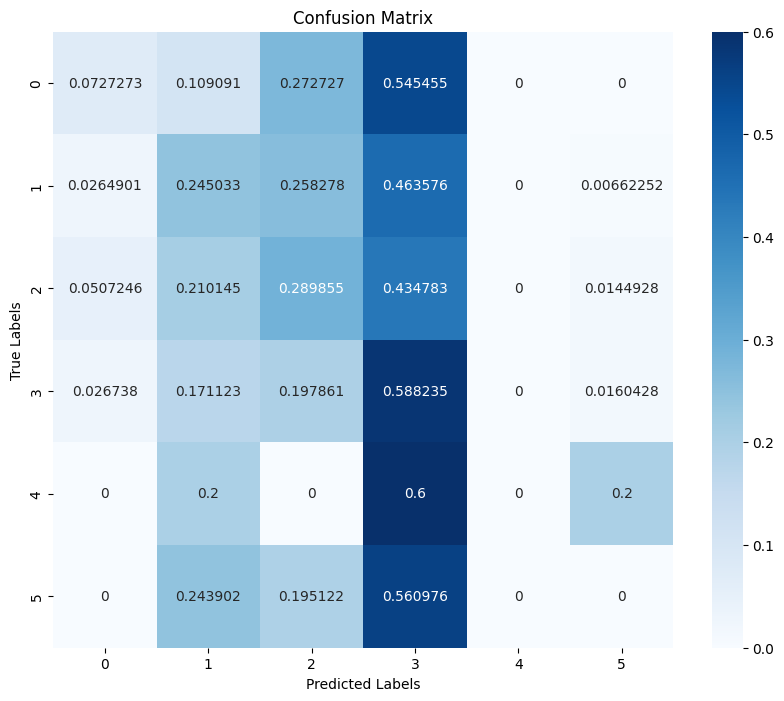

Epoch 20, Validation Loss: 3.7343, Accuracy: 0.3310, F1 Score: 0.2997
Val F1 Score Per Class  [0.10666667 0.27819549 0.28880866 0.45548654 0.         0.        ]


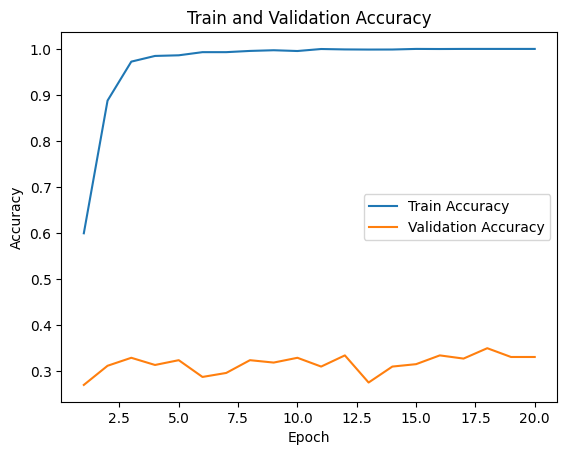

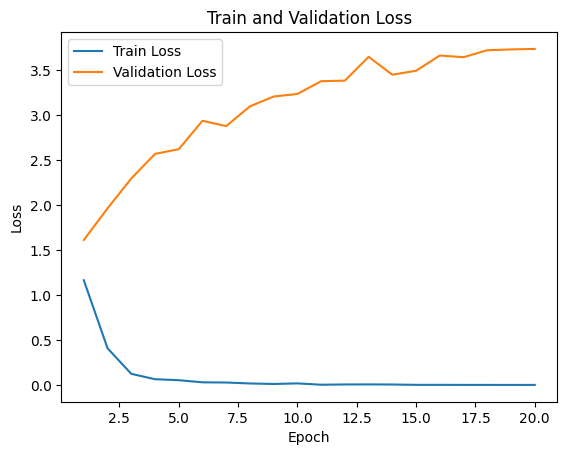

Test:   1%|▏         | 1/73 [00:00<00:37,  1.91it/s, loss=4.96]

[tensor([-3.3523, -1.7662, -1.9247,  5.8385, -4.0897, -3.3810], device='cuda:0'), tensor([-2.2871, -1.1043,  4.1951, -2.2121, -3.0046, -3.1494], device='cuda:0'), tensor([-1.7273, -1.5875,  6.4305, -2.4188, -3.1663, -1.7242], device='cuda:0'), tensor([-2.8972,  1.9751, -2.3561, -0.4817, -3.9317, -3.8280], device='cuda:0'), tensor([-1.9859, -1.6410, -2.0582,  6.5117, -3.3404, -3.5717], device='cuda:0'), tensor([-0.4525, -2.0546,  0.3761,  1.5105, -5.0999, -4.4244], device='cuda:0'), tensor([-2.8344, -2.3301, -1.4422,  2.3875, -4.8506, -4.2630], device='cuda:0'), tensor([-2.8830,  0.8243,  0.0343, -2.7544, -4.7341, -3.5279], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:01<00:38,  1.86it/s, loss=3.23]

[tensor([-3.3227, -1.0413, -0.7010, -0.7158, -4.5876, -5.3494], device='cuda:0'), tensor([-2.6125, -2.9297,  4.5952, -0.1358, -3.9628, -3.5365], device='cuda:0'), tensor([-2.3139, -3.4516,  3.3467,  2.2625, -3.7318, -2.8175], device='cuda:0'), tensor([-3.0844, -2.0439, -0.6951,  3.1940, -4.3058, -4.0444], device='cuda:0'), tensor([-1.6209, -3.0511, -0.4172,  2.1133, -4.2689, -3.6410], device='cuda:0'), tensor([-1.5416, -2.5202,  3.7312, -0.6849, -4.7540, -4.0345], device='cuda:0'), tensor([-3.2327, -1.6103, -1.9777,  5.0189, -2.7023, -2.0966], device='cuda:0'), tensor([-3.4671,  3.5605, -1.1344, -0.8554, -4.4456, -2.3588], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:36,  1.89it/s, loss=4.05]

[tensor([-1.9146, -1.8846,  6.4576, -2.3653, -3.2338, -2.1110], device='cuda:0'), tensor([-1.6778, -0.6850,  2.0260,  0.6670, -5.0613, -4.5389], device='cuda:0'), tensor([-0.1018, -1.5134,  0.6892,  0.5365, -1.3454, -4.3083], device='cuda:0'), tensor([-2.6418, -1.4998, -2.0604,  5.1646, -3.6988, -4.3377], device='cuda:0'), tensor([-3.7033, -0.0750, -1.6947, -1.5476, -2.6816, -2.9494], device='cuda:0'), tensor([-0.7331, -2.0769,  5.2514, -1.6293, -3.4582, -3.4807], device='cuda:0'), tensor([-3.9208,  4.4013, -0.7571,  0.9261, -4.7292, -4.4215], device='cuda:0'), tensor([-2.6424,  6.4652, -0.3904, -1.4269, -4.4251, -3.4313], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:02<00:36,  1.87it/s, loss=3.72]

[tensor([-3.5994, -1.9879,  2.3059,  1.1496, -5.0977, -4.4310], device='cuda:0'), tensor([-3.1604,  2.0740,  2.3857, -1.6736, -4.9592, -4.5071], device='cuda:0'), tensor([-3.0330, -2.0878, -1.5502, -0.9779, -3.8782, -2.7587], device='cuda:0'), tensor([-1.5715, -2.9843, -0.9909,  4.1434, -4.0859, -3.2750], device='cuda:0'), tensor([-4.0111, -1.1711, -1.1678, -0.6674, -3.2226, -4.0283], device='cuda:0'), tensor([-2.6621, -2.0636,  0.9389, -0.1666, -4.8653, -2.7085], device='cuda:0'), tensor([-3.6869,  2.6135, -2.0346,  1.3625, -3.7329, -3.2742], device='cuda:0'), tensor([-1.3691, -3.1190, -1.0855,  4.9948, -4.4801, -4.3691], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:36,  1.87it/s, loss=3.14]

[tensor([-0.7542, -1.3654, -3.2776,  3.4149, -3.9083, -3.2851], device='cuda:0'), tensor([-2.6409, -2.1756, -1.4385,  5.3722, -4.1165, -2.2406], device='cuda:0'), tensor([ 4.5347, -3.1899, -0.9344,  0.2333, -4.7718, -3.3785], device='cuda:0'), tensor([ 7.3183, -0.6581, -2.5283, -0.9001, -2.5902, -2.1719], device='cuda:0'), tensor([-2.4572, -2.3595, -1.4452,  3.6959, -4.2935, -2.3154], device='cuda:0'), tensor([-2.5261, -1.4819, -1.8059,  5.8210, -3.3840, -3.3051], device='cuda:0'), tensor([-3.6116, -0.9930,  1.5608,  0.3806, -3.5119, -3.3634], device='cuda:0'), tensor([-3.0896,  3.1543,  0.3187, -2.1677, -4.3521, -4.1877], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:03<00:35,  1.86it/s, loss=4.4]

[tensor([-1.5629, -1.1711, -1.6560,  1.5726, -3.5908, -2.9784], device='cuda:0'), tensor([-1.6242, -2.5721,  1.4353, -0.6798, -3.5872, -3.1299], device='cuda:0'), tensor([-2.2522, -2.3818, -1.9030,  6.2178, -1.6554, -3.2493], device='cuda:0'), tensor([-3.3841, -0.3013, -2.5682,  4.4656, -4.9794, -3.1272], device='cuda:0'), tensor([-2.1037,  6.4106, -2.4584, -0.6535, -3.7589, -2.0971], device='cuda:0'), tensor([-1.9253, -2.1207,  6.2400, -1.1929, -3.6516, -3.0489], device='cuda:0'), tensor([-1.9291, -2.6956,  6.7454, -1.6976, -2.5555, -2.7230], device='cuda:0'), tensor([-2.4069,  5.0869,  0.9372, -2.2106, -4.6178, -4.1463], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:03<00:35,  1.87it/s, loss=4.78]

[tensor([-2.7643,  6.4396, -0.5792, -1.1360, -4.1456, -2.7730], device='cuda:0'), tensor([-2.6148,  4.9876, -0.3064, -1.9458, -4.4026, -3.0338], device='cuda:0'), tensor([ 6.2037, -1.6884, -0.8187, -1.7336, -2.7638, -3.0360], device='cuda:0'), tensor([-2.8178, -2.4083,  5.5169, -0.5766, -4.1426, -3.8575], device='cuda:0'), tensor([-4.0152, -0.3677, -2.1583,  4.5830, -4.3955, -3.7305], device='cuda:0'), tensor([-2.6321, -0.9590, -2.0334,  6.3692, -3.4563, -3.0181], device='cuda:0'), tensor([-2.6404, -1.7454,  1.4583,  0.7822, -4.6470, -3.1877], device='cuda:0'), tensor([-2.7534, -2.6530, -0.3067, -0.8361, -4.6924, -4.6636], device='cuda:0')]


Test:  11%|█         | 8/73 [00:04<00:40,  1.59it/s, loss=2.65]

[tensor([-2.1237, -4.0893, -0.0317,  0.7960, -4.1821, -2.6005], device='cuda:0'), tensor([-2.0652,  4.6971, -3.2102,  0.2297, -4.4444, -3.7854], device='cuda:0'), tensor([-1.6397, -1.4605, -1.3470,  5.8718, -4.3818, -4.0976], device='cuda:0'), tensor([-2.7582, -2.3865,  0.8485,  0.9734, -4.5158, -5.0796], device='cuda:0'), tensor([-3.0971, -0.2246, -2.0856,  2.5588, -4.3983, -3.4272], device='cuda:0'), tensor([-2.2568, -1.5517, -2.0968,  6.1079, -3.6596, -2.2352], device='cuda:0'), tensor([-3.6365, -1.9079, -0.8301,  5.1668, -4.8055, -3.1367], device='cuda:0'), tensor([-1.4521, -2.7604,  4.2540, -1.4401, -4.2634, -3.1612], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:05<00:45,  1.42it/s, loss=2.7]

[tensor([ 1.0629, -2.8853,  0.9207, -1.0615, -4.2000, -3.5419], device='cuda:0'), tensor([-3.2984,  1.0217, -3.2270,  2.5919, -3.3795, -3.7584], device='cuda:0'), tensor([-2.9940, -1.8453,  2.4736,  2.9094, -4.9539, -4.0556], device='cuda:0'), tensor([ 1.6819, -3.2533,  2.9224, -0.6460, -3.6520, -3.4748], device='cuda:0'), tensor([-3.7575, -0.5494, -1.4296,  1.6765, -5.4307, -3.9702], device='cuda:0'), tensor([-3.3899,  0.2859, -0.8579,  1.5196, -4.2636, -5.4940], device='cuda:0'), tensor([-2.8754,  2.4247, -2.4644,  1.6697, -5.3965, -2.9446], device='cuda:0'), tensor([-3.9129, -1.9769,  2.5189,  3.7368, -4.0019, -4.1140], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:06<00:44,  1.42it/s, loss=5.14]

[tensor([-2.4091,  0.0178,  4.8997, -2.3147, -3.0393, -4.5678], device='cuda:0'), tensor([-3.9212,  0.1228, -0.0697,  2.0976, -5.0622, -3.4026], device='cuda:0'), tensor([-2.5597, -1.0836, -2.5257,  4.3282, -4.7650, -3.4101], device='cuda:0'), tensor([-1.3770, -1.7978, -2.9055,  5.8470, -4.2231, -3.4509], device='cuda:0'), tensor([-1.3993, -1.9920, -2.5244,  4.9272, -4.8412, -4.4905], device='cuda:0'), tensor([-1.8532, -3.1369, -0.9089,  3.7164, -4.0954, -4.7211], device='cuda:0'), tensor([-2.9143, -0.3114,  3.9509, -1.1853, -4.8437, -4.4618], device='cuda:0'), tensor([-0.4577,  3.0511, -2.6619, -1.2131, -4.0986, -4.9706], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:06<00:44,  1.38it/s, loss=2.29]

[tensor([-3.3129,  0.1038,  0.5089, -2.3186, -4.5322, -4.7546], device='cuda:0'), tensor([-0.2125, -0.4388, -2.0546,  0.1638, -3.0078, -2.6700], device='cuda:0'), tensor([-3.6378,  0.2828,  1.2809, -1.3747, -4.7644, -3.6326], device='cuda:0'), tensor([-2.2984, -2.8615,  3.7970,  2.5550, -3.3992, -4.2621], device='cuda:0'), tensor([-1.8300, -1.9118,  1.5743,  1.3560, -5.2600, -3.7235], device='cuda:0'), tensor([-2.0769, -1.0402, -2.1158,  4.4093, -2.9989, -4.8691], device='cuda:0'), tensor([-3.5670,  1.5873, -1.9675,  2.6500, -4.1887, -4.1730], device='cuda:0'), tensor([-1.9317,  6.4748, -2.0363, -1.0835, -3.5904, -3.4099], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:07<00:40,  1.50it/s, loss=3.82]

[tensor([-3.1552,  3.8355, -0.7148, -0.3153, -4.6689, -4.1068], device='cuda:0'), tensor([-2.0277, -1.4458, -0.8945,  0.3244, -3.1789, -3.9279], device='cuda:0'), tensor([-2.9117, -1.6458,  1.0455,  3.5974, -5.3116, -4.7240], device='cuda:0'), tensor([-2.9149, -0.9289, -2.1436,  5.2243, -2.9467, -3.7879], device='cuda:0'), tensor([-1.9928,  5.2990, -1.1851, -0.8227, -2.3124, -3.3926], device='cuda:0'), tensor([-1.5984, -1.9388, -1.8558,  6.6089, -3.2839, -3.3558], device='cuda:0'), tensor([-3.9310,  0.5332, -0.5221,  0.9085, -4.8016, -3.3773], device='cuda:0'), tensor([-1.5148, -1.7064, -1.6163,  5.6364, -4.2537, -4.4386], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:07<00:37,  1.60it/s, loss=3.29]

[tensor([-3.3756,  4.6192, -0.1405, -0.5640, -5.0109, -4.3303], device='cuda:0'), tensor([-4.4449, -0.9425, -1.2877,  0.3492, -4.5618, -2.2029], device='cuda:0'), tensor([-3.7699, -0.9277, -0.4769,  3.2276, -5.6215, -2.6705], device='cuda:0'), tensor([-2.8333, -1.9984,  5.1012, -1.6091, -2.0721, -2.2518], device='cuda:0'), tensor([-3.4486,  4.7178, -0.2988, -1.2557, -4.1733, -3.7060], device='cuda:0'), tensor([-3.2064,  0.1269, -1.2573,  2.5806, -4.8171, -3.5636], device='cuda:0'), tensor([-1.8613, -3.2817,  1.8616,  2.0413, -3.2327, -3.3272], device='cuda:0'), tensor([-3.0004, -1.2440, -0.6926,  1.0092, -5.4817, -4.7325], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:08<00:35,  1.66it/s, loss=5.25]

[tensor([-3.1727, -3.4473,  3.5304,  0.7093, -3.1187, -1.4841], device='cuda:0'), tensor([-3.3797, -1.9209, -1.0865,  5.8016, -3.8125, -3.1694], device='cuda:0'), tensor([ 7.3894, -1.5942, -2.4509, -1.0864, -1.6254, -1.1242], device='cuda:0'), tensor([-2.7908, -2.7890, -0.8251,  0.3542, -4.8329, -4.0094], device='cuda:0'), tensor([-2.7896, -1.6625, -3.0841,  5.7057, -3.5017, -2.3295], device='cuda:0'), tensor([-2.6793, -2.0922,  3.8248, -1.8571, -3.8951, -1.9077], device='cuda:0'), tensor([-3.1619,  4.9525, -2.2384, -1.1197, -4.3990, -2.6825], device='cuda:0'), tensor([-1.0420, -2.9782, -2.0382,  3.0904, -4.7874, -4.3517], device='cuda:0')]


Test:  21%|██        | 15/73 [00:09<00:39,  1.48it/s, loss=4.29]

[tensor([-2.9770,  2.5158, -2.8326,  3.1586, -3.0464, -4.3557], device='cuda:0'), tensor([-2.6011, -2.1700, -1.4506,  6.3249, -3.8376, -3.1002], device='cuda:0'), tensor([-2.5375, -1.0947, -1.8865,  6.1637, -3.7289, -3.8660], device='cuda:0'), tensor([-1.7059, -3.2194,  5.0087, -0.9721, -4.0034, -2.1147], device='cuda:0'), tensor([-1.1883, -2.5734, -1.7424,  3.9244, -3.9598, -3.5667], device='cuda:0'), tensor([-2.3407, -3.4204,  2.0503,  2.0635, -4.4311, -3.6750], device='cuda:0'), tensor([-2.5107, -2.4027, -2.1689,  6.5345, -3.3535, -2.9275], device='cuda:0'), tensor([-2.0630, -2.4435, -1.9113,  5.7560, -4.4408, -3.5244], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:10<00:39,  1.44it/s, loss=2.65]

[tensor([-1.9666,  2.4255, -1.8235,  1.0658, -4.0756, -3.5206], device='cuda:0'), tensor([-3.1530, -1.0149,  5.7138, -2.7807, -3.2667, -3.0142], device='cuda:0'), tensor([-1.9935, -1.9163, -1.5331,  6.4755, -4.2040, -2.9346], device='cuda:0'), tensor([-2.7076, -2.5275,  5.8265, -0.4152, -3.2418, -2.6825], device='cuda:0'), tensor([-1.5142, -1.0421, -1.5557,  0.9441, -3.9092, -5.1490], device='cuda:0'), tensor([-2.4332, -0.0267, -2.3366,  0.0390, -3.9132, -3.9953], device='cuda:0'), tensor([-3.1515, -2.8228,  4.4256,  1.9631, -3.1597, -3.9647], device='cuda:0'), tensor([-1.8039, -2.3538,  1.9991,  0.4765, -5.1475, -5.3195], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:11<00:42,  1.32it/s, loss=3.14]

[tensor([ 0.1000, -0.9901,  0.2537, -1.8451, -5.1067, -4.0553], device='cuda:0'), tensor([-2.6146,  1.0186,  2.7716, -2.4023, -4.4526, -3.6778], device='cuda:0'), tensor([ 0.5836, -2.4241, -3.2649,  4.8314, -4.1602, -3.2153], device='cuda:0'), tensor([-3.2329, -1.9642, -1.3237,  5.7905, -3.0850, -3.2827], device='cuda:0'), tensor([-2.6591,  1.1290,  3.1565, -1.6388, -4.7225, -3.0510], device='cuda:0'), tensor([-3.2715, -1.4592, -2.4007,  2.2253, -5.5919, -4.7301], device='cuda:0'), tensor([-2.4395, -2.1464, -0.1828,  3.0396, -6.0398, -4.9281], device='cuda:0'), tensor([-3.2651, -2.8973,  4.2007,  2.7460, -4.7376, -3.8841], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:11<00:42,  1.29it/s, loss=4.58]

[tensor([-2.4723, -2.3235,  5.0759, -1.2952, -5.1649, -2.2891], device='cuda:0'), tensor([-2.2212, -1.6801, -2.7670,  6.3530, -3.5378, -1.8458], device='cuda:0'), tensor([-3.1417,  0.0454, -0.5797, -0.3816, -5.4133, -4.6571], device='cuda:0'), tensor([-3.8014,  0.3857, -1.2491,  2.2961, -3.6524, -4.2871], device='cuda:0'), tensor([-4.0289,  4.3558, -1.8094, -0.1225, -3.6252, -4.0049], device='cuda:0'), tensor([-1.8103, -2.5081,  6.7235, -0.8686, -3.1517, -2.8318], device='cuda:0'), tensor([-2.4336, -2.1418, -0.8583,  4.3887, -3.3836, -4.0928], device='cuda:0'), tensor([-3.3363,  1.6802, -0.6531, -2.5442, -5.4423, -3.7704], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:12<00:41,  1.29it/s, loss=3.19]

[tensor([-0.1026, -3.0832, -1.8145,  4.8916, -4.8997, -3.4679], device='cuda:0'), tensor([-3.3534,  0.3197, -2.1582,  0.5363, -4.2009, -4.0194], device='cuda:0'), tensor([-2.8435, -0.0839,  5.6327, -2.3345, -3.4131, -3.3119], device='cuda:0'), tensor([-3.1255, -0.6483,  0.3562, -0.9938, -4.6217, -3.7838], device='cuda:0'), tensor([-2.7637, -1.1078, -0.2708,  0.2237, -4.6552, -5.2191], device='cuda:0'), tensor([-3.0444,  0.7126, -0.4106, -0.0744, -3.8789, -5.3304], device='cuda:0'), tensor([-2.5687, -2.6229,  0.2401,  2.5417, -4.8802, -3.4724], device='cuda:0'), tensor([-1.6755,  0.3554,  0.9385, -2.1104, -2.6299, -3.1753], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:13<00:38,  1.37it/s, loss=3.49]

[tensor([-2.2230,  2.6722, -2.6661, -0.9678, -3.7301, -2.6629], device='cuda:0'), tensor([-1.3812,  1.8946, -1.4815, -0.8777, -5.2462, -5.7685], device='cuda:0'), tensor([-3.5259,  1.6102, -0.9364,  0.5597, -4.1435, -5.3378], device='cuda:0'), tensor([-0.1481,  0.9401, -3.2044, -0.5419, -4.7586, -2.9181], device='cuda:0'), tensor([-2.3378,  4.7456, -1.3994, -1.7954, -3.4112, -3.2232], device='cuda:0'), tensor([-0.8360, -0.2484, -2.6979, -0.2403, -5.1422, -4.8684], device='cuda:0'), tensor([-2.2946,  5.2179, -1.1049, -1.1458, -2.6804, -3.3773], device='cuda:0'), tensor([-3.2475, -1.1212, -0.8652,  4.4479, -3.7821, -3.5211], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:13<00:36,  1.42it/s, loss=4.28]

[tensor([-1.9999,  1.6401,  2.4454, -2.9687, -3.4953, -3.3419], device='cuda:0'), tensor([-2.4244, -1.4556,  5.9507, -2.2748, -3.6450, -3.0515], device='cuda:0'), tensor([-3.5673,  2.5733, -2.2151,  0.2744, -5.5241, -4.1852], device='cuda:0'), tensor([-3.4993, -1.6405, -0.3824,  1.1786, -4.9324, -2.2026], device='cuda:0'), tensor([-2.9396, -0.8907,  0.9551,  1.5999, -3.8263, -4.6686], device='cuda:0'), tensor([-2.7866,  4.7007, -0.1551, -1.5167, -5.3804, -3.8235], device='cuda:0'), tensor([-0.8744,  6.2467, -2.8014, -0.9594, -3.2852, -2.8094], device='cuda:0'), tensor([-1.6862, -1.9574, -2.4278,  6.0937, -3.4107, -2.0572], device='cuda:0')]


Test:  30%|███       | 22/73 [00:14<00:36,  1.39it/s, loss=2.61]

[tensor([-2.1984,  6.8562, -1.6362, -1.8294, -3.5034, -2.7744], device='cuda:0'), tensor([-2.1481, -2.3582,  6.7306, -0.8564, -3.0383, -2.7007], device='cuda:0'), tensor([-2.1641, -2.4080,  0.2482,  4.4132, -6.2399, -4.0632], device='cuda:0'), tensor([-3.7829, -1.3837, -1.4483,  4.0863, -4.8473, -4.5453], device='cuda:0'), tensor([-1.7500,  0.8632, -1.5838,  1.7376, -4.4660, -3.6070], device='cuda:0'), tensor([ 2.6863, -2.0789, -3.1023,  1.2550, -4.6389, -4.3118], device='cuda:0'), tensor([-2.9493, -0.6087, -1.3166,  3.5812, -5.0673, -5.2489], device='cuda:0'), tensor([-2.8753, -0.6733, -1.7720,  2.3334, -3.3559, -3.8580], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:15<00:38,  1.31it/s, loss=2.87]

[tensor([-2.0331, -2.1296,  6.2567, -1.1545, -3.1426, -4.1395], device='cuda:0'), tensor([-3.4588, -1.5867,  0.5095,  3.2002, -4.6057, -4.4413], device='cuda:0'), tensor([-2.4796, -0.5055, -2.0093,  4.9550, -4.1392, -3.2784], device='cuda:0'), tensor([ 0.9960, -0.9955,  1.5399, -0.6143, -4.5506, -5.5608], device='cuda:0'), tensor([-3.0072, -3.1302,  4.9345, -0.0466, -3.6583, -2.5348], device='cuda:0'), tensor([-3.1825,  0.7901,  0.9459, -0.9015, -4.7043, -3.5333], device='cuda:0'), tensor([ 3.7480,  0.1856, -2.2319, -2.2854, -3.6728, -3.0855], device='cuda:0'), tensor([-2.6500,  0.5503,  2.5571, -2.0256, -4.5826, -3.9272], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:16<00:36,  1.36it/s, loss=5.66]

[tensor([-2.2098, -1.4061, -2.1195,  5.9664, -2.6665, -1.7855], device='cuda:0'), tensor([-2.5059, -3.4027,  1.6712,  2.3431, -3.3979, -3.2839], device='cuda:0'), tensor([-1.6067, -1.6677, -1.4431,  2.7503, -6.5556, -4.4595], device='cuda:0'), tensor([-2.8557,  5.8005, -2.5773, -2.0896, -4.4021, -1.0425], device='cuda:0'), tensor([-2.4299, -3.0404, -1.8157,  4.9795, -3.4831, -3.0573], device='cuda:0'), tensor([-2.6844,  2.5517, -3.5619, -0.9867, -4.5431, -1.1584], device='cuda:0'), tensor([-3.0419,  0.0353, -1.7257,  0.3404, -4.2677, -3.9157], device='cuda:0'), tensor([ 5.6535, -1.5080, -1.8977, -0.9474, -3.2382, -4.4430], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:16<00:34,  1.37it/s, loss=2.74]

[tensor([-2.9828, -1.7593,  6.1863, -1.2887, -2.7268, -2.9128], device='cuda:0'), tensor([-4.1992,  1.9367, -0.9133, -0.6681, -4.4358, -5.1516], device='cuda:0'), tensor([-2.9802, -1.3160, -1.5726,  3.8682, -3.7699, -4.9521], device='cuda:0'), tensor([-3.0325,  1.7055, -1.2039,  0.1734, -4.0151, -4.7569], device='cuda:0'), tensor([-3.0382,  0.2517, -0.5847,  0.0669, -4.6512, -4.2559], device='cuda:0'), tensor([-3.3639,  5.5392, -0.2451, -1.3326, -4.4187, -4.1181], device='cuda:0'), tensor([-2.2484,  0.7379, -1.4814,  0.1943, -3.7890, -5.4423], device='cuda:0'), tensor([-0.4580,  0.9729, -0.7766, -0.6667, -3.6177, -3.6205], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:17<00:33,  1.41it/s, loss=1.6]

[tensor([-3.5496, -0.3603, -1.2437, -0.5614, -6.4960, -2.3778], device='cuda:0'), tensor([-2.7600,  4.5532, -2.6925, -1.2584, -3.6060, -2.8916], device='cuda:0'), tensor([-0.6914, -2.7430, -1.1772, -0.7347, -3.9926, -4.0466], device='cuda:0'), tensor([-2.1316, -3.3540, -0.0215, -1.4952, -3.8983, -3.2111], device='cuda:0'), tensor([-2.1440, -0.8169, -0.7725, -1.6619, -4.3163, -3.8506], device='cuda:0'), tensor([-2.7802, -1.2437, -1.0591,  0.7018, -2.7701, -5.3752], device='cuda:0'), tensor([-2.8947,  2.0366, -2.3506,  3.9095, -4.4590, -5.0612], device='cuda:0'), tensor([-2.1980,  4.4258, -1.4074, -0.8539, -4.5837, -3.7583], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:18<00:34,  1.34it/s, loss=4.17]

[tensor([-2.4066,  6.9334, -1.3058, -1.4388, -3.0704, -2.7138], device='cuda:0'), tensor([-3.2444,  0.6902, -2.1902,  2.6115, -3.5658, -3.7047], device='cuda:0'), tensor([-3.9352, -1.0161,  3.4293, -2.0022, -4.2933, -3.6356], device='cuda:0'), tensor([-4.3536, -0.8699, -1.6166, -0.6138, -4.2696, -1.2670], device='cuda:0'), tensor([-2.1877, -2.1101,  4.6279, -2.4275, -5.2580, -3.6702], device='cuda:0'), tensor([-2.0709, -2.2804,  6.7776, -1.3080, -3.2848, -3.2538], device='cuda:0'), tensor([-2.0563, -2.6559,  3.7214, -1.6053, -4.2280, -3.9686], device='cuda:0'), tensor([-2.5758, -3.0300,  3.6680,  1.2804, -4.0336, -3.6134], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:19<00:33,  1.34it/s, loss=2.19]

[tensor([-3.8583,  2.3790, -1.0700, -0.0967, -4.4195, -4.5904], device='cuda:0'), tensor([-3.5233,  3.0354,  1.4169,  1.3808, -4.6221, -4.8658], device='cuda:0'), tensor([-3.5791,  0.1565, -1.9623,  1.3153, -4.7908, -4.7390], device='cuda:0'), tensor([-2.4892, -1.2194, -2.9157,  4.6698, -4.1564, -3.0598], device='cuda:0'), tensor([-1.8052, -1.9375, -1.1452,  5.8058, -4.2019, -3.9635], device='cuda:0'), tensor([-2.5868, -1.4268,  5.5273, -1.9322, -3.3818, -3.6172], device='cuda:0'), tensor([-2.4976, -3.8544,  3.3065,  0.5972, -3.8850, -2.2186], device='cuda:0'), tensor([-0.3751,  6.5687, -1.5440, -2.3154, -3.4737, -2.8880], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:20<00:35,  1.24it/s, loss=3.97]

[tensor([-3.0106, -2.4024,  1.7015,  0.2844, -4.4392, -3.7580], device='cuda:0'), tensor([-3.2211, -2.0697,  0.0472,  0.5182, -4.0161, -2.3397], device='cuda:0'), tensor([-3.6566, -0.5734,  1.6199,  0.7390, -4.4470, -4.8209], device='cuda:0'), tensor([-0.2704,  1.0026, -2.3996, -0.5319, -5.2523, -5.5752], device='cuda:0'), tensor([-2.0614, -2.0575,  6.5680, -1.5862, -2.5797, -2.1424], device='cuda:0'), tensor([-3.0710, -3.6269,  2.4543,  1.2819, -2.3389, -1.9177], device='cuda:0'), tensor([-2.8593, -0.1697,  4.2154, -1.8612, -2.7546, -3.4728], device='cuda:0'), tensor([-3.7720, -1.7690,  5.0209, -0.3862, -3.4342, -4.5247], device='cuda:0')]


Test:  41%|████      | 30/73 [00:21<00:43,  1.02s/it, loss=4.93]

[tensor([-2.6538,  5.9697, -2.1056, -0.5061, -4.4155, -3.3584], device='cuda:0'), tensor([-1.3202, -2.0828,  6.6941, -1.7420, -3.0653, -2.1672], device='cuda:0'), tensor([-0.3999, -2.7074, -1.6303,  1.2516, -3.9151, -4.2900], device='cuda:0'), tensor([-3.1369, -0.2097, -1.2324,  0.8387, -5.3943, -0.1512], device='cuda:0'), tensor([-3.0105, -1.0634, -2.1140,  6.1167, -4.3023, -2.8518], device='cuda:0'), tensor([-2.3013,  0.0865,  0.0107,  0.6202, -4.5376, -5.7097], device='cuda:0'), tensor([-2.3462, -1.7986, -1.5926,  6.1835, -3.5424, -4.3404], device='cuda:0'), tensor([-3.0504,  5.5847, -2.0269, -0.0558, -4.7520, -3.8739], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:22<00:40,  1.04it/s, loss=3.02]

[tensor([-2.4413, -3.1953, -1.3607,  6.0213, -4.0857, -1.9575], device='cuda:0'), tensor([-2.3511,  6.2184, -0.8447, -1.4107, -4.2801, -3.7634], device='cuda:0'), tensor([-3.1025, -1.4629,  3.8831, -0.1548, -3.3627, -3.1456], device='cuda:0'), tensor([-3.2982,  4.0916, -2.5870,  1.9608, -4.1053, -3.5201], device='cuda:0'), tensor([-3.0909,  4.8484, -0.9918, -1.0607, -4.4005, -5.2710], device='cuda:0'), tensor([-2.6670, -1.7170, -1.7116,  3.5943, -3.6872, -4.0349], device='cuda:0'), tensor([-2.2260, -2.6672, -1.8275,  5.6466, -4.1550, -4.3839], device='cuda:0'), tensor([-2.0919,  3.9098, -1.3558, -0.1519, -4.4411, -4.9509], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:23<00:37,  1.09it/s, loss=4.52]

[tensor([-1.9700, -2.3520,  6.9532, -1.0618, -2.9201, -2.6127], device='cuda:0'), tensor([-2.1232, -1.3333,  1.4900,  0.4834, -4.6021, -4.8503], device='cuda:0'), tensor([-1.9309, -1.5945, -1.8110,  1.3175, -3.7761, -4.6114], device='cuda:0'), tensor([-2.3967,  4.4272, -1.3303, -0.8431, -4.3621, -4.3761], device='cuda:0'), tensor([-3.2060, -2.1569, -1.5093,  5.2517, -5.1999, -1.8603], device='cuda:0'), tensor([-3.2093,  0.1884,  2.3696, -1.9507, -5.2188, -4.2214], device='cuda:0'), tensor([-4.3841,  2.1480,  1.8775,  0.7015, -4.8182, -4.5897], device='cuda:0'), tensor([-2.2168, -2.1436, -1.4076,  5.8266, -3.7749, -3.5811], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:24<00:36,  1.11it/s, loss=3.73]

[tensor([-2.9408, -0.5904, -1.9120,  3.9514, -4.8319, -5.8339], device='cuda:0'), tensor([-2.1933, -1.4864,  5.1222, -0.0499, -4.0449, -4.8134], device='cuda:0'), tensor([ 3.3028, -3.5650, -0.3691,  0.3748, -5.0131, -3.3970], device='cuda:0'), tensor([-3.0430, -1.6406,  4.5830,  0.5165, -4.2267, -4.6577], device='cuda:0'), tensor([-3.5502, -2.0718,  2.4072,  2.3047, -4.9210, -4.2450], device='cuda:0'), tensor([-1.6277, -0.2717, -4.1824,  1.7391, -4.8677, -0.5201], device='cuda:0'), tensor([-2.6822, -2.3640,  6.1532, -0.3997, -2.9439, -2.7719], device='cuda:0'), tensor([-2.3123, -0.9576, -2.6438,  6.4450, -3.9159, -3.1266], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:25<00:36,  1.08it/s, loss=2.73]

[tensor([-3.5113, -1.1754, -0.4616,  3.9075, -5.6221, -4.6319], device='cuda:0'), tensor([-2.9684, -2.6470,  2.0696,  4.1829, -3.6515, -2.8997], device='cuda:0'), tensor([-1.5772, -1.0768, -2.2414,  4.1211, -4.3816, -4.7626], device='cuda:0'), tensor([-1.6719, -1.9440,  0.1319,  0.5268, -3.9895, -2.8795], device='cuda:0'), tensor([-1.6788, -1.8019, -1.8178,  6.5618, -3.5100, -2.8313], device='cuda:0'), tensor([-1.7351, -2.3382,  2.7493, -1.1063, -3.7323, -5.0650], device='cuda:0'), tensor([-2.7695, -0.9544,  6.4234, -2.1409, -2.7002, -3.1201], device='cuda:0'), tensor([ 0.3396, -3.5268, -0.6574,  1.3033, -3.9111, -3.4373], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:25<00:33,  1.13it/s, loss=2.94]

[tensor([-0.4554,  2.9325, -2.1302, -1.4431, -5.2000, -3.4917], device='cuda:0'), tensor([-1.5481, -2.5303,  6.7622, -1.2565, -2.4112, -1.9145], device='cuda:0'), tensor([-1.8902, -3.4884, -0.0834,  2.7293, -5.1426, -3.9304], device='cuda:0'), tensor([-2.3268, -1.3241, -2.8207,  6.1668, -2.4589, -2.9914], device='cuda:0'), tensor([-3.2517,  2.0267, -0.9159, -1.5851, -4.3925, -2.5929], device='cuda:0'), tensor([-3.6010, -0.9256, -0.2835,  4.2153, -4.4803, -4.4716], device='cuda:0'), tensor([-1.6340, -1.7379, -1.0544,  6.0879, -3.9510, -4.2561], device='cuda:0'), tensor([-2.0767, -2.3787,  6.7715, -0.7198, -2.8348, -2.2733], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:26<00:32,  1.15it/s, loss=4.08]

[tensor([-3.2516,  2.5781, -0.8765, -1.5106, -4.5347, -4.9487], device='cuda:0'), tensor([-2.8446, -0.6545,  3.2390, -2.1275, -3.7075, -3.8504], device='cuda:0'), tensor([-2.9764, -2.4268, -0.8714,  2.4737, -4.2378, -2.7093], device='cuda:0'), tensor([-3.1819, -2.2496, -1.0081,  3.0950, -4.6228, -4.4117], device='cuda:0'), tensor([-2.0498, -0.0505, -1.9060,  0.4671, -4.6600, -4.4631], device='cuda:0'), tensor([-0.5083, -0.0924, -2.5883,  1.4666, -4.3540, -4.6855], device='cuda:0'), tensor([-2.5214, -1.8045, -1.8332,  6.4242, -3.6327, -2.9778], device='cuda:0'), tensor([-2.5978,  0.7274, -2.7795,  4.6937, -4.7577, -4.0567], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:27<00:30,  1.19it/s, loss=4.26]

[tensor([-3.5011, -2.1203, -2.6857,  3.8263, -4.9145, -3.8699], device='cuda:0'), tensor([-2.2110, -0.9444, -1.6500,  4.5965, -3.8983, -3.0728], device='cuda:0'), tensor([-3.8544,  0.2001,  2.3718,  0.1651, -5.5929, -3.5884], device='cuda:0'), tensor([-2.3802, -0.0505, -1.4242,  1.4556, -4.9828, -4.4856], device='cuda:0'), tensor([-3.0278,  5.2780, -2.9553,  0.1482, -4.3244, -3.0280], device='cuda:0'), tensor([-3.0361, -2.5520,  5.3921, -1.0125, -3.1064, -3.2057], device='cuda:0'), tensor([-3.1218, -3.0538, -0.1870,  0.4597, -3.7539, -3.3651], device='cuda:0'), tensor([-3.2639, -1.2460, -2.0348,  5.2278, -3.7594, -1.5255], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:28<00:28,  1.23it/s, loss=2.76]

[tensor([-3.7718,  3.2180, -0.7698, -0.8761, -3.9412, -4.3668], device='cuda:0'), tensor([ 0.6893, -3.4068,  3.0024, -0.6667, -3.3240, -3.0672], device='cuda:0'), tensor([-1.7033, -2.7515,  6.4574, -0.7978, -3.0488, -2.9576], device='cuda:0'), tensor([-1.5181, -1.4390, -2.7708,  3.8407, -4.8279, -4.0824], device='cuda:0'), tensor([-2.5556,  5.4267, -1.9906, -0.6713, -3.6790, -3.3894], device='cuda:0'), tensor([-1.6747,  1.3290, -3.3290, -1.0590, -4.8192, -2.5812], device='cuda:0'), tensor([-3.4296,  0.6927, -2.2635,  2.6862, -4.0278, -3.8870], device='cuda:0'), tensor([-1.5817, -3.4524,  3.5811, -1.0935, -4.3565, -3.9590], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:28<00:26,  1.27it/s, loss=2.84]

[tensor([-3.2988, -2.3893,  0.9014,  0.8394, -5.1595, -4.4475], device='cuda:0'), tensor([-1.7412,  6.9160, -1.7987, -2.0315, -3.0055, -1.6878], device='cuda:0'), tensor([-2.4444,  4.3935, -4.0764,  1.7124, -3.8139, -2.7292], device='cuda:0'), tensor([-2.8257,  1.8465,  0.7926, -0.6157, -4.8875, -4.7917], device='cuda:0'), tensor([-0.8303, -0.5133, -1.3108, -3.6128, -3.8218,  4.1344], device='cuda:0'), tensor([-3.7376, -1.7678,  2.1409,  0.5930, -3.3181, -4.1754], device='cuda:0'), tensor([-2.1460,  2.4546, -1.2058, -2.0217, -3.7588, -4.0062], device='cuda:0'), tensor([-1.6037,  5.6449, -2.6031, -0.2767, -4.1632, -4.0941], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:30<00:30,  1.09it/s, loss=4.15]

[tensor([-2.7019, -2.5806, -1.7046, -0.8817, -3.4810, -3.0298], device='cuda:0'), tensor([-3.5779, -0.5310,  1.6926, -1.6597, -4.4739, -0.7635], device='cuda:0'), tensor([-4.3193,  0.5066,  0.6198, -2.2771, -4.8078, -0.9712], device='cuda:0'), tensor([-2.7672, -3.1549,  2.5121,  3.2750, -3.8612, -4.3352], device='cuda:0'), tensor([-3.5261, -0.7500,  1.5988, -0.4100, -5.2354, -4.9704], device='cuda:0'), tensor([-3.6329, -0.6275, -1.3963, -0.2030, -3.7553, -3.4090], device='cuda:0'), tensor([-1.9702,  6.4972, -2.3105, -1.4224, -3.8333, -2.9709], device='cuda:0'), tensor([-2.1086, -1.1687, -2.6429,  4.5545, -4.9292, -4.0594], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:31<00:34,  1.07s/it, loss=4.36]

[tensor([-1.2882, -2.4489, -0.8782,  4.7978, -4.0231, -3.9977], device='cuda:0'), tensor([-1.1419,  1.9612, -1.7056, -0.9943, -4.0433, -3.7454], device='cuda:0'), tensor([-2.6947, -2.2981, -0.7810,  3.3332, -3.8986, -3.5540], device='cuda:0'), tensor([-1.6871, -1.3094, -2.1660,  6.6153, -3.4192, -3.6032], device='cuda:0'), tensor([-1.8743, -1.8998, -3.9860,  1.1442, -4.5610, -0.9806], device='cuda:0'), tensor([-2.7975, -1.5131, -1.9907,  5.8678, -3.8128, -2.9744], device='cuda:0'), tensor([-2.9095, -2.1363, -0.7121,  5.3707, -4.1819, -3.9797], device='cuda:0'), tensor([-3.7110, -0.7140, -2.2588,  4.3709, -3.8862, -3.3536], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:32<00:31,  1.01s/it, loss=2.53]

[tensor([-2.3334, -1.2663, -2.2097,  5.3234, -2.2883, -3.5702], device='cuda:0'), tensor([-2.0457, -0.1421, -2.7542,  2.0734, -2.1219, -4.9794], device='cuda:0'), tensor([-3.2675, -0.6459,  1.4562, -1.6119, -4.8576, -3.5309], device='cuda:0'), tensor([-2.9274, -2.3001,  2.6262, -0.9939, -5.2114, -4.4785], device='cuda:0'), tensor([-3.6480, -1.1691, -0.4272,  2.7486, -3.2502, -2.1236], device='cuda:0'), tensor([-2.7291, -1.9597, -0.1306,  3.2579, -3.7498, -4.4670], device='cuda:0'), tensor([-1.0313, -2.3721, -2.6904,  4.4932, -4.4034, -3.1423], device='cuda:0'), tensor([-3.2875,  3.6197, -2.7448,  0.8782, -3.1553, -3.1157], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:33<00:31,  1.04s/it, loss=4.49]

[tensor([-3.9332,  0.2008,  1.1537, -1.2123, -5.7008, -3.8008], device='cuda:0'), tensor([-2.7623, -1.4623, -1.8811, -0.9841, -5.3550, -4.2710], device='cuda:0'), tensor([-3.2220, -0.1668, -3.1620,  4.8776, -3.4371, -3.7324], device='cuda:0'), tensor([-1.1733, -0.4695, -1.0049,  0.5929, -4.5140, -5.1671], device='cuda:0'), tensor([-3.4791,  2.0001, -1.0704, -1.4367, -4.8373, -5.0147], device='cuda:0'), tensor([-2.4366, -1.9137, -1.7760,  6.5917, -3.2394, -2.9971], device='cuda:0'), tensor([-2.7943, -0.7066,  6.5874, -1.7838, -3.4444, -3.3121], device='cuda:0'), tensor([-2.3329, -0.7088,  5.1047, -2.5957, -3.9334, -0.5998], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:35<00:35,  1.22s/it, loss=5.14]

[tensor([-1.7111, -0.1236, -2.8458,  4.7528, -3.1802, -4.8170], device='cuda:0'), tensor([-3.2721,  2.9290, -2.3779, -1.3452, -4.1839, -1.8277], device='cuda:0'), tensor([-3.2580, -2.3489,  1.6178, -0.2295, -4.8799, -3.1520], device='cuda:0'), tensor([-2.9858, -1.6274, -1.9069,  6.3305, -3.7694, -3.7752], device='cuda:0'), tensor([-1.2641,  4.7318, -2.8965, -0.3795, -3.5661, -4.2451], device='cuda:0'), tensor([-2.6531, -0.5159, -2.5855,  6.0857, -4.3212, -3.4353], device='cuda:0'), tensor([-4.2503, -0.2511, -0.3691,  2.3989, -4.5595, -3.4308], device='cuda:0'), tensor([-3.4643,  1.7274,  1.7753, -0.9351, -4.8905, -5.0291], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:36<00:31,  1.14s/it, loss=3.16]

[tensor([-2.0241, -2.5198,  5.3414, -0.3243, -3.1020, -2.8027], device='cuda:0'), tensor([-3.1487, -1.7567, -1.6199, -0.2962, -5.6982, -3.9280], device='cuda:0'), tensor([-2.3031, -3.2294, -1.3168,  1.7232, -3.8179, -3.5824], device='cuda:0'), tensor([-1.7433, -3.2958, -0.5854,  3.4531, -4.0800, -3.4561], device='cuda:0'), tensor([-3.6966, -0.6440,  1.9221, -0.2105, -5.0594, -2.3212], device='cuda:0'), tensor([-2.7294, -3.0802,  0.3570,  5.5781, -3.9256, -3.2665], device='cuda:0'), tensor([ 6.0578, -0.7856, -1.3788, -1.0379, -2.4798, -2.3069], device='cuda:0'), tensor([-3.2403, -0.3066, -0.8362,  2.8467, -4.6084, -4.2960], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:37<00:28,  1.07s/it, loss=3.85]

[tensor([-4.4053,  1.1806, -1.0679,  2.8349, -4.5483, -4.4860], device='cuda:0'), tensor([-1.9126, -2.3749, -2.6063, -0.4001, -3.1948,  6.1375], device='cuda:0'), tensor([-3.5286, -1.5614,  4.7911,  1.1723, -3.9328, -4.3758], device='cuda:0'), tensor([-2.1719, -1.1953, -2.2352,  5.3542, -3.5823, -4.8638], device='cuda:0'), tensor([-0.7590, -0.6927, -3.7699,  2.2389, -1.7067, -2.9335], device='cuda:0'), tensor([ 4.3482, -2.4097, -1.4638, -0.8203, -5.5554, -1.5377], device='cuda:0'), tensor([-2.9850,  0.4764, -2.0553,  3.7549, -4.6099, -4.3998], device='cuda:0'), tensor([-2.1647, -2.4330, -1.5525,  5.7920, -3.9122, -3.2606], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:38<00:29,  1.12s/it, loss=4.7]

[tensor([-2.9947, -1.5767,  6.1072, -1.8882, -3.9911, -1.9082], device='cuda:0'), tensor([-2.8521, -0.0077,  1.6792, -1.3343, -4.4112, -5.1154], device='cuda:0'), tensor([-3.6343,  2.1556, -2.1329,  2.1121, -5.1250, -3.2713], device='cuda:0'), tensor([-2.0640, -2.6662,  5.6433, -0.0096, -3.4730, -2.4057], device='cuda:0'), tensor([-3.2853, -1.0701,  1.2079,  0.4921, -4.5472, -4.0253], device='cuda:0'), tensor([-2.0548,  6.2284, -1.9295, -1.0222, -3.6238, -2.9495], device='cuda:0'), tensor([ 3.3399,  0.3304, -3.2510, -0.7396, -2.8100, -4.0924], device='cuda:0'), tensor([-3.1563, -0.6142, -1.0410,  1.5612, -4.6330, -4.6335], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:39<00:28,  1.16s/it, loss=3.97]

[tensor([-2.5680, -1.8558, -2.0083,  6.4315, -4.0057, -2.5267], device='cuda:0'), tensor([ 4.3135, -0.9758, -2.4750, -0.8547, -3.0804, -3.1242], device='cuda:0'), tensor([-3.7496,  4.3295, -0.6312, -0.6873, -3.9859, -4.2482], device='cuda:0'), tensor([-4.0380,  0.1336, -1.6222,  2.7831, -4.9595, -4.3619], device='cuda:0'), tensor([-2.9437, -2.5887,  6.0417, -0.8136, -3.5659, -3.8643], device='cuda:0'), tensor([-1.6796, -3.3768,  3.7958,  2.1000, -4.9469, -4.6163], device='cuda:0'), tensor([-0.1508, -2.5888, -0.8944,  0.1089, -4.2887, -4.7363], device='cuda:0'), tensor([-2.6096, -0.8938, -2.1617,  5.8519, -3.6020, -4.8013], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:40<00:26,  1.08s/it, loss=2.67]

[tensor([-1.7695, -0.6698, -3.5431,  5.6126, -3.4651, -2.8659], device='cuda:0'), tensor([-3.5284,  0.8197, -1.8362,  4.0028, -3.8900, -4.6284], device='cuda:0'), tensor([-2.6719, -1.0643, -3.3675,  3.5060, -3.4691, -4.3382], device='cuda:0'), tensor([-1.8863,  3.6445, -2.8310,  0.0913, -1.3069, -3.2805], device='cuda:0'), tensor([-2.9229,  1.3104,  1.4684, -0.7057, -5.0181, -4.7458], device='cuda:0'), tensor([-3.9516, -2.2099, -1.3803,  0.0178, -5.3484, -4.1969], device='cuda:0'), tensor([ 4.1865, -2.0578, -2.0677, -0.3168, -3.3192, -2.6718], device='cuda:0'), tensor([-2.2998, -2.4902,  1.4062, -1.3751, -4.6525, -3.6054], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:41<00:24,  1.09s/it, loss=3.17]

[tensor([-2.7476,  3.6446, -2.7381, -0.4054, -4.6042, -3.4028], device='cuda:0'), tensor([-3.1072, -0.7525, -0.0419,  1.0465, -5.2478, -5.5610], device='cuda:0'), tensor([-4.0740, -2.0391,  0.8841,  0.4301, -3.5521, -3.9052], device='cuda:0'), tensor([-0.6916, -2.7362, -1.6831,  3.1517, -3.6737, -3.5230], device='cuda:0'), tensor([ 2.8088, -2.5558, -1.4550,  1.1497, -4.1230, -2.2075], device='cuda:0'), tensor([-2.5782, -1.9818, -1.2867,  6.5107, -3.9072, -2.8946], device='cuda:0'), tensor([-3.5670,  0.4037, -1.7558,  2.0732, -5.2190, -2.7370], device='cuda:0'), tensor([-2.5802, -2.4038,  3.3628,  0.2168, -5.4495, -4.5628], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:42<00:21,  1.00it/s, loss=3.84]

[tensor([-2.5681, -2.0599, -2.1351,  5.7713, -3.4431, -3.2289], device='cuda:0'), tensor([-3.5001, -0.1852, -1.2475, -0.6563, -4.7836, -4.1241], device='cuda:0'), tensor([-2.7811, -0.1200, -2.3510,  2.3412, -4.3279, -4.6860], device='cuda:0'), tensor([-3.5754,  0.0696,  1.6628,  1.0272, -4.6013, -3.4808], device='cuda:0'), tensor([-2.0181,  0.0685, -3.4514,  3.3306, -4.5017, -4.3644], device='cuda:0'), tensor([-2.4344,  0.0624, -2.2911,  5.0255, -4.7175, -3.9236], device='cuda:0'), tensor([-3.6281, -1.7893,  2.0163,  0.1470, -4.1652, -4.9651], device='cuda:0'), tensor([-3.4883,  3.0655,  0.9475,  1.4264, -5.5650, -5.0653], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:43<00:23,  1.13s/it, loss=4.01]

[tensor([-3.8311, -1.7339,  0.7025,  4.9926, -4.3278, -3.7504], device='cuda:0'), tensor([-1.5617,  4.8143, -2.5627, -0.9039, -3.6672, -3.8433], device='cuda:0'), tensor([-0.4123, -2.6781, -1.4574,  1.3436, -4.0869, -3.7820], device='cuda:0'), tensor([-2.8043, -3.0805,  2.0962, -1.1705, -3.6930, -3.2828], device='cuda:0'), tensor([-4.0670, -0.4291, -0.9458,  3.6078, -4.0062, -4.2214], device='cuda:0'), tensor([-3.4172,  0.7117,  3.1256, -2.1110, -3.7079, -2.8731], device='cuda:0'), tensor([-2.0770, -3.0497, -2.6373,  3.3780, -4.2598, -1.4138], device='cuda:0'), tensor([-2.6095, -2.4918, -1.6434,  4.1934, -3.7512, -4.1071], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:44<00:21,  1.07s/it, loss=1.99]

[tensor([-2.7866, -1.5547, -1.4401,  4.9285, -4.2492, -2.9302], device='cuda:0'), tensor([-2.1002, -1.8356, -2.4189,  6.1542, -3.0736, -3.3764], device='cuda:0'), tensor([-3.1501, -1.4714, -1.5817,  2.7112, -4.3803, -3.8991], device='cuda:0'), tensor([-3.6864, -0.8846, -2.6875,  1.5074, -4.1627, -2.9652], device='cuda:0'), tensor([-3.4169, -2.6729,  1.3759,  0.9325, -4.0797, -4.9837], device='cuda:0'), tensor([-2.5861, -2.6632, -1.0329,  5.7444, -3.7520, -3.7158], device='cuda:0'), tensor([-0.7125,  1.1939, -3.4631,  1.8145, -3.4045, -4.4841], device='cuda:0'), tensor([ 3.5659,  1.5384, -3.3310, -0.9205, -4.6784, -3.5787], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:45<00:19,  1.01s/it, loss=4.2]

[tensor([-2.3579, -1.7547, -1.8294,  5.9595, -2.9164, -3.2296], device='cuda:0'), tensor([-1.3844, -2.4654, -2.3984,  4.5696, -3.7379, -4.6377], device='cuda:0'), tensor([-2.5320, -1.6796, -1.0091,  5.1948, -4.5752, -4.6077], device='cuda:0'), tensor([-2.3388, -2.2948, -1.8311,  5.2538, -5.4130, -2.7449], device='cuda:0'), tensor([-1.7345, -0.8497, -3.0005,  2.9175, -4.6086, -3.9814], device='cuda:0'), tensor([-1.4314, -2.6512, -1.6323,  5.8761, -2.6888, -2.8923], device='cuda:0'), tensor([-2.4527,  1.0394, -2.0516,  2.5417, -5.0815, -4.7942], device='cuda:0'), tensor([-0.9516, -2.0967, -2.4699,  5.3693, -2.7215, -3.5551], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:46<00:16,  1.12it/s, loss=0.945]

[tensor([-2.4888, -1.7531, -2.1731,  6.3477, -4.0873, -3.8389], device='cuda:0'), tensor([-2.0123, -2.9659,  0.0653, -2.0934, -3.9079, -3.1773], device='cuda:0'), tensor([-2.5372, -0.8677, -0.3915,  1.4213, -4.3194, -3.9151], device='cuda:0'), tensor([-2.0699,  2.3943, -3.3189,  2.4062, -4.6633, -3.9219], device='cuda:0'), tensor([-1.5561, -1.4401, -3.2920,  3.9941, -3.7322, -1.9217], device='cuda:0'), tensor([ 0.3423,  0.0915,  1.0139,  1.4143, -2.2215, -3.2023], device='cuda:0'), tensor([-2.4804, -1.6268,  0.0858,  3.2585, -3.8505, -4.8413], device='cuda:0'), tensor([ 1.0168, -3.1549,  3.9987, -0.5158, -2.9234, -2.3022], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:46<00:14,  1.21it/s, loss=3.82]

[tensor([-1.8779,  2.6529, -2.5180,  0.8896, -4.1076, -3.6565], device='cuda:0'), tensor([-0.5261, -1.9904, -2.6741,  5.4385, -3.2598, -2.9469], device='cuda:0'), tensor([-2.7032, -3.0112,  0.2805,  1.9829, -5.1052, -3.4237], device='cuda:0'), tensor([-3.3434,  1.3265, -0.5586,  1.6157, -3.7938, -4.4617], device='cuda:0'), tensor([-3.2316, -2.2412, -0.7913,  5.2375, -4.1435, -3.8793], device='cuda:0'), tensor([-2.4612,  4.0801, -3.4097,  0.4628, -4.1313, -3.5333], device='cuda:0'), tensor([-3.2839, -2.0004,  5.9917, -0.9208, -3.9756, -3.2151], device='cuda:0'), tensor([-2.4685, -0.2463, -1.8853,  0.0686, -4.3637, -4.1344], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:47<00:12,  1.30it/s, loss=3.65]

[tensor([-1.9089,  1.2237, -3.1286,  0.5225, -4.4351, -3.5150], device='cuda:0'), tensor([-2.2726, -1.8480, -1.9980,  6.6406, -3.9323, -3.3548], device='cuda:0'), tensor([-1.0558, -1.1965, -0.2056,  1.9352, -3.8571, -3.2156], device='cuda:0'), tensor([-3.0595, -1.9659, -1.1831,  6.2091, -3.5170, -2.3150], device='cuda:0'), tensor([-2.2820,  5.7441, -1.6832, -0.5714, -3.6355, -3.6813], device='cuda:0'), tensor([-2.0445, -0.2047, -3.5825,  4.8558, -4.8067, -3.1265], device='cuda:0'), tensor([-3.5384,  2.3895, -2.5973,  0.0797, -3.5142, -1.9791], device='cuda:0'), tensor([-3.1595,  5.8793, -1.6752, -1.1743, -3.6814, -3.4457], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:48<00:11,  1.27it/s, loss=2.93]

[tensor([ 2.1562, -0.8760, -2.7298,  0.9784, -5.1036, -3.1569], device='cuda:0'), tensor([-2.6736, -2.2576, -0.0955, -0.7435, -3.8430, -1.5184], device='cuda:0'), tensor([-3.7009,  3.5969,  1.1640, -1.2856, -3.7438, -2.9064], device='cuda:0'), tensor([-3.0095,  5.8853, -2.2887,  0.2054, -4.5365, -2.4999], device='cuda:0'), tensor([-3.6038, -2.5935,  1.0357,  2.8420, -4.4702, -3.8588], device='cuda:0'), tensor([-1.9109, -2.8554, -0.9258,  1.6055, -3.8348, -4.0998], device='cuda:0'), tensor([-3.0862, -1.6504,  3.7023, -1.8858, -3.3791, -4.1052], device='cuda:0'), tensor([-1.5302,  3.0624, -3.2450, -0.7423, -1.0612, -4.6297], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:49<00:10,  1.28it/s, loss=3.02]

[tensor([ 2.8059, -1.2006,  0.5666, -1.1052, -4.4350, -4.4377], device='cuda:0'), tensor([-1.9300, -2.0074, -1.7850,  5.8104, -4.4027, -2.8875], device='cuda:0'), tensor([-1.0465, -1.5725, -1.9773,  2.4337, -4.6495, -4.6931], device='cuda:0'), tensor([-1.6704, -2.5911, -1.4220,  6.4969, -3.6898, -2.6022], device='cuda:0'), tensor([-1.8409, -2.0233, -2.3192,  6.6057, -3.1929, -2.2504], device='cuda:0'), tensor([-2.4324, -1.4444, -0.9513,  6.1293, -4.5912, -3.5627], device='cuda:0'), tensor([-1.4539, -2.3749, -1.2872,  0.4510, -5.3016, -3.3195], device='cuda:0'), tensor([-2.9376, -3.4115,  2.6374, -0.4076, -3.3195, -3.4203], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:49<00:10,  1.28it/s, loss=4.8]

[tensor([-2.6689, -2.6501, -1.1718,  6.1023, -4.1959, -2.7650], device='cuda:0'), tensor([-3.1955,  1.4860, -1.9756, -0.2964, -4.8117, -4.2988], device='cuda:0'), tensor([-0.9283, -2.5252, -1.7059,  5.5553, -4.4756, -2.3129], device='cuda:0'), tensor([-1.9123, -1.8390, -2.0870,  6.6928, -3.1939, -3.1812], device='cuda:0'), tensor([-2.3431, -2.0802, -1.5937,  5.7376, -4.9779, -3.7979], device='cuda:0'), tensor([-2.4415,  4.4377, -3.1739,  1.8082, -4.0038, -2.3585], device='cuda:0'), tensor([-2.5224, -1.0906, -2.0064,  6.5351, -3.6953, -3.8144], device='cuda:0'), tensor([-2.7660, -3.6642,  0.5122,  2.2444, -3.1227, -1.3860], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:51<00:10,  1.10it/s, loss=3.52]

[tensor([-3.8959, -0.6450, -0.1052,  4.2782, -4.4842, -4.6194], device='cuda:0'), tensor([-2.1690, -2.3845, -1.5410,  6.2223, -3.9343, -2.6661], device='cuda:0'), tensor([-2.8737, -0.9928, -0.3097, -1.4625, -4.3936, -1.7511], device='cuda:0'), tensor([-2.8930, -3.5861, -0.0532,  0.7086, -3.0702,  1.4331], device='cuda:0'), tensor([-1.8089, -3.8989,  3.4861,  0.1048, -4.6243, -3.1150], device='cuda:0'), tensor([-3.2194, -2.1693,  1.8390,  1.2036, -4.1147, -4.2196], device='cuda:0'), tensor([-3.2942, -1.9650,  5.4561, -0.0834, -3.4617, -3.2311], device='cuda:0'), tensor([-3.7496, -1.9769,  0.6706, -0.5810, -4.0525, -3.8590], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:51<00:09,  1.16it/s, loss=4.72]

[tensor([-3.1428, -1.6424, -1.4162,  5.8864, -3.5710, -3.6343], device='cuda:0'), tensor([-3.3523, -0.4070,  1.9700, -1.5774, -4.5766, -3.5775], device='cuda:0'), tensor([-1.8295, -3.3086, -0.8430,  4.3294, -4.2691, -4.0218], device='cuda:0'), tensor([-2.1458, -3.1967,  0.0673,  4.5376, -4.3417, -3.1532], device='cuda:0'), tensor([-3.9552,  1.0133,  1.8621, -2.1328, -4.1102, -3.6617], device='cuda:0'), tensor([-2.8885, -2.0753, -0.5897,  5.5660, -4.9427, -3.3553], device='cuda:0'), tensor([-2.0041,  0.2570, -3.7837,  2.4326, -2.8517, -2.8957], device='cuda:0'), tensor([-1.7516, -0.4613, -1.5190,  3.3514, -3.1189, -2.6097], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:53<00:10,  1.03s/it, loss=4.75]

[tensor([-3.3163, -0.0514,  0.8535,  2.6035, -4.5489, -4.0735], device='cuda:0'), tensor([-3.1528, -1.6985, -1.7488,  5.1116, -3.3616, -4.0292], device='cuda:0'), tensor([-2.6147, -2.1298, -1.2601,  6.2941, -4.0079, -2.8745], device='cuda:0'), tensor([ 5.4104, -1.6516, -1.8064, -0.5531, -2.3580, -2.4428], device='cuda:0'), tensor([-3.1418,  3.2236,  0.1444, -1.1837, -4.4668, -4.1434], device='cuda:0'), tensor([-3.0961, -2.5462,  4.8927,  1.3098, -4.0523, -3.6618], device='cuda:0'), tensor([-2.6214, -2.3202, -1.3396,  6.3479, -3.6260, -3.2921], device='cuda:0'), tensor([-2.3088, -1.1452,  6.8283, -2.2828, -2.8647, -2.2576], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:54<00:09,  1.06s/it, loss=1.74]

[tensor([-2.0616,  1.6658, -0.4361, -2.1836, -4.2081, -4.2619], device='cuda:0'), tensor([-3.2279, -1.7403, -2.2164,  1.4795, -5.0281, -3.1920], device='cuda:0'), tensor([-1.0987,  3.1809, -1.3800, -0.7966, -5.3645, -5.7157], device='cuda:0'), tensor([-2.3942, -1.6962, -1.9019,  6.5680, -2.9542, -2.7472], device='cuda:0'), tensor([-1.6479, -3.5610,  0.9444,  3.4215, -4.5246, -3.9555], device='cuda:0'), tensor([-2.9093, -2.3906,  4.2350,  0.4901, -4.0939, -4.7179], device='cuda:0'), tensor([-2.2839, -1.4660, -1.1457, -1.3085, -4.1434, -4.4986], device='cuda:0'), tensor([-2.4195,  1.1246,  0.1146,  0.0392, -4.8745, -3.0146], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:55<00:08,  1.02s/it, loss=3.17]

[tensor([-2.8483, -3.3406,  0.8545,  0.0432, -4.5501, -3.3683], device='cuda:0'), tensor([-3.5248, -1.7009,  5.3397, -1.5591, -3.8171, -3.7633], device='cuda:0'), tensor([-3.4593, -2.1950,  0.2830,  3.9911, -4.8118, -4.7199], device='cuda:0'), tensor([-3.4137, -0.4063, -3.2134,  3.1036, -4.1336, -0.6450], device='cuda:0'), tensor([-2.0032, -1.4169, -1.4018,  1.6102, -5.7987, -5.3616], device='cuda:0'), tensor([ 2.1969, -2.9869, -1.9106,  0.1143, -4.4497, -3.4182], device='cuda:0'), tensor([-2.0414, -2.5488,  1.0378,  0.9373, -2.6256, -3.4368], device='cuda:0'), tensor([-0.9955, -2.2109,  4.0046, -0.9377, -4.1583, -3.8882], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:55<00:06,  1.14it/s, loss=2.2]

[tensor([-3.6856,  0.1828, -1.9583,  1.3011, -4.2793, -4.6303], device='cuda:0'), tensor([-2.2681,  0.7365, -3.2498,  2.4765, -4.3195, -3.2157], device='cuda:0'), tensor([-1.8824, -0.9446, -2.8236,  6.4328, -3.6345, -2.8554], device='cuda:0'), tensor([-2.0670, -1.4922,  6.2838, -2.5262, -3.1964, -1.3694], device='cuda:0'), tensor([-1.9453, -2.2055,  3.9946, -0.8768, -2.8716, -2.1182], device='cuda:0'), tensor([-3.9646, -1.7700, -2.2014,  3.6250, -4.7471, -1.8407], device='cuda:0'), tensor([-2.6660, -1.9611,  1.7663, -0.5407, -5.2686, -4.5914], device='cuda:0'), tensor([-3.5156, -0.6376, -2.6523,  3.8265, -3.9651, -3.9273], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:56<00:04,  1.29it/s, loss=3.66]

[tensor([-3.2450, -2.7938,  4.6621,  1.2253, -3.6602, -3.9106], device='cuda:0'), tensor([-3.4657, -3.2011,  0.3609,  3.7400, -4.2699,  0.2119], device='cuda:0'), tensor([-1.8575, -2.7955,  6.3258, -1.1727, -4.2441, -3.7647], device='cuda:0'), tensor([-2.3912, -1.6052,  2.0617,  3.5438, -4.1340, -5.8984], device='cuda:0'), tensor([ 0.7431, -0.4013, -1.2552,  1.3739, -3.7477, -5.2376], device='cuda:0'), tensor([ 0.3576, -1.3148,  0.6053, -0.4490, -4.1919, -2.7190], device='cuda:0'), tensor([-2.7087, -1.8047,  5.8176, -0.9911, -4.0969, -3.4704], device='cuda:0'), tensor([-2.4493, -2.6265,  4.8290,  1.4706, -5.0423, -3.6836], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:56<00:03,  1.43it/s, loss=2.78]

[tensor([-2.6743, -1.4608, -0.1815,  0.0781, -4.2795, -3.5559], device='cuda:0'), tensor([-2.1667, -1.4937, -2.3075,  6.6875, -3.4059, -2.9324], device='cuda:0'), tensor([-2.2532, -1.6843, -1.8581, -0.8920, -4.3564, -3.2710], device='cuda:0'), tensor([-1.6875, -2.2587,  6.6489, -1.6781, -3.3753, -3.0144], device='cuda:0'), tensor([-3.5335, -1.0654, -1.9650,  1.8908, -3.9235, -3.0136], device='cuda:0'), tensor([-3.3340, -1.9338,  0.6657, -1.0364, -4.3318, -4.6580], device='cuda:0'), tensor([-2.8341, -1.6390, -1.9914,  6.1710, -3.7610, -3.3138], device='cuda:0'), tensor([-1.3407, -1.8931, -1.8467,  4.5919, -3.8057, -4.5263], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:57<00:02,  1.54it/s, loss=5.49]

[tensor([-1.8153, -2.0717, -1.3949,  5.9868, -4.4260, -4.3451], device='cuda:0'), tensor([-3.4148, -1.4079,  6.2312, -1.4378, -2.6186, -2.7720], device='cuda:0'), tensor([-3.0326, -1.8894, -1.1513, -1.6021, -3.7966,  3.3362], device='cuda:0'), tensor([ 6.8543, -1.0289, -2.6485, -1.3044, -2.5546, -3.1160], device='cuda:0'), tensor([-1.5639,  0.6214, -3.5179,  0.4880, -4.7799, -3.6687], device='cuda:0'), tensor([-2.9894, -2.1712, -0.9824,  5.5869, -3.4065, -3.4115], device='cuda:0'), tensor([-3.0637, -1.0850, -0.0543,  0.8206, -5.4672, -0.6703], device='cuda:0'), tensor([-2.9773,  5.0123, -0.3787, -1.3351, -5.0602, -4.7224], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:57<00:01,  1.62it/s, loss=1.91]

[tensor([-1.7217, -2.7906, -1.9395, -0.3396, -4.1644, -3.1070], device='cuda:0'), tensor([-2.0290, -1.7969, -2.1696,  6.3048, -3.6218, -2.3898], device='cuda:0'), tensor([ 0.3056, -0.9338, -2.3915,  3.5120, -3.8111, -4.5335], device='cuda:0'), tensor([-3.2470,  2.7461, -3.0189,  1.1133, -3.8164, -4.1839], device='cuda:0'), tensor([-3.3986, -2.5780,  1.2974, -0.0067, -4.6000, -3.9460], device='cuda:0'), tensor([-2.2850, -1.9433, -1.6831,  6.2022, -3.5661, -2.2220], device='cuda:0'), tensor([-3.6768, -2.9094,  2.5641,  2.3586, -4.5745, -3.8228], device='cuda:0'), tensor([-2.5206,  6.3015, -1.3471, -1.1829, -3.1706, -2.3105], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:58<00:01,  1.67it/s, loss=2.65]

[tensor([-3.8140, -2.1840,  0.1831,  0.9790, -4.2355, -2.8607], device='cuda:0'), tensor([-1.6891, -3.8970,  4.6671,  0.5501, -3.7184, -3.3505], device='cuda:0'), tensor([-3.6165, -0.8172,  1.1374, -1.1068, -4.9641, -3.8361], device='cuda:0'), tensor([-1.9368, -1.7058, -1.7559, -2.5766, -4.6226,  1.1914], device='cuda:0'), tensor([-0.6233, -1.1359, -0.3505,  1.0665, -4.8712, -4.0638], device='cuda:0'), tensor([-3.4929, -0.7604, -1.9181,  3.0769, -4.3262, -3.8380], device='cuda:0'), tensor([-2.0018, -3.0339,  1.3143,  4.5128, -4.2698, -4.6101], device='cuda:0'), tensor([-3.4406, -1.0802, -1.9447,  4.1566, -4.4692, -4.5794], device='cuda:0')]


[tensor([ 5.9603, -1.9431, -0.2159, -0.6561, -3.9492, -4.2902], device='cuda:0'), tensor([-1.9157, -0.8757, -2.4185,  5.5521, -4.8022, -4.5377], device='cuda:0'), tensor([-2.0335, -2.2721,  6.5829, -1.1483, -3.1457, -2.7592], device='cuda:0'), tensor([-1.7674, -1.9654, -3.0635,  3.6457, -4.3904, -4.0668], device='cuda:0'), tensor([-2.0372, -2.2764,  6.5778, -1.6958, -3.0962, -1.9435], device='cuda:0'), tensor([-2.9037, -1.5045, -1.7112,  5.2607, -4.5237, -3.4904], device='cuda:0'), tensor([-3.1770, -3.1395,  4.4942, -0.5109, -3.7744, -2.0680], device='cuda:0'), tensor([-2.7642, -3.4385,  1.5000,  2.8619, -3.2125, -2.7200], device='cuda:0')]
[tensor([-1.6854,  0.0096, -2.7001,  2.5420, -4.6026, -3.7501], device='cuda:0')]


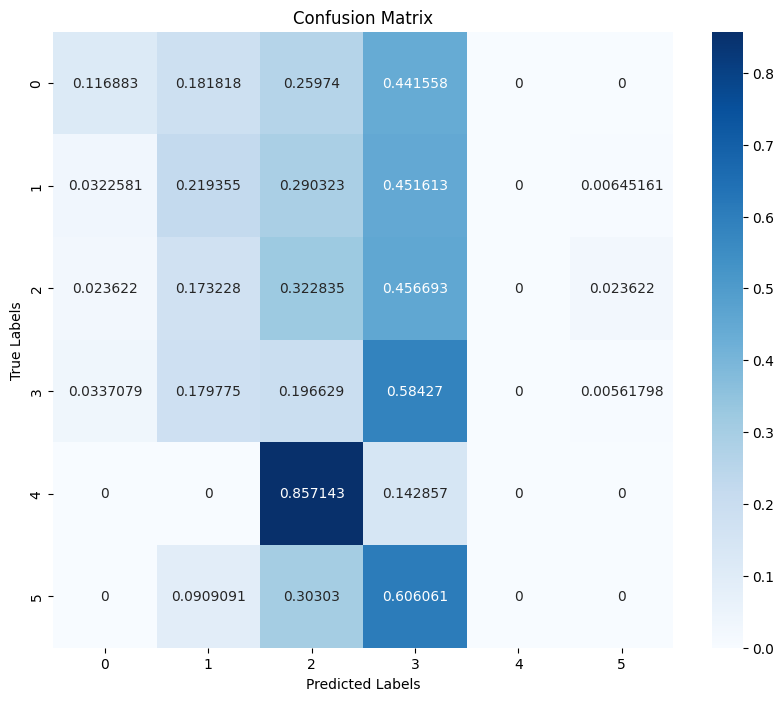

Test Loss: 3.577, Accuracy: 0.326, F1 Score: 0.296, F1 Score Per Class [0.180
Test F1 Score Per Class  [0.18       0.26153846 0.28873239 0.44731183 0.         0.        ]


In [4]:
# Call the main function with the path to folder1
imagesRoot = '/kaggle/input/resizedtreedata/ResizedTreeData'

path_to_images = imagesRoot 
train_loader, val_loader, test_loader = load_data(path_to_images)

def load_pretrained_vit(num_labels):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=num_labels)
    return model

num_classes = 6  # Adjust as per your dataset
num_epochs = 20
# Load the pretrained ResNet-50 model
# model = models.resnet50(pretrained=True)
vit_model = load_pretrained_vit(num_labels=num_classes)

# model.fc = nn.Linear(model.fc.in_features, num_classes)
# Initialize best F1 score for validation

best_val_f1 = 0.0
best_model_weights = None
model_name = 'TreesDelftV001'
trained_model = train_and_evaluate(vit_model, train_loader, val_loader, test_loader, model_name, num_epochs)

Test:   1%|▏         | 1/73 [00:00<00:41,  1.75it/s, loss=4.96]

[tensor([-3.3523, -1.7662, -1.9247,  5.8385, -4.0897, -3.3810], device='cuda:0'), tensor([-2.2871, -1.1043,  4.1951, -2.2121, -3.0046, -3.1494], device='cuda:0'), tensor([-1.7273, -1.5875,  6.4305, -2.4188, -3.1663, -1.7242], device='cuda:0'), tensor([-2.8972,  1.9751, -2.3561, -0.4817, -3.9317, -3.8280], device='cuda:0'), tensor([-1.9859, -1.6410, -2.0582,  6.5117, -3.3404, -3.5717], device='cuda:0'), tensor([-0.4525, -2.0546,  0.3761,  1.5105, -5.0999, -4.4244], device='cuda:0'), tensor([-2.8344, -2.3301, -1.4422,  2.3875, -4.8506, -4.2630], device='cuda:0'), tensor([-2.8830,  0.8243,  0.0343, -2.7544, -4.7341, -3.5279], device='cuda:0')]


Test:   3%|▎         | 2/73 [00:01<00:35,  2.01it/s, loss=3.23]

[tensor([-3.3227, -1.0413, -0.7010, -0.7158, -4.5876, -5.3494], device='cuda:0'), tensor([-2.6125, -2.9297,  4.5952, -0.1358, -3.9628, -3.5365], device='cuda:0'), tensor([-2.3139, -3.4516,  3.3467,  2.2625, -3.7318, -2.8175], device='cuda:0'), tensor([-3.0844, -2.0439, -0.6951,  3.1940, -4.3058, -4.0444], device='cuda:0'), tensor([-1.6209, -3.0511, -0.4172,  2.1133, -4.2689, -3.6410], device='cuda:0'), tensor([-1.5416, -2.5202,  3.7312, -0.6849, -4.7540, -4.0345], device='cuda:0'), tensor([-3.2327, -1.6103, -1.9777,  5.0189, -2.7023, -2.0966], device='cuda:0'), tensor([-3.4671,  3.5605, -1.1344, -0.8554, -4.4456, -2.3588], device='cuda:0')]


Test:   4%|▍         | 3/73 [00:01<00:33,  2.08it/s, loss=4.05]

[tensor([-1.9146, -1.8846,  6.4576, -2.3653, -3.2338, -2.1110], device='cuda:0'), tensor([-1.6778, -0.6850,  2.0260,  0.6670, -5.0613, -4.5389], device='cuda:0'), tensor([-0.1018, -1.5134,  0.6892,  0.5365, -1.3454, -4.3083], device='cuda:0'), tensor([-2.6418, -1.4998, -2.0604,  5.1646, -3.6988, -4.3377], device='cuda:0'), tensor([-3.7033, -0.0750, -1.6947, -1.5476, -2.6816, -2.9494], device='cuda:0'), tensor([-0.7331, -2.0769,  5.2514, -1.6293, -3.4582, -3.4807], device='cuda:0'), tensor([-3.9208,  4.4013, -0.7571,  0.9261, -4.7292, -4.4215], device='cuda:0'), tensor([-2.6424,  6.4652, -0.3904, -1.4269, -4.4251, -3.4313], device='cuda:0')]


Test:   5%|▌         | 4/73 [00:01<00:32,  2.12it/s, loss=3.72]

[tensor([-3.5994, -1.9879,  2.3059,  1.1496, -5.0977, -4.4310], device='cuda:0'), tensor([-3.1604,  2.0740,  2.3857, -1.6736, -4.9592, -4.5071], device='cuda:0'), tensor([-3.0330, -2.0878, -1.5502, -0.9779, -3.8782, -2.7587], device='cuda:0'), tensor([-1.5715, -2.9843, -0.9909,  4.1434, -4.0859, -3.2750], device='cuda:0'), tensor([-4.0111, -1.1711, -1.1678, -0.6674, -3.2226, -4.0283], device='cuda:0'), tensor([-2.6621, -2.0636,  0.9389, -0.1666, -4.8653, -2.7085], device='cuda:0'), tensor([-3.6869,  2.6135, -2.0346,  1.3625, -3.7329, -3.2742], device='cuda:0'), tensor([-1.3691, -3.1190, -1.0855,  4.9948, -4.4801, -4.3691], device='cuda:0')]


Test:   7%|▋         | 5/73 [00:02<00:31,  2.15it/s, loss=3.14]

[tensor([-0.7542, -1.3654, -3.2776,  3.4149, -3.9083, -3.2851], device='cuda:0'), tensor([-2.6409, -2.1756, -1.4385,  5.3722, -4.1165, -2.2406], device='cuda:0'), tensor([ 4.5347, -3.1899, -0.9344,  0.2333, -4.7718, -3.3785], device='cuda:0'), tensor([ 7.3183, -0.6581, -2.5283, -0.9001, -2.5902, -2.1719], device='cuda:0'), tensor([-2.4572, -2.3595, -1.4452,  3.6959, -4.2935, -2.3154], device='cuda:0'), tensor([-2.5261, -1.4819, -1.8059,  5.8210, -3.3840, -3.3051], device='cuda:0'), tensor([-3.6116, -0.9930,  1.5608,  0.3806, -3.5119, -3.3634], device='cuda:0'), tensor([-3.0896,  3.1543,  0.3187, -2.1677, -4.3521, -4.1877], device='cuda:0')]


Test:   8%|▊         | 6/73 [00:02<00:31,  2.16it/s, loss=4.4]

[tensor([-1.5629, -1.1711, -1.6560,  1.5726, -3.5908, -2.9784], device='cuda:0'), tensor([-1.6242, -2.5721,  1.4353, -0.6798, -3.5872, -3.1299], device='cuda:0'), tensor([-2.2522, -2.3818, -1.9030,  6.2178, -1.6554, -3.2493], device='cuda:0'), tensor([-3.3841, -0.3013, -2.5682,  4.4656, -4.9794, -3.1272], device='cuda:0'), tensor([-2.1037,  6.4106, -2.4584, -0.6535, -3.7589, -2.0971], device='cuda:0'), tensor([-1.9253, -2.1207,  6.2400, -1.1929, -3.6516, -3.0489], device='cuda:0'), tensor([-1.9291, -2.6956,  6.7454, -1.6976, -2.5555, -2.7230], device='cuda:0'), tensor([-2.4069,  5.0869,  0.9372, -2.2106, -4.6178, -4.1463], device='cuda:0')]


Test:  10%|▉         | 7/73 [00:03<00:30,  2.18it/s, loss=4.78]

[tensor([-2.7643,  6.4396, -0.5792, -1.1360, -4.1456, -2.7730], device='cuda:0'), tensor([-2.6148,  4.9876, -0.3064, -1.9458, -4.4026, -3.0338], device='cuda:0'), tensor([ 6.2037, -1.6884, -0.8187, -1.7336, -2.7638, -3.0360], device='cuda:0'), tensor([-2.8178, -2.4083,  5.5169, -0.5766, -4.1426, -3.8575], device='cuda:0'), tensor([-4.0152, -0.3677, -2.1583,  4.5830, -4.3955, -3.7305], device='cuda:0'), tensor([-2.6321, -0.9590, -2.0334,  6.3692, -3.4563, -3.0181], device='cuda:0'), tensor([-2.6404, -1.7454,  1.4583,  0.7822, -4.6470, -3.1877], device='cuda:0'), tensor([-2.7534, -2.6530, -0.3067, -0.8361, -4.6924, -4.6636], device='cuda:0')]


Test:  11%|█         | 8/73 [00:03<00:29,  2.18it/s, loss=2.65]

[tensor([-2.1237, -4.0893, -0.0317,  0.7960, -4.1821, -2.6005], device='cuda:0'), tensor([-2.0652,  4.6971, -3.2102,  0.2297, -4.4444, -3.7854], device='cuda:0'), tensor([-1.6397, -1.4605, -1.3470,  5.8718, -4.3818, -4.0976], device='cuda:0'), tensor([-2.7582, -2.3865,  0.8485,  0.9734, -4.5158, -5.0796], device='cuda:0'), tensor([-3.0971, -0.2246, -2.0856,  2.5588, -4.3983, -3.4272], device='cuda:0'), tensor([-2.2568, -1.5517, -2.0968,  6.1079, -3.6596, -2.2352], device='cuda:0'), tensor([-3.6365, -1.9079, -0.8301,  5.1668, -4.8055, -3.1367], device='cuda:0'), tensor([-1.4521, -2.7604,  4.2540, -1.4401, -4.2634, -3.1612], device='cuda:0')]


Test:  12%|█▏        | 9/73 [00:04<00:29,  2.18it/s, loss=2.7]

[tensor([ 1.0629, -2.8853,  0.9207, -1.0615, -4.2000, -3.5419], device='cuda:0'), tensor([-3.2984,  1.0217, -3.2270,  2.5919, -3.3795, -3.7584], device='cuda:0'), tensor([-2.9940, -1.8453,  2.4736,  2.9094, -4.9539, -4.0556], device='cuda:0'), tensor([ 1.6819, -3.2533,  2.9224, -0.6460, -3.6520, -3.4748], device='cuda:0'), tensor([-3.7575, -0.5494, -1.4296,  1.6765, -5.4307, -3.9702], device='cuda:0'), tensor([-3.3899,  0.2859, -0.8579,  1.5196, -4.2636, -5.4940], device='cuda:0'), tensor([-2.8754,  2.4247, -2.4644,  1.6697, -5.3965, -2.9446], device='cuda:0'), tensor([-3.9129, -1.9769,  2.5189,  3.7368, -4.0019, -4.1140], device='cuda:0')]


Test:  14%|█▎        | 10/73 [00:04<00:28,  2.19it/s, loss=5.14]

[tensor([-2.4091,  0.0178,  4.8997, -2.3147, -3.0393, -4.5678], device='cuda:0'), tensor([-3.9212,  0.1228, -0.0697,  2.0976, -5.0622, -3.4026], device='cuda:0'), tensor([-2.5597, -1.0836, -2.5257,  4.3282, -4.7650, -3.4101], device='cuda:0'), tensor([-1.3770, -1.7978, -2.9055,  5.8470, -4.2231, -3.4509], device='cuda:0'), tensor([-1.3993, -1.9920, -2.5244,  4.9272, -4.8412, -4.4905], device='cuda:0'), tensor([-1.8532, -3.1369, -0.9089,  3.7164, -4.0954, -4.7211], device='cuda:0'), tensor([-2.9143, -0.3114,  3.9509, -1.1853, -4.8437, -4.4618], device='cuda:0'), tensor([-0.4577,  3.0511, -2.6619, -1.2131, -4.0986, -4.9706], device='cuda:0')]


Test:  15%|█▌        | 11/73 [00:05<00:28,  2.19it/s, loss=2.29]

[tensor([-3.3129,  0.1038,  0.5089, -2.3186, -4.5322, -4.7546], device='cuda:0'), tensor([-0.2125, -0.4388, -2.0546,  0.1638, -3.0078, -2.6700], device='cuda:0'), tensor([-3.6378,  0.2828,  1.2809, -1.3747, -4.7644, -3.6326], device='cuda:0'), tensor([-2.2984, -2.8615,  3.7970,  2.5550, -3.3992, -4.2621], device='cuda:0'), tensor([-1.8300, -1.9118,  1.5743,  1.3560, -5.2600, -3.7235], device='cuda:0'), tensor([-2.0769, -1.0402, -2.1158,  4.4093, -2.9989, -4.8691], device='cuda:0'), tensor([-3.5670,  1.5873, -1.9675,  2.6500, -4.1887, -4.1730], device='cuda:0'), tensor([-1.9317,  6.4748, -2.0363, -1.0835, -3.5904, -3.4099], device='cuda:0')]


Test:  16%|█▋        | 12/73 [00:05<00:27,  2.18it/s, loss=3.82]

[tensor([-3.1552,  3.8355, -0.7148, -0.3153, -4.6689, -4.1068], device='cuda:0'), tensor([-2.0277, -1.4458, -0.8945,  0.3244, -3.1789, -3.9279], device='cuda:0'), tensor([-2.9117, -1.6458,  1.0455,  3.5974, -5.3116, -4.7240], device='cuda:0'), tensor([-2.9149, -0.9289, -2.1436,  5.2243, -2.9467, -3.7879], device='cuda:0'), tensor([-1.9928,  5.2990, -1.1851, -0.8227, -2.3124, -3.3926], device='cuda:0'), tensor([-1.5984, -1.9388, -1.8558,  6.6089, -3.2839, -3.3558], device='cuda:0'), tensor([-3.9310,  0.5332, -0.5221,  0.9085, -4.8016, -3.3773], device='cuda:0'), tensor([-1.5148, -1.7064, -1.6163,  5.6364, -4.2537, -4.4386], device='cuda:0')]


Test:  18%|█▊        | 13/73 [00:06<00:27,  2.17it/s, loss=3.29]

[tensor([-3.3756,  4.6192, -0.1405, -0.5640, -5.0109, -4.3303], device='cuda:0'), tensor([-4.4449, -0.9425, -1.2877,  0.3492, -4.5618, -2.2029], device='cuda:0'), tensor([-3.7699, -0.9277, -0.4769,  3.2276, -5.6215, -2.6705], device='cuda:0'), tensor([-2.8333, -1.9984,  5.1012, -1.6091, -2.0721, -2.2518], device='cuda:0'), tensor([-3.4486,  4.7178, -0.2988, -1.2557, -4.1733, -3.7060], device='cuda:0'), tensor([-3.2064,  0.1269, -1.2573,  2.5806, -4.8171, -3.5636], device='cuda:0'), tensor([-1.8613, -3.2817,  1.8616,  2.0413, -3.2327, -3.3272], device='cuda:0'), tensor([-3.0004, -1.2440, -0.6926,  1.0092, -5.4817, -4.7325], device='cuda:0')]


Test:  19%|█▉        | 14/73 [00:06<00:27,  2.17it/s, loss=5.25]

[tensor([-3.1727, -3.4473,  3.5304,  0.7093, -3.1187, -1.4841], device='cuda:0'), tensor([-3.3797, -1.9209, -1.0865,  5.8016, -3.8125, -3.1694], device='cuda:0'), tensor([ 7.3894, -1.5942, -2.4509, -1.0864, -1.6254, -1.1242], device='cuda:0'), tensor([-2.7908, -2.7890, -0.8251,  0.3542, -4.8329, -4.0094], device='cuda:0'), tensor([-2.7896, -1.6625, -3.0841,  5.7057, -3.5017, -2.3295], device='cuda:0'), tensor([-2.6793, -2.0922,  3.8248, -1.8571, -3.8951, -1.9077], device='cuda:0'), tensor([-3.1619,  4.9525, -2.2384, -1.1197, -4.3990, -2.6825], device='cuda:0'), tensor([-1.0420, -2.9782, -2.0382,  3.0904, -4.7874, -4.3517], device='cuda:0')]


Test:  21%|██        | 15/73 [00:06<00:26,  2.16it/s, loss=4.29]

[tensor([-2.9770,  2.5158, -2.8326,  3.1586, -3.0464, -4.3557], device='cuda:0'), tensor([-2.6011, -2.1700, -1.4506,  6.3249, -3.8376, -3.1002], device='cuda:0'), tensor([-2.5375, -1.0947, -1.8865,  6.1637, -3.7289, -3.8660], device='cuda:0'), tensor([-1.7059, -3.2194,  5.0087, -0.9721, -4.0034, -2.1147], device='cuda:0'), tensor([-1.1883, -2.5734, -1.7424,  3.9244, -3.9598, -3.5667], device='cuda:0'), tensor([-2.3407, -3.4204,  2.0503,  2.0635, -4.4311, -3.6750], device='cuda:0'), tensor([-2.5107, -2.4027, -2.1689,  6.5345, -3.3535, -2.9275], device='cuda:0'), tensor([-2.0630, -2.4435, -1.9113,  5.7560, -4.4408, -3.5244], device='cuda:0')]


Test:  22%|██▏       | 16/73 [00:07<00:26,  2.14it/s, loss=2.65]

[tensor([-1.9666,  2.4255, -1.8235,  1.0658, -4.0756, -3.5206], device='cuda:0'), tensor([-3.1530, -1.0149,  5.7138, -2.7807, -3.2667, -3.0142], device='cuda:0'), tensor([-1.9935, -1.9163, -1.5331,  6.4755, -4.2040, -2.9346], device='cuda:0'), tensor([-2.7076, -2.5275,  5.8265, -0.4152, -3.2418, -2.6825], device='cuda:0'), tensor([-1.5142, -1.0421, -1.5557,  0.9441, -3.9092, -5.1490], device='cuda:0'), tensor([-2.4332, -0.0267, -2.3366,  0.0390, -3.9132, -3.9953], device='cuda:0'), tensor([-3.1515, -2.8228,  4.4256,  1.9631, -3.1597, -3.9647], device='cuda:0'), tensor([-1.8039, -2.3538,  1.9991,  0.4765, -5.1475, -5.3195], device='cuda:0')]


Test:  23%|██▎       | 17/73 [00:07<00:26,  2.13it/s, loss=3.14]

[tensor([ 0.1000, -0.9901,  0.2537, -1.8451, -5.1067, -4.0553], device='cuda:0'), tensor([-2.6146,  1.0186,  2.7716, -2.4023, -4.4526, -3.6778], device='cuda:0'), tensor([ 0.5836, -2.4241, -3.2649,  4.8314, -4.1602, -3.2153], device='cuda:0'), tensor([-3.2329, -1.9642, -1.3237,  5.7905, -3.0850, -3.2827], device='cuda:0'), tensor([-2.6591,  1.1290,  3.1565, -1.6388, -4.7225, -3.0510], device='cuda:0'), tensor([-3.2715, -1.4592, -2.4007,  2.2253, -5.5919, -4.7301], device='cuda:0'), tensor([-2.4395, -2.1464, -0.1828,  3.0396, -6.0398, -4.9281], device='cuda:0'), tensor([-3.2651, -2.8973,  4.2007,  2.7460, -4.7376, -3.8841], device='cuda:0')]


Test:  25%|██▍       | 18/73 [00:08<00:26,  2.11it/s, loss=4.58]

[tensor([-2.4723, -2.3235,  5.0759, -1.2952, -5.1649, -2.2891], device='cuda:0'), tensor([-2.2212, -1.6801, -2.7670,  6.3530, -3.5378, -1.8458], device='cuda:0'), tensor([-3.1417,  0.0454, -0.5797, -0.3816, -5.4133, -4.6571], device='cuda:0'), tensor([-3.8014,  0.3857, -1.2491,  2.2961, -3.6524, -4.2871], device='cuda:0'), tensor([-4.0289,  4.3558, -1.8094, -0.1225, -3.6252, -4.0049], device='cuda:0'), tensor([-1.8103, -2.5081,  6.7235, -0.8686, -3.1517, -2.8318], device='cuda:0'), tensor([-2.4336, -2.1418, -0.8583,  4.3887, -3.3836, -4.0928], device='cuda:0'), tensor([-3.3363,  1.6802, -0.6531, -2.5442, -5.4423, -3.7704], device='cuda:0')]


Test:  26%|██▌       | 19/73 [00:08<00:25,  2.10it/s, loss=3.19]

[tensor([-0.1026, -3.0832, -1.8145,  4.8916, -4.8997, -3.4679], device='cuda:0'), tensor([-3.3534,  0.3197, -2.1582,  0.5363, -4.2009, -4.0194], device='cuda:0'), tensor([-2.8435, -0.0839,  5.6327, -2.3345, -3.4131, -3.3119], device='cuda:0'), tensor([-3.1255, -0.6483,  0.3562, -0.9938, -4.6217, -3.7838], device='cuda:0'), tensor([-2.7637, -1.1078, -0.2708,  0.2237, -4.6552, -5.2191], device='cuda:0'), tensor([-3.0444,  0.7126, -0.4106, -0.0744, -3.8789, -5.3304], device='cuda:0'), tensor([-2.5687, -2.6229,  0.2401,  2.5417, -4.8802, -3.4724], device='cuda:0'), tensor([-1.6755,  0.3554,  0.9385, -2.1104, -2.6299, -3.1753], device='cuda:0')]


Test:  27%|██▋       | 20/73 [00:09<00:25,  2.11it/s, loss=3.49]

[tensor([-2.2230,  2.6722, -2.6661, -0.9678, -3.7301, -2.6629], device='cuda:0'), tensor([-1.3812,  1.8946, -1.4815, -0.8777, -5.2462, -5.7685], device='cuda:0'), tensor([-3.5259,  1.6102, -0.9364,  0.5597, -4.1435, -5.3378], device='cuda:0'), tensor([-0.1481,  0.9401, -3.2044, -0.5419, -4.7586, -2.9181], device='cuda:0'), tensor([-2.3378,  4.7456, -1.3994, -1.7954, -3.4112, -3.2232], device='cuda:0'), tensor([-0.8360, -0.2484, -2.6979, -0.2403, -5.1422, -4.8684], device='cuda:0'), tensor([-2.2946,  5.2179, -1.1049, -1.1458, -2.6804, -3.3773], device='cuda:0'), tensor([-3.2475, -1.1212, -0.8652,  4.4479, -3.7821, -3.5211], device='cuda:0')]


Test:  29%|██▉       | 21/73 [00:09<00:24,  2.10it/s, loss=4.28]

[tensor([-1.9999,  1.6401,  2.4454, -2.9687, -3.4953, -3.3419], device='cuda:0'), tensor([-2.4244, -1.4556,  5.9507, -2.2748, -3.6450, -3.0515], device='cuda:0'), tensor([-3.5673,  2.5733, -2.2151,  0.2744, -5.5241, -4.1852], device='cuda:0'), tensor([-3.4993, -1.6405, -0.3824,  1.1786, -4.9324, -2.2026], device='cuda:0'), tensor([-2.9396, -0.8907,  0.9551,  1.5999, -3.8263, -4.6686], device='cuda:0'), tensor([-2.7866,  4.7007, -0.1551, -1.5167, -5.3804, -3.8235], device='cuda:0'), tensor([-0.8744,  6.2467, -2.8014, -0.9594, -3.2852, -2.8094], device='cuda:0'), tensor([-1.6862, -1.9574, -2.4278,  6.0937, -3.4107, -2.0572], device='cuda:0')]


Test:  30%|███       | 22/73 [00:10<00:24,  2.10it/s, loss=2.61]

[tensor([-2.1984,  6.8562, -1.6362, -1.8294, -3.5034, -2.7744], device='cuda:0'), tensor([-2.1481, -2.3582,  6.7306, -0.8564, -3.0383, -2.7007], device='cuda:0'), tensor([-2.1641, -2.4080,  0.2482,  4.4132, -6.2399, -4.0632], device='cuda:0'), tensor([-3.7829, -1.3837, -1.4483,  4.0863, -4.8473, -4.5453], device='cuda:0'), tensor([-1.7500,  0.8632, -1.5838,  1.7376, -4.4660, -3.6070], device='cuda:0'), tensor([ 2.6863, -2.0789, -3.1023,  1.2550, -4.6389, -4.3118], device='cuda:0'), tensor([-2.9493, -0.6087, -1.3166,  3.5812, -5.0673, -5.2489], device='cuda:0'), tensor([-2.8753, -0.6733, -1.7720,  2.3334, -3.3559, -3.8580], device='cuda:0')]


Test:  32%|███▏      | 23/73 [00:10<00:23,  2.10it/s, loss=2.87]

[tensor([-2.0331, -2.1296,  6.2567, -1.1545, -3.1426, -4.1395], device='cuda:0'), tensor([-3.4588, -1.5867,  0.5095,  3.2002, -4.6057, -4.4413], device='cuda:0'), tensor([-2.4796, -0.5055, -2.0093,  4.9550, -4.1392, -3.2784], device='cuda:0'), tensor([ 0.9960, -0.9955,  1.5399, -0.6143, -4.5506, -5.5608], device='cuda:0'), tensor([-3.0072, -3.1302,  4.9345, -0.0466, -3.6583, -2.5348], device='cuda:0'), tensor([-3.1825,  0.7901,  0.9459, -0.9015, -4.7043, -3.5333], device='cuda:0'), tensor([ 3.7480,  0.1856, -2.2319, -2.2854, -3.6728, -3.0855], device='cuda:0'), tensor([-2.6500,  0.5503,  2.5571, -2.0256, -4.5826, -3.9272], device='cuda:0')]


Test:  33%|███▎      | 24/73 [00:11<00:23,  2.09it/s, loss=5.66]

[tensor([-2.2098, -1.4061, -2.1195,  5.9664, -2.6665, -1.7855], device='cuda:0'), tensor([-2.5059, -3.4027,  1.6712,  2.3431, -3.3979, -3.2839], device='cuda:0'), tensor([-1.6067, -1.6677, -1.4431,  2.7503, -6.5556, -4.4595], device='cuda:0'), tensor([-2.8557,  5.8005, -2.5773, -2.0896, -4.4021, -1.0425], device='cuda:0'), tensor([-2.4299, -3.0404, -1.8157,  4.9795, -3.4831, -3.0573], device='cuda:0'), tensor([-2.6844,  2.5517, -3.5619, -0.9867, -4.5431, -1.1584], device='cuda:0'), tensor([-3.0419,  0.0353, -1.7257,  0.3404, -4.2677, -3.9157], device='cuda:0'), tensor([ 5.6535, -1.5080, -1.8977, -0.9474, -3.2382, -4.4430], device='cuda:0')]


Test:  34%|███▍      | 25/73 [00:11<00:23,  2.07it/s, loss=2.74]

[tensor([-2.9828, -1.7593,  6.1863, -1.2887, -2.7268, -2.9128], device='cuda:0'), tensor([-4.1992,  1.9367, -0.9133, -0.6681, -4.4358, -5.1516], device='cuda:0'), tensor([-2.9802, -1.3160, -1.5726,  3.8682, -3.7699, -4.9521], device='cuda:0'), tensor([-3.0325,  1.7055, -1.2039,  0.1734, -4.0151, -4.7569], device='cuda:0'), tensor([-3.0382,  0.2517, -0.5847,  0.0669, -4.6512, -4.2559], device='cuda:0'), tensor([-3.3639,  5.5392, -0.2451, -1.3326, -4.4187, -4.1181], device='cuda:0'), tensor([-2.2484,  0.7379, -1.4814,  0.1943, -3.7890, -5.4423], device='cuda:0'), tensor([-0.4580,  0.9729, -0.7766, -0.6667, -3.6177, -3.6205], device='cuda:0')]


Test:  36%|███▌      | 26/73 [00:12<00:22,  2.06it/s, loss=1.6]

[tensor([-3.5496, -0.3603, -1.2437, -0.5614, -6.4960, -2.3778], device='cuda:0'), tensor([-2.7600,  4.5532, -2.6925, -1.2584, -3.6060, -2.8916], device='cuda:0'), tensor([-0.6914, -2.7430, -1.1772, -0.7347, -3.9926, -4.0466], device='cuda:0'), tensor([-2.1316, -3.3540, -0.0215, -1.4952, -3.8983, -3.2111], device='cuda:0'), tensor([-2.1440, -0.8169, -0.7725, -1.6619, -4.3163, -3.8506], device='cuda:0'), tensor([-2.7802, -1.2437, -1.0591,  0.7018, -2.7701, -5.3752], device='cuda:0'), tensor([-2.8947,  2.0366, -2.3506,  3.9095, -4.4590, -5.0612], device='cuda:0'), tensor([-2.1980,  4.4258, -1.4074, -0.8539, -4.5837, -3.7583], device='cuda:0')]


Test:  37%|███▋      | 27/73 [00:12<00:22,  2.06it/s, loss=4.17]

[tensor([-2.4066,  6.9334, -1.3058, -1.4388, -3.0704, -2.7138], device='cuda:0'), tensor([-3.2444,  0.6902, -2.1902,  2.6115, -3.5658, -3.7047], device='cuda:0'), tensor([-3.9352, -1.0161,  3.4293, -2.0022, -4.2933, -3.6356], device='cuda:0'), tensor([-4.3536, -0.8699, -1.6166, -0.6138, -4.2696, -1.2670], device='cuda:0'), tensor([-2.1877, -2.1101,  4.6279, -2.4275, -5.2580, -3.6702], device='cuda:0'), tensor([-2.0709, -2.2804,  6.7776, -1.3080, -3.2848, -3.2538], device='cuda:0'), tensor([-2.0563, -2.6559,  3.7214, -1.6053, -4.2280, -3.9686], device='cuda:0'), tensor([-2.5758, -3.0300,  3.6680,  1.2804, -4.0336, -3.6134], device='cuda:0')]


Test:  38%|███▊      | 28/73 [00:13<00:21,  2.06it/s, loss=2.19]

[tensor([-3.8583,  2.3790, -1.0700, -0.0967, -4.4195, -4.5904], device='cuda:0'), tensor([-3.5233,  3.0354,  1.4169,  1.3808, -4.6221, -4.8658], device='cuda:0'), tensor([-3.5791,  0.1565, -1.9623,  1.3153, -4.7908, -4.7390], device='cuda:0'), tensor([-2.4892, -1.2194, -2.9157,  4.6698, -4.1564, -3.0598], device='cuda:0'), tensor([-1.8052, -1.9375, -1.1452,  5.8058, -4.2019, -3.9635], device='cuda:0'), tensor([-2.5868, -1.4268,  5.5273, -1.9322, -3.3818, -3.6172], device='cuda:0'), tensor([-2.4976, -3.8544,  3.3065,  0.5972, -3.8850, -2.2186], device='cuda:0'), tensor([-0.3751,  6.5687, -1.5440, -2.3154, -3.4737, -2.8880], device='cuda:0')]


Test:  40%|███▉      | 29/73 [00:13<00:21,  2.06it/s, loss=3.97]

[tensor([-3.0106, -2.4024,  1.7015,  0.2844, -4.4392, -3.7580], device='cuda:0'), tensor([-3.2211, -2.0697,  0.0472,  0.5182, -4.0161, -2.3397], device='cuda:0'), tensor([-3.6566, -0.5734,  1.6199,  0.7390, -4.4470, -4.8209], device='cuda:0'), tensor([-0.2704,  1.0026, -2.3996, -0.5319, -5.2523, -5.5752], device='cuda:0'), tensor([-2.0614, -2.0575,  6.5680, -1.5862, -2.5797, -2.1424], device='cuda:0'), tensor([-3.0710, -3.6269,  2.4543,  1.2819, -2.3389, -1.9177], device='cuda:0'), tensor([-2.8593, -0.1697,  4.2154, -1.8612, -2.7546, -3.4728], device='cuda:0'), tensor([-3.7720, -1.7690,  5.0209, -0.3862, -3.4342, -4.5247], device='cuda:0')]


Test:  41%|████      | 30/73 [00:14<00:20,  2.05it/s, loss=4.93]

[tensor([-2.6538,  5.9697, -2.1056, -0.5061, -4.4155, -3.3584], device='cuda:0'), tensor([-1.3202, -2.0828,  6.6941, -1.7420, -3.0653, -2.1672], device='cuda:0'), tensor([-0.3999, -2.7074, -1.6303,  1.2516, -3.9151, -4.2900], device='cuda:0'), tensor([-3.1369, -0.2097, -1.2324,  0.8387, -5.3943, -0.1512], device='cuda:0'), tensor([-3.0105, -1.0634, -2.1140,  6.1167, -4.3023, -2.8518], device='cuda:0'), tensor([-2.3013,  0.0865,  0.0107,  0.6202, -4.5376, -5.7097], device='cuda:0'), tensor([-2.3462, -1.7986, -1.5926,  6.1835, -3.5424, -4.3404], device='cuda:0'), tensor([-3.0504,  5.5847, -2.0269, -0.0558, -4.7520, -3.8739], device='cuda:0')]


Test:  42%|████▏     | 31/73 [00:14<00:20,  2.05it/s, loss=3.02]

[tensor([-2.4413, -3.1953, -1.3607,  6.0213, -4.0857, -1.9575], device='cuda:0'), tensor([-2.3511,  6.2184, -0.8447, -1.4107, -4.2801, -3.7634], device='cuda:0'), tensor([-3.1025, -1.4629,  3.8831, -0.1548, -3.3627, -3.1456], device='cuda:0'), tensor([-3.2982,  4.0916, -2.5870,  1.9608, -4.1053, -3.5201], device='cuda:0'), tensor([-3.0909,  4.8484, -0.9918, -1.0607, -4.4005, -5.2710], device='cuda:0'), tensor([-2.6670, -1.7170, -1.7116,  3.5943, -3.6872, -4.0349], device='cuda:0'), tensor([-2.2260, -2.6672, -1.8275,  5.6466, -4.1550, -4.3839], device='cuda:0'), tensor([-2.0919,  3.9098, -1.3558, -0.1519, -4.4411, -4.9509], device='cuda:0')]


Test:  44%|████▍     | 32/73 [00:15<00:19,  2.05it/s, loss=4.52]

[tensor([-1.9700, -2.3520,  6.9532, -1.0618, -2.9201, -2.6127], device='cuda:0'), tensor([-2.1232, -1.3333,  1.4900,  0.4834, -4.6021, -4.8503], device='cuda:0'), tensor([-1.9309, -1.5945, -1.8110,  1.3175, -3.7761, -4.6114], device='cuda:0'), tensor([-2.3967,  4.4272, -1.3303, -0.8431, -4.3621, -4.3761], device='cuda:0'), tensor([-3.2060, -2.1569, -1.5093,  5.2517, -5.1999, -1.8603], device='cuda:0'), tensor([-3.2093,  0.1884,  2.3696, -1.9507, -5.2188, -4.2214], device='cuda:0'), tensor([-4.3841,  2.1480,  1.8775,  0.7015, -4.8182, -4.5897], device='cuda:0'), tensor([-2.2168, -2.1436, -1.4076,  5.8266, -3.7749, -3.5811], device='cuda:0')]


Test:  45%|████▌     | 33/73 [00:15<00:19,  2.05it/s, loss=3.73]

[tensor([-2.9408, -0.5904, -1.9120,  3.9514, -4.8319, -5.8339], device='cuda:0'), tensor([-2.1933, -1.4864,  5.1222, -0.0499, -4.0449, -4.8134], device='cuda:0'), tensor([ 3.3028, -3.5650, -0.3691,  0.3748, -5.0131, -3.3970], device='cuda:0'), tensor([-3.0430, -1.6406,  4.5830,  0.5165, -4.2267, -4.6577], device='cuda:0'), tensor([-3.5502, -2.0718,  2.4072,  2.3047, -4.9210, -4.2450], device='cuda:0'), tensor([-1.6277, -0.2717, -4.1824,  1.7391, -4.8677, -0.5201], device='cuda:0'), tensor([-2.6822, -2.3640,  6.1532, -0.3997, -2.9439, -2.7719], device='cuda:0'), tensor([-2.3123, -0.9576, -2.6438,  6.4450, -3.9159, -3.1266], device='cuda:0')]


Test:  47%|████▋     | 34/73 [00:16<00:19,  2.04it/s, loss=2.73]

[tensor([-3.5113, -1.1754, -0.4616,  3.9075, -5.6221, -4.6319], device='cuda:0'), tensor([-2.9684, -2.6470,  2.0696,  4.1829, -3.6515, -2.8997], device='cuda:0'), tensor([-1.5772, -1.0768, -2.2414,  4.1211, -4.3816, -4.7626], device='cuda:0'), tensor([-1.6719, -1.9440,  0.1319,  0.5268, -3.9895, -2.8795], device='cuda:0'), tensor([-1.6788, -1.8019, -1.8178,  6.5618, -3.5100, -2.8313], device='cuda:0'), tensor([-1.7351, -2.3382,  2.7493, -1.1063, -3.7323, -5.0650], device='cuda:0'), tensor([-2.7695, -0.9544,  6.4234, -2.1409, -2.7002, -3.1201], device='cuda:0'), tensor([ 0.3396, -3.5268, -0.6574,  1.3033, -3.9111, -3.4373], device='cuda:0')]


Test:  48%|████▊     | 35/73 [00:16<00:18,  2.04it/s, loss=2.94]

[tensor([-0.4554,  2.9325, -2.1302, -1.4431, -5.2000, -3.4917], device='cuda:0'), tensor([-1.5481, -2.5303,  6.7622, -1.2565, -2.4112, -1.9145], device='cuda:0'), tensor([-1.8902, -3.4884, -0.0834,  2.7293, -5.1426, -3.9304], device='cuda:0'), tensor([-2.3268, -1.3241, -2.8207,  6.1668, -2.4589, -2.9914], device='cuda:0'), tensor([-3.2517,  2.0267, -0.9159, -1.5851, -4.3925, -2.5929], device='cuda:0'), tensor([-3.6010, -0.9256, -0.2835,  4.2153, -4.4803, -4.4716], device='cuda:0'), tensor([-1.6340, -1.7379, -1.0544,  6.0879, -3.9510, -4.2561], device='cuda:0'), tensor([-2.0767, -2.3787,  6.7715, -0.7198, -2.8348, -2.2733], device='cuda:0')]


Test:  49%|████▉     | 36/73 [00:17<00:18,  2.03it/s, loss=4.08]

[tensor([-3.2516,  2.5781, -0.8765, -1.5106, -4.5347, -4.9487], device='cuda:0'), tensor([-2.8446, -0.6545,  3.2390, -2.1275, -3.7075, -3.8504], device='cuda:0'), tensor([-2.9764, -2.4268, -0.8714,  2.4737, -4.2378, -2.7093], device='cuda:0'), tensor([-3.1819, -2.2496, -1.0081,  3.0950, -4.6228, -4.4117], device='cuda:0'), tensor([-2.0498, -0.0505, -1.9060,  0.4671, -4.6600, -4.4631], device='cuda:0'), tensor([-0.5083, -0.0924, -2.5883,  1.4666, -4.3540, -4.6855], device='cuda:0'), tensor([-2.5214, -1.8045, -1.8332,  6.4242, -3.6327, -2.9778], device='cuda:0'), tensor([-2.5978,  0.7274, -2.7795,  4.6937, -4.7577, -4.0567], device='cuda:0')]


Test:  51%|█████     | 37/73 [00:17<00:17,  2.08it/s, loss=4.26]

[tensor([-3.5011, -2.1203, -2.6857,  3.8263, -4.9145, -3.8699], device='cuda:0'), tensor([-2.2110, -0.9444, -1.6500,  4.5965, -3.8983, -3.0728], device='cuda:0'), tensor([-3.8544,  0.2001,  2.3718,  0.1651, -5.5929, -3.5884], device='cuda:0'), tensor([-2.3802, -0.0505, -1.4242,  1.4556, -4.9828, -4.4856], device='cuda:0'), tensor([-3.0278,  5.2780, -2.9553,  0.1482, -4.3244, -3.0280], device='cuda:0'), tensor([-3.0361, -2.5520,  5.3921, -1.0125, -3.1064, -3.2057], device='cuda:0'), tensor([-3.1218, -3.0538, -0.1870,  0.4597, -3.7539, -3.3651], device='cuda:0'), tensor([-3.2639, -1.2460, -2.0348,  5.2278, -3.7594, -1.5255], device='cuda:0')]


Test:  52%|█████▏    | 38/73 [00:18<00:16,  2.06it/s, loss=2.76]

[tensor([-3.7718,  3.2180, -0.7698, -0.8761, -3.9412, -4.3668], device='cuda:0'), tensor([ 0.6893, -3.4068,  3.0024, -0.6667, -3.3240, -3.0672], device='cuda:0'), tensor([-1.7033, -2.7515,  6.4574, -0.7978, -3.0488, -2.9576], device='cuda:0'), tensor([-1.5181, -1.4390, -2.7708,  3.8407, -4.8279, -4.0824], device='cuda:0'), tensor([-2.5556,  5.4267, -1.9906, -0.6713, -3.6790, -3.3894], device='cuda:0'), tensor([-1.6747,  1.3290, -3.3290, -1.0590, -4.8192, -2.5812], device='cuda:0'), tensor([-3.4296,  0.6927, -2.2635,  2.6862, -4.0278, -3.8870], device='cuda:0'), tensor([-1.5817, -3.4524,  3.5811, -1.0935, -4.3565, -3.9590], device='cuda:0')]


Test:  53%|█████▎    | 39/73 [00:18<00:16,  2.04it/s, loss=2.84]

[tensor([-3.2988, -2.3893,  0.9014,  0.8394, -5.1595, -4.4475], device='cuda:0'), tensor([-1.7412,  6.9160, -1.7987, -2.0315, -3.0055, -1.6878], device='cuda:0'), tensor([-2.4444,  4.3935, -4.0764,  1.7124, -3.8139, -2.7292], device='cuda:0'), tensor([-2.8257,  1.8465,  0.7926, -0.6157, -4.8875, -4.7917], device='cuda:0'), tensor([-0.8303, -0.5133, -1.3108, -3.6128, -3.8218,  4.1344], device='cuda:0'), tensor([-3.7376, -1.7678,  2.1409,  0.5930, -3.3181, -4.1754], device='cuda:0'), tensor([-2.1460,  2.4546, -1.2058, -2.0217, -3.7588, -4.0062], device='cuda:0'), tensor([-1.6037,  5.6449, -2.6031, -0.2767, -4.1632, -4.0941], device='cuda:0')]


Test:  55%|█████▍    | 40/73 [00:19<00:16,  2.03it/s, loss=4.15]

[tensor([-2.7019, -2.5806, -1.7046, -0.8817, -3.4810, -3.0298], device='cuda:0'), tensor([-3.5779, -0.5310,  1.6926, -1.6597, -4.4739, -0.7635], device='cuda:0'), tensor([-4.3193,  0.5066,  0.6198, -2.2771, -4.8078, -0.9712], device='cuda:0'), tensor([-2.7672, -3.1549,  2.5121,  3.2750, -3.8612, -4.3352], device='cuda:0'), tensor([-3.5261, -0.7500,  1.5988, -0.4100, -5.2354, -4.9704], device='cuda:0'), tensor([-3.6329, -0.6275, -1.3963, -0.2030, -3.7553, -3.4090], device='cuda:0'), tensor([-1.9702,  6.4972, -2.3105, -1.4224, -3.8333, -2.9709], device='cuda:0'), tensor([-2.1086, -1.1687, -2.6429,  4.5545, -4.9292, -4.0594], device='cuda:0')]


Test:  56%|█████▌    | 41/73 [00:19<00:15,  2.01it/s, loss=4.36]

[tensor([-1.2882, -2.4489, -0.8782,  4.7978, -4.0231, -3.9977], device='cuda:0'), tensor([-1.1419,  1.9612, -1.7056, -0.9943, -4.0433, -3.7454], device='cuda:0'), tensor([-2.6947, -2.2981, -0.7810,  3.3332, -3.8986, -3.5540], device='cuda:0'), tensor([-1.6871, -1.3094, -2.1660,  6.6153, -3.4192, -3.6032], device='cuda:0'), tensor([-1.8743, -1.8998, -3.9860,  1.1442, -4.5610, -0.9806], device='cuda:0'), tensor([-2.7975, -1.5131, -1.9907,  5.8678, -3.8128, -2.9744], device='cuda:0'), tensor([-2.9095, -2.1363, -0.7121,  5.3707, -4.1819, -3.9797], device='cuda:0'), tensor([-3.7110, -0.7140, -2.2588,  4.3709, -3.8862, -3.3536], device='cuda:0')]


Test:  58%|█████▊    | 42/73 [00:20<00:15,  2.01it/s, loss=2.53]

[tensor([-2.3334, -1.2663, -2.2097,  5.3234, -2.2883, -3.5702], device='cuda:0'), tensor([-2.0457, -0.1421, -2.7542,  2.0734, -2.1219, -4.9794], device='cuda:0'), tensor([-3.2675, -0.6459,  1.4562, -1.6119, -4.8576, -3.5309], device='cuda:0'), tensor([-2.9274, -2.3001,  2.6262, -0.9939, -5.2114, -4.4785], device='cuda:0'), tensor([-3.6480, -1.1691, -0.4272,  2.7486, -3.2502, -2.1236], device='cuda:0'), tensor([-2.7291, -1.9597, -0.1306,  3.2579, -3.7498, -4.4670], device='cuda:0'), tensor([-1.0313, -2.3721, -2.6904,  4.4932, -4.4034, -3.1423], device='cuda:0'), tensor([-3.2875,  3.6197, -2.7448,  0.8782, -3.1553, -3.1157], device='cuda:0')]


Test:  59%|█████▉    | 43/73 [00:20<00:14,  2.00it/s, loss=4.49]

[tensor([-3.9332,  0.2008,  1.1537, -1.2123, -5.7008, -3.8008], device='cuda:0'), tensor([-2.7623, -1.4623, -1.8811, -0.9841, -5.3550, -4.2710], device='cuda:0'), tensor([-3.2220, -0.1668, -3.1620,  4.8776, -3.4371, -3.7324], device='cuda:0'), tensor([-1.1733, -0.4695, -1.0049,  0.5929, -4.5140, -5.1671], device='cuda:0'), tensor([-3.4791,  2.0001, -1.0704, -1.4367, -4.8373, -5.0147], device='cuda:0'), tensor([-2.4366, -1.9137, -1.7760,  6.5917, -3.2394, -2.9971], device='cuda:0'), tensor([-2.7943, -0.7066,  6.5874, -1.7838, -3.4444, -3.3121], device='cuda:0'), tensor([-2.3329, -0.7088,  5.1047, -2.5957, -3.9334, -0.5998], device='cuda:0')]


Test:  60%|██████    | 44/73 [00:21<00:14,  2.00it/s, loss=5.14]

[tensor([-1.7111, -0.1236, -2.8458,  4.7528, -3.1802, -4.8170], device='cuda:0'), tensor([-3.2721,  2.9290, -2.3779, -1.3452, -4.1839, -1.8277], device='cuda:0'), tensor([-3.2580, -2.3489,  1.6178, -0.2295, -4.8799, -3.1520], device='cuda:0'), tensor([-2.9858, -1.6274, -1.9069,  6.3305, -3.7694, -3.7752], device='cuda:0'), tensor([-1.2641,  4.7318, -2.8965, -0.3795, -3.5661, -4.2451], device='cuda:0'), tensor([-2.6531, -0.5159, -2.5855,  6.0857, -4.3212, -3.4353], device='cuda:0'), tensor([-4.2503, -0.2511, -0.3691,  2.3989, -4.5595, -3.4308], device='cuda:0'), tensor([-3.4643,  1.7274,  1.7753, -0.9351, -4.8905, -5.0291], device='cuda:0')]


Test:  62%|██████▏   | 45/73 [00:21<00:14,  2.00it/s, loss=3.16]

[tensor([-2.0241, -2.5198,  5.3414, -0.3243, -3.1020, -2.8027], device='cuda:0'), tensor([-3.1487, -1.7567, -1.6199, -0.2962, -5.6982, -3.9280], device='cuda:0'), tensor([-2.3031, -3.2294, -1.3168,  1.7232, -3.8179, -3.5824], device='cuda:0'), tensor([-1.7433, -3.2958, -0.5854,  3.4531, -4.0800, -3.4561], device='cuda:0'), tensor([-3.6966, -0.6440,  1.9221, -0.2105, -5.0594, -2.3212], device='cuda:0'), tensor([-2.7294, -3.0802,  0.3570,  5.5781, -3.9256, -3.2665], device='cuda:0'), tensor([ 6.0578, -0.7856, -1.3788, -1.0379, -2.4798, -2.3069], device='cuda:0'), tensor([-3.2403, -0.3066, -0.8362,  2.8467, -4.6084, -4.2960], device='cuda:0')]


Test:  63%|██████▎   | 46/73 [00:22<00:13,  1.99it/s, loss=3.85]

[tensor([-4.4053,  1.1806, -1.0679,  2.8349, -4.5483, -4.4860], device='cuda:0'), tensor([-1.9126, -2.3749, -2.6063, -0.4001, -3.1948,  6.1375], device='cuda:0'), tensor([-3.5286, -1.5614,  4.7911,  1.1723, -3.9328, -4.3758], device='cuda:0'), tensor([-2.1719, -1.1953, -2.2352,  5.3542, -3.5823, -4.8638], device='cuda:0'), tensor([-0.7590, -0.6927, -3.7699,  2.2389, -1.7067, -2.9335], device='cuda:0'), tensor([ 4.3482, -2.4097, -1.4638, -0.8203, -5.5554, -1.5377], device='cuda:0'), tensor([-2.9850,  0.4764, -2.0553,  3.7549, -4.6099, -4.3998], device='cuda:0'), tensor([-2.1647, -2.4330, -1.5525,  5.7920, -3.9122, -3.2606], device='cuda:0')]


Test:  64%|██████▍   | 47/73 [00:22<00:13,  1.98it/s, loss=4.7]

[tensor([-2.9947, -1.5767,  6.1072, -1.8882, -3.9911, -1.9082], device='cuda:0'), tensor([-2.8521, -0.0077,  1.6792, -1.3343, -4.4112, -5.1154], device='cuda:0'), tensor([-3.6343,  2.1556, -2.1329,  2.1121, -5.1250, -3.2713], device='cuda:0'), tensor([-2.0640, -2.6662,  5.6433, -0.0096, -3.4730, -2.4057], device='cuda:0'), tensor([-3.2853, -1.0701,  1.2079,  0.4921, -4.5472, -4.0253], device='cuda:0'), tensor([-2.0548,  6.2284, -1.9295, -1.0222, -3.6238, -2.9495], device='cuda:0'), tensor([ 3.3399,  0.3304, -3.2510, -0.7396, -2.8100, -4.0924], device='cuda:0'), tensor([-3.1563, -0.6142, -1.0410,  1.5612, -4.6330, -4.6335], device='cuda:0')]


Test:  66%|██████▌   | 48/73 [00:23<00:12,  1.97it/s, loss=3.97]

[tensor([-2.5680, -1.8558, -2.0083,  6.4315, -4.0057, -2.5267], device='cuda:0'), tensor([ 4.3135, -0.9758, -2.4750, -0.8547, -3.0804, -3.1242], device='cuda:0'), tensor([-3.7496,  4.3295, -0.6312, -0.6873, -3.9859, -4.2482], device='cuda:0'), tensor([-4.0380,  0.1336, -1.6222,  2.7831, -4.9595, -4.3619], device='cuda:0'), tensor([-2.9437, -2.5887,  6.0417, -0.8136, -3.5659, -3.8643], device='cuda:0'), tensor([-1.6796, -3.3768,  3.7958,  2.1000, -4.9469, -4.6163], device='cuda:0'), tensor([-0.1508, -2.5888, -0.8944,  0.1089, -4.2887, -4.7363], device='cuda:0'), tensor([-2.6096, -0.8938, -2.1617,  5.8519, -3.6020, -4.8013], device='cuda:0')]


Test:  67%|██████▋   | 49/73 [00:23<00:12,  1.97it/s, loss=2.67]

[tensor([-1.7695, -0.6698, -3.5431,  5.6126, -3.4651, -2.8659], device='cuda:0'), tensor([-3.5284,  0.8197, -1.8362,  4.0028, -3.8900, -4.6284], device='cuda:0'), tensor([-2.6719, -1.0643, -3.3675,  3.5060, -3.4691, -4.3382], device='cuda:0'), tensor([-1.8863,  3.6445, -2.8310,  0.0913, -1.3069, -3.2805], device='cuda:0'), tensor([-2.9229,  1.3104,  1.4684, -0.7057, -5.0181, -4.7458], device='cuda:0'), tensor([-3.9516, -2.2099, -1.3803,  0.0178, -5.3484, -4.1969], device='cuda:0'), tensor([ 4.1865, -2.0578, -2.0677, -0.3168, -3.3192, -2.6718], device='cuda:0'), tensor([-2.2998, -2.4902,  1.4062, -1.3751, -4.6525, -3.6054], device='cuda:0')]


Test:  68%|██████▊   | 50/73 [00:24<00:11,  1.98it/s, loss=3.17]

[tensor([-2.7476,  3.6446, -2.7381, -0.4054, -4.6042, -3.4028], device='cuda:0'), tensor([-3.1072, -0.7525, -0.0419,  1.0465, -5.2478, -5.5610], device='cuda:0'), tensor([-4.0740, -2.0391,  0.8841,  0.4301, -3.5521, -3.9052], device='cuda:0'), tensor([-0.6916, -2.7362, -1.6831,  3.1517, -3.6737, -3.5230], device='cuda:0'), tensor([ 2.8088, -2.5558, -1.4550,  1.1497, -4.1230, -2.2075], device='cuda:0'), tensor([-2.5782, -1.9818, -1.2867,  6.5107, -3.9072, -2.8946], device='cuda:0'), tensor([-3.5670,  0.4037, -1.7558,  2.0732, -5.2190, -2.7370], device='cuda:0'), tensor([-2.5802, -2.4038,  3.3628,  0.2168, -5.4495, -4.5628], device='cuda:0')]


Test:  70%|██████▉   | 51/73 [00:24<00:11,  1.98it/s, loss=3.84]

[tensor([-2.5681, -2.0599, -2.1351,  5.7713, -3.4431, -3.2289], device='cuda:0'), tensor([-3.5001, -0.1852, -1.2475, -0.6563, -4.7836, -4.1241], device='cuda:0'), tensor([-2.7811, -0.1200, -2.3510,  2.3412, -4.3279, -4.6860], device='cuda:0'), tensor([-3.5754,  0.0696,  1.6628,  1.0272, -4.6013, -3.4808], device='cuda:0'), tensor([-2.0181,  0.0685, -3.4514,  3.3306, -4.5017, -4.3644], device='cuda:0'), tensor([-2.4344,  0.0624, -2.2911,  5.0255, -4.7175, -3.9236], device='cuda:0'), tensor([-3.6281, -1.7893,  2.0163,  0.1470, -4.1652, -4.9651], device='cuda:0'), tensor([-3.4883,  3.0655,  0.9475,  1.4264, -5.5650, -5.0653], device='cuda:0')]


Test:  71%|███████   | 52/73 [00:25<00:10,  1.98it/s, loss=4.01]

[tensor([-3.8311, -1.7339,  0.7025,  4.9926, -4.3278, -3.7504], device='cuda:0'), tensor([-1.5617,  4.8143, -2.5627, -0.9039, -3.6672, -3.8433], device='cuda:0'), tensor([-0.4123, -2.6781, -1.4574,  1.3436, -4.0869, -3.7820], device='cuda:0'), tensor([-2.8043, -3.0805,  2.0962, -1.1705, -3.6930, -3.2828], device='cuda:0'), tensor([-4.0670, -0.4291, -0.9458,  3.6078, -4.0062, -4.2214], device='cuda:0'), tensor([-3.4172,  0.7117,  3.1256, -2.1110, -3.7079, -2.8731], device='cuda:0'), tensor([-2.0770, -3.0497, -2.6373,  3.3780, -4.2598, -1.4138], device='cuda:0'), tensor([-2.6095, -2.4918, -1.6434,  4.1934, -3.7512, -4.1071], device='cuda:0')]


Test:  73%|███████▎  | 53/73 [00:25<00:10,  1.96it/s, loss=1.99]

[tensor([-2.7866, -1.5547, -1.4401,  4.9285, -4.2492, -2.9302], device='cuda:0'), tensor([-2.1002, -1.8356, -2.4189,  6.1542, -3.0736, -3.3764], device='cuda:0'), tensor([-3.1501, -1.4714, -1.5817,  2.7112, -4.3803, -3.8991], device='cuda:0'), tensor([-3.6864, -0.8846, -2.6875,  1.5074, -4.1627, -2.9652], device='cuda:0'), tensor([-3.4169, -2.6729,  1.3759,  0.9325, -4.0797, -4.9837], device='cuda:0'), tensor([-2.5861, -2.6632, -1.0329,  5.7444, -3.7520, -3.7158], device='cuda:0'), tensor([-0.7125,  1.1939, -3.4631,  1.8145, -3.4045, -4.4841], device='cuda:0'), tensor([ 3.5659,  1.5384, -3.3310, -0.9205, -4.6784, -3.5787], device='cuda:0')]


Test:  74%|███████▍  | 54/73 [00:26<00:09,  1.97it/s, loss=4.2]

[tensor([-2.3579, -1.7547, -1.8294,  5.9595, -2.9164, -3.2296], device='cuda:0'), tensor([-1.3844, -2.4654, -2.3984,  4.5696, -3.7379, -4.6377], device='cuda:0'), tensor([-2.5320, -1.6796, -1.0091,  5.1948, -4.5752, -4.6077], device='cuda:0'), tensor([-2.3388, -2.2948, -1.8311,  5.2538, -5.4130, -2.7449], device='cuda:0'), tensor([-1.7345, -0.8497, -3.0005,  2.9175, -4.6086, -3.9814], device='cuda:0'), tensor([-1.4314, -2.6512, -1.6323,  5.8761, -2.6888, -2.8923], device='cuda:0'), tensor([-2.4527,  1.0394, -2.0516,  2.5417, -5.0815, -4.7942], device='cuda:0'), tensor([-0.9516, -2.0967, -2.4699,  5.3693, -2.7215, -3.5551], device='cuda:0')]


Test:  75%|███████▌  | 55/73 [00:26<00:09,  1.98it/s, loss=0.945]

[tensor([-2.4888, -1.7531, -2.1731,  6.3477, -4.0873, -3.8389], device='cuda:0'), tensor([-2.0123, -2.9659,  0.0653, -2.0934, -3.9079, -3.1773], device='cuda:0'), tensor([-2.5372, -0.8677, -0.3915,  1.4213, -4.3194, -3.9151], device='cuda:0'), tensor([-2.0699,  2.3943, -3.3189,  2.4062, -4.6633, -3.9219], device='cuda:0'), tensor([-1.5561, -1.4401, -3.2920,  3.9941, -3.7322, -1.9217], device='cuda:0'), tensor([ 0.3423,  0.0915,  1.0139,  1.4143, -2.2215, -3.2023], device='cuda:0'), tensor([-2.4804, -1.6268,  0.0858,  3.2585, -3.8505, -4.8413], device='cuda:0'), tensor([ 1.0168, -3.1549,  3.9987, -0.5158, -2.9234, -2.3022], device='cuda:0')]


Test:  77%|███████▋  | 56/73 [00:27<00:08,  1.98it/s, loss=3.82]

[tensor([-1.8779,  2.6529, -2.5180,  0.8896, -4.1076, -3.6565], device='cuda:0'), tensor([-0.5261, -1.9904, -2.6741,  5.4385, -3.2598, -2.9469], device='cuda:0'), tensor([-2.7032, -3.0112,  0.2805,  1.9829, -5.1052, -3.4237], device='cuda:0'), tensor([-3.3434,  1.3265, -0.5586,  1.6157, -3.7938, -4.4617], device='cuda:0'), tensor([-3.2316, -2.2412, -0.7913,  5.2375, -4.1435, -3.8793], device='cuda:0'), tensor([-2.4612,  4.0801, -3.4097,  0.4628, -4.1313, -3.5333], device='cuda:0'), tensor([-3.2839, -2.0004,  5.9917, -0.9208, -3.9756, -3.2151], device='cuda:0'), tensor([-2.4685, -0.2463, -1.8853,  0.0686, -4.3637, -4.1344], device='cuda:0')]


Test:  78%|███████▊  | 57/73 [00:27<00:08,  1.99it/s, loss=3.65]

[tensor([-1.9089,  1.2237, -3.1286,  0.5225, -4.4351, -3.5150], device='cuda:0'), tensor([-2.2726, -1.8480, -1.9980,  6.6406, -3.9323, -3.3548], device='cuda:0'), tensor([-1.0558, -1.1965, -0.2056,  1.9352, -3.8571, -3.2156], device='cuda:0'), tensor([-3.0595, -1.9659, -1.1831,  6.2091, -3.5170, -2.3150], device='cuda:0'), tensor([-2.2820,  5.7441, -1.6832, -0.5714, -3.6355, -3.6813], device='cuda:0'), tensor([-2.0445, -0.2047, -3.5825,  4.8558, -4.8067, -3.1265], device='cuda:0'), tensor([-3.5384,  2.3895, -2.5973,  0.0797, -3.5142, -1.9791], device='cuda:0'), tensor([-3.1595,  5.8793, -1.6752, -1.1743, -3.6814, -3.4457], device='cuda:0')]


Test:  79%|███████▉  | 58/73 [00:28<00:07,  1.99it/s, loss=2.93]

[tensor([ 2.1562, -0.8760, -2.7298,  0.9784, -5.1036, -3.1569], device='cuda:0'), tensor([-2.6736, -2.2576, -0.0955, -0.7435, -3.8430, -1.5184], device='cuda:0'), tensor([-3.7009,  3.5969,  1.1640, -1.2856, -3.7438, -2.9064], device='cuda:0'), tensor([-3.0095,  5.8853, -2.2887,  0.2054, -4.5365, -2.4999], device='cuda:0'), tensor([-3.6038, -2.5935,  1.0357,  2.8420, -4.4702, -3.8588], device='cuda:0'), tensor([-1.9109, -2.8554, -0.9258,  1.6055, -3.8348, -4.0998], device='cuda:0'), tensor([-3.0862, -1.6504,  3.7023, -1.8858, -3.3791, -4.1052], device='cuda:0'), tensor([-1.5302,  3.0624, -3.2450, -0.7423, -1.0612, -4.6297], device='cuda:0')]


Test:  81%|████████  | 59/73 [00:28<00:07,  1.99it/s, loss=3.02]

[tensor([ 2.8059, -1.2006,  0.5666, -1.1052, -4.4350, -4.4377], device='cuda:0'), tensor([-1.9300, -2.0074, -1.7850,  5.8104, -4.4027, -2.8875], device='cuda:0'), tensor([-1.0465, -1.5725, -1.9773,  2.4337, -4.6495, -4.6931], device='cuda:0'), tensor([-1.6704, -2.5911, -1.4220,  6.4969, -3.6898, -2.6022], device='cuda:0'), tensor([-1.8409, -2.0233, -2.3192,  6.6057, -3.1929, -2.2504], device='cuda:0'), tensor([-2.4324, -1.4444, -0.9513,  6.1293, -4.5912, -3.5627], device='cuda:0'), tensor([-1.4539, -2.3749, -1.2872,  0.4510, -5.3016, -3.3195], device='cuda:0'), tensor([-2.9376, -3.4115,  2.6374, -0.4076, -3.3195, -3.4203], device='cuda:0')]


Test:  82%|████████▏ | 60/73 [00:29<00:06,  1.99it/s, loss=4.8]

[tensor([-2.6689, -2.6501, -1.1718,  6.1023, -4.1959, -2.7650], device='cuda:0'), tensor([-3.1955,  1.4860, -1.9756, -0.2964, -4.8117, -4.2988], device='cuda:0'), tensor([-0.9283, -2.5252, -1.7059,  5.5553, -4.4756, -2.3129], device='cuda:0'), tensor([-1.9123, -1.8390, -2.0870,  6.6928, -3.1939, -3.1812], device='cuda:0'), tensor([-2.3431, -2.0802, -1.5937,  5.7376, -4.9779, -3.7979], device='cuda:0'), tensor([-2.4415,  4.4377, -3.1739,  1.8082, -4.0038, -2.3585], device='cuda:0'), tensor([-2.5224, -1.0906, -2.0064,  6.5351, -3.6953, -3.8144], device='cuda:0'), tensor([-2.7660, -3.6642,  0.5122,  2.2444, -3.1227, -1.3860], device='cuda:0')]


Test:  84%|████████▎ | 61/73 [00:29<00:06,  1.99it/s, loss=3.52]

[tensor([-3.8959, -0.6450, -0.1052,  4.2782, -4.4842, -4.6194], device='cuda:0'), tensor([-2.1690, -2.3845, -1.5410,  6.2223, -3.9343, -2.6661], device='cuda:0'), tensor([-2.8737, -0.9928, -0.3097, -1.4625, -4.3936, -1.7511], device='cuda:0'), tensor([-2.8930, -3.5861, -0.0532,  0.7086, -3.0702,  1.4331], device='cuda:0'), tensor([-1.8089, -3.8989,  3.4861,  0.1048, -4.6243, -3.1150], device='cuda:0'), tensor([-3.2194, -2.1693,  1.8390,  1.2036, -4.1147, -4.2196], device='cuda:0'), tensor([-3.2942, -1.9650,  5.4561, -0.0834, -3.4617, -3.2311], device='cuda:0'), tensor([-3.7496, -1.9769,  0.6706, -0.5810, -4.0525, -3.8590], device='cuda:0')]


Test:  85%|████████▍ | 62/73 [00:30<00:05,  2.00it/s, loss=4.72]

[tensor([-3.1428, -1.6424, -1.4162,  5.8864, -3.5710, -3.6343], device='cuda:0'), tensor([-3.3523, -0.4070,  1.9700, -1.5774, -4.5766, -3.5775], device='cuda:0'), tensor([-1.8295, -3.3086, -0.8430,  4.3294, -4.2691, -4.0218], device='cuda:0'), tensor([-2.1458, -3.1967,  0.0673,  4.5376, -4.3417, -3.1532], device='cuda:0'), tensor([-3.9552,  1.0133,  1.8621, -2.1328, -4.1102, -3.6617], device='cuda:0'), tensor([-2.8885, -2.0753, -0.5897,  5.5660, -4.9427, -3.3553], device='cuda:0'), tensor([-2.0041,  0.2570, -3.7837,  2.4326, -2.8517, -2.8957], device='cuda:0'), tensor([-1.7516, -0.4613, -1.5190,  3.3514, -3.1189, -2.6097], device='cuda:0')]


Test:  86%|████████▋ | 63/73 [00:30<00:05,  2.00it/s, loss=4.75]

[tensor([-3.3163, -0.0514,  0.8535,  2.6035, -4.5489, -4.0735], device='cuda:0'), tensor([-3.1528, -1.6985, -1.7488,  5.1116, -3.3616, -4.0292], device='cuda:0'), tensor([-2.6147, -2.1298, -1.2601,  6.2941, -4.0079, -2.8745], device='cuda:0'), tensor([ 5.4104, -1.6516, -1.8064, -0.5531, -2.3580, -2.4428], device='cuda:0'), tensor([-3.1418,  3.2236,  0.1444, -1.1837, -4.4668, -4.1434], device='cuda:0'), tensor([-3.0961, -2.5462,  4.8927,  1.3098, -4.0523, -3.6618], device='cuda:0'), tensor([-2.6214, -2.3202, -1.3396,  6.3479, -3.6260, -3.2921], device='cuda:0'), tensor([-2.3088, -1.1452,  6.8283, -2.2828, -2.8647, -2.2576], device='cuda:0')]


Test:  88%|████████▊ | 64/73 [00:31<00:04,  2.00it/s, loss=1.74]

[tensor([-2.0616,  1.6658, -0.4361, -2.1836, -4.2081, -4.2619], device='cuda:0'), tensor([-3.2279, -1.7403, -2.2164,  1.4795, -5.0281, -3.1920], device='cuda:0'), tensor([-1.0987,  3.1809, -1.3800, -0.7966, -5.3645, -5.7157], device='cuda:0'), tensor([-2.3942, -1.6962, -1.9019,  6.5680, -2.9542, -2.7472], device='cuda:0'), tensor([-1.6479, -3.5610,  0.9444,  3.4215, -4.5246, -3.9555], device='cuda:0'), tensor([-2.9093, -2.3906,  4.2350,  0.4901, -4.0939, -4.7179], device='cuda:0'), tensor([-2.2839, -1.4660, -1.1457, -1.3085, -4.1434, -4.4986], device='cuda:0'), tensor([-2.4195,  1.1246,  0.1146,  0.0392, -4.8745, -3.0146], device='cuda:0')]


Test:  89%|████████▉ | 65/73 [00:31<00:03,  2.01it/s, loss=3.17]

[tensor([-2.8483, -3.3406,  0.8545,  0.0432, -4.5501, -3.3683], device='cuda:0'), tensor([-3.5248, -1.7009,  5.3397, -1.5591, -3.8171, -3.7633], device='cuda:0'), tensor([-3.4593, -2.1950,  0.2830,  3.9911, -4.8118, -4.7199], device='cuda:0'), tensor([-3.4137, -0.4063, -3.2134,  3.1036, -4.1336, -0.6450], device='cuda:0'), tensor([-2.0032, -1.4169, -1.4018,  1.6102, -5.7987, -5.3616], device='cuda:0'), tensor([ 2.1969, -2.9869, -1.9106,  0.1143, -4.4497, -3.4182], device='cuda:0'), tensor([-2.0414, -2.5488,  1.0378,  0.9373, -2.6256, -3.4368], device='cuda:0'), tensor([-0.9955, -2.2109,  4.0046, -0.9377, -4.1583, -3.8882], device='cuda:0')]


Test:  90%|█████████ | 66/73 [00:32<00:03,  2.00it/s, loss=2.2]

[tensor([-3.6856,  0.1828, -1.9583,  1.3011, -4.2793, -4.6303], device='cuda:0'), tensor([-2.2681,  0.7365, -3.2498,  2.4765, -4.3195, -3.2157], device='cuda:0'), tensor([-1.8824, -0.9446, -2.8236,  6.4328, -3.6345, -2.8554], device='cuda:0'), tensor([-2.0670, -1.4922,  6.2838, -2.5262, -3.1964, -1.3694], device='cuda:0'), tensor([-1.9453, -2.2055,  3.9946, -0.8768, -2.8716, -2.1182], device='cuda:0'), tensor([-3.9646, -1.7700, -2.2014,  3.6250, -4.7471, -1.8407], device='cuda:0'), tensor([-2.6660, -1.9611,  1.7663, -0.5407, -5.2686, -4.5914], device='cuda:0'), tensor([-3.5156, -0.6376, -2.6523,  3.8265, -3.9651, -3.9273], device='cuda:0')]


Test:  92%|█████████▏| 67/73 [00:32<00:02,  2.01it/s, loss=3.66]

[tensor([-3.2450, -2.7938,  4.6621,  1.2253, -3.6602, -3.9106], device='cuda:0'), tensor([-3.4657, -3.2011,  0.3609,  3.7400, -4.2699,  0.2119], device='cuda:0'), tensor([-1.8575, -2.7955,  6.3258, -1.1727, -4.2441, -3.7647], device='cuda:0'), tensor([-2.3912, -1.6052,  2.0617,  3.5438, -4.1340, -5.8984], device='cuda:0'), tensor([ 0.7431, -0.4013, -1.2552,  1.3739, -3.7477, -5.2376], device='cuda:0'), tensor([ 0.3576, -1.3148,  0.6053, -0.4490, -4.1919, -2.7190], device='cuda:0'), tensor([-2.7087, -1.8047,  5.8176, -0.9911, -4.0969, -3.4704], device='cuda:0'), tensor([-2.4493, -2.6265,  4.8290,  1.4706, -5.0423, -3.6836], device='cuda:0')]


Test:  93%|█████████▎| 68/73 [00:33<00:02,  2.02it/s, loss=2.78]

[tensor([-2.6743, -1.4608, -0.1815,  0.0781, -4.2795, -3.5559], device='cuda:0'), tensor([-2.1667, -1.4937, -2.3075,  6.6875, -3.4059, -2.9324], device='cuda:0'), tensor([-2.2532, -1.6843, -1.8581, -0.8920, -4.3564, -3.2710], device='cuda:0'), tensor([-1.6875, -2.2587,  6.6489, -1.6781, -3.3753, -3.0144], device='cuda:0'), tensor([-3.5335, -1.0654, -1.9650,  1.8908, -3.9235, -3.0136], device='cuda:0'), tensor([-3.3340, -1.9338,  0.6657, -1.0364, -4.3318, -4.6580], device='cuda:0'), tensor([-2.8341, -1.6390, -1.9914,  6.1710, -3.7610, -3.3138], device='cuda:0'), tensor([-1.3407, -1.8931, -1.8467,  4.5919, -3.8057, -4.5263], device='cuda:0')]


Test:  95%|█████████▍| 69/73 [00:33<00:01,  2.02it/s, loss=5.49]

[tensor([-1.8153, -2.0717, -1.3949,  5.9868, -4.4260, -4.3451], device='cuda:0'), tensor([-3.4148, -1.4079,  6.2312, -1.4378, -2.6186, -2.7720], device='cuda:0'), tensor([-3.0326, -1.8894, -1.1513, -1.6021, -3.7966,  3.3362], device='cuda:0'), tensor([ 6.8543, -1.0289, -2.6485, -1.3044, -2.5546, -3.1160], device='cuda:0'), tensor([-1.5639,  0.6214, -3.5179,  0.4880, -4.7799, -3.6687], device='cuda:0'), tensor([-2.9894, -2.1712, -0.9824,  5.5869, -3.4065, -3.4115], device='cuda:0'), tensor([-3.0637, -1.0850, -0.0543,  0.8206, -5.4672, -0.6703], device='cuda:0'), tensor([-2.9773,  5.0123, -0.3787, -1.3351, -5.0602, -4.7224], device='cuda:0')]


Test:  96%|█████████▌| 70/73 [00:34<00:01,  2.04it/s, loss=1.91]

[tensor([-1.7217, -2.7906, -1.9395, -0.3396, -4.1644, -3.1070], device='cuda:0'), tensor([-2.0290, -1.7969, -2.1696,  6.3048, -3.6218, -2.3898], device='cuda:0'), tensor([ 0.3056, -0.9338, -2.3915,  3.5120, -3.8111, -4.5335], device='cuda:0'), tensor([-3.2470,  2.7461, -3.0189,  1.1133, -3.8164, -4.1839], device='cuda:0'), tensor([-3.3986, -2.5780,  1.2974, -0.0067, -4.6000, -3.9460], device='cuda:0'), tensor([-2.2850, -1.9433, -1.6831,  6.2022, -3.5661, -2.2220], device='cuda:0'), tensor([-3.6768, -2.9094,  2.5641,  2.3586, -4.5745, -3.8228], device='cuda:0'), tensor([-2.5206,  6.3015, -1.3471, -1.1829, -3.1706, -2.3105], device='cuda:0')]


Test:  97%|█████████▋| 71/73 [00:34<00:00,  2.04it/s, loss=2.65]

[tensor([-3.8140, -2.1840,  0.1831,  0.9790, -4.2355, -2.8607], device='cuda:0'), tensor([-1.6891, -3.8970,  4.6671,  0.5501, -3.7184, -3.3505], device='cuda:0'), tensor([-3.6165, -0.8172,  1.1374, -1.1068, -4.9641, -3.8361], device='cuda:0'), tensor([-1.9368, -1.7058, -1.7559, -2.5766, -4.6226,  1.1914], device='cuda:0'), tensor([-0.6233, -1.1359, -0.3505,  1.0665, -4.8712, -4.0638], device='cuda:0'), tensor([-3.4929, -0.7604, -1.9181,  3.0769, -4.3262, -3.8380], device='cuda:0'), tensor([-2.0018, -3.0339,  1.3143,  4.5128, -4.2698, -4.6101], device='cuda:0'), tensor([-3.4406, -1.0802, -1.9447,  4.1566, -4.4692, -4.5794], device='cuda:0')]


[tensor([ 5.9603, -1.9431, -0.2159, -0.6561, -3.9492, -4.2902], device='cuda:0'), tensor([-1.9157, -0.8757, -2.4185,  5.5521, -4.8022, -4.5377], device='cuda:0'), tensor([-2.0335, -2.2721,  6.5829, -1.1483, -3.1457, -2.7592], device='cuda:0'), tensor([-1.7674, -1.9654, -3.0635,  3.6457, -4.3904, -4.0668], device='cuda:0'), tensor([-2.0372, -2.2764,  6.5778, -1.6958, -3.0962, -1.9435], device='cuda:0'), tensor([-2.9037, -1.5045, -1.7112,  5.2607, -4.5237, -3.4904], device='cuda:0'), tensor([-3.1770, -3.1395,  4.4942, -0.5109, -3.7744, -2.0680], device='cuda:0'), tensor([-2.7642, -3.4385,  1.5000,  2.8619, -3.2125, -2.7200], device='cuda:0')]
[tensor([-1.6854,  0.0096, -2.7001,  2.5420, -4.6026, -3.7501], device='cuda:0')]


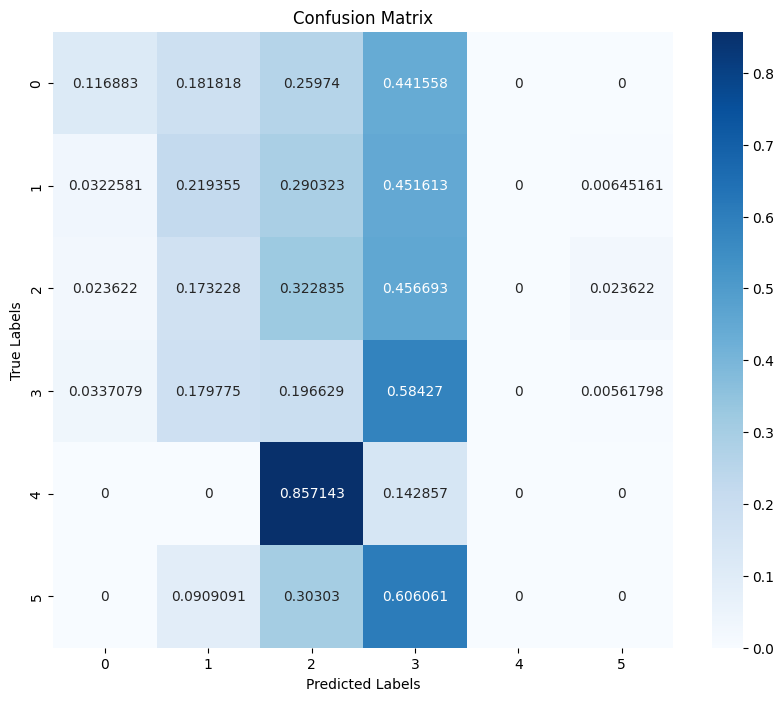

Test Loss: 3.577, Accuracy: 0.326, F1 Score: 0.296, F1 Score Per Class [0.180
Test F1 Score Per Class  [0.18       0.26153846 0.28873239 0.44731183 0.         0.        ]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=2e-04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
patch_size=(224, 224)
stride=30
test_loss, test_accuracy, test_f1, test_f1_per_class = validate_or_test(trained_model, test_loader, criterion, device, patch_size, stride, desc='Test')
print(f'Test Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}, F1 Score: {test_f1:.3f}, F1 Score Per Class [{test_f1_per_class[0]:.3f}')
print(f'Test F1 Score Per Class ', test_f1_per_class)